# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.5133374675157323 -2.6909381116309703
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [26]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rate = tf.placeholder(tf.float32, [], name='rate')
    return states, actions, targetQs, rewards, rate

In [27]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [28]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [29]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [30]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [40]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rewards, rate):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    Qs_labels = rewards[:-1] + (0.99 * targetQs[1:])
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=rate * tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], shape=[-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [41]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [42]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rewards, self.rate = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, rewards=self.rewards, rate=self.rate) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [43]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [44]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [45]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [46]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [47]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            batch.append([state, action, Q_logits, reward])
            total_reward += reward
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        rewards = np.array([each[3] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.targetQs: targetQs.reshape([-1]),
                                                                       model.rewards: rewards, 
                                                                       model.rate: rate})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:11.0000 rate:0.0220 gloss:0.3409 dloss:1.2658 dlossR:0.5112 dlossQ:0.7545
Episode:1 meanR:10.5000 rate:0.0200 gloss:0.2893 dloss:1.2516 dlossR:0.4940 dlossQ:0.7576
Episode:2 meanR:10.3333 rate:0.0200 gloss:0.2439 dloss:1.2372 dlossR:0.4781 dlossQ:0.7591
Episode:3 meanR:10.0000 rate:0.0180 gloss:0.2123 dloss:1.2246 dlossR:0.4661 dlossQ:0.7585
Episode:4 meanR:9.8000 rate:0.0180 gloss:0.1701 dloss:1.2059 dlossR:0.4457 dlossQ:0.7602
Episode:5 meanR:9.8333 rate:0.0200 gloss:0.1222 dloss:1.1769 dlossR:0.4203 dlossQ:0.7566
Episode:6 meanR:9.7143 rate:0.0180 gloss:0.1103 dloss:1.1690 dlossR:0.4143 dlossQ:0.7547
Episode:7 meanR:9.7500 rate:0.0200 gloss:0.0479 dloss:1.1227 dlossR:0.3773 dlossQ:0.7454
Episode:8 meanR:9.6667 rate:0.0180 gloss:0.0362 dloss:1.1148 dlossR:0.3733 dlossQ:0.7416
Episode:9 meanR:9.7000 rate:0.0200 gloss:-0.0135 dloss:1.0677 dlossR:0.3433 dlossQ:0.7244
Episode:10 meanR:9.6364 rate:0.0180 gloss:-0.0437 dloss:1.0489 dlossR:0.3312 dlossQ:0.7176
Episode:11 mea

Episode:93 meanR:51.0426 rate:0.0860 gloss:0.0587 dloss:1.2634 dlossR:0.4548 dlossQ:0.8087
Episode:94 meanR:50.8316 rate:0.0620 gloss:0.0575 dloss:1.2421 dlossR:0.4321 dlossQ:0.8101
Episode:95 meanR:50.7396 rate:0.0840 gloss:0.0540 dloss:1.2597 dlossR:0.4513 dlossQ:0.8084
Episode:96 meanR:50.5979 rate:0.0740 gloss:0.0537 dloss:1.2530 dlossR:0.4441 dlossQ:0.8089
Episode:97 meanR:50.4184 rate:0.0660 gloss:0.0538 dloss:1.2472 dlossR:0.4383 dlossQ:0.8089
Episode:98 meanR:50.1717 rate:0.0520 gloss:0.0589 dloss:1.2353 dlossR:0.4266 dlossQ:0.8087
Episode:99 meanR:50.0200 rate:0.0700 gloss:0.0499 dloss:1.2489 dlossR:0.4397 dlossQ:0.8092
Episode:100 meanR:50.2500 rate:0.0680 gloss:0.0525 dloss:1.2477 dlossR:0.4392 dlossQ:0.8085
Episode:101 meanR:50.6100 rate:0.0920 gloss:0.0525 dloss:1.2696 dlossR:0.4626 dlossQ:0.8070
Episode:102 meanR:50.8600 rate:0.0700 gloss:0.0495 dloss:1.2482 dlossR:0.4396 dlossQ:0.8086
Episode:103 meanR:51.1200 rate:0.0700 gloss:0.0537 dloss:1.2496 dlossR:0.4413 dlossQ:0.

Episode:186 meanR:47.4200 rate:0.0700 gloss:0.0279 dloss:1.2633 dlossR:0.4615 dlossQ:0.8019
Episode:187 meanR:47.3300 rate:0.1060 gloss:0.0198 dloss:1.2933 dlossR:0.4943 dlossQ:0.7990
Episode:188 meanR:47.1000 rate:0.0700 gloss:0.0281 dloss:1.2596 dlossR:0.4564 dlossQ:0.8032
Episode:189 meanR:47.2600 rate:0.0980 gloss:0.0219 dloss:1.2812 dlossR:0.4803 dlossQ:0.8009
Episode:190 meanR:47.5400 rate:0.1520 gloss:0.0442 dloss:1.3244 dlossR:0.5281 dlossQ:0.7963
Episode:191 meanR:47.6300 rate:0.0820 gloss:0.0165 dloss:1.2683 dlossR:0.4660 dlossQ:0.8023
Episode:192 meanR:47.6700 rate:0.0840 gloss:0.0233 dloss:1.2724 dlossR:0.4711 dlossQ:0.8013
Episode:193 meanR:47.6400 rate:0.0800 gloss:0.0215 dloss:1.2657 dlossR:0.4631 dlossQ:0.8026
Episode:194 meanR:47.6600 rate:0.0660 gloss:0.0245 dloss:1.2517 dlossR:0.4472 dlossQ:0.8045
Episode:195 meanR:47.6700 rate:0.0860 gloss:0.0232 dloss:1.2692 dlossR:0.4658 dlossQ:0.8034
Episode:196 meanR:47.8500 rate:0.1100 gloss:0.0169 dloss:1.2911 dlossR:0.4898 dl

Episode:276 meanR:53.0500 rate:0.1980 gloss:0.0333 dloss:1.3584 dlossR:0.5747 dlossQ:0.7837
Episode:277 meanR:52.5800 rate:0.0640 gloss:0.0262 dloss:1.2634 dlossR:0.4659 dlossQ:0.7975
Episode:278 meanR:52.5800 rate:0.0760 gloss:0.0213 dloss:1.2778 dlossR:0.4846 dlossQ:0.7933
Episode:279 meanR:52.4200 rate:0.0780 gloss:0.0262 dloss:1.2852 dlossR:0.4937 dlossQ:0.7915
Episode:280 meanR:52.6700 rate:0.1220 gloss:0.0137 dloss:1.3162 dlossR:0.5284 dlossQ:0.7879
Episode:281 meanR:53.2000 rate:0.1860 gloss:0.0321 dloss:1.3542 dlossR:0.5744 dlossQ:0.7798
Episode:282 meanR:53.2000 rate:0.1340 gloss:0.0143 dloss:1.3239 dlossR:0.5388 dlossQ:0.7851
Episode:283 meanR:52.9800 rate:0.1260 gloss:0.0121 dloss:1.3168 dlossR:0.5298 dlossQ:0.7871
Episode:284 meanR:53.4800 rate:0.2000 gloss:0.0341 dloss:1.3629 dlossR:0.5874 dlossQ:0.7754
Episode:285 meanR:53.5200 rate:0.0980 gloss:0.0191 dloss:1.2972 dlossR:0.5076 dlossQ:0.7896
Episode:286 meanR:53.6600 rate:0.0980 gloss:0.0177 dloss:1.3009 dlossR:0.5136 dl

Episode:368 meanR:70.6500 rate:0.0780 gloss:0.0206 dloss:1.2965 dlossR:0.5088 dlossQ:0.7877
Episode:369 meanR:70.6100 rate:0.1040 gloss:0.0141 dloss:1.3068 dlossR:0.5154 dlossQ:0.7914
Episode:370 meanR:71.0700 rate:0.1740 gloss:0.0159 dloss:1.3574 dlossR:0.5853 dlossQ:0.7721
Episode:371 meanR:71.1200 rate:0.1120 gloss:0.0150 dloss:1.3096 dlossR:0.5128 dlossQ:0.7968
Episode:372 meanR:70.8700 rate:0.1120 gloss:0.0129 dloss:1.3077 dlossR:0.5076 dlossQ:0.8001
Episode:373 meanR:71.2700 rate:0.2820 gloss:0.0118 dloss:1.4008 dlossR:0.6256 dlossQ:0.7752
Episode:374 meanR:71.4000 rate:0.1080 gloss:0.0139 dloss:1.3099 dlossR:0.5146 dlossQ:0.7953
Episode:375 meanR:71.0600 rate:0.1100 gloss:0.0187 dloss:1.3136 dlossR:0.5249 dlossQ:0.7887
Episode:376 meanR:70.6100 rate:0.1080 gloss:0.0167 dloss:1.3118 dlossR:0.5256 dlossQ:0.7862
Episode:377 meanR:70.8300 rate:0.1080 gloss:0.0145 dloss:1.3180 dlossR:0.5378 dlossQ:0.7802
Episode:378 meanR:71.0500 rate:0.1200 gloss:0.0203 dloss:1.3259 dlossR:0.5459 dl

Episode:459 meanR:55.1000 rate:0.0940 gloss:0.0059 dloss:1.2733 dlossR:0.4700 dlossQ:0.8033
Episode:460 meanR:54.9500 rate:0.0600 gloss:0.0047 dloss:1.2389 dlossR:0.4338 dlossQ:0.8050
Episode:461 meanR:54.6700 rate:0.0900 gloss:0.0022 dloss:1.2753 dlossR:0.4704 dlossQ:0.8049
Episode:462 meanR:54.4400 rate:0.0940 gloss:0.0053 dloss:1.2744 dlossR:0.4697 dlossQ:0.8047
Episode:463 meanR:54.0400 rate:0.0620 gloss:0.0065 dloss:1.2323 dlossR:0.4232 dlossQ:0.8090
Episode:464 meanR:54.3000 rate:0.1460 gloss:0.0186 dloss:1.3162 dlossR:0.5154 dlossQ:0.8009
Episode:465 meanR:54.2400 rate:0.1080 gloss:0.0020 dloss:1.2786 dlossR:0.4721 dlossQ:0.8065
Episode:466 meanR:54.1400 rate:0.1100 gloss:0.0026 dloss:1.2914 dlossR:0.4901 dlossQ:0.8013
Episode:467 meanR:53.8200 rate:0.0940 gloss:0.0047 dloss:1.2758 dlossR:0.4728 dlossQ:0.8029
Episode:468 meanR:54.1900 rate:0.1520 gloss:0.0213 dloss:1.3281 dlossR:0.5354 dlossQ:0.7928
Episode:469 meanR:54.0000 rate:0.0660 gloss:0.0080 dloss:1.2586 dlossR:0.4578 dl

Episode:550 meanR:46.7000 rate:0.1340 gloss:0.0154 dloss:1.3176 dlossR:0.5260 dlossQ:0.7916
Episode:551 meanR:46.3300 rate:0.0940 gloss:0.0052 dloss:1.2795 dlossR:0.4802 dlossQ:0.7992
Episode:552 meanR:46.5200 rate:0.1320 gloss:0.0035 dloss:1.3155 dlossR:0.5228 dlossQ:0.7927
Episode:553 meanR:46.6600 rate:0.1040 gloss:0.0067 dloss:1.2948 dlossR:0.5004 dlossQ:0.7944
Episode:554 meanR:46.6600 rate:0.0660 gloss:0.0062 dloss:1.2586 dlossR:0.4577 dlossQ:0.8009
Episode:555 meanR:46.7700 rate:0.0960 gloss:0.0049 dloss:1.2927 dlossR:0.4993 dlossQ:0.7933
Episode:556 meanR:46.8700 rate:0.0820 gloss:0.0085 dloss:1.2762 dlossR:0.4783 dlossQ:0.7978
Episode:557 meanR:47.2000 rate:0.1280 gloss:0.0040 dloss:1.3103 dlossR:0.5154 dlossQ:0.7949
Episode:558 meanR:47.2000 rate:0.1340 gloss:0.0022 dloss:1.3124 dlossR:0.5168 dlossQ:0.7956
Episode:559 meanR:47.1900 rate:0.0920 gloss:0.0081 dloss:1.2801 dlossR:0.4806 dlossQ:0.7994
Episode:560 meanR:47.7700 rate:0.1760 gloss:0.0159 dloss:1.3451 dlossR:0.5565 dl

Episode:640 meanR:58.3000 rate:0.1000 gloss:0.0106 dloss:1.3037 dlossR:0.5171 dlossQ:0.7866
Episode:641 meanR:58.1000 rate:0.1040 gloss:0.0216 dloss:1.2997 dlossR:0.5074 dlossQ:0.7922
Episode:642 meanR:58.6300 rate:0.1800 gloss:0.0034 dloss:1.3470 dlossR:0.5601 dlossQ:0.7869
Episode:643 meanR:58.8900 rate:0.1580 gloss:0.0083 dloss:1.3316 dlossR:0.5404 dlossQ:0.7913
Episode:644 meanR:58.9900 rate:0.1060 gloss:0.0156 dloss:1.2997 dlossR:0.5073 dlossQ:0.7924
Episode:645 meanR:59.0300 rate:0.0980 gloss:0.0078 dloss:1.2940 dlossR:0.5004 dlossQ:0.7936
Episode:646 meanR:59.2300 rate:0.1340 gloss:0.0107 dloss:1.3225 dlossR:0.5360 dlossQ:0.7865
Episode:647 meanR:59.5300 rate:0.1680 gloss:0.0096 dloss:1.3429 dlossR:0.5597 dlossQ:0.7833
Episode:648 meanR:59.8800 rate:0.1480 gloss:0.0137 dloss:1.3328 dlossR:0.5499 dlossQ:0.7829
Episode:649 meanR:60.1400 rate:0.2100 gloss:0.0076 dloss:1.3673 dlossR:0.5949 dlossQ:0.7724
Episode:650 meanR:60.0200 rate:0.1100 gloss:0.0162 dloss:1.3198 dlossR:0.5419 dl

Episode:732 meanR:72.3800 rate:0.1300 gloss:0.0175 dloss:1.3314 dlossR:0.5553 dlossQ:0.7761
Episode:733 meanR:72.5500 rate:0.1280 gloss:0.0055 dloss:1.3288 dlossR:0.5504 dlossQ:0.7784
Episode:734 meanR:72.5200 rate:0.1060 gloss:0.0155 dloss:1.3139 dlossR:0.5298 dlossQ:0.7840
Episode:735 meanR:72.6200 rate:0.1160 gloss:0.0060 dloss:1.3090 dlossR:0.5176 dlossQ:0.7915
Episode:736 meanR:71.9300 rate:0.1000 gloss:0.0110 dloss:1.2888 dlossR:0.4908 dlossQ:0.7980
Episode:737 meanR:71.9900 rate:0.1480 gloss:0.0039 dloss:1.3211 dlossR:0.5228 dlossQ:0.7983
Episode:738 meanR:72.1000 rate:0.1500 gloss:0.0066 dloss:1.3184 dlossR:0.5142 dlossQ:0.8042
Episode:739 meanR:72.2900 rate:0.1500 gloss:0.0062 dloss:1.3216 dlossR:0.5226 dlossQ:0.7990
Episode:740 meanR:72.3500 rate:0.1120 gloss:0.0070 dloss:1.3013 dlossR:0.5049 dlossQ:0.7964
Episode:741 meanR:72.4000 rate:0.1140 gloss:0.0092 dloss:1.3067 dlossR:0.5147 dlossQ:0.7920
Episode:742 meanR:72.1500 rate:0.1300 gloss:0.0082 dloss:1.3218 dlossR:0.5353 dl

Episode:823 meanR:81.5700 rate:0.2260 gloss:0.0172 dloss:1.3831 dlossR:0.6583 dlossQ:0.7248
Episode:824 meanR:81.4400 rate:0.1300 gloss:0.0065 dloss:1.3417 dlossR:0.5763 dlossQ:0.7654
Episode:825 meanR:81.5700 rate:0.1320 gloss:0.0125 dloss:1.3405 dlossR:0.5699 dlossQ:0.7706
Episode:826 meanR:81.4700 rate:0.1160 gloss:0.0052 dloss:1.3231 dlossR:0.5404 dlossQ:0.7827
Episode:827 meanR:82.1300 rate:0.2480 gloss:0.0108 dloss:1.3854 dlossR:0.6261 dlossQ:0.7593
Episode:828 meanR:82.4200 rate:0.1680 gloss:0.0018 dloss:1.3412 dlossR:0.5516 dlossQ:0.7895
Episode:829 meanR:82.4100 rate:0.1240 gloss:0.0049 dloss:1.3137 dlossR:0.5204 dlossQ:0.7933
Episode:830 meanR:82.3700 rate:0.0880 gloss:0.0083 dloss:1.2922 dlossR:0.4986 dlossQ:0.7936
Episode:831 meanR:83.0900 rate:0.2680 gloss:0.0068 dloss:1.3951 dlossR:0.6111 dlossQ:0.7840
Episode:832 meanR:82.9000 rate:0.0920 gloss:0.0080 dloss:1.3041 dlossR:0.5191 dlossQ:0.7850
Episode:833 meanR:82.9400 rate:0.1360 gloss:0.0077 dloss:1.3354 dlossR:0.5599 dl

Episode:917 meanR:60.0800 rate:0.0840 gloss:0.0025 dloss:1.2579 dlossR:0.4500 dlossQ:0.8079
Episode:918 meanR:59.8600 rate:0.0800 gloss:0.0029 dloss:1.2536 dlossR:0.4452 dlossQ:0.8084
Episode:919 meanR:59.3200 rate:0.0900 gloss:0.0028 dloss:1.2613 dlossR:0.4544 dlossQ:0.8069
Episode:920 meanR:59.1300 rate:0.1500 gloss:0.0091 dloss:1.3235 dlossR:0.5270 dlossQ:0.7965
Episode:921 meanR:59.2700 rate:0.1460 gloss:0.0017 dloss:1.3219 dlossR:0.5265 dlossQ:0.7953
Episode:922 meanR:59.1400 rate:0.0860 gloss:0.0061 dloss:1.2788 dlossR:0.4809 dlossQ:0.7980
Episode:923 meanR:58.4000 rate:0.0780 gloss:0.0040 dloss:1.2771 dlossR:0.4807 dlossQ:0.7964
Episode:924 meanR:58.1300 rate:0.0760 gloss:0.0022 dloss:1.2697 dlossR:0.4700 dlossQ:0.7997
Episode:925 meanR:58.0300 rate:0.1120 gloss:0.0015 dloss:1.3041 dlossR:0.5102 dlossQ:0.7939
Episode:926 meanR:58.0800 rate:0.1260 gloss:0.0063 dloss:1.3160 dlossR:0.5236 dlossQ:0.7924
Episode:927 meanR:57.2400 rate:0.0800 gloss:0.0014 dloss:1.2748 dlossR:0.4759 dl

Episode:1008 meanR:48.9500 rate:0.0620 gloss:0.0024 dloss:1.2561 dlossR:0.4544 dlossQ:0.8017
Episode:1009 meanR:48.6400 rate:0.0620 gloss:0.0095 dloss:1.2582 dlossR:0.4570 dlossQ:0.8012
Episode:1010 meanR:48.6900 rate:0.1000 gloss:0.0032 dloss:1.2928 dlossR:0.4971 dlossQ:0.7957
Episode:1011 meanR:48.6200 rate:0.0880 gloss:0.0039 dloss:1.2777 dlossR:0.4779 dlossQ:0.7998
Episode:1012 meanR:48.6400 rate:0.0660 gloss:0.0005 dloss:1.2524 dlossR:0.4445 dlossQ:0.8079
Episode:1013 meanR:48.5900 rate:0.0700 gloss:0.0010 dloss:1.2563 dlossR:0.4484 dlossQ:0.8079
Episode:1014 meanR:48.8200 rate:0.1180 gloss:0.0042 dloss:1.2941 dlossR:0.4910 dlossQ:0.8031
Episode:1015 meanR:48.8400 rate:0.0960 gloss:0.0055 dloss:1.2797 dlossR:0.4783 dlossQ:0.8014
Episode:1016 meanR:48.7600 rate:0.0940 gloss:0.0015 dloss:1.2806 dlossR:0.4793 dlossQ:0.8013
Episode:1017 meanR:48.7100 rate:0.0740 gloss:0.0048 dloss:1.2638 dlossR:0.4620 dlossQ:0.8017
Episode:1018 meanR:48.8700 rate:0.1120 gloss:0.0008 dloss:1.2875 dloss

Episode:1097 meanR:60.2400 rate:0.1000 gloss:0.0144 dloss:1.3156 dlossR:0.5379 dlossQ:0.7777
Episode:1098 meanR:60.3000 rate:0.1300 gloss:0.0155 dloss:1.3271 dlossR:0.5480 dlossQ:0.7791
Episode:1099 meanR:60.7700 rate:0.1600 gloss:0.0105 dloss:1.3404 dlossR:0.5582 dlossQ:0.7822
Episode:1100 meanR:60.7100 rate:0.1060 gloss:0.0025 dloss:1.3004 dlossR:0.5077 dlossQ:0.7927
Episode:1101 meanR:61.1500 rate:0.1660 gloss:0.0038 dloss:1.3373 dlossR:0.5458 dlossQ:0.7915
Episode:1102 meanR:61.3900 rate:0.1220 gloss:0.0052 dloss:1.3073 dlossR:0.5120 dlossQ:0.7953
Episode:1103 meanR:61.7500 rate:0.1680 gloss:0.0103 dloss:1.3581 dlossR:0.5961 dlossQ:0.7620
Episode:1104 meanR:61.8800 rate:0.1020 gloss:0.0109 dloss:1.2983 dlossR:0.5056 dlossQ:0.7927
Episode:1105 meanR:62.1600 rate:0.1460 gloss:0.0053 dloss:1.3245 dlossR:0.5326 dlossQ:0.7920
Episode:1106 meanR:63.0400 rate:0.2480 gloss:0.0067 dloss:1.3834 dlossR:0.5969 dlossQ:0.7865
Episode:1107 meanR:62.9700 rate:0.2240 gloss:0.0078 dloss:1.3766 dloss

Episode:1186 meanR:73.2100 rate:0.2860 gloss:0.0063 dloss:1.3968 dlossR:0.6357 dlossQ:0.7612
Episode:1187 meanR:72.9800 rate:0.1140 gloss:0.0039 dloss:1.3325 dlossR:0.5651 dlossQ:0.7675
Episode:1188 meanR:73.5100 rate:0.2080 gloss:0.0051 dloss:1.3720 dlossR:0.6168 dlossQ:0.7552
Episode:1189 meanR:73.4400 rate:0.1260 gloss:0.0097 dloss:1.3428 dlossR:0.5811 dlossQ:0.7616
Episode:1190 meanR:73.6400 rate:0.1780 gloss:0.0121 dloss:1.3759 dlossR:0.6490 dlossQ:0.7269
Episode:1191 meanR:73.2700 rate:0.1120 gloss:0.0129 dloss:1.3218 dlossR:0.5421 dlossQ:0.7797
Episode:1192 meanR:74.0100 rate:0.3080 gloss:0.0043 dloss:1.4109 dlossR:0.6403 dlossQ:0.7706
Episode:1193 meanR:73.7800 rate:0.1040 gloss:0.0114 dloss:1.3163 dlossR:0.5349 dlossQ:0.7813
Episode:1194 meanR:73.5500 rate:0.1020 gloss:0.0083 dloss:1.3137 dlossR:0.5340 dlossQ:0.7797
Episode:1195 meanR:73.1500 rate:0.1140 gloss:0.0033 dloss:1.3224 dlossR:0.5445 dlossQ:0.7779
Episode:1196 meanR:73.9200 rate:0.3040 gloss:0.0073 dloss:1.4045 dloss

Episode:1276 meanR:73.0700 rate:0.1140 gloss:0.0026 dloss:1.2985 dlossR:0.4989 dlossQ:0.7996
Episode:1277 meanR:73.3500 rate:0.1600 gloss:0.0035 dloss:1.3337 dlossR:0.5397 dlossQ:0.7940
Episode:1278 meanR:73.4600 rate:0.1420 gloss:0.0041 dloss:1.3269 dlossR:0.5337 dlossQ:0.7932
Episode:1279 meanR:72.3800 rate:0.0820 gloss:0.0127 dloss:1.2884 dlossR:0.4942 dlossQ:0.7942
Episode:1280 meanR:72.5400 rate:0.1160 gloss:0.0029 dloss:1.3133 dlossR:0.5220 dlossQ:0.7913
Episode:1281 meanR:72.6500 rate:0.1600 gloss:0.0058 dloss:1.3439 dlossR:0.5671 dlossQ:0.7769
Episode:1282 meanR:72.4300 rate:0.2200 gloss:0.0044 dloss:1.3796 dlossR:0.6443 dlossQ:0.7354
Episode:1283 meanR:72.1000 rate:0.1380 gloss:0.0057 dloss:1.3411 dlossR:0.5702 dlossQ:0.7709
Episode:1284 meanR:72.2100 rate:0.1460 gloss:0.0093 dloss:1.3515 dlossR:0.5884 dlossQ:0.7631
Episode:1285 meanR:72.1600 rate:0.1360 gloss:0.0127 dloss:1.3409 dlossR:0.5734 dlossQ:0.7675
Episode:1286 meanR:71.2900 rate:0.1120 gloss:0.0115 dloss:1.3216 dloss

Episode:1366 meanR:69.7200 rate:0.1860 gloss:0.0094 dloss:1.3748 dlossR:0.6414 dlossQ:0.7334
Episode:1367 meanR:69.9100 rate:0.1720 gloss:0.0041 dloss:1.3481 dlossR:0.5699 dlossQ:0.7781
Episode:1368 meanR:69.9700 rate:0.1080 gloss:0.0040 dloss:1.3042 dlossR:0.5145 dlossQ:0.7897
Episode:1369 meanR:70.0900 rate:0.1180 gloss:0.0112 dloss:1.3143 dlossR:0.5291 dlossQ:0.7852
Episode:1370 meanR:70.2800 rate:0.1300 gloss:0.0062 dloss:1.3190 dlossR:0.5316 dlossQ:0.7874
Episode:1371 meanR:70.6500 rate:0.1740 gloss:0.0057 dloss:1.3466 dlossR:0.5643 dlossQ:0.7823
Episode:1372 meanR:70.7900 rate:0.1540 gloss:0.0042 dloss:1.3341 dlossR:0.5487 dlossQ:0.7854
Episode:1373 meanR:70.9800 rate:0.1720 gloss:0.0081 dloss:1.3670 dlossR:0.6233 dlossQ:0.7437
Episode:1374 meanR:71.4100 rate:0.1860 gloss:0.0027 dloss:1.3534 dlossR:0.5733 dlossQ:0.7801
Episode:1375 meanR:71.2400 rate:0.1740 gloss:0.0122 dloss:1.3461 dlossR:0.5633 dlossQ:0.7827
Episode:1376 meanR:71.8900 rate:0.2440 gloss:0.0045 dloss:1.3814 dloss

Episode:1457 meanR:77.7600 rate:0.1300 gloss:0.0044 dloss:1.3230 dlossR:0.5379 dlossQ:0.7852
Episode:1458 meanR:77.8500 rate:0.1240 gloss:0.0008 dloss:1.3149 dlossR:0.5259 dlossQ:0.7890
Episode:1459 meanR:77.4000 rate:0.0880 gloss:0.0067 dloss:1.2846 dlossR:0.4886 dlossQ:0.7960
Episode:1460 meanR:76.4600 rate:0.1200 gloss:0.0036 dloss:1.3051 dlossR:0.5093 dlossQ:0.7958
Episode:1461 meanR:76.1800 rate:0.1140 gloss:0.0042 dloss:1.3034 dlossR:0.5082 dlossQ:0.7952
Episode:1462 meanR:75.4000 rate:0.0920 gloss:0.0039 dloss:1.2867 dlossR:0.4907 dlossQ:0.7960
Episode:1463 meanR:75.8000 rate:0.1760 gloss:0.0041 dloss:1.3447 dlossR:0.5567 dlossQ:0.7880
Episode:1464 meanR:75.9100 rate:0.1400 gloss:0.0023 dloss:1.3250 dlossR:0.5368 dlossQ:0.7881
Episode:1465 meanR:76.1100 rate:0.1860 gloss:0.0114 dloss:1.3556 dlossR:0.5764 dlossQ:0.7791
Episode:1466 meanR:75.6000 rate:0.0840 gloss:0.0009 dloss:1.2888 dlossR:0.4973 dlossQ:0.7915
Episode:1467 meanR:75.3000 rate:0.1120 gloss:0.0061 dloss:1.3095 dloss

Episode:1546 meanR:62.6200 rate:0.1660 gloss:0.0014 dloss:1.3566 dlossR:0.5916 dlossQ:0.7651
Episode:1547 meanR:62.5300 rate:0.0980 gloss:0.0081 dloss:1.3135 dlossR:0.5298 dlossQ:0.7837
Episode:1548 meanR:62.5800 rate:0.0940 gloss:0.0002 dloss:1.3051 dlossR:0.5185 dlossQ:0.7866
Episode:1549 meanR:62.4900 rate:0.1340 gloss:0.0017 dloss:1.3271 dlossR:0.5452 dlossQ:0.7819
Episode:1550 meanR:62.7600 rate:0.1540 gloss:0.0043 dloss:1.3373 dlossR:0.5562 dlossQ:0.7811
Episode:1551 meanR:62.9200 rate:0.1700 gloss:0.0018 dloss:1.3460 dlossR:0.5653 dlossQ:0.7807
Episode:1552 meanR:63.1500 rate:0.2380 gloss:0.0059 dloss:1.3803 dlossR:0.6049 dlossQ:0.7754
Episode:1553 meanR:63.6700 rate:0.1920 gloss:0.0039 dloss:1.3620 dlossR:0.5854 dlossQ:0.7766
Episode:1554 meanR:63.7300 rate:0.1080 gloss:0.0043 dloss:1.3118 dlossR:0.5241 dlossQ:0.7878
Episode:1555 meanR:63.8800 rate:0.1480 gloss:0.0051 dloss:1.3318 dlossR:0.5466 dlossQ:0.7851
Episode:1556 meanR:63.7600 rate:0.1060 gloss:0.0088 dloss:1.3060 dloss

Episode:1637 meanR:86.9200 rate:0.3080 gloss:0.0053 dloss:1.4120 dlossR:0.6695 dlossQ:0.7425
Episode:1638 meanR:87.0800 rate:0.1480 gloss:0.0106 dloss:1.3788 dlossR:0.6526 dlossQ:0.7262
Episode:1639 meanR:86.9900 rate:0.1380 gloss:0.0140 dloss:1.3762 dlossR:0.6567 dlossQ:0.7195
Episode:1640 meanR:86.5000 rate:0.1400 gloss:0.0012 dloss:1.3745 dlossR:0.6525 dlossQ:0.7219
Episode:1641 meanR:87.7500 rate:0.3920 gloss:0.0112 dloss:1.3873 dlossR:0.6992 dlossQ:0.6881
Episode:1642 meanR:87.0300 rate:0.1380 gloss:0.0029 dloss:1.3638 dlossR:0.6242 dlossQ:0.7395
Episode:1643 meanR:86.9800 rate:0.1320 gloss:0.0045 dloss:1.3545 dlossR:0.6065 dlossQ:0.7479
Episode:1644 meanR:87.1400 rate:0.1220 gloss:0.0041 dloss:1.3345 dlossR:0.5669 dlossQ:0.7675
Episode:1645 meanR:87.3500 rate:0.1400 gloss:0.0055 dloss:1.3383 dlossR:0.5571 dlossQ:0.7812
Episode:1646 meanR:87.2000 rate:0.1360 gloss:0.0098 dloss:1.3340 dlossR:0.5431 dlossQ:0.7909
Episode:1647 meanR:87.4600 rate:0.1500 gloss:0.0027 dloss:1.3355 dloss

Episode:1725 meanR:110.0500 rate:0.2720 gloss:0.0112 dloss:1.3900 dlossR:0.6908 dlossQ:0.6992
Episode:1726 meanR:110.5200 rate:0.2560 gloss:0.0098 dloss:1.3971 dlossR:0.7011 dlossQ:0.6960
Episode:1727 meanR:110.9800 rate:0.1940 gloss:0.0085 dloss:1.4223 dlossR:0.7461 dlossQ:0.6762
Episode:1728 meanR:110.7700 rate:0.2420 gloss:0.0087 dloss:1.3917 dlossR:0.6897 dlossQ:0.7020
Episode:1729 meanR:112.5000 rate:0.5040 gloss:0.0066 dloss:1.4067 dlossR:0.6944 dlossQ:0.7123
Episode:1730 meanR:111.5500 rate:0.2260 gloss:0.0045 dloss:1.3851 dlossR:0.6788 dlossQ:0.7063
Episode:1731 meanR:110.8400 rate:0.1900 gloss:0.0125 dloss:1.3851 dlossR:0.6763 dlossQ:0.7088
Episode:1732 meanR:111.0900 rate:0.1860 gloss:0.0025 dloss:1.3843 dlossR:0.6728 dlossQ:0.7115
Episode:1733 meanR:111.4100 rate:0.3360 gloss:0.0107 dloss:1.3991 dlossR:0.6795 dlossQ:0.7196
Episode:1734 meanR:111.3100 rate:0.1600 gloss:0.0072 dloss:1.3817 dlossR:0.6765 dlossQ:0.7052
Episode:1735 meanR:111.0200 rate:0.1700 gloss:0.0126 dloss:1

Episode:1813 meanR:108.6000 rate:0.1400 gloss:0.0010 dloss:1.3513 dlossR:0.5969 dlossQ:0.7545
Episode:1814 meanR:107.5200 rate:0.1900 gloss:0.0016 dloss:1.3730 dlossR:0.6264 dlossQ:0.7466
Episode:1815 meanR:106.6800 rate:0.2060 gloss:0.0027 dloss:1.3743 dlossR:0.6022 dlossQ:0.7722
Episode:1816 meanR:106.5500 rate:0.1780 gloss:0.0035 dloss:1.3628 dlossR:0.5960 dlossQ:0.7669
Episode:1817 meanR:106.3000 rate:0.3460 gloss:0.0047 dloss:1.4193 dlossR:0.6574 dlossQ:0.7619
Episode:1818 meanR:106.5500 rate:0.3180 gloss:0.0107 dloss:1.4008 dlossR:0.6570 dlossQ:0.7438
Episode:1819 meanR:106.4700 rate:0.1580 gloss:0.0072 dloss:1.3775 dlossR:0.6463 dlossQ:0.7312
Episode:1820 meanR:106.6000 rate:0.2120 gloss:0.0031 dloss:1.3952 dlossR:0.6741 dlossQ:0.7210
Episode:1821 meanR:104.8400 rate:0.1520 gloss:0.0031 dloss:1.3908 dlossR:0.6734 dlossQ:0.7174
Episode:1822 meanR:104.3900 rate:0.1520 gloss:0.0051 dloss:1.3808 dlossR:0.6633 dlossQ:0.7175
Episode:1823 meanR:104.4500 rate:0.2420 gloss:0.0050 dloss:1

Episode:1901 meanR:112.5100 rate:0.3100 gloss:0.0213 dloss:1.3958 dlossR:0.6737 dlossQ:0.7221
Episode:1902 meanR:113.6900 rate:0.3840 gloss:0.0237 dloss:1.3979 dlossR:0.6881 dlossQ:0.7098
Episode:1903 meanR:113.9500 rate:0.2140 gloss:0.0113 dloss:1.3856 dlossR:0.6772 dlossQ:0.7084
Episode:1904 meanR:115.3400 rate:0.4580 gloss:0.0135 dloss:1.3796 dlossR:0.6980 dlossQ:0.6816
Episode:1905 meanR:115.1000 rate:0.1960 gloss:0.0102 dloss:1.3861 dlossR:0.6846 dlossQ:0.7015
Episode:1906 meanR:116.3200 rate:0.3840 gloss:0.0053 dloss:1.3899 dlossR:0.6941 dlossQ:0.6958
Episode:1907 meanR:116.6300 rate:0.2440 gloss:0.0071 dloss:1.3898 dlossR:0.7015 dlossQ:0.6883
Episode:1908 meanR:117.2200 rate:0.3320 gloss:0.0062 dloss:1.3836 dlossR:0.7193 dlossQ:0.6643
Episode:1909 meanR:118.7900 rate:0.4560 gloss:0.0129 dloss:1.3682 dlossR:0.7040 dlossQ:0.6642
Episode:1910 meanR:118.4700 rate:0.2580 gloss:0.0039 dloss:1.3932 dlossR:0.7168 dlossQ:0.6764
Episode:1911 meanR:119.2800 rate:0.2880 gloss:0.0078 dloss:1

Episode:1991 meanR:137.4300 rate:0.1740 gloss:0.0027 dloss:1.3884 dlossR:0.6586 dlossQ:0.7298
Episode:1992 meanR:137.5700 rate:0.1580 gloss:0.0072 dloss:1.3787 dlossR:0.6386 dlossQ:0.7401
Episode:1993 meanR:137.0900 rate:0.1660 gloss:0.0060 dloss:1.3724 dlossR:0.6289 dlossQ:0.7435
Episode:1994 meanR:136.9100 rate:0.1400 gloss:0.0032 dloss:1.3613 dlossR:0.6195 dlossQ:0.7418
Episode:1995 meanR:136.2600 rate:0.2080 gloss:0.0004 dloss:1.3792 dlossR:0.6484 dlossQ:0.7308
Episode:1996 meanR:136.9800 rate:0.3220 gloss:0.0027 dloss:1.4053 dlossR:0.6597 dlossQ:0.7456
Episode:1997 meanR:138.3900 rate:0.4760 gloss:0.0060 dloss:1.4391 dlossR:0.6962 dlossQ:0.7429
Episode:1998 meanR:137.3900 rate:0.1460 gloss:0.0049 dloss:1.3809 dlossR:0.6310 dlossQ:0.7500
Episode:1999 meanR:138.7500 rate:0.5220 gloss:0.0058 dloss:1.4254 dlossR:0.7027 dlossQ:0.7227
Episode:2000 meanR:138.7400 rate:0.1540 gloss:0.0008 dloss:1.3972 dlossR:0.6580 dlossQ:0.7392
Episode:2001 meanR:138.0800 rate:0.1780 gloss:0.0104 dloss:1

Episode:2079 meanR:103.9100 rate:0.1400 gloss:0.0010 dloss:1.3524 dlossR:0.5944 dlossQ:0.7580
Episode:2080 meanR:103.2200 rate:0.1000 gloss:0.0085 dloss:1.3370 dlossR:0.5758 dlossQ:0.7613
Episode:2081 meanR:103.0200 rate:0.1060 gloss:0.0013 dloss:1.3388 dlossR:0.5804 dlossQ:0.7585
Episode:2082 meanR:102.7300 rate:0.1640 gloss:0.0017 dloss:1.3598 dlossR:0.6080 dlossQ:0.7519
Episode:2083 meanR:100.4900 rate:0.1180 gloss:0.0012 dloss:1.3403 dlossR:0.5800 dlossQ:0.7603
Episode:2084 meanR:99.0000 rate:0.1420 gloss:0.0100 dloss:1.3497 dlossR:0.5913 dlossQ:0.7585
Episode:2085 meanR:99.4500 rate:0.2480 gloss:0.0023 dloss:1.3845 dlossR:0.6324 dlossQ:0.7522
Episode:2086 meanR:99.2500 rate:0.1480 gloss:0.0004 dloss:1.3507 dlossR:0.5897 dlossQ:0.7610
Episode:2087 meanR:98.8800 rate:0.1260 gloss:0.0036 dloss:1.3402 dlossR:0.5759 dlossQ:0.7643
Episode:2088 meanR:98.8500 rate:0.1220 gloss:0.0008 dloss:1.3390 dlossR:0.5753 dlossQ:0.7637
Episode:2089 meanR:98.4900 rate:0.1260 gloss:0.0006 dloss:1.3391 

Episode:2169 meanR:71.0500 rate:0.1020 gloss:0.0068 dloss:1.3076 dlossR:0.5204 dlossQ:0.7872
Episode:2170 meanR:70.5400 rate:0.0940 gloss:0.0011 dloss:1.2937 dlossR:0.4999 dlossQ:0.7938
Episode:2171 meanR:70.3500 rate:0.1020 gloss:0.0042 dloss:1.3030 dlossR:0.5130 dlossQ:0.7900
Episode:2172 meanR:69.7700 rate:0.0920 gloss:0.0007 dloss:1.2927 dlossR:0.5003 dlossQ:0.7924
Episode:2173 meanR:69.9500 rate:0.1880 gloss:0.0015 dloss:1.3535 dlossR:0.5691 dlossQ:0.7844
Episode:2174 meanR:69.8500 rate:0.0840 gloss:0.0024 dloss:1.2785 dlossR:0.4802 dlossQ:0.7983
Episode:2175 meanR:69.6300 rate:0.1060 gloss:0.0042 dloss:1.3045 dlossR:0.5120 dlossQ:0.7925
Episode:2176 meanR:69.1000 rate:0.0900 gloss:0.0045 dloss:1.2890 dlossR:0.4934 dlossQ:0.7957
Episode:2177 meanR:68.8700 rate:0.1220 gloss:0.0014 dloss:1.3119 dlossR:0.5189 dlossQ:0.7931
Episode:2178 meanR:68.9400 rate:0.1620 gloss:0.0032 dloss:1.3360 dlossR:0.5437 dlossQ:0.7923
Episode:2179 meanR:68.9900 rate:0.1500 gloss:0.0007 dloss:1.3322 dloss

Episode:2258 meanR:65.4200 rate:0.0960 gloss:0.0004 dloss:1.2917 dlossR:0.4968 dlossQ:0.7948
Episode:2259 meanR:64.8600 rate:0.0980 gloss:0.0005 dloss:1.3019 dlossR:0.5134 dlossQ:0.7885
Episode:2260 meanR:64.9700 rate:0.1120 gloss:0.0006 dloss:1.3037 dlossR:0.5116 dlossQ:0.7921
Episode:2261 meanR:64.8800 rate:0.0880 gloss:0.0003 dloss:1.2912 dlossR:0.5003 dlossQ:0.7908
Episode:2262 meanR:64.8200 rate:0.1080 gloss:0.0004 dloss:1.3035 dlossR:0.5131 dlossQ:0.7904
Episode:2263 meanR:64.3700 rate:0.0800 gloss:0.0000 dloss:1.2812 dlossR:0.4869 dlossQ:0.7943
Episode:2264 meanR:63.8300 rate:0.0980 gloss:0.0012 dloss:1.2981 dlossR:0.5074 dlossQ:0.7907
Episode:2265 meanR:63.7200 rate:0.0860 gloss:0.0011 dloss:1.2816 dlossR:0.4841 dlossQ:0.7975
Episode:2266 meanR:63.6000 rate:0.0860 gloss:0.0019 dloss:1.2788 dlossR:0.4797 dlossQ:0.7991
Episode:2267 meanR:63.6100 rate:0.0900 gloss:0.0001 dloss:1.2804 dlossR:0.4791 dlossQ:0.8013
Episode:2268 meanR:63.7100 rate:0.1160 gloss:0.0005 dloss:1.3001 dloss

Episode:2350 meanR:59.0300 rate:0.0880 gloss:0.0031 dloss:1.2749 dlossR:0.4738 dlossQ:0.8012
Episode:2351 meanR:58.9000 rate:0.0880 gloss:0.0056 dloss:1.2755 dlossR:0.4735 dlossQ:0.8020
Episode:2352 meanR:59.0300 rate:0.1400 gloss:0.0005 dloss:1.3164 dlossR:0.5175 dlossQ:0.7989
Episode:2353 meanR:59.6200 rate:0.2180 gloss:0.0029 dloss:1.3697 dlossR:0.5788 dlossQ:0.7909
Episode:2354 meanR:59.4900 rate:0.0900 gloss:0.0003 dloss:1.2831 dlossR:0.4857 dlossQ:0.7973
Episode:2355 meanR:59.4700 rate:0.1460 gloss:0.0001 dloss:1.3293 dlossR:0.5421 dlossQ:0.7872
Episode:2356 meanR:59.4800 rate:0.1040 gloss:0.0036 dloss:1.3026 dlossR:0.5115 dlossQ:0.7911
Episode:2357 meanR:59.5300 rate:0.1200 gloss:0.0018 dloss:1.3156 dlossR:0.5271 dlossQ:0.7885
Episode:2358 meanR:59.6400 rate:0.1180 gloss:0.0036 dloss:1.3147 dlossR:0.5262 dlossQ:0.7884
Episode:2359 meanR:60.1900 rate:0.2080 gloss:0.0037 dloss:1.3666 dlossR:0.5904 dlossQ:0.7762
Episode:2360 meanR:60.2000 rate:0.1140 gloss:0.0023 dloss:1.3080 dloss

Episode:2441 meanR:63.3600 rate:0.1440 gloss:0.0040 dloss:1.3264 dlossR:0.5368 dlossQ:0.7896
Episode:2442 meanR:63.8000 rate:0.1880 gloss:0.0017 dloss:1.3541 dlossR:0.5692 dlossQ:0.7849
Episode:2443 meanR:63.7900 rate:0.1020 gloss:0.0070 dloss:1.2966 dlossR:0.5030 dlossQ:0.7937
Episode:2444 meanR:63.6700 rate:0.1140 gloss:0.0047 dloss:1.3090 dlossR:0.5208 dlossQ:0.7882
Episode:2445 meanR:63.6200 rate:0.1100 gloss:0.0043 dloss:1.3071 dlossR:0.5186 dlossQ:0.7885
Episode:2446 meanR:63.5800 rate:0.1160 gloss:0.0006 dloss:1.3132 dlossR:0.5268 dlossQ:0.7864
Episode:2447 meanR:63.6400 rate:0.0960 gloss:0.0014 dloss:1.2944 dlossR:0.5024 dlossQ:0.7920
Episode:2448 meanR:63.4700 rate:0.1000 gloss:0.0062 dloss:1.2988 dlossR:0.5081 dlossQ:0.7907
Episode:2449 meanR:64.1300 rate:0.2200 gloss:0.0083 dloss:1.3725 dlossR:0.6033 dlossQ:0.7692
Episode:2450 meanR:64.2600 rate:0.1140 gloss:0.0004 dloss:1.3094 dlossR:0.5206 dlossQ:0.7888
Episode:2451 meanR:65.1800 rate:0.2720 gloss:0.0045 dloss:1.3945 dloss

Episode:2531 meanR:79.3100 rate:0.1960 gloss:0.0006 dloss:1.3636 dlossR:0.5980 dlossQ:0.7657
Episode:2532 meanR:79.4300 rate:0.1780 gloss:0.0007 dloss:1.3542 dlossR:0.5847 dlossQ:0.7695
Episode:2533 meanR:80.1700 rate:0.3860 gloss:0.0045 dloss:1.4301 dlossR:0.6703 dlossQ:0.7598
Episode:2534 meanR:80.6100 rate:0.1980 gloss:0.0049 dloss:1.3696 dlossR:0.6104 dlossQ:0.7592
Episode:2535 meanR:81.0200 rate:0.1940 gloss:0.0090 dloss:1.3754 dlossR:0.6243 dlossQ:0.7510
Episode:2536 meanR:81.5100 rate:0.2240 gloss:0.0051 dloss:1.3831 dlossR:0.6382 dlossQ:0.7449
Episode:2537 meanR:82.0800 rate:0.1980 gloss:0.0018 dloss:1.3768 dlossR:0.6306 dlossQ:0.7462
Episode:2538 meanR:82.3300 rate:0.1600 gloss:0.0185 dloss:1.3645 dlossR:0.6189 dlossQ:0.7456
Episode:2539 meanR:82.3800 rate:0.1500 gloss:0.0031 dloss:1.3568 dlossR:0.6062 dlossQ:0.7506
Episode:2540 meanR:83.9700 rate:0.4100 gloss:0.0118 dloss:1.4239 dlossR:0.6811 dlossQ:0.7427
Episode:2541 meanR:84.2600 rate:0.2020 gloss:0.0011 dloss:1.3731 dloss

Episode:2619 meanR:113.8200 rate:0.4340 gloss:0.0051 dloss:1.4369 dlossR:0.6874 dlossQ:0.7495
Episode:2620 meanR:114.3100 rate:0.2240 gloss:0.0009 dloss:1.3799 dlossR:0.6485 dlossQ:0.7314
Episode:2621 meanR:114.7300 rate:0.1960 gloss:0.0007 dloss:1.3902 dlossR:0.6981 dlossQ:0.6921
Episode:2622 meanR:114.2400 rate:0.2060 gloss:0.0002 dloss:1.3889 dlossR:0.6740 dlossQ:0.7148
Episode:2623 meanR:114.7200 rate:0.2100 gloss:0.0022 dloss:1.3888 dlossR:0.6719 dlossQ:0.7169
Episode:2624 meanR:114.8600 rate:0.1560 gloss:0.0016 dloss:1.3806 dlossR:0.6600 dlossQ:0.7205
Episode:2625 meanR:115.1400 rate:0.1940 gloss:0.0067 dloss:1.3769 dlossR:0.6515 dlossQ:0.7254
Episode:2626 meanR:115.0800 rate:0.1860 gloss:0.0038 dloss:1.3794 dlossR:0.6621 dlossQ:0.7173
Episode:2627 meanR:115.1100 rate:0.1740 gloss:0.0019 dloss:1.3664 dlossR:0.6166 dlossQ:0.7498
Episode:2628 meanR:114.9600 rate:0.1640 gloss:0.0041 dloss:1.3633 dlossR:0.5998 dlossQ:0.7634
Episode:2629 meanR:115.3500 rate:0.2140 gloss:0.0074 dloss:1

Episode:2707 meanR:114.7200 rate:0.1860 gloss:0.0039 dloss:1.3744 dlossR:0.6448 dlossQ:0.7296
Episode:2708 meanR:113.6000 rate:0.1980 gloss:0.0015 dloss:1.3767 dlossR:0.6498 dlossQ:0.7269
Episode:2709 meanR:113.9800 rate:0.2460 gloss:0.0030 dloss:1.3841 dlossR:0.6495 dlossQ:0.7347
Episode:2710 meanR:113.4000 rate:0.2300 gloss:0.0028 dloss:1.3811 dlossR:0.6446 dlossQ:0.7365
Episode:2711 meanR:113.1600 rate:0.1560 gloss:0.0106 dloss:1.3658 dlossR:0.6283 dlossQ:0.7375
Episode:2712 meanR:113.5100 rate:0.2860 gloss:0.0041 dloss:1.3917 dlossR:0.6576 dlossQ:0.7340
Episode:2713 meanR:113.0400 rate:0.1440 gloss:0.0025 dloss:1.3628 dlossR:0.6244 dlossQ:0.7383
Episode:2714 meanR:113.2300 rate:0.1620 gloss:0.0040 dloss:1.3642 dlossR:0.6217 dlossQ:0.7425
Episode:2715 meanR:112.8500 rate:0.1400 gloss:0.0007 dloss:1.3580 dlossR:0.6141 dlossQ:0.7439
Episode:2716 meanR:112.4500 rate:0.1660 gloss:0.0017 dloss:1.3635 dlossR:0.6142 dlossQ:0.7493
Episode:2717 meanR:112.4500 rate:0.1580 gloss:0.0003 dloss:1

Episode:2796 meanR:85.3900 rate:0.1400 gloss:0.0001 dloss:1.3360 dlossR:0.5605 dlossQ:0.7755
Episode:2797 meanR:84.6600 rate:0.1740 gloss:0.0038 dloss:1.3550 dlossR:0.5852 dlossQ:0.7697
Episode:2798 meanR:84.5400 rate:0.1480 gloss:0.0100 dloss:1.3446 dlossR:0.5748 dlossQ:0.7698
Episode:2799 meanR:84.3100 rate:0.1560 gloss:0.0062 dloss:1.3475 dlossR:0.5770 dlossQ:0.7706
Episode:2800 meanR:84.2000 rate:0.1440 gloss:0.0069 dloss:1.3438 dlossR:0.5750 dlossQ:0.7688
Episode:2801 meanR:84.1100 rate:0.1680 gloss:0.0013 dloss:1.3502 dlossR:0.5783 dlossQ:0.7720
Episode:2802 meanR:84.1600 rate:0.2180 gloss:0.0059 dloss:1.3795 dlossR:0.6440 dlossQ:0.7355
Episode:2803 meanR:84.1000 rate:0.1120 gloss:0.0000 dloss:1.3220 dlossR:0.5442 dlossQ:0.7778
Episode:2804 meanR:83.4000 rate:0.1640 gloss:0.0001 dloss:1.3473 dlossR:0.5706 dlossQ:0.7767
Episode:2805 meanR:83.4600 rate:0.1620 gloss:0.0014 dloss:1.3472 dlossR:0.5709 dlossQ:0.7763
Episode:2806 meanR:83.4900 rate:0.2000 gloss:0.0047 dloss:1.3648 dloss

Episode:2885 meanR:94.3900 rate:0.3820 gloss:0.0075 dloss:1.4188 dlossR:0.6716 dlossQ:0.7472
Episode:2886 meanR:95.0800 rate:0.2700 gloss:0.0018 dloss:1.3897 dlossR:0.6549 dlossQ:0.7348
Episode:2887 meanR:95.4600 rate:0.1960 gloss:0.0069 dloss:1.3809 dlossR:0.6511 dlossQ:0.7298
Episode:2888 meanR:95.8800 rate:0.1960 gloss:0.0011 dloss:1.3855 dlossR:0.6610 dlossQ:0.7245
Episode:2889 meanR:96.9100 rate:0.3480 gloss:0.0076 dloss:1.4025 dlossR:0.6838 dlossQ:0.7188
Episode:2890 meanR:97.3700 rate:0.2060 gloss:0.0023 dloss:1.3837 dlossR:0.6622 dlossQ:0.7216
Episode:2891 meanR:97.2300 rate:0.1500 gloss:0.0005 dloss:1.3679 dlossR:0.6375 dlossQ:0.7305
Episode:2892 meanR:98.1300 rate:0.3080 gloss:0.0031 dloss:1.3968 dlossR:0.6607 dlossQ:0.7361
Episode:2893 meanR:99.3400 rate:0.4060 gloss:0.0046 dloss:1.4145 dlossR:0.6816 dlossQ:0.7329
Episode:2894 meanR:99.9200 rate:0.2360 gloss:0.0075 dloss:1.3842 dlossR:0.6549 dlossQ:0.7293
Episode:2895 meanR:99.3000 rate:0.1420 gloss:0.0045 dloss:1.3692 dloss

Episode:2974 meanR:120.0200 rate:0.2500 gloss:0.0011 dloss:1.3871 dlossR:0.6645 dlossQ:0.7225
Episode:2975 meanR:119.3100 rate:0.1620 gloss:0.0012 dloss:1.3887 dlossR:0.6758 dlossQ:0.7129
Episode:2976 meanR:118.3600 rate:0.1860 gloss:0.0044 dloss:1.3885 dlossR:0.6806 dlossQ:0.7079
Episode:2977 meanR:118.1600 rate:0.1740 gloss:0.0028 dloss:1.3780 dlossR:0.6629 dlossQ:0.7151
Episode:2978 meanR:117.8900 rate:0.1140 gloss:0.0000 dloss:1.3618 dlossR:0.6275 dlossQ:0.7343
Episode:2979 meanR:117.8800 rate:0.1220 gloss:0.0012 dloss:1.3636 dlossR:0.6030 dlossQ:0.7606
Episode:2980 meanR:116.8700 rate:0.1320 gloss:0.0006 dloss:1.3721 dlossR:0.5950 dlossQ:0.7770
Episode:2981 meanR:116.8600 rate:0.1300 gloss:0.0012 dloss:1.3632 dlossR:0.5831 dlossQ:0.7802
Episode:2982 meanR:116.7000 rate:0.1220 gloss:0.0008 dloss:1.3505 dlossR:0.5853 dlossQ:0.7651
Episode:2983 meanR:116.4200 rate:0.1480 gloss:0.0030 dloss:1.3564 dlossR:0.6026 dlossQ:0.7538
Episode:2984 meanR:116.0900 rate:0.1780 gloss:0.0001 dloss:1

Episode:3063 meanR:84.8700 rate:0.1020 gloss:0.0002 dloss:1.3128 dlossR:0.5267 dlossQ:0.7861
Episode:3064 meanR:85.0200 rate:0.2380 gloss:0.0022 dloss:1.3826 dlossR:0.6076 dlossQ:0.7750
Episode:3065 meanR:85.6100 rate:0.2740 gloss:0.0035 dloss:1.3960 dlossR:0.6269 dlossQ:0.7691
Episode:3066 meanR:85.2600 rate:0.2000 gloss:0.0045 dloss:1.3659 dlossR:0.5972 dlossQ:0.7687
Episode:3067 meanR:85.7800 rate:0.2440 gloss:0.0084 dloss:1.3830 dlossR:0.6262 dlossQ:0.7569
Episode:3068 meanR:85.7900 rate:0.1580 gloss:0.0000 dloss:1.3549 dlossR:0.5964 dlossQ:0.7585
Episode:3069 meanR:86.1400 rate:0.2260 gloss:0.0003 dloss:1.3789 dlossR:0.6356 dlossQ:0.7433
Episode:3070 meanR:87.0700 rate:0.3780 gloss:0.0017 dloss:1.4083 dlossR:0.6769 dlossQ:0.7314
Episode:3071 meanR:87.6300 rate:0.2400 gloss:0.0022 dloss:1.3839 dlossR:0.6559 dlossQ:0.7280
Episode:3072 meanR:86.2300 rate:0.1060 gloss:0.0001 dloss:1.3526 dlossR:0.6120 dlossQ:0.7406
Episode:3073 meanR:85.0700 rate:0.1620 gloss:0.0001 dloss:1.3699 dloss

Episode:3155 meanR:73.4000 rate:0.1060 gloss:0.0009 dloss:1.3016 dlossR:0.5093 dlossQ:0.7923
Episode:3156 meanR:73.4700 rate:0.1180 gloss:0.0043 dloss:1.3138 dlossR:0.5268 dlossQ:0.7870
Episode:3157 meanR:73.5600 rate:0.1240 gloss:0.0001 dloss:1.3204 dlossR:0.5363 dlossQ:0.7841
Episode:3158 meanR:74.0000 rate:0.2080 gloss:0.0015 dloss:1.3671 dlossR:0.5932 dlossQ:0.7739
Episode:3159 meanR:74.0000 rate:0.2260 gloss:0.0032 dloss:1.3767 dlossR:0.6072 dlossQ:0.7695
Episode:3160 meanR:73.7400 rate:0.0980 gloss:0.0024 dloss:1.3129 dlossR:0.5295 dlossQ:0.7834
Episode:3161 meanR:73.8900 rate:0.1220 gloss:0.0000 dloss:1.3248 dlossR:0.5440 dlossQ:0.7807
Episode:3162 meanR:74.1000 rate:0.1540 gloss:0.0005 dloss:1.3387 dlossR:0.5592 dlossQ:0.7795
Episode:3163 meanR:74.3800 rate:0.1580 gloss:0.0004 dloss:1.3405 dlossR:0.5608 dlossQ:0.7798
Episode:3164 meanR:73.9000 rate:0.1420 gloss:0.0093 dloss:1.3303 dlossR:0.5459 dlossQ:0.7844
Episode:3165 meanR:73.2100 rate:0.1360 gloss:0.0005 dloss:1.3292 dloss

Episode:3246 meanR:79.6000 rate:0.1340 gloss:0.0026 dloss:1.3491 dlossR:0.5861 dlossQ:0.7629
Episode:3247 meanR:79.8500 rate:0.1720 gloss:0.0013 dloss:1.3637 dlossR:0.5971 dlossQ:0.7666
Episode:3248 meanR:80.3500 rate:0.2560 gloss:0.0017 dloss:1.3907 dlossR:0.6697 dlossQ:0.7210
Episode:3249 meanR:80.4700 rate:0.1100 gloss:0.0048 dloss:1.3326 dlossR:0.5636 dlossQ:0.7690
Episode:3250 meanR:80.6600 rate:0.1480 gloss:0.0008 dloss:1.3474 dlossR:0.5819 dlossQ:0.7655
Episode:3251 meanR:81.3500 rate:0.2280 gloss:0.0024 dloss:1.3847 dlossR:0.6722 dlossQ:0.7125
Episode:3252 meanR:82.9100 rate:0.4180 gloss:0.0004 dloss:1.4076 dlossR:0.6860 dlossQ:0.7216
Episode:3253 meanR:83.0600 rate:0.1240 gloss:0.0007 dloss:1.3460 dlossR:0.5881 dlossQ:0.7579
Episode:3254 meanR:83.3100 rate:0.1600 gloss:0.0003 dloss:1.3578 dlossR:0.5995 dlossQ:0.7583
Episode:3255 meanR:85.0300 rate:0.4500 gloss:0.0048 dloss:1.4058 dlossR:0.6926 dlossQ:0.7132
Episode:3256 meanR:85.2900 rate:0.1700 gloss:0.0001 dloss:1.3638 dloss

Episode:3337 meanR:80.2500 rate:0.1160 gloss:0.0013 dloss:1.3123 dlossR:0.5262 dlossQ:0.7861
Episode:3338 meanR:80.0100 rate:0.1140 gloss:0.0009 dloss:1.3147 dlossR:0.5326 dlossQ:0.7821
Episode:3339 meanR:79.9800 rate:0.1260 gloss:0.0004 dloss:1.3234 dlossR:0.5432 dlossQ:0.7802
Episode:3340 meanR:78.0200 rate:0.1420 gloss:0.0002 dloss:1.3310 dlossR:0.5507 dlossQ:0.7803
Episode:3341 meanR:78.1400 rate:0.1880 gloss:0.0021 dloss:1.3564 dlossR:0.5815 dlossQ:0.7749
Episode:3342 meanR:77.9500 rate:0.1380 gloss:0.0006 dloss:1.3309 dlossR:0.5527 dlossQ:0.7781
Episode:3343 meanR:77.9900 rate:0.1720 gloss:0.0011 dloss:1.3530 dlossR:0.5852 dlossQ:0.7677
Episode:3344 meanR:77.9700 rate:0.1120 gloss:0.0026 dloss:1.3161 dlossR:0.5355 dlossQ:0.7805
Episode:3345 meanR:77.6400 rate:0.0960 gloss:0.0093 dloss:1.3030 dlossR:0.5188 dlossQ:0.7843
Episode:3346 meanR:77.4300 rate:0.0920 gloss:0.0048 dloss:1.2972 dlossR:0.5100 dlossQ:0.7873
Episode:3347 meanR:77.3700 rate:0.1600 gloss:0.0007 dloss:1.3420 dloss

Episode:3427 meanR:64.8400 rate:0.1540 gloss:0.0021 dloss:1.3349 dlossR:0.5501 dlossQ:0.7848
Episode:3428 meanR:65.7900 rate:0.2740 gloss:0.0014 dloss:1.3939 dlossR:0.6250 dlossQ:0.7689
Episode:3429 meanR:66.5100 rate:0.2440 gloss:0.0011 dloss:1.3820 dlossR:0.6164 dlossQ:0.7656
Episode:3430 meanR:65.9900 rate:0.0980 gloss:0.0003 dloss:1.3074 dlossR:0.5225 dlossQ:0.7848
Episode:3431 meanR:66.0400 rate:0.1220 gloss:0.0001 dloss:1.3310 dlossR:0.5583 dlossQ:0.7727
Episode:3432 meanR:66.4700 rate:0.1780 gloss:0.0001 dloss:1.3590 dlossR:0.5982 dlossQ:0.7608
Episode:3433 meanR:66.5000 rate:0.0900 gloss:0.0007 dloss:1.3100 dlossR:0.5330 dlossQ:0.7770
Episode:3434 meanR:66.4400 rate:0.0940 gloss:0.0000 dloss:1.3120 dlossR:0.5327 dlossQ:0.7792
Episode:3435 meanR:66.8000 rate:0.2340 gloss:0.0019 dloss:1.3834 dlossR:0.6278 dlossQ:0.7556
Episode:3436 meanR:66.5700 rate:0.1360 gloss:0.0001 dloss:1.3371 dlossR:0.5577 dlossQ:0.7794
Episode:3437 meanR:66.7200 rate:0.1460 gloss:0.0042 dloss:1.3419 dloss

Episode:3517 meanR:68.4500 rate:0.1100 gloss:0.0000 dloss:1.3100 dlossR:0.5236 dlossQ:0.7864
Episode:3518 meanR:68.4900 rate:0.1220 gloss:0.0000 dloss:1.3198 dlossR:0.5376 dlossQ:0.7823
Episode:3519 meanR:68.4700 rate:0.1180 gloss:0.0008 dloss:1.3175 dlossR:0.5338 dlossQ:0.7837
Episode:3520 meanR:68.4800 rate:0.1320 gloss:0.0015 dloss:1.3272 dlossR:0.5454 dlossQ:0.7819
Episode:3521 meanR:68.5300 rate:0.0980 gloss:0.0040 dloss:1.2961 dlossR:0.5037 dlossQ:0.7925
Episode:3522 meanR:68.6200 rate:0.1080 gloss:0.0003 dloss:1.3038 dlossR:0.5136 dlossQ:0.7902
Episode:3523 meanR:68.5600 rate:0.1040 gloss:0.0000 dloss:1.2963 dlossR:0.5022 dlossQ:0.7941
Episode:3524 meanR:68.6600 rate:0.1440 gloss:0.0000 dloss:1.3245 dlossR:0.5330 dlossQ:0.7915
Episode:3525 meanR:68.3800 rate:0.1020 gloss:0.0037 dloss:1.2923 dlossR:0.4968 dlossQ:0.7955
Episode:3526 meanR:68.0400 rate:0.0900 gloss:0.0004 dloss:1.2811 dlossR:0.4825 dlossQ:0.7986
Episode:3527 meanR:68.5700 rate:0.2600 gloss:0.0021 dloss:1.3892 dloss

Episode:3606 meanR:73.8900 rate:0.1220 gloss:0.0047 dloss:1.3325 dlossR:0.5593 dlossQ:0.7732
Episode:3607 meanR:73.4400 rate:0.1020 gloss:0.0006 dloss:1.3209 dlossR:0.5443 dlossQ:0.7765
Episode:3608 meanR:73.4700 rate:0.1220 gloss:0.0023 dloss:1.3232 dlossR:0.5419 dlossQ:0.7814
Episode:3609 meanR:73.0700 rate:0.1060 gloss:0.0034 dloss:1.3063 dlossR:0.5172 dlossQ:0.7892
Episode:3610 meanR:73.6800 rate:0.2700 gloss:0.0002 dloss:1.3935 dlossR:0.6221 dlossQ:0.7713
Episode:3611 meanR:74.1300 rate:0.1800 gloss:0.0001 dloss:1.3497 dlossR:0.5639 dlossQ:0.7857
Episode:3612 meanR:74.1800 rate:0.1180 gloss:0.0036 dloss:1.3149 dlossR:0.5274 dlossQ:0.7875
Episode:3613 meanR:74.4000 rate:0.1380 gloss:0.0000 dloss:1.3275 dlossR:0.5426 dlossQ:0.7849
Episode:3614 meanR:74.6800 rate:0.1360 gloss:0.0009 dloss:1.3319 dlossR:0.5525 dlossQ:0.7793
Episode:3615 meanR:74.2200 rate:0.1300 gloss:0.0050 dloss:1.3305 dlossR:0.5517 dlossQ:0.7788
Episode:3616 meanR:74.3200 rate:0.1180 gloss:0.0084 dloss:1.3209 dloss

Episode:3695 meanR:98.3100 rate:0.6140 gloss:0.0038 dloss:1.3168 dlossR:0.6787 dlossQ:0.6381
Episode:3696 meanR:98.2800 rate:0.3700 gloss:0.0101 dloss:1.4052 dlossR:0.7419 dlossQ:0.6633
Episode:3697 meanR:99.0300 rate:0.2800 gloss:0.0119 dloss:1.4333 dlossR:0.7586 dlossQ:0.6747
Episode:3698 meanR:100.1500 rate:0.3360 gloss:0.0148 dloss:1.4329 dlossR:0.7439 dlossQ:0.6891
Episode:3699 meanR:101.4800 rate:0.3760 gloss:0.0029 dloss:1.4147 dlossR:0.7343 dlossQ:0.6804
Episode:3700 meanR:101.8500 rate:0.1660 gloss:0.0090 dloss:1.4320 dlossR:0.7647 dlossQ:0.6673
Episode:3701 meanR:102.3900 rate:0.2760 gloss:0.0089 dloss:1.4113 dlossR:0.7528 dlossQ:0.6585
Episode:3702 meanR:102.8000 rate:0.2400 gloss:0.0037 dloss:1.4196 dlossR:0.7934 dlossQ:0.6262
Episode:3703 meanR:102.9200 rate:0.1260 gloss:0.0065 dloss:1.4179 dlossR:0.7541 dlossQ:0.6638
Episode:3704 meanR:102.6400 rate:0.1800 gloss:0.0034 dloss:1.3958 dlossR:0.7124 dlossQ:0.6835
Episode:3705 meanR:103.0900 rate:0.1900 gloss:0.0021 dloss:1.38

Episode:3785 meanR:107.5000 rate:0.1680 gloss:0.0057 dloss:1.3568 dlossR:0.5984 dlossQ:0.7585
Episode:3786 meanR:106.7500 rate:0.2200 gloss:0.0033 dloss:1.3754 dlossR:0.6254 dlossQ:0.7500
Episode:3787 meanR:106.7800 rate:0.2200 gloss:0.0000 dloss:1.3831 dlossR:0.6674 dlossQ:0.7157
Episode:3788 meanR:104.0100 rate:0.2880 gloss:0.0033 dloss:1.3940 dlossR:0.6485 dlossQ:0.7455
Episode:3789 meanR:103.6700 rate:0.1480 gloss:0.0007 dloss:1.3602 dlossR:0.6155 dlossQ:0.7447
Episode:3790 meanR:102.6800 rate:0.1660 gloss:0.0075 dloss:1.3641 dlossR:0.6212 dlossQ:0.7429
Episode:3791 meanR:99.7400 rate:0.3400 gloss:0.0012 dloss:1.3937 dlossR:0.6800 dlossQ:0.7138
Episode:3792 meanR:99.5000 rate:0.2160 gloss:0.0040 dloss:1.3767 dlossR:0.6384 dlossQ:0.7384
Episode:3793 meanR:99.0600 rate:0.3760 gloss:0.0075 dloss:1.4098 dlossR:0.6740 dlossQ:0.7359
Episode:3794 meanR:98.5600 rate:0.1920 gloss:0.0015 dloss:1.3735 dlossR:0.6387 dlossQ:0.7349
Episode:3795 meanR:96.0900 rate:0.1200 gloss:0.0040 dloss:1.3580

Episode:3873 meanR:118.2000 rate:0.2180 gloss:0.0020 dloss:1.3886 dlossR:0.6780 dlossQ:0.7106
Episode:3874 meanR:118.5200 rate:0.1740 gloss:0.0096 dloss:1.3981 dlossR:0.7129 dlossQ:0.6852
Episode:3875 meanR:118.1500 rate:0.1980 gloss:0.0047 dloss:1.3944 dlossR:0.7056 dlossQ:0.6888
Episode:3876 meanR:117.9200 rate:0.1200 gloss:0.0017 dloss:1.3726 dlossR:0.6508 dlossQ:0.7218
Episode:3877 meanR:118.1600 rate:0.2040 gloss:0.0007 dloss:1.3838 dlossR:0.6617 dlossQ:0.7221
Episode:3878 meanR:120.2000 rate:0.5640 gloss:0.0071 dloss:1.4157 dlossR:0.7012 dlossQ:0.7145
Episode:3879 meanR:121.0200 rate:0.3960 gloss:0.0039 dloss:1.3921 dlossR:0.6898 dlossQ:0.7023
Episode:3880 meanR:121.3200 rate:0.1820 gloss:0.0032 dloss:1.3985 dlossR:0.7232 dlossQ:0.6753
Episode:3881 meanR:121.0500 rate:0.1940 gloss:0.0099 dloss:1.4057 dlossR:0.7340 dlossQ:0.6717
Episode:3882 meanR:121.8100 rate:0.2820 gloss:0.0006 dloss:1.3972 dlossR:0.7253 dlossQ:0.6719
Episode:3883 meanR:123.9200 rate:0.6880 gloss:0.0060 dloss:1

Episode:3962 meanR:130.4700 rate:0.2320 gloss:0.0060 dloss:1.3835 dlossR:0.6461 dlossQ:0.7374
Episode:3963 meanR:129.5800 rate:0.1420 gloss:0.0001 dloss:1.3637 dlossR:0.6189 dlossQ:0.7447
Episode:3964 meanR:127.3300 rate:0.1760 gloss:0.0012 dloss:1.3727 dlossR:0.6230 dlossQ:0.7498
Episode:3965 meanR:127.1100 rate:0.1260 gloss:0.0068 dloss:1.3583 dlossR:0.6079 dlossQ:0.7504
Episode:3966 meanR:127.5300 rate:0.2480 gloss:0.0008 dloss:1.3904 dlossR:0.6411 dlossQ:0.7493
Episode:3967 meanR:126.5000 rate:0.2460 gloss:0.0013 dloss:1.3879 dlossR:0.6424 dlossQ:0.7455
Episode:3968 meanR:126.3700 rate:0.1740 gloss:0.0051 dloss:1.3695 dlossR:0.6313 dlossQ:0.7381
Episode:3969 meanR:125.6100 rate:0.1160 gloss:0.0002 dloss:1.3588 dlossR:0.6246 dlossQ:0.7342
Episode:3970 meanR:125.1700 rate:0.1520 gloss:0.0081 dloss:1.3683 dlossR:0.6375 dlossQ:0.7308
Episode:3971 meanR:127.0200 rate:0.5160 gloss:0.0050 dloss:1.4247 dlossR:0.6986 dlossQ:0.7261
Episode:3972 meanR:126.4600 rate:0.2760 gloss:0.0028 dloss:1

Episode:4052 meanR:99.7400 rate:0.1920 gloss:0.0004 dloss:1.3750 dlossR:0.6377 dlossQ:0.7373
Episode:4053 meanR:98.8700 rate:0.1540 gloss:0.0056 dloss:1.3635 dlossR:0.6242 dlossQ:0.7393
Episode:4054 meanR:98.6900 rate:0.1140 gloss:0.0002 dloss:1.3461 dlossR:0.5964 dlossQ:0.7497
Episode:4055 meanR:98.8600 rate:0.1560 gloss:0.0000 dloss:1.3575 dlossR:0.6040 dlossQ:0.7534
Episode:4056 meanR:98.6000 rate:0.2040 gloss:0.0019 dloss:1.3732 dlossR:0.6170 dlossQ:0.7562
Episode:4057 meanR:98.3200 rate:0.1840 gloss:0.0000 dloss:1.3681 dlossR:0.6065 dlossQ:0.7616
Episode:4058 meanR:98.0500 rate:0.1220 gloss:0.0096 dloss:1.3432 dlossR:0.5781 dlossQ:0.7651
Episode:4059 meanR:98.2300 rate:0.1720 gloss:0.0000 dloss:1.3635 dlossR:0.6006 dlossQ:0.7629
Episode:4060 meanR:97.7100 rate:0.1760 gloss:0.0009 dloss:1.3640 dlossR:0.6055 dlossQ:0.7585
Episode:4061 meanR:97.8000 rate:0.1860 gloss:0.0028 dloss:1.3663 dlossR:0.6122 dlossQ:0.7541
Episode:4062 meanR:97.6400 rate:0.2000 gloss:0.0006 dloss:1.3778 dloss

Episode:4142 meanR:96.2000 rate:0.1540 gloss:0.0004 dloss:1.3661 dlossR:0.6305 dlossQ:0.7356
Episode:4143 meanR:96.2900 rate:0.1840 gloss:0.0001 dloss:1.3727 dlossR:0.6311 dlossQ:0.7416
Episode:4144 meanR:96.4400 rate:0.1660 gloss:0.0004 dloss:1.3691 dlossR:0.6161 dlossQ:0.7531
Episode:4145 meanR:96.2400 rate:0.1620 gloss:0.0024 dloss:1.3702 dlossR:0.6095 dlossQ:0.7607
Episode:4146 meanR:96.5000 rate:0.2220 gloss:0.0002 dloss:1.3893 dlossR:0.6357 dlossQ:0.7537
Episode:4147 meanR:95.1100 rate:0.1240 gloss:0.0013 dloss:1.3555 dlossR:0.5989 dlossQ:0.7566
Episode:4148 meanR:94.1300 rate:0.1320 gloss:0.0001 dloss:1.3582 dlossR:0.6092 dlossQ:0.7490
Episode:4149 meanR:93.6600 rate:0.1120 gloss:0.0002 dloss:1.3503 dlossR:0.6028 dlossQ:0.7475
Episode:4150 meanR:95.3800 rate:0.4920 gloss:0.0052 dloss:1.4193 dlossR:0.6955 dlossQ:0.7239
Episode:4151 meanR:95.1500 rate:0.1480 gloss:0.0004 dloss:1.3676 dlossR:0.6383 dlossQ:0.7293
Episode:4152 meanR:94.7700 rate:0.1160 gloss:0.0017 dloss:1.3654 dloss

Episode:4230 meanR:110.8100 rate:0.4500 gloss:0.0034 dloss:1.3889 dlossR:0.6944 dlossQ:0.6946
Episode:4231 meanR:111.4700 rate:0.2600 gloss:0.0006 dloss:1.3944 dlossR:0.7067 dlossQ:0.6877
Episode:4232 meanR:111.6300 rate:0.3880 gloss:0.0144 dloss:1.3897 dlossR:0.7072 dlossQ:0.6825
Episode:4233 meanR:111.5600 rate:0.1780 gloss:0.0012 dloss:1.4056 dlossR:0.7185 dlossQ:0.6871
Episode:4234 meanR:111.4500 rate:0.1740 gloss:0.0001 dloss:1.4061 dlossR:0.7196 dlossQ:0.6865
Episode:4235 meanR:111.9500 rate:0.2880 gloss:0.0015 dloss:1.3878 dlossR:0.7211 dlossQ:0.6666
Episode:4236 meanR:109.7800 rate:0.2280 gloss:0.0000 dloss:1.3895 dlossR:0.6951 dlossQ:0.6944
Episode:4237 meanR:111.3400 rate:0.5080 gloss:0.0044 dloss:1.3907 dlossR:0.6943 dlossQ:0.6964
Episode:4238 meanR:110.6500 rate:0.2480 gloss:0.0003 dloss:1.3868 dlossR:0.6805 dlossQ:0.7064
Episode:4239 meanR:111.4900 rate:0.2960 gloss:0.0021 dloss:1.3913 dlossR:0.6828 dlossQ:0.7085
Episode:4240 meanR:112.0600 rate:0.2580 gloss:0.0028 dloss:1

Episode:4319 meanR:133.8200 rate:0.2120 gloss:0.0002 dloss:1.3860 dlossR:0.6740 dlossQ:0.7120
Episode:4320 meanR:133.8000 rate:0.1660 gloss:0.0035 dloss:1.3820 dlossR:0.6703 dlossQ:0.7118
Episode:4321 meanR:135.1200 rate:0.4180 gloss:0.0047 dloss:1.3957 dlossR:0.6908 dlossQ:0.7049
Episode:4322 meanR:134.9600 rate:0.2080 gloss:0.0006 dloss:1.3852 dlossR:0.6772 dlossQ:0.7080
Episode:4323 meanR:135.1700 rate:0.1840 gloss:0.0052 dloss:1.3806 dlossR:0.6690 dlossQ:0.7116
Episode:4324 meanR:135.2200 rate:0.1600 gloss:0.0002 dloss:1.3756 dlossR:0.6601 dlossQ:0.7155
Episode:4325 meanR:134.5800 rate:0.2060 gloss:0.0030 dloss:1.3794 dlossR:0.6600 dlossQ:0.7194
Episode:4326 meanR:132.7600 rate:0.2520 gloss:0.0012 dloss:1.3862 dlossR:0.6627 dlossQ:0.7235
Episode:4327 meanR:132.8500 rate:0.2240 gloss:0.0002 dloss:1.3832 dlossR:0.6516 dlossQ:0.7317
Episode:4328 meanR:132.7900 rate:0.3260 gloss:0.0005 dloss:1.3994 dlossR:0.6725 dlossQ:0.7269
Episode:4329 meanR:132.7500 rate:0.1740 gloss:0.0005 dloss:1

Episode:4407 meanR:134.1200 rate:0.3220 gloss:0.0034 dloss:1.3929 dlossR:0.6764 dlossQ:0.7166
Episode:4408 meanR:134.0000 rate:0.1960 gloss:0.0020 dloss:1.3855 dlossR:0.6870 dlossQ:0.6985
Episode:4409 meanR:134.4600 rate:0.2940 gloss:0.0037 dloss:1.3882 dlossR:0.6937 dlossQ:0.6945
Episode:4410 meanR:134.1900 rate:0.1860 gloss:0.0053 dloss:1.3908 dlossR:0.7009 dlossQ:0.6899
Episode:4411 meanR:137.6500 rate:0.8480 gloss:0.0038 dloss:1.3837 dlossR:0.6902 dlossQ:0.6935
Episode:4412 meanR:138.1800 rate:0.2940 gloss:0.0007 dloss:1.3952 dlossR:0.7056 dlossQ:0.6895
Episode:4413 meanR:138.1800 rate:0.2220 gloss:0.0000 dloss:1.4076 dlossR:0.7257 dlossQ:0.6819
Episode:4414 meanR:137.5200 rate:0.2000 gloss:0.0025 dloss:1.4146 dlossR:0.7378 dlossQ:0.6768
Episode:4415 meanR:137.9200 rate:0.2920 gloss:0.0052 dloss:1.3950 dlossR:0.7176 dlossQ:0.6774
Episode:4416 meanR:138.1600 rate:0.2520 gloss:0.0027 dloss:1.3953 dlossR:0.7194 dlossQ:0.6759
Episode:4417 meanR:136.1200 rate:0.2120 gloss:0.0035 dloss:1

Episode:4495 meanR:143.4500 rate:0.1720 gloss:0.0004 dloss:1.3997 dlossR:0.7147 dlossQ:0.6850
Episode:4496 meanR:144.7100 rate:0.4100 gloss:0.0012 dloss:1.3888 dlossR:0.7072 dlossQ:0.6816
Episode:4497 meanR:148.8700 rate:0.9760 gloss:0.0048 dloss:1.3814 dlossR:0.6850 dlossQ:0.6964
Episode:4498 meanR:150.5300 rate:0.5960 gloss:0.0020 dloss:1.3677 dlossR:0.6892 dlossQ:0.6786
Episode:4499 meanR:151.2200 rate:0.3640 gloss:0.0026 dloss:1.3750 dlossR:0.7200 dlossQ:0.6550
Episode:4500 meanR:150.3400 rate:0.1940 gloss:0.0001 dloss:1.4158 dlossR:0.7869 dlossQ:0.6288
Episode:4501 meanR:150.2900 rate:0.1940 gloss:0.0100 dloss:1.4274 dlossR:0.8014 dlossQ:0.6260
Episode:4502 meanR:150.2900 rate:0.1500 gloss:0.0146 dloss:1.4531 dlossR:0.8299 dlossQ:0.6232
Episode:4503 meanR:149.6000 rate:0.1960 gloss:0.0111 dloss:1.4242 dlossR:0.8046 dlossQ:0.6196
Episode:4504 meanR:151.0300 rate:0.4900 gloss:0.0054 dloss:1.3390 dlossR:0.7108 dlossQ:0.6282
Episode:4505 meanR:151.7300 rate:0.4240 gloss:0.0142 dloss:1

Episode:4584 meanR:161.7200 rate:0.1880 gloss:0.0039 dloss:1.3927 dlossR:0.7166 dlossQ:0.6761
Episode:4585 meanR:162.5900 rate:0.3660 gloss:0.0033 dloss:1.3797 dlossR:0.7038 dlossQ:0.6759
Episode:4586 meanR:162.3900 rate:0.4040 gloss:0.0013 dloss:1.3755 dlossR:0.7022 dlossQ:0.6733
Episode:4587 meanR:162.1300 rate:0.3420 gloss:0.0039 dloss:1.3808 dlossR:0.7076 dlossQ:0.6733
Episode:4588 meanR:162.0800 rate:0.4840 gloss:0.0031 dloss:1.3668 dlossR:0.6960 dlossQ:0.6709
Episode:4589 meanR:162.4600 rate:0.4360 gloss:0.0031 dloss:1.3732 dlossR:0.6997 dlossQ:0.6735
Episode:4590 meanR:162.6400 rate:0.2360 gloss:0.0019 dloss:1.3928 dlossR:0.7335 dlossQ:0.6592
Episode:4591 meanR:163.1600 rate:0.4100 gloss:0.0030 dloss:1.3696 dlossR:0.7082 dlossQ:0.6614
Episode:4592 meanR:161.9800 rate:0.2140 gloss:0.0022 dloss:1.4004 dlossR:0.7516 dlossQ:0.6488
Episode:4593 meanR:162.1200 rate:0.2120 gloss:0.0001 dloss:1.3993 dlossR:0.7416 dlossQ:0.6576
Episode:4594 meanR:163.7500 rate:0.5020 gloss:0.0001 dloss:1

Episode:4672 meanR:131.9800 rate:0.3220 gloss:0.0086 dloss:1.3886 dlossR:0.6893 dlossQ:0.6993
Episode:4673 meanR:132.7300 rate:0.3940 gloss:0.0030 dloss:1.3854 dlossR:0.6949 dlossQ:0.6905
Episode:4674 meanR:134.0800 rate:0.4860 gloss:0.0081 dloss:1.3782 dlossR:0.6945 dlossQ:0.6836
Episode:4675 meanR:132.8500 rate:0.1580 gloss:0.0088 dloss:1.3897 dlossR:0.7008 dlossQ:0.6889
Episode:4676 meanR:133.5500 rate:0.4420 gloss:0.0038 dloss:1.3758 dlossR:0.7008 dlossQ:0.6750
Episode:4677 meanR:130.7700 rate:0.2060 gloss:0.0006 dloss:1.4003 dlossR:0.7243 dlossQ:0.6760
Episode:4678 meanR:131.0300 rate:0.2340 gloss:0.0003 dloss:1.3991 dlossR:0.7435 dlossQ:0.6556
Episode:4679 meanR:131.1900 rate:0.2120 gloss:0.0004 dloss:1.4000 dlossR:0.7424 dlossQ:0.6576
Episode:4680 meanR:131.0300 rate:0.1580 gloss:0.0012 dloss:1.3939 dlossR:0.7094 dlossQ:0.6845
Episode:4681 meanR:131.3800 rate:0.2460 gloss:0.0003 dloss:1.3875 dlossR:0.7028 dlossQ:0.6847
Episode:4682 meanR:130.4000 rate:0.2080 gloss:0.0046 dloss:1

Episode:4761 meanR:137.3800 rate:0.3740 gloss:0.0145 dloss:1.3770 dlossR:0.7070 dlossQ:0.6700
Episode:4762 meanR:138.5700 rate:0.4120 gloss:0.0041 dloss:1.3826 dlossR:0.6964 dlossQ:0.6862
Episode:4763 meanR:138.3200 rate:0.1740 gloss:0.0001 dloss:1.3983 dlossR:0.7314 dlossQ:0.6669
Episode:4764 meanR:138.0500 rate:0.1800 gloss:0.0089 dloss:1.3969 dlossR:0.7288 dlossQ:0.6680
Episode:4765 meanR:138.2400 rate:0.3160 gloss:0.0000 dloss:1.3832 dlossR:0.7100 dlossQ:0.6732
Episode:4766 meanR:137.7500 rate:0.1600 gloss:0.0013 dloss:1.3971 dlossR:0.7249 dlossQ:0.6723
Episode:4767 meanR:137.0600 rate:0.1520 gloss:0.0034 dloss:1.3960 dlossR:0.7195 dlossQ:0.6764
Episode:4768 meanR:139.4200 rate:0.6120 gloss:0.0048 dloss:1.3761 dlossR:0.6901 dlossQ:0.6861
Episode:4769 meanR:138.7400 rate:0.1500 gloss:0.0002 dloss:1.3951 dlossR:0.7167 dlossQ:0.6784
Episode:4770 meanR:140.2700 rate:0.4600 gloss:0.0006 dloss:1.3761 dlossR:0.6960 dlossQ:0.6801
Episode:4771 meanR:141.2600 rate:0.4100 gloss:0.0002 dloss:1

Episode:4850 meanR:154.8700 rate:0.3200 gloss:0.0016 dloss:1.3884 dlossR:0.7027 dlossQ:0.6857
Episode:4851 meanR:156.7600 rate:0.5440 gloss:0.0045 dloss:1.3781 dlossR:0.6932 dlossQ:0.6849
Episode:4852 meanR:157.4400 rate:0.6200 gloss:0.0032 dloss:1.3701 dlossR:0.6882 dlossQ:0.6818
Episode:4853 meanR:156.8100 rate:0.1780 gloss:0.0028 dloss:1.3980 dlossR:0.7318 dlossQ:0.6662
Episode:4854 meanR:157.4000 rate:0.3040 gloss:0.0011 dloss:1.3830 dlossR:0.7239 dlossQ:0.6591
Episode:4855 meanR:156.4300 rate:0.1660 gloss:0.0006 dloss:1.4065 dlossR:0.7535 dlossQ:0.6530
Episode:4856 meanR:156.9100 rate:0.3000 gloss:0.0016 dloss:1.3850 dlossR:0.7364 dlossQ:0.6485
Episode:4857 meanR:157.0300 rate:0.2460 gloss:0.0000 dloss:1.3970 dlossR:0.7515 dlossQ:0.6455
Episode:4858 meanR:155.8100 rate:0.2040 gloss:0.0013 dloss:1.4053 dlossR:0.7571 dlossQ:0.6482
Episode:4859 meanR:155.9500 rate:0.2000 gloss:0.0024 dloss:1.4013 dlossR:0.7484 dlossQ:0.6529
Episode:4860 meanR:155.7600 rate:0.1640 gloss:0.0011 dloss:1

Episode:4938 meanR:156.6500 rate:0.5060 gloss:0.0044 dloss:1.3453 dlossR:0.7070 dlossQ:0.6383
Episode:4939 meanR:155.7000 rate:0.3720 gloss:0.0048 dloss:1.3784 dlossR:0.7401 dlossQ:0.6383
Episode:4940 meanR:154.8200 rate:0.1460 gloss:0.0137 dloss:1.4359 dlossR:0.7969 dlossQ:0.6391
Episode:4941 meanR:154.9800 rate:0.1900 gloss:0.0000 dloss:1.4113 dlossR:0.7713 dlossQ:0.6400
Episode:4942 meanR:154.7700 rate:0.3260 gloss:0.0034 dloss:1.3788 dlossR:0.7326 dlossQ:0.6462
Episode:4943 meanR:155.9500 rate:0.5640 gloss:0.0005 dloss:1.3450 dlossR:0.6868 dlossQ:0.6582
Episode:4944 meanR:157.0900 rate:0.6280 gloss:0.0057 dloss:1.3378 dlossR:0.6780 dlossQ:0.6598
Episode:4945 meanR:158.2000 rate:0.4480 gloss:0.0094 dloss:1.3639 dlossR:0.7043 dlossQ:0.6596
Episode:4946 meanR:158.2200 rate:0.2020 gloss:0.0009 dloss:1.4005 dlossR:0.7487 dlossQ:0.6519
Episode:4947 meanR:157.9200 rate:0.2040 gloss:0.0043 dloss:1.4022 dlossR:0.7535 dlossQ:0.6487
Episode:4948 meanR:157.0800 rate:0.1560 gloss:0.0008 dloss:1

Episode:5026 meanR:157.8700 rate:0.9040 gloss:0.0006 dloss:1.3369 dlossR:0.6620 dlossQ:0.6749
Episode:5027 meanR:156.8800 rate:0.2460 gloss:0.0037 dloss:1.3902 dlossR:0.7270 dlossQ:0.6633
Episode:5028 meanR:155.9000 rate:0.1960 gloss:0.0001 dloss:1.3987 dlossR:0.7360 dlossQ:0.6627
Episode:5029 meanR:154.8300 rate:0.1520 gloss:0.0003 dloss:1.4099 dlossR:0.7581 dlossQ:0.6518
Episode:5030 meanR:154.9600 rate:0.3920 gloss:0.0009 dloss:1.3683 dlossR:0.7186 dlossQ:0.6497
Episode:5031 meanR:152.9000 rate:0.3040 gloss:0.0038 dloss:1.3860 dlossR:0.7391 dlossQ:0.6469
Episode:5032 meanR:153.3900 rate:0.4540 gloss:0.0072 dloss:1.3567 dlossR:0.7099 dlossQ:0.6468
Episode:5033 meanR:153.0900 rate:0.3740 gloss:0.0028 dloss:1.3724 dlossR:0.7256 dlossQ:0.6468
Episode:5034 meanR:153.1900 rate:0.1920 gloss:0.0002 dloss:1.4102 dlossR:0.7581 dlossQ:0.6520
Episode:5035 meanR:155.3500 rate:0.9520 gloss:0.0017 dloss:1.2624 dlossR:0.6128 dlossQ:0.6496
Episode:5036 meanR:155.8800 rate:0.5020 gloss:0.0059 dloss:1

Episode:5114 meanR:132.1700 rate:0.2380 gloss:0.0008 dloss:1.3873 dlossR:0.6793 dlossQ:0.7080
Episode:5115 meanR:131.3400 rate:0.1360 gloss:0.0000 dloss:1.3779 dlossR:0.6678 dlossQ:0.7101
Episode:5116 meanR:134.1900 rate:0.7260 gloss:0.0033 dloss:1.4025 dlossR:0.7010 dlossQ:0.7015
Episode:5117 meanR:133.8700 rate:0.2160 gloss:0.0059 dloss:1.3856 dlossR:0.6880 dlossQ:0.6975
Episode:5118 meanR:134.1700 rate:0.2660 gloss:0.0033 dloss:1.3877 dlossR:0.6980 dlossQ:0.6897
Episode:5119 meanR:134.1000 rate:0.2320 gloss:0.0059 dloss:1.3902 dlossR:0.7026 dlossQ:0.6875
Episode:5120 meanR:134.3400 rate:0.1960 gloss:0.0085 dloss:1.3944 dlossR:0.7087 dlossQ:0.6858
Episode:5121 meanR:134.0100 rate:0.1720 gloss:0.0001 dloss:1.3961 dlossR:0.7096 dlossQ:0.6864
Episode:5122 meanR:132.3800 rate:0.1500 gloss:0.0008 dloss:1.3960 dlossR:0.7076 dlossQ:0.6884
Episode:5123 meanR:132.1900 rate:0.1520 gloss:0.0000 dloss:1.3932 dlossR:0.7027 dlossQ:0.6905
Episode:5124 meanR:130.9400 rate:0.1400 gloss:0.0074 dloss:1

Episode:5203 meanR:143.3500 rate:0.6220 gloss:0.0023 dloss:1.3522 dlossR:0.6826 dlossQ:0.6697
Episode:5204 meanR:144.4400 rate:0.4280 gloss:0.0043 dloss:1.3698 dlossR:0.7041 dlossQ:0.6657
Episode:5205 meanR:144.2900 rate:0.1780 gloss:0.0006 dloss:1.4006 dlossR:0.7336 dlossQ:0.6669
Episode:5206 meanR:145.8700 rate:0.4840 gloss:0.0055 dloss:1.3576 dlossR:0.7011 dlossQ:0.6566
Episode:5207 meanR:145.9500 rate:0.2000 gloss:0.0063 dloss:1.4100 dlossR:0.7632 dlossQ:0.6468
Episode:5208 meanR:146.7900 rate:0.3600 gloss:0.0049 dloss:1.3772 dlossR:0.7246 dlossQ:0.6525
Episode:5209 meanR:146.6400 rate:0.1580 gloss:0.0003 dloss:1.4152 dlossR:0.7663 dlossQ:0.6489
Episode:5210 meanR:146.9800 rate:0.3380 gloss:0.0004 dloss:1.3784 dlossR:0.7269 dlossQ:0.6515
Episode:5211 meanR:147.5400 rate:0.3920 gloss:0.0013 dloss:1.3692 dlossR:0.7167 dlossQ:0.6525
Episode:5212 meanR:147.6100 rate:0.2140 gloss:0.0004 dloss:1.3971 dlossR:0.7394 dlossQ:0.6577
Episode:5213 meanR:147.1800 rate:0.1480 gloss:0.0002 dloss:1

Episode:5293 meanR:140.6600 rate:0.1700 gloss:0.0026 dloss:1.3789 dlossR:0.6654 dlossQ:0.7135
Episode:5294 meanR:140.4100 rate:0.1400 gloss:0.0043 dloss:1.3716 dlossR:0.6508 dlossQ:0.7208
Episode:5295 meanR:141.2300 rate:0.3440 gloss:0.0028 dloss:1.3971 dlossR:0.6796 dlossQ:0.7175
Episode:5296 meanR:141.1500 rate:0.1680 gloss:0.0008 dloss:1.3728 dlossR:0.6440 dlossQ:0.7289
Episode:5297 meanR:141.2800 rate:0.2960 gloss:0.0014 dloss:1.3946 dlossR:0.6685 dlossQ:0.7262
Episode:5298 meanR:139.8700 rate:0.1820 gloss:0.0003 dloss:1.3751 dlossR:0.6417 dlossQ:0.7334
Episode:5299 meanR:139.1900 rate:0.2080 gloss:0.0016 dloss:1.3801 dlossR:0.6497 dlossQ:0.7303
Episode:5300 meanR:138.5700 rate:0.1440 gloss:0.0000 dloss:1.3658 dlossR:0.6320 dlossQ:0.7338
Episode:5301 meanR:136.8600 rate:0.3140 gloss:0.0004 dloss:1.3962 dlossR:0.6679 dlossQ:0.7283
Episode:5302 meanR:137.7800 rate:0.3240 gloss:0.0037 dloss:1.3993 dlossR:0.6711 dlossQ:0.7282
Episode:5303 meanR:135.6600 rate:0.1980 gloss:0.0017 dloss:1

Episode:5381 meanR:138.6100 rate:0.2640 gloss:0.0064 dloss:1.3869 dlossR:0.7086 dlossQ:0.6783
Episode:5382 meanR:137.7800 rate:0.1740 gloss:0.0066 dloss:1.3900 dlossR:0.7048 dlossQ:0.6853
Episode:5383 meanR:137.5300 rate:0.1500 gloss:0.0000 dloss:1.3887 dlossR:0.6998 dlossQ:0.6890
Episode:5384 meanR:137.7100 rate:0.2280 gloss:0.0038 dloss:1.3867 dlossR:0.6937 dlossQ:0.6930
Episode:5385 meanR:137.3900 rate:0.1560 gloss:0.0038 dloss:1.3833 dlossR:0.6822 dlossQ:0.7011
Episode:5386 meanR:137.1700 rate:0.1820 gloss:0.0010 dloss:1.3839 dlossR:0.6762 dlossQ:0.7077
Episode:5387 meanR:136.3600 rate:0.1660 gloss:0.0022 dloss:1.3804 dlossR:0.6666 dlossQ:0.7138
Episode:5388 meanR:136.7600 rate:0.2240 gloss:0.0035 dloss:1.3853 dlossR:0.6656 dlossQ:0.7197
Episode:5389 meanR:136.3000 rate:0.1640 gloss:0.0001 dloss:1.3769 dlossR:0.6515 dlossQ:0.7253
Episode:5390 meanR:135.3600 rate:0.1400 gloss:0.0000 dloss:1.3713 dlossR:0.6418 dlossQ:0.7295
Episode:5391 meanR:135.2300 rate:0.2020 gloss:0.0025 dloss:1

Episode:5469 meanR:110.3600 rate:0.2260 gloss:0.0000 dloss:1.3824 dlossR:0.6652 dlossQ:0.7172
Episode:5470 meanR:111.2200 rate:0.3220 gloss:0.0003 dloss:1.3941 dlossR:0.6740 dlossQ:0.7202
Episode:5471 meanR:109.4600 rate:0.1200 gloss:0.0001 dloss:1.3652 dlossR:0.6377 dlossQ:0.7275
Episode:5472 meanR:109.2400 rate:0.1520 gloss:0.0031 dloss:1.3703 dlossR:0.6421 dlossQ:0.7281
Episode:5473 meanR:108.7000 rate:0.1440 gloss:0.0015 dloss:1.3683 dlossR:0.6367 dlossQ:0.7316
Episode:5474 meanR:107.3300 rate:0.1400 gloss:0.0000 dloss:1.3680 dlossR:0.6348 dlossQ:0.7331
Episode:5475 meanR:107.1800 rate:0.1340 gloss:0.0013 dloss:1.3667 dlossR:0.6345 dlossQ:0.7323
Episode:5476 meanR:106.2300 rate:0.3560 gloss:0.0012 dloss:1.4110 dlossR:0.6747 dlossQ:0.7363
Episode:5477 meanR:105.2900 rate:0.1300 gloss:0.0036 dloss:1.3640 dlossR:0.6252 dlossQ:0.7388
Episode:5478 meanR:105.0300 rate:0.1700 gloss:0.0002 dloss:1.3723 dlossR:0.6340 dlossQ:0.7383
Episode:5479 meanR:105.0200 rate:0.1380 gloss:0.0002 dloss:1

Episode:5558 meanR:113.1600 rate:0.1780 gloss:0.0030 dloss:1.3793 dlossR:0.6685 dlossQ:0.7108
Episode:5559 meanR:113.3500 rate:0.1840 gloss:0.0000 dloss:1.3740 dlossR:0.6467 dlossQ:0.7273
Episode:5560 meanR:113.6600 rate:0.2840 gloss:0.0001 dloss:1.3893 dlossR:0.6670 dlossQ:0.7223
Episode:5561 meanR:112.6600 rate:0.1520 gloss:0.0003 dloss:1.3664 dlossR:0.6334 dlossQ:0.7330
Episode:5562 meanR:111.7200 rate:0.1800 gloss:0.0000 dloss:1.3725 dlossR:0.6418 dlossQ:0.7307
Episode:5563 meanR:111.4600 rate:0.1300 gloss:0.0029 dloss:1.3596 dlossR:0.6213 dlossQ:0.7382
Episode:5564 meanR:111.5300 rate:0.1440 gloss:0.0004 dloss:1.3623 dlossR:0.6226 dlossQ:0.7396
Episode:5565 meanR:111.3100 rate:0.1180 gloss:0.0038 dloss:1.3554 dlossR:0.6127 dlossQ:0.7428
Episode:5566 meanR:110.7900 rate:0.1580 gloss:0.0000 dloss:1.3647 dlossR:0.6212 dlossQ:0.7436
Episode:5567 meanR:111.1400 rate:0.1940 gloss:0.0001 dloss:1.3783 dlossR:0.6392 dlossQ:0.7392
Episode:5568 meanR:110.7300 rate:0.1280 gloss:0.0002 dloss:1

Episode:5646 meanR:85.1400 rate:0.1540 gloss:0.0000 dloss:1.3468 dlossR:0.5773 dlossQ:0.7695
Episode:5647 meanR:84.7800 rate:0.1080 gloss:0.0021 dloss:1.3216 dlossR:0.5447 dlossQ:0.7769
Episode:5648 meanR:84.4000 rate:0.1180 gloss:0.0000 dloss:1.3271 dlossR:0.5523 dlossQ:0.7748
Episode:5649 meanR:83.8600 rate:0.1460 gloss:0.0004 dloss:1.3439 dlossR:0.5744 dlossQ:0.7695
Episode:5650 meanR:83.5400 rate:0.1380 gloss:0.0000 dloss:1.3368 dlossR:0.5630 dlossQ:0.7738
Episode:5651 meanR:83.6500 rate:0.2180 gloss:0.0000 dloss:1.3734 dlossR:0.6097 dlossQ:0.7637
Episode:5652 meanR:82.7000 rate:0.1120 gloss:0.0000 dloss:1.3196 dlossR:0.5402 dlossQ:0.7793
Episode:5653 meanR:81.6500 rate:0.1400 gloss:0.0005 dloss:1.3343 dlossR:0.5576 dlossQ:0.7767
Episode:5654 meanR:81.5000 rate:0.1080 gloss:0.0053 dloss:1.3133 dlossR:0.5307 dlossQ:0.7826
Episode:5655 meanR:81.2900 rate:0.2140 gloss:0.0019 dloss:1.3792 dlossR:0.6369 dlossQ:0.7424
Episode:5656 meanR:82.9900 rate:0.5340 gloss:0.0004 dloss:1.4529 dloss

Episode:5735 meanR:84.0600 rate:0.1160 gloss:0.0025 dloss:1.3397 dlossR:0.5811 dlossQ:0.7586
Episode:5736 meanR:83.9100 rate:0.1080 gloss:0.0001 dloss:1.3348 dlossR:0.5746 dlossQ:0.7602
Episode:5737 meanR:83.8100 rate:0.1300 gloss:0.0000 dloss:1.3444 dlossR:0.5831 dlossQ:0.7613
Episode:5738 meanR:83.8100 rate:0.1200 gloss:0.0002 dloss:1.3382 dlossR:0.5743 dlossQ:0.7639
Episode:5739 meanR:83.9700 rate:0.1620 gloss:0.0018 dloss:1.3556 dlossR:0.5942 dlossQ:0.7615
Episode:5740 meanR:84.1100 rate:0.1320 gloss:0.0107 dloss:1.3402 dlossR:0.5737 dlossQ:0.7665
Episode:5741 meanR:83.4800 rate:0.1300 gloss:0.0035 dloss:1.3393 dlossR:0.5733 dlossQ:0.7660
Episode:5742 meanR:83.4200 rate:0.1120 gloss:0.0057 dloss:1.3263 dlossR:0.5560 dlossQ:0.7703
Episode:5743 meanR:83.7900 rate:0.1760 gloss:0.0018 dloss:1.3577 dlossR:0.5969 dlossQ:0.7608
Episode:5744 meanR:83.7300 rate:0.1100 gloss:0.0019 dloss:1.3238 dlossR:0.5508 dlossQ:0.7730
Episode:5745 meanR:84.0800 rate:0.2280 gloss:0.0002 dloss:1.3816 dloss

Episode:5824 meanR:76.7800 rate:0.3360 gloss:0.0025 dloss:1.4065 dlossR:0.6616 dlossQ:0.7449
Episode:5825 meanR:77.8800 rate:0.3340 gloss:0.0026 dloss:1.4027 dlossR:0.6639 dlossQ:0.7388
Episode:5826 meanR:78.1600 rate:0.1880 gloss:0.0003 dloss:1.3618 dlossR:0.5935 dlossQ:0.7684
Episode:5827 meanR:77.7600 rate:0.1100 gloss:0.0001 dloss:1.3256 dlossR:0.5471 dlossQ:0.7784
Episode:5828 meanR:77.0600 rate:0.2040 gloss:0.0000 dloss:1.3827 dlossR:0.6601 dlossQ:0.7226
Episode:5829 meanR:76.9900 rate:0.1220 gloss:0.0000 dloss:1.3334 dlossR:0.5601 dlossQ:0.7733
Episode:5830 meanR:76.9100 rate:0.1940 gloss:0.0001 dloss:1.3780 dlossR:0.6544 dlossQ:0.7236
Episode:5831 meanR:77.5600 rate:0.3360 gloss:0.0002 dloss:1.4099 dlossR:0.6565 dlossQ:0.7534
Episode:5832 meanR:77.5900 rate:0.1260 gloss:0.0058 dloss:1.3288 dlossR:0.5544 dlossQ:0.7744
Episode:5833 meanR:77.1000 rate:0.1200 gloss:0.0019 dloss:1.3250 dlossR:0.5491 dlossQ:0.7759
Episode:5834 meanR:77.3400 rate:0.1900 gloss:0.0000 dloss:1.3624 dloss

Episode:5915 meanR:79.5200 rate:0.1520 gloss:0.0014 dloss:1.3397 dlossR:0.5648 dlossQ:0.7749
Episode:5916 meanR:79.9200 rate:0.1780 gloss:0.0000 dloss:1.3545 dlossR:0.5841 dlossQ:0.7704
Episode:5917 meanR:80.2600 rate:0.2220 gloss:0.0019 dloss:1.3793 dlossR:0.6412 dlossQ:0.7381
Episode:5918 meanR:80.1800 rate:0.1260 gloss:0.0007 dloss:1.3264 dlossR:0.5480 dlossQ:0.7784
Episode:5919 meanR:80.3400 rate:0.1380 gloss:0.0034 dloss:1.3314 dlossR:0.5518 dlossQ:0.7796
Episode:5920 meanR:80.3500 rate:0.1440 gloss:0.0000 dloss:1.3360 dlossR:0.5594 dlossQ:0.7766
Episode:5921 meanR:80.4900 rate:0.1300 gloss:0.0003 dloss:1.3254 dlossR:0.5444 dlossQ:0.7811
Episode:5922 meanR:80.2000 rate:0.0880 gloss:0.0000 dloss:1.3023 dlossR:0.5198 dlossQ:0.7825
Episode:5923 meanR:80.1200 rate:0.0940 gloss:0.0014 dloss:1.3057 dlossR:0.5234 dlossQ:0.7823
Episode:5924 meanR:78.9500 rate:0.1020 gloss:0.0020 dloss:1.3128 dlossR:0.5335 dlossQ:0.7793
Episode:5925 meanR:77.8700 rate:0.1180 gloss:0.0000 dloss:1.3202 dloss

Episode:6006 meanR:80.2300 rate:0.1660 gloss:0.0012 dloss:1.3494 dlossR:0.5789 dlossQ:0.7705
Episode:6007 meanR:80.3300 rate:0.2060 gloss:0.0034 dloss:1.3686 dlossR:0.6077 dlossQ:0.7609
Episode:6008 meanR:79.2400 rate:0.1180 gloss:0.0000 dloss:1.3257 dlossR:0.5511 dlossQ:0.7746
Episode:6009 meanR:79.3400 rate:0.1540 gloss:0.0000 dloss:1.3462 dlossR:0.5788 dlossQ:0.7674
Episode:6010 meanR:80.3200 rate:0.3420 gloss:0.0019 dloss:1.4017 dlossR:0.6686 dlossQ:0.7332
Episode:6011 meanR:79.8300 rate:0.1140 gloss:0.0051 dloss:1.3248 dlossR:0.5510 dlossQ:0.7738
Episode:6012 meanR:79.9500 rate:0.1300 gloss:0.0003 dloss:1.3347 dlossR:0.5645 dlossQ:0.7701
Episode:6013 meanR:80.3500 rate:0.2020 gloss:0.0002 dloss:1.3775 dlossR:0.6508 dlossQ:0.7267
Episode:6014 meanR:80.7300 rate:0.1680 gloss:0.0091 dloss:1.3519 dlossR:0.5863 dlossQ:0.7657
Episode:6015 meanR:80.4100 rate:0.0880 gloss:0.0005 dloss:1.3115 dlossR:0.5359 dlossQ:0.7756
Episode:6016 meanR:80.1700 rate:0.1300 gloss:0.0003 dloss:1.3340 dloss

Episode:6095 meanR:69.2900 rate:0.0960 gloss:0.0026 dloss:1.3088 dlossR:0.5277 dlossQ:0.7811
Episode:6096 meanR:69.1100 rate:0.1460 gloss:0.0000 dloss:1.3392 dlossR:0.5629 dlossQ:0.7763
Episode:6097 meanR:68.9300 rate:0.1100 gloss:0.0006 dloss:1.3160 dlossR:0.5307 dlossQ:0.7852
Episode:6098 meanR:68.9300 rate:0.1580 gloss:0.0000 dloss:1.3461 dlossR:0.5695 dlossQ:0.7766
Episode:6099 meanR:68.9500 rate:0.1060 gloss:0.0006 dloss:1.3165 dlossR:0.5344 dlossQ:0.7820
Episode:6100 meanR:69.0400 rate:0.1360 gloss:0.0002 dloss:1.3300 dlossR:0.5505 dlossQ:0.7795
Episode:6101 meanR:68.7600 rate:0.0940 gloss:0.0000 dloss:1.3091 dlossR:0.5285 dlossQ:0.7806
Episode:6102 meanR:67.4600 rate:0.1080 gloss:0.0007 dloss:1.3169 dlossR:0.5383 dlossQ:0.7787
Episode:6103 meanR:67.5900 rate:0.1280 gloss:0.0000 dloss:1.3260 dlossR:0.5467 dlossQ:0.7793
Episode:6104 meanR:67.4000 rate:0.1100 gloss:0.0000 dloss:1.3147 dlossR:0.5333 dlossQ:0.7814
Episode:6105 meanR:67.8100 rate:0.2440 gloss:0.0000 dloss:1.3816 dloss

Episode:6184 meanR:76.1700 rate:0.2140 gloss:0.0005 dloss:1.3800 dlossR:0.6500 dlossQ:0.7300
Episode:6185 meanR:76.2100 rate:0.1600 gloss:0.0006 dloss:1.3456 dlossR:0.5722 dlossQ:0.7734
Episode:6186 meanR:75.2800 rate:0.1220 gloss:0.0013 dloss:1.3257 dlossR:0.5483 dlossQ:0.7774
Episode:6187 meanR:75.5100 rate:0.1680 gloss:0.0002 dloss:1.3506 dlossR:0.5808 dlossQ:0.7699
Episode:6188 meanR:75.3800 rate:0.1200 gloss:0.0001 dloss:1.3253 dlossR:0.5492 dlossQ:0.7761
Episode:6189 meanR:75.2600 rate:0.1180 gloss:0.0002 dloss:1.3240 dlossR:0.5474 dlossQ:0.7765
Episode:6190 meanR:74.3700 rate:0.1660 gloss:0.0009 dloss:1.3488 dlossR:0.5771 dlossQ:0.7717
Episode:6191 meanR:74.5400 rate:0.1740 gloss:0.0060 dloss:1.3525 dlossR:0.5821 dlossQ:0.7704
Episode:6192 meanR:74.6000 rate:0.1500 gloss:0.0008 dloss:1.3420 dlossR:0.5702 dlossQ:0.7718
Episode:6193 meanR:74.8200 rate:0.1360 gloss:0.0026 dloss:1.3347 dlossR:0.5610 dlossQ:0.7737
Episode:6194 meanR:74.8800 rate:0.1220 gloss:0.0003 dloss:1.3248 dloss

Episode:6273 meanR:111.8700 rate:0.1480 gloss:0.0099 dloss:1.3901 dlossR:0.6917 dlossQ:0.6985
Episode:6274 meanR:112.8100 rate:0.3140 gloss:0.0060 dloss:1.3917 dlossR:0.6916 dlossQ:0.7002
Episode:6275 meanR:113.7200 rate:0.3800 gloss:0.0024 dloss:1.3923 dlossR:0.6907 dlossQ:0.7016
Episode:6276 meanR:114.2100 rate:0.2520 gloss:0.0031 dloss:1.3868 dlossR:0.6866 dlossQ:0.7002
Episode:6277 meanR:114.5500 rate:0.2140 gloss:0.0059 dloss:1.3850 dlossR:0.6839 dlossQ:0.7011
Episode:6278 meanR:115.6800 rate:0.4280 gloss:0.0064 dloss:1.3929 dlossR:0.6908 dlossQ:0.7021
Episode:6279 meanR:115.6500 rate:0.1280 gloss:0.0012 dloss:1.3845 dlossR:0.6853 dlossQ:0.6992
Episode:6280 meanR:115.5300 rate:0.1340 gloss:0.0005 dloss:1.3838 dlossR:0.6829 dlossQ:0.7009
Episode:6281 meanR:118.2100 rate:0.6500 gloss:0.0000 dloss:1.4024 dlossR:0.6996 dlossQ:0.7028
Episode:6282 meanR:119.4800 rate:0.3500 gloss:0.0065 dloss:1.3907 dlossR:0.6899 dlossQ:0.7008
Episode:6283 meanR:118.9300 rate:0.1380 gloss:0.0001 dloss:1

Episode:6362 meanR:122.4100 rate:0.1220 gloss:0.0000 dloss:1.3607 dlossR:0.6258 dlossQ:0.7348
Episode:6363 meanR:121.8800 rate:0.1860 gloss:0.0018 dloss:1.3733 dlossR:0.6397 dlossQ:0.7337
Episode:6364 meanR:119.0700 rate:0.2100 gloss:0.0000 dloss:1.3773 dlossR:0.6428 dlossQ:0.7345
Episode:6365 meanR:118.8300 rate:0.1180 gloss:0.0015 dloss:1.3546 dlossR:0.6120 dlossQ:0.7425
Episode:6366 meanR:117.3700 rate:0.1260 gloss:0.0000 dloss:1.3536 dlossR:0.6065 dlossQ:0.7472
Episode:6367 meanR:116.7900 rate:0.1220 gloss:0.0048 dloss:1.3502 dlossR:0.5981 dlossQ:0.7521
Episode:6368 meanR:116.5200 rate:0.1460 gloss:0.0001 dloss:1.3559 dlossR:0.6004 dlossQ:0.7555
Episode:6369 meanR:116.5200 rate:0.1500 gloss:0.0011 dloss:1.3562 dlossR:0.5928 dlossQ:0.7634
Episode:6370 meanR:115.9400 rate:0.1700 gloss:0.0001 dloss:1.3624 dlossR:0.5983 dlossQ:0.7641
Episode:6371 meanR:115.9300 rate:0.1660 gloss:0.0000 dloss:1.3605 dlossR:0.5932 dlossQ:0.7673
Episode:6372 meanR:114.4800 rate:0.1180 gloss:0.0000 dloss:1

Episode:6451 meanR:101.3100 rate:0.1940 gloss:0.0000 dloss:1.3825 dlossR:0.6756 dlossQ:0.7069
Episode:6452 meanR:101.1500 rate:0.1340 gloss:0.0043 dloss:1.3691 dlossR:0.6465 dlossQ:0.7226
Episode:6453 meanR:100.9500 rate:0.1740 gloss:0.0001 dloss:1.3738 dlossR:0.6470 dlossQ:0.7268
Episode:6454 meanR:101.3100 rate:0.2860 gloss:0.0004 dloss:1.3918 dlossR:0.6664 dlossQ:0.7254
Episode:6455 meanR:101.4700 rate:0.1540 gloss:0.0022 dloss:1.3682 dlossR:0.6327 dlossQ:0.7355
Episode:6456 meanR:99.7600 rate:0.1660 gloss:0.0057 dloss:1.3774 dlossR:0.6570 dlossQ:0.7204
Episode:6457 meanR:99.9000 rate:0.2220 gloss:0.0010 dloss:1.3819 dlossR:0.6441 dlossQ:0.7379
Episode:6458 meanR:100.6900 rate:0.2800 gloss:0.0013 dloss:1.3937 dlossR:0.6563 dlossQ:0.7374
Episode:6459 meanR:100.9200 rate:0.2900 gloss:0.0016 dloss:1.3934 dlossR:0.6592 dlossQ:0.7342
Episode:6460 meanR:100.8900 rate:0.2100 gloss:0.0003 dloss:1.3773 dlossR:0.6434 dlossQ:0.7339
Episode:6461 meanR:103.0400 rate:0.5620 gloss:0.0001 dloss:1.4

Episode:6541 meanR:127.6500 rate:0.4980 gloss:0.0005 dloss:1.4020 dlossR:0.6943 dlossQ:0.7077
Episode:6542 meanR:129.9300 rate:0.6440 gloss:0.0002 dloss:1.4080 dlossR:0.7019 dlossQ:0.7061
Episode:6543 meanR:127.4700 rate:0.1640 gloss:0.0000 dloss:1.3865 dlossR:0.6920 dlossQ:0.6945
Episode:6544 meanR:128.1300 rate:0.2900 gloss:0.0003 dloss:1.3881 dlossR:0.6953 dlossQ:0.6928
Episode:6545 meanR:128.5800 rate:0.2160 gloss:0.0025 dloss:1.3914 dlossR:0.7039 dlossQ:0.6875
Episode:6546 meanR:129.7600 rate:0.3980 gloss:0.0014 dloss:1.3809 dlossR:0.7015 dlossQ:0.6794
Episode:6547 meanR:129.4600 rate:0.1940 gloss:0.0000 dloss:1.3945 dlossR:0.7178 dlossQ:0.6767
Episode:6548 meanR:129.1000 rate:0.3820 gloss:0.0001 dloss:1.3809 dlossR:0.7049 dlossQ:0.6760
Episode:6549 meanR:130.3600 rate:0.3900 gloss:0.0015 dloss:1.3799 dlossR:0.7067 dlossQ:0.6733
Episode:6550 meanR:130.1100 rate:0.1320 gloss:0.0000 dloss:1.4018 dlossR:0.7157 dlossQ:0.6861
Episode:6551 meanR:131.1800 rate:0.4080 gloss:0.0076 dloss:1

Episode:6629 meanR:137.7300 rate:0.1400 gloss:0.0013 dloss:1.3706 dlossR:0.6491 dlossQ:0.7216
Episode:6630 meanR:137.3100 rate:0.1700 gloss:0.0002 dloss:1.3743 dlossR:0.6491 dlossQ:0.7252
Episode:6631 meanR:137.4100 rate:0.2080 gloss:0.0000 dloss:1.3796 dlossR:0.6516 dlossQ:0.7280
Episode:6632 meanR:136.5800 rate:0.1280 gloss:0.0000 dloss:1.3635 dlossR:0.6295 dlossQ:0.7340
Episode:6633 meanR:136.1900 rate:0.2320 gloss:0.0000 dloss:1.3838 dlossR:0.6499 dlossQ:0.7339
Episode:6634 meanR:135.9300 rate:0.1880 gloss:0.0000 dloss:1.3746 dlossR:0.6367 dlossQ:0.7379
Episode:6635 meanR:135.7000 rate:0.1960 gloss:0.0000 dloss:1.3763 dlossR:0.6444 dlossQ:0.7319
Episode:6636 meanR:136.2000 rate:0.2480 gloss:0.0030 dloss:1.3857 dlossR:0.6511 dlossQ:0.7345
Episode:6637 meanR:136.4000 rate:0.1920 gloss:0.0000 dloss:1.3743 dlossR:0.6390 dlossQ:0.7354
Episode:6638 meanR:135.3700 rate:0.1880 gloss:0.0000 dloss:1.3731 dlossR:0.6380 dlossQ:0.7352
Episode:6639 meanR:135.2500 rate:0.1480 gloss:0.0004 dloss:1

Episode:6718 meanR:110.9200 rate:0.3860 gloss:0.0018 dloss:1.3954 dlossR:0.6876 dlossQ:0.7078
Episode:6719 meanR:111.2000 rate:0.1800 gloss:0.0000 dloss:1.3800 dlossR:0.6691 dlossQ:0.7109
Episode:6720 meanR:111.1800 rate:0.2200 gloss:0.0045 dloss:1.3857 dlossR:0.6874 dlossQ:0.6983
Episode:6721 meanR:111.1500 rate:0.1620 gloss:0.0012 dloss:1.3807 dlossR:0.6751 dlossQ:0.7055
Episode:6722 meanR:110.6300 rate:0.1420 gloss:0.0000 dloss:1.3795 dlossR:0.6728 dlossQ:0.7067
Episode:6723 meanR:111.6000 rate:0.3460 gloss:0.0000 dloss:1.3858 dlossR:0.6949 dlossQ:0.6909
Episode:6724 meanR:111.6300 rate:0.1400 gloss:0.0056 dloss:1.3784 dlossR:0.6716 dlossQ:0.7068
Episode:6725 meanR:110.6900 rate:0.1520 gloss:0.0065 dloss:1.3786 dlossR:0.6701 dlossQ:0.7085
Episode:6726 meanR:110.8500 rate:0.2560 gloss:0.0097 dloss:1.3866 dlossR:0.6817 dlossQ:0.7049
Episode:6727 meanR:112.1400 rate:0.4320 gloss:0.0022 dloss:1.3945 dlossR:0.6914 dlossQ:0.7031
Episode:6728 meanR:112.1800 rate:0.1360 gloss:0.0003 dloss:1

Episode:6808 meanR:120.2700 rate:0.1060 gloss:0.0000 dloss:1.3411 dlossR:0.5810 dlossQ:0.7601
Episode:6809 meanR:122.2100 rate:0.5860 gloss:0.0008 dloss:1.4751 dlossR:0.7244 dlossQ:0.7507
Episode:6810 meanR:121.8300 rate:0.1120 gloss:0.0010 dloss:1.3451 dlossR:0.5889 dlossQ:0.7562
Episode:6811 meanR:122.6100 rate:0.3520 gloss:0.0050 dloss:1.4028 dlossR:0.6737 dlossQ:0.7291
Episode:6812 meanR:122.4000 rate:0.1160 gloss:0.0000 dloss:1.3516 dlossR:0.5981 dlossQ:0.7534
Episode:6813 meanR:121.5000 rate:0.1500 gloss:0.0000 dloss:1.3633 dlossR:0.6155 dlossQ:0.7478
Episode:6814 meanR:121.3700 rate:0.1540 gloss:0.0002 dloss:1.3665 dlossR:0.6207 dlossQ:0.7458
Episode:6815 meanR:120.8700 rate:0.1160 gloss:0.0035 dloss:1.3581 dlossR:0.6089 dlossQ:0.7492
Episode:6816 meanR:116.4800 rate:0.1220 gloss:0.0000 dloss:1.3576 dlossR:0.6104 dlossQ:0.7472
Episode:6817 meanR:116.5300 rate:0.1500 gloss:0.0034 dloss:1.3629 dlossR:0.6166 dlossQ:0.7463
Episode:6818 meanR:115.1700 rate:0.1140 gloss:0.0000 dloss:1

Episode:6896 meanR:90.8700 rate:0.1840 gloss:0.0000 dloss:1.3643 dlossR:0.6092 dlossQ:0.7551
Episode:6897 meanR:91.3300 rate:0.2380 gloss:0.0003 dloss:1.3851 dlossR:0.6549 dlossQ:0.7303
Episode:6898 meanR:91.4200 rate:0.2080 gloss:0.0034 dloss:1.3801 dlossR:0.6503 dlossQ:0.7299
Episode:6899 meanR:91.7700 rate:0.1900 gloss:0.0000 dloss:1.3645 dlossR:0.6059 dlossQ:0.7587
Episode:6900 meanR:92.0500 rate:0.2200 gloss:0.0018 dloss:1.3752 dlossR:0.6215 dlossQ:0.7538
Episode:6901 meanR:91.9700 rate:0.1680 gloss:0.0000 dloss:1.3561 dlossR:0.5966 dlossQ:0.7595
Episode:6902 meanR:92.3900 rate:0.2060 gloss:0.0060 dloss:1.3797 dlossR:0.6584 dlossQ:0.7212
Episode:6903 meanR:92.1100 rate:0.1440 gloss:0.0000 dloss:1.3480 dlossR:0.5886 dlossQ:0.7594
Episode:6904 meanR:92.1700 rate:0.1880 gloss:0.0000 dloss:1.3654 dlossR:0.6115 dlossQ:0.7539
Episode:6905 meanR:93.1800 rate:0.3240 gloss:0.0019 dloss:1.4018 dlossR:0.6600 dlossQ:0.7419
Episode:6906 meanR:93.3600 rate:0.1820 gloss:0.0013 dloss:1.3644 dloss

Episode:6986 meanR:87.9500 rate:0.2120 gloss:0.0001 dloss:1.3721 dlossR:0.6176 dlossQ:0.7545
Episode:6987 meanR:88.1600 rate:0.2220 gloss:0.0001 dloss:1.3827 dlossR:0.6680 dlossQ:0.7147
Episode:6988 meanR:87.2600 rate:0.1180 gloss:0.0000 dloss:1.3326 dlossR:0.5655 dlossQ:0.7671
Episode:6989 meanR:87.2600 rate:0.1980 gloss:0.0000 dloss:1.3804 dlossR:0.6653 dlossQ:0.7152
Episode:6990 meanR:86.8700 rate:0.1120 gloss:0.0006 dloss:1.3306 dlossR:0.5638 dlossQ:0.7668
Episode:6991 meanR:87.4900 rate:0.3280 gloss:0.0002 dloss:1.4105 dlossR:0.6504 dlossQ:0.7601
Episode:6992 meanR:87.8100 rate:0.1840 gloss:0.0022 dloss:1.3604 dlossR:0.5981 dlossQ:0.7623
Episode:6993 meanR:89.0800 rate:0.3740 gloss:0.0006 dloss:1.4000 dlossR:0.6803 dlossQ:0.7197
Episode:6994 meanR:88.9700 rate:0.1820 gloss:0.0001 dloss:1.3635 dlossR:0.6088 dlossQ:0.7547
Episode:6995 meanR:89.3400 rate:0.1880 gloss:0.0000 dloss:1.3662 dlossR:0.6145 dlossQ:0.7517
Episode:6996 meanR:89.3200 rate:0.1800 gloss:0.0005 dloss:1.3643 dloss

Episode:7075 meanR:97.2100 rate:0.2080 gloss:0.0013 dloss:1.3727 dlossR:0.6248 dlossQ:0.7478
Episode:7076 meanR:98.1400 rate:0.3560 gloss:0.0009 dloss:1.4096 dlossR:0.6666 dlossQ:0.7430
Episode:7077 meanR:98.3100 rate:0.2020 gloss:0.0030 dloss:1.3699 dlossR:0.6186 dlossQ:0.7513
Episode:7078 meanR:98.5100 rate:0.1480 gloss:0.0007 dloss:1.3540 dlossR:0.6022 dlossQ:0.7518
Episode:7079 meanR:98.6700 rate:0.2760 gloss:0.0003 dloss:1.3909 dlossR:0.6437 dlossQ:0.7472
Episode:7080 meanR:98.7700 rate:0.1640 gloss:0.0028 dloss:1.3594 dlossR:0.6088 dlossQ:0.7506
Episode:7081 meanR:98.6200 rate:0.1500 gloss:0.0000 dloss:1.3549 dlossR:0.6034 dlossQ:0.7516
Episode:7082 meanR:98.6700 rate:0.1360 gloss:0.0022 dloss:1.3502 dlossR:0.5981 dlossQ:0.7521
Episode:7083 meanR:98.6100 rate:0.1640 gloss:0.0000 dloss:1.3597 dlossR:0.6096 dlossQ:0.7501
Episode:7084 meanR:98.8100 rate:0.1820 gloss:0.0000 dloss:1.3758 dlossR:0.6528 dlossQ:0.7230
Episode:7085 meanR:98.6100 rate:0.1800 gloss:0.0002 dloss:1.3648 dloss

Episode:7163 meanR:98.4900 rate:0.1900 gloss:0.0001 dloss:1.3757 dlossR:0.6502 dlossQ:0.7255
Episode:7164 meanR:98.5300 rate:0.2340 gloss:0.0002 dloss:1.3800 dlossR:0.6337 dlossQ:0.7463
Episode:7165 meanR:98.5700 rate:0.2300 gloss:0.0001 dloss:1.3786 dlossR:0.6283 dlossQ:0.7503
Episode:7166 meanR:98.4300 rate:0.2620 gloss:0.0055 dloss:1.3874 dlossR:0.6387 dlossQ:0.7488
Episode:7167 meanR:99.8000 rate:0.4660 gloss:0.0005 dloss:1.4331 dlossR:0.6925 dlossQ:0.7405
Episode:7168 meanR:100.1600 rate:0.2060 gloss:0.0000 dloss:1.3798 dlossR:0.6593 dlossQ:0.7205
Episode:7169 meanR:100.3400 rate:0.2360 gloss:0.0000 dloss:1.3820 dlossR:0.6434 dlossQ:0.7386
Episode:7170 meanR:100.0400 rate:0.1440 gloss:0.0029 dloss:1.3606 dlossR:0.6187 dlossQ:0.7419
Episode:7171 meanR:100.0600 rate:0.1480 gloss:0.0001 dloss:1.3635 dlossR:0.6250 dlossQ:0.7385
Episode:7172 meanR:100.3900 rate:0.2200 gloss:0.0022 dloss:1.3839 dlossR:0.6711 dlossQ:0.7127
Episode:7173 meanR:100.5500 rate:0.1960 gloss:0.0018 dloss:1.3808

Episode:7254 meanR:100.0000 rate:0.1500 gloss:0.0003 dloss:1.3473 dlossR:0.5825 dlossQ:0.7648
Episode:7255 meanR:99.7600 rate:0.1480 gloss:0.0005 dloss:1.3464 dlossR:0.5807 dlossQ:0.7658
Episode:7256 meanR:99.7900 rate:0.1560 gloss:0.0000 dloss:1.3504 dlossR:0.5857 dlossQ:0.7648
Episode:7257 meanR:99.5600 rate:0.1020 gloss:0.0004 dloss:1.3197 dlossR:0.5441 dlossQ:0.7756
Episode:7258 meanR:98.9600 rate:0.1460 gloss:0.0000 dloss:1.3414 dlossR:0.5695 dlossQ:0.7719
Episode:7259 meanR:98.5800 rate:0.1080 gloss:0.0000 dloss:1.3199 dlossR:0.5413 dlossQ:0.7786
Episode:7260 meanR:98.1000 rate:0.1260 gloss:0.0000 dloss:1.3292 dlossR:0.5518 dlossQ:0.7774
Episode:7261 meanR:98.0700 rate:0.1300 gloss:0.0000 dloss:1.3315 dlossR:0.5537 dlossQ:0.7778
Episode:7262 meanR:97.5200 rate:0.1000 gloss:0.0070 dloss:1.3120 dlossR:0.5288 dlossQ:0.7832
Episode:7263 meanR:97.0500 rate:0.0960 gloss:0.0022 dloss:1.3064 dlossR:0.5203 dlossQ:0.7861
Episode:7264 meanR:96.5000 rate:0.1240 gloss:0.0003 dloss:1.3233 dlos

Episode:7344 meanR:78.9600 rate:0.1400 gloss:0.0033 dloss:1.3507 dlossR:0.5866 dlossQ:0.7641
Episode:7345 meanR:78.9000 rate:0.1100 gloss:0.0000 dloss:1.3348 dlossR:0.5667 dlossQ:0.7681
Episode:7346 meanR:78.3100 rate:0.1140 gloss:0.0000 dloss:1.3326 dlossR:0.5655 dlossQ:0.7671
Episode:7347 meanR:78.4200 rate:0.1740 gloss:0.0000 dloss:1.3557 dlossR:0.5917 dlossQ:0.7640
Episode:7348 meanR:78.8700 rate:0.2520 gloss:0.0000 dloss:1.3851 dlossR:0.6300 dlossQ:0.7551
Episode:7349 meanR:78.4000 rate:0.1320 gloss:0.0000 dloss:1.3328 dlossR:0.5566 dlossQ:0.7761
Episode:7350 meanR:78.6500 rate:0.1640 gloss:0.0000 dloss:1.3522 dlossR:0.5817 dlossQ:0.7705
Episode:7351 meanR:78.6800 rate:0.1160 gloss:0.0000 dloss:1.3268 dlossR:0.5499 dlossQ:0.7769
Episode:7352 meanR:78.8800 rate:0.1760 gloss:0.0002 dloss:1.3589 dlossR:0.5917 dlossQ:0.7673
Episode:7353 meanR:78.9500 rate:0.1340 gloss:0.0000 dloss:1.3331 dlossR:0.5557 dlossQ:0.7773
Episode:7354 meanR:79.1400 rate:0.1880 gloss:0.0012 dloss:1.3632 dloss

Episode:7434 meanR:81.9900 rate:0.1400 gloss:0.0000 dloss:1.3374 dlossR:0.5648 dlossQ:0.7726
Episode:7435 meanR:82.0900 rate:0.1580 gloss:0.0001 dloss:1.3461 dlossR:0.5728 dlossQ:0.7732
Episode:7436 meanR:82.1600 rate:0.1600 gloss:0.0000 dloss:1.3489 dlossR:0.5778 dlossQ:0.7711
Episode:7437 meanR:82.0700 rate:0.1480 gloss:0.0007 dloss:1.3443 dlossR:0.5738 dlossQ:0.7704
Episode:7438 meanR:82.0200 rate:0.1120 gloss:0.0000 dloss:1.3240 dlossR:0.5492 dlossQ:0.7748
Episode:7439 meanR:82.0400 rate:0.1180 gloss:0.0003 dloss:1.3254 dlossR:0.5492 dlossQ:0.7762
Episode:7440 meanR:82.4500 rate:0.2240 gloss:0.0006 dloss:1.3762 dlossR:0.6172 dlossQ:0.7589
Episode:7441 meanR:82.5300 rate:0.5580 gloss:0.0004 dloss:1.4111 dlossR:0.7000 dlossQ:0.7111
Episode:7442 meanR:82.4800 rate:0.1680 gloss:0.0000 dloss:1.3577 dlossR:0.5993 dlossQ:0.7583
Episode:7443 meanR:82.3700 rate:0.1500 gloss:0.0025 dloss:1.3569 dlossR:0.5989 dlossQ:0.7580
Episode:7444 meanR:82.3000 rate:0.1260 gloss:0.0000 dloss:1.3526 dloss

Episode:7524 meanR:83.5300 rate:0.1120 gloss:0.0000 dloss:1.3185 dlossR:0.5396 dlossQ:0.7789
Episode:7525 meanR:83.2300 rate:0.1160 gloss:0.0005 dloss:1.3187 dlossR:0.5374 dlossQ:0.7813
Episode:7526 meanR:84.3700 rate:0.3300 gloss:0.0000 dloss:1.4104 dlossR:0.6539 dlossQ:0.7564
Episode:7527 meanR:84.3900 rate:0.1060 gloss:0.0035 dloss:1.3156 dlossR:0.5369 dlossQ:0.7786
Episode:7528 meanR:83.2700 rate:0.1220 gloss:0.0040 dloss:1.3251 dlossR:0.5481 dlossQ:0.7770
Episode:7529 meanR:84.7200 rate:0.4120 gloss:0.0001 dloss:1.4137 dlossR:0.6837 dlossQ:0.7300
Episode:7530 meanR:84.2300 rate:0.1760 gloss:0.0000 dloss:1.3606 dlossR:0.6023 dlossQ:0.7584
Episode:7531 meanR:84.1300 rate:0.0940 gloss:0.0000 dloss:1.3179 dlossR:0.5429 dlossQ:0.7750
Episode:7532 meanR:84.5700 rate:0.2060 gloss:0.0001 dloss:1.3728 dlossR:0.6162 dlossQ:0.7566
Episode:7533 meanR:83.7000 rate:0.1240 gloss:0.0000 dloss:1.3373 dlossR:0.5714 dlossQ:0.7659
Episode:7534 meanR:83.8100 rate:0.1620 gloss:0.0000 dloss:1.3534 dloss

Episode:7613 meanR:94.4300 rate:0.1760 gloss:0.0002 dloss:1.3671 dlossR:0.6279 dlossQ:0.7392
Episode:7614 meanR:94.2900 rate:0.1100 gloss:0.0000 dloss:1.3356 dlossR:0.5739 dlossQ:0.7617
Episode:7615 meanR:94.1800 rate:0.1360 gloss:0.0000 dloss:1.3442 dlossR:0.5784 dlossQ:0.7658
Episode:7616 meanR:94.0900 rate:0.1240 gloss:0.0000 dloss:1.3411 dlossR:0.5721 dlossQ:0.7690
Episode:7617 meanR:94.2700 rate:0.1740 gloss:0.0000 dloss:1.3648 dlossR:0.6019 dlossQ:0.7629
Episode:7618 meanR:94.5300 rate:0.1840 gloss:0.0012 dloss:1.3699 dlossR:0.6120 dlossQ:0.7579
Episode:7619 meanR:94.5600 rate:0.1320 gloss:0.0032 dloss:1.3356 dlossR:0.5597 dlossQ:0.7759
Episode:7620 meanR:94.4600 rate:0.1060 gloss:0.0015 dloss:1.3205 dlossR:0.5449 dlossQ:0.7756
Episode:7621 meanR:94.3900 rate:0.1320 gloss:0.0018 dloss:1.3351 dlossR:0.5650 dlossQ:0.7700
Episode:7622 meanR:94.0700 rate:0.1100 gloss:0.0000 dloss:1.3207 dlossR:0.5457 dlossQ:0.7750
Episode:7623 meanR:93.7400 rate:0.1160 gloss:0.0002 dloss:1.3241 dloss

Episode:7703 meanR:86.5000 rate:0.1120 gloss:0.0001 dloss:1.3255 dlossR:0.5535 dlossQ:0.7721
Episode:7704 meanR:86.2500 rate:0.1360 gloss:0.0036 dloss:1.3366 dlossR:0.5656 dlossQ:0.7710
Episode:7705 meanR:87.8600 rate:0.4900 gloss:0.0009 dloss:1.4362 dlossR:0.6986 dlossQ:0.7377
Episode:7706 meanR:87.7600 rate:0.1120 gloss:0.0005 dloss:1.3232 dlossR:0.5486 dlossQ:0.7746
Episode:7707 meanR:85.1100 rate:0.1280 gloss:0.0013 dloss:1.3366 dlossR:0.5688 dlossQ:0.7678
Episode:7708 meanR:85.1200 rate:0.1260 gloss:0.0024 dloss:1.3398 dlossR:0.5761 dlossQ:0.7637
Episode:7709 meanR:85.1600 rate:0.1200 gloss:0.0000 dloss:1.3348 dlossR:0.5686 dlossQ:0.7662
Episode:7710 meanR:84.7500 rate:0.1320 gloss:0.0049 dloss:1.3379 dlossR:0.5714 dlossQ:0.7665
Episode:7711 meanR:84.7800 rate:0.1480 gloss:0.0000 dloss:1.3444 dlossR:0.5780 dlossQ:0.7665
Episode:7712 meanR:84.7000 rate:0.1120 gloss:0.0000 dloss:1.3269 dlossR:0.5551 dlossQ:0.7718
Episode:7713 meanR:84.3600 rate:0.1080 gloss:0.0000 dloss:1.3192 dloss

Episode:7793 meanR:71.7300 rate:0.1060 gloss:0.0012 dloss:1.3133 dlossR:0.5324 dlossQ:0.7809
Episode:7794 meanR:71.6800 rate:0.1380 gloss:0.0000 dloss:1.3342 dlossR:0.5594 dlossQ:0.7747
Episode:7795 meanR:71.6900 rate:0.1380 gloss:0.0000 dloss:1.3310 dlossR:0.5513 dlossQ:0.7797
Episode:7796 meanR:71.6000 rate:0.1060 gloss:0.0000 dloss:1.3083 dlossR:0.5219 dlossQ:0.7864
Episode:7797 meanR:71.5900 rate:0.1180 gloss:0.0001 dloss:1.3180 dlossR:0.5347 dlossQ:0.7833
Episode:7798 meanR:71.6100 rate:0.1140 gloss:0.0000 dloss:1.3184 dlossR:0.5376 dlossQ:0.7808
Episode:7799 meanR:71.6900 rate:0.1340 gloss:0.0000 dloss:1.3271 dlossR:0.5453 dlossQ:0.7818
Episode:7800 meanR:71.6000 rate:0.1380 gloss:0.0000 dloss:1.3318 dlossR:0.5537 dlossQ:0.7782
Episode:7801 meanR:71.2400 rate:0.1300 gloss:0.0000 dloss:1.3292 dlossR:0.5530 dlossQ:0.7762
Episode:7802 meanR:71.5300 rate:0.1860 gloss:0.0033 dloss:1.3591 dlossR:0.5912 dlossQ:0.7678
Episode:7803 meanR:71.5600 rate:0.1180 gloss:0.0000 dloss:1.3218 dloss

Episode:7884 meanR:65.4700 rate:0.0920 gloss:0.0000 dloss:1.3012 dlossR:0.5132 dlossQ:0.7880
Episode:7885 meanR:65.6600 rate:0.1640 gloss:0.0021 dloss:1.3479 dlossR:0.5751 dlossQ:0.7728
Episode:7886 meanR:65.4000 rate:0.1420 gloss:0.0000 dloss:1.3288 dlossR:0.5437 dlossQ:0.7851
Episode:7887 meanR:65.0100 rate:0.1760 gloss:0.0068 dloss:1.3544 dlossR:0.5789 dlossQ:0.7755
Episode:7888 meanR:64.9900 rate:0.1180 gloss:0.0000 dloss:1.3188 dlossR:0.5344 dlossQ:0.7843
Episode:7889 meanR:65.0400 rate:0.1280 gloss:0.0000 dloss:1.3247 dlossR:0.5398 dlossQ:0.7849
Episode:7890 meanR:65.5200 rate:0.1980 gloss:0.0006 dloss:1.3685 dlossR:0.5993 dlossQ:0.7692
Episode:7891 meanR:64.8500 rate:0.0820 gloss:0.0000 dloss:1.2944 dlossR:0.5078 dlossQ:0.7866
Episode:7892 meanR:64.9400 rate:0.1120 gloss:0.0015 dloss:1.3136 dlossR:0.5296 dlossQ:0.7840
Episode:7893 meanR:64.9800 rate:0.1140 gloss:0.0000 dloss:1.3208 dlossR:0.5427 dlossQ:0.7781
Episode:7894 meanR:64.8800 rate:0.1180 gloss:0.0000 dloss:1.3268 dloss

Episode:7976 meanR:61.5000 rate:0.1200 gloss:0.0000 dloss:1.3071 dlossR:0.5108 dlossQ:0.7963
Episode:7977 meanR:61.9400 rate:0.1740 gloss:0.0035 dloss:1.3474 dlossR:0.5544 dlossQ:0.7931
Episode:7978 meanR:61.9300 rate:0.0840 gloss:0.0000 dloss:1.2748 dlossR:0.4748 dlossQ:0.8000
Episode:7979 meanR:61.5200 rate:0.0920 gloss:0.0031 dloss:1.2803 dlossR:0.4812 dlossQ:0.7991
Episode:7980 meanR:61.2300 rate:0.1140 gloss:0.0013 dloss:1.2981 dlossR:0.5023 dlossQ:0.7958
Episode:7981 meanR:61.0400 rate:0.2100 gloss:0.0004 dloss:1.3656 dlossR:0.5879 dlossQ:0.7777
Episode:7982 meanR:60.8400 rate:0.1340 gloss:0.0000 dloss:1.3209 dlossR:0.5321 dlossQ:0.7889
Episode:7983 meanR:60.6500 rate:0.1040 gloss:0.0005 dloss:1.3005 dlossR:0.5063 dlossQ:0.7942
Episode:7984 meanR:60.7800 rate:0.1180 gloss:0.0000 dloss:1.3116 dlossR:0.5208 dlossQ:0.7908
Episode:7985 meanR:60.5100 rate:0.1100 gloss:0.0000 dloss:1.3068 dlossR:0.5166 dlossQ:0.7902
Episode:7986 meanR:60.3300 rate:0.1060 gloss:0.0012 dloss:1.3021 dloss

Episode:8065 meanR:63.1000 rate:0.1060 gloss:0.0013 dloss:1.3005 dlossR:0.5074 dlossQ:0.7930
Episode:8066 meanR:63.1400 rate:0.1080 gloss:0.0001 dloss:1.3055 dlossR:0.5160 dlossQ:0.7894
Episode:8067 meanR:62.6600 rate:0.1240 gloss:0.0005 dloss:1.3176 dlossR:0.5314 dlossQ:0.7862
Episode:8068 meanR:63.2900 rate:0.2340 gloss:0.0000 dloss:1.3781 dlossR:0.6107 dlossQ:0.7674
Episode:8069 meanR:63.3900 rate:0.1020 gloss:0.0000 dloss:1.3007 dlossR:0.5105 dlossQ:0.7902
Episode:8070 meanR:64.0900 rate:0.2580 gloss:0.0028 dloss:1.3872 dlossR:0.6207 dlossQ:0.7664
Episode:8071 meanR:63.7300 rate:0.0900 gloss:0.0011 dloss:1.2952 dlossR:0.5041 dlossQ:0.7911
Episode:8072 meanR:63.8100 rate:0.1060 gloss:0.0001 dloss:1.3082 dlossR:0.5198 dlossQ:0.7884
Episode:8073 meanR:64.0600 rate:0.1280 gloss:0.0000 dloss:1.3222 dlossR:0.5361 dlossQ:0.7861
Episode:8074 meanR:64.1800 rate:0.1140 gloss:0.0000 dloss:1.3110 dlossR:0.5230 dlossQ:0.7881
Episode:8075 meanR:64.2800 rate:0.1120 gloss:0.0000 dloss:1.3084 dloss

Episode:8156 meanR:60.8500 rate:0.1080 gloss:0.0000 dloss:1.2952 dlossR:0.4980 dlossQ:0.7972
Episode:8157 meanR:60.8900 rate:0.1080 gloss:0.0000 dloss:1.2921 dlossR:0.4930 dlossQ:0.7991
Episode:8158 meanR:60.9600 rate:0.1080 gloss:0.0000 dloss:1.2933 dlossR:0.4953 dlossQ:0.7980
Episode:8159 meanR:60.5800 rate:0.0760 gloss:0.0017 dloss:1.2676 dlossR:0.4667 dlossQ:0.8009
Episode:8160 meanR:60.3600 rate:0.0860 gloss:0.0000 dloss:1.2766 dlossR:0.4765 dlossQ:0.8000
Episode:8161 meanR:60.3500 rate:0.0880 gloss:0.0000 dloss:1.2783 dlossR:0.4792 dlossQ:0.7991
Episode:8162 meanR:60.5300 rate:0.1400 gloss:0.0044 dloss:1.3220 dlossR:0.5309 dlossQ:0.7911
Episode:8163 meanR:61.0500 rate:0.2060 gloss:0.0000 dloss:1.3614 dlossR:0.5741 dlossQ:0.7872
Episode:8164 meanR:61.0000 rate:0.0880 gloss:0.0022 dloss:1.2797 dlossR:0.4816 dlossQ:0.7981
Episode:8165 meanR:60.8500 rate:0.0760 gloss:0.0009 dloss:1.2659 dlossR:0.4648 dlossQ:0.8011
Episode:8166 meanR:60.7500 rate:0.0880 gloss:0.0039 dloss:1.2819 dloss

Episode:8246 meanR:54.8400 rate:0.2300 gloss:0.0004 dloss:1.3752 dlossR:0.5864 dlossQ:0.7888
Episode:8247 meanR:54.7600 rate:0.0880 gloss:0.0003 dloss:1.2809 dlossR:0.4834 dlossQ:0.7975
Episode:8248 meanR:54.5700 rate:0.1000 gloss:0.0000 dloss:1.2945 dlossR:0.5000 dlossQ:0.7945
Episode:8249 meanR:54.5200 rate:0.1080 gloss:0.0000 dloss:1.3019 dlossR:0.5096 dlossQ:0.7923
Episode:8250 meanR:54.5300 rate:0.0820 gloss:0.0000 dloss:1.2837 dlossR:0.4897 dlossQ:0.7940
Episode:8251 meanR:54.9800 rate:0.1680 gloss:0.0000 dloss:1.3433 dlossR:0.5598 dlossQ:0.7835
Episode:8252 meanR:55.0500 rate:0.1060 gloss:0.0000 dloss:1.3025 dlossR:0.5113 dlossQ:0.7913
Episode:8253 meanR:54.8600 rate:0.1080 gloss:0.0000 dloss:1.3040 dlossR:0.5137 dlossQ:0.7903
Episode:8254 meanR:54.9900 rate:0.1280 gloss:0.0009 dloss:1.3208 dlossR:0.5359 dlossQ:0.7849
Episode:8255 meanR:55.2500 rate:0.1480 gloss:0.0019 dloss:1.3317 dlossR:0.5465 dlossQ:0.7852
Episode:8256 meanR:55.1100 rate:0.0800 gloss:0.0000 dloss:1.2829 dloss

Episode:8335 meanR:57.1500 rate:0.0760 gloss:0.0000 dloss:1.2615 dlossR:0.4579 dlossQ:0.8035
Episode:8336 meanR:57.1500 rate:0.0980 gloss:0.0000 dloss:1.2833 dlossR:0.4825 dlossQ:0.8007
Episode:8337 meanR:56.6900 rate:0.0640 gloss:0.0001 dloss:1.2541 dlossR:0.4504 dlossQ:0.8037
Episode:8338 meanR:56.2900 rate:0.0840 gloss:0.0000 dloss:1.2627 dlossR:0.4573 dlossQ:0.8054
Episode:8339 meanR:55.8300 rate:0.1000 gloss:0.0000 dloss:1.2877 dlossR:0.4882 dlossQ:0.7995
Episode:8340 meanR:55.8500 rate:0.1120 gloss:0.0000 dloss:1.2919 dlossR:0.4912 dlossQ:0.8007
Episode:8341 meanR:55.6500 rate:0.0960 gloss:0.0000 dloss:1.2754 dlossR:0.4721 dlossQ:0.8033
Episode:8342 meanR:55.5000 rate:0.0840 gloss:0.0051 dloss:1.2709 dlossR:0.4697 dlossQ:0.8012
Episode:8343 meanR:55.2900 rate:0.0860 gloss:0.0000 dloss:1.2721 dlossR:0.4697 dlossQ:0.8024
Episode:8344 meanR:55.5300 rate:0.1240 gloss:0.0033 dloss:1.3104 dlossR:0.5179 dlossQ:0.7925
Episode:8345 meanR:55.4600 rate:0.0780 gloss:0.0000 dloss:1.2669 dloss

Episode:8428 meanR:48.7000 rate:0.1180 gloss:0.0013 dloss:1.3027 dlossR:0.5057 dlossQ:0.7969
Episode:8429 meanR:48.5300 rate:0.0740 gloss:0.0006 dloss:1.2613 dlossR:0.4582 dlossQ:0.8031
Episode:8430 meanR:48.8200 rate:0.1200 gloss:0.0048 dloss:1.3056 dlossR:0.5103 dlossQ:0.7953
Episode:8431 meanR:48.6000 rate:0.0720 gloss:0.0000 dloss:1.2622 dlossR:0.4600 dlossQ:0.8022
Episode:8432 meanR:48.6900 rate:0.1360 gloss:0.0023 dloss:1.3131 dlossR:0.5155 dlossQ:0.7975
Episode:8433 meanR:48.9200 rate:0.1240 gloss:0.0032 dloss:1.3042 dlossR:0.5059 dlossQ:0.7983
Episode:8434 meanR:48.7400 rate:0.0800 gloss:0.0047 dloss:1.2668 dlossR:0.4649 dlossQ:0.8019
Episode:8435 meanR:49.0000 rate:0.1280 gloss:0.0002 dloss:1.3087 dlossR:0.5116 dlossQ:0.7970
Episode:8436 meanR:48.8800 rate:0.0740 gloss:0.0005 dloss:1.2551 dlossR:0.4506 dlossQ:0.8045
Episode:8437 meanR:48.9600 rate:0.0800 gloss:0.0000 dloss:1.2685 dlossR:0.4673 dlossQ:0.8012
Episode:8438 meanR:48.8900 rate:0.0700 gloss:0.0003 dloss:1.2617 dloss

Episode:8517 meanR:52.1600 rate:0.1320 gloss:0.0000 dloss:1.3207 dlossR:0.5331 dlossQ:0.7877
Episode:8518 meanR:52.0800 rate:0.1040 gloss:0.0000 dloss:1.2967 dlossR:0.5021 dlossQ:0.7946
Episode:8519 meanR:51.9200 rate:0.0960 gloss:0.0000 dloss:1.2932 dlossR:0.5000 dlossQ:0.7933
Episode:8520 meanR:51.9600 rate:0.0800 gloss:0.0008 dloss:1.2769 dlossR:0.4800 dlossQ:0.7969
Episode:8521 meanR:52.0500 rate:0.1120 gloss:0.0000 dloss:1.3066 dlossR:0.5166 dlossQ:0.7900
Episode:8522 meanR:51.8200 rate:0.0820 gloss:0.0000 dloss:1.2742 dlossR:0.4745 dlossQ:0.7997
Episode:8523 meanR:51.8600 rate:0.0920 gloss:0.0000 dloss:1.2897 dlossR:0.4949 dlossQ:0.7947
Episode:8524 meanR:52.3000 rate:0.1680 gloss:0.0000 dloss:1.3408 dlossR:0.5517 dlossQ:0.7892
Episode:8525 meanR:52.3700 rate:0.0760 gloss:0.0000 dloss:1.2698 dlossR:0.4702 dlossQ:0.7996
Episode:8526 meanR:52.3300 rate:0.0980 gloss:0.0004 dloss:1.2858 dlossR:0.4867 dlossQ:0.7991
Episode:8527 meanR:52.3200 rate:0.0720 gloss:0.0000 dloss:1.2643 dloss

Episode:8606 meanR:55.6900 rate:0.1540 gloss:0.0036 dloss:1.3228 dlossR:0.5236 dlossQ:0.7992
Episode:8607 meanR:55.6000 rate:0.1060 gloss:0.0001 dloss:1.2885 dlossR:0.4877 dlossQ:0.8008
Episode:8608 meanR:55.7600 rate:0.1040 gloss:0.0000 dloss:1.2890 dlossR:0.4900 dlossQ:0.7991
Episode:8609 meanR:55.6900 rate:0.1000 gloss:0.0011 dloss:1.2823 dlossR:0.4807 dlossQ:0.8016
Episode:8610 meanR:55.6500 rate:0.0840 gloss:0.0001 dloss:1.2684 dlossR:0.4655 dlossQ:0.8029
Episode:8611 meanR:55.8300 rate:0.1480 gloss:0.0000 dloss:1.3242 dlossR:0.5305 dlossQ:0.7937
Episode:8612 meanR:55.9300 rate:0.1240 gloss:0.0000 dloss:1.3095 dlossR:0.5153 dlossQ:0.7942
Episode:8613 meanR:55.4900 rate:0.0960 gloss:0.0009 dloss:1.2844 dlossR:0.4856 dlossQ:0.7988
Episode:8614 meanR:55.6100 rate:0.1280 gloss:0.0000 dloss:1.3140 dlossR:0.5218 dlossQ:0.7922
Episode:8615 meanR:55.5500 rate:0.0820 gloss:0.0040 dloss:1.2744 dlossR:0.4747 dlossQ:0.7997
Episode:8616 meanR:55.0000 rate:0.0700 gloss:0.0000 dloss:1.2683 dloss

Episode:8695 meanR:53.5800 rate:0.1840 gloss:0.0003 dloss:1.3486 dlossR:0.5602 dlossQ:0.7884
Episode:8696 meanR:53.6300 rate:0.0960 gloss:0.0008 dloss:1.2896 dlossR:0.4934 dlossQ:0.7962
Episode:8697 meanR:53.7300 rate:0.0980 gloss:0.0000 dloss:1.2918 dlossR:0.4958 dlossQ:0.7961
Episode:8698 meanR:53.9300 rate:0.1400 gloss:0.0000 dloss:1.3217 dlossR:0.5293 dlossQ:0.7924
Episode:8699 meanR:53.9200 rate:0.0800 gloss:0.0000 dloss:1.2789 dlossR:0.4829 dlossQ:0.7961
Episode:8700 meanR:54.4800 rate:0.2100 gloss:0.0001 dloss:1.3649 dlossR:0.5835 dlossQ:0.7813
Episode:8701 meanR:54.7200 rate:0.1200 gloss:0.0000 dloss:1.3165 dlossR:0.5311 dlossQ:0.7854
Episode:8702 meanR:54.9800 rate:0.1240 gloss:0.0000 dloss:1.3176 dlossR:0.5312 dlossQ:0.7864
Episode:8703 meanR:54.7800 rate:0.0740 gloss:0.0000 dloss:1.2728 dlossR:0.4750 dlossQ:0.7978
Episode:8704 meanR:54.7800 rate:0.0860 gloss:0.0039 dloss:1.2887 dlossR:0.4962 dlossQ:0.7924
Episode:8705 meanR:54.9600 rate:0.1200 gloss:0.0000 dloss:1.3050 dloss

Episode:8789 meanR:52.1700 rate:0.0940 gloss:0.0000 dloss:1.2749 dlossR:0.4720 dlossQ:0.8028
Episode:8790 meanR:51.9000 rate:0.0880 gloss:0.0000 dloss:1.2686 dlossR:0.4651 dlossQ:0.8035
Episode:8791 meanR:51.6500 rate:0.0760 gloss:0.0000 dloss:1.2591 dlossR:0.4553 dlossQ:0.8038
Episode:8792 meanR:51.4700 rate:0.0680 gloss:0.0000 dloss:1.2466 dlossR:0.4396 dlossQ:0.8070
Episode:8793 meanR:51.1000 rate:0.0660 gloss:0.0006 dloss:1.2396 dlossR:0.4316 dlossQ:0.8080
Episode:8794 meanR:50.9700 rate:0.0700 gloss:0.0000 dloss:1.2541 dlossR:0.4489 dlossQ:0.8052
Episode:8795 meanR:50.7700 rate:0.1440 gloss:0.0000 dloss:1.3207 dlossR:0.5238 dlossQ:0.7968
Episode:8796 meanR:50.8300 rate:0.1080 gloss:0.0000 dloss:1.2853 dlossR:0.4823 dlossQ:0.8030
Episode:8797 meanR:50.9800 rate:0.1280 gloss:0.0019 dloss:1.3098 dlossR:0.5141 dlossQ:0.7957
Episode:8798 meanR:50.6500 rate:0.0740 gloss:0.0000 dloss:1.2579 dlossR:0.4526 dlossQ:0.8053
Episode:8799 meanR:50.6300 rate:0.0760 gloss:0.0000 dloss:1.2586 dloss

Episode:8878 meanR:50.4800 rate:0.0840 gloss:0.0000 dloss:1.2776 dlossR:0.4796 dlossQ:0.7980
Episode:8879 meanR:50.7700 rate:0.1300 gloss:0.0000 dloss:1.3145 dlossR:0.5227 dlossQ:0.7918
Episode:8880 meanR:50.8600 rate:0.0980 gloss:0.0008 dloss:1.2860 dlossR:0.4881 dlossQ:0.7979
Episode:8881 meanR:50.6700 rate:0.0780 gloss:0.0003 dloss:1.2711 dlossR:0.4718 dlossQ:0.7993
Episode:8882 meanR:51.0800 rate:0.1580 gloss:0.0000 dloss:1.3347 dlossR:0.5466 dlossQ:0.7881
Episode:8883 meanR:50.9400 rate:0.1080 gloss:0.0000 dloss:1.2995 dlossR:0.5052 dlossQ:0.7943
Episode:8884 meanR:50.9700 rate:0.1140 gloss:0.0015 dloss:1.2980 dlossR:0.5010 dlossQ:0.7969
Episode:8885 meanR:51.1100 rate:0.1000 gloss:0.0015 dloss:1.2907 dlossR:0.4941 dlossQ:0.7966
Episode:8886 meanR:51.4800 rate:0.1480 gloss:0.0015 dloss:1.3316 dlossR:0.5459 dlossQ:0.7857
Episode:8887 meanR:51.5500 rate:0.0860 gloss:0.0000 dloss:1.2806 dlossR:0.4835 dlossQ:0.7971
Episode:8888 meanR:52.3200 rate:0.2420 gloss:0.0055 dloss:1.3812 dloss

Episode:8970 meanR:53.6900 rate:0.1540 gloss:0.0000 dloss:1.3306 dlossR:0.5369 dlossQ:0.7937
Episode:8971 meanR:53.7400 rate:0.1140 gloss:0.0000 dloss:1.2915 dlossR:0.4895 dlossQ:0.8020
Episode:8972 meanR:54.1900 rate:0.1740 gloss:0.0048 dloss:1.3411 dlossR:0.5486 dlossQ:0.7925
Episode:8973 meanR:54.0700 rate:0.0860 gloss:0.0000 dloss:1.2758 dlossR:0.4754 dlossQ:0.8004
Episode:8974 meanR:54.0200 rate:0.1460 gloss:0.0010 dloss:1.3259 dlossR:0.5333 dlossQ:0.7925
Episode:8975 meanR:54.0100 rate:0.1260 gloss:0.0006 dloss:1.3150 dlossR:0.5243 dlossQ:0.7907
Episode:8976 meanR:54.2300 rate:0.1460 gloss:0.0037 dloss:1.3291 dlossR:0.5406 dlossQ:0.7885
Episode:8977 meanR:54.3600 rate:0.1660 gloss:0.0001 dloss:1.3447 dlossR:0.5652 dlossQ:0.7795
Episode:8978 meanR:54.6700 rate:0.1460 gloss:0.0001 dloss:1.3309 dlossR:0.5459 dlossQ:0.7850
Episode:8979 meanR:54.6200 rate:0.1200 gloss:0.0018 dloss:1.3139 dlossR:0.5253 dlossQ:0.7886
Episode:8980 meanR:54.6200 rate:0.0980 gloss:0.0000 dloss:1.2955 dloss

Episode:9059 meanR:59.4500 rate:0.1400 gloss:0.0000 dloss:1.3210 dlossR:0.5275 dlossQ:0.7935
Episode:9060 meanR:59.7000 rate:0.1660 gloss:0.0000 dloss:1.3368 dlossR:0.5441 dlossQ:0.7927
Episode:9061 meanR:59.7200 rate:0.1720 gloss:0.0038 dloss:1.3466 dlossR:0.5649 dlossQ:0.7817
Episode:9062 meanR:59.4800 rate:0.0760 gloss:0.0000 dloss:1.2742 dlossR:0.4770 dlossQ:0.7972
Episode:9063 meanR:59.4800 rate:0.0800 gloss:0.0000 dloss:1.2844 dlossR:0.4913 dlossQ:0.7931
Episode:9064 meanR:59.4000 rate:0.0940 gloss:0.0000 dloss:1.2888 dlossR:0.4933 dlossQ:0.7955
Episode:9065 meanR:59.4200 rate:0.0980 gloss:0.0000 dloss:1.2997 dlossR:0.5102 dlossQ:0.7895
Episode:9066 meanR:59.5500 rate:0.1140 gloss:0.0001 dloss:1.3124 dlossR:0.5260 dlossQ:0.7863
Episode:9067 meanR:59.8800 rate:0.1460 gloss:0.0013 dloss:1.3320 dlossR:0.5478 dlossQ:0.7843
Episode:9068 meanR:59.9200 rate:0.1040 gloss:0.0001 dloss:1.3048 dlossR:0.5154 dlossQ:0.7894
Episode:9069 meanR:60.0600 rate:0.1160 gloss:0.0000 dloss:1.3061 dloss

Episode:9152 meanR:52.4300 rate:0.1240 gloss:0.0001 dloss:1.3071 dlossR:0.5100 dlossQ:0.7970
Episode:9153 meanR:52.4400 rate:0.0940 gloss:0.0000 dloss:1.2870 dlossR:0.4896 dlossQ:0.7974
Episode:9154 meanR:52.3800 rate:0.0820 gloss:0.0000 dloss:1.2698 dlossR:0.4679 dlossQ:0.8019
Episode:9155 meanR:52.1000 rate:0.0900 gloss:0.0001 dloss:1.2714 dlossR:0.4676 dlossQ:0.8038
Episode:9156 meanR:52.0700 rate:0.1360 gloss:0.0004 dloss:1.3132 dlossR:0.5155 dlossQ:0.7977
Episode:9157 meanR:52.2000 rate:0.1280 gloss:0.0039 dloss:1.3139 dlossR:0.5204 dlossQ:0.7935
Episode:9158 meanR:52.2100 rate:0.0960 gloss:0.0000 dloss:1.2916 dlossR:0.4967 dlossQ:0.7949
Episode:9159 meanR:51.9000 rate:0.0780 gloss:0.0000 dloss:1.2661 dlossR:0.4642 dlossQ:0.8019
Episode:9160 meanR:51.7500 rate:0.1360 gloss:0.0000 dloss:1.3234 dlossR:0.5355 dlossQ:0.7879
Episode:9161 meanR:51.3300 rate:0.0880 gloss:0.0000 dloss:1.2738 dlossR:0.4721 dlossQ:0.8016
Episode:9162 meanR:51.3500 rate:0.0800 gloss:0.0000 dloss:1.2757 dloss

Episode:9243 meanR:54.8700 rate:0.1560 gloss:0.0002 dloss:1.3321 dlossR:0.5417 dlossQ:0.7904
Episode:9244 meanR:54.7900 rate:0.0800 gloss:0.0000 dloss:1.2778 dlossR:0.4812 dlossQ:0.7966
Episode:9245 meanR:54.5800 rate:0.0860 gloss:0.0000 dloss:1.2794 dlossR:0.4816 dlossQ:0.7977
Episode:9246 meanR:54.7100 rate:0.1460 gloss:0.0006 dloss:1.3248 dlossR:0.5333 dlossQ:0.7915
Episode:9247 meanR:54.6000 rate:0.1020 gloss:0.0000 dloss:1.2944 dlossR:0.5001 dlossQ:0.7943
Episode:9248 meanR:54.9400 rate:0.1440 gloss:0.0008 dloss:1.3273 dlossR:0.5387 dlossQ:0.7886
Episode:9249 meanR:54.8500 rate:0.0980 gloss:0.0033 dloss:1.2932 dlossR:0.4988 dlossQ:0.7944
Episode:9250 meanR:54.8900 rate:0.0900 gloss:0.0013 dloss:1.2809 dlossR:0.4824 dlossQ:0.7985
Episode:9251 meanR:54.9900 rate:0.0960 gloss:0.0023 dloss:1.2862 dlossR:0.4879 dlossQ:0.7983
Episode:9252 meanR:55.2700 rate:0.1800 gloss:0.0000 dloss:1.3478 dlossR:0.5589 dlossQ:0.7890
Episode:9253 meanR:55.2500 rate:0.0900 gloss:0.0003 dloss:1.2898 dloss

Episode:9334 meanR:56.9000 rate:0.0760 gloss:0.0000 dloss:1.2643 dlossR:0.4627 dlossQ:0.8017
Episode:9335 meanR:56.8700 rate:0.0880 gloss:0.0009 dloss:1.2788 dlossR:0.4801 dlossQ:0.7987
Episode:9336 meanR:56.6900 rate:0.0820 gloss:0.0000 dloss:1.2762 dlossR:0.4774 dlossQ:0.7988
Episode:9337 meanR:56.6800 rate:0.0960 gloss:0.0009 dloss:1.2775 dlossR:0.4754 dlossQ:0.8020
Episode:9338 meanR:56.9800 rate:0.1420 gloss:0.0045 dloss:1.3211 dlossR:0.5266 dlossQ:0.7945
Episode:9339 meanR:56.9500 rate:0.0800 gloss:0.0036 dloss:1.2710 dlossR:0.4701 dlossQ:0.8009
Episode:9340 meanR:56.8100 rate:0.1040 gloss:0.0000 dloss:1.2887 dlossR:0.4891 dlossQ:0.7996
Episode:9341 meanR:57.1800 rate:0.1620 gloss:0.0027 dloss:1.3393 dlossR:0.5532 dlossQ:0.7861
Episode:9342 meanR:56.8100 rate:0.1200 gloss:0.0001 dloss:1.3078 dlossR:0.5141 dlossQ:0.7937
Episode:9343 meanR:56.6600 rate:0.1260 gloss:0.0000 dloss:1.3072 dlossR:0.5102 dlossQ:0.7970
Episode:9344 meanR:56.7800 rate:0.1040 gloss:0.0000 dloss:1.2925 dloss

Episode:9425 meanR:52.0600 rate:0.0820 gloss:0.0008 dloss:1.2589 dlossR:0.4519 dlossQ:0.8070
Episode:9426 meanR:52.3000 rate:0.1200 gloss:0.0001 dloss:1.2962 dlossR:0.4946 dlossQ:0.8017
Episode:9427 meanR:52.0700 rate:0.0940 gloss:0.0000 dloss:1.2675 dlossR:0.4605 dlossQ:0.8070
Episode:9428 meanR:52.0800 rate:0.0960 gloss:0.0000 dloss:1.2770 dlossR:0.4746 dlossQ:0.8024
Episode:9429 meanR:51.9700 rate:0.0740 gloss:0.0000 dloss:1.2519 dlossR:0.4450 dlossQ:0.8069
Episode:9430 meanR:52.0900 rate:0.1160 gloss:0.0005 dloss:1.2928 dlossR:0.4904 dlossQ:0.8024
Episode:9431 meanR:51.8500 rate:0.0880 gloss:0.0000 dloss:1.2713 dlossR:0.4681 dlossQ:0.8032
Episode:9432 meanR:52.0500 rate:0.1240 gloss:0.0000 dloss:1.2995 dlossR:0.4984 dlossQ:0.8011
Episode:9433 meanR:51.9400 rate:0.0900 gloss:0.0000 dloss:1.2733 dlossR:0.4701 dlossQ:0.8032
Episode:9434 meanR:52.3200 rate:0.1520 gloss:0.0026 dloss:1.3258 dlossR:0.5305 dlossQ:0.7953
Episode:9435 meanR:52.2200 rate:0.0680 gloss:0.0000 dloss:1.2523 dloss

Episode:9514 meanR:53.6100 rate:0.1700 gloss:0.0019 dloss:1.3432 dlossR:0.5565 dlossQ:0.7867
Episode:9515 meanR:53.4100 rate:0.0760 gloss:0.0000 dloss:1.2800 dlossR:0.4851 dlossQ:0.7950
Episode:9516 meanR:53.3600 rate:0.0820 gloss:0.0000 dloss:1.2827 dlossR:0.4874 dlossQ:0.7953
Episode:9517 meanR:53.4300 rate:0.0940 gloss:0.0014 dloss:1.2885 dlossR:0.4923 dlossQ:0.7962
Episode:9518 meanR:53.6700 rate:0.1300 gloss:0.0000 dloss:1.3175 dlossR:0.5277 dlossQ:0.7898
Episode:9519 meanR:53.7900 rate:0.1040 gloss:0.0011 dloss:1.2953 dlossR:0.4998 dlossQ:0.7955
Episode:9520 meanR:53.9000 rate:0.1540 gloss:0.0000 dloss:1.3345 dlossR:0.5487 dlossQ:0.7858
Episode:9521 meanR:53.6500 rate:0.0820 gloss:0.0001 dloss:1.2750 dlossR:0.4756 dlossQ:0.7994
Episode:9522 meanR:53.9000 rate:0.1240 gloss:0.0000 dloss:1.3071 dlossR:0.5109 dlossQ:0.7962
Episode:9523 meanR:54.0700 rate:0.1020 gloss:0.0000 dloss:1.2898 dlossR:0.4916 dlossQ:0.7982
Episode:9524 meanR:54.4600 rate:0.1620 gloss:0.0051 dloss:1.3389 dloss

Episode:9604 meanR:58.9600 rate:0.1180 gloss:0.0002 dloss:1.3032 dlossR:0.5068 dlossQ:0.7964
Episode:9605 meanR:58.9800 rate:0.0860 gloss:0.0000 dloss:1.2846 dlossR:0.4886 dlossQ:0.7960
Episode:9606 meanR:58.8100 rate:0.1120 gloss:0.0000 dloss:1.2961 dlossR:0.4969 dlossQ:0.7992
Episode:9607 meanR:58.7900 rate:0.0780 gloss:0.0000 dloss:1.2762 dlossR:0.4785 dlossQ:0.7977
Episode:9608 meanR:58.7200 rate:0.1160 gloss:0.0000 dloss:1.2967 dlossR:0.4970 dlossQ:0.7997
Episode:9609 meanR:59.0300 rate:0.1640 gloss:0.0008 dloss:1.3389 dlossR:0.5506 dlossQ:0.7883
Episode:9610 meanR:59.0600 rate:0.1140 gloss:0.0000 dloss:1.3017 dlossR:0.5068 dlossQ:0.7949
Episode:9611 meanR:59.0800 rate:0.1060 gloss:0.0000 dloss:1.2968 dlossR:0.5015 dlossQ:0.7952
Episode:9612 meanR:58.9300 rate:0.0880 gloss:0.0000 dloss:1.2841 dlossR:0.4879 dlossQ:0.7962
Episode:9613 meanR:59.0900 rate:0.1260 gloss:0.0000 dloss:1.3142 dlossR:0.5233 dlossQ:0.7909
Episode:9614 meanR:58.8200 rate:0.1160 gloss:0.0000 dloss:1.3077 dloss

Episode:9694 meanR:61.8500 rate:0.2560 gloss:0.0013 dloss:1.3866 dlossR:0.6141 dlossQ:0.7725
Episode:9695 meanR:62.0100 rate:0.1860 gloss:0.0000 dloss:1.3582 dlossR:0.5886 dlossQ:0.7696
Episode:9696 meanR:62.0400 rate:0.1560 gloss:0.0000 dloss:1.3441 dlossR:0.5701 dlossQ:0.7740
Episode:9697 meanR:62.1000 rate:0.1060 gloss:0.0041 dloss:1.3132 dlossR:0.5303 dlossQ:0.7829
Episode:9698 meanR:62.3000 rate:0.1380 gloss:0.0000 dloss:1.3361 dlossR:0.5619 dlossQ:0.7742
Episode:9699 meanR:62.6800 rate:0.2200 gloss:0.0004 dloss:1.3731 dlossR:0.6072 dlossQ:0.7659
Episode:9700 meanR:62.8600 rate:0.1300 gloss:0.0000 dloss:1.3274 dlossR:0.5479 dlossQ:0.7794
Episode:9701 meanR:63.0400 rate:0.1740 gloss:0.0000 dloss:1.3519 dlossR:0.5789 dlossQ:0.7729
Episode:9702 meanR:63.3900 rate:0.1760 gloss:0.0001 dloss:1.3576 dlossR:0.5926 dlossQ:0.7650
Episode:9703 meanR:63.5600 rate:0.1540 gloss:0.0001 dloss:1.3469 dlossR:0.5785 dlossQ:0.7685
Episode:9704 meanR:63.5700 rate:0.1200 gloss:0.0001 dloss:1.3270 dloss

Episode:9783 meanR:75.6000 rate:0.1320 gloss:0.0000 dloss:1.3261 dlossR:0.5430 dlossQ:0.7831
Episode:9784 meanR:75.2000 rate:0.1240 gloss:0.0014 dloss:1.3192 dlossR:0.5329 dlossQ:0.7862
Episode:9785 meanR:75.2200 rate:0.1200 gloss:0.0003 dloss:1.3123 dlossR:0.5218 dlossQ:0.7905
Episode:9786 meanR:74.9900 rate:0.1200 gloss:0.0000 dloss:1.3153 dlossR:0.5270 dlossQ:0.7883
Episode:9787 meanR:75.6900 rate:0.2660 gloss:0.0000 dloss:1.3920 dlossR:0.6128 dlossQ:0.7793
Episode:9788 meanR:75.7300 rate:0.1160 gloss:0.0000 dloss:1.3154 dlossR:0.5298 dlossQ:0.7856
Episode:9789 meanR:75.7300 rate:0.1400 gloss:0.0000 dloss:1.3249 dlossR:0.5366 dlossQ:0.7883
Episode:9790 meanR:75.5600 rate:0.1040 gloss:0.0000 dloss:1.3116 dlossR:0.5280 dlossQ:0.7836
Episode:9791 meanR:75.6900 rate:0.1340 gloss:0.0000 dloss:1.3294 dlossR:0.5479 dlossQ:0.7814
Episode:9792 meanR:75.5800 rate:0.1300 gloss:0.0011 dloss:1.3221 dlossR:0.5360 dlossQ:0.7861
Episode:9793 meanR:75.9900 rate:0.2320 gloss:0.0003 dloss:1.3785 dloss

Episode:9874 meanR:76.1600 rate:0.1640 gloss:0.0001 dloss:1.3470 dlossR:0.5734 dlossQ:0.7736
Episode:9875 meanR:76.2100 rate:0.1340 gloss:0.0000 dloss:1.3303 dlossR:0.5506 dlossQ:0.7796
Episode:9876 meanR:76.2000 rate:0.1320 gloss:0.0000 dloss:1.3324 dlossR:0.5564 dlossQ:0.7760
Episode:9877 meanR:76.0600 rate:0.1260 gloss:0.0000 dloss:1.3243 dlossR:0.5431 dlossQ:0.7813
Episode:9878 meanR:77.0500 rate:0.3040 gloss:0.0000 dloss:1.4010 dlossR:0.6463 dlossQ:0.7547
Episode:9879 meanR:77.3800 rate:0.1680 gloss:0.0000 dloss:1.3491 dlossR:0.5761 dlossQ:0.7730
Episode:9880 meanR:77.6800 rate:0.1680 gloss:0.0000 dloss:1.3515 dlossR:0.5828 dlossQ:0.7687
Episode:9881 meanR:78.6200 rate:0.3240 gloss:0.0007 dloss:1.4053 dlossR:0.6542 dlossQ:0.7511
Episode:9882 meanR:79.1600 rate:0.2400 gloss:0.0044 dloss:1.3816 dlossR:0.6350 dlossQ:0.7467
Episode:9883 meanR:79.4200 rate:0.1840 gloss:0.0042 dloss:1.3630 dlossR:0.6056 dlossQ:0.7574
Episode:9884 meanR:79.7400 rate:0.1880 gloss:0.0000 dloss:1.3689 dloss

Episode:9963 meanR:88.8700 rate:0.1360 gloss:0.0038 dloss:1.3459 dlossR:0.5860 dlossQ:0.7599
Episode:9964 meanR:89.2000 rate:0.2560 gloss:0.0001 dloss:1.3872 dlossR:0.6331 dlossQ:0.7540
Episode:9965 meanR:89.4200 rate:0.1700 gloss:0.0003 dloss:1.3597 dlossR:0.6026 dlossQ:0.7571
Episode:9966 meanR:89.5300 rate:0.1500 gloss:0.0000 dloss:1.3528 dlossR:0.5953 dlossQ:0.7575
Episode:9967 meanR:89.5300 rate:0.1900 gloss:0.0000 dloss:1.3659 dlossR:0.6097 dlossQ:0.7562
Episode:9968 meanR:89.8100 rate:0.1700 gloss:0.0011 dloss:1.3597 dlossR:0.6048 dlossQ:0.7548
Episode:9969 meanR:90.2900 rate:0.2580 gloss:0.0013 dloss:1.3867 dlossR:0.6563 dlossQ:0.7304
Episode:9970 meanR:90.8400 rate:0.2740 gloss:0.0000 dloss:1.3886 dlossR:0.6644 dlossQ:0.7242
Episode:9971 meanR:91.4800 rate:0.2800 gloss:0.0058 dloss:1.3883 dlossR:0.6737 dlossQ:0.7146
Episode:9972 meanR:91.7500 rate:0.2060 gloss:0.0052 dloss:1.3770 dlossR:0.6436 dlossQ:0.7333
Episode:9973 meanR:91.8800 rate:0.2020 gloss:0.0000 dloss:1.3755 dloss

Episode:10052 meanR:96.7300 rate:0.4780 gloss:0.0034 dloss:1.4110 dlossR:0.6948 dlossQ:0.7162
Episode:10053 meanR:96.8500 rate:0.1880 gloss:0.0000 dloss:1.3682 dlossR:0.6216 dlossQ:0.7466
Episode:10054 meanR:97.5700 rate:0.3380 gloss:0.0006 dloss:1.3908 dlossR:0.6875 dlossQ:0.7032
Episode:10055 meanR:97.2500 rate:0.2080 gloss:0.0000 dloss:1.3795 dlossR:0.6500 dlossQ:0.7295
Episode:10056 meanR:97.2800 rate:0.2540 gloss:0.0018 dloss:1.3889 dlossR:0.6714 dlossQ:0.7176
Episode:10057 meanR:97.1300 rate:0.1520 gloss:0.0007 dloss:1.3760 dlossR:0.6530 dlossQ:0.7231
Episode:10058 meanR:96.9300 rate:0.1360 gloss:0.0043 dloss:1.3695 dlossR:0.6407 dlossQ:0.7288
Episode:10059 meanR:97.5600 rate:0.3140 gloss:0.0002 dloss:1.3900 dlossR:0.6881 dlossQ:0.7020
Episode:10060 meanR:97.1800 rate:0.1920 gloss:0.0015 dloss:1.3775 dlossR:0.6505 dlossQ:0.7270
Episode:10061 meanR:97.3000 rate:0.1760 gloss:0.0000 dloss:1.3732 dlossR:0.6445 dlossQ:0.7287
Episode:10062 meanR:97.3000 rate:0.1520 gloss:0.0037 dloss:1

Episode:10142 meanR:91.3700 rate:0.1800 gloss:0.0000 dloss:1.3624 dlossR:0.6051 dlossQ:0.7573
Episode:10143 meanR:91.1200 rate:0.1580 gloss:0.0035 dloss:1.3480 dlossR:0.5785 dlossQ:0.7694
Episode:10144 meanR:91.7800 rate:0.3280 gloss:0.0012 dloss:1.4052 dlossR:0.6582 dlossQ:0.7470
Episode:10145 meanR:91.6000 rate:0.1780 gloss:0.0049 dloss:1.3567 dlossR:0.5886 dlossQ:0.7680
Episode:10146 meanR:91.6600 rate:0.2160 gloss:0.0000 dloss:1.3735 dlossR:0.6175 dlossQ:0.7559
Episode:10147 meanR:91.7600 rate:0.1800 gloss:0.0001 dloss:1.3621 dlossR:0.6048 dlossQ:0.7572
Episode:10148 meanR:91.6400 rate:0.1580 gloss:0.0063 dloss:1.3509 dlossR:0.5869 dlossQ:0.7639
Episode:10149 meanR:91.7700 rate:0.2200 gloss:0.0017 dloss:1.3752 dlossR:0.6229 dlossQ:0.7523
Episode:10150 meanR:91.5000 rate:0.1460 gloss:0.0063 dloss:1.3478 dlossR:0.5862 dlossQ:0.7615
Episode:10151 meanR:91.4300 rate:0.1860 gloss:0.0009 dloss:1.3639 dlossR:0.6089 dlossQ:0.7550
Episode:10152 meanR:89.7300 rate:0.1380 gloss:0.0000 dloss:1

Episode:10230 meanR:151.6000 rate:0.3360 gloss:0.0000 dloss:1.3771 dlossR:0.7650 dlossQ:0.6121
Episode:10231 meanR:151.8900 rate:0.2180 gloss:0.0001 dloss:1.4104 dlossR:0.7830 dlossQ:0.6273
Episode:10232 meanR:152.5900 rate:0.2860 gloss:0.0002 dloss:1.3891 dlossR:0.7459 dlossQ:0.6432
Episode:10233 meanR:153.3700 rate:0.2980 gloss:0.0060 dloss:1.3864 dlossR:0.7306 dlossQ:0.6558
Episode:10234 meanR:154.1200 rate:0.3240 gloss:0.0000 dloss:1.3845 dlossR:0.7160 dlossQ:0.6684
Episode:10235 meanR:155.5900 rate:0.4160 gloss:0.0027 dloss:1.3760 dlossR:0.7034 dlossQ:0.6726
Episode:10236 meanR:155.3200 rate:0.2600 gloss:0.0013 dloss:1.3888 dlossR:0.7013 dlossQ:0.6875
Episode:10237 meanR:155.6800 rate:0.2140 gloss:0.0004 dloss:1.3871 dlossR:0.6932 dlossQ:0.6939
Episode:10238 meanR:156.5500 rate:0.3280 gloss:0.0026 dloss:1.3877 dlossR:0.6909 dlossQ:0.6968
Episode:10239 meanR:157.7700 rate:0.3700 gloss:0.0010 dloss:1.3877 dlossR:0.6930 dlossQ:0.6947
Episode:10240 meanR:158.9800 rate:0.3720 gloss:0.0

Episode:10319 meanR:171.1100 rate:0.2240 gloss:0.0005 dloss:1.3957 dlossR:0.7329 dlossQ:0.6628
Episode:10320 meanR:169.8800 rate:0.2860 gloss:0.0008 dloss:1.3869 dlossR:0.7266 dlossQ:0.6603
Episode:10321 meanR:169.8600 rate:0.2360 gloss:0.0000 dloss:1.3931 dlossR:0.7314 dlossQ:0.6617
Episode:10322 meanR:169.8900 rate:0.3880 gloss:0.0008 dloss:1.3709 dlossR:0.7154 dlossQ:0.6554
Episode:10323 meanR:169.7500 rate:0.3060 gloss:0.0054 dloss:1.3833 dlossR:0.7220 dlossQ:0.6613
Episode:10324 meanR:170.1200 rate:0.3140 gloss:0.0008 dloss:1.3817 dlossR:0.7219 dlossQ:0.6598
Episode:10325 meanR:167.5800 rate:0.4020 gloss:0.0008 dloss:1.3669 dlossR:0.7131 dlossQ:0.6538
Episode:10326 meanR:166.5500 rate:0.2460 gloss:0.0007 dloss:1.3904 dlossR:0.7230 dlossQ:0.6673
Episode:10327 meanR:166.7600 rate:0.3140 gloss:0.0001 dloss:1.3823 dlossR:0.7209 dlossQ:0.6614
Episode:10328 meanR:167.0100 rate:0.2600 gloss:0.0000 dloss:1.3898 dlossR:0.7268 dlossQ:0.6629
Episode:10329 meanR:168.1000 rate:0.4920 gloss:0.0

Episode:10407 meanR:120.7900 rate:0.3120 gloss:0.0000 dloss:1.3928 dlossR:0.6744 dlossQ:0.7184
Episode:10408 meanR:120.3100 rate:0.1560 gloss:0.0009 dloss:1.3673 dlossR:0.6360 dlossQ:0.7312
Episode:10409 meanR:120.2200 rate:0.2300 gloss:0.0033 dloss:1.3821 dlossR:0.6618 dlossQ:0.7203
Episode:10410 meanR:120.1200 rate:0.3580 gloss:0.0042 dloss:1.3912 dlossR:0.6879 dlossQ:0.7033
Episode:10411 meanR:118.9200 rate:0.2020 gloss:0.0000 dloss:1.3796 dlossR:0.6633 dlossQ:0.7163
Episode:10412 meanR:117.9900 rate:0.1700 gloss:0.0000 dloss:1.3744 dlossR:0.6544 dlossQ:0.7200
Episode:10413 meanR:118.0400 rate:0.2660 gloss:0.0007 dloss:1.3865 dlossR:0.6814 dlossQ:0.7050
Episode:10414 meanR:115.9400 rate:0.1560 gloss:0.0007 dloss:1.3721 dlossR:0.6509 dlossQ:0.7212
Episode:10415 meanR:115.2800 rate:0.2320 gloss:0.0016 dloss:1.3843 dlossR:0.6783 dlossQ:0.7060
Episode:10416 meanR:113.9400 rate:0.1780 gloss:0.0019 dloss:1.3745 dlossR:0.6523 dlossQ:0.7222
Episode:10417 meanR:113.5500 rate:0.1600 gloss:0.0

Episode:10496 meanR:87.3700 rate:0.1840 gloss:0.0006 dloss:1.3624 dlossR:0.6013 dlossQ:0.7611
Episode:10497 meanR:87.3900 rate:0.1980 gloss:0.0002 dloss:1.3714 dlossR:0.6199 dlossQ:0.7515
Episode:10498 meanR:87.1800 rate:0.1400 gloss:0.0000 dloss:1.3432 dlossR:0.5773 dlossQ:0.7659
Episode:10499 meanR:86.9100 rate:0.1180 gloss:0.0000 dloss:1.3299 dlossR:0.5573 dlossQ:0.7727
Episode:10500 meanR:86.5200 rate:0.1020 gloss:0.0000 dloss:1.3233 dlossR:0.5513 dlossQ:0.7720
Episode:10501 meanR:86.1700 rate:0.1240 gloss:0.0000 dloss:1.3313 dlossR:0.5581 dlossQ:0.7732
Episode:10502 meanR:85.7300 rate:0.1860 gloss:0.0010 dloss:1.3639 dlossR:0.6033 dlossQ:0.7606
Episode:10503 meanR:85.3700 rate:0.1140 gloss:0.0000 dloss:1.3279 dlossR:0.5548 dlossQ:0.7731
Episode:10504 meanR:84.3800 rate:0.1160 gloss:0.0000 dloss:1.3289 dlossR:0.5570 dlossQ:0.7719
Episode:10505 meanR:84.3200 rate:0.1160 gloss:0.0000 dloss:1.3298 dlossR:0.5582 dlossQ:0.7716
Episode:10506 meanR:84.2100 rate:0.1460 gloss:0.0000 dloss:1

Episode:10587 meanR:76.4300 rate:0.2400 gloss:0.0000 dloss:1.3812 dlossR:0.6121 dlossQ:0.7690
Episode:10588 meanR:76.0800 rate:0.1460 gloss:0.0000 dloss:1.3384 dlossR:0.5625 dlossQ:0.7759
Episode:10589 meanR:76.0100 rate:0.1040 gloss:0.0016 dloss:1.3194 dlossR:0.5433 dlossQ:0.7761
Episode:10590 meanR:75.6700 rate:0.1160 gloss:0.0000 dloss:1.3239 dlossR:0.5469 dlossQ:0.7770
Episode:10591 meanR:75.8900 rate:0.1560 gloss:0.0000 dloss:1.3436 dlossR:0.5695 dlossQ:0.7742
Episode:10592 meanR:75.7500 rate:0.1140 gloss:0.0000 dloss:1.3196 dlossR:0.5383 dlossQ:0.7812
Episode:10593 meanR:75.2200 rate:0.1040 gloss:0.0000 dloss:1.3148 dlossR:0.5347 dlossQ:0.7800
Episode:10594 meanR:75.1800 rate:0.1040 gloss:0.0004 dloss:1.3135 dlossR:0.5315 dlossQ:0.7820
Episode:10595 meanR:75.3300 rate:0.1420 gloss:0.0015 dloss:1.3331 dlossR:0.5517 dlossQ:0.7814
Episode:10596 meanR:74.9700 rate:0.1120 gloss:0.0027 dloss:1.3184 dlossR:0.5373 dlossQ:0.7811
Episode:10597 meanR:74.9500 rate:0.1940 gloss:0.0002 dloss:1

Episode:10676 meanR:68.2600 rate:0.1800 gloss:0.0001 dloss:1.3555 dlossR:0.5841 dlossQ:0.7714
Episode:10677 meanR:67.8500 rate:0.1260 gloss:0.0000 dloss:1.3229 dlossR:0.5399 dlossQ:0.7830
Episode:10678 meanR:68.0600 rate:0.1800 gloss:0.0044 dloss:1.3562 dlossR:0.5868 dlossQ:0.7694
Episode:10679 meanR:68.2500 rate:0.1720 gloss:0.0000 dloss:1.3518 dlossR:0.5802 dlossQ:0.7716
Episode:10680 meanR:68.5500 rate:0.1760 gloss:0.0000 dloss:1.3534 dlossR:0.5818 dlossQ:0.7716
Episode:10681 meanR:68.5300 rate:0.1240 gloss:0.0000 dloss:1.3228 dlossR:0.5407 dlossQ:0.7821
Episode:10682 meanR:68.6800 rate:0.1440 gloss:0.0005 dloss:1.3363 dlossR:0.5594 dlossQ:0.7768
Episode:10683 meanR:68.7800 rate:0.1760 gloss:0.0000 dloss:1.3526 dlossR:0.5792 dlossQ:0.7734
Episode:10684 meanR:68.4800 rate:0.1220 gloss:0.0063 dloss:1.3208 dlossR:0.5384 dlossQ:0.7825
Episode:10685 meanR:68.3800 rate:0.1000 gloss:0.0000 dloss:1.3112 dlossR:0.5288 dlossQ:0.7824
Episode:10686 meanR:68.4100 rate:0.1240 gloss:0.0000 dloss:1

Episode:10767 meanR:69.4400 rate:0.1080 gloss:0.0000 dloss:1.3172 dlossR:0.5369 dlossQ:0.7803
Episode:10768 meanR:69.1300 rate:0.1000 gloss:0.0000 dloss:1.3095 dlossR:0.5253 dlossQ:0.7842
Episode:10769 meanR:69.2300 rate:0.1300 gloss:0.0000 dloss:1.3305 dlossR:0.5525 dlossQ:0.7780
Episode:10770 meanR:69.3000 rate:0.1080 gloss:0.0000 dloss:1.3120 dlossR:0.5255 dlossQ:0.7864
Episode:10771 meanR:69.4000 rate:0.1240 gloss:0.0000 dloss:1.3197 dlossR:0.5330 dlossQ:0.7867
Episode:10772 meanR:69.3800 rate:0.1120 gloss:0.0000 dloss:1.3125 dlossR:0.5252 dlossQ:0.7873
Episode:10773 meanR:69.4400 rate:0.1120 gloss:0.0009 dloss:1.3086 dlossR:0.5187 dlossQ:0.7900
Episode:10774 meanR:69.3200 rate:0.1740 gloss:0.0000 dloss:1.3486 dlossR:0.5684 dlossQ:0.7802
Episode:10775 meanR:69.3600 rate:0.1060 gloss:0.0000 dloss:1.3050 dlossR:0.5146 dlossQ:0.7904
Episode:10776 meanR:69.0300 rate:0.1140 gloss:0.0017 dloss:1.3132 dlossR:0.5254 dlossQ:0.7877
Episode:10777 meanR:69.5800 rate:0.2360 gloss:0.0000 dloss:1

Episode:10856 meanR:75.4000 rate:0.2340 gloss:0.0000 dloss:1.3795 dlossR:0.6129 dlossQ:0.7666
Episode:10857 meanR:75.8700 rate:0.2340 gloss:0.0000 dloss:1.3790 dlossR:0.6132 dlossQ:0.7658
Episode:10858 meanR:76.3300 rate:0.2200 gloss:0.0001 dloss:1.3753 dlossR:0.6205 dlossQ:0.7548
Episode:10859 meanR:76.0700 rate:0.1260 gloss:0.0000 dloss:1.3266 dlossR:0.5467 dlossQ:0.7800
Episode:10860 meanR:75.8800 rate:0.1420 gloss:0.0000 dloss:1.3358 dlossR:0.5579 dlossQ:0.7779
Episode:10861 meanR:75.7900 rate:0.1780 gloss:0.0000 dloss:1.3575 dlossR:0.5911 dlossQ:0.7664
Episode:10862 meanR:75.6200 rate:0.1300 gloss:0.0000 dloss:1.3344 dlossR:0.5612 dlossQ:0.7732
Episode:10863 meanR:75.6500 rate:0.1380 gloss:0.0000 dloss:1.3383 dlossR:0.5658 dlossQ:0.7725
Episode:10864 meanR:76.2000 rate:0.2140 gloss:0.0008 dloss:1.3732 dlossR:0.6198 dlossQ:0.7534
Episode:10865 meanR:76.6300 rate:0.2300 gloss:0.0001 dloss:1.3777 dlossR:0.6216 dlossQ:0.7560
Episode:10866 meanR:77.1700 rate:0.2200 gloss:0.0000 dloss:1

Episode:10944 meanR:86.4000 rate:0.2100 gloss:0.0027 dloss:1.3767 dlossR:0.6421 dlossQ:0.7346
Episode:10945 meanR:86.1800 rate:0.1820 gloss:0.0000 dloss:1.3700 dlossR:0.6306 dlossQ:0.7394
Episode:10946 meanR:86.3700 rate:0.2640 gloss:0.0012 dloss:1.3872 dlossR:0.6623 dlossQ:0.7249
Episode:10947 meanR:86.4400 rate:0.1480 gloss:0.0000 dloss:1.3607 dlossR:0.6182 dlossQ:0.7425
Episode:10948 meanR:86.6300 rate:0.1760 gloss:0.0033 dloss:1.3677 dlossR:0.6260 dlossQ:0.7416
Episode:10949 meanR:86.8000 rate:0.1500 gloss:0.0000 dloss:1.3588 dlossR:0.6122 dlossQ:0.7466
Episode:10950 meanR:87.2300 rate:0.2060 gloss:0.0000 dloss:1.3759 dlossR:0.6402 dlossQ:0.7356
Episode:10951 meanR:87.4300 rate:0.1580 gloss:0.0012 dloss:1.3615 dlossR:0.6154 dlossQ:0.7461
Episode:10952 meanR:88.0600 rate:0.2500 gloss:0.0002 dloss:1.3853 dlossR:0.6565 dlossQ:0.7288
Episode:10953 meanR:88.0100 rate:0.1360 gloss:0.0011 dloss:1.3516 dlossR:0.5998 dlossQ:0.7518
Episode:10954 meanR:88.2000 rate:0.1680 gloss:0.0000 dloss:1

Episode:11032 meanR:90.2100 rate:0.2160 gloss:0.0002 dloss:1.3740 dlossR:0.6202 dlossQ:0.7538
Episode:11033 meanR:90.2000 rate:0.1480 gloss:0.0000 dloss:1.3485 dlossR:0.5863 dlossQ:0.7622
Episode:11034 meanR:89.7600 rate:0.1800 gloss:0.0038 dloss:1.3602 dlossR:0.5990 dlossQ:0.7612
Episode:11035 meanR:89.9500 rate:0.1680 gloss:0.0000 dloss:1.3564 dlossR:0.5957 dlossQ:0.7607
Episode:11036 meanR:89.2900 rate:0.1640 gloss:0.0000 dloss:1.3543 dlossR:0.5929 dlossQ:0.7614
Episode:11037 meanR:89.3300 rate:0.1680 gloss:0.0000 dloss:1.3575 dlossR:0.5996 dlossQ:0.7579
Episode:11038 meanR:88.8500 rate:0.1600 gloss:0.0064 dloss:1.3533 dlossR:0.5925 dlossQ:0.7608
Episode:11039 meanR:88.6800 rate:0.1320 gloss:0.0005 dloss:1.3438 dlossR:0.5830 dlossQ:0.7608
Episode:11040 meanR:88.0500 rate:0.2040 gloss:0.0000 dloss:1.3697 dlossR:0.6146 dlossQ:0.7551
Episode:11041 meanR:87.6600 rate:0.2280 gloss:0.0000 dloss:1.3781 dlossR:0.6293 dlossQ:0.7487
Episode:11042 meanR:87.8600 rate:0.2360 gloss:0.0000 dloss:1

Episode:11120 meanR:83.2400 rate:0.2620 gloss:0.0000 dloss:1.3908 dlossR:0.6243 dlossQ:0.7665
Episode:11121 meanR:82.5500 rate:0.1180 gloss:0.0018 dloss:1.3244 dlossR:0.5453 dlossQ:0.7791
Episode:11122 meanR:82.7300 rate:0.1620 gloss:0.0000 dloss:1.3466 dlossR:0.5723 dlossQ:0.7743
Episode:11123 meanR:82.7800 rate:0.1700 gloss:0.0001 dloss:1.3528 dlossR:0.5841 dlossQ:0.7687
Episode:11124 meanR:82.7600 rate:0.1400 gloss:0.0000 dloss:1.3365 dlossR:0.5604 dlossQ:0.7761
Episode:11125 meanR:82.0800 rate:0.1160 gloss:0.0011 dloss:1.3268 dlossR:0.5523 dlossQ:0.7745
Episode:11126 meanR:81.8300 rate:0.1140 gloss:0.0000 dloss:1.3222 dlossR:0.5439 dlossQ:0.7783
Episode:11127 meanR:82.1600 rate:0.2460 gloss:0.0028 dloss:1.3828 dlossR:0.6199 dlossQ:0.7629
Episode:11128 meanR:81.9900 rate:0.1080 gloss:0.0000 dloss:1.3187 dlossR:0.5396 dlossQ:0.7791
Episode:11129 meanR:81.9800 rate:0.1660 gloss:0.0003 dloss:1.3478 dlossR:0.5730 dlossQ:0.7748
Episode:11130 meanR:81.9300 rate:0.1220 gloss:0.0002 dloss:1

Episode:11209 meanR:81.9300 rate:0.1760 gloss:0.0001 dloss:1.3624 dlossR:0.6091 dlossQ:0.7534
Episode:11210 meanR:82.0100 rate:0.1460 gloss:0.0000 dloss:1.3527 dlossR:0.5983 dlossQ:0.7544
Episode:11211 meanR:82.1700 rate:0.1760 gloss:0.0001 dloss:1.3606 dlossR:0.6040 dlossQ:0.7566
Episode:11212 meanR:82.1600 rate:0.1520 gloss:0.0000 dloss:1.3525 dlossR:0.5949 dlossQ:0.7576
Episode:11213 meanR:81.9800 rate:0.1700 gloss:0.0015 dloss:1.3592 dlossR:0.6027 dlossQ:0.7565
Episode:11214 meanR:82.0900 rate:0.1400 gloss:0.0000 dloss:1.3499 dlossR:0.5939 dlossQ:0.7561
Episode:11215 meanR:82.6900 rate:0.2420 gloss:0.0001 dloss:1.3821 dlossR:0.6368 dlossQ:0.7453
Episode:11216 meanR:82.9200 rate:0.1680 gloss:0.0051 dloss:1.3575 dlossR:0.5995 dlossQ:0.7580
Episode:11217 meanR:83.3200 rate:0.1860 gloss:0.0001 dloss:1.3641 dlossR:0.6088 dlossQ:0.7553
Episode:11218 meanR:83.4900 rate:0.1800 gloss:0.0004 dloss:1.3598 dlossR:0.5987 dlossQ:0.7611
Episode:11219 meanR:83.5700 rate:0.1460 gloss:0.0004 dloss:1

Episode:11297 meanR:95.6000 rate:0.1380 gloss:0.0000 dloss:1.3514 dlossR:0.5985 dlossQ:0.7529
Episode:11298 meanR:95.1900 rate:0.1820 gloss:0.0000 dloss:1.3661 dlossR:0.6183 dlossQ:0.7477
Episode:11299 meanR:95.2500 rate:0.1700 gloss:0.0002 dloss:1.3637 dlossR:0.6177 dlossQ:0.7460
Episode:11300 meanR:95.2200 rate:0.1480 gloss:0.0051 dloss:1.3552 dlossR:0.6042 dlossQ:0.7510
Episode:11301 meanR:95.3100 rate:0.1660 gloss:0.0034 dloss:1.3625 dlossR:0.6158 dlossQ:0.7467
Episode:11302 meanR:95.8200 rate:0.2480 gloss:0.0000 dloss:1.3839 dlossR:0.6491 dlossQ:0.7348
Episode:11303 meanR:95.2600 rate:0.1500 gloss:0.0000 dloss:1.3551 dlossR:0.6030 dlossQ:0.7521
Episode:11304 meanR:94.8400 rate:0.1660 gloss:0.0000 dloss:1.3586 dlossR:0.6045 dlossQ:0.7542
Episode:11305 meanR:95.5200 rate:0.3160 gloss:0.0001 dloss:1.3988 dlossR:0.6593 dlossQ:0.7395
Episode:11306 meanR:95.4300 rate:0.1700 gloss:0.0000 dloss:1.3608 dlossR:0.6091 dlossQ:0.7518
Episode:11307 meanR:95.3800 rate:0.1640 gloss:0.0002 dloss:1

Episode:11385 meanR:82.3500 rate:0.1460 gloss:0.0000 dloss:1.3351 dlossR:0.5524 dlossQ:0.7827
Episode:11386 meanR:82.4500 rate:0.1880 gloss:0.0003 dloss:1.3592 dlossR:0.5858 dlossQ:0.7733
Episode:11387 meanR:82.9800 rate:0.2420 gloss:0.0003 dloss:1.3812 dlossR:0.6123 dlossQ:0.7689
Episode:11388 meanR:82.6800 rate:0.1500 gloss:0.0001 dloss:1.3404 dlossR:0.5644 dlossQ:0.7760
Episode:11389 meanR:82.4500 rate:0.1940 gloss:0.0026 dloss:1.3660 dlossR:0.6033 dlossQ:0.7626
Episode:11390 meanR:82.3200 rate:0.1140 gloss:0.0013 dloss:1.3292 dlossR:0.5562 dlossQ:0.7729
Episode:11391 meanR:82.0500 rate:0.1140 gloss:0.0059 dloss:1.3246 dlossR:0.5478 dlossQ:0.7769
Episode:11392 meanR:81.3100 rate:0.1100 gloss:0.0000 dloss:1.3209 dlossR:0.5432 dlossQ:0.7777
Episode:11393 meanR:80.9100 rate:0.1400 gloss:0.0000 dloss:1.3364 dlossR:0.5614 dlossQ:0.7751
Episode:11394 meanR:80.5300 rate:0.1700 gloss:0.0000 dloss:1.3507 dlossR:0.5777 dlossQ:0.7730
Episode:11395 meanR:80.5500 rate:0.1900 gloss:0.0000 dloss:1

Episode:11474 meanR:80.6400 rate:0.1580 gloss:0.0007 dloss:1.3508 dlossR:0.5867 dlossQ:0.7641
Episode:11475 meanR:80.4800 rate:0.1940 gloss:0.0000 dloss:1.3642 dlossR:0.6019 dlossQ:0.7623
Episode:11476 meanR:80.5300 rate:0.2040 gloss:0.0012 dloss:1.3692 dlossR:0.6108 dlossQ:0.7584
Episode:11477 meanR:80.6700 rate:0.1380 gloss:0.0008 dloss:1.3418 dlossR:0.5750 dlossQ:0.7668
Episode:11478 meanR:80.9300 rate:0.1660 gloss:0.0000 dloss:1.3559 dlossR:0.5958 dlossQ:0.7601
Episode:11479 meanR:81.0600 rate:0.1360 gloss:0.0000 dloss:1.3429 dlossR:0.5780 dlossQ:0.7649
Episode:11480 meanR:81.3300 rate:0.1740 gloss:0.0011 dloss:1.3554 dlossR:0.5888 dlossQ:0.7666
Episode:11481 meanR:81.1300 rate:0.1280 gloss:0.0000 dloss:1.3380 dlossR:0.5705 dlossQ:0.7675
Episode:11482 meanR:81.4500 rate:0.2220 gloss:0.0024 dloss:1.3758 dlossR:0.6218 dlossQ:0.7541
Episode:11483 meanR:81.8400 rate:0.2200 gloss:0.0000 dloss:1.3758 dlossR:0.6253 dlossQ:0.7505
Episode:11484 meanR:82.3300 rate:0.2040 gloss:0.0035 dloss:1

Episode:11564 meanR:88.4900 rate:0.1740 gloss:0.0009 dloss:1.3600 dlossR:0.6031 dlossQ:0.7569
Episode:11565 meanR:88.9400 rate:0.2260 gloss:0.0000 dloss:1.3767 dlossR:0.6197 dlossQ:0.7571
Episode:11566 meanR:89.1300 rate:0.1820 gloss:0.0000 dloss:1.3620 dlossR:0.6036 dlossQ:0.7584
Episode:11567 meanR:89.0100 rate:0.2140 gloss:0.0001 dloss:1.3735 dlossR:0.6198 dlossQ:0.7537
Episode:11568 meanR:89.0100 rate:0.1700 gloss:0.0000 dloss:1.3572 dlossR:0.5971 dlossQ:0.7602
Episode:11569 meanR:89.1100 rate:0.1700 gloss:0.0000 dloss:1.3567 dlossR:0.5956 dlossQ:0.7611
Episode:11570 meanR:88.6900 rate:0.1560 gloss:0.0026 dloss:1.3496 dlossR:0.5848 dlossQ:0.7647
Episode:11571 meanR:88.7000 rate:0.1580 gloss:0.0000 dloss:1.3546 dlossR:0.5971 dlossQ:0.7575
Episode:11572 meanR:88.4900 rate:0.1340 gloss:0.0000 dloss:1.3448 dlossR:0.5840 dlossQ:0.7608
Episode:11573 meanR:88.3500 rate:0.1420 gloss:0.0000 dloss:1.3458 dlossR:0.5825 dlossQ:0.7633
Episode:11574 meanR:88.3000 rate:0.1480 gloss:0.0000 dloss:1

Episode:11654 meanR:88.5400 rate:0.1300 gloss:0.0000 dloss:1.3259 dlossR:0.5420 dlossQ:0.7839
Episode:11655 meanR:88.0600 rate:0.1120 gloss:0.0023 dloss:1.3184 dlossR:0.5367 dlossQ:0.7817
Episode:11656 meanR:88.2900 rate:0.2060 gloss:0.0068 dloss:1.3703 dlossR:0.6053 dlossQ:0.7650
Episode:11657 meanR:88.0000 rate:0.1080 gloss:0.0000 dloss:1.3142 dlossR:0.5306 dlossQ:0.7837
Episode:11658 meanR:87.6000 rate:0.1520 gloss:0.0000 dloss:1.3397 dlossR:0.5615 dlossQ:0.7782
Episode:11659 meanR:87.4300 rate:0.1160 gloss:0.0015 dloss:1.3210 dlossR:0.5403 dlossQ:0.7807
Episode:11660 meanR:87.2000 rate:0.1240 gloss:0.0000 dloss:1.3235 dlossR:0.5414 dlossQ:0.7821
Episode:11661 meanR:87.0200 rate:0.1360 gloss:0.0007 dloss:1.3329 dlossR:0.5552 dlossQ:0.7777
Episode:11662 meanR:86.8300 rate:0.1080 gloss:0.0000 dloss:1.3113 dlossR:0.5245 dlossQ:0.7868
Episode:11663 meanR:86.6500 rate:0.1000 gloss:0.0000 dloss:1.3037 dlossR:0.5136 dlossQ:0.7901
Episode:11664 meanR:86.3200 rate:0.1080 gloss:0.0000 dloss:1

Episode:11743 meanR:64.0200 rate:0.1260 gloss:0.0018 dloss:1.3281 dlossR:0.5485 dlossQ:0.7796
Episode:11744 meanR:64.0800 rate:0.1100 gloss:0.0008 dloss:1.3101 dlossR:0.5210 dlossQ:0.7891
Episode:11745 meanR:64.3300 rate:0.1540 gloss:0.0000 dloss:1.3369 dlossR:0.5518 dlossQ:0.7851
Episode:11746 meanR:64.3200 rate:0.1080 gloss:0.0000 dloss:1.3117 dlossR:0.5249 dlossQ:0.7868
Episode:11747 meanR:63.6700 rate:0.0780 gloss:0.0000 dloss:1.2882 dlossR:0.4949 dlossQ:0.7933
Episode:11748 meanR:63.6100 rate:0.1020 gloss:0.0000 dloss:1.3018 dlossR:0.5089 dlossQ:0.7929
Episode:11749 meanR:63.6100 rate:0.1540 gloss:0.0035 dloss:1.3320 dlossR:0.5402 dlossQ:0.7917
Episode:11750 meanR:63.5500 rate:0.1260 gloss:0.0000 dloss:1.3173 dlossR:0.5259 dlossQ:0.7914
Episode:11751 meanR:63.3400 rate:0.0900 gloss:0.0000 dloss:1.2855 dlossR:0.4876 dlossQ:0.7979
Episode:11752 meanR:63.5300 rate:0.1460 gloss:0.0000 dloss:1.3266 dlossR:0.5334 dlossQ:0.7932
Episode:11753 meanR:63.7700 rate:0.1640 gloss:0.0003 dloss:1

Episode:11836 meanR:47.2800 rate:0.0960 gloss:0.0037 dloss:1.2917 dlossR:0.4952 dlossQ:0.7966
Episode:11837 meanR:47.2500 rate:0.1040 gloss:0.0001 dloss:1.2904 dlossR:0.4903 dlossQ:0.8001
Episode:11838 meanR:47.1500 rate:0.0760 gloss:0.0002 dloss:1.2708 dlossR:0.4699 dlossQ:0.8009
Episode:11839 meanR:47.1800 rate:0.1080 gloss:0.0000 dloss:1.2957 dlossR:0.4982 dlossQ:0.7975
Episode:11840 meanR:47.1100 rate:0.0840 gloss:0.0000 dloss:1.2736 dlossR:0.4722 dlossQ:0.8014
Episode:11841 meanR:47.0900 rate:0.0880 gloss:0.0011 dloss:1.2808 dlossR:0.4806 dlossQ:0.8002
Episode:11842 meanR:47.1000 rate:0.1000 gloss:0.0000 dloss:1.2822 dlossR:0.4790 dlossQ:0.8032
Episode:11843 meanR:46.8000 rate:0.0660 gloss:0.0000 dloss:1.2610 dlossR:0.4590 dlossQ:0.8020
Episode:11844 meanR:46.7600 rate:0.1020 gloss:0.0006 dloss:1.2796 dlossR:0.4740 dlossQ:0.8056
Episode:11845 meanR:46.4900 rate:0.1000 gloss:0.0003 dloss:1.2849 dlossR:0.4826 dlossQ:0.8023
Episode:11846 meanR:46.4100 rate:0.0920 gloss:0.0055 dloss:1

Episode:11924 meanR:43.3900 rate:0.0960 gloss:0.0000 dloss:1.2748 dlossR:0.4698 dlossQ:0.8050
Episode:11925 meanR:43.1500 rate:0.0720 gloss:0.0002 dloss:1.2499 dlossR:0.4417 dlossQ:0.8082
Episode:11926 meanR:43.0500 rate:0.0880 gloss:0.0000 dloss:1.2667 dlossR:0.4604 dlossQ:0.8063
Episode:11927 meanR:43.1400 rate:0.1060 gloss:0.0010 dloss:1.2858 dlossR:0.4821 dlossQ:0.8037
Episode:11928 meanR:42.8900 rate:0.0720 gloss:0.0003 dloss:1.2496 dlossR:0.4415 dlossQ:0.8081
Episode:11929 meanR:42.8700 rate:0.0880 gloss:0.0000 dloss:1.2583 dlossR:0.4492 dlossQ:0.8091
Episode:11930 meanR:42.8700 rate:0.0800 gloss:0.0000 dloss:1.2604 dlossR:0.4541 dlossQ:0.8063
Episode:11931 meanR:42.8500 rate:0.0920 gloss:0.0000 dloss:1.2675 dlossR:0.4602 dlossQ:0.8073
Episode:11932 meanR:42.9200 rate:0.0820 gloss:0.0000 dloss:1.2688 dlossR:0.4651 dlossQ:0.8036
Episode:11933 meanR:42.6700 rate:0.0620 gloss:0.0000 dloss:1.2455 dlossR:0.4389 dlossQ:0.8067
Episode:11934 meanR:42.7500 rate:0.0840 gloss:0.0006 dloss:1

Episode:12016 meanR:46.2800 rate:0.1180 gloss:0.0012 dloss:1.2990 dlossR:0.4988 dlossQ:0.8001
Episode:12017 meanR:46.2800 rate:0.0920 gloss:0.0000 dloss:1.2799 dlossR:0.4785 dlossQ:0.8015
Episode:12018 meanR:46.3700 rate:0.0860 gloss:0.0000 dloss:1.2811 dlossR:0.4825 dlossQ:0.7986
Episode:12019 meanR:46.4800 rate:0.1060 gloss:0.0096 dloss:1.2918 dlossR:0.4917 dlossQ:0.8001
Episode:12020 meanR:46.5300 rate:0.0780 gloss:0.0000 dloss:1.2727 dlossR:0.4719 dlossQ:0.8008
Episode:12021 meanR:46.5000 rate:0.0820 gloss:0.0000 dloss:1.2714 dlossR:0.4689 dlossQ:0.8026
Episode:12022 meanR:46.4900 rate:0.0980 gloss:0.0000 dloss:1.2791 dlossR:0.4745 dlossQ:0.8046
Episode:12023 meanR:46.4800 rate:0.0860 gloss:0.0000 dloss:1.2728 dlossR:0.4691 dlossQ:0.8037
Episode:12024 meanR:46.4500 rate:0.0900 gloss:0.0016 dloss:1.2786 dlossR:0.4767 dlossQ:0.8019
Episode:12025 meanR:46.4900 rate:0.0800 gloss:0.0000 dloss:1.2713 dlossR:0.4699 dlossQ:0.8013
Episode:12026 meanR:46.6000 rate:0.1100 gloss:0.0011 dloss:1

Episode:12105 meanR:47.5100 rate:0.1320 gloss:0.0009 dloss:1.3128 dlossR:0.5164 dlossQ:0.7964
Episode:12106 meanR:47.3400 rate:0.0780 gloss:0.0000 dloss:1.2677 dlossR:0.4651 dlossQ:0.8026
Episode:12107 meanR:47.2200 rate:0.0680 gloss:0.0000 dloss:1.2613 dlossR:0.4584 dlossQ:0.8028
Episode:12108 meanR:47.2800 rate:0.0980 gloss:0.0000 dloss:1.2818 dlossR:0.4788 dlossQ:0.8030
Episode:12109 meanR:47.2800 rate:0.1060 gloss:0.0004 dloss:1.2978 dlossR:0.5016 dlossQ:0.7962
Episode:12110 meanR:47.4400 rate:0.1080 gloss:0.0000 dloss:1.2891 dlossR:0.4868 dlossQ:0.8023
Episode:12111 meanR:47.5600 rate:0.1160 gloss:0.0034 dloss:1.2943 dlossR:0.4913 dlossQ:0.8031
Episode:12112 meanR:47.2700 rate:0.0780 gloss:0.0000 dloss:1.2709 dlossR:0.4697 dlossQ:0.8012
Episode:12113 meanR:47.2600 rate:0.0780 gloss:0.0000 dloss:1.2716 dlossR:0.4707 dlossQ:0.8009
Episode:12114 meanR:47.3300 rate:0.1000 gloss:0.0000 dloss:1.2882 dlossR:0.4884 dlossQ:0.7998
Episode:12115 meanR:47.3000 rate:0.1000 gloss:0.0028 dloss:1

Episode:12196 meanR:44.8800 rate:0.0880 gloss:0.0037 dloss:1.2775 dlossR:0.4756 dlossQ:0.8019
Episode:12197 meanR:44.9300 rate:0.0920 gloss:0.0013 dloss:1.2755 dlossR:0.4711 dlossQ:0.8044
Episode:12198 meanR:44.7000 rate:0.0760 gloss:0.0000 dloss:1.2541 dlossR:0.4467 dlossQ:0.8074
Episode:12199 meanR:44.6100 rate:0.0880 gloss:0.0000 dloss:1.2712 dlossR:0.4660 dlossQ:0.8051
Episode:12200 meanR:44.7000 rate:0.0920 gloss:0.0047 dloss:1.2695 dlossR:0.4634 dlossQ:0.8062
Episode:12201 meanR:44.6500 rate:0.0920 gloss:0.0042 dloss:1.2713 dlossR:0.4658 dlossQ:0.8055
Episode:12202 meanR:44.5900 rate:0.0940 gloss:0.0000 dloss:1.2734 dlossR:0.4683 dlossQ:0.8052
Episode:12203 meanR:44.4400 rate:0.0740 gloss:0.0014 dloss:1.2529 dlossR:0.4454 dlossQ:0.8075
Episode:12204 meanR:44.3300 rate:0.0760 gloss:0.0000 dloss:1.2551 dlossR:0.4484 dlossQ:0.8067
Episode:12205 meanR:44.1400 rate:0.0940 gloss:0.0000 dloss:1.2716 dlossR:0.4652 dlossQ:0.8064
Episode:12206 meanR:44.2500 rate:0.1000 gloss:0.0015 dloss:1

Episode:12288 meanR:48.8000 rate:0.0940 gloss:0.0000 dloss:1.2833 dlossR:0.4834 dlossQ:0.7999
Episode:12289 meanR:49.1000 rate:0.1540 gloss:0.0000 dloss:1.3283 dlossR:0.5342 dlossQ:0.7941
Episode:12290 meanR:49.0500 rate:0.0820 gloss:0.0000 dloss:1.2726 dlossR:0.4708 dlossQ:0.8018
Episode:12291 meanR:49.1000 rate:0.1020 gloss:0.0000 dloss:1.2875 dlossR:0.4878 dlossQ:0.7997
Episode:12292 meanR:49.2200 rate:0.1240 gloss:0.0046 dloss:1.3125 dlossR:0.5200 dlossQ:0.7924
Episode:12293 meanR:49.3000 rate:0.0900 gloss:0.0000 dloss:1.2730 dlossR:0.4696 dlossQ:0.8034
Episode:12294 meanR:49.4500 rate:0.1000 gloss:0.0000 dloss:1.2859 dlossR:0.4851 dlossQ:0.8008
Episode:12295 meanR:49.5600 rate:0.1220 gloss:0.0015 dloss:1.3046 dlossR:0.5062 dlossQ:0.7984
Episode:12296 meanR:49.7100 rate:0.1180 gloss:0.0000 dloss:1.2989 dlossR:0.4985 dlossQ:0.8004
Episode:12297 meanR:49.7900 rate:0.1080 gloss:0.0000 dloss:1.2915 dlossR:0.4912 dlossQ:0.8003
Episode:12298 meanR:50.0000 rate:0.1180 gloss:0.0000 dloss:1

Episode:12378 meanR:55.5100 rate:0.1080 gloss:0.0000 dloss:1.3032 dlossR:0.5114 dlossQ:0.7919
Episode:12379 meanR:55.7400 rate:0.1360 gloss:0.0000 dloss:1.3174 dlossR:0.5233 dlossQ:0.7941
Episode:12380 meanR:55.8900 rate:0.1060 gloss:0.0020 dloss:1.3019 dlossR:0.5096 dlossQ:0.7923
Episode:12381 meanR:56.2600 rate:0.1560 gloss:0.0029 dloss:1.3331 dlossR:0.5430 dlossQ:0.7901
Episode:12382 meanR:56.0900 rate:0.0900 gloss:0.0000 dloss:1.2914 dlossR:0.4982 dlossQ:0.7932
Episode:12383 meanR:55.9500 rate:0.0940 gloss:0.0000 dloss:1.2943 dlossR:0.5015 dlossQ:0.7928
Episode:12384 meanR:56.2800 rate:0.1480 gloss:0.0000 dloss:1.3282 dlossR:0.5374 dlossQ:0.7908
Episode:12385 meanR:56.2000 rate:0.1040 gloss:0.0000 dloss:1.2990 dlossR:0.5057 dlossQ:0.7933
Episode:12386 meanR:56.3400 rate:0.1260 gloss:0.0000 dloss:1.3089 dlossR:0.5119 dlossQ:0.7970
Episode:12387 meanR:56.4400 rate:0.1140 gloss:0.0002 dloss:1.3004 dlossR:0.5031 dlossQ:0.7973
Episode:12388 meanR:56.4000 rate:0.0860 gloss:0.0006 dloss:1

Episode:12469 meanR:55.9100 rate:0.1620 gloss:0.0014 dloss:1.3328 dlossR:0.5364 dlossQ:0.7964
Episode:12470 meanR:56.0400 rate:0.1260 gloss:0.0039 dloss:1.3185 dlossR:0.5303 dlossQ:0.7882
Episode:12471 meanR:56.1100 rate:0.1180 gloss:0.0000 dloss:1.3123 dlossR:0.5221 dlossQ:0.7902
Episode:12472 meanR:56.0400 rate:0.0940 gloss:0.0000 dloss:1.2931 dlossR:0.4988 dlossQ:0.7942
Episode:12473 meanR:56.1700 rate:0.1420 gloss:0.0002 dloss:1.3288 dlossR:0.5425 dlossQ:0.7863
Episode:12474 meanR:56.2900 rate:0.1660 gloss:0.0000 dloss:1.3373 dlossR:0.5453 dlossQ:0.7921
Episode:12475 meanR:56.3900 rate:0.1320 gloss:0.0001 dloss:1.3261 dlossR:0.5424 dlossQ:0.7836
Episode:12476 meanR:56.6100 rate:0.1420 gloss:0.0000 dloss:1.3277 dlossR:0.5404 dlossQ:0.7873
Episode:12477 meanR:56.7800 rate:0.1240 gloss:0.0003 dloss:1.3208 dlossR:0.5354 dlossQ:0.7854
Episode:12478 meanR:56.9300 rate:0.1380 gloss:0.0000 dloss:1.3203 dlossR:0.5270 dlossQ:0.7933
Episode:12479 meanR:56.7800 rate:0.1060 gloss:0.0011 dloss:1

Episode:12557 meanR:55.8500 rate:0.1500 gloss:0.0000 dloss:1.3244 dlossR:0.5291 dlossQ:0.7954
Episode:12558 meanR:55.9900 rate:0.1140 gloss:0.0000 dloss:1.3005 dlossR:0.5038 dlossQ:0.7967
Episode:12559 meanR:55.9100 rate:0.0980 gloss:0.0000 dloss:1.2851 dlossR:0.4848 dlossQ:0.8003
Episode:12560 meanR:55.9000 rate:0.1140 gloss:0.0000 dloss:1.2965 dlossR:0.4969 dlossQ:0.7996
Episode:12561 meanR:55.8700 rate:0.1160 gloss:0.0000 dloss:1.2993 dlossR:0.4997 dlossQ:0.7997
Episode:12562 meanR:55.8600 rate:0.1040 gloss:0.0015 dloss:1.2923 dlossR:0.4934 dlossQ:0.7989
Episode:12563 meanR:55.8400 rate:0.0820 gloss:0.0003 dloss:1.2751 dlossR:0.4743 dlossQ:0.8008
Episode:12564 meanR:55.7700 rate:0.1020 gloss:0.0000 dloss:1.2867 dlossR:0.4852 dlossQ:0.8015
Episode:12565 meanR:55.6100 rate:0.0900 gloss:0.0003 dloss:1.2794 dlossR:0.4786 dlossQ:0.8008
Episode:12566 meanR:55.9700 rate:0.1700 gloss:0.0012 dloss:1.3409 dlossR:0.5485 dlossQ:0.7924
Episode:12567 meanR:56.1900 rate:0.1420 gloss:0.0014 dloss:1

Episode:12648 meanR:58.9500 rate:0.0860 gloss:0.0000 dloss:1.3004 dlossR:0.5145 dlossQ:0.7859
Episode:12649 meanR:59.2500 rate:0.1520 gloss:0.0004 dloss:1.3444 dlossR:0.5719 dlossQ:0.7725
Episode:12650 meanR:59.2300 rate:0.0900 gloss:0.0000 dloss:1.2985 dlossR:0.5103 dlossQ:0.7882
Episode:12651 meanR:59.2100 rate:0.1180 gloss:0.0000 dloss:1.3203 dlossR:0.5387 dlossQ:0.7816
Episode:12652 meanR:59.4700 rate:0.1420 gloss:0.0000 dloss:1.3311 dlossR:0.5473 dlossQ:0.7838
Episode:12653 meanR:59.6300 rate:0.1140 gloss:0.0026 dloss:1.3161 dlossR:0.5303 dlossQ:0.7858
Episode:12654 meanR:59.7500 rate:0.0980 gloss:0.0004 dloss:1.2972 dlossR:0.5041 dlossQ:0.7931
Episode:12655 meanR:59.7400 rate:0.1040 gloss:0.0000 dloss:1.2994 dlossR:0.5050 dlossQ:0.7944
Episode:12656 meanR:59.5800 rate:0.0980 gloss:0.0025 dloss:1.2966 dlossR:0.5029 dlossQ:0.7937
Episode:12657 meanR:59.4100 rate:0.1160 gloss:0.0000 dloss:1.3127 dlossR:0.5224 dlossQ:0.7904
Episode:12658 meanR:59.2700 rate:0.0860 gloss:0.0000 dloss:1

Episode:12736 meanR:55.7900 rate:0.0840 gloss:0.0000 dloss:1.2843 dlossR:0.4891 dlossQ:0.7952
Episode:12737 meanR:55.8300 rate:0.1300 gloss:0.0000 dloss:1.3180 dlossR:0.5270 dlossQ:0.7911
Episode:12738 meanR:55.6800 rate:0.0760 gloss:0.0000 dloss:1.2739 dlossR:0.4761 dlossQ:0.7978
Episode:12739 meanR:55.6300 rate:0.0860 gloss:0.0001 dloss:1.2803 dlossR:0.4812 dlossQ:0.7991
Episode:12740 meanR:55.6100 rate:0.0820 gloss:0.0000 dloss:1.2745 dlossR:0.4740 dlossQ:0.8005
Episode:12741 meanR:55.5100 rate:0.0840 gloss:0.0000 dloss:1.2708 dlossR:0.4679 dlossQ:0.8030
Episode:12742 meanR:55.6700 rate:0.1280 gloss:0.0000 dloss:1.3117 dlossR:0.5132 dlossQ:0.7985
Episode:12743 meanR:55.7200 rate:0.1660 gloss:0.0000 dloss:1.3365 dlossR:0.5403 dlossQ:0.7962
Episode:12744 meanR:55.4100 rate:0.1260 gloss:0.0002 dloss:1.3156 dlossR:0.5238 dlossQ:0.7918
Episode:12745 meanR:55.2300 rate:0.0800 gloss:0.0000 dloss:1.2741 dlossR:0.4743 dlossQ:0.7998
Episode:12746 meanR:55.3200 rate:0.1200 gloss:0.0000 dloss:1

Episode:12827 meanR:49.9500 rate:0.1160 gloss:0.0031 dloss:1.2955 dlossR:0.4946 dlossQ:0.8009
Episode:12828 meanR:49.9100 rate:0.1060 gloss:0.0000 dloss:1.2950 dlossR:0.4967 dlossQ:0.7983
Episode:12829 meanR:49.8300 rate:0.0880 gloss:0.0000 dloss:1.2754 dlossR:0.4740 dlossQ:0.8014
Episode:12830 meanR:49.9600 rate:0.1060 gloss:0.0000 dloss:1.2872 dlossR:0.4850 dlossQ:0.8022
Episode:12831 meanR:50.1200 rate:0.1100 gloss:0.0014 dloss:1.2969 dlossR:0.4992 dlossQ:0.7977
Episode:12832 meanR:49.8500 rate:0.0840 gloss:0.0000 dloss:1.2677 dlossR:0.4637 dlossQ:0.8040
Episode:12833 meanR:49.7800 rate:0.1120 gloss:0.0001 dloss:1.3014 dlossR:0.5057 dlossQ:0.7956
Episode:12834 meanR:49.7300 rate:0.1120 gloss:0.0001 dloss:1.3024 dlossR:0.5075 dlossQ:0.7949
Episode:12835 meanR:49.9400 rate:0.1280 gloss:0.0000 dloss:1.3109 dlossR:0.5155 dlossQ:0.7954
Episode:12836 meanR:50.1400 rate:0.1240 gloss:0.0000 dloss:1.3046 dlossR:0.5057 dlossQ:0.7989
Episode:12837 meanR:50.0700 rate:0.1160 gloss:0.0000 dloss:1

Episode:12915 meanR:51.4500 rate:0.1120 gloss:0.0000 dloss:1.2912 dlossR:0.4895 dlossQ:0.8017
Episode:12916 meanR:51.4600 rate:0.1140 gloss:0.0000 dloss:1.3017 dlossR:0.5042 dlossQ:0.7975
Episode:12917 meanR:51.7500 rate:0.1360 gloss:0.0000 dloss:1.3146 dlossR:0.5183 dlossQ:0.7962
Episode:12918 meanR:51.8400 rate:0.1180 gloss:0.0008 dloss:1.3033 dlossR:0.5071 dlossQ:0.7963
Episode:12919 meanR:51.7800 rate:0.0960 gloss:0.0000 dloss:1.2734 dlossR:0.4690 dlossQ:0.8044
Episode:12920 meanR:51.6300 rate:0.0760 gloss:0.0000 dloss:1.2650 dlossR:0.4629 dlossQ:0.8021
Episode:12921 meanR:51.5900 rate:0.1080 gloss:0.0000 dloss:1.2994 dlossR:0.5036 dlossQ:0.7959
Episode:12922 meanR:51.5900 rate:0.0760 gloss:0.0000 dloss:1.2611 dlossR:0.4568 dlossQ:0.8043
Episode:12923 meanR:51.5500 rate:0.0720 gloss:0.0002 dloss:1.2513 dlossR:0.4450 dlossQ:0.8063
Episode:12924 meanR:51.5900 rate:0.1080 gloss:0.0000 dloss:1.2958 dlossR:0.4974 dlossQ:0.7983
Episode:12925 meanR:51.6700 rate:0.1320 gloss:0.0035 dloss:1

Episode:13005 meanR:46.6100 rate:0.0860 gloss:0.0000 dloss:1.2603 dlossR:0.4541 dlossQ:0.8062
Episode:13006 meanR:46.6400 rate:0.0880 gloss:0.0002 dloss:1.2725 dlossR:0.4703 dlossQ:0.8022
Episode:13007 meanR:46.6900 rate:0.0860 gloss:0.0000 dloss:1.2647 dlossR:0.4587 dlossQ:0.8059
Episode:13008 meanR:46.8400 rate:0.1000 gloss:0.0003 dloss:1.2796 dlossR:0.4759 dlossQ:0.8037
Episode:13009 meanR:46.7500 rate:0.0720 gloss:0.0000 dloss:1.2514 dlossR:0.4450 dlossQ:0.8064
Episode:13010 meanR:46.6700 rate:0.0720 gloss:0.0000 dloss:1.2471 dlossR:0.4410 dlossQ:0.8062
Episode:13011 meanR:46.6000 rate:0.0760 gloss:0.0000 dloss:1.2535 dlossR:0.4473 dlossQ:0.8062
Episode:13012 meanR:46.5800 rate:0.0920 gloss:0.0000 dloss:1.2758 dlossR:0.4722 dlossQ:0.8036
Episode:13013 meanR:46.7500 rate:0.1300 gloss:0.0000 dloss:1.3016 dlossR:0.4976 dlossQ:0.8040
Episode:13014 meanR:46.6300 rate:0.0800 gloss:0.0000 dloss:1.2567 dlossR:0.4511 dlossQ:0.8056
Episode:13015 meanR:46.4300 rate:0.0720 gloss:0.0000 dloss:1

Episode:13094 meanR:47.5800 rate:0.1100 gloss:0.0000 dloss:1.2918 dlossR:0.4897 dlossQ:0.8020
Episode:13095 meanR:47.5500 rate:0.0740 gloss:0.0000 dloss:1.2705 dlossR:0.4697 dlossQ:0.8007
Episode:13096 meanR:47.6700 rate:0.1100 gloss:0.0000 dloss:1.2982 dlossR:0.4997 dlossQ:0.7985
Episode:13097 meanR:47.6200 rate:0.1060 gloss:0.0000 dloss:1.2838 dlossR:0.4800 dlossQ:0.8038
Episode:13098 meanR:47.7000 rate:0.1060 gloss:0.0000 dloss:1.2922 dlossR:0.4918 dlossQ:0.8005
Episode:13099 meanR:47.8200 rate:0.1160 gloss:0.0000 dloss:1.3009 dlossR:0.5021 dlossQ:0.7987
Episode:13100 meanR:47.8900 rate:0.0840 gloss:0.0000 dloss:1.2739 dlossR:0.4722 dlossQ:0.8016
Episode:13101 meanR:48.0400 rate:0.1120 gloss:0.0048 dloss:1.3016 dlossR:0.5054 dlossQ:0.7961
Episode:13102 meanR:48.0500 rate:0.0980 gloss:0.0000 dloss:1.2897 dlossR:0.4920 dlossQ:0.7977
Episode:13103 meanR:47.9900 rate:0.0840 gloss:0.0001 dloss:1.2723 dlossR:0.4700 dlossQ:0.8022
Episode:13104 meanR:47.8600 rate:0.0760 gloss:0.0000 dloss:1

Episode:13182 meanR:53.6000 rate:0.0820 gloss:0.0018 dloss:1.2822 dlossR:0.4859 dlossQ:0.7963
Episode:13183 meanR:53.5800 rate:0.0820 gloss:0.0000 dloss:1.2757 dlossR:0.4768 dlossQ:0.7989
Episode:13184 meanR:53.6600 rate:0.0920 gloss:0.0000 dloss:1.2852 dlossR:0.4875 dlossQ:0.7977
Episode:13185 meanR:53.7400 rate:0.0980 gloss:0.0002 dloss:1.2815 dlossR:0.4803 dlossQ:0.8012
Episode:13186 meanR:53.8700 rate:0.1220 gloss:0.0000 dloss:1.3053 dlossR:0.5085 dlossQ:0.7968
Episode:13187 meanR:54.2200 rate:0.1780 gloss:0.0000 dloss:1.3447 dlossR:0.5529 dlossQ:0.7918
Episode:13188 meanR:54.2800 rate:0.0960 gloss:0.0003 dloss:1.2783 dlossR:0.4763 dlossQ:0.8021
Episode:13189 meanR:54.5100 rate:0.1260 gloss:0.0000 dloss:1.3114 dlossR:0.5184 dlossQ:0.7930
Episode:13190 meanR:54.5500 rate:0.0880 gloss:0.0000 dloss:1.2783 dlossR:0.4777 dlossQ:0.8007
Episode:13191 meanR:54.5500 rate:0.1160 gloss:0.0004 dloss:1.3006 dlossR:0.5025 dlossQ:0.7981
Episode:13192 meanR:54.7500 rate:0.1220 gloss:0.0014 dloss:1

Episode:13271 meanR:55.7000 rate:0.1060 gloss:0.0000 dloss:1.2923 dlossR:0.4945 dlossQ:0.7978
Episode:13272 meanR:55.7900 rate:0.1520 gloss:0.0004 dloss:1.3354 dlossR:0.5512 dlossQ:0.7842
Episode:13273 meanR:56.0900 rate:0.1620 gloss:0.0016 dloss:1.3360 dlossR:0.5470 dlossQ:0.7890
Episode:13274 meanR:56.3000 rate:0.1380 gloss:0.0000 dloss:1.3179 dlossR:0.5246 dlossQ:0.7933
Episode:13275 meanR:56.7500 rate:0.1740 gloss:0.0007 dloss:1.3498 dlossR:0.5731 dlossQ:0.7767
Episode:13276 meanR:56.8700 rate:0.1140 gloss:0.0000 dloss:1.3095 dlossR:0.5214 dlossQ:0.7882
Episode:13277 meanR:56.6700 rate:0.0860 gloss:0.0000 dloss:1.2868 dlossR:0.4928 dlossQ:0.7941
Episode:13278 meanR:56.3500 rate:0.0940 gloss:0.0000 dloss:1.2921 dlossR:0.4988 dlossQ:0.7933
Episode:13279 meanR:56.2000 rate:0.0920 gloss:0.0031 dloss:1.2953 dlossR:0.5035 dlossQ:0.7918
Episode:13280 meanR:56.1200 rate:0.0860 gloss:0.0000 dloss:1.2919 dlossR:0.5010 dlossQ:0.7909
Episode:13281 meanR:56.0600 rate:0.0860 gloss:0.0000 dloss:1

Episode:13359 meanR:57.5600 rate:0.1380 gloss:0.0000 dloss:1.3207 dlossR:0.5292 dlossQ:0.7915
Episode:13360 meanR:57.4800 rate:0.0900 gloss:0.0000 dloss:1.2846 dlossR:0.4880 dlossQ:0.7966
Episode:13361 meanR:57.1000 rate:0.0860 gloss:0.0000 dloss:1.2764 dlossR:0.4773 dlossQ:0.7992
Episode:13362 meanR:57.1500 rate:0.1140 gloss:0.0000 dloss:1.2957 dlossR:0.4964 dlossQ:0.7993
Episode:13363 meanR:57.4500 rate:0.1500 gloss:0.0001 dloss:1.3243 dlossR:0.5277 dlossQ:0.7966
Episode:13364 meanR:57.5000 rate:0.1480 gloss:0.0025 dloss:1.3314 dlossR:0.5438 dlossQ:0.7876
Episode:13365 meanR:57.5600 rate:0.1260 gloss:0.0000 dloss:1.3165 dlossR:0.5249 dlossQ:0.7916
Episode:13366 meanR:57.3400 rate:0.0920 gloss:0.0001 dloss:1.2884 dlossR:0.4915 dlossQ:0.7969
Episode:13367 meanR:57.1200 rate:0.0900 gloss:0.0002 dloss:1.2890 dlossR:0.4941 dlossQ:0.7950
Episode:13368 meanR:56.9800 rate:0.0980 gloss:0.0000 dloss:1.2913 dlossR:0.4949 dlossQ:0.7964
Episode:13369 meanR:57.0000 rate:0.0940 gloss:0.0041 dloss:1

Episode:13449 meanR:56.1100 rate:0.0940 gloss:0.0000 dloss:1.2883 dlossR:0.4934 dlossQ:0.7949
Episode:13450 meanR:56.3900 rate:0.1580 gloss:0.0021 dloss:1.3328 dlossR:0.5419 dlossQ:0.7909
Episode:13451 meanR:56.3500 rate:0.0860 gloss:0.0000 dloss:1.2851 dlossR:0.4909 dlossQ:0.7942
Episode:13452 meanR:56.4800 rate:0.1080 gloss:0.0000 dloss:1.2996 dlossR:0.5052 dlossQ:0.7944
Episode:13453 meanR:56.4900 rate:0.1120 gloss:0.0000 dloss:1.3041 dlossR:0.5116 dlossQ:0.7926
Episode:13454 meanR:56.4200 rate:0.1100 gloss:0.0000 dloss:1.3002 dlossR:0.5070 dlossQ:0.7931
Episode:13455 meanR:56.4900 rate:0.1440 gloss:0.0000 dloss:1.3253 dlossR:0.5360 dlossQ:0.7893
Episode:13456 meanR:56.5700 rate:0.0940 gloss:0.0000 dloss:1.2903 dlossR:0.4958 dlossQ:0.7946
Episode:13457 meanR:56.4100 rate:0.0900 gloss:0.0000 dloss:1.2773 dlossR:0.4772 dlossQ:0.8001
Episode:13458 meanR:56.4700 rate:0.1300 gloss:0.0000 dloss:1.3180 dlossR:0.5270 dlossQ:0.7910
Episode:13459 meanR:56.3100 rate:0.1060 gloss:0.0005 dloss:1

Episode:13537 meanR:58.9100 rate:0.2180 gloss:0.0021 dloss:1.3702 dlossR:0.5919 dlossQ:0.7783
Episode:13538 meanR:58.7900 rate:0.1220 gloss:0.0036 dloss:1.3190 dlossR:0.5347 dlossQ:0.7843
Episode:13539 meanR:58.6000 rate:0.1180 gloss:0.0000 dloss:1.3090 dlossR:0.5174 dlossQ:0.7917
Episode:13540 meanR:58.4200 rate:0.1220 gloss:0.0000 dloss:1.3149 dlossR:0.5258 dlossQ:0.7891
Episode:13541 meanR:58.5500 rate:0.1160 gloss:0.0000 dloss:1.3089 dlossR:0.5192 dlossQ:0.7898
Episode:13542 meanR:58.3600 rate:0.1060 gloss:0.0068 dloss:1.3022 dlossR:0.5109 dlossQ:0.7913
Episode:13543 meanR:58.3200 rate:0.0860 gloss:0.0033 dloss:1.2872 dlossR:0.4931 dlossQ:0.7941
Episode:13544 meanR:58.5400 rate:0.1480 gloss:0.0000 dloss:1.3313 dlossR:0.5438 dlossQ:0.7874
Episode:13545 meanR:58.6900 rate:0.1200 gloss:0.0000 dloss:1.3071 dlossR:0.5132 dlossQ:0.7939
Episode:13546 meanR:58.8900 rate:0.1300 gloss:0.0006 dloss:1.3223 dlossR:0.5353 dlossQ:0.7870
Episode:13547 meanR:58.6700 rate:0.0980 gloss:0.0000 dloss:1

Episode:13628 meanR:60.7600 rate:0.1060 gloss:0.0074 dloss:1.3084 dlossR:0.5205 dlossQ:0.7879
Episode:13629 meanR:60.5300 rate:0.0880 gloss:0.0000 dloss:1.2963 dlossR:0.5065 dlossQ:0.7898
Episode:13630 meanR:60.1500 rate:0.0860 gloss:0.0066 dloss:1.2933 dlossR:0.5020 dlossQ:0.7914
Episode:13631 meanR:60.2900 rate:0.1200 gloss:0.0000 dloss:1.3128 dlossR:0.5220 dlossQ:0.7908
Episode:13632 meanR:60.3400 rate:0.0960 gloss:0.0001 dloss:1.3001 dlossR:0.5095 dlossQ:0.7906
Episode:13633 meanR:60.2300 rate:0.1240 gloss:0.0043 dloss:1.3180 dlossR:0.5297 dlossQ:0.7883
Episode:13634 meanR:60.3000 rate:0.1320 gloss:0.0004 dloss:1.3257 dlossR:0.5402 dlossQ:0.7855
Episode:13635 meanR:60.3200 rate:0.0960 gloss:0.0009 dloss:1.2967 dlossR:0.5034 dlossQ:0.7933
Episode:13636 meanR:60.3400 rate:0.1020 gloss:0.0000 dloss:1.2976 dlossR:0.5032 dlossQ:0.7943
Episode:13637 meanR:59.6800 rate:0.0860 gloss:0.0000 dloss:1.2866 dlossR:0.4914 dlossQ:0.7952
Episode:13638 meanR:59.6300 rate:0.1120 gloss:0.0001 dloss:1

Episode:13717 meanR:53.6700 rate:0.0860 gloss:0.0032 dloss:1.2681 dlossR:0.4656 dlossQ:0.8025
Episode:13718 meanR:53.4200 rate:0.0900 gloss:0.0000 dloss:1.2824 dlossR:0.4848 dlossQ:0.7976
Episode:13719 meanR:53.2200 rate:0.0760 gloss:0.0000 dloss:1.2683 dlossR:0.4683 dlossQ:0.8000
Episode:13720 meanR:53.1900 rate:0.1020 gloss:0.0000 dloss:1.2838 dlossR:0.4834 dlossQ:0.8003
Episode:13721 meanR:53.3900 rate:0.1340 gloss:0.0000 dloss:1.3090 dlossR:0.5097 dlossQ:0.7993
Episode:13722 meanR:52.7200 rate:0.0780 gloss:0.0000 dloss:1.2729 dlossR:0.4743 dlossQ:0.7986
Episode:13723 meanR:52.7200 rate:0.1240 gloss:0.0000 dloss:1.3124 dlossR:0.5210 dlossQ:0.7914
Episode:13724 meanR:52.6500 rate:0.0860 gloss:0.0000 dloss:1.2758 dlossR:0.4767 dlossQ:0.7992
Episode:13725 meanR:52.6300 rate:0.1020 gloss:0.0000 dloss:1.2901 dlossR:0.4927 dlossQ:0.7974
Episode:13726 meanR:52.4300 rate:0.0900 gloss:0.0000 dloss:1.2726 dlossR:0.4719 dlossQ:0.8007
Episode:13727 meanR:52.4000 rate:0.0980 gloss:0.0000 dloss:1

Episode:13807 meanR:55.4400 rate:0.1160 gloss:0.0000 dloss:1.3129 dlossR:0.5244 dlossQ:0.7885
Episode:13808 meanR:55.2800 rate:0.1040 gloss:0.0000 dloss:1.3058 dlossR:0.5183 dlossQ:0.7876
Episode:13809 meanR:55.0000 rate:0.0840 gloss:0.0000 dloss:1.2865 dlossR:0.4945 dlossQ:0.7920
Episode:13810 meanR:55.3500 rate:0.1560 gloss:0.0000 dloss:1.3401 dlossR:0.5606 dlossQ:0.7795
Episode:13811 meanR:55.7000 rate:0.1460 gloss:0.0004 dloss:1.3253 dlossR:0.5346 dlossQ:0.7907
Episode:13812 meanR:55.5000 rate:0.0880 gloss:0.0000 dloss:1.2875 dlossR:0.4957 dlossQ:0.7918
Episode:13813 meanR:55.4100 rate:0.1280 gloss:0.0005 dloss:1.3200 dlossR:0.5333 dlossQ:0.7867
Episode:13814 meanR:55.6700 rate:0.1320 gloss:0.0004 dloss:1.3135 dlossR:0.5205 dlossQ:0.7931
Episode:13815 meanR:55.4000 rate:0.0820 gloss:0.0027 dloss:1.2814 dlossR:0.4877 dlossQ:0.7936
Episode:13816 meanR:55.1000 rate:0.0760 gloss:0.0012 dloss:1.2681 dlossR:0.4702 dlossQ:0.7979
Episode:13817 meanR:55.3800 rate:0.1420 gloss:0.0000 dloss:1

Episode:13896 meanR:50.7300 rate:0.0800 gloss:0.0000 dloss:1.2555 dlossR:0.4490 dlossQ:0.8065
Episode:13897 meanR:50.5000 rate:0.0760 gloss:0.0032 dloss:1.2621 dlossR:0.4567 dlossQ:0.8054
Episode:13898 meanR:50.2200 rate:0.0740 gloss:0.0000 dloss:1.2612 dlossR:0.4574 dlossQ:0.8039
Episode:13899 meanR:49.9100 rate:0.0720 gloss:0.0000 dloss:1.2635 dlossR:0.4609 dlossQ:0.8026
Episode:13900 meanR:49.9800 rate:0.1000 gloss:0.0000 dloss:1.2782 dlossR:0.4755 dlossQ:0.8026
Episode:13901 meanR:49.8100 rate:0.0720 gloss:0.0000 dloss:1.2553 dlossR:0.4503 dlossQ:0.8049
Episode:13902 meanR:49.7000 rate:0.0760 gloss:0.0000 dloss:1.2431 dlossR:0.4384 dlossQ:0.8047
Episode:13903 meanR:49.3300 rate:0.0760 gloss:0.0000 dloss:1.2556 dlossR:0.4493 dlossQ:0.8063
Episode:13904 meanR:49.3000 rate:0.1200 gloss:0.0010 dloss:1.2867 dlossR:0.4820 dlossQ:0.8047
Episode:13905 meanR:49.3500 rate:0.0920 gloss:0.0000 dloss:1.2652 dlossR:0.4593 dlossQ:0.8058
Episode:13906 meanR:49.1000 rate:0.0800 gloss:0.0000 dloss:1

Episode:13985 meanR:48.4700 rate:0.1420 gloss:0.0004 dloss:1.3266 dlossR:0.5392 dlossQ:0.7875
Episode:13986 meanR:48.6300 rate:0.1220 gloss:0.0000 dloss:1.3061 dlossR:0.5122 dlossQ:0.7939
Episode:13987 meanR:48.7800 rate:0.1400 gloss:0.0001 dloss:1.3240 dlossR:0.5334 dlossQ:0.7906
Episode:13988 meanR:48.6000 rate:0.1200 gloss:0.0001 dloss:1.3217 dlossR:0.5403 dlossQ:0.7814
Episode:13989 meanR:48.8100 rate:0.1260 gloss:0.0000 dloss:1.3062 dlossR:0.5097 dlossQ:0.7965
Episode:13990 meanR:48.8600 rate:0.0940 gloss:0.0000 dloss:1.2785 dlossR:0.4787 dlossQ:0.7997
Episode:13991 meanR:48.7300 rate:0.0760 gloss:0.0000 dloss:1.2681 dlossR:0.4676 dlossQ:0.8005
Episode:13992 meanR:48.7100 rate:0.0960 gloss:0.0000 dloss:1.2927 dlossR:0.4975 dlossQ:0.7952
Episode:13993 meanR:48.6500 rate:0.0740 gloss:0.0000 dloss:1.2698 dlossR:0.4699 dlossQ:0.8000
Episode:13994 meanR:48.9400 rate:0.1400 gloss:0.0000 dloss:1.3181 dlossR:0.5219 dlossQ:0.7962
Episode:13995 meanR:49.0100 rate:0.0960 gloss:0.0000 dloss:1

Episode:14075 meanR:54.9100 rate:0.0820 gloss:0.0000 dloss:1.2840 dlossR:0.4889 dlossQ:0.7951
Episode:14076 meanR:54.9800 rate:0.1100 gloss:0.0000 dloss:1.2979 dlossR:0.5007 dlossQ:0.7972
Episode:14077 meanR:55.0700 rate:0.1340 gloss:0.0000 dloss:1.3309 dlossR:0.5498 dlossQ:0.7811
Episode:14078 meanR:54.9000 rate:0.0820 gloss:0.0000 dloss:1.2763 dlossR:0.4767 dlossQ:0.7995
Episode:14079 meanR:54.9700 rate:0.1000 gloss:0.0000 dloss:1.2971 dlossR:0.5034 dlossQ:0.7937
Episode:14080 meanR:54.9500 rate:0.1080 gloss:0.0000 dloss:1.2952 dlossR:0.4973 dlossQ:0.7980
Episode:14081 meanR:55.2900 rate:0.1500 gloss:0.0064 dloss:1.3328 dlossR:0.5457 dlossQ:0.7871
Episode:14082 meanR:55.3600 rate:0.0940 gloss:0.0020 dloss:1.2841 dlossR:0.4850 dlossQ:0.7991
Episode:14083 meanR:55.3900 rate:0.1140 gloss:0.0001 dloss:1.3054 dlossR:0.5112 dlossQ:0.7942
Episode:14084 meanR:55.5000 rate:0.1220 gloss:0.0000 dloss:1.3148 dlossR:0.5247 dlossQ:0.7900
Episode:14085 meanR:55.5400 rate:0.1500 gloss:0.0000 dloss:1

Episode:14164 meanR:52.3600 rate:0.0900 gloss:0.0000 dloss:1.2612 dlossR:0.4536 dlossQ:0.8076
Episode:14165 meanR:52.3700 rate:0.1160 gloss:0.0000 dloss:1.2889 dlossR:0.4846 dlossQ:0.8044
Episode:14166 meanR:52.4000 rate:0.1000 gloss:0.0000 dloss:1.2835 dlossR:0.4820 dlossQ:0.8015
Episode:14167 meanR:52.2100 rate:0.0760 gloss:0.0000 dloss:1.2564 dlossR:0.4495 dlossQ:0.8069
Episode:14168 meanR:52.2500 rate:0.1200 gloss:0.0000 dloss:1.2966 dlossR:0.4946 dlossQ:0.8020
Episode:14169 meanR:52.4300 rate:0.1380 gloss:0.0001 dloss:1.3136 dlossR:0.5148 dlossQ:0.7988
Episode:14170 meanR:52.2900 rate:0.1140 gloss:0.0000 dloss:1.2964 dlossR:0.4964 dlossQ:0.8000
Episode:14171 meanR:51.7900 rate:0.0700 gloss:0.0002 dloss:1.2593 dlossR:0.4560 dlossQ:0.8033
Episode:14172 meanR:51.8300 rate:0.0940 gloss:0.0001 dloss:1.2799 dlossR:0.4790 dlossQ:0.8009
Episode:14173 meanR:51.5800 rate:0.0800 gloss:0.0001 dloss:1.2753 dlossR:0.4752 dlossQ:0.8001
Episode:14174 meanR:51.6900 rate:0.1640 gloss:0.0000 dloss:1

Episode:14256 meanR:49.2900 rate:0.0900 gloss:0.0000 dloss:1.2763 dlossR:0.4771 dlossQ:0.7992
Episode:14257 meanR:49.4000 rate:0.0980 gloss:0.0000 dloss:1.2929 dlossR:0.4986 dlossQ:0.7944
Episode:14258 meanR:49.3900 rate:0.0820 gloss:0.0000 dloss:1.2671 dlossR:0.4676 dlossQ:0.7995
Episode:14259 meanR:49.5100 rate:0.0960 gloss:0.0002 dloss:1.2821 dlossR:0.4810 dlossQ:0.8012
Episode:14260 meanR:49.7900 rate:0.1420 gloss:0.0009 dloss:1.3206 dlossR:0.5277 dlossQ:0.7929
Episode:14261 meanR:50.0200 rate:0.1300 gloss:0.0000 dloss:1.3117 dlossR:0.5178 dlossQ:0.7939
Episode:14262 meanR:50.0600 rate:0.0900 gloss:0.0023 dloss:1.2790 dlossR:0.4830 dlossQ:0.7961
Episode:14263 meanR:50.2600 rate:0.1100 gloss:0.0000 dloss:1.2948 dlossR:0.4986 dlossQ:0.7962
Episode:14264 meanR:50.2500 rate:0.0880 gloss:0.0000 dloss:1.2717 dlossR:0.4715 dlossQ:0.8002
Episode:14265 meanR:50.3800 rate:0.1420 gloss:0.0000 dloss:1.3260 dlossR:0.5382 dlossQ:0.7877
Episode:14266 meanR:50.4500 rate:0.1140 gloss:0.0041 dloss:1

Episode:14344 meanR:54.0100 rate:0.1080 gloss:0.0000 dloss:1.2823 dlossR:0.4776 dlossQ:0.8048
Episode:14345 meanR:53.7600 rate:0.0840 gloss:0.0011 dloss:1.2657 dlossR:0.4619 dlossQ:0.8038
Episode:14346 meanR:53.6500 rate:0.1260 gloss:0.0002 dloss:1.3114 dlossR:0.5155 dlossQ:0.7959
Episode:14347 meanR:53.8600 rate:0.1640 gloss:0.0000 dloss:1.3367 dlossR:0.5450 dlossQ:0.7917
Episode:14348 meanR:53.7600 rate:0.1060 gloss:0.0000 dloss:1.2972 dlossR:0.5014 dlossQ:0.7958
Episode:14349 meanR:53.8300 rate:0.1320 gloss:0.0000 dloss:1.3168 dlossR:0.5256 dlossQ:0.7912
Episode:14350 meanR:53.6800 rate:0.0960 gloss:-0.0000 dloss:1.2853 dlossR:0.4886 dlossQ:0.7967
Episode:14351 meanR:53.6700 rate:0.1020 gloss:0.0000 dloss:1.2910 dlossR:0.4951 dlossQ:0.7959
Episode:14352 meanR:53.6300 rate:0.0720 gloss:0.0000 dloss:1.2695 dlossR:0.4716 dlossQ:0.7979
Episode:14353 meanR:53.9400 rate:0.1440 gloss:0.0000 dloss:1.3199 dlossR:0.5242 dlossQ:0.7957
Episode:14354 meanR:53.8500 rate:0.0720 gloss:0.0000 dloss:

Episode:14432 meanR:56.4400 rate:0.1600 gloss:0.0001 dloss:1.3327 dlossR:0.5414 dlossQ:0.7913
Episode:14433 meanR:56.3800 rate:0.1000 gloss:0.0000 dloss:1.2911 dlossR:0.4970 dlossQ:0.7941
Episode:14434 meanR:56.5300 rate:0.1080 gloss:0.0000 dloss:1.2949 dlossR:0.4995 dlossQ:0.7954
Episode:14435 meanR:56.5100 rate:0.0940 gloss:0.0001 dloss:1.2911 dlossR:0.4974 dlossQ:0.7938
Episode:14436 meanR:56.4400 rate:0.0980 gloss:0.0000 dloss:1.2908 dlossR:0.4945 dlossQ:0.7963
Episode:14437 meanR:56.4000 rate:0.1220 gloss:0.0000 dloss:1.3105 dlossR:0.5197 dlossQ:0.7908
Episode:14438 meanR:56.6700 rate:0.1800 gloss:0.0019 dloss:1.3487 dlossR:0.5656 dlossQ:0.7831
Episode:14439 meanR:57.0500 rate:0.1680 gloss:0.0001 dloss:1.3412 dlossR:0.5564 dlossQ:0.7849
Episode:14440 meanR:57.1600 rate:0.1040 gloss:0.0000 dloss:1.2964 dlossR:0.5043 dlossQ:0.7921
Episode:14441 meanR:57.2800 rate:0.1120 gloss:0.0000 dloss:1.3039 dlossR:0.5141 dlossQ:0.7898
Episode:14442 meanR:57.4400 rate:0.1360 gloss:0.0000 dloss:1

Episode:14522 meanR:69.1000 rate:0.1520 gloss:0.0008 dloss:1.3447 dlossR:0.5729 dlossQ:0.7717
Episode:14523 meanR:69.1200 rate:0.1940 gloss:0.0052 dloss:1.3649 dlossR:0.6020 dlossQ:0.7629
Episode:14524 meanR:69.2400 rate:0.1380 gloss:0.0000 dloss:1.3340 dlossR:0.5564 dlossQ:0.7776
Episode:14525 meanR:69.0800 rate:0.1220 gloss:0.0000 dloss:1.3252 dlossR:0.5471 dlossQ:0.7781
Episode:14526 meanR:69.0500 rate:0.1080 gloss:0.0000 dloss:1.3240 dlossR:0.5501 dlossQ:0.7739
Episode:14527 meanR:69.2400 rate:0.1300 gloss:0.0000 dloss:1.3337 dlossR:0.5595 dlossQ:0.7741
Episode:14528 meanR:69.1200 rate:0.1160 gloss:0.0021 dloss:1.3181 dlossR:0.5339 dlossQ:0.7842
Episode:14529 meanR:69.2800 rate:0.1500 gloss:0.0000 dloss:1.3425 dlossR:0.5672 dlossQ:0.7754
Episode:14530 meanR:69.4300 rate:0.1200 gloss:0.0002 dloss:1.3235 dlossR:0.5436 dlossQ:0.7799
Episode:14531 meanR:69.6000 rate:0.1280 gloss:0.0000 dloss:1.3284 dlossR:0.5486 dlossQ:0.7798
Episode:14532 meanR:69.6900 rate:0.1780 gloss:0.0002 dloss:1

Episode:14610 meanR:80.9700 rate:0.1560 gloss:0.0000 dloss:1.3469 dlossR:0.5771 dlossQ:0.7699
Episode:14611 meanR:81.2000 rate:0.1640 gloss:0.0000 dloss:1.3499 dlossR:0.5797 dlossQ:0.7703
Episode:14612 meanR:81.0700 rate:0.1400 gloss:0.0003 dloss:1.3400 dlossR:0.5689 dlossQ:0.7711
Episode:14613 meanR:80.8700 rate:0.1240 gloss:0.0001 dloss:1.3311 dlossR:0.5569 dlossQ:0.7742
Episode:14614 meanR:80.9800 rate:0.1280 gloss:0.0001 dloss:1.3357 dlossR:0.5655 dlossQ:0.7702
Episode:14615 meanR:81.1400 rate:0.1680 gloss:0.0000 dloss:1.3529 dlossR:0.5850 dlossQ:0.7679
Episode:14616 meanR:81.1400 rate:0.1220 gloss:0.0000 dloss:1.3299 dlossR:0.5552 dlossQ:0.7747
Episode:14617 meanR:81.4000 rate:0.1900 gloss:0.0003 dloss:1.3581 dlossR:0.5828 dlossQ:0.7753
Episode:14618 meanR:81.4900 rate:0.1860 gloss:0.0044 dloss:1.3561 dlossR:0.5809 dlossQ:0.7751
Episode:14619 meanR:81.1900 rate:0.1620 gloss:0.0000 dloss:1.3443 dlossR:0.5676 dlossQ:0.7767
Episode:14620 meanR:81.3100 rate:0.1780 gloss:0.0000 dloss:1

Episode:14700 meanR:87.2300 rate:0.1860 gloss:0.0049 dloss:1.3684 dlossR:0.6239 dlossQ:0.7445
Episode:14701 meanR:87.1700 rate:0.1280 gloss:0.0065 dloss:1.3530 dlossR:0.6071 dlossQ:0.7460
Episode:14702 meanR:87.0400 rate:0.1880 gloss:0.0000 dloss:1.3701 dlossR:0.6291 dlossQ:0.7409
Episode:14703 meanR:86.9700 rate:0.1640 gloss:0.0000 dloss:1.3598 dlossR:0.6084 dlossQ:0.7514
Episode:14704 meanR:86.7200 rate:0.1900 gloss:0.0002 dloss:1.3692 dlossR:0.6236 dlossQ:0.7456
Episode:14705 meanR:86.7500 rate:0.1560 gloss:0.0000 dloss:1.3552 dlossR:0.5996 dlossQ:0.7556
Episode:14706 meanR:86.8000 rate:0.1300 gloss:0.0000 dloss:1.3473 dlossR:0.5919 dlossQ:0.7554
Episode:14707 meanR:87.0300 rate:0.1860 gloss:0.0000 dloss:1.3639 dlossR:0.6065 dlossQ:0.7574
Episode:14708 meanR:86.8300 rate:0.1320 gloss:0.0000 dloss:1.3423 dlossR:0.5787 dlossQ:0.7636
Episode:14709 meanR:86.8600 rate:0.1800 gloss:0.0031 dloss:1.3625 dlossR:0.6061 dlossQ:0.7563
Episode:14710 meanR:86.9400 rate:0.1720 gloss:0.0000 dloss:1

Episode:14790 meanR:76.6000 rate:0.2400 gloss:0.0000 dloss:1.3813 dlossR:0.6166 dlossQ:0.7647
Episode:14791 meanR:76.7900 rate:0.2020 gloss:0.0008 dloss:1.3661 dlossR:0.5989 dlossQ:0.7672
Episode:14792 meanR:76.2800 rate:0.1380 gloss:0.0060 dloss:1.3353 dlossR:0.5594 dlossQ:0.7759
Episode:14793 meanR:75.9600 rate:0.1600 gloss:0.0000 dloss:1.3491 dlossR:0.5798 dlossQ:0.7693
Episode:14794 meanR:75.6600 rate:0.2020 gloss:0.0001 dloss:1.3688 dlossR:0.6118 dlossQ:0.7570
Episode:14795 meanR:75.0800 rate:0.1280 gloss:0.0000 dloss:1.3349 dlossR:0.5631 dlossQ:0.7719
Episode:14796 meanR:75.1100 rate:0.1840 gloss:0.0000 dloss:1.3609 dlossR:0.5964 dlossQ:0.7645
Episode:14797 meanR:75.3400 rate:0.2200 gloss:0.0002 dloss:1.3762 dlossR:0.6280 dlossQ:0.7482
Episode:14798 meanR:75.0100 rate:0.1240 gloss:0.0000 dloss:1.3336 dlossR:0.5628 dlossQ:0.7709
Episode:14799 meanR:74.9800 rate:0.1220 gloss:0.0000 dloss:1.3367 dlossR:0.5707 dlossQ:0.7660
Episode:14800 meanR:75.1000 rate:0.2100 gloss:0.0011 dloss:1

Episode:14880 meanR:75.1700 rate:0.1420 gloss:0.0000 dloss:1.3321 dlossR:0.5489 dlossQ:0.7832
Episode:14881 meanR:75.1900 rate:0.1340 gloss:0.0000 dloss:1.3200 dlossR:0.5287 dlossQ:0.7913
Episode:14882 meanR:74.9200 rate:0.0860 gloss:0.0001 dloss:1.2930 dlossR:0.5019 dlossQ:0.7911
Episode:14883 meanR:74.2300 rate:0.0900 gloss:0.0000 dloss:1.2881 dlossR:0.4929 dlossQ:0.7953
Episode:14884 meanR:74.2300 rate:0.1460 gloss:0.0000 dloss:1.3354 dlossR:0.5542 dlossQ:0.7812
Episode:14885 meanR:74.3700 rate:0.1460 gloss:0.0000 dloss:1.3313 dlossR:0.5455 dlossQ:0.7858
Episode:14886 meanR:74.6500 rate:0.1940 gloss:0.0000 dloss:1.3562 dlossR:0.5716 dlossQ:0.7846
Episode:14887 meanR:74.3300 rate:0.1140 gloss:0.0000 dloss:1.3149 dlossR:0.5289 dlossQ:0.7860
Episode:14888 meanR:74.3200 rate:0.1340 gloss:0.0055 dloss:1.3362 dlossR:0.5633 dlossQ:0.7728
Episode:14889 meanR:74.3200 rate:0.1240 gloss:0.0000 dloss:1.3191 dlossR:0.5315 dlossQ:0.7875
Episode:14890 meanR:73.6200 rate:0.1000 gloss:0.0000 dloss:1

Episode:14968 meanR:56.0800 rate:0.1100 gloss:0.0000 dloss:1.2978 dlossR:0.5007 dlossQ:0.7970
Episode:14969 meanR:55.8300 rate:0.0780 gloss:0.0000 dloss:1.2713 dlossR:0.4700 dlossQ:0.8013
Episode:14970 meanR:55.9200 rate:0.1100 gloss:0.0000 dloss:1.3063 dlossR:0.5146 dlossQ:0.7918
Episode:14971 meanR:55.6800 rate:0.1120 gloss:0.0000 dloss:1.3037 dlossR:0.5079 dlossQ:0.7958
Episode:14972 meanR:55.4600 rate:0.0960 gloss:0.0000 dloss:1.2795 dlossR:0.4759 dlossQ:0.8037
Episode:14973 meanR:55.5900 rate:0.1120 gloss:0.0000 dloss:1.3117 dlossR:0.5220 dlossQ:0.7897
Episode:14974 meanR:55.3500 rate:0.0700 gloss:0.0000 dloss:1.2652 dlossR:0.4637 dlossQ:0.8015
Episode:14975 meanR:55.1700 rate:0.0940 gloss:0.0000 dloss:1.2851 dlossR:0.4853 dlossQ:0.7998
Episode:14976 meanR:54.9100 rate:0.0820 gloss:0.0000 dloss:1.2740 dlossR:0.4727 dlossQ:0.8014
Episode:14977 meanR:54.8100 rate:0.0800 gloss:0.0000 dloss:1.2755 dlossR:0.4758 dlossQ:0.7996
Episode:14978 meanR:54.4400 rate:0.0760 gloss:0.0000 dloss:1

Episode:15058 meanR:53.1300 rate:0.1000 gloss:0.0000 dloss:1.2797 dlossR:0.4752 dlossQ:0.8045
Episode:15059 meanR:53.1500 rate:0.0860 gloss:0.0001 dloss:1.2605 dlossR:0.4551 dlossQ:0.8053
Episode:15060 meanR:52.9300 rate:0.0820 gloss:0.0000 dloss:1.2647 dlossR:0.4590 dlossQ:0.8057
Episode:15061 meanR:52.9900 rate:0.1100 gloss:0.0000 dloss:1.2856 dlossR:0.4813 dlossQ:0.8043
Episode:15062 meanR:53.1900 rate:0.1340 gloss:0.0000 dloss:1.3117 dlossR:0.5137 dlossQ:0.7980
Episode:15063 meanR:53.2300 rate:0.1340 gloss:0.0002 dloss:1.3193 dlossR:0.5267 dlossQ:0.7927
Episode:15064 meanR:53.1600 rate:0.1060 gloss:0.0024 dloss:1.2901 dlossR:0.4887 dlossQ:0.8015
Episode:15065 meanR:52.9300 rate:0.0940 gloss:0.0013 dloss:1.2775 dlossR:0.4750 dlossQ:0.8025
Episode:15066 meanR:52.5800 rate:0.0860 gloss:0.0000 dloss:1.2751 dlossR:0.4739 dlossQ:0.8012
Episode:15067 meanR:52.6200 rate:0.1060 gloss:0.0000 dloss:1.2912 dlossR:0.4908 dlossQ:0.8004
Episode:15068 meanR:52.5400 rate:0.0940 gloss:0.0000 dloss:1

Episode:15146 meanR:50.9000 rate:0.1100 gloss:0.0001 dloss:1.2961 dlossR:0.4982 dlossQ:0.7979
Episode:15147 meanR:51.3500 rate:0.1780 gloss:0.0048 dloss:1.3466 dlossR:0.5561 dlossQ:0.7905
Episode:15148 meanR:51.2000 rate:0.0800 gloss:0.0000 dloss:1.2743 dlossR:0.4755 dlossQ:0.7988
Episode:15149 meanR:51.4400 rate:0.1340 gloss:0.0000 dloss:1.3203 dlossR:0.5303 dlossQ:0.7901
Episode:15150 meanR:51.3600 rate:0.1180 gloss:0.0000 dloss:1.3018 dlossR:0.5047 dlossQ:0.7971
Episode:15151 meanR:51.3800 rate:0.0900 gloss:0.0000 dloss:1.2822 dlossR:0.4829 dlossQ:0.7993
Episode:15152 meanR:51.3200 rate:0.0820 gloss:0.0000 dloss:1.2766 dlossR:0.4772 dlossQ:0.7994
Episode:15153 meanR:51.3000 rate:0.0860 gloss:0.0000 dloss:1.2679 dlossR:0.4655 dlossQ:0.8024
Episode:15154 meanR:51.2900 rate:0.1120 gloss:0.0008 dloss:1.2993 dlossR:0.5013 dlossQ:0.7980
Episode:15155 meanR:51.6300 rate:0.1660 gloss:0.0013 dloss:1.3366 dlossR:0.5416 dlossQ:0.7950
Episode:15156 meanR:51.6800 rate:0.1420 gloss:0.0001 dloss:1

Episode:15234 meanR:60.3900 rate:0.1540 gloss:0.0000 dloss:1.3411 dlossR:0.5633 dlossQ:0.7779
Episode:15235 meanR:60.2200 rate:0.1140 gloss:0.0000 dloss:1.3033 dlossR:0.5083 dlossQ:0.7949
Episode:15236 meanR:60.0500 rate:0.0880 gloss:0.0000 dloss:1.2871 dlossR:0.4913 dlossQ:0.7958
Episode:15237 meanR:60.4300 rate:0.1520 gloss:0.0000 dloss:1.3310 dlossR:0.5408 dlossQ:0.7902
Episode:15238 meanR:60.7600 rate:0.1500 gloss:0.0000 dloss:1.3283 dlossR:0.5368 dlossQ:0.7915
Episode:15239 meanR:60.6900 rate:0.1120 gloss:0.0000 dloss:1.2988 dlossR:0.5020 dlossQ:0.7968
Episode:15240 meanR:60.9500 rate:0.1240 gloss:0.0000 dloss:1.3043 dlossR:0.5066 dlossQ:0.7977
Episode:15241 meanR:61.1600 rate:0.1480 gloss:0.0004 dloss:1.3294 dlossR:0.5397 dlossQ:0.7897
Episode:15242 meanR:61.2600 rate:0.1200 gloss:0.0000 dloss:1.3067 dlossR:0.5110 dlossQ:0.7957
Episode:15243 meanR:61.2900 rate:0.1040 gloss:0.0000 dloss:1.2973 dlossR:0.5033 dlossQ:0.7940
Episode:15244 meanR:61.5900 rate:0.1460 gloss:0.0052 dloss:1

Episode:15323 meanR:53.9200 rate:0.1260 gloss:0.0000 dloss:1.3062 dlossR:0.5064 dlossQ:0.7998
Episode:15324 meanR:53.8000 rate:0.0840 gloss:0.0000 dloss:1.2722 dlossR:0.4700 dlossQ:0.8022
Episode:15325 meanR:53.4900 rate:0.0840 gloss:0.0000 dloss:1.2664 dlossR:0.4621 dlossQ:0.8042
Episode:15326 meanR:53.4100 rate:0.0820 gloss:0.0000 dloss:1.2646 dlossR:0.4606 dlossQ:0.8041
Episode:15327 meanR:53.2700 rate:0.0960 gloss:0.0000 dloss:1.2870 dlossR:0.4891 dlossQ:0.7979
Episode:15328 meanR:53.3600 rate:0.1200 gloss:0.0004 dloss:1.3070 dlossR:0.5120 dlossQ:0.7950
Episode:15329 meanR:53.4000 rate:0.1540 gloss:0.0000 dloss:1.3312 dlossR:0.5393 dlossQ:0.7918
Episode:15330 meanR:53.4100 rate:0.0960 gloss:0.0000 dloss:1.2866 dlossR:0.4889 dlossQ:0.7978
Episode:15331 meanR:53.4900 rate:0.1120 gloss:0.0000 dloss:1.2926 dlossR:0.4917 dlossQ:0.8009
Episode:15332 meanR:53.4600 rate:0.0840 gloss:0.0000 dloss:1.2807 dlossR:0.4828 dlossQ:0.7979
Episode:15333 meanR:53.4800 rate:0.1120 gloss:0.0000 dloss:1

Episode:15411 meanR:50.0200 rate:0.0780 gloss:0.0000 dloss:1.2675 dlossR:0.4650 dlossQ:0.8025
Episode:15412 meanR:49.9500 rate:0.0740 gloss:0.0002 dloss:1.2604 dlossR:0.4564 dlossQ:0.8039
Episode:15413 meanR:50.1800 rate:0.1240 gloss:0.0029 dloss:1.3093 dlossR:0.5146 dlossQ:0.7947
Episode:15414 meanR:50.2000 rate:0.0820 gloss:0.0014 dloss:1.2669 dlossR:0.4633 dlossQ:0.8036
Episode:15415 meanR:49.8300 rate:0.0800 gloss:0.0000 dloss:1.2676 dlossR:0.4641 dlossQ:0.8035
Episode:15416 meanR:49.9500 rate:0.1220 gloss:0.0000 dloss:1.2987 dlossR:0.4971 dlossQ:0.8016
Episode:15417 meanR:49.7600 rate:0.0880 gloss:0.0000 dloss:1.2703 dlossR:0.4665 dlossQ:0.8038
Episode:15418 meanR:49.9700 rate:0.1220 gloss:0.0000 dloss:1.3083 dlossR:0.5138 dlossQ:0.7945
Episode:15419 meanR:50.1400 rate:0.1180 gloss:0.0001 dloss:1.3012 dlossR:0.5024 dlossQ:0.7989
Episode:15420 meanR:50.1500 rate:0.1120 gloss:0.0000 dloss:1.2999 dlossR:0.5029 dlossQ:0.7969
Episode:15421 meanR:50.1300 rate:0.1120 gloss:0.0000 dloss:1

Episode:15500 meanR:47.5000 rate:0.0920 gloss:0.0020 dloss:1.2812 dlossR:0.4826 dlossQ:0.7986
Episode:15501 meanR:47.2800 rate:0.0880 gloss:0.0000 dloss:1.2856 dlossR:0.4906 dlossQ:0.7950
Episode:15502 meanR:47.5500 rate:0.1420 gloss:0.0014 dloss:1.3276 dlossR:0.5417 dlossQ:0.7859
Episode:15503 meanR:47.6600 rate:0.1020 gloss:0.0000 dloss:1.2902 dlossR:0.4922 dlossQ:0.7979
Episode:15504 meanR:47.9300 rate:0.1340 gloss:0.0024 dloss:1.3231 dlossR:0.5365 dlossQ:0.7866
Episode:15505 meanR:47.9600 rate:0.0740 gloss:0.0000 dloss:1.2675 dlossR:0.4666 dlossQ:0.8009
Episode:15506 meanR:48.2500 rate:0.1500 gloss:0.0001 dloss:1.3315 dlossR:0.5456 dlossQ:0.7859
Episode:15507 meanR:48.3400 rate:0.1380 gloss:0.0052 dloss:1.3243 dlossR:0.5362 dlossQ:0.7881
Episode:15508 meanR:48.4400 rate:0.1220 gloss:0.0000 dloss:1.3114 dlossR:0.5201 dlossQ:0.7913
Episode:15509 meanR:48.5900 rate:0.1160 gloss:0.0000 dloss:1.3041 dlossR:0.5087 dlossQ:0.7954
Episode:15510 meanR:48.6500 rate:0.1180 gloss:0.0000 dloss:1

Episode:15590 meanR:52.0700 rate:0.0900 gloss:0.0000 dloss:1.2623 dlossR:0.4574 dlossQ:0.8049
Episode:15591 meanR:52.1500 rate:0.0920 gloss:0.0000 dloss:1.2745 dlossR:0.4728 dlossQ:0.8017
Episode:15592 meanR:52.0600 rate:0.0960 gloss:0.0000 dloss:1.2730 dlossR:0.4698 dlossQ:0.8033
Episode:15593 meanR:51.9400 rate:0.0760 gloss:0.0000 dloss:1.2554 dlossR:0.4513 dlossQ:0.8041
Episode:15594 meanR:51.5000 rate:0.0720 gloss:0.0000 dloss:1.2527 dlossR:0.4470 dlossQ:0.8057
Episode:15595 meanR:51.4000 rate:0.0800 gloss:0.0000 dloss:1.2502 dlossR:0.4440 dlossQ:0.8062
Episode:15596 meanR:51.3900 rate:0.0760 gloss:0.0005 dloss:1.2554 dlossR:0.4498 dlossQ:0.8056
Episode:15597 meanR:51.3700 rate:0.0860 gloss:0.0000 dloss:1.2634 dlossR:0.4571 dlossQ:0.8063
Episode:15598 meanR:51.2100 rate:0.1020 gloss:0.0000 dloss:1.2776 dlossR:0.4721 dlossQ:0.8054
Episode:15599 meanR:51.0200 rate:0.1020 gloss:0.0006 dloss:1.2759 dlossR:0.4692 dlossQ:0.8067
Episode:15600 meanR:50.9900 rate:0.0860 gloss:0.0006 dloss:1

Episode:15681 meanR:47.1700 rate:0.0660 gloss:0.0000 dloss:1.2634 dlossR:0.4626 dlossQ:0.8007
Episode:15682 meanR:47.4400 rate:0.1400 gloss:0.0000 dloss:1.3148 dlossR:0.5173 dlossQ:0.7975
Episode:15683 meanR:47.4000 rate:0.0840 gloss:0.0000 dloss:1.2688 dlossR:0.4680 dlossQ:0.8007
Episode:15684 meanR:47.4300 rate:0.0800 gloss:0.0001 dloss:1.2588 dlossR:0.4559 dlossQ:0.8029
Episode:15685 meanR:47.5400 rate:0.1000 gloss:0.0007 dloss:1.2799 dlossR:0.4796 dlossQ:0.8002
Episode:15686 meanR:47.6800 rate:0.1040 gloss:0.0004 dloss:1.2876 dlossR:0.4903 dlossQ:0.7973
Episode:15687 meanR:47.5000 rate:0.0760 gloss:0.0000 dloss:1.2540 dlossR:0.4496 dlossQ:0.8044
Episode:15688 meanR:47.4800 rate:0.0920 gloss:0.0000 dloss:1.2745 dlossR:0.4724 dlossQ:0.8021
Episode:15689 meanR:47.5300 rate:0.1000 gloss:0.0000 dloss:1.2726 dlossR:0.4676 dlossQ:0.8050
Episode:15690 meanR:47.5800 rate:0.1000 gloss:0.0002 dloss:1.2746 dlossR:0.4710 dlossQ:0.8036
Episode:15691 meanR:47.4800 rate:0.0720 gloss:0.0000 dloss:1

Episode:15775 meanR:42.6000 rate:0.0840 gloss:0.0000 dloss:1.2596 dlossR:0.4513 dlossQ:0.8083
Episode:15776 meanR:42.5900 rate:0.0980 gloss:0.0032 dloss:1.2543 dlossR:0.4455 dlossQ:0.8088
Episode:15777 meanR:42.4000 rate:0.0660 gloss:0.0000 dloss:1.2200 dlossR:0.4139 dlossQ:0.8061
Episode:15778 meanR:42.3000 rate:0.0800 gloss:0.0000 dloss:1.2444 dlossR:0.4339 dlossQ:0.8104
Episode:15779 meanR:42.2300 rate:0.0620 gloss:0.0000 dloss:1.2280 dlossR:0.4193 dlossQ:0.8087
Episode:15780 meanR:42.2400 rate:0.0800 gloss:0.0000 dloss:1.2378 dlossR:0.4283 dlossQ:0.8095
Episode:15781 meanR:42.3100 rate:0.0800 gloss:0.0001 dloss:1.2525 dlossR:0.4434 dlossQ:0.8092
Episode:15782 meanR:41.9900 rate:0.0760 gloss:0.0000 dloss:1.2528 dlossR:0.4443 dlossQ:0.8084
Episode:15783 meanR:41.9300 rate:0.0720 gloss:0.0000 dloss:1.2388 dlossR:0.4282 dlossQ:0.8106
Episode:15784 meanR:41.8200 rate:0.0580 gloss:0.0000 dloss:1.2187 dlossR:0.4064 dlossQ:0.8123
Episode:15785 meanR:41.6200 rate:0.0600 gloss:0.0000 dloss:1

Episode:15863 meanR:38.2900 rate:0.0820 gloss:0.0000 dloss:1.2748 dlossR:0.4733 dlossQ:0.8015
Episode:15864 meanR:38.2800 rate:0.0620 gloss:0.0000 dloss:1.2404 dlossR:0.4343 dlossQ:0.8061
Episode:15865 meanR:38.2600 rate:0.0780 gloss:0.0000 dloss:1.2447 dlossR:0.4393 dlossQ:0.8054
Episode:15866 meanR:38.1400 rate:0.0720 gloss:0.0003 dloss:1.2414 dlossR:0.4365 dlossQ:0.8049
Episode:15867 meanR:38.2600 rate:0.0900 gloss:0.0000 dloss:1.2759 dlossR:0.4762 dlossQ:0.7997
Episode:15868 meanR:38.2800 rate:0.0940 gloss:0.0000 dloss:1.2708 dlossR:0.4639 dlossQ:0.8069
Episode:15869 meanR:38.3000 rate:0.0660 gloss:0.0000 dloss:1.2432 dlossR:0.4380 dlossQ:0.8051
Episode:15870 meanR:38.3000 rate:0.0640 gloss:0.0000 dloss:1.2319 dlossR:0.4225 dlossQ:0.8094
Episode:15871 meanR:38.2100 rate:0.0580 gloss:0.0042 dloss:1.2270 dlossR:0.4187 dlossQ:0.8082
Episode:15872 meanR:38.1300 rate:0.0620 gloss:0.0001 dloss:1.2234 dlossR:0.4162 dlossQ:0.8072
Episode:15873 meanR:38.2100 rate:0.0820 gloss:0.0010 dloss:1

Episode:15955 meanR:39.5400 rate:0.0840 gloss:0.0000 dloss:1.2486 dlossR:0.4387 dlossQ:0.8099
Episode:15956 meanR:39.4900 rate:0.0760 gloss:0.0002 dloss:1.2581 dlossR:0.4519 dlossQ:0.8062
Episode:15957 meanR:39.4300 rate:0.0700 gloss:0.0000 dloss:1.2419 dlossR:0.4345 dlossQ:0.8074
Episode:15958 meanR:39.5200 rate:0.0980 gloss:0.0000 dloss:1.2670 dlossR:0.4604 dlossQ:0.8066
Episode:15959 meanR:39.5200 rate:0.0980 gloss:0.0047 dloss:1.2819 dlossR:0.4803 dlossQ:0.8016
Episode:15960 meanR:39.4500 rate:0.0620 gloss:-0.0002 dloss:1.2323 dlossR:0.4259 dlossQ:0.8063
Episode:15961 meanR:39.4100 rate:0.0860 gloss:0.0000 dloss:1.2717 dlossR:0.4679 dlossQ:0.8038
Episode:15962 meanR:39.3300 rate:0.0640 gloss:0.0000 dloss:1.2480 dlossR:0.4435 dlossQ:0.8045
Episode:15963 meanR:39.3300 rate:0.0820 gloss:0.0000 dloss:1.2632 dlossR:0.4574 dlossQ:0.8057
Episode:15964 meanR:39.3700 rate:0.0700 gloss:-0.0000 dloss:1.2336 dlossR:0.4266 dlossQ:0.8071
Episode:15965 meanR:39.4300 rate:0.0900 gloss:0.0053 dloss

Episode:16046 meanR:43.6300 rate:0.1080 gloss:0.0031 dloss:1.2836 dlossR:0.4800 dlossQ:0.8036
Episode:16047 meanR:43.6800 rate:0.0980 gloss:0.0001 dloss:1.2668 dlossR:0.4603 dlossQ:0.8065
Episode:16048 meanR:43.8400 rate:0.0940 gloss:0.0023 dloss:1.2739 dlossR:0.4692 dlossQ:0.8047
Episode:16049 meanR:43.8400 rate:0.0960 gloss:0.0002 dloss:1.2773 dlossR:0.4739 dlossQ:0.8034
Episode:16050 meanR:43.8000 rate:0.0940 gloss:0.0006 dloss:1.2776 dlossR:0.4743 dlossQ:0.8033
Episode:16051 meanR:43.8400 rate:0.1000 gloss:0.0000 dloss:1.2811 dlossR:0.4780 dlossQ:0.8031
Episode:16052 meanR:43.9700 rate:0.1040 gloss:0.0003 dloss:1.2908 dlossR:0.4928 dlossQ:0.7980
Episode:16053 meanR:43.9200 rate:0.0740 gloss:0.0000 dloss:1.2579 dlossR:0.4536 dlossQ:0.8042
Episode:16054 meanR:43.8200 rate:0.0760 gloss:0.0000 dloss:1.2571 dlossR:0.4547 dlossQ:0.8024
Episode:16055 meanR:43.7200 rate:0.0640 gloss:0.0000 dloss:1.2458 dlossR:0.4427 dlossQ:0.8031
Episode:16056 meanR:43.8400 rate:0.1000 gloss:0.0000 dloss:1

Episode:16137 meanR:45.9400 rate:0.0760 gloss:0.0000 dloss:1.2546 dlossR:0.4509 dlossQ:0.8037
Episode:16138 meanR:45.8400 rate:0.1000 gloss:0.0000 dloss:1.2773 dlossR:0.4756 dlossQ:0.8017
Episode:16139 meanR:45.7900 rate:0.0860 gloss:0.0000 dloss:1.2530 dlossR:0.4469 dlossQ:0.8062
Episode:16140 meanR:45.7800 rate:0.0860 gloss:0.0000 dloss:1.2540 dlossR:0.4510 dlossQ:0.8030
Episode:16141 meanR:45.9200 rate:0.1220 gloss:0.0000 dloss:1.2889 dlossR:0.4835 dlossQ:0.8054
Episode:16142 meanR:45.9200 rate:0.1000 gloss:0.0000 dloss:1.2814 dlossR:0.4780 dlossQ:0.8034
Episode:16143 meanR:45.9700 rate:0.0740 gloss:0.0000 dloss:1.2334 dlossR:0.4280 dlossQ:0.8054
Episode:16144 meanR:45.9100 rate:0.0860 gloss:0.0000 dloss:1.2668 dlossR:0.4620 dlossQ:0.8048
Episode:16145 meanR:45.7800 rate:0.0740 gloss:0.0000 dloss:1.2600 dlossR:0.4558 dlossQ:0.8042
Episode:16146 meanR:45.8000 rate:0.1120 gloss:0.0001 dloss:1.2887 dlossR:0.4840 dlossQ:0.8047
Episode:16147 meanR:45.7000 rate:0.0780 gloss:0.0015 dloss:1

Episode:16225 meanR:42.3800 rate:0.0840 gloss:0.0000 dloss:1.2543 dlossR:0.4489 dlossQ:0.8054
Episode:16226 meanR:42.2900 rate:0.0940 gloss:0.0003 dloss:1.2642 dlossR:0.4600 dlossQ:0.8042
Episode:16227 meanR:42.2600 rate:0.0960 gloss:0.0001 dloss:1.2635 dlossR:0.4599 dlossQ:0.8036
Episode:16228 meanR:42.1300 rate:0.0660 gloss:0.0000 dloss:1.2457 dlossR:0.4417 dlossQ:0.8040
Episode:16229 meanR:42.1200 rate:0.0660 gloss:0.0013 dloss:1.2390 dlossR:0.4331 dlossQ:0.8059
Episode:16230 meanR:41.9500 rate:0.0700 gloss:0.0014 dloss:1.2397 dlossR:0.4320 dlossQ:0.8077
Episode:16231 meanR:41.9400 rate:0.0980 gloss:0.0000 dloss:1.2756 dlossR:0.4698 dlossQ:0.8057
Episode:16232 meanR:42.0500 rate:0.0940 gloss:0.0000 dloss:1.2749 dlossR:0.4708 dlossQ:0.8040
Episode:16233 meanR:41.9800 rate:0.0720 gloss:0.0001 dloss:1.2454 dlossR:0.4390 dlossQ:0.8064
Episode:16234 meanR:42.1800 rate:0.1080 gloss:0.0000 dloss:1.2830 dlossR:0.4771 dlossQ:0.8058
Episode:16235 meanR:42.1900 rate:0.0880 gloss:0.0001 dloss:1

Episode:16315 meanR:41.5900 rate:0.0680 gloss:0.0000 dloss:1.2490 dlossR:0.4420 dlossQ:0.8070
Episode:16316 meanR:41.5400 rate:0.0640 gloss:0.0000 dloss:1.2392 dlossR:0.4304 dlossQ:0.8088
Episode:16317 meanR:41.4500 rate:0.0700 gloss:0.0000 dloss:1.2439 dlossR:0.4357 dlossQ:0.8083
Episode:16318 meanR:41.4800 rate:0.0900 gloss:0.0038 dloss:1.2612 dlossR:0.4530 dlossQ:0.8081
Episode:16319 meanR:41.4600 rate:0.0620 gloss:0.0000 dloss:1.2363 dlossR:0.4290 dlossQ:0.8073
Episode:16320 meanR:41.4800 rate:0.0860 gloss:0.0000 dloss:1.2781 dlossR:0.4767 dlossQ:0.8013
Episode:16321 meanR:41.6300 rate:0.0920 gloss:0.0010 dloss:1.2616 dlossR:0.4566 dlossQ:0.8050
Episode:16322 meanR:41.5600 rate:0.0620 gloss:0.0010 dloss:1.2358 dlossR:0.4305 dlossQ:0.8053
Episode:16323 meanR:41.5400 rate:0.0840 gloss:0.0000 dloss:1.2429 dlossR:0.4374 dlossQ:0.8055
Episode:16324 meanR:41.6700 rate:0.1000 gloss:0.0000 dloss:1.2668 dlossR:0.4629 dlossQ:0.8040
Episode:16325 meanR:41.6100 rate:0.0720 gloss:0.0000 dloss:1

Episode:16403 meanR:42.4100 rate:0.0840 gloss:0.0000 dloss:1.2603 dlossR:0.4576 dlossQ:0.8027
Episode:16404 meanR:42.3900 rate:0.0860 gloss:0.0000 dloss:1.2787 dlossR:0.4793 dlossQ:0.7994
Episode:16405 meanR:42.3600 rate:0.0860 gloss:0.0005 dloss:1.2507 dlossR:0.4417 dlossQ:0.8090
Episode:16406 meanR:42.4700 rate:0.0920 gloss:0.0000 dloss:1.2749 dlossR:0.4707 dlossQ:0.8041
Episode:16407 meanR:42.5000 rate:0.0940 gloss:0.0000 dloss:1.2815 dlossR:0.4801 dlossQ:0.8014
Episode:16408 meanR:42.5200 rate:0.0880 gloss:0.0014 dloss:1.2562 dlossR:0.4508 dlossQ:0.8054
Episode:16409 meanR:42.5600 rate:0.1000 gloss:0.0020 dloss:1.2784 dlossR:0.4751 dlossQ:0.8033
Episode:16410 meanR:42.5000 rate:0.0680 gloss:0.0000 dloss:1.2425 dlossR:0.4369 dlossQ:0.8057
Episode:16411 meanR:42.4300 rate:0.0620 gloss:0.0000 dloss:1.2337 dlossR:0.4254 dlossQ:0.8083
Episode:16412 meanR:42.4300 rate:0.0680 gloss:0.0002 dloss:1.2400 dlossR:0.4345 dlossQ:0.8055
Episode:16413 meanR:42.4000 rate:0.0860 gloss:0.0011 dloss:1

Episode:16491 meanR:38.4500 rate:0.0700 gloss:0.0000 dloss:1.2200 dlossR:0.4155 dlossQ:0.8045
Episode:16492 meanR:38.3900 rate:0.0680 gloss:0.0000 dloss:1.2267 dlossR:0.4157 dlossQ:0.8110
Episode:16493 meanR:38.2500 rate:0.0760 gloss:0.0006 dloss:1.2250 dlossR:0.4128 dlossQ:0.8122
Episode:16494 meanR:38.2000 rate:0.0600 gloss:0.0002 dloss:1.2241 dlossR:0.4127 dlossQ:0.8114
Episode:16495 meanR:38.0700 rate:0.0500 gloss:0.0000 dloss:1.2151 dlossR:0.4024 dlossQ:0.8127
Episode:16496 meanR:37.9700 rate:0.0580 gloss:0.0000 dloss:1.2042 dlossR:0.3974 dlossQ:0.8068
Episode:16497 meanR:37.8200 rate:0.0660 gloss:0.0000 dloss:1.2428 dlossR:0.4343 dlossQ:0.8085
Episode:16498 meanR:37.6900 rate:0.0620 gloss:0.0008 dloss:1.2170 dlossR:0.4065 dlossQ:0.8105
Episode:16499 meanR:37.6300 rate:0.0640 gloss:0.0028 dloss:1.2303 dlossR:0.4208 dlossQ:0.8095
Episode:16500 meanR:37.5200 rate:0.0620 gloss:0.0000 dloss:1.2232 dlossR:0.4117 dlossQ:0.8115
Episode:16501 meanR:37.3300 rate:0.0580 gloss:0.0014 dloss:1

Episode:16582 meanR:39.3200 rate:0.1040 gloss:0.0000 dloss:1.2740 dlossR:0.4698 dlossQ:0.8042
Episode:16583 meanR:39.6000 rate:0.1220 gloss:0.0005 dloss:1.2898 dlossR:0.4877 dlossQ:0.8021
Episode:16584 meanR:39.7400 rate:0.0900 gloss:0.0000 dloss:1.2696 dlossR:0.4666 dlossQ:0.8029
Episode:16585 meanR:39.7800 rate:0.0840 gloss:0.0000 dloss:1.2519 dlossR:0.4515 dlossQ:0.8004
Episode:16586 meanR:39.9000 rate:0.0820 gloss:0.0002 dloss:1.2725 dlossR:0.4708 dlossQ:0.8017
Episode:16587 meanR:39.9800 rate:0.0980 gloss:0.0000 dloss:1.2818 dlossR:0.4813 dlossQ:0.8005
Episode:16588 meanR:39.9300 rate:0.0640 gloss:0.0000 dloss:1.2503 dlossR:0.4442 dlossQ:0.8061
Episode:16589 meanR:40.0600 rate:0.0960 gloss:0.0001 dloss:1.2858 dlossR:0.4850 dlossQ:0.8008
Episode:16590 meanR:40.1500 rate:0.0720 gloss:0.0011 dloss:1.2545 dlossR:0.4516 dlossQ:0.8029
Episode:16591 meanR:40.3100 rate:0.1020 gloss:0.0038 dloss:1.2902 dlossR:0.4912 dlossQ:0.7990
Episode:16592 meanR:40.3500 rate:0.0760 gloss:0.0000 dloss:1

Episode:16673 meanR:43.1500 rate:0.1180 gloss:0.0038 dloss:1.2887 dlossR:0.4878 dlossQ:0.8009
Episode:16674 meanR:43.1500 rate:0.0960 gloss:0.0000 dloss:1.2787 dlossR:0.4796 dlossQ:0.7991
Episode:16675 meanR:43.1500 rate:0.1020 gloss:0.0001 dloss:1.2735 dlossR:0.4714 dlossQ:0.8022
Episode:16676 meanR:43.0800 rate:0.0820 gloss:0.0001 dloss:1.2373 dlossR:0.4334 dlossQ:0.8039
Episode:16677 meanR:43.2300 rate:0.0960 gloss:0.0000 dloss:1.2821 dlossR:0.4819 dlossQ:0.8002
Episode:16678 meanR:43.3100 rate:0.0920 gloss:0.0000 dloss:1.2539 dlossR:0.4458 dlossQ:0.8081
Episode:16679 meanR:43.3700 rate:0.1000 gloss:0.0000 dloss:1.2821 dlossR:0.4801 dlossQ:0.8020
Episode:16680 meanR:43.4700 rate:0.1160 gloss:0.0000 dloss:1.2915 dlossR:0.4884 dlossQ:0.8032
Episode:16681 meanR:43.6000 rate:0.1080 gloss:0.0044 dloss:1.2896 dlossR:0.4877 dlossQ:0.8019
Episode:16682 meanR:43.4900 rate:0.0820 gloss:0.0000 dloss:1.2619 dlossR:0.4594 dlossQ:0.8025
Episode:16683 meanR:43.4200 rate:0.1080 gloss:0.0000 dloss:1

Episode:16761 meanR:51.9600 rate:0.1160 gloss:0.0000 dloss:1.3086 dlossR:0.5199 dlossQ:0.7888
Episode:16762 meanR:52.2900 rate:0.1440 gloss:0.0000 dloss:1.3318 dlossR:0.5496 dlossQ:0.7822
Episode:16763 meanR:52.2900 rate:0.0960 gloss:0.0000 dloss:1.2930 dlossR:0.5008 dlossQ:0.7923
Episode:16764 meanR:52.3800 rate:0.1060 gloss:0.0000 dloss:1.2902 dlossR:0.4966 dlossQ:0.7936
Episode:16765 meanR:52.5400 rate:0.1040 gloss:0.0000 dloss:1.3031 dlossR:0.5150 dlossQ:0.7881
Episode:16766 meanR:52.6200 rate:0.1040 gloss:0.0066 dloss:1.3062 dlossR:0.5183 dlossQ:0.7879
Episode:16767 meanR:52.9300 rate:0.1280 gloss:0.0000 dloss:1.3137 dlossR:0.5220 dlossQ:0.7916
Episode:16768 meanR:53.0500 rate:0.1240 gloss:0.0003 dloss:1.3168 dlossR:0.5275 dlossQ:0.7893
Episode:16769 meanR:53.1600 rate:0.0940 gloss:0.0000 dloss:1.2985 dlossR:0.5075 dlossQ:0.7909
Episode:16770 meanR:53.0700 rate:0.0860 gloss:0.0021 dloss:1.2915 dlossR:0.4991 dlossQ:0.7924
Episode:16771 meanR:53.1900 rate:0.1000 gloss:0.0000 dloss:1

Episode:16849 meanR:55.7600 rate:0.1020 gloss:0.0031 dloss:1.2916 dlossR:0.4973 dlossQ:0.7943
Episode:16850 meanR:55.8700 rate:0.1320 gloss:0.0000 dloss:1.3064 dlossR:0.5105 dlossQ:0.7959
Episode:16851 meanR:55.9200 rate:0.0960 gloss:0.0002 dloss:1.2934 dlossR:0.4998 dlossQ:0.7936
Episode:16852 meanR:55.8500 rate:0.1220 gloss:0.0000 dloss:1.3129 dlossR:0.5225 dlossQ:0.7904
Episode:16853 meanR:55.8600 rate:0.1220 gloss:0.0000 dloss:1.3031 dlossR:0.5047 dlossQ:0.7984
Episode:16854 meanR:56.0800 rate:0.1440 gloss:0.0000 dloss:1.3138 dlossR:0.5167 dlossQ:0.7970
Episode:16855 meanR:56.1200 rate:0.1300 gloss:0.0028 dloss:1.3121 dlossR:0.5167 dlossQ:0.7954
Episode:16856 meanR:56.2100 rate:0.1180 gloss:0.0000 dloss:1.3089 dlossR:0.5160 dlossQ:0.7929
Episode:16857 meanR:56.3000 rate:0.1280 gloss:0.0000 dloss:1.3112 dlossR:0.5169 dlossQ:0.7943
Episode:16858 meanR:56.1200 rate:0.1100 gloss:0.0000 dloss:1.3045 dlossR:0.5119 dlossQ:0.7926
Episode:16859 meanR:56.0700 rate:0.1380 gloss:0.0000 dloss:1

Episode:16939 meanR:58.4100 rate:0.0960 gloss:0.0001 dloss:1.2953 dlossR:0.5029 dlossQ:0.7924
Episode:16940 meanR:58.5800 rate:0.1260 gloss:0.0001 dloss:1.3088 dlossR:0.5145 dlossQ:0.7943
Episode:16941 meanR:58.7700 rate:0.1680 gloss:0.0001 dloss:1.3412 dlossR:0.5538 dlossQ:0.7874
Episode:16942 meanR:59.0400 rate:0.1440 gloss:0.0000 dloss:1.3278 dlossR:0.5394 dlossQ:0.7883
Episode:16943 meanR:58.8900 rate:0.0960 gloss:0.0000 dloss:1.2999 dlossR:0.5100 dlossQ:0.7899
Episode:16944 meanR:58.9700 rate:0.1360 gloss:0.0000 dloss:1.3203 dlossR:0.5301 dlossQ:0.7903
Episode:16945 meanR:59.0200 rate:0.0960 gloss:0.0000 dloss:1.2981 dlossR:0.5072 dlossQ:0.7909
Episode:16946 meanR:59.1100 rate:0.1000 gloss:0.0000 dloss:1.2939 dlossR:0.5005 dlossQ:0.7933
Episode:16947 meanR:59.1200 rate:0.1280 gloss:0.0000 dloss:1.3219 dlossR:0.5363 dlossQ:0.7856
Episode:16948 meanR:59.2800 rate:0.1620 gloss:0.0001 dloss:1.3403 dlossR:0.5577 dlossQ:0.7827
Episode:16949 meanR:59.2100 rate:0.0880 gloss:0.0046 dloss:1

Episode:17028 meanR:59.7500 rate:0.1000 gloss:0.0000 dloss:1.2851 dlossR:0.4878 dlossQ:0.7974
Episode:17029 meanR:59.7800 rate:0.1160 gloss:0.0001 dloss:1.3030 dlossR:0.5079 dlossQ:0.7950
Episode:17030 meanR:60.1400 rate:0.1560 gloss:0.0010 dloss:1.3301 dlossR:0.5393 dlossQ:0.7908
Episode:17031 meanR:60.1000 rate:0.1320 gloss:0.0000 dloss:1.3182 dlossR:0.5260 dlossQ:0.7921
Episode:17032 meanR:60.0300 rate:0.1380 gloss:0.0056 dloss:1.3254 dlossR:0.5382 dlossQ:0.7873
Episode:17033 meanR:60.1200 rate:0.1180 gloss:0.0011 dloss:1.3017 dlossR:0.5083 dlossQ:0.7934
Episode:17034 meanR:60.1800 rate:0.1520 gloss:0.0000 dloss:1.3358 dlossR:0.5532 dlossQ:0.7826
Episode:17035 meanR:60.1500 rate:0.1000 gloss:0.0006 dloss:1.2957 dlossR:0.5038 dlossQ:0.7919
Episode:17036 meanR:60.0200 rate:0.1440 gloss:0.0016 dloss:1.3313 dlossR:0.5474 dlossQ:0.7839
Episode:17037 meanR:60.1400 rate:0.1360 gloss:0.0001 dloss:1.3214 dlossR:0.5339 dlossQ:0.7875
Episode:17038 meanR:60.3800 rate:0.1480 gloss:0.0000 dloss:1

Episode:17117 meanR:63.4400 rate:0.1120 gloss:0.0005 dloss:1.3045 dlossR:0.5111 dlossQ:0.7934
Episode:17118 meanR:63.4300 rate:0.0840 gloss:0.0000 dloss:1.2833 dlossR:0.4862 dlossQ:0.7971
Episode:17119 meanR:63.2600 rate:0.0820 gloss:0.0000 dloss:1.2773 dlossR:0.4786 dlossQ:0.7987
Episode:17120 meanR:63.3800 rate:0.1140 gloss:0.0000 dloss:1.2989 dlossR:0.5012 dlossQ:0.7977
Episode:17121 meanR:63.5900 rate:0.1680 gloss:0.0001 dloss:1.3364 dlossR:0.5416 dlossQ:0.7948
Episode:17122 meanR:63.6600 rate:0.1040 gloss:0.0000 dloss:1.2916 dlossR:0.4936 dlossQ:0.7979
Episode:17123 meanR:63.5900 rate:0.0780 gloss:0.0000 dloss:1.2736 dlossR:0.4746 dlossQ:0.7990
Episode:17124 meanR:63.5300 rate:0.1000 gloss:0.0001 dloss:1.2874 dlossR:0.4890 dlossQ:0.7984
Episode:17125 meanR:63.3400 rate:0.0820 gloss:0.0000 dloss:1.2785 dlossR:0.4800 dlossQ:0.7984
Episode:17126 meanR:63.4600 rate:0.1640 gloss:0.0000 dloss:1.3345 dlossR:0.5410 dlossQ:0.7935
Episode:17127 meanR:63.4300 rate:0.1380 gloss:0.0027 dloss:1

Episode:17206 meanR:57.0200 rate:0.1240 gloss:0.0000 dloss:1.3148 dlossR:0.5257 dlossQ:0.7891
Episode:17207 meanR:57.2700 rate:0.1320 gloss:0.0000 dloss:1.3266 dlossR:0.5426 dlossQ:0.7840
Episode:17208 meanR:57.2500 rate:0.1000 gloss:0.0000 dloss:1.3004 dlossR:0.5100 dlossQ:0.7904
Episode:17209 meanR:57.4100 rate:0.1180 gloss:0.0000 dloss:1.3099 dlossR:0.5182 dlossQ:0.7917
Episode:17210 meanR:57.5900 rate:0.1400 gloss:0.0000 dloss:1.3263 dlossR:0.5382 dlossQ:0.7881
Episode:17211 meanR:57.7100 rate:0.1360 gloss:0.0000 dloss:1.3245 dlossR:0.5363 dlossQ:0.7882
Episode:17212 meanR:57.9500 rate:0.1640 gloss:0.0000 dloss:1.3409 dlossR:0.5548 dlossQ:0.7861
Episode:17213 meanR:58.1700 rate:0.1580 gloss:0.0005 dloss:1.3368 dlossR:0.5502 dlossQ:0.7866
Episode:17214 meanR:58.1100 rate:0.0900 gloss:0.0000 dloss:1.2914 dlossR:0.4983 dlossQ:0.7931
Episode:17215 meanR:58.0100 rate:0.1000 gloss:0.0009 dloss:1.2941 dlossR:0.4995 dlossQ:0.7946
Episode:17216 meanR:58.1200 rate:0.1160 gloss:0.0000 dloss:1

Episode:17296 meanR:63.6700 rate:0.1500 gloss:0.0000 dloss:1.3307 dlossR:0.5425 dlossQ:0.7882
Episode:17297 meanR:63.8200 rate:0.1540 gloss:0.0000 dloss:1.3331 dlossR:0.5456 dlossQ:0.7875
Episode:17298 meanR:63.9300 rate:0.1280 gloss:0.0000 dloss:1.3185 dlossR:0.5290 dlossQ:0.7895
Episode:17299 meanR:63.6100 rate:0.1100 gloss:0.0043 dloss:1.3046 dlossR:0.5147 dlossQ:0.7899
Episode:17300 meanR:63.6600 rate:0.1340 gloss:0.0027 dloss:1.3267 dlossR:0.5428 dlossQ:0.7839
Episode:17301 meanR:63.5100 rate:0.1040 gloss:0.0000 dloss:1.3031 dlossR:0.5125 dlossQ:0.7906
Episode:17302 meanR:63.5900 rate:0.1060 gloss:0.0000 dloss:1.3021 dlossR:0.5118 dlossQ:0.7902
Episode:17303 meanR:63.6400 rate:0.1040 gloss:0.0000 dloss:1.3042 dlossR:0.5143 dlossQ:0.7899
Episode:17304 meanR:63.7600 rate:0.1780 gloss:0.0006 dloss:1.3467 dlossR:0.5604 dlossQ:0.7862
Episode:17305 meanR:64.0500 rate:0.1500 gloss:0.0015 dloss:1.3358 dlossR:0.5547 dlossQ:0.7811
Episode:17306 meanR:64.3900 rate:0.1920 gloss:0.0019 dloss:1

Episode:17386 meanR:64.3300 rate:0.1240 gloss:0.0031 dloss:1.3182 dlossR:0.5310 dlossQ:0.7873
Episode:17387 meanR:64.1400 rate:0.1200 gloss:0.0000 dloss:1.3202 dlossR:0.5364 dlossQ:0.7837
Episode:17388 meanR:64.1800 rate:0.1100 gloss:0.0000 dloss:1.3061 dlossR:0.5161 dlossQ:0.7900
Episode:17389 meanR:64.4300 rate:0.1400 gloss:0.0000 dloss:1.3260 dlossR:0.5376 dlossQ:0.7884
Episode:17390 meanR:64.6600 rate:0.1900 gloss:0.0000 dloss:1.3539 dlossR:0.5684 dlossQ:0.7855
Episode:17391 meanR:64.5300 rate:0.1020 gloss:-0.0004 dloss:1.2933 dlossR:0.4994 dlossQ:0.7938
Episode:17392 meanR:64.6300 rate:0.1480 gloss:0.0033 dloss:1.3383 dlossR:0.5597 dlossQ:0.7786
Episode:17393 meanR:64.4000 rate:0.0940 gloss:0.0000 dloss:1.2912 dlossR:0.4998 dlossQ:0.7914
Episode:17394 meanR:64.3500 rate:0.0940 gloss:0.0000 dloss:1.3010 dlossR:0.5149 dlossQ:0.7861
Episode:17395 meanR:64.8600 rate:0.1880 gloss:0.0006 dloss:1.3546 dlossR:0.5766 dlossQ:0.7780
Episode:17396 meanR:64.7900 rate:0.1360 gloss:0.0000 dloss:

Episode:17476 meanR:55.6200 rate:0.0800 gloss:0.0000 dloss:1.2691 dlossR:0.4664 dlossQ:0.8027
Episode:17477 meanR:55.5500 rate:0.0760 gloss:0.0000 dloss:1.2679 dlossR:0.4657 dlossQ:0.8022
Episode:17478 meanR:55.3200 rate:0.0860 gloss:0.0000 dloss:1.2666 dlossR:0.4606 dlossQ:0.8059
Episode:17479 meanR:55.1200 rate:0.0860 gloss:0.0000 dloss:1.2669 dlossR:0.4612 dlossQ:0.8058
Episode:17480 meanR:54.9700 rate:0.1320 gloss:0.0000 dloss:1.3014 dlossR:0.4956 dlossQ:0.8058
Episode:17481 meanR:54.9900 rate:0.0940 gloss:0.0021 dloss:1.2719 dlossR:0.4658 dlossQ:0.8061
Episode:17482 meanR:54.6300 rate:0.0860 gloss:0.0014 dloss:1.2648 dlossR:0.4589 dlossQ:0.8060
Episode:17483 meanR:54.3200 rate:0.0820 gloss:0.0000 dloss:1.2708 dlossR:0.4685 dlossQ:0.8023
Episode:17484 meanR:54.2900 rate:0.1020 gloss:0.0000 dloss:1.2910 dlossR:0.4925 dlossQ:0.7985
Episode:17485 meanR:54.2500 rate:0.0820 gloss:0.0002 dloss:1.2580 dlossR:0.4517 dlossQ:0.8063
Episode:17486 meanR:54.0300 rate:0.0800 gloss:0.0000 dloss:1

Episode:17566 meanR:52.7500 rate:0.0760 gloss:0.0000 dloss:1.2664 dlossR:0.4679 dlossQ:0.7985
Episode:17567 meanR:52.7900 rate:0.1140 gloss:0.0003 dloss:1.3113 dlossR:0.5219 dlossQ:0.7894
Episode:17568 meanR:52.9400 rate:0.1180 gloss:0.0000 dloss:1.2918 dlossR:0.4924 dlossQ:0.7993
Episode:17569 meanR:53.0400 rate:0.1040 gloss:0.0000 dloss:1.2976 dlossR:0.5044 dlossQ:0.7933
Episode:17570 meanR:52.8500 rate:0.0780 gloss:0.0000 dloss:1.2656 dlossR:0.4641 dlossQ:0.8016
Episode:17571 meanR:53.0200 rate:0.1180 gloss:0.0000 dloss:1.3016 dlossR:0.5072 dlossQ:0.7943
Episode:17572 meanR:53.1600 rate:0.1200 gloss:0.0089 dloss:1.3113 dlossR:0.5210 dlossQ:0.7903
Episode:17573 meanR:53.0800 rate:0.1020 gloss:0.0000 dloss:1.2848 dlossR:0.4871 dlossQ:0.7977
Episode:17574 meanR:53.2000 rate:0.1240 gloss:0.0000 dloss:1.3026 dlossR:0.5047 dlossQ:0.7979
Episode:17575 meanR:53.2700 rate:0.0860 gloss:0.0037 dloss:1.2853 dlossR:0.4887 dlossQ:0.7966
Episode:17576 meanR:53.3600 rate:0.0980 gloss:-0.0001 dloss:

Episode:17654 meanR:51.7700 rate:0.1220 gloss:0.0000 dloss:1.3013 dlossR:0.5026 dlossQ:0.7987
Episode:17655 meanR:51.8700 rate:0.1120 gloss:0.0000 dloss:1.2989 dlossR:0.5025 dlossQ:0.7964
Episode:17656 meanR:52.0200 rate:0.1160 gloss:0.0000 dloss:1.3028 dlossR:0.5073 dlossQ:0.7956
Episode:17657 meanR:52.0600 rate:0.0900 gloss:0.0014 dloss:1.2855 dlossR:0.4883 dlossQ:0.7972
Episode:17658 meanR:51.9900 rate:0.1300 gloss:0.0000 dloss:1.3193 dlossR:0.5306 dlossQ:0.7887
Episode:17659 meanR:52.0000 rate:0.1060 gloss:0.0000 dloss:1.2936 dlossR:0.4954 dlossQ:0.7982
Episode:17660 meanR:52.0400 rate:0.1180 gloss:0.0000 dloss:1.3107 dlossR:0.5194 dlossQ:0.7913
Episode:17661 meanR:51.9700 rate:0.0900 gloss:0.0000 dloss:1.2682 dlossR:0.4670 dlossQ:0.8012
Episode:17662 meanR:51.9300 rate:0.0840 gloss:0.0000 dloss:1.2741 dlossR:0.4751 dlossQ:0.7990
Episode:17663 meanR:51.9200 rate:0.0880 gloss:0.0000 dloss:1.2716 dlossR:0.4706 dlossQ:0.8010
Episode:17664 meanR:51.8200 rate:0.0780 gloss:0.0000 dloss:1

Episode:17742 meanR:50.2800 rate:0.0880 gloss:0.0010 dloss:1.2785 dlossR:0.4841 dlossQ:0.7945
Episode:17743 meanR:50.3300 rate:0.0900 gloss:0.0000 dloss:1.2826 dlossR:0.4864 dlossQ:0.7962
Episode:17744 meanR:50.4700 rate:0.1060 gloss:0.0000 dloss:1.2914 dlossR:0.4955 dlossQ:0.7959
Episode:17745 meanR:50.3800 rate:0.1000 gloss:0.0000 dloss:1.2847 dlossR:0.4855 dlossQ:0.7992
Episode:17746 meanR:50.4000 rate:0.1140 gloss:0.0000 dloss:1.2899 dlossR:0.4886 dlossQ:0.8012
Episode:17747 meanR:50.4000 rate:0.0760 gloss:0.0000 dloss:1.2579 dlossR:0.4557 dlossQ:0.8023
Episode:17748 meanR:50.3600 rate:0.1100 gloss:0.0029 dloss:1.2924 dlossR:0.4964 dlossQ:0.7960
Episode:17749 meanR:50.3800 rate:0.1020 gloss:0.0000 dloss:1.2833 dlossR:0.4833 dlossQ:0.8000
Episode:17750 meanR:50.3900 rate:0.0940 gloss:0.0000 dloss:1.2788 dlossR:0.4785 dlossQ:0.8002
Episode:17751 meanR:50.4100 rate:0.1060 gloss:0.0000 dloss:1.2943 dlossR:0.4961 dlossQ:0.7982
Episode:17752 meanR:50.4400 rate:0.1280 gloss:0.0002 dloss:1

Episode:17834 meanR:53.3000 rate:0.0800 gloss:0.0000 dloss:1.2817 dlossR:0.4858 dlossQ:0.7959
Episode:17835 meanR:52.9600 rate:0.0920 gloss:0.0000 dloss:1.2792 dlossR:0.4785 dlossQ:0.8008
Episode:17836 meanR:53.1800 rate:0.1320 gloss:0.0000 dloss:1.3202 dlossR:0.5303 dlossQ:0.7899
Episode:17837 meanR:53.5500 rate:0.1580 gloss:0.0002 dloss:1.3308 dlossR:0.5380 dlossQ:0.7928
Episode:17838 meanR:53.5100 rate:0.1120 gloss:0.0000 dloss:1.2969 dlossR:0.5006 dlossQ:0.7962
Episode:17839 meanR:53.8600 rate:0.1580 gloss:0.0041 dloss:1.3313 dlossR:0.5401 dlossQ:0.7912
Episode:17840 meanR:53.9000 rate:0.1280 gloss:0.0000 dloss:1.3134 dlossR:0.5202 dlossQ:0.7932
Episode:17841 meanR:53.9800 rate:0.1380 gloss:0.0000 dloss:1.3204 dlossR:0.5306 dlossQ:0.7898
Episode:17842 meanR:54.2100 rate:0.1340 gloss:0.0000 dloss:1.3312 dlossR:0.5519 dlossQ:0.7793
Episode:17843 meanR:54.2300 rate:0.0940 gloss:0.0009 dloss:1.2888 dlossR:0.4966 dlossQ:0.7922
Episode:17844 meanR:54.0900 rate:0.0780 gloss:0.0000 dloss:1

Episode:17926 meanR:50.6800 rate:0.1240 gloss:0.0000 dloss:1.3022 dlossR:0.4998 dlossQ:0.8024
Episode:17927 meanR:50.8500 rate:0.1120 gloss:0.0000 dloss:1.2857 dlossR:0.4812 dlossQ:0.8045
Episode:17928 meanR:50.8600 rate:0.0880 gloss:0.0000 dloss:1.2765 dlossR:0.4760 dlossQ:0.8005
Episode:17929 meanR:50.4000 rate:0.0940 gloss:0.0031 dloss:1.2741 dlossR:0.4700 dlossQ:0.8041
Episode:17930 meanR:50.3700 rate:0.0840 gloss:0.0000 dloss:1.2720 dlossR:0.4700 dlossQ:0.8020
Episode:17931 meanR:50.1100 rate:0.0800 gloss:0.0000 dloss:1.2710 dlossR:0.4700 dlossQ:0.8010
Episode:17932 meanR:50.0600 rate:0.0760 gloss:0.0000 dloss:1.2702 dlossR:0.4715 dlossQ:0.7987
Episode:17933 meanR:50.1100 rate:0.1160 gloss:0.0004 dloss:1.3079 dlossR:0.5149 dlossQ:0.7930
Episode:17934 meanR:50.0500 rate:0.0680 gloss:0.0000 dloss:1.2548 dlossR:0.4530 dlossQ:0.8018
Episode:17935 meanR:50.0600 rate:0.0940 gloss:0.0000 dloss:1.2873 dlossR:0.4909 dlossQ:0.7964
Episode:17936 meanR:49.8800 rate:0.0960 gloss:0.0000 dloss:1

Episode:18017 meanR:43.0000 rate:0.0760 gloss:0.0000 dloss:1.2438 dlossR:0.4334 dlossQ:0.8104
Episode:18018 meanR:42.8700 rate:0.0740 gloss:0.0000 dloss:1.2476 dlossR:0.4405 dlossQ:0.8071
Episode:18019 meanR:42.7500 rate:0.0840 gloss:0.0000 dloss:1.2616 dlossR:0.4536 dlossQ:0.8080
Episode:18020 meanR:42.6300 rate:0.0800 gloss:0.0000 dloss:1.2459 dlossR:0.4371 dlossQ:0.8088
Episode:18021 meanR:42.6200 rate:0.0800 gloss:0.0006 dloss:1.2504 dlossR:0.4439 dlossQ:0.8065
Episode:18022 meanR:42.5500 rate:0.0860 gloss:0.0000 dloss:1.2687 dlossR:0.4647 dlossQ:0.8039
Episode:18023 meanR:42.3800 rate:0.0740 gloss:0.0000 dloss:1.2467 dlossR:0.4398 dlossQ:0.8069
Episode:18024 meanR:42.3400 rate:0.0740 gloss:0.0001 dloss:1.2503 dlossR:0.4442 dlossQ:0.8061
Episode:18025 meanR:42.3300 rate:0.0740 gloss:0.0000 dloss:1.2433 dlossR:0.4363 dlossQ:0.8071
Episode:18026 meanR:42.2100 rate:0.1000 gloss:0.0000 dloss:1.2724 dlossR:0.4647 dlossQ:0.8077
Episode:18027 meanR:42.0400 rate:0.0780 gloss:0.0016 dloss:1

Episode:18108 meanR:38.3700 rate:0.0800 gloss:0.0000 dloss:1.2484 dlossR:0.4433 dlossQ:0.8051
Episode:18109 meanR:38.3300 rate:0.0700 gloss:0.0000 dloss:1.2422 dlossR:0.4374 dlossQ:0.8048
Episode:18110 meanR:38.2800 rate:0.0640 gloss:0.0000 dloss:1.2251 dlossR:0.4152 dlossQ:0.8099
Episode:18111 meanR:38.2600 rate:0.0580 gloss:0.0000 dloss:1.2369 dlossR:0.4313 dlossQ:0.8056
Episode:18112 meanR:38.1800 rate:0.0660 gloss:0.0000 dloss:1.2447 dlossR:0.4391 dlossQ:0.8056
Episode:18113 meanR:38.2200 rate:0.0700 gloss:0.0001 dloss:1.2338 dlossR:0.4290 dlossQ:0.8048
Episode:18114 meanR:38.1500 rate:0.0700 gloss:0.0000 dloss:1.2405 dlossR:0.4325 dlossQ:0.8080
Episode:18115 meanR:38.2000 rate:0.0740 gloss:0.0000 dloss:1.2325 dlossR:0.4272 dlossQ:0.8053
Episode:18116 meanR:38.2900 rate:0.0780 gloss:0.0000 dloss:1.2530 dlossR:0.4490 dlossQ:0.8039
Episode:18117 meanR:38.3000 rate:0.0780 gloss:0.0000 dloss:1.2392 dlossR:0.4320 dlossQ:0.8072
Episode:18118 meanR:38.2900 rate:0.0720 gloss:0.0003 dloss:1

Episode:18200 meanR:37.8000 rate:0.0820 gloss:0.0007 dloss:1.2675 dlossR:0.4637 dlossQ:0.8037
Episode:18201 meanR:37.9000 rate:0.0880 gloss:0.0008 dloss:1.2721 dlossR:0.4688 dlossQ:0.8033
Episode:18202 meanR:38.0400 rate:0.0980 gloss:0.0003 dloss:1.2748 dlossR:0.4698 dlossQ:0.8050
Episode:18203 meanR:38.0200 rate:0.0980 gloss:0.0010 dloss:1.2819 dlossR:0.4790 dlossQ:0.8028
Episode:18204 meanR:37.8800 rate:0.0700 gloss:0.0000 dloss:1.2479 dlossR:0.4410 dlossQ:0.8069
Episode:18205 meanR:37.9300 rate:0.0920 gloss:0.0004 dloss:1.2859 dlossR:0.4869 dlossQ:0.7991
Episode:18206 meanR:37.9100 rate:0.0920 gloss:0.0010 dloss:1.2832 dlossR:0.4826 dlossQ:0.8006
Episode:18207 meanR:37.9900 rate:0.0960 gloss:0.0001 dloss:1.2690 dlossR:0.4648 dlossQ:0.8042
Episode:18208 meanR:37.9700 rate:0.0760 gloss:0.0000 dloss:1.2506 dlossR:0.4459 dlossQ:0.8048
Episode:18209 meanR:38.0900 rate:0.0940 gloss:0.0002 dloss:1.2746 dlossR:0.4714 dlossQ:0.8031
Episode:18210 meanR:38.1900 rate:0.0840 gloss:0.0000 dloss:1

Episode:18292 meanR:45.1700 rate:0.0780 gloss:0.0033 dloss:1.2608 dlossR:0.4572 dlossQ:0.8035
Episode:18293 meanR:45.2700 rate:0.0980 gloss:0.0000 dloss:1.2742 dlossR:0.4699 dlossQ:0.8043
Episode:18294 meanR:45.4700 rate:0.1140 gloss:0.0004 dloss:1.2956 dlossR:0.4948 dlossQ:0.8008
Episode:18295 meanR:45.6000 rate:0.1200 gloss:0.0000 dloss:1.3006 dlossR:0.5016 dlossQ:0.7990
Episode:18296 meanR:45.7700 rate:0.1240 gloss:0.0001 dloss:1.3059 dlossR:0.5092 dlossQ:0.7967
Episode:18297 meanR:45.8700 rate:0.1080 gloss:0.0000 dloss:1.2847 dlossR:0.4839 dlossQ:0.8008
Episode:18298 meanR:46.1500 rate:0.1180 gloss:0.0000 dloss:1.3007 dlossR:0.5035 dlossQ:0.7972
Episode:18299 meanR:46.4500 rate:0.1600 gloss:0.0001 dloss:1.3276 dlossR:0.5341 dlossQ:0.7935
Episode:18300 meanR:46.5100 rate:0.0940 gloss:0.0000 dloss:1.2757 dlossR:0.4760 dlossQ:0.7997
Episode:18301 meanR:46.4600 rate:0.0780 gloss:0.0000 dloss:1.2645 dlossR:0.4651 dlossQ:0.7994
Episode:18302 meanR:46.4500 rate:0.0960 gloss:0.0000 dloss:1

Episode:18381 meanR:54.6300 rate:0.1220 gloss:0.0004 dloss:1.3192 dlossR:0.5337 dlossQ:0.7855
Episode:18382 meanR:54.7600 rate:0.0940 gloss:0.0000 dloss:1.2942 dlossR:0.5026 dlossQ:0.7916
Episode:18383 meanR:54.6600 rate:0.0960 gloss:0.0000 dloss:1.2992 dlossR:0.5082 dlossQ:0.7910
Episode:18384 meanR:54.7400 rate:0.0980 gloss:0.0000 dloss:1.2907 dlossR:0.4981 dlossQ:0.7926
Episode:18385 meanR:54.8800 rate:0.1380 gloss:0.0032 dloss:1.3229 dlossR:0.5352 dlossQ:0.7877
Episode:18386 meanR:54.9100 rate:0.1120 gloss:0.0000 dloss:1.3115 dlossR:0.5248 dlossQ:0.7867
Episode:18387 meanR:55.1000 rate:0.1200 gloss:0.0000 dloss:1.3104 dlossR:0.5180 dlossQ:0.7924
Episode:18388 meanR:55.3200 rate:0.1220 gloss:0.0001 dloss:1.3113 dlossR:0.5203 dlossQ:0.7910
Episode:18389 meanR:55.3100 rate:0.0900 gloss:0.0000 dloss:1.2924 dlossR:0.4996 dlossQ:0.7927
Episode:18390 meanR:55.2600 rate:0.0720 gloss:0.0000 dloss:1.2825 dlossR:0.4916 dlossQ:0.7909
Episode:18391 meanR:55.2900 rate:0.1000 gloss:0.0000 dloss:1

Episode:18470 meanR:50.5600 rate:0.0940 gloss:0.0000 dloss:1.2696 dlossR:0.4648 dlossQ:0.8048
Episode:18471 meanR:50.3200 rate:0.0800 gloss:0.0000 dloss:1.2658 dlossR:0.4613 dlossQ:0.8045
Episode:18472 meanR:50.4900 rate:0.1120 gloss:0.0007 dloss:1.2985 dlossR:0.4994 dlossQ:0.7991
Episode:18473 meanR:50.0700 rate:0.0680 gloss:0.0000 dloss:1.2526 dlossR:0.4455 dlossQ:0.8071
Episode:18474 meanR:49.8000 rate:0.0840 gloss:0.0000 dloss:1.2673 dlossR:0.4622 dlossQ:0.8051
Episode:18475 meanR:49.5700 rate:0.0960 gloss:0.0000 dloss:1.2808 dlossR:0.4770 dlossQ:0.8039
Episode:18476 meanR:49.3400 rate:0.0840 gloss:0.0000 dloss:1.2636 dlossR:0.4563 dlossQ:0.8074
Episode:18477 meanR:49.0700 rate:0.0680 gloss:0.0000 dloss:1.2466 dlossR:0.4380 dlossQ:0.8086
Episode:18478 meanR:48.9400 rate:0.0920 gloss:0.0001 dloss:1.2751 dlossR:0.4701 dlossQ:0.8050
Episode:18479 meanR:48.7300 rate:0.0760 gloss:0.0000 dloss:1.2598 dlossR:0.4538 dlossQ:0.8060
Episode:18480 meanR:48.4700 rate:0.0840 gloss:0.0000 dloss:1

Episode:18558 meanR:44.2500 rate:0.0840 gloss:0.0000 dloss:1.2490 dlossR:0.4427 dlossQ:0.8063
Episode:18559 meanR:44.2100 rate:0.0640 gloss:0.0000 dloss:1.2345 dlossR:0.4270 dlossQ:0.8075
Episode:18560 meanR:44.1500 rate:0.0680 gloss:0.0000 dloss:1.2428 dlossR:0.4321 dlossQ:0.8107
Episode:18561 meanR:44.0900 rate:0.0880 gloss:0.0000 dloss:1.2562 dlossR:0.4487 dlossQ:0.8075
Episode:18562 meanR:44.0100 rate:0.0760 gloss:0.0000 dloss:1.2524 dlossR:0.4463 dlossQ:0.8061
Episode:18563 meanR:43.8000 rate:0.0680 gloss:0.0000 dloss:1.2442 dlossR:0.4359 dlossQ:0.8084
Episode:18564 meanR:43.6500 rate:0.0760 gloss:0.0000 dloss:1.2479 dlossR:0.4451 dlossQ:0.8029
Episode:18565 meanR:43.6100 rate:0.0880 gloss:0.0000 dloss:1.2673 dlossR:0.4606 dlossQ:0.8066
Episode:18566 meanR:43.4700 rate:0.0680 gloss:0.0000 dloss:1.2339 dlossR:0.4298 dlossQ:0.8041
Episode:18567 meanR:43.5600 rate:0.0920 gloss:0.0021 dloss:1.2629 dlossR:0.4580 dlossQ:0.8049
Episode:18568 meanR:43.5200 rate:0.0760 gloss:0.0000 dloss:1

Episode:18649 meanR:44.6100 rate:0.1040 gloss:0.0014 dloss:1.3003 dlossR:0.5068 dlossQ:0.7935
Episode:18650 meanR:44.6100 rate:0.0900 gloss:0.0000 dloss:1.2697 dlossR:0.4696 dlossQ:0.8001
Episode:18651 meanR:44.7900 rate:0.0980 gloss:0.0000 dloss:1.2894 dlossR:0.4918 dlossQ:0.7976
Episode:18652 meanR:44.8900 rate:0.1160 gloss:0.0001 dloss:1.3011 dlossR:0.5035 dlossQ:0.7976
Episode:18653 meanR:44.8400 rate:0.0780 gloss:0.0000 dloss:1.2716 dlossR:0.4709 dlossQ:0.8007
Episode:18654 meanR:44.9500 rate:0.1120 gloss:0.0000 dloss:1.3017 dlossR:0.5047 dlossQ:0.7970
Episode:18655 meanR:45.0200 rate:0.1100 gloss:0.0000 dloss:1.2883 dlossR:0.4866 dlossQ:0.8018
Episode:18656 meanR:45.2100 rate:0.1100 gloss:0.0000 dloss:1.2879 dlossR:0.4877 dlossQ:0.8002
Episode:18657 meanR:45.4700 rate:0.1240 gloss:0.0000 dloss:1.3051 dlossR:0.5055 dlossQ:0.7996
Episode:18658 meanR:45.6100 rate:0.1120 gloss:0.0000 dloss:1.2982 dlossR:0.5008 dlossQ:0.7974
Episode:18659 meanR:45.8600 rate:0.1140 gloss:0.0004 dloss:1

Episode:18738 meanR:52.0000 rate:0.1420 gloss:0.0002 dloss:1.3151 dlossR:0.5161 dlossQ:0.7990
Episode:18739 meanR:52.0400 rate:0.0980 gloss:0.0000 dloss:1.2839 dlossR:0.4845 dlossQ:0.7994
Episode:18740 meanR:51.9200 rate:0.0820 gloss:0.0000 dloss:1.2720 dlossR:0.4715 dlossQ:0.8004
Episode:18741 meanR:51.8200 rate:0.1000 gloss:0.0000 dloss:1.2796 dlossR:0.4791 dlossQ:0.8004
Episode:18742 meanR:51.8800 rate:0.1240 gloss:0.0035 dloss:1.3009 dlossR:0.5034 dlossQ:0.7975
Episode:18743 meanR:51.8600 rate:0.0780 gloss:0.0000 dloss:1.2744 dlossR:0.4752 dlossQ:0.7992
Episode:18744 meanR:51.9100 rate:0.1220 gloss:0.0000 dloss:1.3044 dlossR:0.5080 dlossQ:0.7964
Episode:18745 meanR:52.1700 rate:0.1240 gloss:0.0000 dloss:1.2981 dlossR:0.4999 dlossQ:0.7983
Episode:18746 meanR:52.1000 rate:0.1000 gloss:0.0000 dloss:1.2789 dlossR:0.4782 dlossQ:0.8007
Episode:18747 meanR:52.0500 rate:0.1000 gloss:0.0000 dloss:1.2860 dlossR:0.4878 dlossQ:0.7982
Episode:18748 meanR:51.9700 rate:0.0920 gloss:0.0000 dloss:1

Episode:18829 meanR:50.1800 rate:0.1080 gloss:0.0000 dloss:1.3015 dlossR:0.5067 dlossQ:0.7948
Episode:18830 meanR:50.1200 rate:0.1080 gloss:0.0000 dloss:1.2929 dlossR:0.4955 dlossQ:0.7974
Episode:18831 meanR:50.1900 rate:0.1000 gloss:0.0042 dloss:1.2895 dlossR:0.4912 dlossQ:0.7983
Episode:18832 meanR:50.1600 rate:0.1120 gloss:0.0000 dloss:1.2893 dlossR:0.4912 dlossQ:0.7981
Episode:18833 meanR:50.1100 rate:0.0940 gloss:0.0000 dloss:1.2866 dlossR:0.4892 dlossQ:0.7975
Episode:18834 meanR:50.3300 rate:0.1300 gloss:-0.0000 dloss:1.3065 dlossR:0.5097 dlossQ:0.7968
Episode:18835 meanR:50.4500 rate:0.1060 gloss:0.0000 dloss:1.2880 dlossR:0.4889 dlossQ:0.7991
Episode:18836 meanR:50.3000 rate:0.0840 gloss:0.0001 dloss:1.2646 dlossR:0.4669 dlossQ:0.7977
Episode:18837 meanR:50.2700 rate:0.1020 gloss:0.0000 dloss:1.2959 dlossR:0.5009 dlossQ:0.7950
Episode:18838 meanR:50.1800 rate:0.1240 gloss:0.0014 dloss:1.3070 dlossR:0.5106 dlossQ:0.7963
Episode:18839 meanR:50.1000 rate:0.0820 gloss:0.0000 dloss:

Episode:18917 meanR:54.9700 rate:0.0960 gloss:0.0000 dloss:1.2905 dlossR:0.4952 dlossQ:0.7952
Episode:18918 meanR:55.0700 rate:0.1080 gloss:0.0029 dloss:1.2954 dlossR:0.4994 dlossQ:0.7959
Episode:18919 meanR:55.1700 rate:0.1280 gloss:0.0000 dloss:1.3156 dlossR:0.5246 dlossQ:0.7910
Episode:18920 meanR:55.1800 rate:0.1020 gloss:0.0000 dloss:1.2845 dlossR:0.4874 dlossQ:0.7971
Episode:18921 meanR:55.3500 rate:0.1400 gloss:0.0000 dloss:1.3109 dlossR:0.5177 dlossQ:0.7933
Episode:18922 meanR:55.6900 rate:0.1600 gloss:0.0002 dloss:1.3242 dlossR:0.5309 dlossQ:0.7933
Episode:18923 meanR:55.7900 rate:0.1180 gloss:0.0014 dloss:1.3105 dlossR:0.5184 dlossQ:0.7921
Episode:18924 meanR:55.6900 rate:0.0960 gloss:0.0000 dloss:1.2900 dlossR:0.4937 dlossQ:0.7963
Episode:18925 meanR:55.8000 rate:0.1060 gloss:0.0006 dloss:1.2993 dlossR:0.5047 dlossQ:0.7946
Episode:18926 meanR:55.5900 rate:0.1020 gloss:0.0000 dloss:1.2953 dlossR:0.5000 dlossQ:0.7954
Episode:18927 meanR:55.7100 rate:0.1280 gloss:0.0000 dloss:1

Episode:19005 meanR:57.5000 rate:0.1400 gloss:0.0000 dloss:1.3251 dlossR:0.5352 dlossQ:0.7899
Episode:19006 meanR:57.5200 rate:0.1220 gloss:0.0002 dloss:1.3078 dlossR:0.5146 dlossQ:0.7932
Episode:19007 meanR:57.6100 rate:0.1100 gloss:0.0000 dloss:1.3062 dlossR:0.5143 dlossQ:0.7919
Episode:19008 meanR:57.5900 rate:0.0880 gloss:0.0000 dloss:1.2872 dlossR:0.4928 dlossQ:0.7944
Episode:19009 meanR:57.6100 rate:0.1000 gloss:0.0000 dloss:1.2931 dlossR:0.4972 dlossQ:0.7958
Episode:19010 meanR:57.8000 rate:0.1240 gloss:0.0000 dloss:1.3171 dlossR:0.5287 dlossQ:0.7884
Episode:19011 meanR:57.8000 rate:0.1440 gloss:0.0000 dloss:1.3293 dlossR:0.5413 dlossQ:0.7880
Episode:19012 meanR:57.8800 rate:0.1280 gloss:0.0053 dloss:1.3210 dlossR:0.5337 dlossQ:0.7873
Episode:19013 meanR:57.7100 rate:0.1100 gloss:0.0000 dloss:1.3057 dlossR:0.5135 dlossQ:0.7922
Episode:19014 meanR:57.6900 rate:0.1120 gloss:0.0000 dloss:1.3038 dlossR:0.5102 dlossQ:0.7935
Episode:19015 meanR:57.8300 rate:0.1200 gloss:0.0000 dloss:1

Episode:19093 meanR:55.6100 rate:0.1060 gloss:0.0000 dloss:1.2963 dlossR:0.5014 dlossQ:0.7949
Episode:19094 meanR:55.6500 rate:0.1260 gloss:0.0015 dloss:1.3212 dlossR:0.5353 dlossQ:0.7860
Episode:19095 meanR:55.5700 rate:0.1080 gloss:0.0000 dloss:1.3039 dlossR:0.5118 dlossQ:0.7921
Episode:19096 meanR:55.3400 rate:0.1240 gloss:0.0000 dloss:1.3177 dlossR:0.5292 dlossQ:0.7885
Episode:19097 meanR:55.5200 rate:0.1380 gloss:0.0000 dloss:1.3229 dlossR:0.5336 dlossQ:0.7893
Episode:19098 meanR:55.4400 rate:0.1020 gloss:0.0000 dloss:1.2992 dlossR:0.5069 dlossQ:0.7924
Episode:19099 meanR:55.6700 rate:0.1480 gloss:0.0009 dloss:1.3251 dlossR:0.5346 dlossQ:0.7906
Episode:19100 meanR:55.9900 rate:0.1460 gloss:0.0000 dloss:1.3287 dlossR:0.5414 dlossQ:0.7873
Episode:19101 meanR:56.0100 rate:0.1240 gloss:0.0000 dloss:1.3219 dlossR:0.5373 dlossQ:0.7846
Episode:19102 meanR:56.0900 rate:0.1340 gloss:0.0000 dloss:1.3213 dlossR:0.5326 dlossQ:0.7888
Episode:19103 meanR:56.0800 rate:0.0980 gloss:0.0000 dloss:1

Episode:19182 meanR:73.0700 rate:0.1920 gloss:0.0000 dloss:1.3688 dlossR:0.6194 dlossQ:0.7494
Episode:19183 meanR:73.4200 rate:0.1800 gloss:0.0000 dloss:1.3647 dlossR:0.6128 dlossQ:0.7519
Episode:19184 meanR:73.4900 rate:0.1400 gloss:0.0035 dloss:1.3523 dlossR:0.5986 dlossQ:0.7538
Episode:19185 meanR:73.6600 rate:0.1460 gloss:0.0000 dloss:1.3518 dlossR:0.5944 dlossQ:0.7575
Episode:19186 meanR:74.0300 rate:0.1700 gloss:0.0000 dloss:1.3572 dlossR:0.5946 dlossQ:0.7626
Episode:19187 meanR:74.0900 rate:0.1340 gloss:0.0000 dloss:1.3428 dlossR:0.5767 dlossQ:0.7660
Episode:19188 meanR:74.5000 rate:0.1880 gloss:0.0000 dloss:1.3612 dlossR:0.5898 dlossQ:0.7715
Episode:19189 meanR:74.5300 rate:0.1420 gloss:0.0000 dloss:1.3416 dlossR:0.5694 dlossQ:0.7721
Episode:19190 meanR:74.5300 rate:0.1360 gloss:0.0029 dloss:1.3388 dlossR:0.5657 dlossQ:0.7730
Episode:19191 meanR:74.6900 rate:0.1520 gloss:0.0000 dloss:1.3445 dlossR:0.5701 dlossQ:0.7744
Episode:19192 meanR:74.7000 rate:0.1320 gloss:0.0000 dloss:1

Episode:19270 meanR:66.7800 rate:0.0980 gloss:0.0000 dloss:1.2875 dlossR:0.4877 dlossQ:0.7998
Episode:19271 meanR:66.5500 rate:0.1360 gloss:0.0000 dloss:1.3158 dlossR:0.5190 dlossQ:0.7967
Episode:19272 meanR:66.1200 rate:0.1480 gloss:0.0000 dloss:1.3215 dlossR:0.5235 dlossQ:0.7980
Episode:19273 meanR:65.8300 rate:0.1260 gloss:0.0000 dloss:1.3099 dlossR:0.5131 dlossQ:0.7968
Episode:19274 meanR:65.3400 rate:0.1000 gloss:0.0000 dloss:1.2911 dlossR:0.4931 dlossQ:0.7980
Episode:19275 meanR:64.6600 rate:0.0740 gloss:0.0029 dloss:1.2815 dlossR:0.4862 dlossQ:0.7953
Episode:19276 meanR:64.5100 rate:0.1220 gloss:0.0018 dloss:1.3133 dlossR:0.5210 dlossQ:0.7924
Episode:19277 meanR:64.1800 rate:0.0960 gloss:0.0000 dloss:1.2898 dlossR:0.4939 dlossQ:0.7959
Episode:19278 meanR:64.0700 rate:0.1420 gloss:0.0002 dloss:1.3266 dlossR:0.5376 dlossQ:0.7890
Episode:19279 meanR:63.4900 rate:0.0940 gloss:0.0000 dloss:1.2921 dlossR:0.4979 dlossQ:0.7943
Episode:19280 meanR:62.8700 rate:0.1060 gloss:0.0000 dloss:1

Episode:19361 meanR:52.9800 rate:0.0920 gloss:0.0000 dloss:1.2813 dlossR:0.4806 dlossQ:0.8007
Episode:19362 meanR:52.7300 rate:0.0880 gloss:0.0000 dloss:1.2751 dlossR:0.4722 dlossQ:0.8030
Episode:19363 meanR:52.8300 rate:0.1060 gloss:0.0000 dloss:1.2902 dlossR:0.4903 dlossQ:0.7999
Episode:19364 meanR:52.6900 rate:0.0940 gloss:0.0000 dloss:1.2848 dlossR:0.4842 dlossQ:0.8006
Episode:19365 meanR:52.7700 rate:0.1180 gloss:0.0000 dloss:1.2927 dlossR:0.4896 dlossQ:0.8031
Episode:19366 meanR:52.7900 rate:0.1040 gloss:0.0000 dloss:1.2895 dlossR:0.4891 dlossQ:0.8004
Episode:19367 meanR:52.6900 rate:0.0840 gloss:0.0007 dloss:1.2711 dlossR:0.4689 dlossQ:0.8022
Episode:19368 meanR:52.7100 rate:0.0900 gloss:0.0000 dloss:1.2785 dlossR:0.4787 dlossQ:0.7999
Episode:19369 meanR:52.5100 rate:0.0820 gloss:0.0000 dloss:1.2721 dlossR:0.4702 dlossQ:0.8019
Episode:19370 meanR:52.5500 rate:0.1060 gloss:0.0002 dloss:1.2864 dlossR:0.4850 dlossQ:0.8014
Episode:19371 meanR:52.3000 rate:0.0860 gloss:0.0000 dloss:1

Episode:19451 meanR:50.2400 rate:0.1200 gloss:0.0001 dloss:1.3086 dlossR:0.5162 dlossQ:0.7924
Episode:19452 meanR:50.3100 rate:0.1220 gloss:0.0001 dloss:1.3072 dlossR:0.5139 dlossQ:0.7933
Episode:19453 meanR:50.5000 rate:0.1400 gloss:0.0000 dloss:1.3276 dlossR:0.5410 dlossQ:0.7865
Episode:19454 meanR:50.5300 rate:0.0960 gloss:0.0000 dloss:1.2986 dlossR:0.5080 dlossQ:0.7906
Episode:19455 meanR:50.8500 rate:0.1640 gloss:0.0000 dloss:1.3384 dlossR:0.5501 dlossQ:0.7884
Episode:19456 meanR:51.0600 rate:0.1360 gloss:0.0000 dloss:1.3285 dlossR:0.5453 dlossQ:0.7832
Episode:19457 meanR:51.1600 rate:0.1240 gloss:0.0002 dloss:1.3171 dlossR:0.5301 dlossQ:0.7870
Episode:19458 meanR:51.2100 rate:0.1320 gloss:0.0000 dloss:1.3234 dlossR:0.5373 dlossQ:0.7861
Episode:19459 meanR:51.4900 rate:0.1560 gloss:0.0000 dloss:1.3380 dlossR:0.5545 dlossQ:0.7834
Episode:19460 meanR:51.5700 rate:0.1140 gloss:0.0012 dloss:1.3086 dlossR:0.5192 dlossQ:0.7895
Episode:19461 meanR:51.5700 rate:0.0920 gloss:0.0000 dloss:1

Episode:19539 meanR:63.3200 rate:0.1520 gloss:0.0000 dloss:1.3322 dlossR:0.5454 dlossQ:0.7868
Episode:19540 meanR:63.4900 rate:0.1520 gloss:0.0000 dloss:1.3366 dlossR:0.5551 dlossQ:0.7816
Episode:19541 meanR:63.5800 rate:0.1240 gloss:0.0032 dloss:1.3211 dlossR:0.5375 dlossQ:0.7837
Episode:19542 meanR:63.6800 rate:0.1580 gloss:0.0000 dloss:1.3411 dlossR:0.5610 dlossQ:0.7801
Episode:19543 meanR:63.5600 rate:0.1280 gloss:0.0000 dloss:1.3213 dlossR:0.5365 dlossQ:0.7849
Episode:19544 meanR:63.5800 rate:0.1100 gloss:0.0000 dloss:1.3134 dlossR:0.5291 dlossQ:0.7843
Episode:19545 meanR:63.5600 rate:0.1020 gloss:0.0001 dloss:1.3107 dlossR:0.5276 dlossQ:0.7831
Episode:19546 meanR:63.8300 rate:0.1380 gloss:0.0000 dloss:1.3326 dlossR:0.5527 dlossQ:0.7798
Episode:19547 meanR:63.9900 rate:0.1460 gloss:0.0000 dloss:1.3365 dlossR:0.5575 dlossQ:0.7789
Episode:19548 meanR:63.7800 rate:0.1060 gloss:0.0000 dloss:1.3078 dlossR:0.5205 dlossQ:0.7873
Episode:19549 meanR:63.7300 rate:0.1060 gloss:0.0000 dloss:1

Episode:19630 meanR:65.2800 rate:0.1320 gloss:0.0069 dloss:1.3279 dlossR:0.5450 dlossQ:0.7829
Episode:19631 meanR:65.2400 rate:0.1260 gloss:0.0000 dloss:1.3177 dlossR:0.5291 dlossQ:0.7887
Episode:19632 meanR:65.2600 rate:0.1220 gloss:0.0000 dloss:1.3146 dlossR:0.5255 dlossQ:0.7892
Episode:19633 meanR:65.2100 rate:0.1360 gloss:0.0005 dloss:1.3208 dlossR:0.5312 dlossQ:0.7896
Episode:19634 meanR:65.2200 rate:0.1120 gloss:0.0000 dloss:1.3088 dlossR:0.5188 dlossQ:0.7899
Episode:19635 meanR:65.3500 rate:0.1300 gloss:0.0001 dloss:1.3224 dlossR:0.5362 dlossQ:0.7862
Episode:19636 meanR:65.0600 rate:0.1120 gloss:0.0000 dloss:1.3057 dlossR:0.5146 dlossQ:0.7911
Episode:19637 meanR:64.8700 rate:0.1080 gloss:0.0000 dloss:1.3047 dlossR:0.5137 dlossQ:0.7910
Episode:19638 meanR:64.6600 rate:0.0980 gloss:0.0000 dloss:1.2999 dlossR:0.5090 dlossQ:0.7909
Episode:19639 meanR:64.6100 rate:0.1420 gloss:0.0009 dloss:1.3264 dlossR:0.5382 dlossQ:0.7882
Episode:19640 meanR:64.4200 rate:0.1140 gloss:0.0000 dloss:1

Episode:19719 meanR:96.3500 rate:0.2800 gloss:0.0002 dloss:1.3866 dlossR:0.6997 dlossQ:0.6869
Episode:19720 meanR:97.1300 rate:0.2740 gloss:0.0002 dloss:1.3866 dlossR:0.6966 dlossQ:0.6900
Episode:19721 meanR:98.1400 rate:0.2980 gloss:0.0023 dloss:1.3865 dlossR:0.6939 dlossQ:0.6926
Episode:19722 meanR:98.9200 rate:0.2540 gloss:0.0041 dloss:1.3866 dlossR:0.6920 dlossQ:0.6946
Episode:19723 meanR:99.9900 rate:0.3360 gloss:0.0011 dloss:1.3875 dlossR:0.6916 dlossQ:0.6959
Episode:19724 meanR:100.6800 rate:0.2360 gloss:0.0034 dloss:1.3864 dlossR:0.6905 dlossQ:0.6959
Episode:19725 meanR:101.2600 rate:0.2660 gloss:0.0002 dloss:1.3868 dlossR:0.6905 dlossQ:0.6962
Episode:19726 meanR:101.9200 rate:0.2840 gloss:0.0000 dloss:1.3868 dlossR:0.6902 dlossQ:0.6966
Episode:19727 meanR:103.1800 rate:0.3900 gloss:0.0002 dloss:1.3880 dlossR:0.6920 dlossQ:0.6960
Episode:19728 meanR:104.1500 rate:0.3380 gloss:0.0000 dloss:1.3858 dlossR:0.6953 dlossQ:0.6905
Episode:19729 meanR:104.8500 rate:0.2600 gloss:0.0000 d

Episode:19807 meanR:211.0600 rate:0.2640 gloss:0.0002 dloss:1.3910 dlossR:0.7389 dlossQ:0.6521
Episode:19808 meanR:211.1400 rate:0.2800 gloss:0.0002 dloss:1.3876 dlossR:0.7397 dlossQ:0.6480
Episode:19809 meanR:210.9400 rate:0.2920 gloss:0.0000 dloss:1.3854 dlossR:0.7357 dlossQ:0.6497
Episode:19810 meanR:210.9200 rate:0.2840 gloss:0.0002 dloss:1.3867 dlossR:0.7331 dlossQ:0.6537
Episode:19811 meanR:211.3000 rate:0.3060 gloss:0.0000 dloss:1.3836 dlossR:0.7252 dlossQ:0.6584
Episode:19812 meanR:211.4900 rate:0.4120 gloss:0.0004 dloss:1.3661 dlossR:0.7125 dlossQ:0.6536
Episode:19813 meanR:211.5200 rate:0.2560 gloss:0.0013 dloss:1.3890 dlossR:0.7189 dlossQ:0.6701
Episode:19814 meanR:211.8400 rate:0.2880 gloss:0.0000 dloss:1.3859 dlossR:0.7172 dlossQ:0.6687
Episode:19815 meanR:211.7200 rate:0.2820 gloss:0.0002 dloss:1.3864 dlossR:0.7135 dlossQ:0.6730
Episode:19816 meanR:212.3000 rate:0.3540 gloss:0.0016 dloss:1.3791 dlossR:0.7109 dlossQ:0.6682
Episode:19817 meanR:212.4400 rate:0.2740 gloss:0.0

Episode:19894 meanR:142.1100 rate:0.3440 gloss:0.0005 dloss:1.3821 dlossR:0.7032 dlossQ:0.6789
Episode:19895 meanR:141.8800 rate:0.2560 gloss:0.0000 dloss:1.3873 dlossR:0.7070 dlossQ:0.6803
Episode:19896 meanR:141.5300 rate:0.2560 gloss:0.0001 dloss:1.3874 dlossR:0.7077 dlossQ:0.6796
Episode:19897 meanR:141.5200 rate:0.2800 gloss:0.0024 dloss:1.3859 dlossR:0.7059 dlossQ:0.6800
Episode:19898 meanR:141.4500 rate:0.3180 gloss:0.0001 dloss:1.3838 dlossR:0.7038 dlossQ:0.6801
Episode:19899 meanR:140.9600 rate:0.2500 gloss:0.0040 dloss:1.3875 dlossR:0.7060 dlossQ:0.6815
Episode:19900 meanR:140.8600 rate:0.2920 gloss:0.0000 dloss:1.3853 dlossR:0.7038 dlossQ:0.6815
Episode:19901 meanR:140.8100 rate:0.2800 gloss:0.0000 dloss:1.3859 dlossR:0.7033 dlossQ:0.6826
Episode:19902 meanR:140.5500 rate:0.2700 gloss:0.0000 dloss:1.3864 dlossR:0.7033 dlossQ:0.6831
Episode:19903 meanR:140.6300 rate:0.3180 gloss:0.0000 dloss:1.3844 dlossR:0.7010 dlossQ:0.6834
Episode:19904 meanR:141.1700 rate:0.3780 gloss:0.0

Episode:19982 meanR:135.0600 rate:0.2320 gloss:0.0004 dloss:1.3848 dlossR:0.6820 dlossQ:0.7028
Episode:19983 meanR:134.7900 rate:0.2300 gloss:0.0000 dloss:1.3845 dlossR:0.6803 dlossQ:0.7043
Episode:19984 meanR:134.3000 rate:0.2280 gloss:0.0000 dloss:1.3842 dlossR:0.6783 dlossQ:0.7059
Episode:19985 meanR:134.2700 rate:0.2480 gloss:0.0000 dloss:1.3852 dlossR:0.6783 dlossQ:0.7070
Episode:19986 meanR:134.3000 rate:0.2660 gloss:0.0012 dloss:1.3864 dlossR:0.6784 dlossQ:0.7080
Episode:19987 meanR:134.1100 rate:0.2420 gloss:0.0003 dloss:1.3848 dlossR:0.6753 dlossQ:0.7095
Episode:19988 meanR:133.7800 rate:0.2300 gloss:0.0034 dloss:1.3837 dlossR:0.6731 dlossQ:0.7106
Episode:19989 meanR:133.8200 rate:0.2800 gloss:0.0000 dloss:1.3878 dlossR:0.6785 dlossQ:0.7092
Episode:19990 meanR:133.5800 rate:0.2820 gloss:0.0017 dloss:1.3878 dlossR:0.6788 dlossQ:0.7089
Episode:19991 meanR:133.6100 rate:0.3260 gloss:0.0000 dloss:1.3900 dlossR:0.6844 dlossQ:0.7056
Episode:19992 meanR:133.6400 rate:0.2500 gloss:0.0

Episode:20070 meanR:131.4000 rate:0.3000 gloss:0.0023 dloss:1.3858 dlossR:0.6976 dlossQ:0.6881
Episode:20071 meanR:131.3800 rate:0.2780 gloss:0.0000 dloss:1.3862 dlossR:0.6957 dlossQ:0.6905
Episode:20072 meanR:131.3000 rate:0.2400 gloss:0.0045 dloss:1.3864 dlossR:0.6937 dlossQ:0.6927
Episode:20073 meanR:131.7500 rate:0.3200 gloss:0.0003 dloss:1.3860 dlossR:0.6944 dlossQ:0.6916
Episode:20074 meanR:131.6400 rate:0.2640 gloss:0.0048 dloss:1.3863 dlossR:0.6926 dlossQ:0.6936
Episode:20075 meanR:131.6900 rate:0.2960 gloss:0.0000 dloss:1.3863 dlossR:0.6931 dlossQ:0.6933
Episode:20076 meanR:132.0800 rate:0.3440 gloss:0.0038 dloss:1.3858 dlossR:0.6944 dlossQ:0.6915
Episode:20077 meanR:132.1200 rate:0.2460 gloss:0.0007 dloss:1.3863 dlossR:0.6934 dlossQ:0.6929
Episode:20078 meanR:132.3000 rate:0.2940 gloss:0.0026 dloss:1.3861 dlossR:0.6952 dlossQ:0.6909
Episode:20079 meanR:132.3600 rate:0.2520 gloss:0.0000 dloss:1.3865 dlossR:0.6959 dlossQ:0.6906
Episode:20080 meanR:132.6300 rate:0.3040 gloss:0.0

Episode:20158 meanR:149.5600 rate:0.3260 gloss:0.0081 dloss:1.3834 dlossR:0.7036 dlossQ:0.6798
Episode:20159 meanR:149.8900 rate:0.3120 gloss:0.0000 dloss:1.3841 dlossR:0.7042 dlossQ:0.6798
Episode:20160 meanR:149.7800 rate:0.3220 gloss:0.0013 dloss:1.3831 dlossR:0.7053 dlossQ:0.6779
Episode:20161 meanR:149.9400 rate:0.3060 gloss:0.0014 dloss:1.3839 dlossR:0.7082 dlossQ:0.6757
Episode:20162 meanR:150.1600 rate:0.3040 gloss:0.0000 dloss:1.3840 dlossR:0.7092 dlossQ:0.6748
Episode:20163 meanR:150.1300 rate:0.3080 gloss:0.0000 dloss:1.3834 dlossR:0.7115 dlossQ:0.6719
Episode:20164 meanR:150.3600 rate:0.3080 gloss:0.0008 dloss:1.3832 dlossR:0.7126 dlossQ:0.6706
Episode:20165 meanR:150.9400 rate:0.3800 gloss:0.0012 dloss:1.3745 dlossR:0.7086 dlossQ:0.6659
Episode:20166 meanR:151.3000 rate:0.3020 gloss:0.0000 dloss:1.3835 dlossR:0.7172 dlossQ:0.6663
Episode:20167 meanR:151.5200 rate:0.2840 gloss:0.0006 dloss:1.3855 dlossR:0.7215 dlossQ:0.6641
Episode:20168 meanR:151.8700 rate:0.3740 gloss:0.0

Episode:20246 meanR:152.1900 rate:0.2880 gloss:0.0004 dloss:1.3851 dlossR:0.7154 dlossQ:0.6698
Episode:20247 meanR:152.1300 rate:0.2760 gloss:0.0034 dloss:1.3864 dlossR:0.7167 dlossQ:0.6696
Episode:20248 meanR:152.0800 rate:0.2720 gloss:0.0055 dloss:1.3868 dlossR:0.7167 dlossQ:0.6701
Episode:20249 meanR:151.9700 rate:0.2520 gloss:0.0000 dloss:1.3887 dlossR:0.7181 dlossQ:0.6706
Episode:20250 meanR:152.2400 rate:0.3040 gloss:0.0035 dloss:1.3836 dlossR:0.7135 dlossQ:0.6701
Episode:20251 meanR:152.0500 rate:0.3000 gloss:0.0018 dloss:1.3841 dlossR:0.7128 dlossQ:0.6712
Episode:20252 meanR:152.2200 rate:0.3200 gloss:0.0026 dloss:1.3822 dlossR:0.7111 dlossQ:0.6711
Episode:20253 meanR:152.0200 rate:0.2260 gloss:0.0000 dloss:1.3897 dlossR:0.7136 dlossQ:0.6761
Episode:20254 meanR:151.9300 rate:0.2700 gloss:0.0000 dloss:1.3866 dlossR:0.7110 dlossQ:0.6755
Episode:20255 meanR:152.0400 rate:0.3000 gloss:0.0010 dloss:1.3845 dlossR:0.7087 dlossQ:0.6758
Episode:20256 meanR:151.8700 rate:0.2580 gloss:0.0

Episode:20333 meanR:142.6000 rate:0.2620 gloss:0.0000 dloss:1.3864 dlossR:0.6948 dlossQ:0.6917
Episode:20334 meanR:142.3000 rate:0.3060 gloss:0.0026 dloss:1.3860 dlossR:0.6962 dlossQ:0.6898
Episode:20335 meanR:142.1300 rate:0.2500 gloss:0.0045 dloss:1.3863 dlossR:0.6936 dlossQ:0.6928
Episode:20336 meanR:142.2500 rate:0.2800 gloss:0.0000 dloss:1.3863 dlossR:0.6954 dlossQ:0.6909
Episode:20337 meanR:142.2500 rate:0.2560 gloss:0.0004 dloss:1.3864 dlossR:0.6941 dlossQ:0.6923
Episode:20338 meanR:142.1200 rate:0.2340 gloss:0.0000 dloss:1.3863 dlossR:0.6925 dlossQ:0.6938
Episode:20339 meanR:141.6100 rate:0.2560 gloss:0.0030 dloss:1.3864 dlossR:0.6938 dlossQ:0.6926
Episode:20340 meanR:141.2000 rate:0.2840 gloss:0.0005 dloss:1.3864 dlossR:0.6944 dlossQ:0.6920
Episode:20341 meanR:140.8500 rate:0.2340 gloss:0.0013 dloss:1.3861 dlossR:0.6914 dlossQ:0.6947
Episode:20342 meanR:140.6500 rate:0.2740 gloss:0.0027 dloss:1.3865 dlossR:0.6932 dlossQ:0.6933
Episode:20343 meanR:140.2300 rate:0.2660 gloss:0.0

Episode:20421 meanR:132.1900 rate:0.2520 gloss:0.0002 dloss:1.3866 dlossR:0.6985 dlossQ:0.6882
Episode:20422 meanR:132.1800 rate:0.2880 gloss:0.0000 dloss:1.3860 dlossR:0.6973 dlossQ:0.6887
Episode:20423 meanR:132.4000 rate:0.3020 gloss:0.0049 dloss:1.3859 dlossR:0.6965 dlossQ:0.6893
Episode:20424 meanR:132.4900 rate:0.2800 gloss:0.0000 dloss:1.3861 dlossR:0.6961 dlossQ:0.6901
Episode:20425 meanR:132.2700 rate:0.2360 gloss:0.0014 dloss:1.3866 dlossR:0.6952 dlossQ:0.6914
Episode:20426 meanR:132.2700 rate:0.2560 gloss:0.0000 dloss:1.3864 dlossR:0.6949 dlossQ:0.6914
Episode:20427 meanR:132.4300 rate:0.2620 gloss:0.0018 dloss:1.3863 dlossR:0.6941 dlossQ:0.6922
Episode:20428 meanR:132.4400 rate:0.3020 gloss:0.0000 dloss:1.3861 dlossR:0.6946 dlossQ:0.6915
Episode:20429 meanR:132.5500 rate:0.2820 gloss:0.0000 dloss:1.3863 dlossR:0.6936 dlossQ:0.6927
Episode:20430 meanR:132.8100 rate:0.3120 gloss:0.0046 dloss:1.3861 dlossR:0.6943 dlossQ:0.6918
Episode:20431 meanR:132.8300 rate:0.3060 gloss:0.0

Episode:20509 meanR:146.7400 rate:0.2920 gloss:0.0003 dloss:1.3848 dlossR:0.7398 dlossQ:0.6449
Episode:20510 meanR:146.9600 rate:0.3460 gloss:0.0025 dloss:1.3743 dlossR:0.7275 dlossQ:0.6468
Episode:20511 meanR:147.0300 rate:0.3000 gloss:0.0019 dloss:1.3831 dlossR:0.7344 dlossQ:0.6487
Episode:20512 meanR:147.7400 rate:0.3940 gloss:0.0059 dloss:1.3657 dlossR:0.7171 dlossQ:0.6486
Episode:20513 meanR:147.9100 rate:0.2760 gloss:0.0005 dloss:1.3873 dlossR:0.7361 dlossQ:0.6511
Episode:20514 meanR:148.0800 rate:0.3100 gloss:0.0007 dloss:1.3814 dlossR:0.7290 dlossQ:0.6524
Episode:20515 meanR:148.5100 rate:0.3320 gloss:0.0000 dloss:1.3779 dlossR:0.7238 dlossQ:0.6541
Episode:20516 meanR:148.7700 rate:0.3080 gloss:0.0043 dloss:1.3818 dlossR:0.7271 dlossQ:0.6547
Episode:20517 meanR:148.7300 rate:0.3040 gloss:0.0019 dloss:1.3825 dlossR:0.7266 dlossQ:0.6559
Episode:20518 meanR:149.4000 rate:0.3940 gloss:0.0002 dloss:1.3685 dlossR:0.7128 dlossQ:0.6557
Episode:20519 meanR:149.5600 rate:0.3120 gloss:0.0

Episode:20597 meanR:170.3000 rate:0.3400 gloss:0.0000 dloss:1.3793 dlossR:0.7129 dlossQ:0.6664
Episode:20598 meanR:170.1200 rate:0.2640 gloss:0.0064 dloss:1.3875 dlossR:0.7188 dlossQ:0.6687
Episode:20599 meanR:169.6700 rate:0.2520 gloss:0.0000 dloss:1.3888 dlossR:0.7205 dlossQ:0.6683
Episode:20600 meanR:169.0500 rate:0.2580 gloss:0.0000 dloss:1.3883 dlossR:0.7205 dlossQ:0.6677
Episode:20601 meanR:168.8900 rate:0.2820 gloss:0.0000 dloss:1.3856 dlossR:0.7180 dlossQ:0.6676
Episode:20602 meanR:168.9600 rate:0.3220 gloss:0.0041 dloss:1.3813 dlossR:0.7141 dlossQ:0.6672
Episode:20603 meanR:168.8300 rate:0.2880 gloss:0.0026 dloss:1.3851 dlossR:0.7161 dlossQ:0.6690
Episode:20604 meanR:168.9400 rate:0.3080 gloss:0.0000 dloss:1.3831 dlossR:0.7131 dlossQ:0.6700
Episode:20605 meanR:168.7600 rate:0.2800 gloss:0.0014 dloss:1.3858 dlossR:0.7146 dlossQ:0.6712
Episode:20606 meanR:168.8000 rate:0.2800 gloss:0.0000 dloss:1.3858 dlossR:0.7139 dlossQ:0.6719
Episode:20607 meanR:168.4900 rate:0.3360 gloss:0.0

Episode:20685 meanR:149.4600 rate:0.3540 gloss:0.0007 dloss:1.3775 dlossR:0.7114 dlossQ:0.6660
Episode:20686 meanR:149.5800 rate:0.2960 gloss:0.0009 dloss:1.3842 dlossR:0.7156 dlossQ:0.6686
Episode:20687 meanR:149.7200 rate:0.2920 gloss:0.0002 dloss:1.3846 dlossR:0.7154 dlossQ:0.6692
Episode:20688 meanR:150.1400 rate:0.3340 gloss:0.0001 dloss:1.3800 dlossR:0.7127 dlossQ:0.6673
Episode:20689 meanR:150.4600 rate:0.3340 gloss:0.0023 dloss:1.3800 dlossR:0.7128 dlossQ:0.6672
Episode:20690 meanR:150.1900 rate:0.2700 gloss:0.0003 dloss:1.3869 dlossR:0.7184 dlossQ:0.6684
Episode:20691 meanR:150.4700 rate:0.3420 gloss:0.0000 dloss:1.3788 dlossR:0.7132 dlossQ:0.6656
Episode:20692 meanR:150.6500 rate:0.3860 gloss:0.0022 dloss:1.3727 dlossR:0.7095 dlossQ:0.6632
Episode:20693 meanR:150.6500 rate:0.2940 gloss:0.0000 dloss:1.3843 dlossR:0.7180 dlossQ:0.6663
Episode:20694 meanR:150.3600 rate:0.2860 gloss:0.0023 dloss:1.3852 dlossR:0.7208 dlossQ:0.6644
Episode:20695 meanR:150.2300 rate:0.2720 gloss:0.0

Episode:20773 meanR:148.3100 rate:0.3140 gloss:0.0026 dloss:1.3849 dlossR:0.7009 dlossQ:0.6839
Episode:20774 meanR:148.3200 rate:0.2920 gloss:0.0000 dloss:1.3856 dlossR:0.7012 dlossQ:0.6844
Episode:20775 meanR:148.1300 rate:0.2500 gloss:0.0000 dloss:1.3870 dlossR:0.7012 dlossQ:0.6858
Episode:20776 meanR:148.3700 rate:0.3480 gloss:0.0020 dloss:1.3823 dlossR:0.7022 dlossQ:0.6802
Episode:20777 meanR:148.3800 rate:0.2500 gloss:0.0029 dloss:1.3870 dlossR:0.7032 dlossQ:0.6838
Episode:20778 meanR:148.1700 rate:0.2520 gloss:0.0000 dloss:1.3871 dlossR:0.7040 dlossQ:0.6831
Episode:20779 meanR:147.9400 rate:0.2700 gloss:0.0000 dloss:1.3864 dlossR:0.7045 dlossQ:0.6818
Episode:20780 meanR:147.2800 rate:0.2340 gloss:0.0074 dloss:1.3878 dlossR:0.7047 dlossQ:0.6831
Episode:20781 meanR:147.2900 rate:0.2500 gloss:0.0001 dloss:1.3872 dlossR:0.7049 dlossQ:0.6823
Episode:20782 meanR:147.0700 rate:0.2980 gloss:0.0024 dloss:1.3850 dlossR:0.7041 dlossQ:0.6809
Episode:20783 meanR:146.8000 rate:0.2540 gloss:0.0

Episode:20861 meanR:140.6000 rate:0.3200 gloss:0.0000 dloss:1.3839 dlossR:0.7027 dlossQ:0.6812
Episode:20862 meanR:140.7200 rate:0.2940 gloss:0.0017 dloss:1.3852 dlossR:0.7032 dlossQ:0.6820
Episode:20863 meanR:140.8300 rate:0.3120 gloss:0.0068 dloss:1.3841 dlossR:0.7039 dlossQ:0.6803
Episode:20864 meanR:141.0000 rate:0.2700 gloss:0.0015 dloss:1.3863 dlossR:0.7048 dlossQ:0.6815
Episode:20865 meanR:141.0400 rate:0.2520 gloss:0.0027 dloss:1.3872 dlossR:0.7057 dlossQ:0.6816
Episode:20866 meanR:141.2500 rate:0.3320 gloss:0.0002 dloss:1.3826 dlossR:0.7042 dlossQ:0.6785
Episode:20867 meanR:141.0600 rate:0.2600 gloss:0.0000 dloss:1.3869 dlossR:0.7057 dlossQ:0.6811
Episode:20868 meanR:141.0600 rate:0.2860 gloss:0.0013 dloss:1.3855 dlossR:0.7056 dlossQ:0.6799
Episode:20869 meanR:141.3100 rate:0.3380 gloss:0.0011 dloss:1.3819 dlossR:0.7049 dlossQ:0.6770
Episode:20870 meanR:141.7700 rate:0.3400 gloss:0.0000 dloss:1.3816 dlossR:0.7052 dlossQ:0.6764
Episode:20871 meanR:141.7200 rate:0.2600 gloss:0.0

Episode:20949 meanR:163.5200 rate:0.3300 gloss:0.0000 dloss:1.3746 dlossR:0.7577 dlossQ:0.6169
Episode:20950 meanR:163.8000 rate:0.3120 gloss:0.0000 dloss:1.3799 dlossR:0.7584 dlossQ:0.6215
Episode:20951 meanR:164.0100 rate:0.3300 gloss:0.0014 dloss:1.3749 dlossR:0.7492 dlossQ:0.6257
Episode:20952 meanR:164.3200 rate:0.3260 gloss:0.0002 dloss:1.3761 dlossR:0.7468 dlossQ:0.6294
Episode:20953 meanR:164.1500 rate:0.3020 gloss:0.0006 dloss:1.3824 dlossR:0.7469 dlossQ:0.6355
Episode:20954 meanR:164.5100 rate:0.3580 gloss:0.0000 dloss:1.3696 dlossR:0.7319 dlossQ:0.6376
Episode:20955 meanR:164.8600 rate:0.3420 gloss:0.0046 dloss:1.3740 dlossR:0.7322 dlossQ:0.6419
Episode:20956 meanR:164.9800 rate:0.3220 gloss:0.0001 dloss:1.3786 dlossR:0.7335 dlossQ:0.6451
Episode:20957 meanR:165.2000 rate:0.3140 gloss:0.0002 dloss:1.3803 dlossR:0.7320 dlossQ:0.6483
Episode:20958 meanR:165.3400 rate:0.3680 gloss:0.0005 dloss:1.3708 dlossR:0.7214 dlossQ:0.6494
Episode:20959 meanR:166.0000 rate:0.3760 gloss:0.0

Episode:21036 meanR:163.8800 rate:0.2620 gloss:0.0000 dloss:1.3868 dlossR:0.7026 dlossQ:0.6842
Episode:21037 meanR:163.1600 rate:0.2780 gloss:0.0001 dloss:1.3862 dlossR:0.7043 dlossQ:0.6819
Episode:21038 meanR:163.0800 rate:0.3180 gloss:0.0030 dloss:1.3836 dlossR:0.7061 dlossQ:0.6774
Episode:21039 meanR:162.7800 rate:0.3100 gloss:0.0001 dloss:1.3838 dlossR:0.7080 dlossQ:0.6759
Episode:21040 meanR:162.6300 rate:0.2960 gloss:0.0000 dloss:1.3848 dlossR:0.7093 dlossQ:0.6755
Episode:21041 meanR:162.2600 rate:0.2560 gloss:0.0032 dloss:1.3877 dlossR:0.7125 dlossQ:0.6752
Episode:21042 meanR:162.0000 rate:0.2620 gloss:0.0001 dloss:1.3873 dlossR:0.7136 dlossQ:0.6737
Episode:21043 meanR:161.9100 rate:0.2860 gloss:0.0000 dloss:1.3853 dlossR:0.7129 dlossQ:0.6724
Episode:21044 meanR:161.3100 rate:0.2660 gloss:0.0000 dloss:1.3870 dlossR:0.7133 dlossQ:0.6736
Episode:21045 meanR:160.5800 rate:0.2600 gloss:0.0001 dloss:1.3874 dlossR:0.7136 dlossQ:0.6738
Episode:21046 meanR:160.4400 rate:0.2860 gloss:0.0

Episode:21124 meanR:143.2400 rate:0.2620 gloss:0.0000 dloss:1.3868 dlossR:0.7076 dlossQ:0.6793
Episode:21125 meanR:143.2200 rate:0.2620 gloss:0.0024 dloss:1.3868 dlossR:0.7065 dlossQ:0.6803
Episode:21126 meanR:143.2900 rate:0.3320 gloss:0.0032 dloss:1.3826 dlossR:0.7050 dlossQ:0.6776
Episode:21127 meanR:143.3200 rate:0.2540 gloss:0.0001 dloss:1.3870 dlossR:0.7042 dlossQ:0.6828
Episode:21128 meanR:143.3300 rate:0.2400 gloss:0.0001 dloss:1.3874 dlossR:0.7029 dlossQ:0.6844
Episode:21129 meanR:143.1700 rate:0.2260 gloss:0.0013 dloss:1.3876 dlossR:0.7015 dlossQ:0.6861
Episode:21130 meanR:143.1400 rate:0.2380 gloss:0.0000 dloss:1.3870 dlossR:0.6999 dlossQ:0.6871
Episode:21131 meanR:142.9000 rate:0.2420 gloss:0.0001 dloss:1.3869 dlossR:0.6989 dlossQ:0.6879
Episode:21132 meanR:142.9400 rate:0.2980 gloss:0.0015 dloss:1.3856 dlossR:0.6992 dlossQ:0.6864
Episode:21133 meanR:142.4500 rate:0.2560 gloss:0.0018 dloss:1.3864 dlossR:0.6960 dlossQ:0.6904
Episode:21134 meanR:142.1400 rate:0.2380 gloss:0.0

Episode:21212 meanR:128.8100 rate:0.2220 gloss:0.0008 dloss:1.3838 dlossR:0.6785 dlossQ:0.7053
Episode:21213 meanR:128.4900 rate:0.2060 gloss:0.0040 dloss:1.3825 dlossR:0.6765 dlossQ:0.7060
Episode:21214 meanR:127.8900 rate:0.2040 gloss:0.0009 dloss:1.3824 dlossR:0.6768 dlossQ:0.7057
Episode:21215 meanR:128.0600 rate:0.3060 gloss:0.0004 dloss:1.3880 dlossR:0.6845 dlossQ:0.7035
Episode:21216 meanR:127.7600 rate:0.2640 gloss:0.0000 dloss:1.3860 dlossR:0.6800 dlossQ:0.7060
Episode:21217 meanR:127.7100 rate:0.2500 gloss:0.0000 dloss:1.3854 dlossR:0.6792 dlossQ:0.7062
Episode:21218 meanR:127.5300 rate:0.2260 gloss:0.0001 dloss:1.3839 dlossR:0.6775 dlossQ:0.7064
Episode:21219 meanR:126.7300 rate:0.1840 gloss:0.0000 dloss:1.3806 dlossR:0.6734 dlossQ:0.7072
Episode:21220 meanR:126.5800 rate:0.2080 gloss:0.0009 dloss:1.3822 dlossR:0.6748 dlossQ:0.7074
Episode:21221 meanR:126.3300 rate:0.2120 gloss:0.0001 dloss:1.3821 dlossR:0.6734 dlossQ:0.7087
Episode:21222 meanR:126.1500 rate:0.2160 gloss:0.0

Episode:21299 meanR:115.7500 rate:0.2740 gloss:0.0013 dloss:1.3867 dlossR:0.6807 dlossQ:0.7060
Episode:21300 meanR:115.7000 rate:0.2360 gloss:0.0000 dloss:1.3846 dlossR:0.6766 dlossQ:0.7080
Episode:21301 meanR:115.9400 rate:0.2780 gloss:0.0007 dloss:1.3872 dlossR:0.6795 dlossQ:0.7077
Episode:21302 meanR:116.1700 rate:0.2740 gloss:0.0023 dloss:1.3867 dlossR:0.6798 dlossQ:0.7069
Episode:21303 meanR:115.8200 rate:0.2300 gloss:0.0000 dloss:1.3838 dlossR:0.6760 dlossQ:0.7078
Episode:21304 meanR:115.8600 rate:0.2660 gloss:0.0005 dloss:1.3861 dlossR:0.6807 dlossQ:0.7055
Episode:21305 meanR:115.9800 rate:0.2300 gloss:0.0014 dloss:1.3841 dlossR:0.6771 dlossQ:0.7070
Episode:21306 meanR:115.5100 rate:0.2120 gloss:0.0037 dloss:1.3829 dlossR:0.6757 dlossQ:0.7072
Episode:21307 meanR:115.1200 rate:0.2380 gloss:0.0000 dloss:1.3845 dlossR:0.6771 dlossQ:0.7074
Episode:21308 meanR:115.4800 rate:0.2920 gloss:0.0011 dloss:1.3878 dlossR:0.6814 dlossQ:0.7064
Episode:21309 meanR:115.4200 rate:0.2480 gloss:0.0

Episode:21388 meanR:124.2500 rate:0.2680 gloss:0.0000 dloss:1.3864 dlossR:0.6749 dlossQ:0.7115
Episode:21389 meanR:123.9000 rate:0.2200 gloss:0.0002 dloss:1.3821 dlossR:0.6690 dlossQ:0.7131
Episode:21390 meanR:124.0400 rate:0.3180 gloss:0.0041 dloss:1.3897 dlossR:0.6816 dlossQ:0.7081
Episode:21391 meanR:124.0200 rate:0.2220 gloss:0.0031 dloss:1.3824 dlossR:0.6703 dlossQ:0.7121
Episode:21392 meanR:124.0300 rate:0.2320 gloss:0.0011 dloss:1.3834 dlossR:0.6721 dlossQ:0.7114
Episode:21393 meanR:123.7500 rate:0.2500 gloss:0.0000 dloss:1.3848 dlossR:0.6739 dlossQ:0.7109
Episode:21394 meanR:123.5600 rate:0.2160 gloss:0.0001 dloss:1.3822 dlossR:0.6716 dlossQ:0.7106
Episode:21395 meanR:123.7600 rate:0.2580 gloss:0.0019 dloss:1.3857 dlossR:0.6756 dlossQ:0.7101
Episode:21396 meanR:124.2900 rate:0.3200 gloss:0.0001 dloss:1.3894 dlossR:0.6829 dlossQ:0.7066
Episode:21397 meanR:124.1900 rate:0.2140 gloss:0.0016 dloss:1.3820 dlossR:0.6710 dlossQ:0.7110
Episode:21398 meanR:124.3500 rate:0.2780 gloss:0.0

Episode:21476 meanR:125.6600 rate:0.2560 gloss:0.0034 dloss:1.3857 dlossR:0.6852 dlossQ:0.7005
Episode:21477 meanR:125.3400 rate:0.2240 gloss:0.0000 dloss:1.3842 dlossR:0.6821 dlossQ:0.7020
Episode:21478 meanR:125.3800 rate:0.2560 gloss:0.0002 dloss:1.3856 dlossR:0.6848 dlossQ:0.7008
Episode:21479 meanR:125.7800 rate:0.3040 gloss:0.0033 dloss:1.3870 dlossR:0.6891 dlossQ:0.6978
Episode:21480 meanR:125.8900 rate:0.2500 gloss:0.0027 dloss:1.3857 dlossR:0.6842 dlossQ:0.7015
Episode:21481 meanR:126.0400 rate:0.2720 gloss:0.0002 dloss:1.3865 dlossR:0.6860 dlossQ:0.7005
Episode:21482 meanR:126.2500 rate:0.2920 gloss:0.0040 dloss:1.3867 dlossR:0.6879 dlossQ:0.6988
Episode:21483 meanR:126.3000 rate:0.2780 gloss:0.0001 dloss:1.3865 dlossR:0.6875 dlossQ:0.6990
Episode:21484 meanR:126.0700 rate:0.2540 gloss:0.0000 dloss:1.3858 dlossR:0.6865 dlossQ:0.6993
Episode:21485 meanR:126.1900 rate:0.2400 gloss:0.0020 dloss:1.3855 dlossR:0.6857 dlossQ:0.6998
Episode:21486 meanR:126.2900 rate:0.2540 gloss:0.0

Episode:21563 meanR:130.0600 rate:0.3020 gloss:0.0007 dloss:1.3863 dlossR:0.6962 dlossQ:0.6901
Episode:21564 meanR:130.4200 rate:0.3060 gloss:0.0000 dloss:1.3860 dlossR:0.6978 dlossQ:0.6881
Episode:21565 meanR:130.2900 rate:0.2440 gloss:0.0011 dloss:1.3869 dlossR:0.6968 dlossQ:0.6901
Episode:21566 meanR:130.6200 rate:0.3200 gloss:0.0000 dloss:1.3849 dlossR:0.7015 dlossQ:0.6834
Episode:21567 meanR:130.5900 rate:0.2580 gloss:0.0001 dloss:1.3869 dlossR:0.6998 dlossQ:0.6871
Episode:21568 meanR:130.8200 rate:0.2740 gloss:0.0026 dloss:1.3864 dlossR:0.7009 dlossQ:0.6855
Episode:21569 meanR:131.0300 rate:0.2620 gloss:0.0001 dloss:1.3867 dlossR:0.7014 dlossQ:0.6853
Episode:21570 meanR:131.0600 rate:0.2320 gloss:0.0053 dloss:1.3875 dlossR:0.7008 dlossQ:0.6866
Episode:21571 meanR:130.8200 rate:0.2700 gloss:0.0044 dloss:1.3864 dlossR:0.7012 dlossQ:0.6852
Episode:21572 meanR:130.7400 rate:0.2300 gloss:0.0018 dloss:1.3874 dlossR:0.6999 dlossQ:0.6874
Episode:21573 meanR:130.6800 rate:0.2240 gloss:0.0

Episode:21651 meanR:136.3700 rate:0.2820 gloss:0.0001 dloss:1.3860 dlossR:0.7011 dlossQ:0.6848
Episode:21652 meanR:136.2500 rate:0.2360 gloss:0.0000 dloss:1.3869 dlossR:0.6983 dlossQ:0.6886
Episode:21653 meanR:136.2400 rate:0.2380 gloss:0.0002 dloss:1.3867 dlossR:0.6983 dlossQ:0.6884
Episode:21654 meanR:136.5200 rate:0.2820 gloss:0.0006 dloss:1.3858 dlossR:0.7001 dlossQ:0.6856
Episode:21655 meanR:136.4900 rate:0.2480 gloss:0.0035 dloss:1.3865 dlossR:0.6981 dlossQ:0.6885
Episode:21656 meanR:136.4100 rate:0.2800 gloss:0.0002 dloss:1.3859 dlossR:0.6990 dlossQ:0.6869
Episode:21657 meanR:136.9700 rate:0.3600 gloss:0.0000 dloss:1.3824 dlossR:0.7001 dlossQ:0.6823
Episode:21658 meanR:136.3300 rate:0.2300 gloss:0.0004 dloss:1.3866 dlossR:0.6969 dlossQ:0.6897
Episode:21659 meanR:136.4800 rate:0.2640 gloss:0.0002 dloss:1.3864 dlossR:0.6983 dlossQ:0.6881
Episode:21660 meanR:136.5300 rate:0.2580 gloss:0.0000 dloss:1.3863 dlossR:0.6971 dlossQ:0.6892
Episode:21661 meanR:135.5100 rate:0.2440 gloss:0.0

Episode:21738 meanR:129.8400 rate:0.2220 gloss:0.0000 dloss:1.3835 dlossR:0.6789 dlossQ:0.7046
Episode:21739 meanR:129.8000 rate:0.2340 gloss:0.0020 dloss:1.3843 dlossR:0.6803 dlossQ:0.7039
Episode:21740 meanR:129.7700 rate:0.2400 gloss:0.0004 dloss:1.3848 dlossR:0.6803 dlossQ:0.7045
Episode:21741 meanR:129.5900 rate:0.2700 gloss:0.0024 dloss:1.3862 dlossR:0.6836 dlossQ:0.7026
Episode:21742 meanR:129.1500 rate:0.2200 gloss:0.0026 dloss:1.3835 dlossR:0.6786 dlossQ:0.7048
Episode:21743 meanR:129.0700 rate:0.2380 gloss:0.0003 dloss:1.3843 dlossR:0.6787 dlossQ:0.7057
Episode:21744 meanR:128.9100 rate:0.2280 gloss:0.0022 dloss:1.3836 dlossR:0.6763 dlossQ:0.7073
Episode:21745 meanR:129.0300 rate:0.2620 gloss:0.0003 dloss:1.3857 dlossR:0.6800 dlossQ:0.7057
Episode:21746 meanR:128.6700 rate:0.2200 gloss:0.0002 dloss:1.3828 dlossR:0.6743 dlossQ:0.7085
Episode:21747 meanR:128.1900 rate:0.2320 gloss:0.0000 dloss:1.3837 dlossR:0.6757 dlossQ:0.7080
Episode:21748 meanR:127.8000 rate:0.2440 gloss:0.0

Episode:21825 meanR:114.9200 rate:0.1880 gloss:0.0000 dloss:1.3645 dlossR:0.6083 dlossQ:0.7563
Episode:21826 meanR:114.4600 rate:0.1400 gloss:0.0000 dloss:1.3502 dlossR:0.5937 dlossQ:0.7565
Episode:21827 meanR:113.8400 rate:0.1760 gloss:0.0003 dloss:1.3627 dlossR:0.6087 dlossQ:0.7540
Episode:21828 meanR:113.4200 rate:0.1860 gloss:0.0005 dloss:1.3654 dlossR:0.6093 dlossQ:0.7561
Episode:21829 meanR:113.3200 rate:0.2180 gloss:0.0009 dloss:1.3743 dlossR:0.6155 dlossQ:0.7588
Episode:21830 meanR:112.8600 rate:0.1540 gloss:0.0000 dloss:1.3535 dlossR:0.5958 dlossQ:0.7577
Episode:21831 meanR:112.3000 rate:0.1460 gloss:0.0000 dloss:1.3506 dlossR:0.5929 dlossQ:0.7577
Episode:21832 meanR:112.1300 rate:0.1820 gloss:0.0000 dloss:1.3621 dlossR:0.6039 dlossQ:0.7582
Episode:21833 meanR:111.7700 rate:0.1600 gloss:0.0004 dloss:1.3552 dlossR:0.5975 dlossQ:0.7576
Episode:21834 meanR:111.1300 rate:0.1560 gloss:0.0049 dloss:1.3534 dlossR:0.5943 dlossQ:0.7592
Episode:21835 meanR:110.9500 rate:0.1940 gloss:0.0

Episode:21914 meanR:82.1800 rate:0.1560 gloss:0.0001 dloss:1.3477 dlossR:0.5781 dlossQ:0.7695
Episode:21915 meanR:82.5400 rate:0.2060 gloss:0.0000 dloss:1.3684 dlossR:0.6044 dlossQ:0.7640
Episode:21916 meanR:82.6000 rate:0.2060 gloss:0.0023 dloss:1.3671 dlossR:0.5999 dlossQ:0.7672
Episode:21917 meanR:82.5600 rate:0.1520 gloss:0.0055 dloss:1.3476 dlossR:0.5823 dlossQ:0.7653
Episode:21918 meanR:82.5300 rate:0.1780 gloss:0.0001 dloss:1.3584 dlossR:0.5951 dlossQ:0.7634
Episode:21919 meanR:82.3900 rate:0.1860 gloss:0.0005 dloss:1.3614 dlossR:0.5997 dlossQ:0.7617
Episode:21920 meanR:82.3200 rate:0.1960 gloss:0.0036 dloss:1.3667 dlossR:0.6100 dlossQ:0.7567
Episode:21921 meanR:82.5200 rate:0.1980 gloss:0.0000 dloss:1.3670 dlossR:0.6079 dlossQ:0.7591
Episode:21922 meanR:82.3500 rate:0.1540 gloss:0.0000 dloss:1.3546 dlossR:0.5986 dlossQ:0.7561
Episode:21923 meanR:82.0800 rate:0.1660 gloss:0.0000 dloss:1.3574 dlossR:0.6004 dlossQ:0.7570
Episode:21924 meanR:82.1300 rate:0.1540 gloss:0.0005 dloss:1

Episode:22003 meanR:101.0600 rate:0.2440 gloss:0.0000 dloss:1.3829 dlossR:0.6461 dlossQ:0.7368
Episode:22004 meanR:101.5600 rate:0.2560 gloss:0.0025 dloss:1.3854 dlossR:0.6508 dlossQ:0.7346
Episode:22005 meanR:101.9000 rate:0.1860 gloss:0.0010 dloss:1.3712 dlossR:0.6352 dlossQ:0.7360
Episode:22006 meanR:102.1100 rate:0.2180 gloss:0.0015 dloss:1.3781 dlossR:0.6434 dlossQ:0.7348
Episode:22007 meanR:102.5400 rate:0.2520 gloss:0.0007 dloss:1.3845 dlossR:0.6498 dlossQ:0.7348
Episode:22008 meanR:102.5300 rate:0.1920 gloss:0.0000 dloss:1.3725 dlossR:0.6362 dlossQ:0.7364
Episode:22009 meanR:102.9300 rate:0.2380 gloss:0.0001 dloss:1.3821 dlossR:0.6485 dlossQ:0.7336
Episode:22010 meanR:103.2700 rate:0.2100 gloss:0.0015 dloss:1.3767 dlossR:0.6429 dlossQ:0.7339
Episode:22011 meanR:103.6100 rate:0.2420 gloss:0.0001 dloss:1.3829 dlossR:0.6509 dlossQ:0.7320
Episode:22012 meanR:104.0200 rate:0.2300 gloss:0.0004 dloss:1.3807 dlossR:0.6490 dlossQ:0.7318
Episode:22013 meanR:103.9800 rate:0.1960 gloss:0.0

Episode:22090 meanR:103.6300 rate:0.1580 gloss:0.0000 dloss:1.3587 dlossR:0.6079 dlossQ:0.7508
Episode:22091 meanR:103.5900 rate:0.1800 gloss:0.0001 dloss:1.3647 dlossR:0.6141 dlossQ:0.7506
Episode:22092 meanR:103.5000 rate:0.2060 gloss:0.0047 dloss:1.3720 dlossR:0.6213 dlossQ:0.7507
Episode:22093 meanR:103.4500 rate:0.1680 gloss:0.0000 dloss:1.3608 dlossR:0.6084 dlossQ:0.7524
Episode:22094 meanR:103.6100 rate:0.2300 gloss:0.0000 dloss:1.3790 dlossR:0.6289 dlossQ:0.7500
Episode:22095 meanR:103.4900 rate:0.1720 gloss:0.0000 dloss:1.3604 dlossR:0.6054 dlossQ:0.7549
Episode:22096 meanR:103.3700 rate:0.1720 gloss:0.0001 dloss:1.3614 dlossR:0.6082 dlossQ:0.7532
Episode:22097 meanR:103.4600 rate:0.2060 gloss:0.0005 dloss:1.3713 dlossR:0.6175 dlossQ:0.7538
Episode:22098 meanR:103.4200 rate:0.2480 gloss:0.0019 dloss:1.3834 dlossR:0.6333 dlossQ:0.7502
Episode:22099 meanR:103.5200 rate:0.2000 gloss:0.0034 dloss:1.3708 dlossR:0.6218 dlossQ:0.7490
Episode:22100 meanR:103.5800 rate:0.1960 gloss:0.0

Episode:22177 meanR:104.3400 rate:0.2400 gloss:0.0020 dloss:1.3830 dlossR:0.6583 dlossQ:0.7247
Episode:22178 meanR:104.4300 rate:0.2540 gloss:0.0006 dloss:1.3850 dlossR:0.6609 dlossQ:0.7242
Episode:22179 meanR:104.3400 rate:0.1800 gloss:0.0072 dloss:1.3739 dlossR:0.6481 dlossQ:0.7258
Episode:22180 meanR:104.6300 rate:0.2340 gloss:0.0032 dloss:1.3820 dlossR:0.6565 dlossQ:0.7255
Episode:22181 meanR:104.7100 rate:0.1900 gloss:0.0000 dloss:1.3744 dlossR:0.6454 dlossQ:0.7290
Episode:22182 meanR:104.7300 rate:0.1980 gloss:0.0000 dloss:1.3760 dlossR:0.6479 dlossQ:0.7280
Episode:22183 meanR:104.8700 rate:0.1980 gloss:0.0001 dloss:1.3756 dlossR:0.6465 dlossQ:0.7292
Episode:22184 meanR:104.6300 rate:0.1740 gloss:0.0035 dloss:1.3720 dlossR:0.6435 dlossQ:0.7285
Episode:22185 meanR:104.5900 rate:0.1980 gloss:0.0000 dloss:1.3751 dlossR:0.6438 dlossQ:0.7312
Episode:22186 meanR:104.8200 rate:0.1980 gloss:0.0008 dloss:1.3751 dlossR:0.6435 dlossQ:0.7316
Episode:22187 meanR:104.7700 rate:0.1660 gloss:0.0

Episode:22266 meanR:98.0400 rate:0.1340 gloss:0.0004 dloss:1.3447 dlossR:0.5818 dlossQ:0.7629
Episode:22267 meanR:97.8600 rate:0.1680 gloss:0.0000 dloss:1.3564 dlossR:0.5934 dlossQ:0.7629
Episode:22268 meanR:97.4300 rate:0.1380 gloss:0.0000 dloss:1.3433 dlossR:0.5764 dlossQ:0.7669
Episode:22269 meanR:97.1200 rate:0.1460 gloss:0.0000 dloss:1.3451 dlossR:0.5762 dlossQ:0.7689
Episode:22270 meanR:96.9400 rate:0.1640 gloss:0.0027 dloss:1.3524 dlossR:0.5839 dlossQ:0.7685
Episode:22271 meanR:96.0900 rate:0.1040 gloss:0.0003 dloss:1.3266 dlossR:0.5547 dlossQ:0.7719
Episode:22272 meanR:96.1600 rate:0.1900 gloss:0.0000 dloss:1.3607 dlossR:0.5878 dlossQ:0.7729
Episode:22273 meanR:95.7700 rate:0.1500 gloss:0.0000 dloss:1.3429 dlossR:0.5683 dlossQ:0.7746
Episode:22274 meanR:95.6400 rate:0.1680 gloss:0.0013 dloss:1.3517 dlossR:0.5787 dlossQ:0.7730
Episode:22275 meanR:95.4300 rate:0.1960 gloss:0.0000 dloss:1.3622 dlossR:0.5876 dlossQ:0.7747
Episode:22276 meanR:95.0500 rate:0.1640 gloss:0.0002 dloss:1

Episode:22355 meanR:79.4300 rate:0.1620 gloss:0.0001 dloss:1.3475 dlossR:0.5729 dlossQ:0.7746
Episode:22356 meanR:79.5300 rate:0.1720 gloss:0.0000 dloss:1.3494 dlossR:0.5707 dlossQ:0.7787
Episode:22357 meanR:79.4200 rate:0.1680 gloss:0.0000 dloss:1.3498 dlossR:0.5746 dlossQ:0.7752
Episode:22358 meanR:79.6100 rate:0.1880 gloss:0.0000 dloss:1.3585 dlossR:0.5843 dlossQ:0.7742
Episode:22359 meanR:79.4900 rate:0.1240 gloss:0.0000 dloss:1.3296 dlossR:0.5522 dlossQ:0.7774
Episode:22360 meanR:79.3800 rate:0.1440 gloss:0.0022 dloss:1.3405 dlossR:0.5670 dlossQ:0.7735
Episode:22361 meanR:79.3400 rate:0.1760 gloss:0.0007 dloss:1.3537 dlossR:0.5805 dlossQ:0.7733
Episode:22362 meanR:79.0000 rate:0.1280 gloss:0.0000 dloss:1.3332 dlossR:0.5586 dlossQ:0.7746
Episode:22363 meanR:78.9400 rate:0.1260 gloss:0.0000 dloss:1.3316 dlossR:0.5566 dlossQ:0.7750
Episode:22364 meanR:79.0300 rate:0.1580 gloss:0.0002 dloss:1.3457 dlossR:0.5711 dlossQ:0.7746
Episode:22365 meanR:79.0600 rate:0.1400 gloss:0.0041 dloss:1

Episode:22443 meanR:71.4300 rate:0.1920 gloss:0.0000 dloss:1.3554 dlossR:0.5693 dlossQ:0.7861
Episode:22444 meanR:71.5500 rate:0.1620 gloss:0.0000 dloss:1.3435 dlossR:0.5634 dlossQ:0.7801
Episode:22445 meanR:71.5800 rate:0.1340 gloss:0.0000 dloss:1.3301 dlossR:0.5481 dlossQ:0.7819
Episode:22446 meanR:71.3500 rate:0.1260 gloss:0.0000 dloss:1.3273 dlossR:0.5463 dlossQ:0.7810
Episode:22447 meanR:70.9400 rate:0.1180 gloss:0.0002 dloss:1.3241 dlossR:0.5445 dlossQ:0.7795
Episode:22448 meanR:70.9800 rate:0.1420 gloss:0.0000 dloss:1.3371 dlossR:0.5609 dlossQ:0.7762
Episode:22449 meanR:71.0900 rate:0.1640 gloss:0.0000 dloss:1.3477 dlossR:0.5723 dlossQ:0.7754
Episode:22450 meanR:71.2100 rate:0.1460 gloss:0.0026 dloss:1.3402 dlossR:0.5647 dlossQ:0.7755
Episode:22451 meanR:71.3800 rate:0.1800 gloss:0.0000 dloss:1.3543 dlossR:0.5790 dlossQ:0.7753
Episode:22452 meanR:71.4500 rate:0.1560 gloss:0.0000 dloss:1.3444 dlossR:0.5694 dlossQ:0.7751
Episode:22453 meanR:71.5500 rate:0.1280 gloss:0.0000 dloss:1

Episode:22532 meanR:70.7800 rate:0.1640 gloss:0.0000 dloss:1.3442 dlossR:0.5637 dlossQ:0.7805
Episode:22533 meanR:70.8500 rate:0.1380 gloss:0.0001 dloss:1.3337 dlossR:0.5549 dlossQ:0.7789
Episode:22534 meanR:70.7500 rate:0.1320 gloss:0.0008 dloss:1.3314 dlossR:0.5523 dlossQ:0.7790
Episode:22535 meanR:71.1800 rate:0.1880 gloss:0.0003 dloss:1.3574 dlossR:0.5809 dlossQ:0.7764
Episode:22536 meanR:71.4100 rate:0.1860 gloss:0.0000 dloss:1.3569 dlossR:0.5815 dlossQ:0.7754
Episode:22537 meanR:71.5000 rate:0.1340 gloss:0.0002 dloss:1.3339 dlossR:0.5569 dlossQ:0.7770
Episode:22538 meanR:71.7700 rate:0.1760 gloss:0.0002 dloss:1.3536 dlossR:0.5800 dlossQ:0.7736
Episode:22539 meanR:71.8700 rate:0.1400 gloss:0.0000 dloss:1.3379 dlossR:0.5636 dlossQ:0.7743
Episode:22540 meanR:72.0200 rate:0.1580 gloss:0.0000 dloss:1.3459 dlossR:0.5725 dlossQ:0.7734
Episode:22541 meanR:72.0800 rate:0.1780 gloss:0.0000 dloss:1.3554 dlossR:0.5843 dlossQ:0.7711
Episode:22542 meanR:72.2400 rate:0.1820 gloss:0.0031 dloss:1

Episode:22622 meanR:95.7500 rate:0.2020 gloss:0.0000 dloss:1.3743 dlossR:0.6369 dlossQ:0.7373
Episode:22623 meanR:96.0700 rate:0.2020 gloss:0.0001 dloss:1.3745 dlossR:0.6384 dlossQ:0.7361
Episode:22624 meanR:96.2900 rate:0.1900 gloss:0.0000 dloss:1.3725 dlossR:0.6375 dlossQ:0.7349
Episode:22625 meanR:96.6500 rate:0.2140 gloss:0.0000 dloss:1.3773 dlossR:0.6427 dlossQ:0.7346
Episode:22626 meanR:97.1200 rate:0.2320 gloss:0.0000 dloss:1.3809 dlossR:0.6474 dlossQ:0.7335
Episode:22627 meanR:97.7200 rate:0.2460 gloss:0.0001 dloss:1.3835 dlossR:0.6505 dlossQ:0.7330
Episode:22628 meanR:98.2800 rate:0.2520 gloss:0.0006 dloss:1.3846 dlossR:0.6532 dlossQ:0.7314
Episode:22629 meanR:98.8900 rate:0.2640 gloss:0.0000 dloss:1.3867 dlossR:0.6559 dlossQ:0.7309
Episode:22630 meanR:99.2900 rate:0.2200 gloss:0.0003 dloss:1.3791 dlossR:0.6484 dlossQ:0.7307
Episode:22631 meanR:99.5800 rate:0.2520 gloss:0.0000 dloss:1.3847 dlossR:0.6559 dlossQ:0.7288
Episode:22632 meanR:99.9700 rate:0.2420 gloss:0.0000 dloss:1

Episode:22711 meanR:110.2500 rate:0.2300 gloss:0.0000 dloss:1.3811 dlossR:0.6531 dlossQ:0.7280
Episode:22712 meanR:110.3100 rate:0.2640 gloss:0.0019 dloss:1.3865 dlossR:0.6597 dlossQ:0.7268
Episode:22713 meanR:110.4600 rate:0.2440 gloss:0.0000 dloss:1.3834 dlossR:0.6552 dlossQ:0.7281
Episode:22714 meanR:110.5700 rate:0.2120 gloss:0.0000 dloss:1.3776 dlossR:0.6468 dlossQ:0.7308
Episode:22715 meanR:110.3100 rate:0.1920 gloss:0.0050 dloss:1.3742 dlossR:0.6439 dlossQ:0.7303
Episode:22716 meanR:110.3100 rate:0.2000 gloss:0.0000 dloss:1.3755 dlossR:0.6447 dlossQ:0.7308
Episode:22717 meanR:110.1900 rate:0.2080 gloss:0.0000 dloss:1.3766 dlossR:0.6446 dlossQ:0.7320
Episode:22718 meanR:110.3200 rate:0.2380 gloss:0.0009 dloss:1.3821 dlossR:0.6515 dlossQ:0.7306
Episode:22719 meanR:110.1100 rate:0.1840 gloss:0.0036 dloss:1.3724 dlossR:0.6408 dlossQ:0.7316
Episode:22720 meanR:110.1400 rate:0.2300 gloss:0.0000 dloss:1.3808 dlossR:0.6508 dlossQ:0.7301
Episode:22721 meanR:109.9900 rate:0.2060 gloss:0.0

Episode:22799 meanR:99.3100 rate:0.2300 gloss:0.0000 dloss:1.3779 dlossR:0.6247 dlossQ:0.7532
Episode:22800 meanR:99.5200 rate:0.2280 gloss:0.0000 dloss:1.3780 dlossR:0.6254 dlossQ:0.7526
Episode:22801 meanR:99.1300 rate:0.1800 gloss:0.0000 dloss:1.3638 dlossR:0.6111 dlossQ:0.7527
Episode:22802 meanR:99.2200 rate:0.2360 gloss:0.0000 dloss:1.3805 dlossR:0.6327 dlossQ:0.7478
Episode:22803 meanR:99.1600 rate:0.1820 gloss:0.0024 dloss:1.3641 dlossR:0.6119 dlossQ:0.7522
Episode:22804 meanR:98.9000 rate:0.1720 gloss:0.0000 dloss:1.3633 dlossR:0.6151 dlossQ:0.7482
Episode:22805 meanR:98.9600 rate:0.2080 gloss:0.0000 dloss:1.3730 dlossR:0.6255 dlossQ:0.7476
Episode:22806 meanR:98.8400 rate:0.1840 gloss:0.0032 dloss:1.3677 dlossR:0.6224 dlossQ:0.7453
Episode:22807 meanR:98.7900 rate:0.2160 gloss:0.0000 dloss:1.3759 dlossR:0.6318 dlossQ:0.7441
Episode:22808 meanR:98.8100 rate:0.1980 gloss:0.0013 dloss:1.3717 dlossR:0.6287 dlossQ:0.7430
Episode:22809 meanR:98.8200 rate:0.1780 gloss:0.0007 dloss:1

Episode:22887 meanR:98.0200 rate:0.2060 gloss:0.0000 dloss:1.3732 dlossR:0.6284 dlossQ:0.7447
Episode:22888 meanR:98.0700 rate:0.2140 gloss:0.0000 dloss:1.3756 dlossR:0.6335 dlossQ:0.7422
Episode:22889 meanR:98.1400 rate:0.1900 gloss:0.0000 dloss:1.3694 dlossR:0.6247 dlossQ:0.7447
Episode:22890 meanR:98.1500 rate:0.1480 gloss:0.0000 dloss:1.3593 dlossR:0.6153 dlossQ:0.7441
Episode:22891 meanR:98.0900 rate:0.2080 gloss:0.0000 dloss:1.3744 dlossR:0.6325 dlossQ:0.7419
Episode:22892 meanR:98.1700 rate:0.1580 gloss:0.0000 dloss:1.3614 dlossR:0.6164 dlossQ:0.7450
Episode:22893 meanR:98.2300 rate:0.1760 gloss:0.0000 dloss:1.3658 dlossR:0.6209 dlossQ:0.7449
Episode:22894 meanR:98.1300 rate:0.1800 gloss:0.0000 dloss:1.3672 dlossR:0.6232 dlossQ:0.7440
Episode:22895 meanR:97.9200 rate:0.1540 gloss:0.0002 dloss:1.3609 dlossR:0.6164 dlossQ:0.7445
Episode:22896 meanR:97.5600 rate:0.1700 gloss:0.0000 dloss:1.3644 dlossR:0.6196 dlossQ:0.7448
Episode:22897 meanR:97.4300 rate:0.1900 gloss:0.0018 dloss:1

Episode:22977 meanR:91.8400 rate:0.1760 gloss:0.0005 dloss:1.3658 dlossR:0.6208 dlossQ:0.7450
Episode:22978 meanR:91.3800 rate:0.1460 gloss:0.0000 dloss:1.3585 dlossR:0.6137 dlossQ:0.7449
Episode:22979 meanR:91.4400 rate:0.1860 gloss:0.0009 dloss:1.3690 dlossR:0.6257 dlossQ:0.7433
Episode:22980 meanR:91.2600 rate:0.1960 gloss:0.0021 dloss:1.3705 dlossR:0.6249 dlossQ:0.7457
Episode:22981 meanR:91.1600 rate:0.1660 gloss:0.0000 dloss:1.3628 dlossR:0.6160 dlossQ:0.7468
Episode:22982 meanR:90.9800 rate:0.1800 gloss:0.0000 dloss:1.3654 dlossR:0.6168 dlossQ:0.7486
Episode:22983 meanR:90.9400 rate:0.2020 gloss:0.0000 dloss:1.3712 dlossR:0.6222 dlossQ:0.7490
Episode:22984 meanR:90.7900 rate:0.2120 gloss:0.0001 dloss:1.3742 dlossR:0.6263 dlossQ:0.7479
Episode:22985 meanR:90.8400 rate:0.1860 gloss:0.0005 dloss:1.3662 dlossR:0.6155 dlossQ:0.7507
Episode:22986 meanR:91.1200 rate:0.2400 gloss:0.0008 dloss:1.3815 dlossR:0.6328 dlossQ:0.7487
Episode:22987 meanR:91.1300 rate:0.2080 gloss:0.0000 dloss:1

Episode:23065 meanR:112.2500 rate:0.3100 gloss:0.0008 dloss:1.3867 dlossR:0.6922 dlossQ:0.6945
Episode:23066 meanR:112.4100 rate:0.2560 gloss:0.0000 dloss:1.3864 dlossR:0.6926 dlossQ:0.6938
Episode:23067 meanR:112.8300 rate:0.2560 gloss:0.0000 dloss:1.3865 dlossR:0.6944 dlossQ:0.6921
Episode:23068 meanR:112.9900 rate:0.2360 gloss:0.0001 dloss:1.3867 dlossR:0.6943 dlossQ:0.6924
Episode:23069 meanR:113.5800 rate:0.2800 gloss:0.0001 dloss:1.3865 dlossR:0.6963 dlossQ:0.6902
Episode:23070 meanR:113.6300 rate:0.2420 gloss:0.0000 dloss:1.3866 dlossR:0.6943 dlossQ:0.6923
Episode:23071 meanR:114.2600 rate:0.2900 gloss:0.0044 dloss:1.3862 dlossR:0.6958 dlossQ:0.6904
Episode:23072 meanR:114.7000 rate:0.2900 gloss:0.0000 dloss:1.3863 dlossR:0.6942 dlossQ:0.6921
Episode:23073 meanR:114.8400 rate:0.2460 gloss:0.0027 dloss:1.3864 dlossR:0.6931 dlossQ:0.6933
Episode:23074 meanR:114.9600 rate:0.2300 gloss:0.0001 dloss:1.3861 dlossR:0.6910 dlossQ:0.6951
Episode:23075 meanR:115.0900 rate:0.2380 gloss:0.0

Episode:23153 meanR:130.2700 rate:0.2840 gloss:0.0003 dloss:1.3864 dlossR:0.6932 dlossQ:0.6932
Episode:23154 meanR:130.4500 rate:0.2920 gloss:0.0000 dloss:1.3862 dlossR:0.6948 dlossQ:0.6914
Episode:23155 meanR:130.9800 rate:0.3320 gloss:0.0002 dloss:1.3849 dlossR:0.6977 dlossQ:0.6872
Episode:23156 meanR:131.3900 rate:0.3300 gloss:0.0008 dloss:1.3845 dlossR:0.6990 dlossQ:0.6855
Episode:23157 meanR:131.4100 rate:0.2880 gloss:0.0001 dloss:1.3859 dlossR:0.7014 dlossQ:0.6845
Episode:23158 meanR:131.5200 rate:0.3300 gloss:0.0004 dloss:1.3829 dlossR:0.7050 dlossQ:0.6779
Episode:23159 meanR:131.7400 rate:0.3040 gloss:0.0001 dloss:1.3845 dlossR:0.7079 dlossQ:0.6765
Episode:23160 meanR:132.1200 rate:0.3420 gloss:0.0005 dloss:1.3804 dlossR:0.7099 dlossQ:0.6705
Episode:23161 meanR:132.0700 rate:0.2720 gloss:0.0006 dloss:1.3873 dlossR:0.7168 dlossQ:0.6705
Episode:23162 meanR:132.1600 rate:0.2780 gloss:0.0000 dloss:1.3867 dlossR:0.7186 dlossQ:0.6681
Episode:23163 meanR:132.7500 rate:0.3800 gloss:0.0

Episode:23241 meanR:149.3700 rate:0.3860 gloss:0.0001 dloss:1.3739 dlossR:0.7080 dlossQ:0.6659
Episode:23242 meanR:149.1700 rate:0.2800 gloss:0.0000 dloss:1.3859 dlossR:0.7164 dlossQ:0.6695
Episode:23243 meanR:149.5200 rate:0.2960 gloss:0.0002 dloss:1.3843 dlossR:0.7167 dlossQ:0.6676
Episode:23244 meanR:149.6800 rate:0.2740 gloss:0.0000 dloss:1.3867 dlossR:0.7191 dlossQ:0.6676
Episode:23245 meanR:149.9000 rate:0.2940 gloss:0.0001 dloss:1.3845 dlossR:0.7183 dlossQ:0.6663
Episode:23246 meanR:149.7900 rate:0.2680 gloss:0.0000 dloss:1.3873 dlossR:0.7202 dlossQ:0.6671
Episode:23247 meanR:149.8400 rate:0.3240 gloss:0.0010 dloss:1.3809 dlossR:0.7155 dlossQ:0.6654
Episode:23248 meanR:149.9300 rate:0.3100 gloss:0.0000 dloss:1.3826 dlossR:0.7164 dlossQ:0.6662
Episode:23249 meanR:149.7600 rate:0.2540 gloss:0.0001 dloss:1.3886 dlossR:0.7201 dlossQ:0.6685
Episode:23250 meanR:149.7900 rate:0.2820 gloss:0.0000 dloss:1.3857 dlossR:0.7168 dlossQ:0.6688
Episode:23251 meanR:150.0800 rate:0.3400 gloss:0.0

Episode:23328 meanR:152.0700 rate:0.3320 gloss:0.0007 dloss:1.3832 dlossR:0.7027 dlossQ:0.6806
Episode:23329 meanR:152.4300 rate:0.3320 gloss:0.0000 dloss:1.3832 dlossR:0.7024 dlossQ:0.6807
Episode:23330 meanR:152.7400 rate:0.3320 gloss:0.0000 dloss:1.3828 dlossR:0.7037 dlossQ:0.6791
Episode:23331 meanR:152.4700 rate:0.3160 gloss:0.0060 dloss:1.3837 dlossR:0.7049 dlossQ:0.6788
Episode:23332 meanR:152.6200 rate:0.3100 gloss:0.0006 dloss:1.3838 dlossR:0.7066 dlossQ:0.6772
Episode:23333 meanR:152.5600 rate:0.2920 gloss:0.0000 dloss:1.3851 dlossR:0.7085 dlossQ:0.6766
Episode:23334 meanR:152.5100 rate:0.2780 gloss:0.0001 dloss:1.3861 dlossR:0.7106 dlossQ:0.6754
Episode:23335 meanR:152.6400 rate:0.3000 gloss:0.0004 dloss:1.3843 dlossR:0.7106 dlossQ:0.6738
Episode:23336 meanR:152.7200 rate:0.2920 gloss:0.0003 dloss:1.3850 dlossR:0.7126 dlossQ:0.6724
Episode:23337 meanR:152.6900 rate:0.2920 gloss:0.0051 dloss:1.3849 dlossR:0.7124 dlossQ:0.6726
Episode:23338 meanR:152.2600 rate:0.2880 gloss:0.0

Episode:23415 meanR:171.2700 rate:0.4120 gloss:0.0016 dloss:1.3377 dlossR:0.7601 dlossQ:0.5776
Episode:23416 meanR:172.3100 rate:0.4600 gloss:0.0000 dloss:1.3103 dlossR:0.7459 dlossQ:0.5644
Episode:23417 meanR:173.3700 rate:0.5020 gloss:0.0060 dloss:1.2854 dlossR:0.7294 dlossQ:0.5560
Episode:23418 meanR:174.3700 rate:0.4600 gloss:0.0008 dloss:1.3051 dlossR:0.7585 dlossQ:0.5466
Episode:23419 meanR:175.1700 rate:0.4280 gloss:0.0010 dloss:1.3220 dlossR:0.7878 dlossQ:0.5342
Episode:23420 meanR:176.5700 rate:0.5400 gloss:0.0038 dloss:1.2494 dlossR:0.7196 dlossQ:0.5298
Episode:23421 meanR:177.6900 rate:0.5000 gloss:0.0021 dloss:1.2711 dlossR:0.7502 dlossQ:0.5209
Episode:23422 meanR:177.9400 rate:0.3940 gloss:0.0038 dloss:1.3436 dlossR:0.8272 dlossQ:0.5164
Episode:23423 meanR:179.0700 rate:0.4840 gloss:0.0000 dloss:1.2819 dlossR:0.7581 dlossQ:0.5238
Episode:23424 meanR:179.7500 rate:0.3920 gloss:0.0046 dloss:1.3417 dlossR:0.8104 dlossQ:0.5313
Episode:23425 meanR:180.6200 rate:0.4440 gloss:0.0

Episode:23502 meanR:296.8600 rate:1.0000 gloss:0.0001 dloss:0.3535 dlossR:0.1149 dlossQ:0.2386
Episode:23503 meanR:299.8000 rate:1.0000 gloss:0.0001 dloss:0.3157 dlossR:0.1016 dlossQ:0.2141
Episode:23504 meanR:303.0000 rate:1.0000 gloss:0.0041 dloss:0.2619 dlossR:0.0838 dlossQ:0.1781
Episode:23505 meanR:306.2600 rate:1.0000 gloss:0.0000 dloss:0.2201 dlossR:0.0705 dlossQ:0.1496
Episode:23506 meanR:309.2800 rate:1.0000 gloss:0.0064 dloss:0.1902 dlossR:0.0595 dlossQ:0.1308
Episode:23507 meanR:312.1700 rate:1.0000 gloss:0.0037 dloss:0.1679 dlossR:0.0513 dlossQ:0.1166
Episode:23508 meanR:315.1700 rate:1.0000 gloss:0.0119 dloss:0.1530 dlossR:0.0451 dlossQ:0.1079
Episode:23509 meanR:318.2700 rate:1.0000 gloss:0.0010 dloss:0.1403 dlossR:0.0393 dlossQ:0.1009
Episode:23510 meanR:321.4000 rate:1.0000 gloss:0.0136 dloss:0.1225 dlossR:0.0335 dlossQ:0.0890
Episode:23511 meanR:324.3900 rate:1.0000 gloss:0.0044 dloss:0.0776 dlossR:0.0193 dlossQ:0.0583
Episode:23512 meanR:327.2600 rate:1.0000 gloss:0.0

Episode:23590 meanR:419.8800 rate:0.3640 gloss:0.0051 dloss:1.3688 dlossR:0.8737 dlossQ:0.4951
Episode:23591 meanR:417.8900 rate:0.5160 gloss:0.0011 dloss:1.2618 dlossR:0.7379 dlossQ:0.5238
Episode:23592 meanR:416.0000 rate:0.4780 gloss:0.0004 dloss:1.2916 dlossR:0.7532 dlossQ:0.5384
Episode:23593 meanR:414.1000 rate:0.4980 gloss:0.0028 dloss:1.2845 dlossR:0.7359 dlossQ:0.5486
Episode:23594 meanR:412.4300 rate:0.4040 gloss:0.0083 dloss:1.3381 dlossR:0.7958 dlossQ:0.5422
Episode:23595 meanR:411.6000 rate:0.5200 gloss:0.0001 dloss:1.2810 dlossR:0.7166 dlossQ:0.5644
Episode:23596 meanR:411.9900 rate:0.6000 gloss:0.0022 dloss:1.2433 dlossR:0.6756 dlossQ:0.5678
Episode:23597 meanR:408.6600 rate:0.3340 gloss:0.0006 dloss:1.3773 dlossR:0.8227 dlossQ:0.5546
Episode:23598 meanR:407.3000 rate:0.5120 gloss:0.0001 dloss:1.2907 dlossR:0.7157 dlossQ:0.5749
Episode:23599 meanR:405.4600 rate:0.6320 gloss:0.0000 dloss:1.2305 dlossR:0.6598 dlossQ:0.5708
Episode:23600 meanR:402.4500 rate:0.3980 gloss:0.0

Episode:23677 meanR:415.4600 rate:1.0000 gloss:0.0103 dloss:0.0424 dlossR:0.0068 dlossQ:0.0357
Episode:23678 meanR:418.2000 rate:1.0000 gloss:0.0162 dloss:0.0447 dlossR:0.0072 dlossQ:0.0375
Episode:23679 meanR:420.8000 rate:1.0000 gloss:0.0200 dloss:0.0423 dlossR:0.0067 dlossQ:0.0355
Episode:23680 meanR:423.4300 rate:1.0000 gloss:0.0000 dloss:0.0299 dlossR:0.0048 dlossQ:0.0250
Episode:23681 meanR:426.1900 rate:1.0000 gloss:0.0022 dloss:0.0357 dlossR:0.0058 dlossQ:0.0299
Episode:23682 meanR:428.7500 rate:1.0000 gloss:0.0410 dloss:0.0314 dlossR:0.0051 dlossQ:0.0263
Episode:23683 meanR:431.3000 rate:1.0000 gloss:0.0028 dloss:0.0308 dlossR:0.0050 dlossQ:0.0258
Episode:23684 meanR:434.1900 rate:1.0000 gloss:0.0237 dloss:0.0347 dlossR:0.0057 dlossQ:0.0290
Episode:23685 meanR:436.6100 rate:1.0000 gloss:0.0066 dloss:0.0339 dlossR:0.0055 dlossQ:0.0284
Episode:23686 meanR:439.2000 rate:1.0000 gloss:0.0261 dloss:0.0291 dlossR:0.0048 dlossQ:0.0243
Episode:23687 meanR:440.7700 rate:0.7040 gloss:0.0

Episode:23764 meanR:485.9600 rate:0.8860 gloss:0.0023 dloss:0.5479 dlossR:0.3685 dlossQ:0.1794
Episode:23765 meanR:485.9100 rate:0.9900 gloss:0.0001 dloss:0.2666 dlossR:0.1066 dlossQ:0.1601
Episode:23766 meanR:484.0600 rate:0.6300 gloss:0.0037 dloss:1.2536 dlossR:1.1184 dlossQ:0.1352
Episode:23767 meanR:483.3800 rate:0.8640 gloss:0.0027 dloss:0.5824 dlossR:0.4372 dlossQ:0.1452
Episode:23768 meanR:483.2400 rate:0.9720 gloss:0.0000 dloss:0.2775 dlossR:0.1429 dlossQ:0.1345
Episode:23769 meanR:482.3000 rate:0.8120 gloss:0.0062 dloss:0.7157 dlossR:0.5828 dlossQ:0.1329
Episode:23770 meanR:482.2600 rate:0.9920 gloss:0.0005 dloss:0.2288 dlossR:0.0901 dlossQ:0.1387
Episode:23771 meanR:482.2000 rate:0.9880 gloss:0.0007 dloss:0.2435 dlossR:0.1019 dlossQ:0.1416
Episode:23772 meanR:482.2000 rate:1.0000 gloss:0.0104 dloss:0.2102 dlossR:0.0689 dlossQ:0.1412
Episode:23773 meanR:481.3300 rate:0.8260 gloss:0.0062 dloss:0.6853 dlossR:0.5531 dlossQ:0.1322
Episode:23774 meanR:480.5700 rate:0.8480 gloss:0.0

Episode:23851 meanR:402.8400 rate:0.7100 gloss:0.0006 dloss:0.9703 dlossR:0.6342 dlossQ:0.3361
Episode:23852 meanR:402.1600 rate:0.7120 gloss:0.0012 dloss:0.9733 dlossR:0.6255 dlossQ:0.3478
Episode:23853 meanR:402.1100 rate:0.8480 gloss:0.0008 dloss:0.7882 dlossR:0.4382 dlossQ:0.3501
Episode:23854 meanR:401.1100 rate:0.6580 gloss:0.0050 dloss:1.0456 dlossR:0.7074 dlossQ:0.3383
Episode:23855 meanR:399.8800 rate:0.7160 gloss:0.0002 dloss:0.9639 dlossR:0.6200 dlossQ:0.3439
Episode:23856 meanR:399.2900 rate:0.6820 gloss:0.0077 dloss:1.0071 dlossR:0.6745 dlossQ:0.3327
Episode:23857 meanR:398.5300 rate:0.6740 gloss:0.0067 dloss:1.0163 dlossR:0.6886 dlossQ:0.3276
Episode:23858 meanR:396.3100 rate:0.5560 gloss:0.0030 dloss:1.1873 dlossR:0.8578 dlossQ:0.3295
Episode:23859 meanR:396.2200 rate:0.6460 gloss:0.0003 dloss:1.0561 dlossR:0.7296 dlossQ:0.3264
Episode:23860 meanR:396.2900 rate:0.8680 gloss:0.0022 dloss:0.7385 dlossR:0.4053 dlossQ:0.3332
Episode:23861 meanR:394.5500 rate:0.6520 gloss:0.0

Episode:23938 meanR:339.3500 rate:0.6720 gloss:0.0000 dloss:1.0282 dlossR:0.6729 dlossQ:0.3554
Episode:23939 meanR:338.7000 rate:0.5460 gloss:0.0037 dloss:1.1983 dlossR:0.8430 dlossQ:0.3554
Episode:23940 meanR:338.8500 rate:0.7200 gloss:0.0004 dloss:0.9663 dlossR:0.6100 dlossQ:0.3563
Episode:23941 meanR:338.5100 rate:0.6280 gloss:0.0026 dloss:1.0881 dlossR:0.7332 dlossQ:0.3549
Episode:23942 meanR:338.2800 rate:0.6480 gloss:0.0023 dloss:1.0603 dlossR:0.7062 dlossQ:0.3541
Episode:23943 meanR:338.2000 rate:0.6280 gloss:0.0017 dloss:1.0864 dlossR:0.7342 dlossQ:0.3523
Episode:23944 meanR:337.6000 rate:0.6620 gloss:0.0007 dloss:1.0419 dlossR:0.6849 dlossQ:0.3569
Episode:23945 meanR:336.1600 rate:0.6220 gloss:0.0110 dloss:1.0946 dlossR:0.7384 dlossQ:0.3563
Episode:23946 meanR:336.1900 rate:0.6960 gloss:0.0015 dloss:1.0004 dlossR:0.6371 dlossQ:0.3633
Episode:23947 meanR:336.1200 rate:0.6360 gloss:0.0020 dloss:1.0781 dlossR:0.7134 dlossQ:0.3646
Episode:23948 meanR:336.0400 rate:0.6220 gloss:0.0

Episode:24025 meanR:331.5500 rate:0.6100 gloss:0.0010 dloss:1.1067 dlossR:0.7703 dlossQ:0.3364
Episode:24026 meanR:332.3200 rate:0.8440 gloss:0.0009 dloss:0.7784 dlossR:0.4395 dlossQ:0.3388
Episode:24027 meanR:332.2100 rate:0.6440 gloss:0.0101 dloss:1.0583 dlossR:0.7224 dlossQ:0.3359
Episode:24028 meanR:331.8100 rate:0.6080 gloss:0.0000 dloss:1.1092 dlossR:0.7759 dlossQ:0.3333
Episode:24029 meanR:331.7300 rate:0.6460 gloss:0.0094 dloss:1.0550 dlossR:0.7222 dlossQ:0.3328
Episode:24030 meanR:331.5700 rate:0.6320 gloss:0.0015 dloss:1.0751 dlossR:0.7401 dlossQ:0.3349
Episode:24031 meanR:331.5800 rate:0.6220 gloss:0.0006 dloss:1.0901 dlossR:0.7503 dlossQ:0.3398
Episode:24032 meanR:332.1900 rate:0.8240 gloss:0.0040 dloss:0.8116 dlossR:0.4681 dlossQ:0.3435
Episode:24033 meanR:332.8200 rate:0.8120 gloss:0.0002 dloss:0.8305 dlossR:0.4848 dlossQ:0.3457
Episode:24034 meanR:333.6100 rate:0.8180 gloss:0.0000 dloss:0.8210 dlossR:0.4763 dlossQ:0.3446
Episode:24035 meanR:334.2500 rate:0.6540 gloss:0.0

Episode:24112 meanR:393.9600 rate:0.8520 gloss:0.0028 dloss:0.6488 dlossR:0.4238 dlossQ:0.2251
Episode:24113 meanR:393.6900 rate:0.7680 gloss:0.0004 dloss:0.8206 dlossR:0.5866 dlossQ:0.2340
Episode:24114 meanR:392.9600 rate:0.6800 gloss:0.0002 dloss:0.9899 dlossR:0.7516 dlossQ:0.2383
Episode:24115 meanR:393.1600 rate:0.8820 gloss:0.0014 dloss:0.6042 dlossR:0.3642 dlossQ:0.2400
Episode:24116 meanR:393.6800 rate:0.7460 gloss:0.0040 dloss:0.8666 dlossR:0.6171 dlossQ:0.2495
Episode:24117 meanR:394.2100 rate:0.7120 gloss:0.0017 dloss:0.9292 dlossR:0.6808 dlossQ:0.2484
Episode:24118 meanR:395.4500 rate:0.9020 gloss:0.0012 dloss:0.5877 dlossR:0.3299 dlossQ:0.2578
Episode:24119 meanR:396.3400 rate:0.8280 gloss:0.0040 dloss:0.7211 dlossR:0.4636 dlossQ:0.2575
Episode:24120 meanR:396.9600 rate:0.7300 gloss:0.0059 dloss:0.8993 dlossR:0.6379 dlossQ:0.2614
Episode:24121 meanR:397.0000 rate:0.8140 gloss:0.0041 dloss:0.7483 dlossR:0.4881 dlossQ:0.2602
Episode:24122 meanR:397.3700 rate:0.7100 gloss:0.0

Episode:24199 meanR:407.0700 rate:0.7280 gloss:0.0003 dloss:0.8987 dlossR:0.6599 dlossQ:0.2387
Episode:24200 meanR:407.7000 rate:0.8640 gloss:0.0045 dloss:0.6349 dlossR:0.3991 dlossQ:0.2358
Episode:24201 meanR:407.7900 rate:0.7120 gloss:0.0092 dloss:0.9290 dlossR:0.6915 dlossQ:0.2375
Episode:24202 meanR:407.8500 rate:0.8820 gloss:0.0024 dloss:0.5988 dlossR:0.3639 dlossQ:0.2349
Episode:24203 meanR:407.7900 rate:0.6860 gloss:0.0078 dloss:0.9783 dlossR:0.7433 dlossQ:0.2350
Episode:24204 meanR:407.8800 rate:0.8720 gloss:0.0051 dloss:0.6220 dlossR:0.3831 dlossQ:0.2388
Episode:24205 meanR:408.6500 rate:1.0000 gloss:0.0029 dloss:0.3745 dlossR:0.1372 dlossQ:0.2373
Episode:24206 meanR:408.6900 rate:0.8880 gloss:0.0043 dloss:0.5856 dlossR:0.3521 dlossQ:0.2336
Episode:24207 meanR:408.9200 rate:0.9260 gloss:0.0042 dloss:0.5092 dlossR:0.2776 dlossQ:0.2316
Episode:24208 meanR:408.8600 rate:0.8320 gloss:0.0006 dloss:0.6852 dlossR:0.4652 dlossQ:0.2200
Episode:24209 meanR:408.8600 rate:1.0000 gloss:0.0

Episode:24286 meanR:453.9300 rate:0.9560 gloss:0.0054 dloss:0.2826 dlossR:0.1842 dlossQ:0.0984
Episode:24287 meanR:454.7800 rate:1.0000 gloss:0.0123 dloss:0.1341 dlossR:0.0407 dlossQ:0.0934
Episode:24288 meanR:455.3500 rate:0.9020 gloss:0.0118 dloss:0.4527 dlossR:0.3621 dlossQ:0.0906
Episode:24289 meanR:456.8600 rate:0.9560 gloss:0.0163 dloss:0.2733 dlossR:0.1848 dlossQ:0.0885
Episode:24290 meanR:458.0200 rate:1.0000 gloss:0.0021 dloss:0.1209 dlossR:0.0362 dlossQ:0.0848
Episode:24291 meanR:458.7700 rate:1.0000 gloss:0.0044 dloss:0.1149 dlossR:0.0341 dlossQ:0.0809
Episode:24292 meanR:458.8800 rate:1.0000 gloss:0.0103 dloss:0.1123 dlossR:0.0331 dlossQ:0.0792
Episode:24293 meanR:460.0600 rate:1.0000 gloss:0.0020 dloss:0.1077 dlossR:0.0315 dlossQ:0.0761
Episode:24294 meanR:460.9000 rate:1.0000 gloss:0.0055 dloss:0.1040 dlossR:0.0301 dlossQ:0.0740
Episode:24295 meanR:462.1300 rate:1.0000 gloss:0.0022 dloss:0.1026 dlossR:0.0294 dlossQ:0.0732
Episode:24296 meanR:462.8600 rate:1.0000 gloss:0.0

Episode:24373 meanR:469.5100 rate:0.9960 gloss:0.0038 dloss:0.3249 dlossR:0.1208 dlossQ:0.2040
Episode:24374 meanR:469.8600 rate:0.9380 gloss:0.0001 dloss:0.4417 dlossR:0.2437 dlossQ:0.1980
Episode:24375 meanR:469.4200 rate:0.9120 gloss:0.0046 dloss:0.4879 dlossR:0.2997 dlossQ:0.1882
Episode:24376 meanR:470.7100 rate:1.0000 gloss:0.0035 dloss:0.2797 dlossR:0.0975 dlossQ:0.1822
Episode:24377 meanR:470.6200 rate:0.8440 gloss:0.0001 dloss:0.6322 dlossR:0.4591 dlossQ:0.1731
Episode:24378 meanR:470.6200 rate:1.0000 gloss:0.0065 dloss:0.2478 dlossR:0.0848 dlossQ:0.1630
Episode:24379 meanR:469.7800 rate:0.8240 gloss:0.0000 dloss:0.6744 dlossR:0.5240 dlossQ:0.1505
Episode:24380 meanR:469.4600 rate:0.9140 gloss:0.0007 dloss:0.4427 dlossR:0.2955 dlossQ:0.1472
Episode:24381 meanR:469.4600 rate:1.0000 gloss:0.0060 dloss:0.2122 dlossR:0.0708 dlossQ:0.1415
Episode:24382 meanR:468.9700 rate:0.9020 gloss:0.0016 dloss:0.4648 dlossR:0.3306 dlossQ:0.1342
Episode:24383 meanR:468.9700 rate:1.0000 gloss:0.0

Episode:24460 meanR:447.1500 rate:0.8480 gloss:0.0142 dloss:0.6190 dlossR:0.4856 dlossQ:0.1335
Episode:24461 meanR:446.3100 rate:0.8320 gloss:0.0019 dloss:0.6633 dlossR:0.5320 dlossQ:0.1313
Episode:24462 meanR:447.8700 rate:0.9840 gloss:0.0085 dloss:0.2406 dlossR:0.1082 dlossQ:0.1325
Episode:24463 meanR:447.1200 rate:0.8500 gloss:0.0022 dloss:0.6102 dlossR:0.4812 dlossQ:0.1290
Episode:24464 meanR:446.6200 rate:0.9000 gloss:0.0051 dloss:0.4678 dlossR:0.3416 dlossQ:0.1261
Episode:24465 meanR:446.8000 rate:0.7580 gloss:0.0077 dloss:0.8636 dlossR:0.7369 dlossQ:0.1267
Episode:24466 meanR:448.2600 rate:0.9560 gloss:0.0092 dloss:0.3110 dlossR:0.1838 dlossQ:0.1273
Episode:24467 meanR:448.0200 rate:0.9520 gloss:0.0019 dloss:0.3276 dlossR:0.1952 dlossQ:0.1324
Episode:24468 meanR:448.7600 rate:1.0000 gloss:0.0086 dloss:0.1944 dlossR:0.0639 dlossQ:0.1306
Episode:24469 meanR:449.2300 rate:0.8800 gloss:0.0067 dloss:0.5240 dlossR:0.3913 dlossQ:0.1327
Episode:24470 meanR:448.5600 rate:0.6940 gloss:0.0

Episode:24547 meanR:475.2000 rate:1.0000 gloss:0.0008 dloss:0.0673 dlossR:0.0182 dlossQ:0.0491
Episode:24548 meanR:475.6900 rate:1.0000 gloss:0.0002 dloss:0.0645 dlossR:0.0174 dlossQ:0.0471
Episode:24549 meanR:475.6900 rate:1.0000 gloss:0.0071 dloss:0.0599 dlossR:0.0161 dlossQ:0.0438
Episode:24550 meanR:475.6900 rate:1.0000 gloss:0.0041 dloss:0.0576 dlossR:0.0153 dlossQ:0.0423
Episode:24551 meanR:476.5400 rate:1.0000 gloss:0.0003 dloss:0.0537 dlossR:0.0141 dlossQ:0.0396
Episode:24552 meanR:477.3200 rate:1.0000 gloss:0.0032 dloss:0.0525 dlossR:0.0136 dlossQ:0.0389
Episode:24553 meanR:477.3200 rate:1.0000 gloss:0.0003 dloss:0.0513 dlossR:0.0134 dlossQ:0.0379
Episode:24554 meanR:477.7800 rate:1.0000 gloss:0.0083 dloss:0.0493 dlossR:0.0126 dlossQ:0.0367
Episode:24555 meanR:478.3200 rate:1.0000 gloss:0.0048 dloss:0.0484 dlossR:0.0123 dlossQ:0.0361
Episode:24556 meanR:478.3300 rate:1.0000 gloss:0.0017 dloss:0.0447 dlossR:0.0113 dlossQ:0.0334
Episode:24557 meanR:478.3300 rate:1.0000 gloss:0.0

Episode:24634 meanR:490.1000 rate:1.0000 gloss:0.0137 dloss:0.0518 dlossR:0.0135 dlossQ:0.0384
Episode:24635 meanR:490.1000 rate:1.0000 gloss:0.0046 dloss:0.0465 dlossR:0.0119 dlossQ:0.0346
Episode:24636 meanR:490.1000 rate:1.0000 gloss:0.0069 dloss:0.0448 dlossR:0.0114 dlossQ:0.0334
Episode:24637 meanR:490.1000 rate:1.0000 gloss:0.0001 dloss:0.0440 dlossR:0.0112 dlossQ:0.0328
Episode:24638 meanR:490.1000 rate:1.0000 gloss:0.0000 dloss:0.0444 dlossR:0.0112 dlossQ:0.0332
Episode:24639 meanR:490.2200 rate:1.0000 gloss:0.0105 dloss:0.0435 dlossR:0.0110 dlossQ:0.0325
Episode:24640 meanR:490.2200 rate:1.0000 gloss:0.0025 dloss:0.0435 dlossR:0.0111 dlossQ:0.0324
Episode:24641 meanR:490.2200 rate:1.0000 gloss:0.0032 dloss:0.0411 dlossR:0.0103 dlossQ:0.0307
Episode:24642 meanR:490.2200 rate:1.0000 gloss:0.0017 dloss:0.0381 dlossR:0.0095 dlossQ:0.0285
Episode:24643 meanR:490.2200 rate:1.0000 gloss:0.0184 dloss:0.0401 dlossR:0.0100 dlossQ:0.0301
Episode:24644 meanR:490.2200 rate:1.0000 gloss:0.0

Episode:24721 meanR:499.3400 rate:1.0000 gloss:0.0086 dloss:0.0139 dlossR:0.0028 dlossQ:0.0110
Episode:24722 meanR:499.3400 rate:1.0000 gloss:0.0146 dloss:0.0120 dlossR:0.0024 dlossQ:0.0096
Episode:24723 meanR:499.3400 rate:1.0000 gloss:0.0065 dloss:0.0146 dlossR:0.0029 dlossQ:0.0117
Episode:24724 meanR:499.3400 rate:1.0000 gloss:0.0168 dloss:0.0113 dlossR:0.0023 dlossQ:0.0090
Episode:24725 meanR:499.3400 rate:1.0000 gloss:0.0000 dloss:0.0124 dlossR:0.0025 dlossQ:0.0099
Episode:24726 meanR:499.3400 rate:1.0000 gloss:0.0225 dloss:0.0131 dlossR:0.0027 dlossQ:0.0104
Episode:24727 meanR:499.3400 rate:1.0000 gloss:0.0049 dloss:0.0127 dlossR:0.0025 dlossQ:0.0101
Episode:24728 meanR:499.3400 rate:1.0000 gloss:0.0005 dloss:0.0112 dlossR:0.0022 dlossQ:0.0089
Episode:24729 meanR:499.3400 rate:1.0000 gloss:0.0052 dloss:0.0112 dlossR:0.0023 dlossQ:0.0089
Episode:24730 meanR:499.5400 rate:0.9380 gloss:0.0081 dloss:0.4264 dlossR:0.4165 dlossQ:0.0098
Episode:24731 meanR:499.5100 rate:0.9940 gloss:0.0

Episode:24808 meanR:492.4600 rate:1.0000 gloss:0.0010 dloss:0.0488 dlossR:0.0127 dlossQ:0.0360
Episode:24809 meanR:492.4600 rate:1.0000 gloss:0.0010 dloss:0.0492 dlossR:0.0129 dlossQ:0.0363
Episode:24810 meanR:492.4600 rate:1.0000 gloss:0.0007 dloss:0.0519 dlossR:0.0136 dlossQ:0.0383
Episode:24811 meanR:492.4600 rate:1.0000 gloss:0.0054 dloss:0.0528 dlossR:0.0141 dlossQ:0.0387
Episode:24812 meanR:492.3700 rate:0.9820 gloss:0.0097 dloss:0.1312 dlossR:0.0926 dlossQ:0.0386
Episode:24813 meanR:491.6300 rate:0.8520 gloss:0.0146 dloss:0.6995 dlossR:0.6627 dlossQ:0.0368
Episode:24814 meanR:491.6300 rate:1.0000 gloss:0.0115 dloss:0.0519 dlossR:0.0140 dlossQ:0.0379
Episode:24815 meanR:491.6300 rate:1.0000 gloss:0.0014 dloss:0.0551 dlossR:0.0151 dlossQ:0.0401
Episode:24816 meanR:491.6300 rate:1.0000 gloss:0.0008 dloss:0.0539 dlossR:0.0147 dlossQ:0.0392
Episode:24817 meanR:491.6300 rate:1.0000 gloss:0.0036 dloss:0.0535 dlossR:0.0146 dlossQ:0.0389
Episode:24818 meanR:491.6300 rate:1.0000 gloss:0.0

Episode:24895 meanR:492.9800 rate:1.0000 gloss:0.0020 dloss:0.0255 dlossR:0.0063 dlossQ:0.0192
Episode:24896 meanR:492.9800 rate:1.0000 gloss:0.0102 dloss:0.0284 dlossR:0.0071 dlossQ:0.0213
Episode:24897 meanR:493.8000 rate:1.0000 gloss:0.0092 dloss:0.0311 dlossR:0.0078 dlossQ:0.0232
Episode:24898 meanR:493.8000 rate:1.0000 gloss:0.0093 dloss:0.0335 dlossR:0.0085 dlossQ:0.0250
Episode:24899 meanR:493.8000 rate:1.0000 gloss:0.0035 dloss:0.0355 dlossR:0.0090 dlossQ:0.0264
Episode:24900 meanR:493.8000 rate:1.0000 gloss:0.0144 dloss:0.0384 dlossR:0.0097 dlossQ:0.0287
Episode:24901 meanR:493.8000 rate:1.0000 gloss:0.0067 dloss:0.0373 dlossR:0.0095 dlossQ:0.0278
Episode:24902 meanR:493.8500 rate:1.0000 gloss:0.0029 dloss:0.0371 dlossR:0.0094 dlossQ:0.0277
Episode:24903 meanR:492.8000 rate:0.7900 gloss:0.0124 dloss:1.0373 dlossR:1.0085 dlossQ:0.0289
Episode:24904 meanR:493.9500 rate:0.9600 gloss:0.0044 dloss:0.2276 dlossR:0.1964 dlossQ:0.0312
Episode:24905 meanR:493.9500 rate:1.0000 gloss:0.0

Episode:24982 meanR:385.7300 rate:0.5860 gloss:0.0055 dloss:1.1543 dlossR:0.7886 dlossQ:0.3657
Episode:24983 meanR:383.6600 rate:0.5860 gloss:0.0006 dloss:1.1601 dlossR:0.7752 dlossQ:0.3849
Episode:24984 meanR:381.7500 rate:0.6180 gloss:0.0026 dloss:1.1281 dlossR:0.7235 dlossQ:0.4046
Episode:24985 meanR:379.2900 rate:0.5080 gloss:0.0003 dloss:1.2648 dlossR:0.8411 dlossQ:0.4237
Episode:24986 meanR:378.6100 rate:0.7740 gloss:0.0000 dloss:0.9833 dlossR:0.5468 dlossQ:0.4366
Episode:24987 meanR:376.1800 rate:0.5140 gloss:0.0041 dloss:1.2554 dlossR:0.8162 dlossQ:0.4392
Episode:24988 meanR:374.7600 rate:0.7160 gloss:0.0014 dloss:1.0418 dlossR:0.6089 dlossQ:0.4328
Episode:24989 meanR:373.0900 rate:0.6660 gloss:0.0005 dloss:1.0864 dlossR:0.6598 dlossQ:0.4266
Episode:24990 meanR:371.9900 rate:0.7800 gloss:0.0043 dloss:0.9569 dlossR:0.5379 dlossQ:0.4190
Episode:24991 meanR:370.8200 rate:0.7660 gloss:0.0001 dloss:0.9669 dlossR:0.5523 dlossQ:0.4146
Episode:24992 meanR:369.4000 rate:0.6220 gloss:0.0

Episode:25069 meanR:338.6700 rate:0.7420 gloss:0.0058 dloss:0.9286 dlossR:0.5803 dlossQ:0.3483
Episode:25070 meanR:337.6600 rate:0.5560 gloss:0.0096 dloss:1.1816 dlossR:0.8328 dlossQ:0.3488
Episode:25071 meanR:337.7900 rate:0.7640 gloss:0.0005 dloss:0.9028 dlossR:0.5497 dlossQ:0.3532
Episode:25072 meanR:337.0700 rate:0.6360 gloss:0.0001 dloss:1.0742 dlossR:0.7210 dlossQ:0.3532
Episode:25073 meanR:336.3000 rate:0.4820 gloss:0.0016 dloss:1.2796 dlossR:0.9243 dlossQ:0.3553
Episode:25074 meanR:338.3100 rate:1.0000 gloss:0.0047 dloss:0.5932 dlossR:0.2365 dlossQ:0.3567
Episode:25075 meanR:338.9700 rate:0.6500 gloss:0.0000 dloss:1.0567 dlossR:0.7005 dlossQ:0.3562
Episode:25076 meanR:337.7100 rate:0.3860 gloss:0.0053 dloss:1.4090 dlossR:1.0557 dlossQ:0.3533
Episode:25077 meanR:338.5400 rate:0.7540 gloss:0.0011 dloss:0.9197 dlossR:0.5622 dlossQ:0.3576
Episode:25078 meanR:337.2000 rate:0.5520 gloss:0.0003 dloss:1.1861 dlossR:0.8283 dlossQ:0.3579
Episode:25079 meanR:337.1800 rate:0.6240 gloss:0.0

Episode:25156 meanR:323.3400 rate:0.7460 gloss:0.0000 dloss:0.9396 dlossR:0.5704 dlossQ:0.3691
Episode:25157 meanR:324.5500 rate:0.7500 gloss:0.0004 dloss:0.9348 dlossR:0.5652 dlossQ:0.3695
Episode:25158 meanR:324.4700 rate:0.6320 gloss:0.0050 dloss:1.0841 dlossR:0.7144 dlossQ:0.3697
Episode:25159 meanR:323.8500 rate:0.5740 gloss:0.0008 dloss:1.1571 dlossR:0.7899 dlossQ:0.3672
Episode:25160 meanR:321.7500 rate:0.5800 gloss:0.0005 dloss:1.1495 dlossR:0.7840 dlossQ:0.3656
Episode:25161 meanR:321.8300 rate:0.6420 gloss:0.0040 dloss:1.0710 dlossR:0.7026 dlossQ:0.3684
Episode:25162 meanR:322.5400 rate:0.7540 gloss:0.0062 dloss:0.9289 dlossR:0.5604 dlossQ:0.3685
Episode:25163 meanR:322.4200 rate:0.6180 gloss:0.0000 dloss:1.1018 dlossR:0.7322 dlossQ:0.3696
Episode:25164 meanR:322.4700 rate:0.6520 gloss:0.0013 dloss:1.0590 dlossR:0.6891 dlossQ:0.3698
Episode:25165 meanR:321.9600 rate:0.5700 gloss:0.0007 dloss:1.1627 dlossR:0.7915 dlossQ:0.3713
Episode:25166 meanR:321.6300 rate:0.5420 gloss:0.0

Episode:25243 meanR:322.4200 rate:0.7180 gloss:0.0034 dloss:0.9602 dlossR:0.6140 dlossQ:0.3462
Episode:25244 meanR:322.2200 rate:0.5560 gloss:0.0075 dloss:1.1819 dlossR:0.8326 dlossQ:0.3493
Episode:25245 meanR:322.0300 rate:0.6060 gloss:0.0000 dloss:1.1146 dlossR:0.7627 dlossQ:0.3519
Episode:25246 meanR:322.2100 rate:0.5760 gloss:0.0031 dloss:1.1552 dlossR:0.7983 dlossQ:0.3569
Episode:25247 meanR:321.7700 rate:0.5500 gloss:0.0000 dloss:1.1893 dlossR:0.8282 dlossQ:0.3612
Episode:25248 meanR:323.6000 rate:0.9540 gloss:0.0013 dloss:0.6687 dlossR:0.3036 dlossQ:0.3652
Episode:25249 meanR:323.0500 rate:0.5440 gloss:0.0000 dloss:1.1967 dlossR:0.8292 dlossQ:0.3675
Episode:25250 meanR:322.3200 rate:0.5900 gloss:0.0032 dloss:1.1383 dlossR:0.7685 dlossQ:0.3698
Episode:25251 meanR:322.1000 rate:0.6920 gloss:0.0001 dloss:1.0095 dlossR:0.6386 dlossQ:0.3709
Episode:25252 meanR:322.0300 rate:0.6300 gloss:0.0008 dloss:1.0891 dlossR:0.7138 dlossQ:0.3753
Episode:25253 meanR:321.8300 rate:0.6440 gloss:0.0

Episode:25330 meanR:351.2200 rate:0.8360 gloss:0.0032 dloss:0.7968 dlossR:0.4514 dlossQ:0.3453
Episode:25331 meanR:351.6900 rate:0.7040 gloss:0.0046 dloss:0.9789 dlossR:0.6315 dlossQ:0.3474
Episode:25332 meanR:351.3700 rate:0.6740 gloss:0.0002 dloss:1.0191 dlossR:0.6730 dlossQ:0.3460
Episode:25333 meanR:350.0800 rate:0.7420 gloss:0.0025 dloss:0.9250 dlossR:0.5804 dlossQ:0.3446
Episode:25334 meanR:349.9900 rate:0.7600 gloss:0.0051 dloss:0.8990 dlossR:0.5560 dlossQ:0.3430
Episode:25335 meanR:350.0400 rate:0.6980 gloss:0.0000 dloss:0.9835 dlossR:0.6422 dlossQ:0.3413
Episode:25336 meanR:349.8300 rate:0.5580 gloss:0.0012 dloss:1.1781 dlossR:0.8385 dlossQ:0.3397
Episode:25337 meanR:350.3600 rate:0.6480 gloss:0.0005 dloss:1.0524 dlossR:0.7130 dlossQ:0.3394
Episode:25338 meanR:349.9900 rate:0.5820 gloss:0.0017 dloss:1.1449 dlossR:0.8055 dlossQ:0.3393
Episode:25339 meanR:349.4300 rate:0.6500 gloss:0.0032 dloss:1.0511 dlossR:0.7075 dlossQ:0.3436
Episode:25340 meanR:349.5900 rate:0.6380 gloss:0.0

Episode:25417 meanR:313.1500 rate:0.6240 gloss:0.0038 dloss:1.1322 dlossR:0.6876 dlossQ:0.4445
Episode:25418 meanR:311.9300 rate:0.5580 gloss:0.0013 dloss:1.1942 dlossR:0.7526 dlossQ:0.4416
Episode:25419 meanR:310.1900 rate:0.5860 gloss:0.0018 dloss:1.1652 dlossR:0.7280 dlossQ:0.4372
Episode:25420 meanR:310.1800 rate:0.7340 gloss:0.0002 dloss:1.0154 dlossR:0.5803 dlossQ:0.4351
Episode:25421 meanR:309.9800 rate:0.5900 gloss:0.0007 dloss:1.1556 dlossR:0.7281 dlossQ:0.4275
Episode:25422 meanR:309.7300 rate:0.5600 gloss:0.0067 dloss:1.1850 dlossR:0.7618 dlossQ:0.4232
Episode:25423 meanR:309.3200 rate:0.6320 gloss:0.0009 dloss:1.1066 dlossR:0.6881 dlossQ:0.4186
Episode:25424 meanR:309.3300 rate:0.5520 gloss:0.0003 dloss:1.1903 dlossR:0.7757 dlossQ:0.4146
Episode:25425 meanR:307.4300 rate:0.3920 gloss:0.0042 dloss:1.3653 dlossR:0.9563 dlossQ:0.4089
Episode:25426 meanR:306.5500 rate:0.5480 gloss:0.0051 dloss:1.1945 dlossR:0.7810 dlossQ:0.4135
Episode:25427 meanR:304.9100 rate:0.5700 gloss:0.0

Episode:25504 meanR:287.7900 rate:0.6340 gloss:0.0035 dloss:1.1249 dlossR:0.6732 dlossQ:0.4517
Episode:25505 meanR:287.8800 rate:0.5840 gloss:0.0008 dloss:1.1719 dlossR:0.7197 dlossQ:0.4522
Episode:25506 meanR:287.8500 rate:0.5280 gloss:0.0006 dloss:1.2242 dlossR:0.7710 dlossQ:0.4532
Episode:25507 meanR:289.2600 rate:0.7340 gloss:0.0005 dloss:1.0345 dlossR:0.5804 dlossQ:0.4541
Episode:25508 meanR:289.5000 rate:0.5860 gloss:0.0029 dloss:1.1701 dlossR:0.7175 dlossQ:0.4526
Episode:25509 meanR:289.2500 rate:0.5420 gloss:0.0004 dloss:1.2100 dlossR:0.7600 dlossQ:0.4500
Episode:25510 meanR:289.1100 rate:0.6000 gloss:0.0050 dloss:1.1546 dlossR:0.7064 dlossQ:0.4482
Episode:25511 meanR:289.1600 rate:0.6000 gloss:0.0020 dloss:1.1533 dlossR:0.7080 dlossQ:0.4453
Episode:25512 meanR:289.0500 rate:0.5360 gloss:0.0039 dloss:1.2141 dlossR:0.7698 dlossQ:0.4443
Episode:25513 meanR:289.7300 rate:0.7160 gloss:0.0086 dloss:1.0380 dlossR:0.5972 dlossQ:0.4407
Episode:25514 meanR:289.9500 rate:0.6280 gloss:0.0

Episode:25591 meanR:319.8000 rate:0.7400 gloss:0.0032 dloss:0.9279 dlossR:0.5846 dlossQ:0.3434
Episode:25592 meanR:320.1600 rate:0.6920 gloss:0.0011 dloss:0.9948 dlossR:0.6518 dlossQ:0.3430
Episode:25593 meanR:320.9300 rate:0.7400 gloss:0.0078 dloss:0.9269 dlossR:0.5850 dlossQ:0.3419
Episode:25594 meanR:321.8300 rate:0.7080 gloss:0.0021 dloss:0.9709 dlossR:0.6301 dlossQ:0.3408
Episode:25595 meanR:322.5000 rate:0.6560 gloss:0.0017 dloss:1.0436 dlossR:0.7029 dlossQ:0.3407
Episode:25596 meanR:323.7000 rate:0.7160 gloss:0.0058 dloss:0.9590 dlossR:0.6197 dlossQ:0.3393
Episode:25597 meanR:324.1100 rate:0.6140 gloss:0.0041 dloss:1.1030 dlossR:0.7604 dlossQ:0.3426
Episode:25598 meanR:325.1300 rate:0.7420 gloss:0.0000 dloss:0.9232 dlossR:0.5823 dlossQ:0.3409
Episode:25599 meanR:325.9500 rate:0.7400 gloss:0.0004 dloss:0.9261 dlossR:0.5850 dlossQ:0.3411
Episode:25600 meanR:325.7700 rate:0.5900 gloss:0.0000 dloss:1.1361 dlossR:0.7910 dlossQ:0.3451
Episode:25601 meanR:327.5900 rate:0.8060 gloss:0.0

Episode:25678 meanR:362.2400 rate:1.0000 gloss:0.0040 dloss:0.4634 dlossR:0.1758 dlossQ:0.2876
Episode:25679 meanR:362.4000 rate:0.6180 gloss:0.0027 dloss:1.0970 dlossR:0.8139 dlossQ:0.2831
Episode:25680 meanR:362.6200 rate:0.7760 gloss:0.0000 dloss:0.8284 dlossR:0.5513 dlossQ:0.2771
Episode:25681 meanR:362.4600 rate:0.7300 gloss:0.0055 dloss:0.9058 dlossR:0.6326 dlossQ:0.2732
Episode:25682 meanR:363.5500 rate:0.8020 gloss:0.0054 dloss:0.7814 dlossR:0.5079 dlossQ:0.2736
Episode:25683 meanR:363.3400 rate:0.6100 gloss:0.0017 dloss:1.1162 dlossR:0.8424 dlossQ:0.2738
Episode:25684 meanR:364.2000 rate:0.8580 gloss:0.0001 dloss:0.6800 dlossR:0.4104 dlossQ:0.2696
Episode:25685 meanR:364.3100 rate:0.6940 gloss:0.0035 dloss:0.9680 dlossR:0.7010 dlossQ:0.2670
Episode:25686 meanR:363.0800 rate:0.6320 gloss:0.0007 dloss:1.0772 dlossR:0.8052 dlossQ:0.2720
Episode:25687 meanR:364.0300 rate:1.0000 gloss:0.0051 dloss:0.4362 dlossR:0.1634 dlossQ:0.2729
Episode:25688 meanR:365.4100 rate:0.9500 gloss:0.0

Episode:25765 meanR:388.5500 rate:0.7160 gloss:0.0027 dloss:0.9242 dlossR:0.7021 dlossQ:0.2221
Episode:25766 meanR:388.3900 rate:0.7920 gloss:0.0116 dloss:0.7712 dlossR:0.5468 dlossQ:0.2244
Episode:25767 meanR:388.6500 rate:0.7200 gloss:0.0008 dloss:0.9153 dlossR:0.6881 dlossQ:0.2272
Episode:25768 meanR:388.5400 rate:0.8560 gloss:0.0045 dloss:0.6471 dlossR:0.4163 dlossQ:0.2308
Episode:25769 meanR:389.0800 rate:0.8360 gloss:0.0051 dloss:0.6873 dlossR:0.4549 dlossQ:0.2325
Episode:25770 meanR:389.9600 rate:0.8520 gloss:0.0004 dloss:0.6607 dlossR:0.4223 dlossQ:0.2384
Episode:25771 meanR:390.5700 rate:1.0000 gloss:0.0042 dloss:0.3733 dlossR:0.1363 dlossQ:0.2371
Episode:25772 meanR:390.8100 rate:0.6440 gloss:0.0052 dloss:1.0607 dlossR:0.8233 dlossQ:0.2374
Episode:25773 meanR:391.5200 rate:0.7600 gloss:0.0081 dloss:0.8366 dlossR:0.5998 dlossQ:0.2368
Episode:25774 meanR:392.4500 rate:1.0000 gloss:0.0006 dloss:0.3759 dlossR:0.1375 dlossQ:0.2384
Episode:25775 meanR:392.4500 rate:1.0000 gloss:0.0

Episode:25852 meanR:376.3500 rate:0.7560 gloss:0.0012 dloss:0.9420 dlossR:0.5592 dlossQ:0.3829
Episode:25853 meanR:374.4800 rate:0.5920 gloss:0.0077 dloss:1.1425 dlossR:0.7654 dlossQ:0.3770
Episode:25854 meanR:372.7500 rate:0.6100 gloss:0.0042 dloss:1.1183 dlossR:0.7412 dlossQ:0.3771
Episode:25855 meanR:371.4000 rate:0.7180 gloss:0.0006 dloss:0.9837 dlossR:0.6067 dlossQ:0.3770
Episode:25856 meanR:370.6800 rate:0.6240 gloss:0.0000 dloss:1.0983 dlossR:0.7253 dlossQ:0.3731
Episode:25857 meanR:369.9400 rate:0.5280 gloss:0.0000 dloss:1.2197 dlossR:0.8506 dlossQ:0.3691
Episode:25858 meanR:369.7500 rate:0.5960 gloss:0.0023 dloss:1.1327 dlossR:0.7625 dlossQ:0.3702
Episode:25859 meanR:369.1100 rate:0.5840 gloss:0.0000 dloss:1.1476 dlossR:0.7778 dlossQ:0.3698
Episode:25860 meanR:368.6500 rate:0.5720 gloss:0.0002 dloss:1.1620 dlossR:0.7904 dlossQ:0.3716
Episode:25861 meanR:367.9500 rate:0.5800 gloss:0.0043 dloss:1.1530 dlossR:0.7808 dlossQ:0.3722
Episode:25862 meanR:366.5700 rate:0.7240 gloss:0.0

Episode:25939 meanR:325.1900 rate:0.7320 gloss:0.0004 dloss:0.9458 dlossR:0.5912 dlossQ:0.3546
Episode:25940 meanR:325.0900 rate:0.6840 gloss:0.0013 dloss:1.0089 dlossR:0.6555 dlossQ:0.3535
Episode:25941 meanR:325.5600 rate:0.7080 gloss:0.0019 dloss:0.9766 dlossR:0.6236 dlossQ:0.3530
Episode:25942 meanR:326.6900 rate:0.8380 gloss:0.0013 dloss:0.8025 dlossR:0.4499 dlossQ:0.3526
Episode:25943 meanR:327.0700 rate:0.6040 gloss:0.0009 dloss:1.1151 dlossR:0.7653 dlossQ:0.3498
Episode:25944 meanR:328.0600 rate:0.7480 gloss:0.0004 dloss:0.9176 dlossR:0.5718 dlossQ:0.3458
Episode:25945 meanR:328.5800 rate:0.6560 gloss:0.0000 dloss:1.0427 dlossR:0.6993 dlossQ:0.3434
Episode:25946 meanR:328.4100 rate:0.6800 gloss:0.0005 dloss:1.0085 dlossR:0.6674 dlossQ:0.3411
Episode:25947 meanR:328.1200 rate:0.6360 gloss:0.0013 dloss:1.0698 dlossR:0.7285 dlossQ:0.3413
Episode:25948 meanR:327.7400 rate:0.6560 gloss:0.0002 dloss:1.0413 dlossR:0.7021 dlossQ:0.3392
Episode:25949 meanR:328.2500 rate:0.6800 gloss:0.0

Episode:26026 meanR:359.0300 rate:0.7820 gloss:0.0017 dloss:0.8123 dlossR:0.5439 dlossQ:0.2684
Episode:26027 meanR:359.5700 rate:0.7380 gloss:0.0009 dloss:0.8899 dlossR:0.6220 dlossQ:0.2679
Episode:26028 meanR:359.6800 rate:0.6900 gloss:0.0053 dloss:0.9741 dlossR:0.7061 dlossQ:0.2680
Episode:26029 meanR:360.3800 rate:0.7140 gloss:0.0024 dloss:0.9319 dlossR:0.6624 dlossQ:0.2695
Episode:26030 meanR:359.8200 rate:0.5620 gloss:0.0069 dloss:1.1938 dlossR:0.9187 dlossQ:0.2751
Episode:26031 meanR:360.8900 rate:0.8800 gloss:0.0014 dloss:0.6511 dlossR:0.3727 dlossQ:0.2785
Episode:26032 meanR:361.6300 rate:0.6720 gloss:0.0025 dloss:1.0049 dlossR:0.7235 dlossQ:0.2814
Episode:26033 meanR:361.7900 rate:0.8940 gloss:0.0005 dloss:0.6351 dlossR:0.3504 dlossQ:0.2847
Episode:26034 meanR:362.9400 rate:0.8940 gloss:0.0017 dloss:0.6378 dlossR:0.3510 dlossQ:0.2868
Episode:26035 meanR:362.7000 rate:0.6520 gloss:0.0030 dloss:1.0378 dlossR:0.7501 dlossQ:0.2876
Episode:26036 meanR:362.3800 rate:0.6380 gloss:0.0

Episode:26113 meanR:410.5200 rate:0.8720 gloss:0.0054 dloss:0.5747 dlossR:0.3910 dlossQ:0.1838
Episode:26114 meanR:411.7600 rate:0.8520 gloss:0.0029 dloss:0.6190 dlossR:0.4383 dlossQ:0.1806
Episode:26115 meanR:411.1800 rate:0.7880 gloss:0.0002 dloss:0.7675 dlossR:0.5856 dlossQ:0.1819
Episode:26116 meanR:411.0900 rate:0.7600 gloss:0.0003 dloss:0.8315 dlossR:0.6515 dlossQ:0.1801
Episode:26117 meanR:411.7100 rate:0.9480 gloss:0.0022 dloss:0.4009 dlossR:0.2169 dlossQ:0.1840
Episode:26118 meanR:412.1900 rate:1.0000 gloss:0.0047 dloss:0.2776 dlossR:0.0964 dlossQ:0.1813
Episode:26119 meanR:412.2500 rate:0.5980 gloss:0.0050 dloss:1.2023 dlossR:1.0193 dlossQ:0.1830
Episode:26120 meanR:413.0300 rate:0.8660 gloss:0.0002 dloss:0.5865 dlossR:0.4042 dlossQ:0.1823
Episode:26121 meanR:414.0000 rate:0.9160 gloss:0.0000 dloss:0.4763 dlossR:0.2899 dlossQ:0.1864
Episode:26122 meanR:415.3900 rate:0.9960 gloss:0.0041 dloss:0.2974 dlossR:0.1098 dlossQ:0.1876
Episode:26123 meanR:414.7900 rate:0.7400 gloss:0.0

Episode:26200 meanR:433.8200 rate:0.6960 gloss:0.0032 dloss:0.9658 dlossR:0.7631 dlossQ:0.2027
Episode:26201 meanR:433.3600 rate:0.7240 gloss:0.0090 dloss:0.9060 dlossR:0.6887 dlossQ:0.2174
Episode:26202 meanR:432.1100 rate:0.5700 gloss:0.0016 dloss:1.2170 dlossR:0.9902 dlossQ:0.2268
Episode:26203 meanR:431.9000 rate:0.6880 gloss:0.0039 dloss:0.9818 dlossR:0.7318 dlossQ:0.2500
Episode:26204 meanR:432.7500 rate:1.0000 gloss:0.0054 dloss:0.4228 dlossR:0.1561 dlossQ:0.2666
Episode:26205 meanR:432.7500 rate:1.0000 gloss:0.0000 dloss:0.4439 dlossR:0.1656 dlossQ:0.2783
Episode:26206 meanR:432.2000 rate:0.6080 gloss:0.0056 dloss:1.1254 dlossR:0.8482 dlossQ:0.2772
Episode:26207 meanR:433.5100 rate:1.0000 gloss:0.0037 dloss:0.4612 dlossR:0.1725 dlossQ:0.2887
Episode:26208 meanR:433.0600 rate:0.7340 gloss:0.0001 dloss:0.9130 dlossR:0.6246 dlossQ:0.2884
Episode:26209 meanR:432.5100 rate:0.8900 gloss:0.0010 dloss:0.6391 dlossR:0.3577 dlossQ:0.2814
Episode:26210 meanR:432.9800 rate:1.0000 gloss:0.0

Episode:26287 meanR:408.6000 rate:0.6660 gloss:0.0028 dloss:1.0509 dlossR:0.8741 dlossQ:0.1769
Episode:26288 meanR:407.6900 rate:0.7580 gloss:0.0000 dloss:0.8350 dlossR:0.6567 dlossQ:0.1783
Episode:26289 meanR:407.6900 rate:0.7380 gloss:0.0043 dloss:0.8814 dlossR:0.7012 dlossQ:0.1802
Episode:26290 meanR:408.6500 rate:1.0000 gloss:0.0083 dloss:0.2819 dlossR:0.0982 dlossQ:0.1837
Episode:26291 meanR:408.7000 rate:0.7280 gloss:0.0049 dloss:0.9018 dlossR:0.7165 dlossQ:0.1853
Episode:26292 meanR:407.7500 rate:0.6160 gloss:0.0000 dloss:1.1488 dlossR:0.9583 dlossQ:0.1904
Episode:26293 meanR:406.4900 rate:0.7480 gloss:0.0053 dloss:0.8544 dlossR:0.6615 dlossQ:0.1929
Episode:26294 meanR:404.4500 rate:0.4940 gloss:0.0010 dloss:1.4053 dlossR:1.2067 dlossQ:0.1986
Episode:26295 meanR:404.7300 rate:0.6160 gloss:0.0001 dloss:1.1302 dlossR:0.9215 dlossQ:0.2087
Episode:26296 meanR:404.2400 rate:0.7700 gloss:0.0047 dloss:0.8093 dlossR:0.5910 dlossQ:0.2183
Episode:26297 meanR:405.6300 rate:1.0000 gloss:0.0

Episode:26374 meanR:361.5700 rate:0.8420 gloss:0.0035 dloss:0.7706 dlossR:0.4404 dlossQ:0.3302
Episode:26375 meanR:360.2900 rate:0.7440 gloss:0.0017 dloss:0.9125 dlossR:0.5809 dlossQ:0.3315
Episode:26376 meanR:360.2000 rate:0.8360 gloss:0.0064 dloss:0.7785 dlossR:0.4489 dlossQ:0.3296
Episode:26377 meanR:360.6100 rate:0.6820 gloss:0.0008 dloss:1.0008 dlossR:0.6706 dlossQ:0.3302
Episode:26378 meanR:362.2000 rate:0.8860 gloss:0.0000 dloss:0.7042 dlossR:0.3763 dlossQ:0.3279
Episode:26379 meanR:360.0100 rate:0.5620 gloss:0.0030 dloss:1.1743 dlossR:0.8499 dlossQ:0.3243
Episode:26380 meanR:357.7300 rate:0.5440 gloss:0.0021 dloss:1.2006 dlossR:0.8765 dlossQ:0.3241
Episode:26381 meanR:356.9300 rate:0.5360 gloss:0.0000 dloss:1.2121 dlossR:0.8874 dlossQ:0.3247
Episode:26382 meanR:355.8100 rate:0.5900 gloss:0.0005 dloss:1.1331 dlossR:0.8067 dlossQ:0.3263
Episode:26383 meanR:354.1200 rate:0.6620 gloss:0.0018 dloss:1.0296 dlossR:0.6989 dlossQ:0.3307
Episode:26384 meanR:351.7300 rate:0.5220 gloss:0.0

Episode:26461 meanR:382.1800 rate:0.9100 gloss:0.0011 dloss:0.5256 dlossR:0.3072 dlossQ:0.2184
Episode:26462 meanR:382.9700 rate:1.0000 gloss:0.0053 dloss:0.3351 dlossR:0.1197 dlossQ:0.2153
Episode:26463 meanR:383.5200 rate:0.8020 gloss:0.0042 dloss:0.7430 dlossR:0.5344 dlossQ:0.2086
Episode:26464 meanR:385.8800 rate:1.0000 gloss:0.0056 dloss:0.3219 dlossR:0.1141 dlossQ:0.2078
Episode:26465 meanR:387.6500 rate:1.0000 gloss:0.0026 dloss:0.3149 dlossR:0.1112 dlossQ:0.2037
Episode:26466 meanR:387.6100 rate:0.9560 gloss:0.0047 dloss:0.4088 dlossR:0.2059 dlossQ:0.2029
Episode:26467 meanR:388.4500 rate:1.0000 gloss:0.0140 dloss:0.3033 dlossR:0.1060 dlossQ:0.1973
Episode:26468 meanR:390.7100 rate:1.0000 gloss:0.0026 dloss:0.2996 dlossR:0.1047 dlossQ:0.1948
Episode:26469 meanR:393.4200 rate:1.0000 gloss:0.0013 dloss:0.2829 dlossR:0.0979 dlossQ:0.1850
Episode:26470 meanR:394.7800 rate:0.8900 gloss:0.0004 dloss:0.5302 dlossR:0.3524 dlossQ:0.1779
Episode:26471 meanR:396.8100 rate:1.0000 gloss:0.0

Episode:26548 meanR:408.5300 rate:0.6420 gloss:0.0001 dloss:1.0588 dlossR:0.8133 dlossQ:0.2454
Episode:26549 meanR:409.2600 rate:0.8700 gloss:0.0015 dloss:0.6321 dlossR:0.3866 dlossQ:0.2455
Episode:26550 meanR:409.6700 rate:0.9780 gloss:0.0000 dloss:0.4315 dlossR:0.1851 dlossQ:0.2464
Episode:26551 meanR:408.6900 rate:0.7600 gloss:0.0005 dloss:0.8382 dlossR:0.5918 dlossQ:0.2464
Episode:26552 meanR:409.2100 rate:0.6540 gloss:0.0006 dloss:1.0361 dlossR:0.7897 dlossQ:0.2465
Episode:26553 meanR:409.7300 rate:0.7820 gloss:0.0037 dloss:0.7969 dlossR:0.5511 dlossQ:0.2459
Episode:26554 meanR:408.6500 rate:0.7000 gloss:0.0000 dloss:0.9504 dlossR:0.7028 dlossQ:0.2477
Episode:26555 meanR:408.9900 rate:0.5820 gloss:0.0003 dloss:1.1691 dlossR:0.9204 dlossQ:0.2487
Episode:26556 meanR:408.4400 rate:0.8900 gloss:0.0000 dloss:0.6042 dlossR:0.3504 dlossQ:0.2538
Episode:26557 meanR:406.6100 rate:0.6340 gloss:0.0000 dloss:1.0710 dlossR:0.8167 dlossQ:0.2543
Episode:26558 meanR:406.3600 rate:0.9500 gloss:0.0

Episode:26635 meanR:393.5600 rate:0.6580 gloss:0.0000 dloss:1.0454 dlossR:0.8374 dlossQ:0.2080
Episode:26636 meanR:392.4200 rate:0.6680 gloss:0.0054 dloss:1.0238 dlossR:0.8146 dlossQ:0.2093
Episode:26637 meanR:393.2200 rate:1.0000 gloss:0.0000 dloss:0.3173 dlossR:0.1127 dlossQ:0.2046
Episode:26638 meanR:394.5900 rate:0.8460 gloss:0.0034 dloss:0.6450 dlossR:0.4417 dlossQ:0.2033
Episode:26639 meanR:394.7600 rate:0.8940 gloss:0.0042 dloss:0.5413 dlossR:0.3389 dlossQ:0.2024
Episode:26640 meanR:393.0700 rate:0.5560 gloss:0.0000 dloss:1.2713 dlossR:1.0711 dlossQ:0.2001
Episode:26641 meanR:393.4100 rate:0.8720 gloss:0.0016 dloss:0.5886 dlossR:0.3861 dlossQ:0.2025
Episode:26642 meanR:393.9700 rate:0.8540 gloss:0.0085 dloss:0.6268 dlossR:0.4252 dlossQ:0.2016
Episode:26643 meanR:393.6800 rate:0.8580 gloss:0.0046 dloss:0.6189 dlossR:0.4159 dlossQ:0.2030
Episode:26644 meanR:393.4000 rate:0.6680 gloss:0.0007 dloss:1.0252 dlossR:0.8214 dlossQ:0.2038
Episode:26645 meanR:393.4500 rate:1.0000 gloss:0.0

Episode:26722 meanR:376.4200 rate:0.8720 gloss:0.0004 dloss:0.6785 dlossR:0.3878 dlossQ:0.2907
Episode:26723 meanR:378.0300 rate:0.8400 gloss:0.0003 dloss:0.7288 dlossR:0.4398 dlossQ:0.2889
Episode:26724 meanR:375.8700 rate:0.5680 gloss:0.0048 dloss:1.1754 dlossR:0.8898 dlossQ:0.2856
Episode:26725 meanR:375.8700 rate:1.0000 gloss:0.0027 dloss:0.4589 dlossR:0.1743 dlossQ:0.2846
Episode:26726 meanR:374.2400 rate:0.6740 gloss:0.0009 dloss:1.0005 dlossR:0.7143 dlossQ:0.2862
Episode:26727 meanR:373.0800 rate:0.5500 gloss:0.0004 dloss:1.2077 dlossR:0.9251 dlossQ:0.2826
Episode:26728 meanR:371.2800 rate:0.4840 gloss:0.0002 dloss:1.3164 dlossR:1.0321 dlossQ:0.2843
Episode:26729 meanR:372.0200 rate:0.8500 gloss:0.0001 dloss:0.7110 dlossR:0.4235 dlossQ:0.2875
Episode:26730 meanR:372.6200 rate:0.7920 gloss:0.0017 dloss:0.8066 dlossR:0.5190 dlossQ:0.2876
Episode:26731 meanR:370.8300 rate:0.6420 gloss:0.0012 dloss:1.0535 dlossR:0.7654 dlossQ:0.2881
Episode:26732 meanR:369.4900 rate:0.7320 gloss:0.0

Episode:26809 meanR:376.8400 rate:1.0000 gloss:0.0018 dloss:0.4135 dlossR:0.1539 dlossQ:0.2596
Episode:26810 meanR:376.8400 rate:1.0000 gloss:0.0009 dloss:0.4073 dlossR:0.1512 dlossQ:0.2562
Episode:26811 meanR:375.4400 rate:0.6720 gloss:0.0000 dloss:1.0039 dlossR:0.7496 dlossQ:0.2544
Episode:26812 meanR:375.1700 rate:0.8160 gloss:0.0009 dloss:0.7379 dlossR:0.4869 dlossQ:0.2510
Episode:26813 meanR:376.7600 rate:1.0000 gloss:0.0021 dloss:0.3941 dlossR:0.1453 dlossQ:0.2487
Episode:26814 meanR:376.2900 rate:0.7020 gloss:0.0028 dloss:0.9484 dlossR:0.7015 dlossQ:0.2469
Episode:26815 meanR:375.7700 rate:0.8120 gloss:0.0007 dloss:0.7418 dlossR:0.4961 dlossQ:0.2456
Episode:26816 meanR:375.1400 rate:0.5460 gloss:0.0034 dloss:1.2442 dlossR:1.0016 dlossQ:0.2427
Episode:26817 meanR:375.5600 rate:0.7200 gloss:0.0000 dloss:0.9141 dlossR:0.6704 dlossQ:0.2437
Episode:26818 meanR:378.1100 rate:1.0000 gloss:0.0084 dloss:0.3857 dlossR:0.1417 dlossQ:0.2440
Episode:26819 meanR:379.4200 rate:0.9160 gloss:0.0

Episode:26896 meanR:362.6100 rate:0.6460 gloss:0.0003 dloss:1.0535 dlossR:0.7225 dlossQ:0.3309
Episode:26897 meanR:360.4800 rate:0.5640 gloss:0.0044 dloss:1.1720 dlossR:0.8476 dlossQ:0.3244
Episode:26898 meanR:360.8200 rate:0.5700 gloss:0.0037 dloss:1.1634 dlossR:0.8389 dlossQ:0.3245
Episode:26899 meanR:361.2600 rate:0.5660 gloss:0.0006 dloss:1.1694 dlossR:0.8445 dlossQ:0.3249
Episode:26900 meanR:361.9600 rate:0.8560 gloss:0.0041 dloss:0.7466 dlossR:0.4196 dlossQ:0.3270
Episode:26901 meanR:362.2400 rate:0.6160 gloss:0.0079 dloss:1.0964 dlossR:0.7691 dlossQ:0.3273
Episode:26902 meanR:361.3100 rate:0.5760 gloss:0.0026 dloss:1.1541 dlossR:0.8272 dlossQ:0.3269
Episode:26903 meanR:359.2300 rate:0.5840 gloss:0.0154 dloss:1.1423 dlossR:0.8133 dlossQ:0.3290
Episode:26904 meanR:358.9000 rate:0.7320 gloss:0.0021 dloss:0.9284 dlossR:0.5992 dlossQ:0.3292
Episode:26905 meanR:356.7800 rate:0.5500 gloss:0.0000 dloss:1.1901 dlossR:0.8558 dlossQ:0.3343
Episode:26906 meanR:356.4900 rate:0.5540 gloss:0.0

Episode:26983 meanR:328.8300 rate:0.7760 gloss:0.0007 dloss:0.9110 dlossR:0.5321 dlossQ:0.3789
Episode:26984 meanR:329.3000 rate:0.6080 gloss:0.0028 dloss:1.1171 dlossR:0.7364 dlossQ:0.3807
Episode:26985 meanR:329.5700 rate:0.8540 gloss:0.0016 dloss:0.8171 dlossR:0.4371 dlossQ:0.3801
Episode:26986 meanR:329.5400 rate:0.5020 gloss:0.0000 dloss:1.2462 dlossR:0.8675 dlossQ:0.3787
Episode:26987 meanR:328.9300 rate:0.5480 gloss:0.0002 dloss:1.1900 dlossR:0.8092 dlossQ:0.3808
Episode:26988 meanR:328.0300 rate:0.5860 gloss:0.0004 dloss:1.1443 dlossR:0.7615 dlossQ:0.3829
Episode:26989 meanR:325.4600 rate:0.4660 gloss:0.0032 dloss:1.2891 dlossR:0.9063 dlossQ:0.3828
Episode:26990 meanR:325.0100 rate:0.5880 gloss:0.0009 dloss:1.1428 dlossR:0.7563 dlossQ:0.3864
Episode:26991 meanR:324.5900 rate:0.7720 gloss:0.0018 dloss:0.9239 dlossR:0.5370 dlossQ:0.3868
Episode:26992 meanR:324.7400 rate:0.6020 gloss:0.0016 dloss:1.1272 dlossR:0.7374 dlossQ:0.3899
Episode:26993 meanR:323.8300 rate:0.5820 gloss:0.0

Episode:27070 meanR:361.1600 rate:0.8020 gloss:0.0000 dloss:0.7636 dlossR:0.5123 dlossQ:0.2512
Episode:27071 meanR:363.0500 rate:0.9280 gloss:0.0082 dloss:0.5395 dlossR:0.2824 dlossQ:0.2571
Episode:27072 meanR:363.7300 rate:0.6940 gloss:0.0029 dloss:0.9629 dlossR:0.7004 dlossQ:0.2625
Episode:27073 meanR:364.9900 rate:0.9740 gloss:0.0011 dloss:0.4715 dlossR:0.2052 dlossQ:0.2663
Episode:27074 meanR:365.1800 rate:0.6000 gloss:0.0026 dloss:1.1268 dlossR:0.8562 dlossQ:0.2706
Episode:27075 meanR:365.3700 rate:0.9200 gloss:0.0004 dloss:0.5778 dlossR:0.3032 dlossQ:0.2747
Episode:27076 meanR:367.1100 rate:0.9360 gloss:0.0048 dloss:0.5530 dlossR:0.2766 dlossQ:0.2764
Episode:27077 meanR:367.2700 rate:0.6740 gloss:0.0004 dloss:0.9995 dlossR:0.7205 dlossQ:0.2789
Episode:27078 meanR:368.9900 rate:0.9120 gloss:0.0058 dloss:0.5972 dlossR:0.3183 dlossQ:0.2788
Episode:27079 meanR:369.5400 rate:0.6100 gloss:0.0009 dloss:1.1084 dlossR:0.8302 dlossQ:0.2782
Episode:27080 meanR:371.0700 rate:1.0000 gloss:0.0

Episode:27157 meanR:412.6900 rate:1.0000 gloss:0.0105 dloss:0.1317 dlossR:0.0397 dlossQ:0.0920
Episode:27158 meanR:414.7600 rate:1.0000 gloss:0.0073 dloss:0.1222 dlossR:0.0363 dlossQ:0.0859
Episode:27159 meanR:414.8800 rate:1.0000 gloss:0.0104 dloss:0.1158 dlossR:0.0335 dlossQ:0.0822
Episode:27160 meanR:416.6300 rate:1.0000 gloss:0.0000 dloss:0.1088 dlossR:0.0306 dlossQ:0.0782
Episode:27161 meanR:416.6300 rate:1.0000 gloss:0.0097 dloss:0.0958 dlossR:0.0269 dlossQ:0.0689
Episode:27162 meanR:417.0300 rate:1.0000 gloss:0.0071 dloss:0.0898 dlossR:0.0247 dlossQ:0.0651
Episode:27163 meanR:417.1000 rate:1.0000 gloss:0.0021 dloss:0.0814 dlossR:0.0220 dlossQ:0.0595
Episode:27164 meanR:419.1100 rate:1.0000 gloss:0.0100 dloss:0.0744 dlossR:0.0198 dlossQ:0.0546
Episode:27165 meanR:420.7300 rate:1.0000 gloss:0.0153 dloss:0.0720 dlossR:0.0187 dlossQ:0.0533
Episode:27166 meanR:422.5900 rate:1.0000 gloss:0.0053 dloss:0.0640 dlossR:0.0165 dlossQ:0.0475
Episode:27167 meanR:424.4600 rate:1.0000 gloss:0.0

Episode:27244 meanR:351.9100 rate:0.4340 gloss:0.0015 dloss:1.3169 dlossR:0.8382 dlossQ:0.4786
Episode:27245 meanR:349.0600 rate:0.4300 gloss:0.0008 dloss:1.3236 dlossR:0.8310 dlossQ:0.4926
Episode:27246 meanR:346.4300 rate:0.4740 gloss:0.0000 dloss:1.2974 dlossR:0.7847 dlossQ:0.5127
Episode:27247 meanR:343.7600 rate:0.4660 gloss:0.0000 dloss:1.3048 dlossR:0.7852 dlossQ:0.5196
Episode:27248 meanR:341.5000 rate:0.5480 gloss:0.0011 dloss:1.2495 dlossR:0.7263 dlossQ:0.5233
Episode:27249 meanR:338.5700 rate:0.4140 gloss:0.0001 dloss:1.3377 dlossR:0.8244 dlossQ:0.5133
Episode:27250 meanR:336.5100 rate:0.5880 gloss:0.0000 dloss:1.2203 dlossR:0.6965 dlossQ:0.5238
Episode:27251 meanR:334.9000 rate:0.6780 gloss:0.0013 dloss:1.1493 dlossR:0.6318 dlossQ:0.5176
Episode:27252 meanR:332.3900 rate:0.3940 gloss:0.0024 dloss:1.3477 dlossR:0.8476 dlossQ:0.5001
Episode:27253 meanR:329.5100 rate:0.4240 gloss:0.0001 dloss:1.3248 dlossR:0.8314 dlossQ:0.4934
Episode:27254 meanR:326.5300 rate:0.4040 gloss:0.0

Episode:27331 meanR:227.3800 rate:0.4680 gloss:0.0037 dloss:1.3119 dlossR:0.7346 dlossQ:0.5773
Episode:27332 meanR:227.4400 rate:0.3980 gloss:0.0056 dloss:1.3437 dlossR:0.7681 dlossQ:0.5756
Episode:27333 meanR:226.9600 rate:0.4680 gloss:0.0000 dloss:1.3104 dlossR:0.7362 dlossQ:0.5742
Episode:27334 meanR:225.3000 rate:0.3040 gloss:0.0000 dloss:1.3881 dlossR:0.8171 dlossQ:0.5709
Episode:27335 meanR:224.5400 rate:0.4320 gloss:0.0000 dloss:1.3265 dlossR:0.7543 dlossQ:0.5722
Episode:27336 meanR:223.4500 rate:0.4020 gloss:0.0024 dloss:1.3408 dlossR:0.7685 dlossQ:0.5723
Episode:27337 meanR:222.5100 rate:0.3800 gloss:0.0000 dloss:1.3513 dlossR:0.7781 dlossQ:0.5733
Episode:27338 meanR:221.5200 rate:0.3740 gloss:0.0001 dloss:1.3543 dlossR:0.7803 dlossQ:0.5740
Episode:27339 meanR:221.4400 rate:0.4020 gloss:0.0010 dloss:1.3413 dlossR:0.7664 dlossQ:0.5748
Episode:27340 meanR:221.1100 rate:0.3680 gloss:0.0000 dloss:1.3571 dlossR:0.7814 dlossQ:0.5757
Episode:27341 meanR:220.3900 rate:0.4360 gloss:0.0

Episode:27418 meanR:198.4900 rate:0.3260 gloss:0.0000 dloss:1.3760 dlossR:0.7931 dlossQ:0.5828
Episode:27419 meanR:198.3800 rate:0.4240 gloss:0.0011 dloss:1.3329 dlossR:0.7502 dlossQ:0.5827
Episode:27420 meanR:198.4400 rate:0.4060 gloss:0.0000 dloss:1.3404 dlossR:0.7598 dlossQ:0.5805
Episode:27421 meanR:197.8900 rate:0.3120 gloss:0.0037 dloss:1.3828 dlossR:0.8065 dlossQ:0.5764
Episode:27422 meanR:197.7300 rate:0.3740 gloss:0.0001 dloss:1.3547 dlossR:0.7727 dlossQ:0.5821
Episode:27423 meanR:198.1800 rate:0.4000 gloss:0.0035 dloss:1.3432 dlossR:0.7614 dlossQ:0.5817
Episode:27424 meanR:198.4000 rate:0.4600 gloss:0.0039 dloss:1.3172 dlossR:0.7343 dlossQ:0.5830
Episode:27425 meanR:198.3000 rate:0.3760 gloss:0.0046 dloss:1.3541 dlossR:0.7700 dlossQ:0.5841
Episode:27426 meanR:197.9800 rate:0.3620 gloss:0.0007 dloss:1.3600 dlossR:0.7761 dlossQ:0.5839
Episode:27427 meanR:197.9700 rate:0.4040 gloss:0.0008 dloss:1.3426 dlossR:0.7560 dlossQ:0.5865
Episode:27428 meanR:198.3500 rate:0.4420 gloss:0.0

Episode:27505 meanR:201.5400 rate:0.4200 gloss:0.0000 dloss:1.3441 dlossR:0.7352 dlossQ:0.6090
Episode:27506 meanR:201.4800 rate:0.3720 gloss:0.0000 dloss:1.3602 dlossR:0.7518 dlossQ:0.6084
Episode:27507 meanR:201.3100 rate:0.3720 gloss:0.0004 dloss:1.3604 dlossR:0.7513 dlossQ:0.6092
Episode:27508 meanR:201.6200 rate:0.3940 gloss:0.0016 dloss:1.3526 dlossR:0.7447 dlossQ:0.6079
Episode:27509 meanR:201.4200 rate:0.4200 gloss:0.0019 dloss:1.3438 dlossR:0.7357 dlossQ:0.6081
Episode:27510 meanR:200.6300 rate:0.2480 gloss:0.0025 dloss:1.4025 dlossR:0.7929 dlossQ:0.6096
Episode:27511 meanR:200.7600 rate:0.4020 gloss:0.0000 dloss:1.3494 dlossR:0.7425 dlossQ:0.6069
Episode:27512 meanR:200.9100 rate:0.4400 gloss:0.0000 dloss:1.3364 dlossR:0.7288 dlossQ:0.6076
Episode:27513 meanR:201.4900 rate:0.4020 gloss:0.0003 dloss:1.3492 dlossR:0.7421 dlossQ:0.6071
Episode:27514 meanR:200.5300 rate:0.3880 gloss:0.0015 dloss:1.3536 dlossR:0.7487 dlossQ:0.6049
Episode:27515 meanR:200.3900 rate:0.4300 gloss:0.0

Episode:27592 meanR:184.0300 rate:0.3880 gloss:0.0003 dloss:1.3591 dlossR:0.7333 dlossQ:0.6259
Episode:27593 meanR:183.9800 rate:0.4000 gloss:0.0020 dloss:1.3562 dlossR:0.7292 dlossQ:0.6270
Episode:27594 meanR:183.5800 rate:0.3700 gloss:0.0023 dloss:1.3643 dlossR:0.7373 dlossQ:0.6270
Episode:27595 meanR:183.2500 rate:0.3680 gloss:0.0026 dloss:1.3650 dlossR:0.7369 dlossQ:0.6281
Episode:27596 meanR:183.0000 rate:0.2220 gloss:0.0001 dloss:1.4034 dlossR:0.7741 dlossQ:0.6294
Episode:27597 meanR:183.0800 rate:0.3860 gloss:0.0000 dloss:1.3609 dlossR:0.7310 dlossQ:0.6299
Episode:27598 meanR:182.2400 rate:0.2260 gloss:0.0067 dloss:1.4015 dlossR:0.7687 dlossQ:0.6328
Episode:27599 meanR:181.4200 rate:0.2760 gloss:0.0006 dloss:1.3889 dlossR:0.7535 dlossQ:0.6353
Episode:27600 meanR:180.5600 rate:0.2340 gloss:0.0001 dloss:1.3979 dlossR:0.7574 dlossQ:0.6405
Episode:27601 meanR:180.9700 rate:0.3780 gloss:0.0036 dloss:1.3671 dlossR:0.7245 dlossQ:0.6426
Episode:27602 meanR:180.4600 rate:0.3480 gloss:0.0

Episode:27679 meanR:179.8500 rate:0.2920 gloss:0.0000 dloss:1.3866 dlossR:0.7780 dlossQ:0.6086
Episode:27680 meanR:179.8000 rate:0.3700 gloss:0.0052 dloss:1.3605 dlossR:0.7506 dlossQ:0.6098
Episode:27681 meanR:180.5700 rate:0.4320 gloss:0.0000 dloss:1.3415 dlossR:0.7276 dlossQ:0.6139
Episode:27682 meanR:180.5200 rate:0.3580 gloss:0.0032 dloss:1.3660 dlossR:0.7476 dlossQ:0.6184
Episode:27683 meanR:180.4700 rate:0.3420 gloss:0.0000 dloss:1.3707 dlossR:0.7532 dlossQ:0.6175
Episode:27684 meanR:180.3400 rate:0.3860 gloss:0.0056 dloss:1.3579 dlossR:0.7384 dlossQ:0.6194
Episode:27685 meanR:180.6100 rate:0.4340 gloss:0.0038 dloss:1.3442 dlossR:0.7233 dlossQ:0.6209
Episode:27686 meanR:180.3000 rate:0.3000 gloss:0.0002 dloss:1.3835 dlossR:0.7602 dlossQ:0.6233
Episode:27687 meanR:180.3500 rate:0.2720 gloss:0.0000 dloss:1.3912 dlossR:0.7663 dlossQ:0.6249
Episode:27688 meanR:180.3000 rate:0.3940 gloss:0.0000 dloss:1.3567 dlossR:0.7337 dlossQ:0.6230
Episode:27689 meanR:179.8900 rate:0.2920 gloss:0.0

Episode:27767 meanR:174.1300 rate:0.2160 gloss:0.0043 dloss:1.4015 dlossR:0.7617 dlossQ:0.6398
Episode:27768 meanR:174.0800 rate:0.4000 gloss:0.0029 dloss:1.3594 dlossR:0.7236 dlossQ:0.6358
Episode:27769 meanR:173.3100 rate:0.2580 gloss:0.0008 dloss:1.3923 dlossR:0.7535 dlossQ:0.6388
Episode:27770 meanR:173.0500 rate:0.2800 gloss:0.0058 dloss:1.3874 dlossR:0.7491 dlossQ:0.6383
Episode:27771 meanR:172.7200 rate:0.2280 gloss:0.0000 dloss:1.3980 dlossR:0.7565 dlossQ:0.6415
Episode:27772 meanR:172.3500 rate:0.2820 gloss:0.0015 dloss:1.3869 dlossR:0.7439 dlossQ:0.6430
Episode:27773 meanR:172.0200 rate:0.2820 gloss:0.0040 dloss:1.3866 dlossR:0.7394 dlossQ:0.6471
Episode:27774 meanR:172.1000 rate:0.3560 gloss:0.0030 dloss:1.3724 dlossR:0.7260 dlossQ:0.6464
Episode:27775 meanR:171.4900 rate:0.2260 gloss:0.0025 dloss:1.3958 dlossR:0.7409 dlossQ:0.6549
Episode:27776 meanR:171.2100 rate:0.3660 gloss:0.0027 dloss:1.3727 dlossR:0.7193 dlossQ:0.6534
Episode:27777 meanR:171.4900 rate:0.3720 gloss:0.0

Episode:27855 meanR:163.9900 rate:0.2800 gloss:0.0003 dloss:1.3866 dlossR:0.7351 dlossQ:0.6515
Episode:27856 meanR:164.0000 rate:0.3640 gloss:0.0009 dloss:1.3708 dlossR:0.7244 dlossQ:0.6464
Episode:27857 meanR:163.4100 rate:0.2900 gloss:0.0000 dloss:1.3850 dlossR:0.7386 dlossQ:0.6464
Episode:27858 meanR:163.1800 rate:0.3440 gloss:0.0004 dloss:1.3739 dlossR:0.7313 dlossQ:0.6425
Episode:27859 meanR:163.0000 rate:0.3580 gloss:0.0004 dloss:1.3704 dlossR:0.7299 dlossQ:0.6405
Episode:27860 meanR:162.7800 rate:0.2220 gloss:0.0053 dloss:1.3985 dlossR:0.7535 dlossQ:0.6450
Episode:27861 meanR:162.6400 rate:0.3660 gloss:0.0009 dloss:1.3684 dlossR:0.7286 dlossQ:0.6399
Episode:27862 meanR:163.0600 rate:0.3420 gloss:0.0001 dloss:1.3737 dlossR:0.7340 dlossQ:0.6396
Episode:27863 meanR:163.3500 rate:0.3360 gloss:0.0000 dloss:1.3751 dlossR:0.7349 dlossQ:0.6401
Episode:27864 meanR:164.0000 rate:0.4000 gloss:0.0002 dloss:1.3603 dlossR:0.7221 dlossQ:0.6382
Episode:27865 meanR:163.0900 rate:0.3480 gloss:0.0

Episode:27942 meanR:159.4100 rate:0.2620 gloss:0.0016 dloss:1.3884 dlossR:0.7233 dlossQ:0.6651
Episode:27943 meanR:158.8600 rate:0.2500 gloss:0.0000 dloss:1.3898 dlossR:0.7257 dlossQ:0.6642
Episode:27944 meanR:158.5300 rate:0.2080 gloss:0.0005 dloss:1.3948 dlossR:0.7293 dlossQ:0.6654
Episode:27945 meanR:158.5800 rate:0.2680 gloss:0.0131 dloss:1.3880 dlossR:0.7214 dlossQ:0.6666
Episode:27946 meanR:158.1100 rate:0.2640 gloss:0.0031 dloss:1.3882 dlossR:0.7210 dlossQ:0.6672
Episode:27947 meanR:158.4100 rate:0.3400 gloss:0.0001 dloss:1.3788 dlossR:0.7164 dlossQ:0.6624
Episode:27948 meanR:158.6900 rate:0.3360 gloss:0.0045 dloss:1.3796 dlossR:0.7156 dlossQ:0.6640
Episode:27949 meanR:157.8400 rate:0.2300 gloss:0.0000 dloss:1.3905 dlossR:0.7169 dlossQ:0.6736
Episode:27950 meanR:157.9800 rate:0.3560 gloss:0.0052 dloss:1.3778 dlossR:0.7119 dlossQ:0.6659
Episode:27951 meanR:158.6100 rate:0.3780 gloss:0.0003 dloss:1.3751 dlossR:0.7095 dlossQ:0.6655
Episode:27952 meanR:159.0100 rate:0.3520 gloss:0.0

Episode:28030 meanR:161.3400 rate:0.3400 gloss:0.0003 dloss:1.3792 dlossR:0.7138 dlossQ:0.6654
Episode:28031 meanR:161.5300 rate:0.3320 gloss:0.0007 dloss:1.3796 dlossR:0.7170 dlossQ:0.6626
Episode:28032 meanR:161.8900 rate:0.3300 gloss:0.0009 dloss:1.3794 dlossR:0.7194 dlossQ:0.6600
Episode:28033 meanR:161.7200 rate:0.3400 gloss:0.0001 dloss:1.3774 dlossR:0.7204 dlossQ:0.6570
Episode:28034 meanR:161.2000 rate:0.2580 gloss:0.0002 dloss:1.3890 dlossR:0.7266 dlossQ:0.6624
Episode:28035 meanR:161.6200 rate:0.3300 gloss:0.0039 dloss:1.3780 dlossR:0.7257 dlossQ:0.6523
Episode:28036 meanR:161.9700 rate:0.3100 gloss:0.0100 dloss:1.3814 dlossR:0.7300 dlossQ:0.6514
Episode:28037 meanR:161.6800 rate:0.3380 gloss:0.0000 dloss:1.3760 dlossR:0.7272 dlossQ:0.6489
Episode:28038 meanR:161.7600 rate:0.2340 gloss:0.0000 dloss:1.3938 dlossR:0.7394 dlossQ:0.6544
Episode:28039 meanR:161.0500 rate:0.2220 gloss:0.0019 dloss:1.3955 dlossR:0.7403 dlossQ:0.6552
Episode:28040 meanR:160.2800 rate:0.2400 gloss:0.0

Episode:28118 meanR:161.8800 rate:0.2840 gloss:0.0014 dloss:1.3867 dlossR:0.7511 dlossQ:0.6357
Episode:28119 meanR:162.1500 rate:0.3140 gloss:0.0049 dloss:1.3796 dlossR:0.7491 dlossQ:0.6305
Episode:28120 meanR:162.8500 rate:0.4900 gloss:0.0003 dloss:1.3369 dlossR:0.7031 dlossQ:0.6338
Episode:28121 meanR:163.1500 rate:0.2620 gloss:0.0019 dloss:1.3916 dlossR:0.7555 dlossQ:0.6360
Episode:28122 meanR:163.0200 rate:0.3440 gloss:0.0000 dloss:1.3717 dlossR:0.7410 dlossQ:0.6307
Episode:28123 meanR:164.0800 rate:0.5380 gloss:0.0000 dloss:1.3247 dlossR:0.6915 dlossQ:0.6333
Episode:28124 meanR:164.7600 rate:0.3860 gloss:0.0002 dloss:1.3606 dlossR:0.7314 dlossQ:0.6292
Episode:28125 meanR:164.7500 rate:0.3440 gloss:0.0023 dloss:1.3711 dlossR:0.7449 dlossQ:0.6262
Episode:28126 meanR:165.6900 rate:0.5060 gloss:0.0001 dloss:1.3286 dlossR:0.7004 dlossQ:0.6282
Episode:28127 meanR:166.2300 rate:0.3980 gloss:0.0020 dloss:1.3553 dlossR:0.7322 dlossQ:0.6231
Episode:28128 meanR:165.7200 rate:0.3760 gloss:0.0

Episode:28205 meanR:207.6200 rate:0.4500 gloss:0.0071 dloss:1.3107 dlossR:0.7575 dlossQ:0.5532
Episode:28206 meanR:207.4000 rate:0.4220 gloss:0.0010 dloss:1.3258 dlossR:0.7735 dlossQ:0.5523
Episode:28207 meanR:206.9800 rate:0.4220 gloss:0.0039 dloss:1.3256 dlossR:0.7742 dlossQ:0.5515
Episode:28208 meanR:206.7500 rate:0.4720 gloss:0.0025 dloss:1.2978 dlossR:0.7467 dlossQ:0.5511
Episode:28209 meanR:207.6600 rate:0.5020 gloss:0.0055 dloss:1.2811 dlossR:0.7302 dlossQ:0.5509
Episode:28210 meanR:208.8900 rate:0.5140 gloss:0.0025 dloss:1.2743 dlossR:0.7236 dlossQ:0.5507
Episode:28211 meanR:209.3200 rate:0.4520 gloss:0.0000 dloss:1.3083 dlossR:0.7592 dlossQ:0.5491
Episode:28212 meanR:210.1800 rate:0.5300 gloss:0.0001 dloss:1.2629 dlossR:0.7163 dlossQ:0.5466
Episode:28213 meanR:210.9100 rate:0.4500 gloss:0.0009 dloss:1.3085 dlossR:0.7624 dlossQ:0.5461
Episode:28214 meanR:211.8000 rate:0.4520 gloss:0.0001 dloss:1.3068 dlossR:0.7625 dlossQ:0.5443
Episode:28215 meanR:211.9700 rate:0.4300 gloss:0.0

Episode:28293 meanR:220.4400 rate:0.4620 gloss:0.0009 dloss:1.3073 dlossR:0.7455 dlossQ:0.5619
Episode:28294 meanR:220.1000 rate:0.4260 gloss:0.0025 dloss:1.3259 dlossR:0.7638 dlossQ:0.5620
Episode:28295 meanR:220.2800 rate:0.4640 gloss:0.0014 dloss:1.3067 dlossR:0.7438 dlossQ:0.5628
Episode:28296 meanR:220.2000 rate:0.4380 gloss:0.0025 dloss:1.3199 dlossR:0.7571 dlossQ:0.5628
Episode:28297 meanR:219.7900 rate:0.4240 gloss:0.0000 dloss:1.3272 dlossR:0.7639 dlossQ:0.5633
Episode:28298 meanR:219.8000 rate:0.4320 gloss:0.0000 dloss:1.3233 dlossR:0.7594 dlossQ:0.5639
Episode:28299 meanR:219.7100 rate:0.4200 gloss:0.0023 dloss:1.3295 dlossR:0.7652 dlossQ:0.5643
Episode:28300 meanR:220.1100 rate:0.4540 gloss:0.0055 dloss:1.3122 dlossR:0.7481 dlossQ:0.5642
Episode:28301 meanR:219.3300 rate:0.3440 gloss:0.0000 dloss:1.3679 dlossR:0.8042 dlossQ:0.5636
Episode:28302 meanR:219.0400 rate:0.4440 gloss:0.0024 dloss:1.3174 dlossR:0.7529 dlossQ:0.5646
Episode:28303 meanR:219.1300 rate:0.4880 gloss:0.0

Episode:28380 meanR:224.4100 rate:0.4760 gloss:0.0001 dloss:1.2883 dlossR:0.7566 dlossQ:0.5317
Episode:28381 meanR:224.6300 rate:0.4840 gloss:0.0036 dloss:1.2826 dlossR:0.7527 dlossQ:0.5299
Episode:28382 meanR:224.6800 rate:0.4700 gloss:0.0000 dloss:1.2915 dlossR:0.7614 dlossQ:0.5301
Episode:28383 meanR:224.7800 rate:0.5160 gloss:0.0000 dloss:1.2620 dlossR:0.7328 dlossQ:0.5291
Episode:28384 meanR:224.6000 rate:0.4460 gloss:0.0000 dloss:1.3063 dlossR:0.7780 dlossQ:0.5283
Episode:28385 meanR:224.7500 rate:0.4800 gloss:0.0040 dloss:1.2842 dlossR:0.7570 dlossQ:0.5273
Episode:28386 meanR:224.6600 rate:0.4140 gloss:0.0000 dloss:1.3266 dlossR:0.8004 dlossQ:0.5262
Episode:28387 meanR:224.6500 rate:0.4680 gloss:0.0002 dloss:1.2918 dlossR:0.7651 dlossQ:0.5267
Episode:28388 meanR:224.9700 rate:0.4940 gloss:0.0037 dloss:1.2752 dlossR:0.7480 dlossQ:0.5272
Episode:28389 meanR:224.9000 rate:0.4360 gloss:0.0100 dloss:1.3124 dlossR:0.7857 dlossQ:0.5267
Episode:28390 meanR:224.9400 rate:0.4840 gloss:0.0

Episode:28467 meanR:259.2300 rate:0.5560 gloss:0.0043 dloss:1.2014 dlossR:0.7397 dlossQ:0.4617
Episode:28468 meanR:259.1500 rate:0.5280 gloss:0.0052 dloss:1.2269 dlossR:0.7637 dlossQ:0.4632
Episode:28469 meanR:259.9600 rate:0.6040 gloss:0.0002 dloss:1.1600 dlossR:0.6957 dlossQ:0.4643
Episode:28470 meanR:262.1600 rate:0.8200 gloss:0.0000 dloss:0.9680 dlossR:0.5049 dlossQ:0.4632
Episode:28471 meanR:262.3200 rate:0.4660 gloss:0.0001 dloss:1.2816 dlossR:0.8208 dlossQ:0.4608
Episode:28472 meanR:263.5000 rate:0.6680 gloss:0.0015 dloss:1.1003 dlossR:0.6400 dlossQ:0.4604
Episode:28473 meanR:263.2400 rate:0.4280 gloss:0.0002 dloss:1.3159 dlossR:0.8584 dlossQ:0.4575
Episode:28474 meanR:263.0500 rate:0.4760 gloss:0.0001 dloss:1.2724 dlossR:0.8139 dlossQ:0.4585
Episode:28475 meanR:263.9800 rate:0.6720 gloss:0.0000 dloss:1.0955 dlossR:0.6366 dlossQ:0.4588
Episode:28476 meanR:264.5600 rate:0.5880 gloss:0.0063 dloss:1.1706 dlossR:0.7131 dlossQ:0.4575
Episode:28477 meanR:265.1200 rate:0.7040 gloss:0.0

Episode:28555 meanR:260.5800 rate:0.4500 gloss:0.0012 dloss:1.3020 dlossR:0.7816 dlossQ:0.5204
Episode:28556 meanR:258.7400 rate:0.4760 gloss:0.0000 dloss:1.2846 dlossR:0.7639 dlossQ:0.5207
Episode:28557 meanR:259.8100 rate:0.6120 gloss:0.0030 dloss:1.1930 dlossR:0.6734 dlossQ:0.5196
Episode:28558 meanR:259.4600 rate:0.4780 gloss:0.0017 dloss:1.2828 dlossR:0.7637 dlossQ:0.5191
Episode:28559 meanR:259.8800 rate:0.7980 gloss:0.0014 dloss:1.0640 dlossR:0.5471 dlossQ:0.5170
Episode:28560 meanR:259.7000 rate:0.4480 gloss:0.0000 dloss:1.3022 dlossR:0.7872 dlossQ:0.5150
Episode:28561 meanR:261.1200 rate:0.6520 gloss:0.0001 dloss:1.1584 dlossR:0.6469 dlossQ:0.5115
Episode:28562 meanR:260.4300 rate:0.4360 gloss:0.0015 dloss:1.3096 dlossR:0.8019 dlossQ:0.5077
Episode:28563 meanR:259.8000 rate:0.4480 gloss:0.0041 dloss:1.3006 dlossR:0.7967 dlossQ:0.5039
Episode:28564 meanR:260.0500 rate:0.6000 gloss:0.0000 dloss:1.1882 dlossR:0.6860 dlossQ:0.5022
Episode:28565 meanR:259.7000 rate:0.4740 gloss:0.0

Episode:28642 meanR:255.5500 rate:0.6480 gloss:0.0003 dloss:1.1460 dlossR:0.6514 dlossQ:0.4946
Episode:28643 meanR:255.7800 rate:0.5760 gloss:0.0035 dloss:1.2007 dlossR:0.7067 dlossQ:0.4940
Episode:28644 meanR:256.3800 rate:0.6180 gloss:0.0062 dloss:1.1675 dlossR:0.6748 dlossQ:0.4927
Episode:28645 meanR:256.7500 rate:0.5280 gloss:0.0001 dloss:1.2369 dlossR:0.7447 dlossQ:0.4922
Episode:28646 meanR:256.9700 rate:0.4420 gloss:0.0005 dloss:1.3033 dlossR:0.8129 dlossQ:0.4905
Episode:28647 meanR:257.3600 rate:0.6700 gloss:0.0011 dloss:1.1225 dlossR:0.6350 dlossQ:0.4875
Episode:28648 meanR:258.6700 rate:0.7120 gloss:0.0019 dloss:1.0884 dlossR:0.6017 dlossQ:0.4867
Episode:28649 meanR:259.2800 rate:0.5480 gloss:0.0000 dloss:1.2169 dlossR:0.7342 dlossQ:0.4827
Episode:28650 meanR:260.6200 rate:0.7620 gloss:0.0023 dloss:1.0397 dlossR:0.5601 dlossQ:0.4797
Episode:28651 meanR:260.9800 rate:0.4340 gloss:0.0004 dloss:1.3094 dlossR:0.8327 dlossQ:0.4768
Episode:28652 meanR:260.2000 rate:0.4680 gloss:0.0

Episode:28730 meanR:250.4700 rate:0.5900 gloss:0.0043 dloss:1.1975 dlossR:0.6923 dlossQ:0.5052
Episode:28731 meanR:252.5200 rate:0.7580 gloss:0.0022 dloss:1.0749 dlossR:0.5702 dlossQ:0.5046
Episode:28732 meanR:252.4800 rate:0.4760 gloss:0.0036 dloss:1.2799 dlossR:0.7760 dlossQ:0.5040
Episode:28733 meanR:252.3600 rate:0.4340 gloss:0.0002 dloss:1.3105 dlossR:0.8085 dlossQ:0.5019
Episode:28734 meanR:252.1600 rate:0.4980 gloss:0.0010 dloss:1.2634 dlossR:0.7610 dlossQ:0.5024
Episode:28735 meanR:251.6000 rate:0.4760 gloss:0.0033 dloss:1.2791 dlossR:0.7785 dlossQ:0.5006
Episode:28736 meanR:252.3000 rate:0.5060 gloss:0.0021 dloss:1.2571 dlossR:0.7558 dlossQ:0.5012
Episode:28737 meanR:252.0800 rate:0.4120 gloss:0.0037 dloss:1.3266 dlossR:0.8259 dlossQ:0.5008
Episode:28738 meanR:251.1300 rate:0.4060 gloss:0.0003 dloss:1.3312 dlossR:0.8309 dlossQ:0.5003
Episode:28739 meanR:251.4600 rate:0.5360 gloss:0.0032 dloss:1.2349 dlossR:0.7335 dlossQ:0.5014
Episode:28740 meanR:251.5100 rate:0.7140 gloss:0.0

Episode:28817 meanR:256.7600 rate:0.6820 gloss:0.0001 dloss:1.0950 dlossR:0.6268 dlossQ:0.4683
Episode:28818 meanR:257.2500 rate:0.5120 gloss:0.0022 dloss:1.2421 dlossR:0.7751 dlossQ:0.4670
Episode:28819 meanR:257.4100 rate:0.5940 gloss:0.0001 dloss:1.1707 dlossR:0.7036 dlossQ:0.4671
Episode:28820 meanR:257.5900 rate:0.4240 gloss:0.0042 dloss:1.3191 dlossR:0.8533 dlossQ:0.4659
Episode:28821 meanR:257.1900 rate:0.4440 gloss:0.0020 dloss:1.3015 dlossR:0.8369 dlossQ:0.4646
Episode:28822 meanR:256.5900 rate:0.4480 gloss:0.0062 dloss:1.2979 dlossR:0.8321 dlossQ:0.4658
Episode:28823 meanR:256.7100 rate:0.4380 gloss:0.0001 dloss:1.3065 dlossR:0.8394 dlossQ:0.4671
Episode:28824 meanR:257.8500 rate:0.6580 gloss:0.0005 dloss:1.1158 dlossR:0.6475 dlossQ:0.4683
Episode:28825 meanR:256.8400 rate:0.4340 gloss:0.0005 dloss:1.3096 dlossR:0.8382 dlossQ:0.4714
Episode:28826 meanR:256.8100 rate:0.5260 gloss:0.0029 dloss:1.2318 dlossR:0.7581 dlossQ:0.4737
Episode:28827 meanR:258.6300 rate:0.7060 gloss:0.0

Episode:28904 meanR:263.0100 rate:0.6480 gloss:0.0000 dloss:1.1415 dlossR:0.6522 dlossQ:0.4893
Episode:28905 meanR:261.7900 rate:0.4440 gloss:0.0000 dloss:1.3016 dlossR:0.8131 dlossQ:0.4886
Episode:28906 meanR:261.5800 rate:0.4960 gloss:0.0002 dloss:1.2605 dlossR:0.7725 dlossQ:0.4880
Episode:28907 meanR:261.5000 rate:0.4660 gloss:0.0013 dloss:1.2841 dlossR:0.7967 dlossQ:0.4874
Episode:28908 meanR:261.5100 rate:0.5840 gloss:0.0010 dloss:1.1904 dlossR:0.7033 dlossQ:0.4871
Episode:28909 meanR:261.5400 rate:0.4600 gloss:0.0057 dloss:1.2888 dlossR:0.8017 dlossQ:0.4871
Episode:28910 meanR:261.7000 rate:0.5200 gloss:0.0021 dloss:1.2416 dlossR:0.7534 dlossQ:0.4882
Episode:28911 meanR:260.9500 rate:0.4040 gloss:0.0004 dloss:1.3333 dlossR:0.8450 dlossQ:0.4883
Episode:28912 meanR:259.1100 rate:0.3960 gloss:0.0000 dloss:1.3395 dlossR:0.8511 dlossQ:0.4884
Episode:28913 meanR:258.5700 rate:0.5260 gloss:0.0061 dloss:1.2379 dlossR:0.7472 dlossQ:0.4906
Episode:28914 meanR:259.3400 rate:0.6360 gloss:0.0

Episode:28991 meanR:260.1100 rate:0.5660 gloss:0.0000 dloss:1.2103 dlossR:0.7130 dlossQ:0.4973
Episode:28992 meanR:260.0200 rate:0.6860 gloss:0.0001 dloss:1.1186 dlossR:0.6223 dlossQ:0.4962
Episode:28993 meanR:259.5900 rate:0.4320 gloss:0.0003 dloss:1.3114 dlossR:0.8157 dlossQ:0.4956
Episode:28994 meanR:258.8300 rate:0.4260 gloss:0.0055 dloss:1.3159 dlossR:0.8204 dlossQ:0.4955
Episode:28995 meanR:257.8400 rate:0.3960 gloss:0.0000 dloss:1.3388 dlossR:0.8433 dlossQ:0.4955
Episode:28996 meanR:257.8800 rate:0.3840 gloss:0.0001 dloss:1.3481 dlossR:0.8532 dlossQ:0.4948
Episode:28997 meanR:256.7000 rate:0.4000 gloss:0.0025 dloss:1.3357 dlossR:0.8387 dlossQ:0.4970
Episode:28998 meanR:257.1400 rate:0.6000 gloss:0.0002 dloss:1.1847 dlossR:0.6873 dlossQ:0.4974
Episode:28999 meanR:258.6500 rate:0.6620 gloss:0.0000 dloss:1.1395 dlossR:0.6404 dlossQ:0.4991
Episode:29000 meanR:258.6100 rate:0.6880 gloss:0.0006 dloss:1.1199 dlossR:0.6209 dlossQ:0.4989
Episode:29001 meanR:258.9800 rate:0.5260 gloss:0.0

Episode:29078 meanR:252.1900 rate:0.6220 gloss:0.0028 dloss:1.1708 dlossR:0.6700 dlossQ:0.5008
Episode:29079 meanR:252.6300 rate:0.5640 gloss:0.0001 dloss:1.2139 dlossR:0.7129 dlossQ:0.5009
Episode:29080 meanR:254.3600 rate:0.7420 gloss:0.0000 dloss:1.0833 dlossR:0.5812 dlossQ:0.5020
Episode:29081 meanR:253.0000 rate:0.4360 gloss:0.0017 dloss:1.3087 dlossR:0.8077 dlossQ:0.5010
Episode:29082 meanR:252.6000 rate:0.4540 gloss:0.0001 dloss:1.2957 dlossR:0.7933 dlossQ:0.5024
Episode:29083 meanR:252.3000 rate:0.4040 gloss:0.0029 dloss:1.3325 dlossR:0.8315 dlossQ:0.5010
Episode:29084 meanR:252.4700 rate:0.5720 gloss:0.0000 dloss:1.2084 dlossR:0.7067 dlossQ:0.5017
Episode:29085 meanR:253.2900 rate:0.5500 gloss:0.0023 dloss:1.2247 dlossR:0.7229 dlossQ:0.5018
Episode:29086 meanR:253.2400 rate:0.3880 gloss:0.0029 dloss:1.3443 dlossR:0.8431 dlossQ:0.5012
Episode:29087 meanR:252.9800 rate:0.5000 gloss:0.0001 dloss:1.2617 dlossR:0.7597 dlossQ:0.5020
Episode:29088 meanR:252.3000 rate:0.4020 gloss:0.0

Episode:29166 meanR:247.7800 rate:0.4420 gloss:0.0005 dloss:1.3058 dlossR:0.7938 dlossQ:0.5120
Episode:29167 meanR:248.3100 rate:0.4940 gloss:0.0088 dloss:1.2695 dlossR:0.7572 dlossQ:0.5123
Episode:29168 meanR:249.0800 rate:0.5620 gloss:0.0001 dloss:1.2225 dlossR:0.7093 dlossQ:0.5132
Episode:29169 meanR:248.5500 rate:0.3780 gloss:0.0022 dloss:1.3504 dlossR:0.8366 dlossQ:0.5138
Episode:29170 meanR:247.8100 rate:0.5040 gloss:0.0006 dloss:1.2639 dlossR:0.7481 dlossQ:0.5159
Episode:29171 meanR:247.5300 rate:0.3820 gloss:0.0008 dloss:1.3476 dlossR:0.8320 dlossQ:0.5156
Episode:29172 meanR:247.7500 rate:0.5160 gloss:0.0001 dloss:1.2565 dlossR:0.7390 dlossQ:0.5175
Episode:29173 meanR:248.3700 rate:0.5440 gloss:0.0012 dloss:1.2378 dlossR:0.7197 dlossQ:0.5181
Episode:29174 meanR:247.9400 rate:0.3420 gloss:0.0000 dloss:1.3745 dlossR:0.8565 dlossQ:0.5180
Episode:29175 meanR:247.5500 rate:0.4520 gloss:0.0069 dloss:1.3005 dlossR:0.7804 dlossQ:0.5201
Episode:29176 meanR:249.0500 rate:0.7500 gloss:0.0

Episode:29254 meanR:223.2800 rate:0.2340 gloss:0.0008 dloss:1.4269 dlossR:0.8699 dlossQ:0.5570
Episode:29255 meanR:222.3500 rate:0.4220 gloss:0.0001 dloss:1.3267 dlossR:0.7697 dlossQ:0.5571
Episode:29256 meanR:222.7400 rate:0.4700 gloss:0.0001 dloss:1.3020 dlossR:0.7430 dlossQ:0.5590
Episode:29257 meanR:222.8800 rate:0.4360 gloss:0.0001 dloss:1.3203 dlossR:0.7597 dlossQ:0.5607
Episode:29258 meanR:223.1600 rate:0.4760 gloss:0.0003 dloss:1.3002 dlossR:0.7382 dlossQ:0.5621
Episode:29259 meanR:222.9900 rate:0.3420 gloss:0.0009 dloss:1.3690 dlossR:0.8071 dlossQ:0.5619
Episode:29260 meanR:223.3400 rate:0.4500 gloss:0.0011 dloss:1.3142 dlossR:0.7503 dlossQ:0.5640
Episode:29261 meanR:221.7300 rate:0.3440 gloss:0.0016 dloss:1.3679 dlossR:0.8037 dlossQ:0.5642
Episode:29262 meanR:222.2600 rate:0.4560 gloss:0.0000 dloss:1.3120 dlossR:0.7459 dlossQ:0.5661
Episode:29263 meanR:221.9400 rate:0.3460 gloss:0.0005 dloss:1.3668 dlossR:0.8002 dlossQ:0.5666
Episode:29264 meanR:220.7800 rate:0.3560 gloss:0.0

Episode:29341 meanR:219.6000 rate:0.3520 gloss:0.0008 dloss:1.3661 dlossR:0.8360 dlossQ:0.5301
Episode:29342 meanR:219.6500 rate:0.4300 gloss:0.0000 dloss:1.3174 dlossR:0.7842 dlossQ:0.5332
Episode:29343 meanR:218.8800 rate:0.2740 gloss:0.0014 dloss:1.4141 dlossR:0.8807 dlossQ:0.5333
Episode:29344 meanR:218.8300 rate:0.6200 gloss:0.0000 dloss:1.2013 dlossR:0.6659 dlossQ:0.5354
Episode:29345 meanR:218.5100 rate:0.3680 gloss:0.0081 dloss:1.3557 dlossR:0.8180 dlossQ:0.5377
Episode:29346 meanR:219.0500 rate:0.4500 gloss:0.0001 dloss:1.3070 dlossR:0.7665 dlossQ:0.5405
Episode:29347 meanR:219.2200 rate:0.3660 gloss:0.0030 dloss:1.3569 dlossR:0.8145 dlossQ:0.5424
Episode:29348 meanR:219.1300 rate:0.4080 gloss:0.0000 dloss:1.3324 dlossR:0.7886 dlossQ:0.5438
Episode:29349 meanR:219.6400 rate:0.4040 gloss:0.0002 dloss:1.3351 dlossR:0.7888 dlossQ:0.5463
Episode:29350 meanR:219.4600 rate:0.4440 gloss:0.0004 dloss:1.3133 dlossR:0.7639 dlossQ:0.5494
Episode:29351 meanR:219.9400 rate:0.5160 gloss:0.0

Episode:29428 meanR:228.9900 rate:0.4840 gloss:0.0029 dloss:1.2902 dlossR:0.7414 dlossQ:0.5488
Episode:29429 meanR:228.5800 rate:0.3680 gloss:0.0011 dloss:1.3555 dlossR:0.8075 dlossQ:0.5480
Episode:29430 meanR:228.5400 rate:0.5380 gloss:0.0001 dloss:1.2596 dlossR:0.7111 dlossQ:0.5485
Episode:29431 meanR:229.1100 rate:0.5480 gloss:0.0058 dloss:1.2532 dlossR:0.7058 dlossQ:0.5474
Episode:29432 meanR:229.3400 rate:0.4900 gloss:0.0008 dloss:1.2863 dlossR:0.7386 dlossQ:0.5478
Episode:29433 meanR:229.1300 rate:0.4420 gloss:0.0000 dloss:1.3133 dlossR:0.7663 dlossQ:0.5470
Episode:29434 meanR:229.5100 rate:0.4280 gloss:0.0069 dloss:1.3210 dlossR:0.7753 dlossQ:0.5458
Episode:29435 meanR:230.8300 rate:0.7420 gloss:0.0012 dloss:1.1386 dlossR:0.5943 dlossQ:0.5443
Episode:29436 meanR:231.4400 rate:0.5420 gloss:0.0000 dloss:1.2541 dlossR:0.7106 dlossQ:0.5434
Episode:29437 meanR:231.7700 rate:0.4040 gloss:0.0002 dloss:1.3343 dlossR:0.7928 dlossQ:0.5415
Episode:29438 meanR:232.6900 rate:0.5220 gloss:0.0

Episode:29516 meanR:210.7100 rate:0.2300 gloss:0.0097 dloss:1.4155 dlossR:0.8280 dlossQ:0.5876
Episode:29517 meanR:210.5800 rate:0.4020 gloss:0.0057 dloss:1.3433 dlossR:0.7563 dlossQ:0.5870
Episode:29518 meanR:209.1800 rate:0.2760 gloss:0.0015 dloss:1.3962 dlossR:0.8088 dlossQ:0.5874
Episode:29519 meanR:209.0900 rate:0.4200 gloss:0.0066 dloss:1.3368 dlossR:0.7467 dlossQ:0.5901
Episode:29520 meanR:209.5300 rate:0.4820 gloss:0.0012 dloss:1.3127 dlossR:0.7203 dlossQ:0.5924
Episode:29521 meanR:209.0700 rate:0.4200 gloss:0.0023 dloss:1.3373 dlossR:0.7456 dlossQ:0.5918
Episode:29522 meanR:208.1400 rate:0.2740 gloss:0.0035 dloss:1.3960 dlossR:0.8037 dlossQ:0.5923
Episode:29523 meanR:207.3800 rate:0.3000 gloss:0.0024 dloss:1.3856 dlossR:0.7933 dlossQ:0.5923
Episode:29524 meanR:207.2100 rate:0.4000 gloss:0.0000 dloss:1.3462 dlossR:0.7511 dlossQ:0.5951
Episode:29525 meanR:206.2100 rate:0.3960 gloss:0.0000 dloss:1.3480 dlossR:0.7521 dlossQ:0.5959
Episode:29526 meanR:205.6700 rate:0.4120 gloss:0.0

Episode:29603 meanR:169.1200 rate:0.4040 gloss:0.0001 dloss:1.3858 dlossR:0.6943 dlossQ:0.6915
Episode:29604 meanR:168.0200 rate:0.2060 gloss:0.0056 dloss:1.3872 dlossR:0.6946 dlossQ:0.6926
Episode:29605 meanR:167.5400 rate:0.2120 gloss:0.0000 dloss:1.3866 dlossR:0.6938 dlossQ:0.6927
Episode:29606 meanR:167.7600 rate:0.3640 gloss:0.0007 dloss:1.3873 dlossR:0.6929 dlossQ:0.6944
Episode:29607 meanR:167.4200 rate:0.2100 gloss:0.0003 dloss:1.3868 dlossR:0.6930 dlossQ:0.6938
Episode:29608 meanR:166.8000 rate:0.2940 gloss:0.0014 dloss:1.3868 dlossR:0.6930 dlossQ:0.6938
Episode:29609 meanR:165.2700 rate:0.2160 gloss:0.0000 dloss:1.3861 dlossR:0.6924 dlossQ:0.6937
Episode:29610 meanR:164.4000 rate:0.2680 gloss:0.0001 dloss:1.3866 dlossR:0.6918 dlossQ:0.6949
Episode:29611 meanR:164.6400 rate:0.3700 gloss:0.0025 dloss:1.3876 dlossR:0.6921 dlossQ:0.6955
Episode:29612 meanR:163.5600 rate:0.2060 gloss:0.0001 dloss:1.3864 dlossR:0.6927 dlossQ:0.6936
Episode:29613 meanR:163.1700 rate:0.2680 gloss:0.0

Episode:29691 meanR:130.9600 rate:0.2700 gloss:0.0000 dloss:1.3865 dlossR:0.7033 dlossQ:0.6832
Episode:29692 meanR:130.3200 rate:0.2800 gloss:0.0015 dloss:1.3862 dlossR:0.7012 dlossQ:0.6850
Episode:29693 meanR:130.1400 rate:0.1740 gloss:0.0011 dloss:1.3878 dlossR:0.6985 dlossQ:0.6893
Episode:29694 meanR:130.2200 rate:0.2760 gloss:0.0002 dloss:1.3864 dlossR:0.6962 dlossQ:0.6902
Episode:29695 meanR:130.3500 rate:0.2840 gloss:0.0005 dloss:1.3866 dlossR:0.6935 dlossQ:0.6931
Episode:29696 meanR:130.7900 rate:0.2980 gloss:0.0000 dloss:1.3869 dlossR:0.6912 dlossQ:0.6957
Episode:29697 meanR:130.6200 rate:0.2540 gloss:0.0009 dloss:1.3864 dlossR:0.6890 dlossQ:0.6974
Episode:29698 meanR:130.4600 rate:0.2700 gloss:0.0000 dloss:1.3867 dlossR:0.6880 dlossQ:0.6988
Episode:29699 meanR:129.8600 rate:0.1820 gloss:0.0000 dloss:1.3835 dlossR:0.6815 dlossQ:0.7020
Episode:29700 meanR:129.5400 rate:0.2020 gloss:0.0000 dloss:1.3835 dlossR:0.6783 dlossQ:0.7052
Episode:29701 meanR:129.4300 rate:0.2620 gloss:0.0

Episode:29780 meanR:122.5300 rate:0.2280 gloss:0.0010 dloss:1.3814 dlossR:0.6577 dlossQ:0.7236
Episode:29781 meanR:122.1200 rate:0.1860 gloss:0.0000 dloss:1.3755 dlossR:0.6516 dlossQ:0.7240
Episode:29782 meanR:121.7400 rate:0.2260 gloss:0.0000 dloss:1.3813 dlossR:0.6583 dlossQ:0.7230
Episode:29783 meanR:121.6500 rate:0.2860 gloss:0.0001 dloss:1.3894 dlossR:0.6681 dlossQ:0.7213
Episode:29784 meanR:120.8700 rate:0.2340 gloss:0.0026 dloss:1.3823 dlossR:0.6597 dlossQ:0.7226
Episode:29785 meanR:120.8700 rate:0.1780 gloss:0.0000 dloss:1.3751 dlossR:0.6526 dlossQ:0.7225
Episode:29786 meanR:120.8000 rate:0.2320 gloss:0.0001 dloss:1.3822 dlossR:0.6599 dlossQ:0.7224
Episode:29787 meanR:120.6300 rate:0.2280 gloss:0.0000 dloss:1.3816 dlossR:0.6581 dlossQ:0.7235
Episode:29788 meanR:120.2700 rate:0.1860 gloss:0.0000 dloss:1.3756 dlossR:0.6514 dlossQ:0.7242
Episode:29789 meanR:120.4300 rate:0.2080 gloss:0.0007 dloss:1.3786 dlossR:0.6540 dlossQ:0.7246
Episode:29790 meanR:120.0500 rate:0.2060 gloss:0.0

Episode:29869 meanR:106.0700 rate:0.2900 gloss:0.0001 dloss:1.3924 dlossR:0.6581 dlossQ:0.7343
Episode:29870 meanR:106.1800 rate:0.2080 gloss:0.0002 dloss:1.3762 dlossR:0.6401 dlossQ:0.7361
Episode:29871 meanR:106.5800 rate:0.2820 gloss:0.0004 dloss:1.3904 dlossR:0.6593 dlossQ:0.7310
Episode:29872 meanR:106.5400 rate:0.2000 gloss:0.0000 dloss:1.3755 dlossR:0.6434 dlossQ:0.7321
Episode:29873 meanR:106.5100 rate:0.2140 gloss:0.0000 dloss:1.3788 dlossR:0.6500 dlossQ:0.7288
Episode:29874 meanR:107.0700 rate:0.3020 gloss:0.0028 dloss:1.3922 dlossR:0.6676 dlossQ:0.7246
Episode:29875 meanR:106.6400 rate:0.1860 gloss:0.0000 dloss:1.3758 dlossR:0.6504 dlossQ:0.7254
Episode:29876 meanR:106.2200 rate:0.1920 gloss:0.0000 dloss:1.3769 dlossR:0.6532 dlossQ:0.7237
Episode:29877 meanR:106.2200 rate:0.2200 gloss:0.0029 dloss:1.3808 dlossR:0.6573 dlossQ:0.7235
Episode:29878 meanR:106.2900 rate:0.2020 gloss:0.0000 dloss:1.3783 dlossR:0.6551 dlossQ:0.7232
Episode:29879 meanR:106.3200 rate:0.2260 gloss:0.0

Episode:29958 meanR:107.0000 rate:0.1900 gloss:0.0000 dloss:1.3727 dlossR:0.6384 dlossQ:0.7343
Episode:29959 meanR:106.9200 rate:0.1880 gloss:0.0000 dloss:1.3719 dlossR:0.6357 dlossQ:0.7362
Episode:29960 meanR:106.3400 rate:0.1780 gloss:0.0000 dloss:1.3690 dlossR:0.6291 dlossQ:0.7399
Episode:29961 meanR:106.4300 rate:0.2160 gloss:0.0000 dloss:1.3769 dlossR:0.6350 dlossQ:0.7419
Episode:29962 meanR:106.3900 rate:0.2020 gloss:0.0002 dloss:1.3730 dlossR:0.6297 dlossQ:0.7433
Episode:29963 meanR:106.4400 rate:0.2140 gloss:0.0003 dloss:1.3759 dlossR:0.6321 dlossQ:0.7438
Episode:29964 meanR:106.4000 rate:0.2060 gloss:0.0021 dloss:1.3733 dlossR:0.6281 dlossQ:0.7452
Episode:29965 meanR:106.5300 rate:0.2000 gloss:0.0000 dloss:1.3722 dlossR:0.6270 dlossQ:0.7452
Episode:29966 meanR:106.5700 rate:0.2060 gloss:0.0000 dloss:1.3735 dlossR:0.6279 dlossQ:0.7456
Episode:29967 meanR:106.4700 rate:0.2100 gloss:0.0000 dloss:1.3749 dlossR:0.6303 dlossQ:0.7446
Episode:29968 meanR:106.5200 rate:0.1920 gloss:0.0

Episode:30047 meanR:103.9700 rate:0.2100 gloss:0.0002 dloss:1.3740 dlossR:0.6268 dlossQ:0.7472
Episode:30048 meanR:104.0100 rate:0.1940 gloss:0.0000 dloss:1.3706 dlossR:0.6244 dlossQ:0.7461
Episode:30049 meanR:103.8300 rate:0.1860 gloss:0.0044 dloss:1.3675 dlossR:0.6194 dlossQ:0.7481
Episode:30050 meanR:103.7300 rate:0.1980 gloss:0.0000 dloss:1.3708 dlossR:0.6229 dlossQ:0.7479
Episode:30051 meanR:103.2500 rate:0.1960 gloss:0.0017 dloss:1.3701 dlossR:0.6225 dlossQ:0.7477
Episode:30052 meanR:103.3500 rate:0.2100 gloss:0.0014 dloss:1.3740 dlossR:0.6262 dlossQ:0.7479
Episode:30053 meanR:103.4100 rate:0.2180 gloss:0.0000 dloss:1.3759 dlossR:0.6292 dlossQ:0.7467
Episode:30054 meanR:103.4800 rate:0.1960 gloss:0.0012 dloss:1.3711 dlossR:0.6259 dlossQ:0.7452
Episode:30055 meanR:103.3400 rate:0.1880 gloss:0.0000 dloss:1.3692 dlossR:0.6248 dlossQ:0.7444
Episode:30056 meanR:103.4500 rate:0.2080 gloss:0.0000 dloss:1.3742 dlossR:0.6311 dlossQ:0.7431
Episode:30057 meanR:103.6300 rate:0.2180 gloss:0.0

Episode:30135 meanR:102.8000 rate:0.2160 gloss:0.0026 dloss:1.3766 dlossR:0.6351 dlossQ:0.7415
Episode:30136 meanR:102.6800 rate:0.1920 gloss:0.0000 dloss:1.3710 dlossR:0.6296 dlossQ:0.7414
Episode:30137 meanR:102.8300 rate:0.2320 gloss:0.0009 dloss:1.3804 dlossR:0.6406 dlossQ:0.7398
Episode:30138 meanR:102.7200 rate:0.1940 gloss:0.0000 dloss:1.3722 dlossR:0.6329 dlossQ:0.7393
Episode:30139 meanR:102.7900 rate:0.2140 gloss:0.0000 dloss:1.3766 dlossR:0.6385 dlossQ:0.7382
Episode:30140 meanR:102.7900 rate:0.2040 gloss:0.0000 dloss:1.3749 dlossR:0.6377 dlossQ:0.7372
Episode:30141 meanR:103.0300 rate:0.2240 gloss:0.0000 dloss:1.3790 dlossR:0.6419 dlossQ:0.7371
Episode:30142 meanR:103.1300 rate:0.2020 gloss:0.0012 dloss:1.3747 dlossR:0.6381 dlossQ:0.7365
Episode:30143 meanR:103.2600 rate:0.2080 gloss:0.0005 dloss:1.3766 dlossR:0.6432 dlossQ:0.7334
Episode:30144 meanR:103.4400 rate:0.2320 gloss:0.0000 dloss:1.3809 dlossR:0.6457 dlossQ:0.7351
Episode:30145 meanR:103.5400 rate:0.2100 gloss:0.0

Episode:30223 meanR:106.8800 rate:0.2340 gloss:0.0032 dloss:1.3818 dlossR:0.6522 dlossQ:0.7295
Episode:30224 meanR:106.8800 rate:0.1960 gloss:0.0001 dloss:1.3757 dlossR:0.6467 dlossQ:0.7290
Episode:30225 meanR:106.9600 rate:0.2220 gloss:0.0044 dloss:1.3801 dlossR:0.6528 dlossQ:0.7273
Episode:30226 meanR:106.8700 rate:0.1960 gloss:0.0000 dloss:1.3756 dlossR:0.6465 dlossQ:0.7291
Episode:30227 meanR:107.0800 rate:0.2340 gloss:0.0000 dloss:1.3819 dlossR:0.6537 dlossQ:0.7282
Episode:30228 meanR:107.2400 rate:0.2120 gloss:0.0000 dloss:1.3782 dlossR:0.6487 dlossQ:0.7295
Episode:30229 meanR:107.3000 rate:0.2180 gloss:0.0000 dloss:1.3795 dlossR:0.6521 dlossQ:0.7274
Episode:30230 meanR:107.4200 rate:0.2320 gloss:0.0000 dloss:1.3814 dlossR:0.6514 dlossQ:0.7300
Episode:30231 meanR:107.5400 rate:0.2300 gloss:0.0021 dloss:1.3810 dlossR:0.6515 dlossQ:0.7295
Episode:30232 meanR:107.4900 rate:0.2100 gloss:0.0020 dloss:1.3777 dlossR:0.6486 dlossQ:0.7291
Episode:30233 meanR:107.4000 rate:0.1920 gloss:0.0

Episode:30311 meanR:107.2700 rate:0.2200 gloss:0.0000 dloss:1.3790 dlossR:0.6469 dlossQ:0.7320
Episode:30312 meanR:107.3500 rate:0.2120 gloss:0.0000 dloss:1.3776 dlossR:0.6454 dlossQ:0.7322
Episode:30313 meanR:107.4200 rate:0.2300 gloss:0.0003 dloss:1.3810 dlossR:0.6510 dlossQ:0.7300
Episode:30314 meanR:107.3800 rate:0.1820 gloss:0.0000 dloss:1.3730 dlossR:0.6431 dlossQ:0.7299
Episode:30315 meanR:107.2000 rate:0.1900 gloss:0.0006 dloss:1.3742 dlossR:0.6444 dlossQ:0.7299
Episode:30316 meanR:106.9500 rate:0.1780 gloss:0.0000 dloss:1.3715 dlossR:0.6400 dlossQ:0.7315
Episode:30317 meanR:107.0600 rate:0.2280 gloss:0.0000 dloss:1.3804 dlossR:0.6465 dlossQ:0.7339
Episode:30318 meanR:107.0200 rate:0.2180 gloss:0.0001 dloss:1.3782 dlossR:0.6427 dlossQ:0.7356
Episode:30319 meanR:106.9300 rate:0.2280 gloss:0.0000 dloss:1.3801 dlossR:0.6443 dlossQ:0.7358
Episode:30320 meanR:106.7900 rate:0.1880 gloss:0.0000 dloss:1.3716 dlossR:0.6347 dlossQ:0.7369
Episode:30321 meanR:106.7400 rate:0.2040 gloss:0.0

Episode:30398 meanR:108.6000 rate:0.2360 gloss:0.0000 dloss:1.3818 dlossR:0.6495 dlossQ:0.7323
Episode:30399 meanR:108.6800 rate:0.2380 gloss:0.0000 dloss:1.3822 dlossR:0.6502 dlossQ:0.7320
Episode:30400 meanR:108.8500 rate:0.2380 gloss:0.0001 dloss:1.3824 dlossR:0.6515 dlossQ:0.7309
Episode:30401 meanR:108.8100 rate:0.2000 gloss:0.0000 dloss:1.3761 dlossR:0.6463 dlossQ:0.7298
Episode:30402 meanR:108.8600 rate:0.2260 gloss:0.0000 dloss:1.3806 dlossR:0.6521 dlossQ:0.7285
Episode:30403 meanR:109.0800 rate:0.2280 gloss:0.0027 dloss:1.3811 dlossR:0.6536 dlossQ:0.7275
Episode:30404 meanR:109.0100 rate:0.1940 gloss:0.0018 dloss:1.3760 dlossR:0.6495 dlossQ:0.7265
Episode:30405 meanR:109.1200 rate:0.2320 gloss:0.0027 dloss:1.3818 dlossR:0.6552 dlossQ:0.7265
Episode:30406 meanR:109.0000 rate:0.1900 gloss:0.0000 dloss:1.3752 dlossR:0.6481 dlossQ:0.7271
Episode:30407 meanR:108.8200 rate:0.2040 gloss:0.0000 dloss:1.3772 dlossR:0.6488 dlossQ:0.7284
Episode:30408 meanR:108.8100 rate:0.2220 gloss:0.0

Episode:30485 meanR:108.1900 rate:0.2200 gloss:0.0022 dloss:1.3796 dlossR:0.6516 dlossQ:0.7280
Episode:30486 meanR:108.2500 rate:0.2280 gloss:0.0000 dloss:1.3808 dlossR:0.6511 dlossQ:0.7297
Episode:30487 meanR:108.0700 rate:0.1980 gloss:0.0000 dloss:1.3754 dlossR:0.6443 dlossQ:0.7311
Episode:30488 meanR:108.1000 rate:0.2140 gloss:0.0000 dloss:1.3781 dlossR:0.6458 dlossQ:0.7323
Episode:30489 meanR:107.9600 rate:0.1940 gloss:0.0001 dloss:1.3744 dlossR:0.6421 dlossQ:0.7324
Episode:30490 meanR:108.2000 rate:0.2420 gloss:0.0001 dloss:1.3830 dlossR:0.6519 dlossQ:0.7311
Episode:30491 meanR:108.0800 rate:0.2020 gloss:0.0000 dloss:1.3759 dlossR:0.6444 dlossQ:0.7315
Episode:30492 meanR:108.0400 rate:0.2280 gloss:0.0022 dloss:1.3805 dlossR:0.6492 dlossQ:0.7314
Episode:30493 meanR:107.9200 rate:0.1920 gloss:0.0000 dloss:1.3739 dlossR:0.6416 dlossQ:0.7324
Episode:30494 meanR:108.1000 rate:0.2180 gloss:0.0000 dloss:1.3786 dlossR:0.6465 dlossQ:0.7321
Episode:30495 meanR:108.1400 rate:0.2280 gloss:0.0

Episode:30574 meanR:107.4600 rate:0.2280 gloss:0.0000 dloss:1.3800 dlossR:0.6446 dlossQ:0.7354
Episode:30575 meanR:107.4900 rate:0.2300 gloss:0.0005 dloss:1.3804 dlossR:0.6460 dlossQ:0.7343
Episode:30576 meanR:107.5500 rate:0.2160 gloss:0.0008 dloss:1.3784 dlossR:0.6471 dlossQ:0.7313
Episode:30577 meanR:107.3900 rate:0.1960 gloss:0.0015 dloss:1.3756 dlossR:0.6461 dlossQ:0.7294
Episode:30578 meanR:107.4900 rate:0.2160 gloss:0.0000 dloss:1.3794 dlossR:0.6523 dlossQ:0.7271
Episode:30579 meanR:107.8500 rate:0.2620 gloss:0.0032 dloss:1.3865 dlossR:0.6577 dlossQ:0.7287
Episode:30580 meanR:107.6800 rate:0.2200 gloss:0.0000 dloss:1.3796 dlossR:0.6514 dlossQ:0.7282
Episode:30581 meanR:107.3900 rate:0.2040 gloss:0.0000 dloss:1.3771 dlossR:0.6491 dlossQ:0.7281
Episode:30582 meanR:107.4000 rate:0.2100 gloss:0.0000 dloss:1.3781 dlossR:0.6504 dlossQ:0.7277
Episode:30583 meanR:107.5100 rate:0.2200 gloss:0.0002 dloss:1.3797 dlossR:0.6520 dlossQ:0.7277
Episode:30584 meanR:107.5400 rate:0.2040 gloss:0.0

Episode:30661 meanR:111.1500 rate:0.2200 gloss:0.0000 dloss:1.3788 dlossR:0.6463 dlossQ:0.7325
Episode:30662 meanR:111.1800 rate:0.2240 gloss:0.0003 dloss:1.3796 dlossR:0.6472 dlossQ:0.7324
Episode:30663 meanR:111.1700 rate:0.2120 gloss:0.0000 dloss:1.3781 dlossR:0.6477 dlossQ:0.7304
Episode:30664 meanR:111.3300 rate:0.2300 gloss:0.0001 dloss:1.3807 dlossR:0.6489 dlossQ:0.7318
Episode:30665 meanR:111.3500 rate:0.2260 gloss:0.0000 dloss:1.3805 dlossR:0.6516 dlossQ:0.7289
Episode:30666 meanR:111.4900 rate:0.2360 gloss:0.0000 dloss:1.3821 dlossR:0.6532 dlossQ:0.7289
Episode:30667 meanR:111.6500 rate:0.2280 gloss:0.0000 dloss:1.3806 dlossR:0.6503 dlossQ:0.7303
Episode:30668 meanR:111.4600 rate:0.2060 gloss:0.0000 dloss:1.3775 dlossR:0.6495 dlossQ:0.7280
Episode:30669 meanR:111.6000 rate:0.2260 gloss:0.0038 dloss:1.3806 dlossR:0.6528 dlossQ:0.7278
Episode:30670 meanR:111.6400 rate:0.2220 gloss:0.0004 dloss:1.3798 dlossR:0.6512 dlossQ:0.7286
Episode:30671 meanR:111.8500 rate:0.2420 gloss:0.0

Episode:30748 meanR:110.9400 rate:0.2120 gloss:0.0000 dloss:1.3775 dlossR:0.6461 dlossQ:0.7315
Episode:30749 meanR:110.9200 rate:0.2120 gloss:0.0000 dloss:1.3776 dlossR:0.6465 dlossQ:0.7311
Episode:30750 meanR:110.8600 rate:0.2200 gloss:0.0000 dloss:1.3788 dlossR:0.6468 dlossQ:0.7320
Episode:30751 meanR:110.7400 rate:0.2060 gloss:0.0035 dloss:1.3760 dlossR:0.6428 dlossQ:0.7332
Episode:30752 meanR:110.6600 rate:0.2300 gloss:0.0002 dloss:1.3810 dlossR:0.6507 dlossQ:0.7303
Episode:30753 meanR:110.7500 rate:0.2280 gloss:0.0000 dloss:1.3800 dlossR:0.6458 dlossQ:0.7342
Episode:30754 meanR:110.8700 rate:0.2460 gloss:0.0000 dloss:1.3836 dlossR:0.6515 dlossQ:0.7322
Episode:30755 meanR:111.2600 rate:0.2780 gloss:0.0000 dloss:1.3892 dlossR:0.6583 dlossQ:0.7309
Episode:30756 meanR:111.5300 rate:0.2620 gloss:0.0000 dloss:1.3865 dlossR:0.6603 dlossQ:0.7262
Episode:30757 meanR:111.4300 rate:0.2160 gloss:0.0000 dloss:1.3808 dlossR:0.6564 dlossQ:0.7244
Episode:30758 meanR:111.4200 rate:0.2160 gloss:0.0

Episode:30835 meanR:110.4900 rate:0.2080 gloss:0.0004 dloss:1.3765 dlossR:0.6439 dlossQ:0.7327
Episode:30836 meanR:110.6400 rate:0.2220 gloss:0.0000 dloss:1.3790 dlossR:0.6457 dlossQ:0.7333
Episode:30837 meanR:110.7200 rate:0.2420 gloss:0.0000 dloss:1.3828 dlossR:0.6490 dlossQ:0.7338
Episode:30838 meanR:110.6700 rate:0.2100 gloss:0.0000 dloss:1.3768 dlossR:0.6439 dlossQ:0.7330
Episode:30839 meanR:110.6500 rate:0.1960 gloss:0.0000 dloss:1.3742 dlossR:0.6411 dlossQ:0.7331
Episode:30840 meanR:110.6400 rate:0.2240 gloss:0.0000 dloss:1.3791 dlossR:0.6438 dlossQ:0.7353
Episode:30841 meanR:110.6100 rate:0.2260 gloss:0.0019 dloss:1.3796 dlossR:0.6458 dlossQ:0.7338
Episode:30842 meanR:110.6300 rate:0.2040 gloss:0.0000 dloss:1.3757 dlossR:0.6425 dlossQ:0.7332
Episode:30843 meanR:110.4500 rate:0.2000 gloss:0.0000 dloss:1.3753 dlossR:0.6434 dlossQ:0.7319
Episode:30844 meanR:110.6600 rate:0.2340 gloss:0.0019 dloss:1.3815 dlossR:0.6504 dlossQ:0.7311
Episode:30845 meanR:110.7100 rate:0.2220 gloss:0.0

Episode:30922 meanR:112.3200 rate:0.2620 gloss:0.0000 dloss:1.3861 dlossR:0.6674 dlossQ:0.7187
Episode:30923 meanR:112.2000 rate:0.2080 gloss:0.0024 dloss:1.3793 dlossR:0.6577 dlossQ:0.7217
Episode:30924 meanR:112.1600 rate:0.2340 gloss:0.0030 dloss:1.3832 dlossR:0.6666 dlossQ:0.7165
Episode:30925 meanR:112.0900 rate:0.2000 gloss:0.0000 dloss:1.3785 dlossR:0.6588 dlossQ:0.7197
Episode:30926 meanR:112.1400 rate:0.2220 gloss:0.0013 dloss:1.3809 dlossR:0.6595 dlossQ:0.7214
Episode:30927 meanR:112.2200 rate:0.2240 gloss:0.0045 dloss:1.3808 dlossR:0.6570 dlossQ:0.7238
Episode:30928 meanR:112.3600 rate:0.2320 gloss:0.0000 dloss:1.3824 dlossR:0.6625 dlossQ:0.7200
Episode:30929 meanR:112.3300 rate:0.2160 gloss:0.0000 dloss:1.3793 dlossR:0.6531 dlossQ:0.7262
Episode:30930 meanR:112.3300 rate:0.2260 gloss:0.0002 dloss:1.3806 dlossR:0.6531 dlossQ:0.7275
Episode:30931 meanR:112.5800 rate:0.2600 gloss:0.0000 dloss:1.3859 dlossR:0.6595 dlossQ:0.7264
Episode:30932 meanR:112.7500 rate:0.2380 gloss:0.0

Episode:31009 meanR:114.4600 rate:0.2080 gloss:0.0000 dloss:1.3804 dlossR:0.6641 dlossQ:0.7163
Episode:31010 meanR:114.4400 rate:0.1980 gloss:0.0038 dloss:1.3795 dlossR:0.6629 dlossQ:0.7166
Episode:31011 meanR:114.1800 rate:0.2020 gloss:0.0000 dloss:1.3796 dlossR:0.6618 dlossQ:0.7178
Episode:31012 meanR:114.0300 rate:0.2080 gloss:0.0000 dloss:1.3804 dlossR:0.6624 dlossQ:0.7180
Episode:31013 meanR:113.9800 rate:0.2380 gloss:0.0000 dloss:1.3835 dlossR:0.6629 dlossQ:0.7206
Episode:31014 meanR:114.3500 rate:0.2820 gloss:0.0002 dloss:1.3891 dlossR:0.6667 dlossQ:0.7224
Episode:31015 meanR:114.3600 rate:0.2260 gloss:0.0000 dloss:1.3816 dlossR:0.6614 dlossQ:0.7202
Episode:31016 meanR:114.3500 rate:0.2540 gloss:0.0000 dloss:1.3852 dlossR:0.6646 dlossQ:0.7205
Episode:31017 meanR:114.1100 rate:0.2040 gloss:0.0000 dloss:1.3792 dlossR:0.6589 dlossQ:0.7203
Episode:31018 meanR:114.2900 rate:0.2340 gloss:0.0031 dloss:1.3831 dlossR:0.6644 dlossQ:0.7187
Episode:31019 meanR:114.1600 rate:0.2000 gloss:0.0

Episode:31098 meanR:112.2900 rate:0.2160 gloss:0.0000 dloss:1.3782 dlossR:0.6456 dlossQ:0.7326
Episode:31099 meanR:112.2300 rate:0.2220 gloss:0.0000 dloss:1.3797 dlossR:0.6496 dlossQ:0.7302
Episode:31100 meanR:112.1900 rate:0.2180 gloss:0.0001 dloss:1.3787 dlossR:0.6471 dlossQ:0.7316
Episode:31101 meanR:111.9100 rate:0.1940 gloss:0.0000 dloss:1.3739 dlossR:0.6412 dlossQ:0.7327
Episode:31102 meanR:111.6600 rate:0.2000 gloss:0.0024 dloss:1.3750 dlossR:0.6419 dlossQ:0.7331
Episode:31103 meanR:111.7200 rate:0.2360 gloss:0.0008 dloss:1.3817 dlossR:0.6483 dlossQ:0.7334
Episode:31104 meanR:111.6200 rate:0.2180 gloss:0.0005 dloss:1.3783 dlossR:0.6451 dlossQ:0.7332
Episode:31105 meanR:111.3500 rate:0.1940 gloss:0.0000 dloss:1.3739 dlossR:0.6406 dlossQ:0.7333
Episode:31106 meanR:110.9700 rate:0.2000 gloss:0.0000 dloss:1.3747 dlossR:0.6406 dlossQ:0.7341
Episode:31107 meanR:110.8500 rate:0.2100 gloss:0.0000 dloss:1.3768 dlossR:0.6437 dlossQ:0.7331
Episode:31108 meanR:110.8600 rate:0.2320 gloss:0.0

Episode:31186 meanR:111.2900 rate:0.2520 gloss:0.0027 dloss:1.3847 dlossR:0.6541 dlossQ:0.7307
Episode:31187 meanR:111.2600 rate:0.2260 gloss:0.0000 dloss:1.3803 dlossR:0.6504 dlossQ:0.7299
Episode:31188 meanR:111.1200 rate:0.2080 gloss:0.0000 dloss:1.3775 dlossR:0.6487 dlossQ:0.7288
Episode:31189 meanR:111.0900 rate:0.2120 gloss:0.0003 dloss:1.3786 dlossR:0.6517 dlossQ:0.7269
Episode:31190 meanR:111.0400 rate:0.2120 gloss:0.0000 dloss:1.3784 dlossR:0.6511 dlossQ:0.7274
Episode:31191 meanR:111.0600 rate:0.2220 gloss:0.0002 dloss:1.3801 dlossR:0.6537 dlossQ:0.7264
Episode:31192 meanR:111.2000 rate:0.2620 gloss:0.0000 dloss:1.3863 dlossR:0.6605 dlossQ:0.7258
Episode:31193 meanR:111.2700 rate:0.2080 gloss:0.0000 dloss:1.3781 dlossR:0.6519 dlossQ:0.7262
Episode:31194 meanR:111.2700 rate:0.2020 gloss:0.0026 dloss:1.3779 dlossR:0.6545 dlossQ:0.7234
Episode:31195 meanR:111.2900 rate:0.2300 gloss:0.0025 dloss:1.3818 dlossR:0.6587 dlossQ:0.7231
Episode:31196 meanR:111.3800 rate:0.2360 gloss:0.0

Episode:31274 meanR:111.4100 rate:0.2620 gloss:0.0015 dloss:1.3863 dlossR:0.6613 dlossQ:0.7250
Episode:31275 meanR:111.3400 rate:0.2260 gloss:0.0003 dloss:1.3817 dlossR:0.6583 dlossQ:0.7233
Episode:31276 meanR:111.4200 rate:0.2320 gloss:0.0000 dloss:1.3827 dlossR:0.6640 dlossQ:0.7188
Episode:31277 meanR:111.3700 rate:0.1940 gloss:0.0021 dloss:1.3790 dlossR:0.6600 dlossQ:0.7190
Episode:31278 meanR:111.5600 rate:0.2380 gloss:0.0001 dloss:1.3837 dlossR:0.6665 dlossQ:0.7172
Episode:31279 meanR:111.5200 rate:0.2340 gloss:0.0032 dloss:1.3832 dlossR:0.6654 dlossQ:0.7178
Episode:31280 meanR:111.3700 rate:0.2040 gloss:0.0000 dloss:1.3793 dlossR:0.6601 dlossQ:0.7192
Episode:31281 meanR:111.2600 rate:0.1940 gloss:0.0004 dloss:1.3787 dlossR:0.6610 dlossQ:0.7177
Episode:31282 meanR:111.3100 rate:0.2100 gloss:0.0000 dloss:1.3795 dlossR:0.6564 dlossQ:0.7231
Episode:31283 meanR:111.4600 rate:0.2540 gloss:0.0039 dloss:1.3854 dlossR:0.6614 dlossQ:0.7240
Episode:31284 meanR:111.6700 rate:0.2740 gloss:0.0

Episode:31363 meanR:111.6800 rate:0.2280 gloss:0.0000 dloss:1.3824 dlossR:0.6646 dlossQ:0.7178
Episode:31364 meanR:111.5600 rate:0.1860 gloss:0.0001 dloss:1.3777 dlossR:0.6596 dlossQ:0.7181
Episode:31365 meanR:111.8000 rate:0.2460 gloss:0.0000 dloss:1.3843 dlossR:0.6668 dlossQ:0.7175
Episode:31366 meanR:111.5400 rate:0.1920 gloss:0.0004 dloss:1.3785 dlossR:0.6611 dlossQ:0.7174
Episode:31367 meanR:111.5300 rate:0.2240 gloss:0.0000 dloss:1.3821 dlossR:0.6647 dlossQ:0.7174
Episode:31368 meanR:111.5200 rate:0.2040 gloss:0.0000 dloss:1.3795 dlossR:0.6598 dlossQ:0.7197
Episode:31369 meanR:111.5400 rate:0.2020 gloss:0.0000 dloss:1.3790 dlossR:0.6580 dlossQ:0.7210
Episode:31370 meanR:111.5600 rate:0.2500 gloss:0.0000 dloss:1.3852 dlossR:0.6652 dlossQ:0.7200
Episode:31371 meanR:111.5100 rate:0.2060 gloss:0.0001 dloss:1.3788 dlossR:0.6555 dlossQ:0.7233
Episode:31372 meanR:111.5800 rate:0.2280 gloss:0.0008 dloss:1.3816 dlossR:0.6577 dlossQ:0.7239
Episode:31373 meanR:111.4800 rate:0.2620 gloss:0.0

Episode:31450 meanR:120.6600 rate:0.2000 gloss:0.0000 dloss:1.3819 dlossR:0.6719 dlossQ:0.7099
Episode:31451 meanR:120.5900 rate:0.2000 gloss:0.0057 dloss:1.3812 dlossR:0.6680 dlossQ:0.7132
Episode:31452 meanR:120.7100 rate:0.2240 gloss:0.0002 dloss:1.3828 dlossR:0.6662 dlossQ:0.7166
Episode:31453 meanR:121.5500 rate:0.3740 gloss:0.0000 dloss:1.4015 dlossR:0.6803 dlossQ:0.7211
Episode:31454 meanR:121.4800 rate:0.2080 gloss:0.0000 dloss:1.3798 dlossR:0.6608 dlossQ:0.7191
Episode:31455 meanR:121.5400 rate:0.2500 gloss:0.0000 dloss:1.3851 dlossR:0.6673 dlossQ:0.7177
Episode:31456 meanR:121.8300 rate:0.2660 gloss:0.0023 dloss:1.3870 dlossR:0.6698 dlossQ:0.7172
Episode:31457 meanR:121.8700 rate:0.2520 gloss:0.0000 dloss:1.3857 dlossR:0.6701 dlossQ:0.7156
Episode:31458 meanR:121.9500 rate:0.2220 gloss:0.0000 dloss:1.3830 dlossR:0.6669 dlossQ:0.7161
Episode:31459 meanR:121.3900 rate:0.2100 gloss:0.0000 dloss:1.3820 dlossR:0.6669 dlossQ:0.7151
Episode:31460 meanR:121.1200 rate:0.1940 gloss:0.0

Episode:31538 meanR:115.0000 rate:0.2120 gloss:0.0000 dloss:1.3778 dlossR:0.6467 dlossQ:0.7311
Episode:31539 meanR:114.6400 rate:0.2260 gloss:0.0000 dloss:1.3803 dlossR:0.6485 dlossQ:0.7317
Episode:31540 meanR:114.3200 rate:0.2320 gloss:0.0011 dloss:1.3815 dlossR:0.6514 dlossQ:0.7301
Episode:31541 meanR:114.3800 rate:0.2200 gloss:0.0000 dloss:1.3795 dlossR:0.6496 dlossQ:0.7299
Episode:31542 meanR:113.7400 rate:0.2040 gloss:0.0000 dloss:1.3768 dlossR:0.6471 dlossQ:0.7298
Episode:31543 meanR:113.5800 rate:0.2000 gloss:0.0001 dloss:1.3764 dlossR:0.6474 dlossQ:0.7290
Episode:31544 meanR:113.3500 rate:0.2020 gloss:0.0041 dloss:1.3765 dlossR:0.6464 dlossQ:0.7301
Episode:31545 meanR:113.1900 rate:0.1900 gloss:0.0006 dloss:1.3741 dlossR:0.6433 dlossQ:0.7308
Episode:31546 meanR:113.1500 rate:0.1820 gloss:0.0000 dloss:1.3724 dlossR:0.6413 dlossQ:0.7312
Episode:31547 meanR:112.9500 rate:0.2120 gloss:0.0000 dloss:1.3773 dlossR:0.6443 dlossQ:0.7331
Episode:31548 meanR:113.1400 rate:0.2240 gloss:0.0

Episode:31625 meanR:103.6700 rate:0.2220 gloss:0.0013 dloss:1.3779 dlossR:0.6360 dlossQ:0.7419
Episode:31626 meanR:103.8400 rate:0.2160 gloss:0.0000 dloss:1.3763 dlossR:0.6331 dlossQ:0.7432
Episode:31627 meanR:103.6700 rate:0.2000 gloss:0.0002 dloss:1.3728 dlossR:0.6311 dlossQ:0.7417
Episode:31628 meanR:103.6500 rate:0.2020 gloss:0.0027 dloss:1.3738 dlossR:0.6343 dlossQ:0.7395
Episode:31629 meanR:103.3300 rate:0.1880 gloss:0.0000 dloss:1.3706 dlossR:0.6312 dlossQ:0.7394
Episode:31630 meanR:103.3100 rate:0.1960 gloss:0.0000 dloss:1.3726 dlossR:0.6333 dlossQ:0.7393
Episode:31631 meanR:103.3500 rate:0.2020 gloss:0.0000 dloss:1.3742 dlossR:0.6361 dlossQ:0.7382
Episode:31632 meanR:103.3600 rate:0.2080 gloss:0.0000 dloss:1.3757 dlossR:0.6385 dlossQ:0.7372
Episode:31633 meanR:103.3300 rate:0.2340 gloss:0.0005 dloss:1.3809 dlossR:0.6437 dlossQ:0.7372
Episode:31634 meanR:103.4400 rate:0.2420 gloss:0.0005 dloss:1.3827 dlossR:0.6466 dlossQ:0.7361
Episode:31635 meanR:103.4000 rate:0.2000 gloss:0.0

Episode:31712 meanR:106.6900 rate:0.2920 gloss:0.0000 dloss:1.3908 dlossR:0.6649 dlossQ:0.7259
Episode:31713 meanR:106.7400 rate:0.2180 gloss:0.0000 dloss:1.3796 dlossR:0.6520 dlossQ:0.7276
Episode:31714 meanR:106.8400 rate:0.1980 gloss:0.0000 dloss:1.3767 dlossR:0.6497 dlossQ:0.7271
Episode:31715 meanR:107.2300 rate:0.2640 gloss:0.0000 dloss:1.3866 dlossR:0.6628 dlossQ:0.7238
Episode:31716 meanR:107.3700 rate:0.2200 gloss:0.0000 dloss:1.3806 dlossR:0.6582 dlossQ:0.7224
Episode:31717 meanR:107.3900 rate:0.2220 gloss:0.0039 dloss:1.3805 dlossR:0.6554 dlossQ:0.7251
Episode:31718 meanR:107.4800 rate:0.2000 gloss:0.0001 dloss:1.3773 dlossR:0.6522 dlossQ:0.7251
Episode:31719 meanR:107.6900 rate:0.2380 gloss:0.0006 dloss:1.3831 dlossR:0.6612 dlossQ:0.7218
Episode:31720 meanR:107.7700 rate:0.2480 gloss:0.0024 dloss:1.3843 dlossR:0.6623 dlossQ:0.7220
Episode:31721 meanR:107.7600 rate:0.2120 gloss:0.0000 dloss:1.3792 dlossR:0.6547 dlossQ:0.7244
Episode:31722 meanR:107.9100 rate:0.2260 gloss:0.0

Episode:31800 meanR:111.8800 rate:0.2840 gloss:0.0005 dloss:1.3889 dlossR:0.6695 dlossQ:0.7194
Episode:31801 meanR:111.9400 rate:0.2300 gloss:0.0000 dloss:1.3828 dlossR:0.6643 dlossQ:0.7185
Episode:31802 meanR:112.5300 rate:0.3020 gloss:0.0000 dloss:1.3904 dlossR:0.6753 dlossQ:0.7151
Episode:31803 meanR:112.4400 rate:0.2300 gloss:0.0003 dloss:1.3836 dlossR:0.6713 dlossQ:0.7123
Episode:31804 meanR:112.5700 rate:0.2420 gloss:0.0000 dloss:1.3848 dlossR:0.6738 dlossQ:0.7109
Episode:31805 meanR:112.5900 rate:0.2340 gloss:0.0000 dloss:1.3840 dlossR:0.6731 dlossQ:0.7110
Episode:31806 meanR:112.7300 rate:0.2420 gloss:0.0001 dloss:1.3848 dlossR:0.6772 dlossQ:0.7076
Episode:31807 meanR:113.0200 rate:0.2680 gloss:0.0001 dloss:1.3864 dlossR:0.6802 dlossQ:0.7062
Episode:31808 meanR:113.1600 rate:0.2260 gloss:0.0002 dloss:1.3840 dlossR:0.6781 dlossQ:0.7059
Episode:31809 meanR:113.1900 rate:0.2560 gloss:0.0000 dloss:1.3859 dlossR:0.6822 dlossQ:0.7037
Episode:31810 meanR:113.4200 rate:0.2300 gloss:0.0

Episode:31888 meanR:115.6100 rate:0.2080 gloss:0.0002 dloss:1.3812 dlossR:0.6684 dlossQ:0.7129
Episode:31889 meanR:115.7500 rate:0.2360 gloss:0.0000 dloss:1.3839 dlossR:0.6720 dlossQ:0.7120
Episode:31890 meanR:115.8600 rate:0.2200 gloss:0.0003 dloss:1.3828 dlossR:0.6724 dlossQ:0.7105
Episode:31891 meanR:115.4900 rate:0.1840 gloss:0.0000 dloss:1.3797 dlossR:0.6682 dlossQ:0.7114
Episode:31892 meanR:115.5800 rate:0.2260 gloss:0.0000 dloss:1.3831 dlossR:0.6711 dlossQ:0.7120
Episode:31893 meanR:115.6100 rate:0.2140 gloss:0.0021 dloss:1.3817 dlossR:0.6677 dlossQ:0.7140
Episode:31894 meanR:115.5700 rate:0.1960 gloss:0.0000 dloss:1.3792 dlossR:0.6628 dlossQ:0.7163
Episode:31895 meanR:115.3500 rate:0.2000 gloss:0.0047 dloss:1.3790 dlossR:0.6602 dlossQ:0.7188
Episode:31896 meanR:115.3800 rate:0.2240 gloss:0.0021 dloss:1.3815 dlossR:0.6598 dlossQ:0.7217
Episode:31897 meanR:115.0700 rate:0.2420 gloss:0.0000 dloss:1.3839 dlossR:0.6623 dlossQ:0.7215
Episode:31898 meanR:115.5300 rate:0.3340 gloss:0.0

Episode:31977 meanR:129.5500 rate:0.3180 gloss:0.0002 dloss:1.3830 dlossR:0.7091 dlossQ:0.6739
Episode:31978 meanR:129.2600 rate:0.2600 gloss:0.0005 dloss:1.3870 dlossR:0.7056 dlossQ:0.6814
Episode:31979 meanR:129.8800 rate:0.3460 gloss:0.0002 dloss:1.3820 dlossR:0.7039 dlossQ:0.6781
Episode:31980 meanR:130.1300 rate:0.2620 gloss:0.0051 dloss:1.3868 dlossR:0.7025 dlossQ:0.6843
Episode:31981 meanR:130.2900 rate:0.2420 gloss:0.0000 dloss:1.3871 dlossR:0.7007 dlossQ:0.6864
Episode:31982 meanR:130.5200 rate:0.2380 gloss:0.0000 dloss:1.3872 dlossR:0.6990 dlossQ:0.6882
Episode:31983 meanR:131.2300 rate:0.3580 gloss:0.0027 dloss:1.3833 dlossR:0.6995 dlossQ:0.6838
Episode:31984 meanR:131.1800 rate:0.2340 gloss:0.0019 dloss:1.3870 dlossR:0.6961 dlossQ:0.6909
Episode:31985 meanR:131.2400 rate:0.3060 gloss:0.0026 dloss:1.3855 dlossR:0.7007 dlossQ:0.6848
Episode:31986 meanR:130.9900 rate:0.2540 gloss:0.0086 dloss:1.3866 dlossR:0.6944 dlossQ:0.6922
Episode:31987 meanR:131.4400 rate:0.3380 gloss:0.0

Episode:32066 meanR:135.2600 rate:0.2740 gloss:0.0000 dloss:1.3868 dlossR:0.6913 dlossQ:0.6955
Episode:32067 meanR:134.8600 rate:0.1980 gloss:0.0075 dloss:1.3846 dlossR:0.6844 dlossQ:0.7002
Episode:32068 meanR:134.6500 rate:0.3200 gloss:0.0032 dloss:1.3879 dlossR:0.6932 dlossQ:0.6946
Episode:32069 meanR:134.4300 rate:0.2120 gloss:0.0000 dloss:1.3843 dlossR:0.6796 dlossQ:0.7047
Episode:32070 meanR:134.0300 rate:0.2460 gloss:0.0002 dloss:1.3860 dlossR:0.6819 dlossQ:0.7042
Episode:32071 meanR:133.4800 rate:0.2100 gloss:0.0000 dloss:1.3831 dlossR:0.6760 dlossQ:0.7071
Episode:32072 meanR:133.6800 rate:0.2700 gloss:0.0000 dloss:1.3869 dlossR:0.6794 dlossQ:0.7076
Episode:32073 meanR:133.2200 rate:0.2380 gloss:0.0000 dloss:1.3845 dlossR:0.6759 dlossQ:0.7086
Episode:32074 meanR:133.4100 rate:0.2660 gloss:0.0002 dloss:1.3867 dlossR:0.6770 dlossQ:0.7097
Episode:32075 meanR:133.7000 rate:0.2480 gloss:0.0001 dloss:1.3852 dlossR:0.6751 dlossQ:0.7102
Episode:32076 meanR:133.5300 rate:0.2160 gloss:0.0

Episode:32155 meanR:116.0900 rate:0.2140 gloss:0.0040 dloss:1.3779 dlossR:0.6450 dlossQ:0.7329
Episode:32156 meanR:115.4600 rate:0.1900 gloss:0.0000 dloss:1.3732 dlossR:0.6395 dlossQ:0.7337
Episode:32157 meanR:115.0800 rate:0.2380 gloss:0.0000 dloss:1.3822 dlossR:0.6507 dlossQ:0.7315
Episode:32158 meanR:114.5500 rate:0.2300 gloss:0.0000 dloss:1.3808 dlossR:0.6484 dlossQ:0.7324
Episode:32159 meanR:114.5500 rate:0.2220 gloss:0.0000 dloss:1.3791 dlossR:0.6458 dlossQ:0.7332
Episode:32160 meanR:114.6800 rate:0.2440 gloss:0.0002 dloss:1.3834 dlossR:0.6521 dlossQ:0.7313
Episode:32161 meanR:114.7200 rate:0.2380 gloss:0.0051 dloss:1.3824 dlossR:0.6519 dlossQ:0.7305
Episode:32162 meanR:114.8000 rate:0.2480 gloss:0.0000 dloss:1.3841 dlossR:0.6551 dlossQ:0.7290
Episode:32163 meanR:114.7800 rate:0.2240 gloss:0.0000 dloss:1.3802 dlossR:0.6511 dlossQ:0.7291
Episode:32164 meanR:114.8200 rate:0.2380 gloss:0.0000 dloss:1.3827 dlossR:0.6563 dlossQ:0.7264
Episode:32165 meanR:115.0300 rate:0.2400 gloss:0.0

Episode:32243 meanR:113.1200 rate:0.2560 gloss:0.0000 dloss:1.3855 dlossR:0.6634 dlossQ:0.7221
Episode:32244 meanR:113.0100 rate:0.2080 gloss:0.0000 dloss:1.3787 dlossR:0.6547 dlossQ:0.7240
Episode:32245 meanR:112.9200 rate:0.1960 gloss:0.0003 dloss:1.3768 dlossR:0.6523 dlossQ:0.7245
Episode:32246 meanR:112.8300 rate:0.1820 gloss:0.0018 dloss:1.3744 dlossR:0.6488 dlossQ:0.7256
Episode:32247 meanR:112.7300 rate:0.2060 gloss:0.0033 dloss:1.3775 dlossR:0.6509 dlossQ:0.7266
Episode:32248 meanR:112.7300 rate:0.2100 gloss:0.0000 dloss:1.3779 dlossR:0.6493 dlossQ:0.7286
Episode:32249 meanR:112.4100 rate:0.1900 gloss:0.0001 dloss:1.3736 dlossR:0.6416 dlossQ:0.7320
Episode:32250 meanR:112.2000 rate:0.2080 gloss:0.0000 dloss:1.3764 dlossR:0.6428 dlossQ:0.7337
Episode:32251 meanR:112.4200 rate:0.2380 gloss:0.0005 dloss:1.3821 dlossR:0.6471 dlossQ:0.7349
Episode:32252 meanR:112.2000 rate:0.1960 gloss:0.0051 dloss:1.3731 dlossR:0.6348 dlossQ:0.7383
Episode:32253 meanR:112.1800 rate:0.1840 gloss:0.0

Episode:32332 meanR:104.0500 rate:0.2000 gloss:0.0042 dloss:1.3729 dlossR:0.6316 dlossQ:0.7413
Episode:32333 meanR:103.8800 rate:0.2240 gloss:0.0022 dloss:1.3784 dlossR:0.6374 dlossQ:0.7410
Episode:32334 meanR:103.7800 rate:0.2120 gloss:0.0000 dloss:1.3759 dlossR:0.6366 dlossQ:0.7393
Episode:32335 meanR:103.5800 rate:0.1820 gloss:0.0000 dloss:1.3684 dlossR:0.6259 dlossQ:0.7425
Episode:32336 meanR:103.7800 rate:0.2480 gloss:0.0000 dloss:1.3837 dlossR:0.6432 dlossQ:0.7405
Episode:32337 meanR:103.9100 rate:0.2220 gloss:0.0006 dloss:1.3783 dlossR:0.6395 dlossQ:0.7388
Episode:32338 meanR:103.7500 rate:0.2080 gloss:0.0000 dloss:1.3755 dlossR:0.6378 dlossQ:0.7378
Episode:32339 meanR:103.7700 rate:0.2400 gloss:0.0003 dloss:1.3822 dlossR:0.6435 dlossQ:0.7387
Episode:32340 meanR:103.7600 rate:0.2220 gloss:0.0000 dloss:1.3787 dlossR:0.6422 dlossQ:0.7365
Episode:32341 meanR:103.7300 rate:0.1860 gloss:0.0023 dloss:1.3718 dlossR:0.6364 dlossQ:0.7354
Episode:32342 meanR:103.6000 rate:0.1920 gloss:0.0

Episode:32420 meanR:100.1400 rate:0.2080 gloss:0.0000 dloss:1.3734 dlossR:0.6261 dlossQ:0.7473
Episode:32421 meanR:100.1900 rate:0.1940 gloss:0.0000 dloss:1.3691 dlossR:0.6199 dlossQ:0.7493
Episode:32422 meanR:100.3300 rate:0.2140 gloss:0.0000 dloss:1.3749 dlossR:0.6280 dlossQ:0.7469
Episode:32423 meanR:99.9500 rate:0.1920 gloss:0.0000 dloss:1.3697 dlossR:0.6239 dlossQ:0.7458
Episode:32424 meanR:100.0200 rate:0.1900 gloss:0.0012 dloss:1.3690 dlossR:0.6225 dlossQ:0.7465
Episode:32425 meanR:99.9600 rate:0.2100 gloss:0.0000 dloss:1.3744 dlossR:0.6296 dlossQ:0.7449
Episode:32426 meanR:100.0600 rate:0.2060 gloss:0.0034 dloss:1.3739 dlossR:0.6315 dlossQ:0.7425
Episode:32427 meanR:99.9800 rate:0.1880 gloss:0.0000 dloss:1.3687 dlossR:0.6232 dlossQ:0.7455
Episode:32428 meanR:100.0300 rate:0.2100 gloss:0.0024 dloss:1.3748 dlossR:0.6314 dlossQ:0.7434
Episode:32429 meanR:100.0000 rate:0.1880 gloss:0.0000 dloss:1.3696 dlossR:0.6269 dlossQ:0.7428
Episode:32430 meanR:99.9300 rate:0.1860 gloss:0.0034 

Episode:32509 meanR:92.5700 rate:0.1820 gloss:0.0022 dloss:1.3536 dlossR:0.5722 dlossQ:0.7814
Episode:32510 meanR:91.9500 rate:0.0780 gloss:0.0002 dloss:1.2955 dlossR:0.5064 dlossQ:0.7891
Episode:32511 meanR:91.2300 rate:0.0680 gloss:0.0019 dloss:1.2899 dlossR:0.5009 dlossQ:0.7890
Episode:32512 meanR:91.0300 rate:0.1740 gloss:0.0000 dloss:1.3513 dlossR:0.5730 dlossQ:0.7783
Episode:32513 meanR:90.4600 rate:0.0800 gloss:0.0000 dloss:1.2943 dlossR:0.5038 dlossQ:0.7905
Episode:32514 meanR:90.4700 rate:0.1800 gloss:0.0000 dloss:1.3549 dlossR:0.5782 dlossQ:0.7766
Episode:32515 meanR:90.5200 rate:0.1880 gloss:0.0000 dloss:1.3588 dlossR:0.5838 dlossQ:0.7750
Episode:32516 meanR:90.0100 rate:0.0700 gloss:0.0074 dloss:1.2877 dlossR:0.4968 dlossQ:0.7909
Episode:32517 meanR:89.8200 rate:0.1720 gloss:0.0043 dloss:1.3532 dlossR:0.5812 dlossQ:0.7721
Episode:32518 meanR:89.8800 rate:0.1980 gloss:0.0000 dloss:1.3624 dlossR:0.5857 dlossQ:0.7767
Episode:32519 meanR:89.2400 rate:0.0740 gloss:0.0000 dloss:1

Episode:32600 meanR:53.7900 rate:0.1840 gloss:0.0003 dloss:1.3477 dlossR:0.5540 dlossQ:0.7937
Episode:32601 meanR:53.7500 rate:0.0560 gloss:0.0000 dloss:1.2414 dlossR:0.4321 dlossQ:0.8093
Episode:32602 meanR:53.8100 rate:0.1900 gloss:0.0000 dloss:1.3512 dlossR:0.5594 dlossQ:0.7919
Episode:32603 meanR:53.7200 rate:0.0580 gloss:0.0000 dloss:1.2447 dlossR:0.4373 dlossQ:0.8074
Episode:32604 meanR:53.2400 rate:0.0780 gloss:0.0064 dloss:1.2638 dlossR:0.4574 dlossQ:0.8064
Episode:32605 meanR:53.3300 rate:0.0900 gloss:0.0000 dloss:1.2727 dlossR:0.4658 dlossQ:0.8069
Episode:32606 meanR:52.7300 rate:0.0640 gloss:0.0000 dloss:1.2539 dlossR:0.4473 dlossQ:0.8066
Episode:32607 meanR:52.1800 rate:0.0740 gloss:0.0000 dloss:1.2605 dlossR:0.4530 dlossQ:0.8074
Episode:32608 meanR:51.7200 rate:0.0860 gloss:0.0000 dloss:1.2701 dlossR:0.4627 dlossQ:0.8074
Episode:32609 meanR:51.2700 rate:0.0920 gloss:0.0000 dloss:1.2740 dlossR:0.4665 dlossQ:0.8075
Episode:32610 meanR:51.2600 rate:0.0760 gloss:0.0004 dloss:1

Episode:32691 meanR:48.6600 rate:0.0860 gloss:0.0000 dloss:1.2832 dlossR:0.4824 dlossQ:0.8008
Episode:32692 meanR:48.6700 rate:0.0820 gloss:0.0000 dloss:1.2789 dlossR:0.4763 dlossQ:0.8026
Episode:32693 meanR:48.7500 rate:0.0680 gloss:0.0000 dloss:1.2659 dlossR:0.4614 dlossQ:0.8044
Episode:32694 meanR:48.6700 rate:0.0800 gloss:0.0012 dloss:1.2706 dlossR:0.4644 dlossQ:0.8062
Episode:32695 meanR:48.6900 rate:0.0700 gloss:0.0000 dloss:1.2635 dlossR:0.4578 dlossQ:0.8057
Episode:32696 meanR:49.2900 rate:0.1900 gloss:0.0000 dloss:1.3561 dlossR:0.5754 dlossQ:0.7808
Episode:32697 meanR:49.9500 rate:0.2120 gloss:0.0000 dloss:1.3663 dlossR:0.5821 dlossQ:0.7841
Episode:32698 meanR:49.9600 rate:0.0680 gloss:0.0025 dloss:1.2610 dlossR:0.4562 dlossQ:0.8048
Episode:32699 meanR:50.0500 rate:0.0800 gloss:0.0000 dloss:1.2701 dlossR:0.4653 dlossQ:0.8048
Episode:32700 meanR:49.5500 rate:0.0840 gloss:0.0000 dloss:1.2788 dlossR:0.4755 dlossQ:0.8033
Episode:32701 meanR:49.7100 rate:0.0880 gloss:0.0000 dloss:1

Episode:32783 meanR:44.3500 rate:0.0640 gloss:0.0000 dloss:1.2316 dlossR:0.4185 dlossQ:0.8131
Episode:32784 meanR:44.3700 rate:0.0760 gloss:0.0000 dloss:1.2418 dlossR:0.4298 dlossQ:0.8120
Episode:32785 meanR:43.7700 rate:0.0720 gloss:0.0000 dloss:1.2395 dlossR:0.4277 dlossQ:0.8118
Episode:32786 meanR:43.7400 rate:0.0740 gloss:0.0000 dloss:1.2442 dlossR:0.4315 dlossQ:0.8127
Episode:32787 meanR:43.8200 rate:0.0780 gloss:0.0000 dloss:1.2470 dlossR:0.4354 dlossQ:0.8116
Episode:32788 meanR:43.1500 rate:0.0540 gloss:0.0028 dloss:1.2280 dlossR:0.4165 dlossQ:0.8115
Episode:32789 meanR:43.1700 rate:0.0740 gloss:0.0006 dloss:1.2459 dlossR:0.4340 dlossQ:0.8120
Episode:32790 meanR:43.2100 rate:0.0720 gloss:0.0000 dloss:1.2443 dlossR:0.4321 dlossQ:0.8122
Episode:32791 meanR:43.2100 rate:0.0860 gloss:0.0000 dloss:1.2552 dlossR:0.4442 dlossQ:0.8109
Episode:32792 meanR:43.0800 rate:0.0560 gloss:0.0000 dloss:1.2334 dlossR:0.4216 dlossQ:0.8118
Episode:32793 meanR:43.1200 rate:0.0760 gloss:0.0000 dloss:1

Episode:32871 meanR:44.0600 rate:0.0800 gloss:0.0000 dloss:1.2532 dlossR:0.4409 dlossQ:0.8123
Episode:32872 meanR:44.1100 rate:0.0640 gloss:0.0002 dloss:1.2367 dlossR:0.4251 dlossQ:0.8116
Episode:32873 meanR:44.1300 rate:0.0660 gloss:0.0000 dloss:1.2355 dlossR:0.4230 dlossQ:0.8126
Episode:32874 meanR:44.0900 rate:0.0620 gloss:0.0000 dloss:1.2328 dlossR:0.4187 dlossQ:0.8141
Episode:32875 meanR:44.0000 rate:0.0540 gloss:0.0000 dloss:1.2248 dlossR:0.4112 dlossQ:0.8136
Episode:32876 meanR:44.0400 rate:0.0740 gloss:0.0000 dloss:1.2397 dlossR:0.4261 dlossQ:0.8136
Episode:32877 meanR:44.0000 rate:0.0640 gloss:0.0000 dloss:1.2306 dlossR:0.4174 dlossQ:0.8132
Episode:32878 meanR:43.9400 rate:0.0600 gloss:0.0007 dloss:1.2268 dlossR:0.4129 dlossQ:0.8139
Episode:32879 meanR:43.9900 rate:0.0720 gloss:0.0000 dloss:1.2358 dlossR:0.4226 dlossQ:0.8132
Episode:32880 meanR:43.9900 rate:0.0780 gloss:0.0000 dloss:1.2415 dlossR:0.4281 dlossQ:0.8134
Episode:32881 meanR:44.0000 rate:0.0720 gloss:0.0000 dloss:1

Episode:32960 meanR:34.0800 rate:0.0720 gloss:0.0000 dloss:1.2399 dlossR:0.4281 dlossQ:0.8118
Episode:32961 meanR:34.0100 rate:0.0540 gloss:0.0044 dloss:1.2259 dlossR:0.4147 dlossQ:0.8112
Episode:32962 meanR:33.9300 rate:0.0680 gloss:0.0000 dloss:1.2388 dlossR:0.4270 dlossQ:0.8118
Episode:32963 meanR:33.3900 rate:0.0740 gloss:0.0000 dloss:1.2437 dlossR:0.4319 dlossQ:0.8118
Episode:32964 meanR:33.3500 rate:0.0580 gloss:0.0022 dloss:1.2318 dlossR:0.4200 dlossQ:0.8118
Episode:32965 meanR:33.3400 rate:0.0580 gloss:0.0002 dloss:1.2299 dlossR:0.4190 dlossQ:0.8110
Episode:32966 meanR:33.3300 rate:0.0640 gloss:0.0000 dloss:1.2358 dlossR:0.4235 dlossQ:0.8123
Episode:32967 meanR:33.3200 rate:0.0660 gloss:0.0000 dloss:1.2381 dlossR:0.4266 dlossQ:0.8115
Episode:32968 meanR:33.3600 rate:0.0760 gloss:0.0000 dloss:1.2436 dlossR:0.4317 dlossQ:0.8120
Episode:32969 meanR:33.4500 rate:0.0800 gloss:0.0000 dloss:1.2463 dlossR:0.4347 dlossQ:0.8115
Episode:32970 meanR:33.4500 rate:0.0640 gloss:0.0000 dloss:1

Episode:33049 meanR:34.0300 rate:0.0720 gloss:0.0031 dloss:1.2484 dlossR:0.4384 dlossQ:0.8100
Episode:33050 meanR:34.0100 rate:0.0660 gloss:0.0000 dloss:1.2407 dlossR:0.4309 dlossQ:0.8097
Episode:33051 meanR:33.9800 rate:0.0660 gloss:0.0000 dloss:1.2391 dlossR:0.4276 dlossQ:0.8115
Episode:33052 meanR:33.9300 rate:0.0580 gloss:0.0000 dloss:1.2292 dlossR:0.4181 dlossQ:0.8112
Episode:33053 meanR:33.9300 rate:0.0720 gloss:0.0000 dloss:1.2407 dlossR:0.4281 dlossQ:0.8127
Episode:33054 meanR:33.8100 rate:0.0620 gloss:0.0000 dloss:1.2297 dlossR:0.4168 dlossQ:0.8129
Episode:33055 meanR:33.9100 rate:0.0740 gloss:0.0003 dloss:1.2387 dlossR:0.4255 dlossQ:0.8131
Episode:33056 meanR:33.8800 rate:0.0840 gloss:0.0000 dloss:1.2452 dlossR:0.4304 dlossQ:0.8147
Episode:33057 meanR:33.9500 rate:0.0720 gloss:0.0001 dloss:1.2326 dlossR:0.4192 dlossQ:0.8134
Episode:33058 meanR:33.9300 rate:0.0700 gloss:0.0000 dloss:1.2326 dlossR:0.4198 dlossQ:0.8129
Episode:33059 meanR:33.9100 rate:0.0640 gloss:0.0002 dloss:1

Episode:33140 meanR:37.8600 rate:0.0880 gloss:0.0005 dloss:1.2640 dlossR:0.4552 dlossQ:0.8088
Episode:33141 meanR:38.4900 rate:0.1840 gloss:0.0000 dloss:1.3525 dlossR:0.5714 dlossQ:0.7811
Episode:33142 meanR:38.5600 rate:0.0680 gloss:0.0024 dloss:1.2553 dlossR:0.4487 dlossQ:0.8066
Episode:33143 meanR:38.7000 rate:0.0960 gloss:0.0014 dloss:1.2800 dlossR:0.4746 dlossQ:0.8053
Episode:33144 meanR:38.7200 rate:0.0740 gloss:0.0002 dloss:1.2651 dlossR:0.4606 dlossQ:0.8045
Episode:33145 meanR:38.7300 rate:0.0700 gloss:0.0061 dloss:1.2624 dlossR:0.4580 dlossQ:0.8044
Episode:33146 meanR:38.7600 rate:0.0820 gloss:0.0006 dloss:1.2725 dlossR:0.4685 dlossQ:0.8041
Episode:33147 meanR:39.3800 rate:0.1900 gloss:0.0000 dloss:1.3579 dlossR:0.5817 dlossQ:0.7762
Episode:33148 meanR:39.5500 rate:0.0880 gloss:0.0001 dloss:1.2794 dlossR:0.4758 dlossQ:0.8036
Episode:33149 meanR:39.6300 rate:0.0880 gloss:0.0000 dloss:1.2806 dlossR:0.4775 dlossQ:0.8031
Episode:33150 meanR:39.7200 rate:0.0840 gloss:0.0000 dloss:1

Episode:33231 meanR:44.1900 rate:0.1880 gloss:0.0000 dloss:1.3518 dlossR:0.5643 dlossQ:0.7876
Episode:33232 meanR:44.2800 rate:0.0860 gloss:0.0000 dloss:1.2600 dlossR:0.4500 dlossQ:0.8099
Episode:33233 meanR:44.2500 rate:0.0680 gloss:0.0000 dloss:1.2487 dlossR:0.4392 dlossQ:0.8095
Episode:33234 meanR:44.2900 rate:0.1920 gloss:0.0019 dloss:1.3550 dlossR:0.5688 dlossQ:0.7862
Episode:33235 meanR:44.2500 rate:0.0560 gloss:0.0001 dloss:1.2469 dlossR:0.4393 dlossQ:0.8076
Episode:33236 meanR:44.3700 rate:0.2080 gloss:0.0007 dloss:1.3649 dlossR:0.5835 dlossQ:0.7814
Episode:33237 meanR:44.3500 rate:0.0720 gloss:0.0000 dloss:1.2660 dlossR:0.4622 dlossQ:0.8038
Episode:33238 meanR:44.9400 rate:0.1840 gloss:0.0000 dloss:1.3572 dlossR:0.5844 dlossQ:0.7728
Episode:33239 meanR:45.6300 rate:0.2020 gloss:0.0003 dloss:1.3660 dlossR:0.5941 dlossQ:0.7719
Episode:33240 meanR:45.5900 rate:0.0800 gloss:0.0000 dloss:1.2906 dlossR:0.4961 dlossQ:0.7945
Episode:33241 meanR:45.1100 rate:0.0880 gloss:0.0026 dloss:1

Episode:33325 meanR:38.0300 rate:0.0500 gloss:0.0002 dloss:1.2063 dlossR:0.3916 dlossQ:0.8146
Episode:33326 meanR:37.9600 rate:0.0640 gloss:0.0000 dloss:1.2208 dlossR:0.4064 dlossQ:0.8144
Episode:33327 meanR:37.9400 rate:0.0640 gloss:0.0000 dloss:1.2215 dlossR:0.4078 dlossQ:0.8137
Episode:33328 meanR:37.8700 rate:0.0600 gloss:0.0000 dloss:1.2151 dlossR:0.4014 dlossQ:0.8138
Episode:33329 meanR:37.2600 rate:0.0620 gloss:0.0000 dloss:1.2203 dlossR:0.4061 dlossQ:0.8143
Episode:33330 meanR:37.1400 rate:0.0540 gloss:0.0000 dloss:1.2126 dlossR:0.3992 dlossQ:0.8135
Episode:33331 meanR:36.5400 rate:0.0680 gloss:0.0000 dloss:1.2255 dlossR:0.4123 dlossQ:0.8132
Episode:33332 meanR:36.4400 rate:0.0660 gloss:0.0001 dloss:1.2263 dlossR:0.4123 dlossQ:0.8139
Episode:33333 meanR:36.4900 rate:0.0780 gloss:0.0000 dloss:1.2343 dlossR:0.4201 dlossQ:0.8142
Episode:33334 meanR:35.8700 rate:0.0680 gloss:0.0000 dloss:1.2286 dlossR:0.4148 dlossQ:0.8138
Episode:33335 meanR:35.8400 rate:0.0500 gloss:0.0000 dloss:1

Episode:33417 meanR:34.8100 rate:0.0700 gloss:0.0000 dloss:1.2349 dlossR:0.4221 dlossQ:0.8129
Episode:33418 meanR:34.7900 rate:0.0600 gloss:0.0000 dloss:1.2241 dlossR:0.4107 dlossQ:0.8134
Episode:33419 meanR:34.8600 rate:0.0640 gloss:0.0001 dloss:1.2279 dlossR:0.4134 dlossQ:0.8145
Episode:33420 meanR:35.0100 rate:0.0780 gloss:0.0000 dloss:1.2375 dlossR:0.4234 dlossQ:0.8141
Episode:33421 meanR:35.0200 rate:0.0680 gloss:0.0000 dloss:1.2275 dlossR:0.4142 dlossQ:0.8133
Episode:33422 meanR:34.9700 rate:0.0560 gloss:0.0000 dloss:1.2185 dlossR:0.4039 dlossQ:0.8146
Episode:33423 meanR:34.9200 rate:0.0500 gloss:0.0000 dloss:1.2102 dlossR:0.3965 dlossQ:0.8137
Episode:33424 meanR:34.8400 rate:0.0600 gloss:0.0047 dloss:1.2195 dlossR:0.4050 dlossQ:0.8145
Episode:33425 meanR:34.9200 rate:0.0660 gloss:0.0023 dloss:1.2227 dlossR:0.4076 dlossQ:0.8150
Episode:33426 meanR:35.5200 rate:0.1840 gloss:0.0001 dloss:1.3459 dlossR:0.5562 dlossQ:0.7897
Episode:33427 meanR:35.5200 rate:0.0640 gloss:0.0009 dloss:1

Episode:33508 meanR:45.7200 rate:0.2060 gloss:0.0000 dloss:1.3642 dlossR:0.5847 dlossQ:0.7795
Episode:33509 meanR:45.1900 rate:0.0700 gloss:0.0007 dloss:1.2640 dlossR:0.4599 dlossQ:0.8041
Episode:33510 meanR:45.3000 rate:0.0760 gloss:0.0000 dloss:1.2687 dlossR:0.4649 dlossQ:0.8038
Episode:33511 meanR:45.4000 rate:0.0740 gloss:0.0000 dloss:1.2695 dlossR:0.4665 dlossQ:0.8030
Episode:33512 meanR:45.3200 rate:0.0600 gloss:0.0001 dloss:1.2584 dlossR:0.4551 dlossQ:0.8034
Episode:33513 meanR:45.3800 rate:0.0660 gloss:0.0000 dloss:1.2610 dlossR:0.4575 dlossQ:0.8035
Episode:33514 meanR:46.0300 rate:0.1900 gloss:0.0005 dloss:1.3593 dlossR:0.5862 dlossQ:0.7731
Episode:33515 meanR:46.1000 rate:0.0740 gloss:0.0000 dloss:1.2674 dlossR:0.4635 dlossQ:0.8039
Episode:33516 meanR:46.2500 rate:0.0820 gloss:0.0018 dloss:1.2726 dlossR:0.4685 dlossQ:0.8041
Episode:33517 meanR:46.1700 rate:0.0540 gloss:0.0001 dloss:1.2503 dlossR:0.4459 dlossQ:0.8045
Episode:33518 meanR:46.8300 rate:0.1920 gloss:0.0000 dloss:1

Episode:33601 meanR:45.3300 rate:0.0560 gloss:0.0001 dloss:1.2274 dlossR:0.4144 dlossQ:0.8131
Episode:33602 meanR:44.7200 rate:0.0660 gloss:0.0000 dloss:1.2339 dlossR:0.4210 dlossQ:0.8129
Episode:33603 meanR:44.6700 rate:0.0680 gloss:0.0008 dloss:1.2340 dlossR:0.4212 dlossQ:0.8128
Episode:33604 meanR:43.9800 rate:0.0500 gloss:0.0000 dloss:1.2194 dlossR:0.4065 dlossQ:0.8129
Episode:33605 meanR:43.9500 rate:0.0620 gloss:0.0000 dloss:1.2279 dlossR:0.4145 dlossQ:0.8133
Episode:33606 meanR:43.9700 rate:0.0700 gloss:0.0000 dloss:1.2352 dlossR:0.4214 dlossQ:0.8137
Episode:33607 meanR:44.0200 rate:0.0740 gloss:0.0000 dloss:1.2401 dlossR:0.4265 dlossQ:0.8136
Episode:33608 meanR:43.3600 rate:0.0740 gloss:0.0001 dloss:1.2366 dlossR:0.4237 dlossQ:0.8130
Episode:33609 meanR:43.3800 rate:0.0740 gloss:0.0000 dloss:1.2373 dlossR:0.4246 dlossQ:0.8127
Episode:33610 meanR:43.3600 rate:0.0720 gloss:0.0000 dloss:1.2371 dlossR:0.4240 dlossQ:0.8131
Episode:33611 meanR:43.3300 rate:0.0680 gloss:0.0002 dloss:1

Episode:33690 meanR:32.0500 rate:0.0480 gloss:0.0000 dloss:1.2133 dlossR:0.4017 dlossQ:0.8115
Episode:33691 meanR:32.0600 rate:0.0660 gloss:0.0000 dloss:1.2297 dlossR:0.4166 dlossQ:0.8131
Episode:33692 meanR:32.0000 rate:0.0580 gloss:0.0000 dloss:1.2199 dlossR:0.4070 dlossQ:0.8130
Episode:33693 meanR:31.9100 rate:0.0580 gloss:0.0013 dloss:1.2169 dlossR:0.4039 dlossQ:0.8129
Episode:33694 meanR:31.9700 rate:0.0720 gloss:0.0003 dloss:1.2276 dlossR:0.4144 dlossQ:0.8132
Episode:33695 meanR:31.9500 rate:0.0580 gloss:0.0000 dloss:1.2148 dlossR:0.4016 dlossQ:0.8132
Episode:33696 meanR:31.9500 rate:0.0600 gloss:0.0000 dloss:1.2121 dlossR:0.3982 dlossQ:0.8139
Episode:33697 meanR:31.9300 rate:0.0680 gloss:0.0000 dloss:1.2280 dlossR:0.4141 dlossQ:0.8138
Episode:33698 meanR:31.8800 rate:0.0600 gloss:0.0016 dloss:1.2198 dlossR:0.4055 dlossQ:0.8143
Episode:33699 meanR:31.9000 rate:0.0800 gloss:0.0000 dloss:1.2322 dlossR:0.4174 dlossQ:0.8149
Episode:33700 meanR:31.8300 rate:0.0520 gloss:0.0010 dloss:1

Episode:33787 meanR:29.0900 rate:0.0480 gloss:0.0000 dloss:1.1991 dlossR:0.3842 dlossQ:0.8149
Episode:33788 meanR:29.1100 rate:0.0600 gloss:0.0002 dloss:1.2057 dlossR:0.3908 dlossQ:0.8149
Episode:33789 meanR:29.0600 rate:0.0480 gloss:0.0027 dloss:1.1952 dlossR:0.3803 dlossQ:0.8148
Episode:33790 meanR:29.1500 rate:0.0660 gloss:0.0000 dloss:1.2163 dlossR:0.4019 dlossQ:0.8143
Episode:33791 meanR:29.1600 rate:0.0680 gloss:0.0024 dloss:1.2077 dlossR:0.3946 dlossQ:0.8131
Episode:33792 meanR:29.1200 rate:0.0500 gloss:0.0000 dloss:1.1984 dlossR:0.3853 dlossQ:0.8131
Episode:33793 meanR:29.1400 rate:0.0620 gloss:0.0000 dloss:1.2144 dlossR:0.4005 dlossQ:0.8138
Episode:33794 meanR:29.1100 rate:0.0660 gloss:0.0000 dloss:1.2182 dlossR:0.4046 dlossQ:0.8136
Episode:33795 meanR:29.1100 rate:0.0580 gloss:0.0000 dloss:1.2095 dlossR:0.3969 dlossQ:0.8126
Episode:33796 meanR:29.0800 rate:0.0540 gloss:0.0003 dloss:1.2070 dlossR:0.3945 dlossQ:0.8126
Episode:33797 meanR:29.1300 rate:0.0780 gloss:0.0000 dloss:1

Episode:33878 meanR:32.8800 rate:0.0680 gloss:0.0000 dloss:1.2295 dlossR:0.4161 dlossQ:0.8134
Episode:33879 meanR:33.0100 rate:0.0700 gloss:0.0001 dloss:1.2357 dlossR:0.4222 dlossQ:0.8135
Episode:33880 meanR:33.0200 rate:0.0640 gloss:0.0000 dloss:1.2216 dlossR:0.4081 dlossQ:0.8135
Episode:33881 meanR:33.1300 rate:0.0740 gloss:0.0035 dloss:1.2330 dlossR:0.4201 dlossQ:0.8129
Episode:33882 meanR:33.2800 rate:0.0720 gloss:0.0001 dloss:1.2324 dlossR:0.4195 dlossQ:0.8128
Episode:33883 meanR:33.2400 rate:0.0500 gloss:0.0000 dloss:1.2166 dlossR:0.4038 dlossQ:0.8128
Episode:33884 meanR:33.4400 rate:0.0800 gloss:0.0000 dloss:1.2410 dlossR:0.4282 dlossQ:0.8128
Episode:33885 meanR:33.5400 rate:0.0700 gloss:0.0002 dloss:1.2318 dlossR:0.4197 dlossQ:0.8121
Episode:33886 meanR:33.6300 rate:0.0680 gloss:0.0001 dloss:1.2293 dlossR:0.4171 dlossQ:0.8122
Episode:33887 meanR:33.6200 rate:0.0460 gloss:0.0000 dloss:1.2141 dlossR:0.4021 dlossQ:0.8120
Episode:33888 meanR:33.7000 rate:0.0760 gloss:0.0000 dloss:1

Episode:33972 meanR:35.8500 rate:0.0780 gloss:0.0000 dloss:1.2450 dlossR:0.4332 dlossQ:0.8118
Episode:33973 meanR:35.9400 rate:0.0680 gloss:0.0020 dloss:1.2386 dlossR:0.4270 dlossQ:0.8117
Episode:33974 meanR:36.6100 rate:0.1880 gloss:0.0001 dloss:1.3493 dlossR:0.5549 dlossQ:0.7945
Episode:33975 meanR:37.2600 rate:0.1980 gloss:0.0002 dloss:1.3547 dlossR:0.5624 dlossQ:0.7924
Episode:33976 meanR:37.2700 rate:0.0700 gloss:0.0000 dloss:1.2474 dlossR:0.4374 dlossQ:0.8100
Episode:33977 meanR:37.2900 rate:0.0680 gloss:0.0000 dloss:1.2445 dlossR:0.4355 dlossQ:0.8090
Episode:33978 meanR:37.3300 rate:0.0760 gloss:0.0000 dloss:1.2542 dlossR:0.4450 dlossQ:0.8092
Episode:33979 meanR:37.3300 rate:0.0700 gloss:0.0000 dloss:1.2539 dlossR:0.4450 dlossQ:0.8089
Episode:33980 meanR:37.3200 rate:0.0620 gloss:0.0001 dloss:1.2486 dlossR:0.4415 dlossQ:0.8071
Episode:33981 meanR:37.8700 rate:0.1840 gloss:0.0001 dloss:1.3582 dlossR:0.5775 dlossQ:0.7807
Episode:33982 meanR:37.8600 rate:0.0700 gloss:0.0000 dloss:1

Episode:34064 meanR:39.1900 rate:0.0920 gloss:0.0000 dloss:1.2710 dlossR:0.4628 dlossQ:0.8083
Episode:34065 meanR:39.2200 rate:0.0880 gloss:0.0009 dloss:1.2692 dlossR:0.4616 dlossQ:0.8077
Episode:34066 meanR:39.2300 rate:0.0760 gloss:0.0000 dloss:1.2617 dlossR:0.4539 dlossQ:0.8077
Episode:34067 meanR:39.3000 rate:0.0900 gloss:0.0000 dloss:1.2768 dlossR:0.4716 dlossQ:0.8053
Episode:34068 meanR:39.9700 rate:0.1920 gloss:0.0000 dloss:1.3596 dlossR:0.5859 dlossQ:0.7737
Episode:34069 meanR:40.0200 rate:0.0740 gloss:0.0000 dloss:1.2649 dlossR:0.4601 dlossQ:0.8048
Episode:34070 meanR:40.6400 rate:0.1940 gloss:0.0001 dloss:1.3614 dlossR:0.5889 dlossQ:0.7725
Episode:34071 meanR:40.7800 rate:0.0860 gloss:0.0000 dloss:1.2780 dlossR:0.4759 dlossQ:0.8022
Episode:34072 meanR:41.3900 rate:0.2000 gloss:0.0000 dloss:1.3648 dlossR:0.5935 dlossQ:0.7712
Episode:34073 meanR:41.4600 rate:0.0820 gloss:0.0000 dloss:1.2807 dlossR:0.4817 dlossQ:0.7990
Episode:34074 meanR:41.4800 rate:0.1920 gloss:0.0018 dloss:1

Episode:34152 meanR:78.3800 rate:0.1740 gloss:0.0000 dloss:1.3570 dlossR:0.5906 dlossQ:0.7663
Episode:34153 meanR:78.3200 rate:0.1820 gloss:0.0000 dloss:1.3596 dlossR:0.5927 dlossQ:0.7668
Episode:34154 meanR:78.9000 rate:0.1780 gloss:0.0027 dloss:1.3587 dlossR:0.5931 dlossQ:0.7655
Episode:34155 meanR:79.5600 rate:0.1940 gloss:0.0002 dloss:1.3643 dlossR:0.5990 dlossQ:0.7653
Episode:34156 meanR:80.1000 rate:0.1800 gloss:0.0000 dloss:1.3600 dlossR:0.5962 dlossQ:0.7638
Episode:34157 meanR:80.7100 rate:0.1860 gloss:0.0001 dloss:1.3627 dlossR:0.6000 dlossQ:0.7628
Episode:34158 meanR:81.2600 rate:0.1860 gloss:0.0000 dloss:1.3633 dlossR:0.6021 dlossQ:0.7612
Episode:34159 meanR:80.6300 rate:0.0740 gloss:0.0004 dloss:1.3114 dlossR:0.5371 dlossQ:0.7743
Episode:34160 meanR:81.0800 rate:0.1840 gloss:0.0000 dloss:1.3630 dlossR:0.6023 dlossQ:0.7607
Episode:34161 meanR:81.5300 rate:0.1720 gloss:0.0000 dloss:1.3595 dlossR:0.6002 dlossQ:0.7592
Episode:34162 meanR:82.1100 rate:0.1800 gloss:0.0004 dloss:1

Episode:34243 meanR:77.5300 rate:0.1800 gloss:0.0000 dloss:1.3551 dlossR:0.5793 dlossQ:0.7757
Episode:34244 meanR:77.9100 rate:0.1620 gloss:0.0042 dloss:1.3475 dlossR:0.5724 dlossQ:0.7751
Episode:34245 meanR:77.9100 rate:0.1720 gloss:0.0000 dloss:1.3526 dlossR:0.5789 dlossQ:0.7737
Episode:34246 meanR:77.4100 rate:0.0660 gloss:0.0000 dloss:1.2983 dlossR:0.5175 dlossQ:0.7808
Episode:34247 meanR:76.8800 rate:0.0820 gloss:0.0000 dloss:1.3060 dlossR:0.5251 dlossQ:0.7810
Episode:34248 meanR:76.8000 rate:0.1660 gloss:0.0004 dloss:1.3503 dlossR:0.5774 dlossQ:0.7729
Episode:34249 meanR:77.3300 rate:0.1760 gloss:0.0001 dloss:1.3540 dlossR:0.5803 dlossQ:0.7737
Episode:34250 meanR:77.2400 rate:0.1720 gloss:0.0000 dloss:1.3521 dlossR:0.5779 dlossQ:0.7742
Episode:34251 meanR:77.2500 rate:0.1780 gloss:0.0000 dloss:1.3549 dlossR:0.5811 dlossQ:0.7738
Episode:34252 meanR:77.2600 rate:0.1760 gloss:0.0009 dloss:1.3539 dlossR:0.5797 dlossQ:0.7742
Episode:34253 meanR:77.1900 rate:0.1680 gloss:0.0000 dloss:1

Episode:34332 meanR:81.3400 rate:0.1660 gloss:0.0004 dloss:1.3563 dlossR:0.5951 dlossQ:0.7612
Episode:34333 meanR:81.3100 rate:0.1620 gloss:0.0000 dloss:1.3551 dlossR:0.5942 dlossQ:0.7609
Episode:34334 meanR:81.6900 rate:0.1620 gloss:0.0000 dloss:1.3544 dlossR:0.5931 dlossQ:0.7613
Episode:34335 meanR:82.1600 rate:0.1640 gloss:0.0000 dloss:1.3550 dlossR:0.5928 dlossQ:0.7622
Episode:34336 meanR:82.2000 rate:0.1740 gloss:0.0005 dloss:1.3585 dlossR:0.5967 dlossQ:0.7618
Episode:34337 meanR:82.1900 rate:0.1780 gloss:0.0000 dloss:1.3590 dlossR:0.5956 dlossQ:0.7635
Episode:34338 meanR:82.2300 rate:0.1860 gloss:0.0013 dloss:1.3618 dlossR:0.5980 dlossQ:0.7638
Episode:34339 meanR:82.3200 rate:0.1900 gloss:0.0024 dloss:1.3636 dlossR:0.6005 dlossQ:0.7631
Episode:34340 meanR:82.3700 rate:0.1780 gloss:0.0053 dloss:1.3594 dlossR:0.5967 dlossQ:0.7626
Episode:34341 meanR:82.8500 rate:0.1680 gloss:0.0001 dloss:1.3564 dlossR:0.5941 dlossQ:0.7623
Episode:34342 meanR:82.8500 rate:0.1800 gloss:0.0000 dloss:1

Episode:34420 meanR:89.3600 rate:0.1700 gloss:0.0000 dloss:1.3600 dlossR:0.6051 dlossQ:0.7550
Episode:34421 meanR:89.2900 rate:0.1660 gloss:0.0000 dloss:1.3586 dlossR:0.6027 dlossQ:0.7559
Episode:34422 meanR:89.7800 rate:0.1820 gloss:0.0000 dloss:1.3633 dlossR:0.6075 dlossQ:0.7559
Episode:34423 meanR:89.8200 rate:0.1820 gloss:0.0000 dloss:1.3632 dlossR:0.6066 dlossQ:0.7566
Episode:34424 meanR:89.8300 rate:0.1760 gloss:0.0000 dloss:1.3609 dlossR:0.6036 dlossQ:0.7572
Episode:34425 meanR:89.8400 rate:0.1940 gloss:0.0000 dloss:1.3662 dlossR:0.6077 dlossQ:0.7585
Episode:34426 meanR:89.8700 rate:0.1840 gloss:0.0043 dloss:1.3633 dlossR:0.6054 dlossQ:0.7578
Episode:34427 meanR:89.7500 rate:0.1640 gloss:0.0000 dloss:1.3566 dlossR:0.5980 dlossQ:0.7586
Episode:34428 meanR:89.8300 rate:0.1900 gloss:0.0000 dloss:1.3653 dlossR:0.6077 dlossQ:0.7576
Episode:34429 meanR:89.8100 rate:0.1820 gloss:0.0000 dloss:1.3630 dlossR:0.6058 dlossQ:0.7573
Episode:34430 meanR:89.8800 rate:0.1920 gloss:0.0003 dloss:1

Episode:34510 meanR:93.5600 rate:0.1760 gloss:0.0000 dloss:1.3649 dlossR:0.6174 dlossQ:0.7475
Episode:34511 meanR:93.6800 rate:0.2000 gloss:0.0000 dloss:1.3712 dlossR:0.6238 dlossQ:0.7474
Episode:34512 meanR:93.9000 rate:0.2220 gloss:0.0000 dloss:1.3768 dlossR:0.6290 dlossQ:0.7478
Episode:34513 meanR:94.0100 rate:0.2040 gloss:0.0001 dloss:1.3720 dlossR:0.6238 dlossQ:0.7482
Episode:34514 meanR:94.0300 rate:0.1800 gloss:0.0000 dloss:1.3657 dlossR:0.6180 dlossQ:0.7478
Episode:34515 meanR:93.9600 rate:0.1780 gloss:0.0000 dloss:1.3655 dlossR:0.6183 dlossQ:0.7472
Episode:34516 meanR:93.9500 rate:0.1840 gloss:0.0001 dloss:1.3671 dlossR:0.6197 dlossQ:0.7474
Episode:34517 meanR:93.9800 rate:0.1840 gloss:0.0000 dloss:1.3669 dlossR:0.6188 dlossQ:0.7480
Episode:34518 meanR:94.0100 rate:0.1860 gloss:0.0001 dloss:1.3668 dlossR:0.6176 dlossQ:0.7492
Episode:34519 meanR:94.1100 rate:0.1980 gloss:0.0000 dloss:1.3702 dlossR:0.6207 dlossQ:0.7494
Episode:34520 meanR:94.3000 rate:0.2080 gloss:0.0049 dloss:1

Episode:34598 meanR:93.1800 rate:0.2080 gloss:0.0000 dloss:1.3730 dlossR:0.6243 dlossQ:0.7487
Episode:34599 meanR:93.1300 rate:0.1760 gloss:0.0002 dloss:1.3647 dlossR:0.6165 dlossQ:0.7482
Episode:34600 meanR:93.0900 rate:0.1780 gloss:0.0000 dloss:1.3653 dlossR:0.6173 dlossQ:0.7481
Episode:34601 meanR:93.0800 rate:0.1920 gloss:0.0001 dloss:1.3691 dlossR:0.6212 dlossQ:0.7479
Episode:34602 meanR:92.9900 rate:0.1800 gloss:0.0000 dloss:1.3659 dlossR:0.6175 dlossQ:0.7483
Episode:34603 meanR:92.8500 rate:0.1780 gloss:0.0000 dloss:1.3653 dlossR:0.6171 dlossQ:0.7482
Episode:34604 meanR:92.9000 rate:0.1980 gloss:0.0000 dloss:1.3704 dlossR:0.6216 dlossQ:0.7488
Episode:34605 meanR:92.8000 rate:0.1800 gloss:0.0000 dloss:1.3654 dlossR:0.6161 dlossQ:0.7493
Episode:34606 meanR:92.7800 rate:0.1940 gloss:0.0000 dloss:1.3689 dlossR:0.6191 dlossQ:0.7498
Episode:34607 meanR:92.8700 rate:0.1960 gloss:0.0001 dloss:1.3692 dlossR:0.6184 dlossQ:0.7508
Episode:34608 meanR:92.7500 rate:0.1740 gloss:0.0000 dloss:1

Episode:34687 meanR:97.1700 rate:0.1920 gloss:0.0000 dloss:1.3718 dlossR:0.6332 dlossQ:0.7386
Episode:34688 meanR:97.2800 rate:0.2040 gloss:0.0000 dloss:1.3743 dlossR:0.6354 dlossQ:0.7390
Episode:34689 meanR:97.3800 rate:0.2100 gloss:0.0000 dloss:1.3756 dlossR:0.6368 dlossQ:0.7388
Episode:34690 meanR:97.3500 rate:0.2000 gloss:0.0035 dloss:1.3732 dlossR:0.6337 dlossQ:0.7396
Episode:34691 meanR:97.3400 rate:0.1760 gloss:0.0000 dloss:1.3676 dlossR:0.6273 dlossQ:0.7403
Episode:34692 meanR:96.7800 rate:0.0880 gloss:0.0020 dloss:1.3485 dlossR:0.6082 dlossQ:0.7403
Episode:34693 meanR:96.8800 rate:0.2140 gloss:0.0000 dloss:1.3756 dlossR:0.6319 dlossQ:0.7437
Episode:34694 meanR:96.9700 rate:0.2100 gloss:0.0000 dloss:1.3741 dlossR:0.6290 dlossQ:0.7451
Episode:34695 meanR:97.0200 rate:0.1980 gloss:0.0000 dloss:1.3710 dlossR:0.6241 dlossQ:0.7469
Episode:34696 meanR:97.0300 rate:0.1980 gloss:0.0000 dloss:1.3707 dlossR:0.6227 dlossQ:0.7480
Episode:34697 meanR:96.5200 rate:0.0900 gloss:0.0038 dloss:1

Episode:34777 meanR:96.2700 rate:0.1880 gloss:0.0062 dloss:1.3689 dlossR:0.6240 dlossQ:0.7449
Episode:34778 meanR:96.0900 rate:0.2020 gloss:0.0000 dloss:1.3723 dlossR:0.6268 dlossQ:0.7455
Episode:34779 meanR:96.0800 rate:0.1940 gloss:0.0000 dloss:1.3701 dlossR:0.6243 dlossQ:0.7458
Episode:34780 meanR:96.0600 rate:0.2000 gloss:0.0007 dloss:1.3716 dlossR:0.6257 dlossQ:0.7458
Episode:34781 meanR:96.1200 rate:0.2040 gloss:0.0000 dloss:1.3725 dlossR:0.6268 dlossQ:0.7457
Episode:34782 meanR:95.9900 rate:0.1920 gloss:0.0011 dloss:1.3694 dlossR:0.6229 dlossQ:0.7465
Episode:34783 meanR:96.0300 rate:0.2040 gloss:0.0000 dloss:1.3727 dlossR:0.6269 dlossQ:0.7458
Episode:34784 meanR:96.0500 rate:0.2020 gloss:0.0000 dloss:1.3723 dlossR:0.6270 dlossQ:0.7453
Episode:34785 meanR:95.9500 rate:0.1840 gloss:0.0000 dloss:1.3675 dlossR:0.6217 dlossQ:0.7457
Episode:34786 meanR:95.3900 rate:0.0820 gloss:0.0032 dloss:1.3432 dlossR:0.5981 dlossQ:0.7450
Episode:34787 meanR:95.4200 rate:0.1980 gloss:0.0015 dloss:1

Episode:34866 meanR:93.5100 rate:0.2000 gloss:0.0000 dloss:1.3693 dlossR:0.6149 dlossQ:0.7544
Episode:34867 meanR:93.4400 rate:0.1960 gloss:0.0000 dloss:1.3679 dlossR:0.6132 dlossQ:0.7547
Episode:34868 meanR:92.8800 rate:0.0940 gloss:0.0000 dloss:1.3378 dlossR:0.5832 dlossQ:0.7547
Episode:34869 meanR:92.8400 rate:0.1920 gloss:0.0000 dloss:1.3663 dlossR:0.6098 dlossQ:0.7566
Episode:34870 meanR:92.8600 rate:0.1840 gloss:0.0000 dloss:1.3634 dlossR:0.6060 dlossQ:0.7574
Episode:34871 meanR:92.8000 rate:0.1820 gloss:0.0031 dloss:1.3625 dlossR:0.6043 dlossQ:0.7582
Episode:34872 meanR:92.8500 rate:0.2100 gloss:0.0003 dloss:1.3714 dlossR:0.6123 dlossQ:0.7591
Episode:34873 meanR:92.9100 rate:0.1900 gloss:0.0000 dloss:1.3651 dlossR:0.6070 dlossQ:0.7581
Episode:34874 meanR:92.8700 rate:0.1860 gloss:0.0000 dloss:1.3641 dlossR:0.6064 dlossQ:0.7577
Episode:34875 meanR:92.8100 rate:0.1960 gloss:0.0016 dloss:1.3674 dlossR:0.6102 dlossQ:0.7572
Episode:34876 meanR:92.7300 rate:0.1840 gloss:0.0000 dloss:1

Episode:34956 meanR:84.3800 rate:0.0900 gloss:0.0000 dloss:1.3159 dlossR:0.5392 dlossQ:0.7767
Episode:34957 meanR:83.7200 rate:0.0560 gloss:0.0000 dloss:1.2992 dlossR:0.5206 dlossQ:0.7786
Episode:34958 meanR:83.2500 rate:0.0840 gloss:0.0000 dloss:1.3093 dlossR:0.5293 dlossQ:0.7799
Episode:34959 meanR:83.2500 rate:0.1960 gloss:0.0001 dloss:1.3637 dlossR:0.5941 dlossQ:0.7697
Episode:34960 meanR:83.2400 rate:0.1860 gloss:0.0000 dloss:1.3590 dlossR:0.5874 dlossQ:0.7716
Episode:34961 meanR:82.7600 rate:0.0960 gloss:0.0001 dloss:1.3105 dlossR:0.5262 dlossQ:0.7843
Episode:34962 meanR:82.7600 rate:0.1920 gloss:0.0000 dloss:1.3606 dlossR:0.5862 dlossQ:0.7744
Episode:34963 meanR:82.7700 rate:0.1820 gloss:0.0000 dloss:1.3566 dlossR:0.5832 dlossQ:0.7734
Episode:34964 meanR:83.2400 rate:0.1840 gloss:0.0034 dloss:1.3572 dlossR:0.5835 dlossQ:0.7737
Episode:34965 meanR:82.6700 rate:0.0900 gloss:0.0000 dloss:1.3030 dlossR:0.5155 dlossQ:0.7875
Episode:34966 meanR:82.5400 rate:0.1740 gloss:0.0000 dloss:1

Episode:35046 meanR:63.0300 rate:0.0740 gloss:0.0000 dloss:1.2577 dlossR:0.4495 dlossQ:0.8082
Episode:35047 meanR:63.0600 rate:0.1940 gloss:0.0010 dloss:1.3565 dlossR:0.5722 dlossQ:0.7844
Episode:35048 meanR:62.6200 rate:0.0880 gloss:0.0000 dloss:1.2674 dlossR:0.4600 dlossQ:0.8074
Episode:35049 meanR:63.2100 rate:0.1980 gloss:0.0000 dloss:1.3589 dlossR:0.5753 dlossQ:0.7836
Episode:35050 meanR:62.7100 rate:0.0860 gloss:0.0000 dloss:1.2728 dlossR:0.4681 dlossQ:0.8047
Episode:35051 meanR:62.1700 rate:0.0800 gloss:0.0000 dloss:1.2690 dlossR:0.4645 dlossQ:0.8045
Episode:35052 meanR:62.7400 rate:0.1900 gloss:0.0007 dloss:1.3580 dlossR:0.5804 dlossQ:0.7776
Episode:35053 meanR:62.1800 rate:0.0720 gloss:0.0000 dloss:1.2684 dlossR:0.4657 dlossQ:0.8027
Episode:35054 meanR:61.6500 rate:0.0740 gloss:0.0003 dloss:1.2691 dlossR:0.4665 dlossQ:0.8026
Episode:35055 meanR:61.1200 rate:0.0820 gloss:0.0000 dloss:1.2803 dlossR:0.4805 dlossQ:0.7998
Episode:35056 meanR:61.5900 rate:0.1840 gloss:0.0000 dloss:1

Episode:35137 meanR:60.0900 rate:0.0680 gloss:0.0002 dloss:1.2577 dlossR:0.4509 dlossQ:0.8068
Episode:35138 meanR:59.9500 rate:0.0540 gloss:0.0000 dloss:1.2467 dlossR:0.4399 dlossQ:0.8068
Episode:35139 meanR:59.8800 rate:0.0640 gloss:0.0000 dloss:1.2532 dlossR:0.4458 dlossQ:0.8074
Episode:35140 meanR:59.3100 rate:0.0740 gloss:0.0000 dloss:1.2581 dlossR:0.4507 dlossQ:0.8074
Episode:35141 meanR:59.3200 rate:0.0740 gloss:0.0007 dloss:1.2603 dlossR:0.4533 dlossQ:0.8070
Episode:35142 meanR:59.1800 rate:0.0560 gloss:0.0000 dloss:1.2409 dlossR:0.4311 dlossQ:0.8097
Episode:35143 meanR:59.1400 rate:0.0660 gloss:0.0000 dloss:1.2441 dlossR:0.4335 dlossQ:0.8106
Episode:35144 meanR:59.1000 rate:0.0640 gloss:0.0000 dloss:1.2406 dlossR:0.4285 dlossQ:0.8121
Episode:35145 meanR:58.9800 rate:0.0720 gloss:0.0000 dloss:1.2441 dlossR:0.4315 dlossQ:0.8127
Episode:35146 meanR:58.8800 rate:0.0540 gloss:0.0037 dloss:1.2280 dlossR:0.4148 dlossQ:0.8132
Episode:35147 meanR:58.2300 rate:0.0640 gloss:0.0000 dloss:1

Episode:35225 meanR:34.0200 rate:0.0740 gloss:0.0000 dloss:1.2405 dlossR:0.4277 dlossQ:0.8128
Episode:35226 meanR:33.9500 rate:0.0660 gloss:0.0000 dloss:1.2306 dlossR:0.4182 dlossQ:0.8124
Episode:35227 meanR:33.2800 rate:0.0500 gloss:0.0000 dloss:1.2172 dlossR:0.4051 dlossQ:0.8121
Episode:35228 meanR:33.2400 rate:0.0600 gloss:0.0000 dloss:1.2263 dlossR:0.4141 dlossQ:0.8121
Episode:35229 meanR:33.1800 rate:0.0640 gloss:0.0008 dloss:1.2301 dlossR:0.4165 dlossQ:0.8136
Episode:35230 meanR:32.6700 rate:0.0740 gloss:0.0000 dloss:1.2340 dlossR:0.4208 dlossQ:0.8132
Episode:35231 meanR:32.6000 rate:0.0620 gloss:0.0001 dloss:1.2273 dlossR:0.4131 dlossQ:0.8142
Episode:35232 meanR:32.5600 rate:0.0620 gloss:0.0000 dloss:1.2234 dlossR:0.4096 dlossQ:0.8137
Episode:35233 meanR:32.4500 rate:0.0560 gloss:0.0011 dloss:1.2201 dlossR:0.4050 dlossQ:0.8151
Episode:35234 meanR:32.5300 rate:0.0840 gloss:0.0000 dloss:1.2437 dlossR:0.4291 dlossQ:0.8146
Episode:35235 meanR:33.0400 rate:0.1720 gloss:0.0000 dloss:1

Episode:35319 meanR:31.8100 rate:0.0660 gloss:0.0005 dloss:1.2287 dlossR:0.4163 dlossQ:0.8124
Episode:35320 meanR:31.7600 rate:0.0520 gloss:0.0000 dloss:1.2172 dlossR:0.4055 dlossQ:0.8117
Episode:35321 meanR:31.7900 rate:0.0600 gloss:0.0007 dloss:1.2272 dlossR:0.4154 dlossQ:0.8118
Episode:35322 meanR:31.8300 rate:0.0660 gloss:0.0000 dloss:1.2303 dlossR:0.4181 dlossQ:0.8122
Episode:35323 meanR:31.7200 rate:0.0460 gloss:0.0002 dloss:1.2122 dlossR:0.3997 dlossQ:0.8125
Episode:35324 meanR:31.7200 rate:0.0580 gloss:0.0000 dloss:1.2212 dlossR:0.4089 dlossQ:0.8123
Episode:35325 meanR:31.6000 rate:0.0500 gloss:0.0000 dloss:1.2130 dlossR:0.3998 dlossQ:0.8132
Episode:35326 meanR:31.5700 rate:0.0600 gloss:0.0002 dloss:1.2147 dlossR:0.4008 dlossQ:0.8139
Episode:35327 meanR:31.7000 rate:0.0760 gloss:-0.0004 dloss:1.2268 dlossR:0.4130 dlossQ:0.8138
Episode:35328 meanR:31.6900 rate:0.0580 gloss:0.0000 dloss:1.2154 dlossR:0.4013 dlossQ:0.8141
Episode:35329 meanR:31.6300 rate:0.0520 gloss:0.0030 dloss:

Episode:35409 meanR:30.5900 rate:0.0620 gloss:0.0000 dloss:1.2197 dlossR:0.4059 dlossQ:0.8138
Episode:35410 meanR:30.5100 rate:0.0580 gloss:0.0001 dloss:1.2185 dlossR:0.4053 dlossQ:0.8132
Episode:35411 meanR:30.4300 rate:0.0440 gloss:0.0000 dloss:1.2030 dlossR:0.3912 dlossQ:0.8117
Episode:35412 meanR:30.4500 rate:0.0560 gloss:0.0000 dloss:1.2148 dlossR:0.4012 dlossQ:0.8135
Episode:35413 meanR:30.4600 rate:0.0660 gloss:0.0000 dloss:1.2246 dlossR:0.4114 dlossQ:0.8132
Episode:35414 meanR:30.5200 rate:0.0660 gloss:0.0000 dloss:1.2230 dlossR:0.4097 dlossQ:0.8133
Episode:35415 meanR:30.4100 rate:0.0520 gloss:0.0000 dloss:1.2033 dlossR:0.3890 dlossQ:0.8143
Episode:35416 meanR:30.4000 rate:0.0540 gloss:0.0000 dloss:1.2049 dlossR:0.3919 dlossQ:0.8130
Episode:35417 meanR:30.3300 rate:0.0600 gloss:0.0000 dloss:1.2100 dlossR:0.3953 dlossQ:0.8147
Episode:35418 meanR:30.3500 rate:0.0640 gloss:0.0000 dloss:1.2147 dlossR:0.4007 dlossQ:0.8140
Episode:35419 meanR:30.3200 rate:0.0600 gloss:0.0000 dloss:1

Episode:35500 meanR:35.5900 rate:0.0900 gloss:0.0000 dloss:1.2627 dlossR:0.4509 dlossQ:0.8118
Episode:35501 meanR:35.6000 rate:0.0600 gloss:0.0000 dloss:1.2367 dlossR:0.4259 dlossQ:0.8109
Episode:35502 meanR:35.6900 rate:0.0860 gloss:0.0004 dloss:1.2553 dlossR:0.4439 dlossQ:0.8113
Episode:35503 meanR:35.7200 rate:0.0740 gloss:0.0000 dloss:1.2454 dlossR:0.4337 dlossQ:0.8117
Episode:35504 meanR:36.3800 rate:0.1920 gloss:0.0002 dloss:1.3513 dlossR:0.5559 dlossQ:0.7954
Episode:35505 meanR:36.5300 rate:0.0860 gloss:0.0003 dloss:1.2575 dlossR:0.4468 dlossQ:0.8107
Episode:35506 meanR:36.5800 rate:0.0700 gloss:0.0000 dloss:1.2463 dlossR:0.4361 dlossQ:0.8101
Episode:35507 meanR:37.2500 rate:0.1860 gloss:0.0009 dloss:1.3504 dlossR:0.5611 dlossQ:0.7893
Episode:35508 meanR:37.8300 rate:0.1800 gloss:0.0000 dloss:1.3482 dlossR:0.5613 dlossQ:0.7869
Episode:35509 meanR:38.4500 rate:0.1860 gloss:0.0009 dloss:1.3522 dlossR:0.5669 dlossQ:0.7853
Episode:35510 meanR:38.5300 rate:0.0740 gloss:0.0000 dloss:1

Episode:35592 meanR:38.6400 rate:0.0640 gloss:0.0000 dloss:1.2205 dlossR:0.4068 dlossQ:0.8138
Episode:35593 meanR:38.6200 rate:0.0660 gloss:0.0000 dloss:1.2231 dlossR:0.4101 dlossQ:0.8130
Episode:35594 meanR:38.5800 rate:0.0640 gloss:0.0000 dloss:1.2228 dlossR:0.4098 dlossQ:0.8130
Episode:35595 meanR:38.4500 rate:0.0540 gloss:0.0000 dloss:1.2070 dlossR:0.3939 dlossQ:0.8131
Episode:35596 meanR:38.4500 rate:0.0660 gloss:0.0000 dloss:1.2239 dlossR:0.4097 dlossQ:0.8142
Episode:35597 meanR:38.4400 rate:0.0680 gloss:0.0000 dloss:1.2226 dlossR:0.4093 dlossQ:0.8133
Episode:35598 meanR:38.4000 rate:0.0580 gloss:0.0000 dloss:1.2164 dlossR:0.4014 dlossQ:0.8149
Episode:35599 meanR:38.2900 rate:0.0700 gloss:0.0003 dloss:1.2228 dlossR:0.4094 dlossQ:0.8133
Episode:35600 meanR:38.0500 rate:0.0420 gloss:0.0000 dloss:1.2035 dlossR:0.3886 dlossQ:0.8149
Episode:35601 meanR:38.0600 rate:0.0620 gloss:0.0001 dloss:1.2201 dlossR:0.4053 dlossQ:0.8148
Episode:35602 meanR:37.9100 rate:0.0560 gloss:0.0000 dloss:1

Episode:35683 meanR:29.2100 rate:0.0680 gloss:0.0004 dloss:1.2227 dlossR:0.4104 dlossQ:0.8123
Episode:35684 meanR:29.2400 rate:0.0600 gloss:0.0000 dloss:1.2222 dlossR:0.4107 dlossQ:0.8114
Episode:35685 meanR:29.3600 rate:0.0800 gloss:0.0000 dloss:1.2337 dlossR:0.4213 dlossQ:0.8125
Episode:35686 meanR:29.4000 rate:0.0660 gloss:0.0000 dloss:1.2253 dlossR:0.4127 dlossQ:0.8126
Episode:35687 meanR:29.4400 rate:0.0660 gloss:0.0000 dloss:1.2168 dlossR:0.4025 dlossQ:0.8143
Episode:35688 meanR:29.5600 rate:0.0680 gloss:0.0000 dloss:1.2305 dlossR:0.4188 dlossQ:0.8117
Episode:35689 meanR:29.6300 rate:0.0660 gloss:0.0000 dloss:1.2233 dlossR:0.4115 dlossQ:0.8118
Episode:35690 meanR:29.7100 rate:0.0720 gloss:0.0000 dloss:1.2364 dlossR:0.4252 dlossQ:0.8112
Episode:35691 meanR:29.6900 rate:0.0620 gloss:0.0000 dloss:1.2305 dlossR:0.4189 dlossQ:0.8116
Episode:35692 meanR:29.6800 rate:0.0620 gloss:0.0000 dloss:1.2243 dlossR:0.4131 dlossQ:0.8112
Episode:35693 meanR:29.5800 rate:0.0460 gloss:0.0000 dloss:1

Episode:35772 meanR:29.9100 rate:0.0700 gloss:0.0017 dloss:1.2287 dlossR:0.4147 dlossQ:0.8140
Episode:35773 meanR:29.9700 rate:0.0640 gloss:-0.0000 dloss:1.2200 dlossR:0.4075 dlossQ:0.8125
Episode:35774 meanR:29.9400 rate:0.0520 gloss:0.0000 dloss:1.2024 dlossR:0.3890 dlossQ:0.8135
Episode:35775 meanR:29.8500 rate:0.0500 gloss:0.0032 dloss:1.1967 dlossR:0.3855 dlossQ:0.8112
Episode:35776 meanR:29.7600 rate:0.0500 gloss:0.0000 dloss:1.2057 dlossR:0.3934 dlossQ:0.8122
Episode:35777 meanR:29.7300 rate:0.0540 gloss:0.0003 dloss:1.2056 dlossR:0.3936 dlossQ:0.8120
Episode:35778 meanR:29.6900 rate:0.0560 gloss:0.0000 dloss:1.2016 dlossR:0.3886 dlossQ:0.8130
Episode:35779 meanR:29.7600 rate:0.0580 gloss:-0.0008 dloss:1.2167 dlossR:0.4035 dlossQ:0.8132
Episode:35780 meanR:29.7400 rate:0.0500 gloss:0.0000 dloss:1.1975 dlossR:0.3839 dlossQ:0.8136
Episode:35781 meanR:29.7100 rate:0.0560 gloss:0.0000 dloss:1.2078 dlossR:0.3951 dlossQ:0.8128
Episode:35782 meanR:29.6700 rate:0.0540 gloss:0.0000 dloss

Episode:35861 meanR:31.2200 rate:0.0580 gloss:0.0000 dloss:1.2263 dlossR:0.4156 dlossQ:0.8107
Episode:35862 meanR:31.2700 rate:0.0660 gloss:0.0001 dloss:1.2259 dlossR:0.4127 dlossQ:0.8132
Episode:35863 meanR:31.1700 rate:0.0520 gloss:0.0000 dloss:1.2240 dlossR:0.4136 dlossQ:0.8104
Episode:35864 meanR:31.2200 rate:0.0540 gloss:0.0000 dloss:1.2183 dlossR:0.4069 dlossQ:0.8113
Episode:35865 meanR:31.2000 rate:0.0520 gloss:0.0011 dloss:1.2161 dlossR:0.4039 dlossQ:0.8122
Episode:35866 meanR:31.2700 rate:0.0700 gloss:0.0000 dloss:1.2282 dlossR:0.4159 dlossQ:0.8123
Episode:35867 meanR:31.2200 rate:0.0540 gloss:0.0000 dloss:1.2124 dlossR:0.3996 dlossQ:0.8128
Episode:35868 meanR:31.3500 rate:0.0780 gloss:0.0000 dloss:1.2288 dlossR:0.4144 dlossQ:0.8144
Episode:35869 meanR:31.4100 rate:0.0620 gloss:0.0000 dloss:1.2163 dlossR:0.4029 dlossQ:0.8134
Episode:35870 meanR:32.0000 rate:0.1740 gloss:0.0013 dloss:1.3278 dlossR:0.5198 dlossQ:0.8080
Episode:35871 meanR:32.1500 rate:0.0780 gloss:0.0000 dloss:1

Episode:35949 meanR:32.9700 rate:0.0660 gloss:0.0007 dloss:1.2281 dlossR:0.4149 dlossQ:0.8132
Episode:35950 meanR:32.9500 rate:0.0620 gloss:0.0014 dloss:1.2224 dlossR:0.4093 dlossQ:0.8130
Episode:35951 meanR:32.4100 rate:0.0660 gloss:0.0000 dloss:1.2248 dlossR:0.4119 dlossQ:0.8129
Episode:35952 meanR:32.4100 rate:0.0600 gloss:0.0000 dloss:1.2108 dlossR:0.3982 dlossQ:0.8126
Episode:35953 meanR:32.4300 rate:0.0680 gloss:0.0000 dloss:1.2269 dlossR:0.4145 dlossQ:0.8125
Episode:35954 meanR:32.4000 rate:0.0560 gloss:0.0000 dloss:1.2088 dlossR:0.3956 dlossQ:0.8133
Episode:35955 meanR:32.3700 rate:0.0520 gloss:0.0000 dloss:1.2059 dlossR:0.3922 dlossQ:0.8137
Episode:35956 meanR:32.3600 rate:0.0500 gloss:0.0000 dloss:1.2062 dlossR:0.3924 dlossQ:0.8137
Episode:35957 meanR:32.2400 rate:0.0600 gloss:0.0000 dloss:1.2052 dlossR:0.3920 dlossQ:0.8132
Episode:35958 meanR:32.2100 rate:0.0640 gloss:0.0000 dloss:1.2190 dlossR:0.4050 dlossQ:0.8140
Episode:35959 meanR:32.1700 rate:0.0500 gloss:0.0000 dloss:1

Episode:36041 meanR:32.2300 rate:0.0580 gloss:0.0001 dloss:1.2391 dlossR:0.4311 dlossQ:0.8080
Episode:36042 meanR:32.2200 rate:0.0580 gloss:0.0000 dloss:1.2349 dlossR:0.4265 dlossQ:0.8084
Episode:36043 meanR:32.2000 rate:0.0420 gloss:0.0000 dloss:1.2251 dlossR:0.4169 dlossQ:0.8083
Episode:36044 meanR:32.1800 rate:0.0620 gloss:0.0000 dloss:1.2371 dlossR:0.4272 dlossQ:0.8099
Episode:36045 meanR:32.1300 rate:0.0580 gloss:0.0000 dloss:1.2317 dlossR:0.4212 dlossQ:0.8105
Episode:36046 meanR:32.1700 rate:0.0620 gloss:0.0000 dloss:1.2371 dlossR:0.4264 dlossQ:0.8107
Episode:36047 meanR:32.2700 rate:0.0780 gloss:0.0000 dloss:1.2465 dlossR:0.4325 dlossQ:0.8139
Episode:36048 meanR:32.3000 rate:0.0620 gloss:0.0000 dloss:1.2350 dlossR:0.4229 dlossQ:0.8120
Episode:36049 meanR:32.2600 rate:0.0580 gloss:0.0013 dloss:1.2248 dlossR:0.4117 dlossQ:0.8131
Episode:36050 meanR:32.2200 rate:0.0540 gloss:0.0000 dloss:1.2205 dlossR:0.4081 dlossQ:0.8124
Episode:36051 meanR:32.2300 rate:0.0680 gloss:0.0000 dloss:1

Episode:36135 meanR:29.4100 rate:0.0660 gloss:0.0001 dloss:1.2214 dlossR:0.4101 dlossQ:0.8113
Episode:36136 meanR:29.4100 rate:0.0600 gloss:-0.0000 dloss:1.2168 dlossR:0.4040 dlossQ:0.8128
Episode:36137 meanR:29.4500 rate:0.0660 gloss:0.0000 dloss:1.2143 dlossR:0.4013 dlossQ:0.8130
Episode:36138 meanR:28.9500 rate:0.0700 gloss:0.0001 dloss:1.2358 dlossR:0.4243 dlossQ:0.8115
Episode:36139 meanR:28.9800 rate:0.0660 gloss:0.0000 dloss:1.2272 dlossR:0.4155 dlossQ:0.8117
Episode:36140 meanR:29.0300 rate:0.0700 gloss:0.0040 dloss:1.2309 dlossR:0.4183 dlossQ:0.8126
Episode:36141 meanR:29.0000 rate:0.0520 gloss:0.0011 dloss:1.2167 dlossR:0.4044 dlossQ:0.8123
Episode:36142 meanR:29.0300 rate:0.0640 gloss:0.0000 dloss:1.2346 dlossR:0.4235 dlossQ:0.8111
Episode:36143 meanR:29.1200 rate:0.0600 gloss:0.0000 dloss:1.2257 dlossR:0.4139 dlossQ:0.8118
Episode:36144 meanR:29.1100 rate:0.0600 gloss:0.0000 dloss:1.2322 dlossR:0.4220 dlossQ:0.8102
Episode:36145 meanR:29.1200 rate:0.0600 gloss:0.0000 dloss:

Episode:36228 meanR:47.9200 rate:0.1720 gloss:0.0000 dloss:1.3335 dlossR:0.5266 dlossQ:0.8069
Episode:36229 meanR:48.0300 rate:0.0760 gloss:0.0000 dloss:1.2517 dlossR:0.4418 dlossQ:0.8099
Episode:36230 meanR:48.5800 rate:0.1760 gloss:0.0002 dloss:1.3348 dlossR:0.5292 dlossQ:0.8056
Episode:36231 meanR:48.6800 rate:0.0740 gloss:0.0000 dloss:1.2501 dlossR:0.4391 dlossQ:0.8109
Episode:36232 meanR:49.2200 rate:0.1760 gloss:0.0005 dloss:1.3370 dlossR:0.5367 dlossQ:0.8004
Episode:36233 meanR:49.3400 rate:0.0740 gloss:0.0000 dloss:1.2508 dlossR:0.4401 dlossQ:0.8107
Episode:36234 meanR:49.9100 rate:0.1800 gloss:0.0000 dloss:1.3443 dlossR:0.5485 dlossQ:0.7958
Episode:36235 meanR:50.4000 rate:0.1640 gloss:0.0002 dloss:1.3379 dlossR:0.5459 dlossQ:0.7920
Episode:36236 meanR:50.5100 rate:0.0820 gloss:0.0001 dloss:1.2696 dlossR:0.4643 dlossQ:0.8053
Episode:36237 meanR:51.0000 rate:0.1640 gloss:0.0000 dloss:1.3437 dlossR:0.5613 dlossQ:0.7824
Episode:36238 meanR:50.9900 rate:0.0680 gloss:0.0000 dloss:1

Episode:36319 meanR:49.8500 rate:0.0660 gloss:0.0000 dloss:1.2573 dlossR:0.4517 dlossQ:0.8056
Episode:36320 meanR:50.3500 rate:0.1800 gloss:0.0000 dloss:1.3480 dlossR:0.5603 dlossQ:0.7877
Episode:36321 meanR:50.3400 rate:0.0620 gloss:0.0000 dloss:1.2502 dlossR:0.4442 dlossQ:0.8061
Episode:36322 meanR:50.8800 rate:0.1780 gloss:0.0000 dloss:1.3464 dlossR:0.5580 dlossQ:0.7885
Episode:36323 meanR:50.9300 rate:0.0700 gloss:0.0000 dloss:1.2584 dlossR:0.4521 dlossQ:0.8063
Episode:36324 meanR:50.8600 rate:0.0640 gloss:0.0000 dloss:1.2555 dlossR:0.4493 dlossQ:0.8062
Episode:36325 meanR:51.3200 rate:0.1580 gloss:0.0000 dloss:1.3383 dlossR:0.5535 dlossQ:0.7848
Episode:36326 meanR:51.3100 rate:0.0780 gloss:0.0000 dloss:1.2649 dlossR:0.4590 dlossQ:0.8059
Episode:36327 meanR:51.7900 rate:0.1680 gloss:0.0007 dloss:1.3425 dlossR:0.5559 dlossQ:0.7866
Episode:36328 meanR:51.3000 rate:0.0740 gloss:0.0000 dloss:1.2658 dlossR:0.4614 dlossQ:0.8045
Episode:36329 meanR:51.2900 rate:0.0740 gloss:0.0000 dloss:1

Episode:36407 meanR:45.6300 rate:0.1700 gloss:0.0000 dloss:1.3420 dlossR:0.5544 dlossQ:0.7876
Episode:36408 meanR:45.6800 rate:0.0640 gloss:0.0000 dloss:1.2450 dlossR:0.4361 dlossQ:0.8089
Episode:36409 meanR:45.6900 rate:0.1620 gloss:0.0000 dloss:1.3403 dlossR:0.5573 dlossQ:0.7830
Episode:36410 meanR:45.7000 rate:0.0760 gloss:0.0000 dloss:1.2576 dlossR:0.4495 dlossQ:0.8081
Episode:36411 meanR:45.8000 rate:0.1740 gloss:0.0008 dloss:1.3468 dlossR:0.5631 dlossQ:0.7838
Episode:36412 meanR:45.6600 rate:0.0600 gloss:0.0000 dloss:1.2514 dlossR:0.4458 dlossQ:0.8056
Episode:36413 meanR:45.1900 rate:0.0680 gloss:0.0000 dloss:1.2600 dlossR:0.4555 dlossQ:0.8045
Episode:36414 meanR:45.2200 rate:0.0680 gloss:0.0000 dloss:1.2605 dlossR:0.4561 dlossQ:0.8044
Episode:36415 meanR:45.1800 rate:0.0620 gloss:0.0000 dloss:1.2560 dlossR:0.4515 dlossQ:0.8045
Episode:36416 meanR:45.1400 rate:0.0740 gloss:0.0000 dloss:1.2642 dlossR:0.4589 dlossQ:0.8054
Episode:36417 meanR:45.6400 rate:0.1700 gloss:0.0000 dloss:1

Episode:36497 meanR:57.3800 rate:0.1680 gloss:0.0000 dloss:1.3506 dlossR:0.5765 dlossQ:0.7740
Episode:36498 meanR:57.3800 rate:0.1660 gloss:0.0000 dloss:1.3501 dlossR:0.5770 dlossQ:0.7732
Episode:36499 meanR:57.9000 rate:0.1720 gloss:0.0000 dloss:1.3529 dlossR:0.5803 dlossQ:0.7726
Episode:36500 meanR:58.4600 rate:0.1760 gloss:0.0001 dloss:1.3546 dlossR:0.5821 dlossQ:0.7725
Episode:36501 meanR:58.0200 rate:0.0860 gloss:0.0000 dloss:1.3047 dlossR:0.5199 dlossQ:0.7848
Episode:36502 meanR:57.6500 rate:0.0900 gloss:0.0000 dloss:1.3080 dlossR:0.5241 dlossQ:0.7839
Episode:36503 meanR:58.2300 rate:0.1720 gloss:0.0005 dloss:1.3540 dlossR:0.5830 dlossQ:0.7710
Episode:36504 meanR:58.7900 rate:0.1820 gloss:0.0003 dloss:1.3576 dlossR:0.5862 dlossQ:0.7714
Episode:36505 meanR:59.2900 rate:0.1880 gloss:0.0029 dloss:1.3597 dlossR:0.5878 dlossQ:0.7718
Episode:36506 meanR:59.8300 rate:0.1780 gloss:0.0001 dloss:1.3563 dlossR:0.5856 dlossQ:0.7707
Episode:36507 meanR:59.3700 rate:0.0780 gloss:0.0000 dloss:1

Episode:36587 meanR:74.9000 rate:0.1860 gloss:0.0000 dloss:1.3638 dlossR:0.6035 dlossQ:0.7603
Episode:36588 meanR:74.4000 rate:0.0840 gloss:0.0000 dloss:1.3203 dlossR:0.5497 dlossQ:0.7706
Episode:36589 meanR:74.8900 rate:0.1680 gloss:0.0000 dloss:1.3588 dlossR:0.6012 dlossQ:0.7576
Episode:36590 meanR:74.9900 rate:0.1840 gloss:0.0015 dloss:1.3632 dlossR:0.6037 dlossQ:0.7595
Episode:36591 meanR:75.4800 rate:0.1800 gloss:0.0000 dloss:1.3618 dlossR:0.6014 dlossQ:0.7604
Episode:36592 meanR:75.4400 rate:0.1720 gloss:0.0013 dloss:1.3586 dlossR:0.5983 dlossQ:0.7602
Episode:36593 meanR:75.4900 rate:0.1900 gloss:0.0047 dloss:1.3642 dlossR:0.6024 dlossQ:0.7618
Episode:36594 meanR:75.9700 rate:0.1760 gloss:0.0000 dloss:1.3595 dlossR:0.5982 dlossQ:0.7612
Episode:36595 meanR:75.9700 rate:0.1700 gloss:0.0007 dloss:1.3576 dlossR:0.5967 dlossQ:0.7609
Episode:36596 meanR:75.4200 rate:0.0800 gloss:0.0000 dloss:1.3208 dlossR:0.5527 dlossQ:0.7681
Episode:36597 meanR:75.4800 rate:0.1800 gloss:0.0000 dloss:1

Episode:36676 meanR:88.9400 rate:0.1700 gloss:0.0000 dloss:1.3595 dlossR:0.6034 dlossQ:0.7561
Episode:36677 meanR:88.9800 rate:0.1900 gloss:0.0000 dloss:1.3658 dlossR:0.6095 dlossQ:0.7563
Episode:36678 meanR:88.9600 rate:0.1740 gloss:0.0000 dloss:1.3606 dlossR:0.6036 dlossQ:0.7569
Episode:36679 meanR:88.9900 rate:0.1800 gloss:0.0000 dloss:1.3626 dlossR:0.6064 dlossQ:0.7563
Episode:36680 meanR:88.9300 rate:0.1720 gloss:0.0000 dloss:1.3603 dlossR:0.6042 dlossQ:0.7561
Episode:36681 meanR:88.9200 rate:0.1720 gloss:0.0000 dloss:1.3600 dlossR:0.6035 dlossQ:0.7565
Episode:36682 meanR:88.9700 rate:0.1940 gloss:0.0007 dloss:1.3669 dlossR:0.6107 dlossQ:0.7563
Episode:36683 meanR:88.9700 rate:0.1840 gloss:0.0000 dloss:1.3639 dlossR:0.6081 dlossQ:0.7558
Episode:36684 meanR:88.9700 rate:0.1760 gloss:0.0000 dloss:1.3618 dlossR:0.6067 dlossQ:0.7551
Episode:36685 meanR:89.0100 rate:0.1900 gloss:0.0001 dloss:1.3657 dlossR:0.6096 dlossQ:0.7561
Episode:36686 meanR:89.1000 rate:0.1960 gloss:0.0000 dloss:1

Episode:36766 meanR:91.0700 rate:0.1640 gloss:0.0000 dloss:1.3579 dlossR:0.6022 dlossQ:0.7557
Episode:36767 meanR:91.1300 rate:0.2060 gloss:0.0073 dloss:1.3716 dlossR:0.6187 dlossQ:0.7530
Episode:36768 meanR:91.0500 rate:0.1700 gloss:0.0000 dloss:1.3613 dlossR:0.6085 dlossQ:0.7528
Episode:36769 meanR:91.4100 rate:0.2380 gloss:0.0020 dloss:1.3811 dlossR:0.6296 dlossQ:0.7515
Episode:36770 meanR:91.2800 rate:0.1920 gloss:0.0000 dloss:1.3679 dlossR:0.6161 dlossQ:0.7518
Episode:36771 meanR:91.2800 rate:0.1620 gloss:0.0009 dloss:1.3604 dlossR:0.6103 dlossQ:0.7500
Episode:36772 meanR:91.2900 rate:0.1920 gloss:0.0000 dloss:1.3686 dlossR:0.6192 dlossQ:0.7494
Episode:36773 meanR:91.4700 rate:0.2100 gloss:0.0027 dloss:1.3738 dlossR:0.6251 dlossQ:0.7487
Episode:36774 meanR:91.6400 rate:0.2060 gloss:0.0000 dloss:1.3728 dlossR:0.6251 dlossQ:0.7478
Episode:36775 meanR:91.5100 rate:0.1700 gloss:0.0012 dloss:1.3635 dlossR:0.6160 dlossQ:0.7476
Episode:36776 meanR:91.6200 rate:0.1920 gloss:0.0000 dloss:1

Episode:36855 meanR:90.2000 rate:0.1800 gloss:0.0022 dloss:1.3610 dlossR:0.6006 dlossQ:0.7604
Episode:36856 meanR:90.2100 rate:0.1780 gloss:0.0000 dloss:1.3603 dlossR:0.6002 dlossQ:0.7601
Episode:36857 meanR:90.1700 rate:0.1740 gloss:0.0000 dloss:1.3592 dlossR:0.5989 dlossQ:0.7602
Episode:36858 meanR:90.1800 rate:0.1660 gloss:0.0013 dloss:1.3563 dlossR:0.5957 dlossQ:0.7606
Episode:36859 meanR:89.9900 rate:0.1680 gloss:0.0001 dloss:1.3570 dlossR:0.5966 dlossQ:0.7604
Episode:36860 meanR:89.9400 rate:0.1680 gloss:0.0000 dloss:1.3569 dlossR:0.5964 dlossQ:0.7605
Episode:36861 meanR:90.0300 rate:0.1920 gloss:0.0002 dloss:1.3650 dlossR:0.6043 dlossQ:0.7607
Episode:36862 meanR:89.9700 rate:0.1680 gloss:0.0000 dloss:1.3568 dlossR:0.5957 dlossQ:0.7611
Episode:36863 meanR:89.5000 rate:0.0900 gloss:0.0000 dloss:1.3293 dlossR:0.5664 dlossQ:0.7628
Episode:36864 meanR:89.5400 rate:0.2020 gloss:0.0000 dloss:1.3678 dlossR:0.6049 dlossQ:0.7629
Episode:36865 meanR:89.3100 rate:0.1640 gloss:0.0000 dloss:1

Episode:36944 meanR:87.1500 rate:0.1580 gloss:0.0027 dloss:1.3525 dlossR:0.5901 dlossQ:0.7624
Episode:36945 meanR:87.3000 rate:0.2080 gloss:0.0000 dloss:1.3701 dlossR:0.6087 dlossQ:0.7613
Episode:36946 meanR:87.2700 rate:0.1780 gloss:0.0001 dloss:1.3599 dlossR:0.5991 dlossQ:0.7608
Episode:36947 meanR:87.2800 rate:0.1760 gloss:0.0000 dloss:1.3596 dlossR:0.5991 dlossQ:0.7605
Episode:36948 meanR:87.3800 rate:0.1840 gloss:0.0023 dloss:1.3629 dlossR:0.6037 dlossQ:0.7592
Episode:36949 meanR:86.9800 rate:0.1000 gloss:0.0001 dloss:1.3366 dlossR:0.5784 dlossQ:0.7583
Episode:36950 meanR:87.0100 rate:0.1820 gloss:0.0031 dloss:1.3622 dlossR:0.6030 dlossQ:0.7592
Episode:36951 meanR:86.9200 rate:0.1680 gloss:0.0000 dloss:1.3570 dlossR:0.5970 dlossQ:0.7600
Episode:36952 meanR:87.3200 rate:0.1740 gloss:0.0000 dloss:1.3588 dlossR:0.5981 dlossQ:0.7607
Episode:36953 meanR:87.3000 rate:0.1680 gloss:0.0000 dloss:1.3567 dlossR:0.5957 dlossQ:0.7610
Episode:36954 meanR:87.3000 rate:0.1880 gloss:0.0000 dloss:1

Episode:37032 meanR:87.5700 rate:0.1500 gloss:0.0000 dloss:1.3533 dlossR:0.5966 dlossQ:0.7567
Episode:37033 meanR:87.7200 rate:0.1880 gloss:0.0000 dloss:1.3654 dlossR:0.6101 dlossQ:0.7553
Episode:37034 meanR:87.8100 rate:0.1820 gloss:0.0040 dloss:1.3634 dlossR:0.6071 dlossQ:0.7563
Episode:37035 meanR:87.7600 rate:0.1900 gloss:0.0000 dloss:1.3660 dlossR:0.6104 dlossQ:0.7555
Episode:37036 meanR:88.0300 rate:0.2180 gloss:0.0000 dloss:1.3748 dlossR:0.6203 dlossQ:0.7544
Episode:37037 meanR:88.0800 rate:0.1860 gloss:0.0000 dloss:1.3652 dlossR:0.6108 dlossQ:0.7543
Episode:37038 meanR:88.0000 rate:0.1460 gloss:0.0000 dloss:1.3534 dlossR:0.5994 dlossQ:0.7540
Episode:37039 meanR:87.9800 rate:0.1660 gloss:0.0000 dloss:1.3596 dlossR:0.6061 dlossQ:0.7535
Episode:37040 meanR:87.9100 rate:0.1500 gloss:0.0000 dloss:1.3545 dlossR:0.6003 dlossQ:0.7542
Episode:37041 meanR:87.9000 rate:0.1740 gloss:0.0000 dloss:1.3616 dlossR:0.6071 dlossQ:0.7545
Episode:37042 meanR:87.8300 rate:0.1500 gloss:0.0000 dloss:1

Episode:37121 meanR:88.9600 rate:0.1540 gloss:0.0047 dloss:1.3498 dlossR:0.5850 dlossQ:0.7648
Episode:37122 meanR:88.9500 rate:0.1760 gloss:0.0000 dloss:1.3581 dlossR:0.5943 dlossQ:0.7638
Episode:37123 meanR:89.1000 rate:0.2060 gloss:0.0001 dloss:1.3690 dlossR:0.6064 dlossQ:0.7627
Episode:37124 meanR:89.0500 rate:0.1760 gloss:0.0000 dloss:1.3588 dlossR:0.5973 dlossQ:0.7616
Episode:37125 meanR:88.9900 rate:0.1920 gloss:0.0002 dloss:1.3643 dlossR:0.6017 dlossQ:0.7626
Episode:37126 meanR:89.0100 rate:0.1840 gloss:0.0000 dloss:1.3620 dlossR:0.6011 dlossQ:0.7610
Episode:37127 meanR:88.9000 rate:0.1520 gloss:0.0044 dloss:1.3512 dlossR:0.5903 dlossQ:0.7609
Episode:37128 meanR:88.9400 rate:0.1860 gloss:0.0000 dloss:1.3635 dlossR:0.6044 dlossQ:0.7591
Episode:37129 meanR:88.7800 rate:0.1680 gloss:0.0000 dloss:1.3572 dlossR:0.5977 dlossQ:0.7595
Episode:37130 meanR:88.9300 rate:0.1840 gloss:0.0001 dloss:1.3630 dlossR:0.6048 dlossQ:0.7583
Episode:37131 meanR:88.8000 rate:0.1720 gloss:0.0000 dloss:1

Episode:37209 meanR:87.6300 rate:0.1940 gloss:0.0039 dloss:1.3659 dlossR:0.6066 dlossQ:0.7593
Episode:37210 meanR:87.7300 rate:0.1700 gloss:0.0000 dloss:1.3581 dlossR:0.5989 dlossQ:0.7591
Episode:37211 meanR:87.6400 rate:0.1600 gloss:0.0002 dloss:1.3541 dlossR:0.5936 dlossQ:0.7605
Episode:37212 meanR:87.6000 rate:0.1720 gloss:0.0000 dloss:1.3594 dlossR:0.6015 dlossQ:0.7579
Episode:37213 meanR:87.7200 rate:0.1940 gloss:0.0002 dloss:1.3668 dlossR:0.6095 dlossQ:0.7573
Episode:37214 meanR:87.7100 rate:0.1560 gloss:0.0004 dloss:1.3547 dlossR:0.5979 dlossQ:0.7568
Episode:37215 meanR:87.5300 rate:0.1520 gloss:0.0015 dloss:1.3525 dlossR:0.5939 dlossQ:0.7586
Episode:37216 meanR:87.4500 rate:0.1600 gloss:0.0003 dloss:1.3546 dlossR:0.5953 dlossQ:0.7593
Episode:37217 meanR:87.5100 rate:0.1700 gloss:0.0000 dloss:1.3581 dlossR:0.5988 dlossQ:0.7593
Episode:37218 meanR:87.4700 rate:0.1660 gloss:0.0000 dloss:1.3561 dlossR:0.5956 dlossQ:0.7606
Episode:37219 meanR:87.5100 rate:0.1620 gloss:0.0052 dloss:1

Episode:37298 meanR:87.8200 rate:0.1960 gloss:0.0000 dloss:1.3672 dlossR:0.6097 dlossQ:0.7575
Episode:37299 meanR:87.6900 rate:0.1680 gloss:0.0054 dloss:1.3589 dlossR:0.6028 dlossQ:0.7561
Episode:37300 meanR:87.6100 rate:0.1700 gloss:0.0000 dloss:1.3603 dlossR:0.6057 dlossQ:0.7546
Episode:37301 meanR:87.5400 rate:0.1660 gloss:0.0000 dloss:1.3589 dlossR:0.6039 dlossQ:0.7550
Episode:37302 meanR:87.6300 rate:0.1900 gloss:0.0001 dloss:1.3666 dlossR:0.6133 dlossQ:0.7534
Episode:37303 meanR:87.6700 rate:0.1800 gloss:0.0000 dloss:1.3640 dlossR:0.6114 dlossQ:0.7526
Episode:37304 meanR:87.7000 rate:0.1800 gloss:0.0000 dloss:1.3639 dlossR:0.6110 dlossQ:0.7528
Episode:37305 meanR:87.8100 rate:0.1740 gloss:0.0000 dloss:1.3614 dlossR:0.6068 dlossQ:0.7547
Episode:37306 meanR:87.7900 rate:0.1560 gloss:0.0000 dloss:1.3557 dlossR:0.6007 dlossQ:0.7550
Episode:37307 meanR:87.7400 rate:0.1720 gloss:0.0000 dloss:1.3599 dlossR:0.6029 dlossQ:0.7570
Episode:37308 meanR:87.5700 rate:0.1680 gloss:0.0000 dloss:1

Episode:37388 meanR:91.6100 rate:0.1640 gloss:0.0000 dloss:1.3616 dlossR:0.6122 dlossQ:0.7495
Episode:37389 meanR:91.6300 rate:0.1880 gloss:0.0000 dloss:1.3684 dlossR:0.6209 dlossQ:0.7475
Episode:37390 meanR:92.3100 rate:0.2940 gloss:0.0012 dloss:1.3963 dlossR:0.6474 dlossQ:0.7489
Episode:37391 meanR:92.1800 rate:0.1780 gloss:0.0000 dloss:1.3653 dlossR:0.6174 dlossQ:0.7479
Episode:37392 meanR:92.2800 rate:0.1800 gloss:0.0000 dloss:1.3662 dlossR:0.6187 dlossQ:0.7474
Episode:37393 meanR:92.1600 rate:0.1800 gloss:0.0000 dloss:1.3673 dlossR:0.6221 dlossQ:0.7452
Episode:37394 meanR:92.3900 rate:0.2260 gloss:0.0049 dloss:1.3790 dlossR:0.6355 dlossQ:0.7434
Episode:37395 meanR:92.6200 rate:0.2280 gloss:0.0011 dloss:1.3791 dlossR:0.6355 dlossQ:0.7436
Episode:37396 meanR:92.7600 rate:0.1780 gloss:0.0000 dloss:1.3666 dlossR:0.6212 dlossQ:0.7454
Episode:37397 meanR:92.7500 rate:0.2060 gloss:0.0000 dloss:1.3738 dlossR:0.6296 dlossQ:0.7442
Episode:37398 meanR:92.7300 rate:0.1920 gloss:0.0000 dloss:1

Episode:37477 meanR:94.4800 rate:0.2100 gloss:0.0000 dloss:1.3739 dlossR:0.6265 dlossQ:0.7474
Episode:37478 meanR:94.4900 rate:0.2000 gloss:0.0000 dloss:1.3716 dlossR:0.6257 dlossQ:0.7459
Episode:37479 meanR:94.4100 rate:0.1760 gloss:0.0000 dloss:1.3648 dlossR:0.6171 dlossQ:0.7478
Episode:37480 meanR:94.4600 rate:0.2080 gloss:0.0013 dloss:1.3737 dlossR:0.6286 dlossQ:0.7452
Episode:37481 meanR:94.4900 rate:0.1760 gloss:0.0013 dloss:1.3654 dlossR:0.6193 dlossQ:0.7461
Episode:37482 meanR:94.3800 rate:0.1620 gloss:0.0014 dloss:1.3620 dlossR:0.6161 dlossQ:0.7460
Episode:37483 meanR:94.2300 rate:0.1660 gloss:0.0000 dloss:1.3624 dlossR:0.6149 dlossQ:0.7475
Episode:37484 meanR:94.0300 rate:0.1600 gloss:0.0000 dloss:1.3605 dlossR:0.6123 dlossQ:0.7482
Episode:37485 meanR:94.1900 rate:0.1960 gloss:0.0000 dloss:1.3699 dlossR:0.6204 dlossQ:0.7495
Episode:37486 meanR:94.1000 rate:0.1820 gloss:0.0000 dloss:1.3656 dlossR:0.6155 dlossQ:0.7501
Episode:37487 meanR:94.4300 rate:0.2560 gloss:0.0001 dloss:1

Episode:37567 meanR:92.0700 rate:0.1820 gloss:0.0000 dloss:1.3660 dlossR:0.6174 dlossQ:0.7487
Episode:37568 meanR:92.0700 rate:0.1740 gloss:0.0003 dloss:1.3629 dlossR:0.6111 dlossQ:0.7518
Episode:37569 meanR:91.9200 rate:0.1600 gloss:0.0000 dloss:1.3584 dlossR:0.6059 dlossQ:0.7525
Episode:37570 meanR:92.0800 rate:0.2000 gloss:0.0001 dloss:1.3699 dlossR:0.6171 dlossQ:0.7528
Episode:37571 meanR:91.9900 rate:0.1820 gloss:0.0013 dloss:1.3649 dlossR:0.6120 dlossQ:0.7529
Episode:37572 meanR:92.0000 rate:0.1880 gloss:0.0000 dloss:1.3659 dlossR:0.6121 dlossQ:0.7539
Episode:37573 meanR:91.8200 rate:0.1700 gloss:0.0000 dloss:1.3610 dlossR:0.6078 dlossQ:0.7531
Episode:37574 meanR:91.4500 rate:0.1700 gloss:0.0002 dloss:1.3608 dlossR:0.6074 dlossQ:0.7534
Episode:37575 meanR:91.4600 rate:0.1840 gloss:0.0000 dloss:1.3654 dlossR:0.6130 dlossQ:0.7524
Episode:37576 meanR:91.7200 rate:0.2440 gloss:0.0002 dloss:1.3826 dlossR:0.6297 dlossQ:0.7529
Episode:37577 meanR:91.6300 rate:0.1920 gloss:0.0000 dloss:1

Episode:37657 meanR:92.1000 rate:0.2100 gloss:0.0000 dloss:1.3726 dlossR:0.6194 dlossQ:0.7532
Episode:37658 meanR:92.1300 rate:0.2120 gloss:0.0001 dloss:1.3734 dlossR:0.6212 dlossQ:0.7522
Episode:37659 meanR:92.2400 rate:0.1960 gloss:0.0005 dloss:1.3696 dlossR:0.6202 dlossQ:0.7495
Episode:37660 meanR:92.3500 rate:0.1900 gloss:0.0000 dloss:1.3686 dlossR:0.6216 dlossQ:0.7470
Episode:37661 meanR:92.3500 rate:0.1900 gloss:0.0000 dloss:1.3686 dlossR:0.6211 dlossQ:0.7475
Episode:37662 meanR:92.1600 rate:0.1700 gloss:0.0000 dloss:1.3629 dlossR:0.6143 dlossQ:0.7485
Episode:37663 meanR:92.1400 rate:0.1720 gloss:0.0000 dloss:1.3636 dlossR:0.6156 dlossQ:0.7480
Episode:37664 meanR:92.1500 rate:0.1800 gloss:0.0000 dloss:1.3662 dlossR:0.6192 dlossQ:0.7470
Episode:37665 meanR:92.3000 rate:0.2000 gloss:0.0000 dloss:1.3716 dlossR:0.6258 dlossQ:0.7458
Episode:37666 meanR:92.6400 rate:0.2280 gloss:0.0005 dloss:1.3786 dlossR:0.6323 dlossQ:0.7463
Episode:37667 meanR:92.6400 rate:0.1820 gloss:0.0000 dloss:1

Episode:37747 meanR:94.7500 rate:0.1720 gloss:0.0001 dloss:1.3629 dlossR:0.6131 dlossQ:0.7498
Episode:37748 meanR:94.7500 rate:0.1940 gloss:0.0000 dloss:1.3690 dlossR:0.6201 dlossQ:0.7489
Episode:37749 meanR:94.7200 rate:0.1800 gloss:0.0002 dloss:1.3651 dlossR:0.6156 dlossQ:0.7495
Episode:37750 meanR:94.8000 rate:0.1800 gloss:0.0001 dloss:1.3647 dlossR:0.6147 dlossQ:0.7501
Episode:37751 meanR:94.6900 rate:0.1660 gloss:0.0000 dloss:1.3607 dlossR:0.6098 dlossQ:0.7509
Episode:37752 meanR:94.6400 rate:0.1760 gloss:0.0000 dloss:1.3639 dlossR:0.6144 dlossQ:0.7495
Episode:37753 meanR:94.6000 rate:0.1780 gloss:0.0000 dloss:1.3636 dlossR:0.6117 dlossQ:0.7519
Episode:37754 meanR:94.6500 rate:0.1920 gloss:0.0000 dloss:1.3670 dlossR:0.6132 dlossQ:0.7538
Episode:37755 meanR:94.6000 rate:0.2020 gloss:0.0018 dloss:1.3713 dlossR:0.6227 dlossQ:0.7486
Episode:37756 meanR:94.6600 rate:0.2000 gloss:0.0000 dloss:1.3695 dlossR:0.6166 dlossQ:0.7529
Episode:37757 meanR:94.6600 rate:0.2100 gloss:0.0000 dloss:1

Episode:37835 meanR:96.2800 rate:0.1700 gloss:0.0000 dloss:1.3617 dlossR:0.6105 dlossQ:0.7512
Episode:37836 meanR:96.1000 rate:0.1840 gloss:0.0000 dloss:1.3647 dlossR:0.6108 dlossQ:0.7539
Episode:37837 meanR:96.0300 rate:0.1680 gloss:0.0000 dloss:1.3594 dlossR:0.6048 dlossQ:0.7547
Episode:37838 meanR:96.1000 rate:0.2000 gloss:0.0000 dloss:1.3686 dlossR:0.6124 dlossQ:0.7562
Episode:37839 meanR:96.0700 rate:0.1960 gloss:0.0000 dloss:1.3674 dlossR:0.6111 dlossQ:0.7564
Episode:37840 meanR:96.0400 rate:0.1800 gloss:0.0011 dloss:1.3624 dlossR:0.6061 dlossQ:0.7564
Episode:37841 meanR:96.1000 rate:0.2180 gloss:0.0002 dloss:1.3749 dlossR:0.6213 dlossQ:0.7536
Episode:37842 meanR:96.1300 rate:0.1760 gloss:0.0000 dloss:1.3620 dlossR:0.6077 dlossQ:0.7543
Episode:37843 meanR:96.0800 rate:0.1780 gloss:0.0000 dloss:1.3628 dlossR:0.6089 dlossQ:0.7538
Episode:37844 meanR:96.0300 rate:0.1820 gloss:0.0000 dloss:1.3641 dlossR:0.6105 dlossQ:0.7536
Episode:37845 meanR:96.0200 rate:0.2060 gloss:0.0003 dloss:1

Episode:37925 meanR:93.9300 rate:0.1760 gloss:0.0000 dloss:1.3633 dlossR:0.6120 dlossQ:0.7512
Episode:37926 meanR:94.0100 rate:0.1980 gloss:0.0007 dloss:1.3700 dlossR:0.6189 dlossQ:0.7510
Episode:37927 meanR:94.0300 rate:0.2000 gloss:0.0000 dloss:1.3703 dlossR:0.6196 dlossQ:0.7507
Episode:37928 meanR:94.1800 rate:0.2000 gloss:0.0000 dloss:1.3704 dlossR:0.6202 dlossQ:0.7502
Episode:37929 meanR:94.1900 rate:0.2080 gloss:0.0000 dloss:1.3725 dlossR:0.6220 dlossQ:0.7505
Episode:37930 meanR:94.2000 rate:0.1880 gloss:0.0000 dloss:1.3681 dlossR:0.6210 dlossQ:0.7472
Episode:37931 meanR:94.3300 rate:0.2000 gloss:0.0000 dloss:1.3714 dlossR:0.6245 dlossQ:0.7469
Episode:37932 meanR:94.3100 rate:0.1880 gloss:0.0003 dloss:1.3682 dlossR:0.6209 dlossQ:0.7472
Episode:37933 meanR:94.2100 rate:0.1600 gloss:0.0000 dloss:1.3599 dlossR:0.6108 dlossQ:0.7492
Episode:37934 meanR:94.1300 rate:0.1660 gloss:0.0054 dloss:1.3614 dlossR:0.6120 dlossQ:0.7494
Episode:37935 meanR:94.2400 rate:0.1920 gloss:0.0000 dloss:1

Episode:38013 meanR:88.8400 rate:0.1720 gloss:0.0037 dloss:1.3564 dlossR:0.5918 dlossQ:0.7646
Episode:38014 meanR:88.8400 rate:0.1720 gloss:0.0001 dloss:1.3561 dlossR:0.5911 dlossQ:0.7650
Episode:38015 meanR:88.6700 rate:0.1720 gloss:0.0000 dloss:1.3574 dlossR:0.5950 dlossQ:0.7625
Episode:38016 meanR:88.1300 rate:0.0840 gloss:0.0000 dloss:1.3217 dlossR:0.5534 dlossQ:0.7683
Episode:38017 meanR:88.1200 rate:0.1920 gloss:0.0000 dloss:1.3629 dlossR:0.5960 dlossQ:0.7669
Episode:38018 meanR:87.8100 rate:0.1680 gloss:0.0001 dloss:1.3539 dlossR:0.5874 dlossQ:0.7666
Episode:38019 meanR:87.7300 rate:0.1780 gloss:0.0000 dloss:1.3585 dlossR:0.5936 dlossQ:0.7649
Episode:38020 meanR:87.8400 rate:0.2100 gloss:0.0000 dloss:1.3702 dlossR:0.6058 dlossQ:0.7643
Episode:38021 meanR:87.8500 rate:0.1780 gloss:0.0018 dloss:1.3589 dlossR:0.5950 dlossQ:0.7640
Episode:38022 meanR:87.8900 rate:0.1940 gloss:0.0001 dloss:1.3648 dlossR:0.6007 dlossQ:0.7640
Episode:38023 meanR:87.8500 rate:0.1580 gloss:0.0000 dloss:1

Episode:38103 meanR:90.6900 rate:0.1980 gloss:0.0001 dloss:1.3703 dlossR:0.6220 dlossQ:0.7483
Episode:38104 meanR:91.1200 rate:0.1760 gloss:0.0000 dloss:1.3634 dlossR:0.6126 dlossQ:0.7508
Episode:38105 meanR:91.1500 rate:0.1760 gloss:0.0000 dloss:1.3637 dlossR:0.6139 dlossQ:0.7498
Episode:38106 meanR:91.4400 rate:0.2220 gloss:0.0005 dloss:1.3766 dlossR:0.6276 dlossQ:0.7490
Episode:38107 meanR:91.4500 rate:0.1880 gloss:0.0000 dloss:1.3672 dlossR:0.6171 dlossQ:0.7501
Episode:38108 meanR:91.4900 rate:0.1980 gloss:0.0000 dloss:1.3701 dlossR:0.6210 dlossQ:0.7491
Episode:38109 meanR:91.5500 rate:0.1980 gloss:0.0000 dloss:1.3702 dlossR:0.6211 dlossQ:0.7491
Episode:38110 meanR:91.6000 rate:0.1720 gloss:0.0000 dloss:1.3624 dlossR:0.6119 dlossQ:0.7505
Episode:38111 meanR:91.8200 rate:0.2040 gloss:0.0002 dloss:1.3721 dlossR:0.6241 dlossQ:0.7480
Episode:38112 meanR:92.0000 rate:0.2040 gloss:0.0004 dloss:1.3715 dlossR:0.6218 dlossQ:0.7497
Episode:38113 meanR:92.2200 rate:0.2160 gloss:0.0000 dloss:1

Episode:38193 meanR:93.8600 rate:0.2080 gloss:0.0000 dloss:1.3730 dlossR:0.6250 dlossQ:0.7480
Episode:38194 meanR:93.9400 rate:0.1900 gloss:0.0001 dloss:1.3692 dlossR:0.6237 dlossQ:0.7454
Episode:38195 meanR:93.7900 rate:0.1980 gloss:0.0000 dloss:1.3706 dlossR:0.6229 dlossQ:0.7477
Episode:38196 meanR:93.8900 rate:0.1940 gloss:0.0003 dloss:1.3703 dlossR:0.6250 dlossQ:0.7453
Episode:38197 meanR:93.9600 rate:0.1940 gloss:0.0001 dloss:1.3707 dlossR:0.6266 dlossQ:0.7440
Episode:38198 meanR:94.0000 rate:0.2020 gloss:0.0002 dloss:1.3720 dlossR:0.6261 dlossQ:0.7459
Episode:38199 meanR:94.0100 rate:0.1940 gloss:0.0000 dloss:1.3703 dlossR:0.6254 dlossQ:0.7449
Episode:38200 meanR:94.2100 rate:0.2200 gloss:0.0000 dloss:1.3764 dlossR:0.6301 dlossQ:0.7464
Episode:38201 meanR:94.1900 rate:0.1920 gloss:0.0007 dloss:1.3700 dlossR:0.6255 dlossQ:0.7445
Episode:38202 meanR:94.3000 rate:0.2000 gloss:0.0000 dloss:1.3714 dlossR:0.6246 dlossQ:0.7468
Episode:38203 meanR:94.1400 rate:0.1660 gloss:0.0005 dloss:1

Episode:38281 meanR:93.8700 rate:0.1860 gloss:0.0000 dloss:1.3646 dlossR:0.6091 dlossQ:0.7554
Episode:38282 meanR:93.7500 rate:0.1820 gloss:0.0020 dloss:1.3624 dlossR:0.6046 dlossQ:0.7578
Episode:38283 meanR:93.6100 rate:0.1780 gloss:0.0000 dloss:1.3622 dlossR:0.6068 dlossQ:0.7554
Episode:38284 meanR:93.5600 rate:0.1940 gloss:0.0019 dloss:1.3668 dlossR:0.6106 dlossQ:0.7562
Episode:38285 meanR:93.5600 rate:0.2000 gloss:0.0007 dloss:1.3695 dlossR:0.6158 dlossQ:0.7537
Episode:38286 meanR:93.5700 rate:0.1960 gloss:0.0000 dloss:1.3681 dlossR:0.6141 dlossQ:0.7540
Episode:38287 meanR:93.5200 rate:0.1720 gloss:0.0000 dloss:1.3610 dlossR:0.6072 dlossQ:0.7538
Episode:38288 meanR:93.5500 rate:0.1960 gloss:0.0000 dloss:1.3691 dlossR:0.6187 dlossQ:0.7503
Episode:38289 meanR:93.4500 rate:0.1740 gloss:0.0000 dloss:1.3616 dlossR:0.6078 dlossQ:0.7539
Episode:38290 meanR:93.4100 rate:0.1680 gloss:0.0000 dloss:1.3604 dlossR:0.6075 dlossQ:0.7529
Episode:38291 meanR:92.8600 rate:0.0780 gloss:0.0002 dloss:1

Episode:38370 meanR:89.7400 rate:0.1880 gloss:0.0000 dloss:1.3664 dlossR:0.6133 dlossQ:0.7531
Episode:38371 meanR:89.7100 rate:0.1820 gloss:0.0036 dloss:1.3641 dlossR:0.6102 dlossQ:0.7538
Episode:38372 meanR:89.5900 rate:0.1740 gloss:0.0005 dloss:1.3609 dlossR:0.6053 dlossQ:0.7556
Episode:38373 meanR:89.6100 rate:0.1960 gloss:0.0019 dloss:1.3681 dlossR:0.6140 dlossQ:0.7540
Episode:38374 meanR:89.7500 rate:0.2060 gloss:0.0000 dloss:1.3710 dlossR:0.6166 dlossQ:0.7543
Episode:38375 meanR:89.9100 rate:0.2000 gloss:0.0016 dloss:1.3694 dlossR:0.6154 dlossQ:0.7540
Episode:38376 meanR:89.8100 rate:0.1720 gloss:0.0000 dloss:1.3605 dlossR:0.6048 dlossQ:0.7558
Episode:38377 meanR:89.8200 rate:0.1800 gloss:0.0000 dloss:1.3636 dlossR:0.6094 dlossQ:0.7542
Episode:38378 meanR:89.8400 rate:0.1940 gloss:0.0060 dloss:1.3673 dlossR:0.6127 dlossQ:0.7546
Episode:38379 meanR:89.9200 rate:0.2040 gloss:0.0000 dloss:1.3704 dlossR:0.6159 dlossQ:0.7545
Episode:38380 meanR:89.9200 rate:0.1880 gloss:0.0000 dloss:1

Episode:38459 meanR:91.1200 rate:0.2000 gloss:0.0000 dloss:1.3700 dlossR:0.6181 dlossQ:0.7519
Episode:38460 meanR:91.1900 rate:0.1980 gloss:0.0000 dloss:1.3699 dlossR:0.6196 dlossQ:0.7503
Episode:38461 meanR:91.2900 rate:0.2060 gloss:0.0003 dloss:1.3717 dlossR:0.6201 dlossQ:0.7516
Episode:38462 meanR:91.1400 rate:0.1740 gloss:0.0000 dloss:1.3633 dlossR:0.6133 dlossQ:0.7499
Episode:38463 meanR:91.1700 rate:0.1940 gloss:0.0000 dloss:1.3690 dlossR:0.6196 dlossQ:0.7494
Episode:38464 meanR:91.1900 rate:0.1800 gloss:0.0000 dloss:1.3653 dlossR:0.6163 dlossQ:0.7490
Episode:38465 meanR:91.2800 rate:0.2040 gloss:0.0000 dloss:1.3716 dlossR:0.6220 dlossQ:0.7496
Episode:38466 meanR:91.3500 rate:0.2040 gloss:0.0000 dloss:1.3717 dlossR:0.6227 dlossQ:0.7490
Episode:38467 meanR:91.3700 rate:0.1700 gloss:0.0000 dloss:1.3623 dlossR:0.6129 dlossQ:0.7494
Episode:38468 meanR:90.9900 rate:0.0900 gloss:0.0000 dloss:1.3395 dlossR:0.5879 dlossQ:0.7517
Episode:38469 meanR:91.0800 rate:0.1940 gloss:0.0014 dloss:1

Episode:38547 meanR:93.2400 rate:0.2200 gloss:0.0019 dloss:1.3757 dlossR:0.6249 dlossQ:0.7509
Episode:38548 meanR:93.0500 rate:0.1640 gloss:0.0006 dloss:1.3598 dlossR:0.6082 dlossQ:0.7515
Episode:38549 meanR:92.9900 rate:0.1620 gloss:0.0000 dloss:1.3595 dlossR:0.6084 dlossQ:0.7511
Episode:38550 meanR:92.9700 rate:0.1680 gloss:0.0000 dloss:1.3606 dlossR:0.6085 dlossQ:0.7521
Episode:38551 meanR:92.8400 rate:0.1700 gloss:0.0000 dloss:1.3617 dlossR:0.6105 dlossQ:0.7513
Episode:38552 meanR:92.7600 rate:0.1700 gloss:0.0000 dloss:1.3607 dlossR:0.6077 dlossQ:0.7530
Episode:38553 meanR:92.7200 rate:0.1780 gloss:0.0001 dloss:1.3624 dlossR:0.6077 dlossQ:0.7548
Episode:38554 meanR:92.7500 rate:0.1740 gloss:0.0000 dloss:1.3602 dlossR:0.6033 dlossQ:0.7569
Episode:38555 meanR:92.6200 rate:0.1880 gloss:0.0000 dloss:1.3654 dlossR:0.6105 dlossQ:0.7549
Episode:38556 meanR:92.5400 rate:0.1580 gloss:0.0000 dloss:1.3542 dlossR:0.5948 dlossQ:0.7593
Episode:38557 meanR:92.3900 rate:0.1620 gloss:0.0000 dloss:1

Episode:38635 meanR:92.0400 rate:0.2260 gloss:0.0000 dloss:1.3761 dlossR:0.6155 dlossQ:0.7607
Episode:38636 meanR:92.1200 rate:0.1880 gloss:0.0002 dloss:1.3646 dlossR:0.6070 dlossQ:0.7576
Episode:38637 meanR:92.0500 rate:0.1900 gloss:0.0001 dloss:1.3643 dlossR:0.6043 dlossQ:0.7599
Episode:38638 meanR:92.0500 rate:0.1820 gloss:0.0007 dloss:1.3626 dlossR:0.6041 dlossQ:0.7585
Episode:38639 meanR:91.9700 rate:0.1920 gloss:0.0000 dloss:1.3663 dlossR:0.6102 dlossQ:0.7561
Episode:38640 meanR:92.0100 rate:0.1880 gloss:0.0000 dloss:1.3659 dlossR:0.6117 dlossQ:0.7542
Episode:38641 meanR:92.2000 rate:0.2160 gloss:0.0000 dloss:1.3743 dlossR:0.6215 dlossQ:0.7529
Episode:38642 meanR:92.1800 rate:0.1760 gloss:0.0000 dloss:1.3631 dlossR:0.6116 dlossQ:0.7515
Episode:38643 meanR:92.0700 rate:0.1900 gloss:0.0042 dloss:1.3670 dlossR:0.6151 dlossQ:0.7518
Episode:38644 meanR:92.1900 rate:0.1880 gloss:0.0000 dloss:1.3677 dlossR:0.6186 dlossQ:0.7491
Episode:38645 meanR:92.3500 rate:0.2140 gloss:0.0033 dloss:1

Episode:38724 meanR:91.4900 rate:0.2000 gloss:0.0030 dloss:1.3680 dlossR:0.6102 dlossQ:0.7578
Episode:38725 meanR:91.8900 rate:0.1840 gloss:0.0000 dloss:1.3637 dlossR:0.6076 dlossQ:0.7561
Episode:38726 meanR:91.9700 rate:0.1860 gloss:0.0000 dloss:1.3637 dlossR:0.6061 dlossQ:0.7576
Episode:38727 meanR:92.0300 rate:0.1840 gloss:0.0000 dloss:1.3632 dlossR:0.6062 dlossQ:0.7570
Episode:38728 meanR:92.0800 rate:0.1880 gloss:0.0000 dloss:1.3647 dlossR:0.6082 dlossQ:0.7564
Episode:38729 meanR:92.1200 rate:0.1840 gloss:0.0000 dloss:1.3636 dlossR:0.6077 dlossQ:0.7558
Episode:38730 meanR:92.0600 rate:0.1740 gloss:0.0001 dloss:1.3608 dlossR:0.6057 dlossQ:0.7551
Episode:38731 meanR:92.0800 rate:0.1820 gloss:0.0000 dloss:1.3637 dlossR:0.6094 dlossQ:0.7543
Episode:38732 meanR:92.0000 rate:0.1840 gloss:0.0002 dloss:1.3650 dlossR:0.6122 dlossQ:0.7528
Episode:38733 meanR:92.0200 rate:0.1860 gloss:0.0000 dloss:1.3650 dlossR:0.6111 dlossQ:0.7539
Episode:38734 meanR:92.0600 rate:0.1980 gloss:0.0000 dloss:1

Episode:38812 meanR:89.5300 rate:0.1880 gloss:0.0000 dloss:1.3622 dlossR:0.5992 dlossQ:0.7630
Episode:38813 meanR:89.4500 rate:0.1840 gloss:0.0000 dloss:1.3606 dlossR:0.5971 dlossQ:0.7634
Episode:38814 meanR:89.4100 rate:0.1760 gloss:0.0000 dloss:1.3581 dlossR:0.5955 dlossQ:0.7626
Episode:38815 meanR:89.0200 rate:0.0840 gloss:0.0000 dloss:1.3282 dlossR:0.5666 dlossQ:0.7617
Episode:38816 meanR:89.2400 rate:0.2000 gloss:0.0000 dloss:1.3669 dlossR:0.6030 dlossQ:0.7639
Episode:38817 meanR:89.2600 rate:0.1840 gloss:0.0000 dloss:1.3605 dlossR:0.5958 dlossQ:0.7647
Episode:38818 meanR:89.4200 rate:0.2060 gloss:0.0000 dloss:1.3689 dlossR:0.6048 dlossQ:0.7641
Episode:38819 meanR:89.4500 rate:0.1860 gloss:0.0000 dloss:1.3612 dlossR:0.5957 dlossQ:0.7655
Episode:38820 meanR:89.5300 rate:0.2000 gloss:0.0000 dloss:1.3666 dlossR:0.6031 dlossQ:0.7635
Episode:38821 meanR:89.5500 rate:0.1840 gloss:0.0000 dloss:1.3618 dlossR:0.6003 dlossQ:0.7615
Episode:38822 meanR:89.6800 rate:0.1820 gloss:0.0000 dloss:1

Episode:38902 meanR:66.2200 rate:0.1840 gloss:0.0000 dloss:1.3603 dlossR:0.5941 dlossQ:0.7663
Episode:38903 meanR:65.7600 rate:0.0820 gloss:0.0020 dloss:1.2997 dlossR:0.5125 dlossQ:0.7872
Episode:38904 meanR:65.7400 rate:0.1900 gloss:0.0000 dloss:1.3628 dlossR:0.5960 dlossQ:0.7667
Episode:38905 meanR:65.9200 rate:0.2040 gloss:0.0000 dloss:1.3683 dlossR:0.6023 dlossQ:0.7660
Episode:38906 meanR:65.9700 rate:0.1920 gloss:0.0000 dloss:1.3633 dlossR:0.5970 dlossQ:0.7663
Episode:38907 meanR:66.0700 rate:0.1860 gloss:0.0000 dloss:1.3633 dlossR:0.6025 dlossQ:0.7608
Episode:38908 meanR:66.0800 rate:0.1800 gloss:0.0001 dloss:1.3632 dlossR:0.6058 dlossQ:0.7574
Episode:38909 meanR:66.6000 rate:0.1840 gloss:0.0002 dloss:1.3646 dlossR:0.6072 dlossQ:0.7574
Episode:38910 meanR:66.6300 rate:0.1780 gloss:0.0052 dloss:1.3624 dlossR:0.6054 dlossQ:0.7570
Episode:38911 meanR:66.1800 rate:0.0840 gloss:0.0000 dloss:1.3187 dlossR:0.5461 dlossQ:0.7725
Episode:38912 meanR:66.1100 rate:0.1740 gloss:0.0000 dloss:1

Episode:38990 meanR:79.4700 rate:0.1840 gloss:0.0000 dloss:1.3577 dlossR:0.5851 dlossQ:0.7727
Episode:38991 meanR:79.3700 rate:0.1700 gloss:0.0000 dloss:1.3524 dlossR:0.5802 dlossQ:0.7722
Episode:38992 meanR:79.3700 rate:0.0820 gloss:0.0000 dloss:1.3035 dlossR:0.5194 dlossQ:0.7841
Episode:38993 meanR:79.8900 rate:0.1860 gloss:0.0013 dloss:1.3583 dlossR:0.5847 dlossQ:0.7736
Episode:38994 meanR:79.7600 rate:0.1660 gloss:0.0003 dloss:1.3500 dlossR:0.5765 dlossQ:0.7734
Episode:38995 meanR:80.1500 rate:0.1780 gloss:0.0000 dloss:1.3547 dlossR:0.5806 dlossQ:0.7740
Episode:38996 meanR:80.1000 rate:0.0860 gloss:0.0000 dloss:1.3029 dlossR:0.5170 dlossQ:0.7859
Episode:38997 meanR:79.4600 rate:0.0760 gloss:0.0000 dloss:1.2960 dlossR:0.5083 dlossQ:0.7876
Episode:38998 meanR:79.4400 rate:0.1860 gloss:0.0000 dloss:1.3581 dlossR:0.5840 dlossQ:0.7741
Episode:38999 meanR:78.9900 rate:0.0820 gloss:0.0002 dloss:1.2992 dlossR:0.5115 dlossQ:0.7877
Episode:39000 meanR:78.5400 rate:0.0920 gloss:0.0000 dloss:1

Episode:39081 meanR:68.4800 rate:0.1720 gloss:0.0000 dloss:1.3467 dlossR:0.5612 dlossQ:0.7855
Episode:39082 meanR:69.0100 rate:0.1860 gloss:0.0000 dloss:1.3519 dlossR:0.5628 dlossQ:0.7891
Episode:39083 meanR:68.5400 rate:0.0920 gloss:0.0008 dloss:1.2785 dlossR:0.4733 dlossQ:0.8052
Episode:39084 meanR:68.0700 rate:0.0760 gloss:0.0000 dloss:1.2634 dlossR:0.4571 dlossQ:0.8063
Episode:39085 meanR:68.0000 rate:0.0720 gloss:0.0002 dloss:1.2601 dlossR:0.4532 dlossQ:0.8068
Episode:39086 meanR:67.3800 rate:0.0640 gloss:0.0000 dloss:1.2566 dlossR:0.4507 dlossQ:0.8059
Episode:39087 meanR:66.8100 rate:0.0720 gloss:0.0000 dloss:1.2583 dlossR:0.4514 dlossQ:0.8068
Episode:39088 meanR:66.8700 rate:0.1840 gloss:0.0000 dloss:1.3514 dlossR:0.5633 dlossQ:0.7880
Episode:39089 meanR:66.7300 rate:0.0720 gloss:0.0000 dloss:1.2563 dlossR:0.4474 dlossQ:0.8089
Episode:39090 meanR:66.1200 rate:0.0620 gloss:0.0000 dloss:1.2460 dlossR:0.4372 dlossQ:0.8087
Episode:39091 meanR:66.1400 rate:0.1740 gloss:0.0000 dloss:1

Episode:39169 meanR:64.1500 rate:0.1740 gloss:0.0000 dloss:1.3528 dlossR:0.5794 dlossQ:0.7734
Episode:39170 meanR:64.1400 rate:0.1900 gloss:0.0021 dloss:1.3594 dlossR:0.5841 dlossQ:0.7754
Episode:39171 meanR:64.0300 rate:0.1660 gloss:0.0000 dloss:1.3499 dlossR:0.5765 dlossQ:0.7734
Episode:39172 meanR:64.5500 rate:0.1820 gloss:0.0000 dloss:1.3564 dlossR:0.5829 dlossQ:0.7735
Episode:39173 meanR:65.1100 rate:0.1840 gloss:0.0005 dloss:1.3575 dlossR:0.5841 dlossQ:0.7735
Episode:39174 meanR:65.6400 rate:0.1840 gloss:0.0003 dloss:1.3578 dlossR:0.5850 dlossQ:0.7728
Episode:39175 meanR:66.0500 rate:0.1640 gloss:0.0000 dloss:1.3517 dlossR:0.5833 dlossQ:0.7684
Episode:39176 meanR:66.0600 rate:0.0660 gloss:0.0000 dloss:1.2879 dlossR:0.4988 dlossQ:0.7891
Episode:39177 meanR:65.9900 rate:0.0700 gloss:0.0000 dloss:1.2905 dlossR:0.5014 dlossQ:0.7891
Episode:39178 meanR:66.4300 rate:0.1660 gloss:0.0000 dloss:1.3521 dlossR:0.5833 dlossQ:0.7688
Episode:39179 meanR:66.3700 rate:0.0680 gloss:0.0003 dloss:1

Episode:39258 meanR:60.5500 rate:0.1760 gloss:0.0000 dloss:1.3487 dlossR:0.5657 dlossQ:0.7830
Episode:39259 meanR:60.6000 rate:0.0720 gloss:0.0000 dloss:1.2592 dlossR:0.4525 dlossQ:0.8066
Episode:39260 meanR:60.1200 rate:0.0700 gloss:0.0000 dloss:1.2594 dlossR:0.4527 dlossQ:0.8066
Episode:39261 meanR:60.6500 rate:0.1840 gloss:0.0009 dloss:1.3513 dlossR:0.5668 dlossQ:0.7845
Episode:39262 meanR:60.5600 rate:0.0600 gloss:0.0000 dloss:1.2512 dlossR:0.4447 dlossQ:0.8065
Episode:39263 meanR:60.5600 rate:0.0780 gloss:0.0000 dloss:1.2617 dlossR:0.4544 dlossQ:0.8073
Episode:39264 meanR:60.5100 rate:0.1740 gloss:0.0051 dloss:1.3474 dlossR:0.5650 dlossQ:0.7824
Episode:39265 meanR:60.0600 rate:0.0780 gloss:0.0000 dloss:1.2654 dlossR:0.4592 dlossQ:0.8062
Episode:39266 meanR:59.5900 rate:0.0740 gloss:0.0000 dloss:1.2610 dlossR:0.4546 dlossQ:0.8064
Episode:39267 meanR:59.1100 rate:0.0820 gloss:0.0000 dloss:1.2711 dlossR:0.4663 dlossQ:0.8048
Episode:39268 meanR:59.1300 rate:0.0640 gloss:0.0000 dloss:1

Episode:39348 meanR:62.8400 rate:0.0800 gloss:0.0000 dloss:1.2678 dlossR:0.4622 dlossQ:0.8056
Episode:39349 meanR:62.8700 rate:0.0760 gloss:0.0000 dloss:1.2677 dlossR:0.4614 dlossQ:0.8063
Episode:39350 meanR:62.3200 rate:0.0700 gloss:0.0000 dloss:1.2523 dlossR:0.4433 dlossQ:0.8090
Episode:39351 meanR:62.8800 rate:0.1840 gloss:0.0002 dloss:1.3492 dlossR:0.5595 dlossQ:0.7896
Episode:39352 meanR:63.3900 rate:0.1800 gloss:0.0000 dloss:1.3464 dlossR:0.5561 dlossQ:0.7902
Episode:39353 meanR:63.4400 rate:0.1820 gloss:0.0000 dloss:1.3484 dlossR:0.5602 dlossQ:0.7882
Episode:39354 meanR:63.4500 rate:0.0800 gloss:0.0000 dloss:1.2601 dlossR:0.4515 dlossQ:0.8086
Episode:39355 meanR:63.4700 rate:0.0740 gloss:0.0000 dloss:1.2597 dlossR:0.4534 dlossQ:0.8063
Episode:39356 meanR:64.0100 rate:0.1880 gloss:0.0009 dloss:1.3531 dlossR:0.5673 dlossQ:0.7858
Episode:39357 meanR:64.0900 rate:0.0860 gloss:0.0000 dloss:1.2742 dlossR:0.4695 dlossQ:0.8047
Episode:39358 meanR:64.1900 rate:0.1960 gloss:0.0000 dloss:1

Episode:39438 meanR:73.0800 rate:0.1680 gloss:0.0000 dloss:1.3548 dlossR:0.5893 dlossQ:0.7655
Episode:39439 meanR:73.6400 rate:0.1880 gloss:0.0000 dloss:1.3619 dlossR:0.5961 dlossQ:0.7659
Episode:39440 meanR:73.7100 rate:0.0980 gloss:0.0084 dloss:1.3219 dlossR:0.5478 dlossQ:0.7741
Episode:39441 meanR:74.3700 rate:0.2080 gloss:0.0000 dloss:1.3693 dlossR:0.6040 dlossQ:0.7653
Episode:39442 meanR:74.3300 rate:0.1820 gloss:0.0000 dloss:1.3605 dlossR:0.5970 dlossQ:0.7635
Episode:39443 meanR:74.3000 rate:0.0780 gloss:0.0000 dloss:1.3116 dlossR:0.5361 dlossQ:0.7755
Episode:39444 meanR:74.8100 rate:0.1800 gloss:0.0000 dloss:1.3602 dlossR:0.5977 dlossQ:0.7625
Episode:39445 meanR:75.4600 rate:0.1840 gloss:0.0006 dloss:1.3614 dlossR:0.5983 dlossQ:0.7631
Episode:39446 meanR:76.1000 rate:0.1880 gloss:0.0000 dloss:1.3628 dlossR:0.5998 dlossQ:0.7631
Episode:39447 meanR:76.6300 rate:0.1920 gloss:0.0005 dloss:1.3643 dlossR:0.6014 dlossQ:0.7629
Episode:39448 meanR:77.0700 rate:0.1680 gloss:0.0000 dloss:1

Episode:39526 meanR:90.2300 rate:0.2180 gloss:0.0000 dloss:1.3758 dlossR:0.6275 dlossQ:0.7483
Episode:39527 meanR:90.3000 rate:0.1840 gloss:0.0000 dloss:1.3672 dlossR:0.6206 dlossQ:0.7466
Episode:39528 meanR:90.8500 rate:0.1780 gloss:0.0000 dloss:1.3660 dlossR:0.6196 dlossQ:0.7463
Episode:39529 meanR:90.9500 rate:0.1980 gloss:0.0001 dloss:1.3710 dlossR:0.6251 dlossQ:0.7459
Episode:39530 meanR:90.9700 rate:0.1740 gloss:0.0000 dloss:1.3654 dlossR:0.6203 dlossQ:0.7450
Episode:39531 meanR:90.9900 rate:0.1920 gloss:0.0000 dloss:1.3694 dlossR:0.6229 dlossQ:0.7464
Episode:39532 meanR:91.0500 rate:0.1860 gloss:0.0000 dloss:1.3677 dlossR:0.6210 dlossQ:0.7467
Episode:39533 meanR:91.0900 rate:0.1900 gloss:0.0000 dloss:1.3688 dlossR:0.6221 dlossQ:0.7467
Episode:39534 meanR:91.2000 rate:0.1940 gloss:0.0000 dloss:1.3698 dlossR:0.6231 dlossQ:0.7467
Episode:39535 meanR:91.1300 rate:0.1780 gloss:0.0000 dloss:1.3655 dlossR:0.6182 dlossQ:0.7472
Episode:39536 meanR:91.0900 rate:0.1760 gloss:0.0000 dloss:1

Episode:39615 meanR:94.7200 rate:0.1740 gloss:0.0000 dloss:1.3656 dlossR:0.6210 dlossQ:0.7446
Episode:39616 meanR:94.7700 rate:0.2000 gloss:0.0000 dloss:1.3716 dlossR:0.6256 dlossQ:0.7461
Episode:39617 meanR:94.6800 rate:0.1760 gloss:0.0052 dloss:1.3652 dlossR:0.6183 dlossQ:0.7469
Episode:39618 meanR:94.7400 rate:0.1960 gloss:0.0000 dloss:1.3700 dlossR:0.6231 dlossQ:0.7470
Episode:39619 meanR:94.7600 rate:0.2000 gloss:0.0038 dloss:1.3712 dlossR:0.6238 dlossQ:0.7475
Episode:39620 meanR:94.8200 rate:0.2040 gloss:0.0000 dloss:1.3723 dlossR:0.6254 dlossQ:0.7468
Episode:39621 meanR:94.9000 rate:0.2100 gloss:0.0000 dloss:1.3736 dlossR:0.6268 dlossQ:0.7469
Episode:39622 meanR:94.9600 rate:0.1940 gloss:0.0000 dloss:1.3695 dlossR:0.6220 dlossQ:0.7475
Episode:39623 meanR:95.1000 rate:0.2100 gloss:0.0000 dloss:1.3738 dlossR:0.6268 dlossQ:0.7469
Episode:39624 meanR:95.0100 rate:0.2020 gloss:0.0000 dloss:1.3718 dlossR:0.6253 dlossQ:0.7466
Episode:39625 meanR:95.0100 rate:0.1900 gloss:0.0000 dloss:1

Episode:39705 meanR:95.5800 rate:0.1960 gloss:0.0000 dloss:1.3691 dlossR:0.6184 dlossQ:0.7507
Episode:39706 meanR:95.6900 rate:0.2020 gloss:0.0000 dloss:1.3707 dlossR:0.6204 dlossQ:0.7504
Episode:39707 meanR:95.6800 rate:0.1940 gloss:0.0000 dloss:1.3683 dlossR:0.6174 dlossQ:0.7508
Episode:39708 meanR:95.7200 rate:0.2080 gloss:0.0000 dloss:1.3724 dlossR:0.6217 dlossQ:0.7507
Episode:39709 meanR:95.5900 rate:0.2020 gloss:0.0041 dloss:1.3712 dlossR:0.6223 dlossQ:0.7490
Episode:39710 meanR:95.6900 rate:0.1980 gloss:0.0000 dloss:1.3701 dlossR:0.6215 dlossQ:0.7486
Episode:39711 meanR:95.6500 rate:0.1880 gloss:0.0000 dloss:1.3677 dlossR:0.6201 dlossQ:0.7477
Episode:39712 meanR:95.7400 rate:0.1860 gloss:0.0002 dloss:1.3674 dlossR:0.6200 dlossQ:0.7474
Episode:39713 meanR:95.5700 rate:0.1700 gloss:0.0000 dloss:1.3634 dlossR:0.6167 dlossQ:0.7467
Episode:39714 meanR:95.5900 rate:0.2000 gloss:0.0000 dloss:1.3713 dlossR:0.6249 dlossQ:0.7464
Episode:39715 meanR:95.6100 rate:0.1780 gloss:0.0000 dloss:1

Episode:39795 meanR:96.6300 rate:0.2040 gloss:0.0000 dloss:1.3717 dlossR:0.6232 dlossQ:0.7484
Episode:39796 meanR:96.8100 rate:0.2080 gloss:0.0022 dloss:1.3729 dlossR:0.6248 dlossQ:0.7480
Episode:39797 meanR:96.7200 rate:0.1900 gloss:0.0000 dloss:1.3684 dlossR:0.6210 dlossQ:0.7474
Episode:39798 meanR:96.8800 rate:0.2040 gloss:0.0040 dloss:1.3722 dlossR:0.6252 dlossQ:0.7470
Episode:39799 meanR:96.9400 rate:0.1900 gloss:0.0000 dloss:1.3685 dlossR:0.6215 dlossQ:0.7470
Episode:39800 meanR:97.0600 rate:0.2160 gloss:0.0001 dloss:1.3755 dlossR:0.6299 dlossQ:0.7456
Episode:39801 meanR:97.0800 rate:0.1980 gloss:0.0013 dloss:1.3710 dlossR:0.6251 dlossQ:0.7459
Episode:39802 meanR:97.1000 rate:0.1980 gloss:0.0000 dloss:1.3712 dlossR:0.6263 dlossQ:0.7449
Episode:39803 meanR:97.0700 rate:0.1920 gloss:0.0000 dloss:1.3698 dlossR:0.6251 dlossQ:0.7447
Episode:39804 meanR:97.1200 rate:0.2080 gloss:0.0001 dloss:1.3740 dlossR:0.6299 dlossQ:0.7441
Episode:39805 meanR:97.1400 rate:0.2000 gloss:0.0002 dloss:1

Episode:39884 meanR:97.5200 rate:0.1780 gloss:0.0000 dloss:1.3654 dlossR:0.6184 dlossQ:0.7469
Episode:39885 meanR:97.5800 rate:0.1820 gloss:0.0021 dloss:1.3669 dlossR:0.6210 dlossQ:0.7459
Episode:39886 meanR:97.5300 rate:0.2000 gloss:0.0000 dloss:1.3706 dlossR:0.6224 dlossQ:0.7482
Episode:39887 meanR:97.7200 rate:0.2040 gloss:0.0001 dloss:1.3718 dlossR:0.6243 dlossQ:0.7475
Episode:39888 meanR:97.7400 rate:0.2160 gloss:0.0024 dloss:1.3752 dlossR:0.6269 dlossQ:0.7483
Episode:39889 meanR:97.7800 rate:0.1900 gloss:0.0000 dloss:1.3681 dlossR:0.6197 dlossQ:0.7485
Episode:39890 meanR:97.6700 rate:0.1700 gloss:0.0000 dloss:1.3630 dlossR:0.6151 dlossQ:0.7478
Episode:39891 meanR:97.4600 rate:0.1740 gloss:0.0000 dloss:1.3637 dlossR:0.6152 dlossQ:0.7485
Episode:39892 meanR:97.5900 rate:0.2080 gloss:0.0001 dloss:1.3734 dlossR:0.6271 dlossQ:0.7464
Episode:39893 meanR:97.4400 rate:0.1700 gloss:0.0000 dloss:1.3629 dlossR:0.6148 dlossQ:0.7481
Episode:39894 meanR:97.4300 rate:0.2000 gloss:0.0000 dloss:1

Episode:39974 meanR:97.5200 rate:0.1760 gloss:0.0000 dloss:1.3671 dlossR:0.6256 dlossQ:0.7415
Episode:39975 meanR:97.6600 rate:0.2020 gloss:0.0001 dloss:1.3734 dlossR:0.6327 dlossQ:0.7407
Episode:39976 meanR:97.5800 rate:0.1820 gloss:0.0000 dloss:1.3684 dlossR:0.6268 dlossQ:0.7416
Episode:39977 meanR:97.5800 rate:0.1800 gloss:0.0000 dloss:1.3678 dlossR:0.6256 dlossQ:0.7422
Episode:39978 meanR:97.6200 rate:0.1940 gloss:0.0000 dloss:1.3714 dlossR:0.6302 dlossQ:0.7412
Episode:39979 meanR:97.4900 rate:0.1960 gloss:0.0000 dloss:1.3713 dlossR:0.6286 dlossQ:0.7427
Episode:39980 meanR:97.4000 rate:0.1860 gloss:0.0029 dloss:1.3680 dlossR:0.6229 dlossQ:0.7450
Episode:39981 meanR:97.3000 rate:0.1840 gloss:0.0000 dloss:1.3666 dlossR:0.6190 dlossQ:0.7476
Episode:39982 meanR:97.3700 rate:0.2040 gloss:0.0026 dloss:1.3723 dlossR:0.6247 dlossQ:0.7477
Episode:39983 meanR:97.4800 rate:0.1980 gloss:0.0000 dloss:1.3705 dlossR:0.6235 dlossQ:0.7470
Episode:39984 meanR:97.5900 rate:0.2000 gloss:0.0006 dloss:1

Episode:40063 meanR:95.7100 rate:0.1880 gloss:0.0000 dloss:1.3678 dlossR:0.6207 dlossQ:0.7470
Episode:40064 meanR:95.6000 rate:0.1880 gloss:0.0000 dloss:1.3679 dlossR:0.6210 dlossQ:0.7470
Episode:40065 meanR:95.6900 rate:0.2040 gloss:0.0000 dloss:1.3725 dlossR:0.6272 dlossQ:0.7454
Episode:40066 meanR:95.6600 rate:0.1920 gloss:0.0000 dloss:1.3689 dlossR:0.6222 dlossQ:0.7468
Episode:40067 meanR:95.6800 rate:0.2040 gloss:0.0000 dloss:1.3721 dlossR:0.6255 dlossQ:0.7466
Episode:40068 meanR:95.7100 rate:0.1980 gloss:0.0000 dloss:1.3715 dlossR:0.6266 dlossQ:0.7449
Episode:40069 meanR:95.7000 rate:0.1840 gloss:0.0000 dloss:1.3673 dlossR:0.6215 dlossQ:0.7459
Episode:40070 meanR:95.7900 rate:0.2280 gloss:0.0000 dloss:1.3785 dlossR:0.6329 dlossQ:0.7457
Episode:40071 meanR:95.7500 rate:0.2220 gloss:0.0001 dloss:1.3773 dlossR:0.6335 dlossQ:0.7438
Episode:40072 meanR:95.7500 rate:0.1960 gloss:0.0000 dloss:1.3706 dlossR:0.6258 dlossQ:0.7448
Episode:40073 meanR:95.7300 rate:0.2060 gloss:0.0000 dloss:1

Episode:40152 meanR:98.7700 rate:0.1980 gloss:0.0003 dloss:1.3712 dlossR:0.6270 dlossQ:0.7442
Episode:40153 meanR:98.9200 rate:0.2140 gloss:0.0000 dloss:1.3746 dlossR:0.6281 dlossQ:0.7465
Episode:40154 meanR:98.9200 rate:0.2120 gloss:0.0007 dloss:1.3745 dlossR:0.6299 dlossQ:0.7446
Episode:40155 meanR:98.9200 rate:0.2000 gloss:0.0000 dloss:1.3711 dlossR:0.6249 dlossQ:0.7462
Episode:40156 meanR:98.7900 rate:0.1840 gloss:0.0000 dloss:1.3669 dlossR:0.6206 dlossQ:0.7463
Episode:40157 meanR:98.7700 rate:0.2020 gloss:0.0000 dloss:1.3723 dlossR:0.6285 dlossQ:0.7438
Episode:40158 meanR:98.9000 rate:0.2260 gloss:0.0000 dloss:1.3782 dlossR:0.6343 dlossQ:0.7439
Episode:40159 meanR:98.8700 rate:0.1820 gloss:0.0000 dloss:1.3670 dlossR:0.6225 dlossQ:0.7445
Episode:40160 meanR:98.9100 rate:0.2100 gloss:0.0000 dloss:1.3743 dlossR:0.6311 dlossQ:0.7432
Episode:40161 meanR:98.7500 rate:0.1800 gloss:0.0009 dloss:1.3669 dlossR:0.6225 dlossQ:0.7444
Episode:40162 meanR:98.8400 rate:0.2120 gloss:0.0001 dloss:1

Episode:40241 meanR:99.0300 rate:0.1920 gloss:0.0055 dloss:1.3703 dlossR:0.6276 dlossQ:0.7427
Episode:40242 meanR:99.0100 rate:0.1800 gloss:0.0000 dloss:1.3677 dlossR:0.6250 dlossQ:0.7427
Episode:40243 meanR:99.0900 rate:0.2180 gloss:0.0011 dloss:1.3764 dlossR:0.6331 dlossQ:0.7433
Episode:40244 meanR:99.1400 rate:0.1960 gloss:0.0000 dloss:1.3707 dlossR:0.6262 dlossQ:0.7445
Episode:40245 meanR:99.1800 rate:0.1920 gloss:0.0000 dloss:1.3698 dlossR:0.6245 dlossQ:0.7453
Episode:40246 meanR:99.3200 rate:0.2060 gloss:0.0000 dloss:1.3736 dlossR:0.6306 dlossQ:0.7430
Episode:40247 meanR:99.3800 rate:0.1980 gloss:0.0000 dloss:1.3711 dlossR:0.6257 dlossQ:0.7455
Episode:40248 meanR:99.2300 rate:0.1880 gloss:0.0007 dloss:1.3692 dlossR:0.6256 dlossQ:0.7437
Episode:40249 meanR:99.1900 rate:0.2000 gloss:0.0000 dloss:1.3717 dlossR:0.6272 dlossQ:0.7445
Episode:40250 meanR:99.2900 rate:0.1960 gloss:0.0000 dloss:1.3703 dlossR:0.6244 dlossQ:0.7459
Episode:40251 meanR:99.3400 rate:0.1940 gloss:0.0000 dloss:1

Episode:40329 meanR:99.3500 rate:0.1980 gloss:0.0000 dloss:1.3711 dlossR:0.6263 dlossQ:0.7448
Episode:40330 meanR:99.2100 rate:0.1780 gloss:0.0001 dloss:1.3650 dlossR:0.6170 dlossQ:0.7480
Episode:40331 meanR:99.2000 rate:0.1880 gloss:0.0000 dloss:1.3687 dlossR:0.6238 dlossQ:0.7449
Episode:40332 meanR:99.1400 rate:0.2020 gloss:0.0000 dloss:1.3710 dlossR:0.6226 dlossQ:0.7485
Episode:40333 meanR:99.2200 rate:0.2120 gloss:0.0001 dloss:1.3747 dlossR:0.6305 dlossQ:0.7442
Episode:40334 meanR:99.2600 rate:0.2100 gloss:0.0000 dloss:1.3746 dlossR:0.6314 dlossQ:0.7432
Episode:40335 meanR:99.2000 rate:0.1960 gloss:0.0000 dloss:1.3709 dlossR:0.6268 dlossQ:0.7441
Episode:40336 meanR:99.2000 rate:0.2000 gloss:0.0000 dloss:1.3721 dlossR:0.6281 dlossQ:0.7440
Episode:40337 meanR:99.1100 rate:0.1920 gloss:0.0000 dloss:1.3701 dlossR:0.6261 dlossQ:0.7439
Episode:40338 meanR:99.1000 rate:0.2040 gloss:0.0001 dloss:1.3733 dlossR:0.6308 dlossQ:0.7425
Episode:40339 meanR:99.1700 rate:0.2020 gloss:0.0000 dloss:1

Episode:40417 meanR:101.6400 rate:0.2220 gloss:0.0000 dloss:1.3780 dlossR:0.6395 dlossQ:0.7385
Episode:40418 meanR:101.5100 rate:0.1880 gloss:0.0005 dloss:1.3699 dlossR:0.6293 dlossQ:0.7406
Episode:40419 meanR:101.5300 rate:0.2000 gloss:0.0000 dloss:1.3727 dlossR:0.6322 dlossQ:0.7405
Episode:40420 meanR:101.5600 rate:0.1880 gloss:0.0002 dloss:1.3697 dlossR:0.6287 dlossQ:0.7410
Episode:40421 meanR:101.6800 rate:0.2000 gloss:0.0018 dloss:1.3727 dlossR:0.6318 dlossQ:0.7409
Episode:40422 meanR:101.7700 rate:0.2140 gloss:0.0017 dloss:1.3762 dlossR:0.6373 dlossQ:0.7390
Episode:40423 meanR:101.9400 rate:0.2160 gloss:0.0000 dloss:1.3761 dlossR:0.6345 dlossQ:0.7416
Episode:40424 meanR:102.2200 rate:0.2400 gloss:0.0000 dloss:1.3819 dlossR:0.6430 dlossQ:0.7389
Episode:40425 meanR:102.0700 rate:0.1860 gloss:0.0000 dloss:1.3697 dlossR:0.6291 dlossQ:0.7406
Episode:40426 meanR:102.0500 rate:0.2140 gloss:0.0000 dloss:1.3752 dlossR:0.6318 dlossQ:0.7434
Episode:40427 meanR:101.9800 rate:0.1960 gloss:0.0

Episode:40506 meanR:106.9300 rate:0.1940 gloss:0.0000 dloss:1.3757 dlossR:0.6490 dlossQ:0.7267
Episode:40507 meanR:107.0600 rate:0.2200 gloss:0.0000 dloss:1.3802 dlossR:0.6549 dlossQ:0.7253
Episode:40508 meanR:106.8300 rate:0.2000 gloss:0.0001 dloss:1.3765 dlossR:0.6500 dlossQ:0.7265
Episode:40509 meanR:106.9800 rate:0.2340 gloss:0.0000 dloss:1.3817 dlossR:0.6549 dlossQ:0.7269
Episode:40510 meanR:107.1500 rate:0.2200 gloss:0.0026 dloss:1.3799 dlossR:0.6535 dlossQ:0.7264
Episode:40511 meanR:107.1900 rate:0.1980 gloss:0.0000 dloss:1.3751 dlossR:0.6445 dlossQ:0.7307
Episode:40512 meanR:107.1000 rate:0.1940 gloss:0.0000 dloss:1.3745 dlossR:0.6448 dlossQ:0.7298
Episode:40513 meanR:107.1200 rate:0.2020 gloss:0.0002 dloss:1.3756 dlossR:0.6445 dlossQ:0.7311
Episode:40514 meanR:107.0400 rate:0.1960 gloss:0.0009 dloss:1.3743 dlossR:0.6424 dlossQ:0.7319
Episode:40515 meanR:107.0100 rate:0.2060 gloss:0.0000 dloss:1.3761 dlossR:0.6424 dlossQ:0.7336
Episode:40516 meanR:106.9600 rate:0.2180 gloss:0.0

Episode:40595 meanR:106.4100 rate:0.2560 gloss:0.0000 dloss:1.3854 dlossR:0.6475 dlossQ:0.7378
Episode:40596 meanR:106.2600 rate:0.2140 gloss:0.0000 dloss:1.3762 dlossR:0.6367 dlossQ:0.7395
Episode:40597 meanR:106.3100 rate:0.2260 gloss:0.0000 dloss:1.3795 dlossR:0.6449 dlossQ:0.7346
Episode:40598 meanR:106.3500 rate:0.1980 gloss:0.0021 dloss:1.3735 dlossR:0.6373 dlossQ:0.7362
Episode:40599 meanR:106.2300 rate:0.1900 gloss:0.0000 dloss:1.3729 dlossR:0.6390 dlossQ:0.7339
Episode:40600 meanR:106.1600 rate:0.2220 gloss:0.0000 dloss:1.3793 dlossR:0.6479 dlossQ:0.7314
Episode:40601 meanR:106.1300 rate:0.2140 gloss:0.0000 dloss:1.3768 dlossR:0.6409 dlossQ:0.7358
Episode:40602 meanR:105.8800 rate:0.1900 gloss:0.0000 dloss:1.3724 dlossR:0.6381 dlossQ:0.7343
Episode:40603 meanR:105.8700 rate:0.2340 gloss:0.0000 dloss:1.3812 dlossR:0.6479 dlossQ:0.7333
Episode:40604 meanR:105.7200 rate:0.1900 gloss:0.0000 dloss:1.3732 dlossR:0.6405 dlossQ:0.7327
Episode:40605 meanR:105.7700 rate:0.2340 gloss:0.0

Episode:40682 meanR:103.9800 rate:0.1820 gloss:0.0000 dloss:1.3691 dlossR:0.6295 dlossQ:0.7396
Episode:40683 meanR:103.9800 rate:0.2000 gloss:0.0000 dloss:1.3733 dlossR:0.6348 dlossQ:0.7385
Episode:40684 meanR:104.0100 rate:0.2100 gloss:0.0000 dloss:1.3750 dlossR:0.6342 dlossQ:0.7408
Episode:40685 meanR:104.0000 rate:0.1960 gloss:0.0000 dloss:1.3711 dlossR:0.6279 dlossQ:0.7432
Episode:40686 meanR:103.9200 rate:0.1980 gloss:0.0009 dloss:1.3731 dlossR:0.6341 dlossQ:0.7389
Episode:40687 meanR:103.7800 rate:0.1820 gloss:0.0000 dloss:1.3690 dlossR:0.6294 dlossQ:0.7397
Episode:40688 meanR:103.7700 rate:0.1880 gloss:0.0000 dloss:1.3707 dlossR:0.6321 dlossQ:0.7387
Episode:40689 meanR:103.6000 rate:0.1840 gloss:0.0000 dloss:1.3688 dlossR:0.6273 dlossQ:0.7415
Episode:40690 meanR:103.5100 rate:0.1820 gloss:0.0000 dloss:1.3685 dlossR:0.6275 dlossQ:0.7410
Episode:40691 meanR:103.4000 rate:0.1800 gloss:0.0000 dloss:1.3666 dlossR:0.6216 dlossQ:0.7449
Episode:40692 meanR:103.0700 rate:0.1820 gloss:0.0

Episode:40769 meanR:101.1200 rate:0.2080 gloss:0.0000 dloss:1.3758 dlossR:0.6402 dlossQ:0.7356
Episode:40770 meanR:101.0800 rate:0.1880 gloss:0.0000 dloss:1.3728 dlossR:0.6404 dlossQ:0.7323
Episode:40771 meanR:101.2400 rate:0.2160 gloss:0.0000 dloss:1.3778 dlossR:0.6441 dlossQ:0.7338
Episode:40772 meanR:101.3100 rate:0.2080 gloss:0.0000 dloss:1.3765 dlossR:0.6423 dlossQ:0.7341
Episode:40773 meanR:101.4400 rate:0.2300 gloss:0.0000 dloss:1.3805 dlossR:0.6482 dlossQ:0.7324
Episode:40774 meanR:101.3600 rate:0.2240 gloss:0.0000 dloss:1.3794 dlossR:0.6467 dlossQ:0.7327
Episode:40775 meanR:101.2800 rate:0.2000 gloss:0.0000 dloss:1.3750 dlossR:0.6426 dlossQ:0.7324
Episode:40776 meanR:101.4300 rate:0.2480 gloss:0.0001 dloss:1.3840 dlossR:0.6545 dlossQ:0.7295
Episode:40777 meanR:101.5800 rate:0.2300 gloss:0.0000 dloss:1.3812 dlossR:0.6525 dlossQ:0.7287
Episode:40778 meanR:101.6100 rate:0.2080 gloss:0.0001 dloss:1.3771 dlossR:0.6469 dlossQ:0.7302
Episode:40779 meanR:101.7800 rate:0.2320 gloss:0.0

Episode:40858 meanR:105.1500 rate:0.2100 gloss:0.0000 dloss:1.3757 dlossR:0.6371 dlossQ:0.7387
Episode:40859 meanR:105.2200 rate:0.2080 gloss:0.0001 dloss:1.3750 dlossR:0.6339 dlossQ:0.7411
Episode:40860 meanR:105.2500 rate:0.1940 gloss:0.0000 dloss:1.3698 dlossR:0.6246 dlossQ:0.7451
Episode:40861 meanR:105.0400 rate:0.2120 gloss:0.0000 dloss:1.3757 dlossR:0.6353 dlossQ:0.7404
Episode:40862 meanR:104.9700 rate:0.2060 gloss:0.0000 dloss:1.3745 dlossR:0.6352 dlossQ:0.7394
Episode:40863 meanR:104.9800 rate:0.2180 gloss:0.0000 dloss:1.3769 dlossR:0.6368 dlossQ:0.7401
Episode:40864 meanR:104.9000 rate:0.1920 gloss:0.0000 dloss:1.3705 dlossR:0.6283 dlossQ:0.7422
Episode:40865 meanR:104.7600 rate:0.2020 gloss:0.0000 dloss:1.3729 dlossR:0.6288 dlossQ:0.7441
Episode:40866 meanR:104.7200 rate:0.2140 gloss:0.0000 dloss:1.3761 dlossR:0.6354 dlossQ:0.7407
Episode:40867 meanR:104.6300 rate:0.2160 gloss:0.0044 dloss:1.3770 dlossR:0.6381 dlossQ:0.7389
Episode:40868 meanR:104.8100 rate:0.2160 gloss:0.0

Episode:40945 meanR:101.7900 rate:0.2060 gloss:0.0000 dloss:1.3742 dlossR:0.6340 dlossQ:0.7402
Episode:40946 meanR:101.5900 rate:0.1820 gloss:0.0009 dloss:1.3692 dlossR:0.6301 dlossQ:0.7391
Episode:40947 meanR:101.7500 rate:0.2120 gloss:0.0000 dloss:1.3750 dlossR:0.6320 dlossQ:0.7430
Episode:40948 meanR:101.5200 rate:0.1780 gloss:0.0000 dloss:1.3681 dlossR:0.6280 dlossQ:0.7401
Episode:40949 meanR:101.4800 rate:0.1820 gloss:0.0000 dloss:1.3692 dlossR:0.6296 dlossQ:0.7396
Episode:40950 meanR:101.3300 rate:0.1800 gloss:0.0000 dloss:1.3670 dlossR:0.6235 dlossQ:0.7435
Episode:40951 meanR:101.1100 rate:0.1960 gloss:0.0000 dloss:1.3723 dlossR:0.6324 dlossQ:0.7398
Episode:40952 meanR:101.1200 rate:0.2120 gloss:0.0000 dloss:1.3751 dlossR:0.6328 dlossQ:0.7423
Episode:40953 meanR:101.0800 rate:0.1760 gloss:0.0000 dloss:1.3648 dlossR:0.6186 dlossQ:0.7462
Episode:40954 meanR:101.1000 rate:0.2220 gloss:0.0000 dloss:1.3773 dlossR:0.6337 dlossQ:0.7436
Episode:40955 meanR:101.0100 rate:0.1860 gloss:0.0

Episode:41034 meanR:101.7300 rate:0.1800 gloss:0.0000 dloss:1.3685 dlossR:0.6269 dlossQ:0.7415
Episode:41035 meanR:101.7500 rate:0.2160 gloss:0.0008 dloss:1.3767 dlossR:0.6371 dlossQ:0.7395
Episode:41036 meanR:101.6100 rate:0.1940 gloss:0.0000 dloss:1.3711 dlossR:0.6293 dlossQ:0.7418
Episode:41037 meanR:101.7500 rate:0.2140 gloss:0.0000 dloss:1.3763 dlossR:0.6367 dlossQ:0.7395
Episode:41038 meanR:101.7800 rate:0.1860 gloss:0.0034 dloss:1.3690 dlossR:0.6263 dlossQ:0.7426
Episode:41039 meanR:101.6400 rate:0.1880 gloss:0.0000 dloss:1.3697 dlossR:0.6278 dlossQ:0.7419
Episode:41040 meanR:101.6100 rate:0.1820 gloss:0.0000 dloss:1.3685 dlossR:0.6269 dlossQ:0.7416
Episode:41041 meanR:101.4000 rate:0.1840 gloss:0.0000 dloss:1.3682 dlossR:0.6246 dlossQ:0.7436
Episode:41042 meanR:101.6300 rate:0.2320 gloss:0.0023 dloss:1.3801 dlossR:0.6379 dlossQ:0.7422
Episode:41043 meanR:101.5700 rate:0.1880 gloss:0.0000 dloss:1.3686 dlossR:0.6238 dlossQ:0.7447
Episode:41044 meanR:101.7300 rate:0.2180 gloss:0.0

Episode:41123 meanR:101.7400 rate:0.2200 gloss:0.0000 dloss:1.3777 dlossR:0.6382 dlossQ:0.7394
Episode:41124 meanR:101.6800 rate:0.1860 gloss:0.0000 dloss:1.3691 dlossR:0.6264 dlossQ:0.7428
Episode:41125 meanR:101.7600 rate:0.2000 gloss:0.0006 dloss:1.3728 dlossR:0.6321 dlossQ:0.7407
Episode:41126 meanR:101.7100 rate:0.2080 gloss:0.0000 dloss:1.3746 dlossR:0.6335 dlossQ:0.7411
Episode:41127 meanR:101.7800 rate:0.2080 gloss:0.0000 dloss:1.3754 dlossR:0.6375 dlossQ:0.7379
Episode:41128 meanR:101.8100 rate:0.2180 gloss:0.0000 dloss:1.3771 dlossR:0.6375 dlossQ:0.7396
Episode:41129 meanR:101.8600 rate:0.2100 gloss:0.0000 dloss:1.3749 dlossR:0.6342 dlossQ:0.7407
Episode:41130 meanR:101.9400 rate:0.2340 gloss:0.0000 dloss:1.3805 dlossR:0.6407 dlossQ:0.7398
Episode:41131 meanR:101.8500 rate:0.1960 gloss:0.0000 dloss:1.3723 dlossR:0.6329 dlossQ:0.7394
Episode:41132 meanR:101.6400 rate:0.1740 gloss:0.0000 dloss:1.3677 dlossR:0.6285 dlossQ:0.7391
Episode:41133 meanR:101.5200 rate:0.1900 gloss:0.0

Episode:41212 meanR:98.8700 rate:0.2120 gloss:0.0000 dloss:1.3734 dlossR:0.6237 dlossQ:0.7497
Episode:41213 meanR:98.4500 rate:0.0940 gloss:0.0041 dloss:1.3443 dlossR:0.5973 dlossQ:0.7470
Episode:41214 meanR:98.2400 rate:0.1760 gloss:0.0000 dloss:1.3623 dlossR:0.6093 dlossQ:0.7530
Episode:41215 meanR:98.1400 rate:0.1920 gloss:0.0000 dloss:1.3676 dlossR:0.6160 dlossQ:0.7517
Episode:41216 meanR:98.2700 rate:0.2040 gloss:0.0000 dloss:1.3708 dlossR:0.6185 dlossQ:0.7523
Episode:41217 meanR:97.7700 rate:0.0820 gloss:0.0000 dloss:1.3367 dlossR:0.5848 dlossQ:0.7519
Episode:41218 meanR:97.7900 rate:0.2140 gloss:0.0001 dloss:1.3733 dlossR:0.6185 dlossQ:0.7547
Episode:41219 meanR:97.7600 rate:0.2040 gloss:0.0000 dloss:1.3709 dlossR:0.6157 dlossQ:0.7552
Episode:41220 meanR:97.5900 rate:0.1860 gloss:0.0000 dloss:1.3648 dlossR:0.6063 dlossQ:0.7585
Episode:41221 meanR:97.5000 rate:0.2040 gloss:0.0002 dloss:1.3694 dlossR:0.6107 dlossQ:0.7586
Episode:41222 meanR:97.6800 rate:0.2260 gloss:0.0000 dloss:1

Episode:41300 meanR:91.5500 rate:0.1820 gloss:0.0000 dloss:1.3679 dlossR:0.6242 dlossQ:0.7437
Episode:41301 meanR:91.5500 rate:0.1900 gloss:0.0000 dloss:1.3698 dlossR:0.6256 dlossQ:0.7442
Episode:41302 meanR:91.4300 rate:0.1840 gloss:0.0000 dloss:1.3682 dlossR:0.6240 dlossQ:0.7442
Episode:41303 meanR:91.4500 rate:0.2120 gloss:0.0000 dloss:1.3750 dlossR:0.6306 dlossQ:0.7444
Episode:41304 meanR:91.4000 rate:0.1760 gloss:0.0000 dloss:1.3666 dlossR:0.6235 dlossQ:0.7431
Episode:41305 meanR:91.3700 rate:0.1740 gloss:0.0000 dloss:1.3656 dlossR:0.6214 dlossQ:0.7442
Episode:41306 meanR:91.4900 rate:0.2000 gloss:0.0001 dloss:1.3722 dlossR:0.6286 dlossQ:0.7435
Episode:41307 meanR:91.5300 rate:0.1900 gloss:0.0000 dloss:1.3695 dlossR:0.6254 dlossQ:0.7441
Episode:41308 meanR:91.6400 rate:0.2000 gloss:0.0000 dloss:1.3715 dlossR:0.6252 dlossQ:0.7463
Episode:41309 meanR:91.6500 rate:0.1900 gloss:0.0000 dloss:1.3691 dlossR:0.6234 dlossQ:0.7457
Episode:41310 meanR:91.6400 rate:0.1980 gloss:0.0000 dloss:1

Episode:41389 meanR:92.2700 rate:0.1740 gloss:0.0000 dloss:1.3554 dlossR:0.5862 dlossQ:0.7692
Episode:41390 meanR:92.1600 rate:0.2080 gloss:0.0000 dloss:1.3678 dlossR:0.5951 dlossQ:0.7727
Episode:41391 meanR:92.0500 rate:0.1860 gloss:0.0000 dloss:1.3601 dlossR:0.5900 dlossQ:0.7701
Episode:41392 meanR:92.0600 rate:0.1980 gloss:0.0000 dloss:1.3644 dlossR:0.5933 dlossQ:0.7711
Episode:41393 meanR:91.9000 rate:0.1840 gloss:0.0004 dloss:1.3598 dlossR:0.5915 dlossQ:0.7683
Episode:41394 meanR:91.8900 rate:0.1960 gloss:0.0000 dloss:1.3652 dlossR:0.5976 dlossQ:0.7676
Episode:41395 meanR:91.9300 rate:0.2060 gloss:0.0011 dloss:1.3695 dlossR:0.6037 dlossQ:0.7658
Episode:41396 meanR:91.9400 rate:0.1960 gloss:0.0000 dloss:1.3672 dlossR:0.6042 dlossQ:0.7631
Episode:41397 meanR:92.0000 rate:0.1880 gloss:0.0015 dloss:1.3649 dlossR:0.6044 dlossQ:0.7605
Episode:41398 meanR:92.0500 rate:0.2000 gloss:0.0000 dloss:1.3680 dlossR:0.6075 dlossQ:0.7605
Episode:41399 meanR:91.9400 rate:0.1860 gloss:0.0000 dloss:1

Episode:41482 meanR:58.6500 rate:0.0700 gloss:0.0000 dloss:1.2399 dlossR:0.4278 dlossQ:0.8120
Episode:41483 meanR:58.1000 rate:0.0880 gloss:0.0000 dloss:1.2553 dlossR:0.4436 dlossQ:0.8117
Episode:41484 meanR:58.1100 rate:0.0740 gloss:0.0000 dloss:1.2416 dlossR:0.4291 dlossQ:0.8125
Episode:41485 meanR:57.5700 rate:0.0720 gloss:0.0000 dloss:1.2425 dlossR:0.4308 dlossQ:0.8117
Episode:41486 meanR:57.0300 rate:0.0840 gloss:0.0001 dloss:1.2521 dlossR:0.4403 dlossQ:0.8118
Episode:41487 meanR:56.9900 rate:0.0860 gloss:0.0000 dloss:1.2546 dlossR:0.4425 dlossQ:0.8121
Episode:41488 meanR:56.9800 rate:0.0740 gloss:0.0000 dloss:1.2465 dlossR:0.4350 dlossQ:0.8115
Episode:41489 meanR:57.1300 rate:0.2040 gloss:0.0000 dloss:1.3571 dlossR:0.5602 dlossQ:0.7968
Episode:41490 meanR:56.4200 rate:0.0660 gloss:0.0000 dloss:1.2427 dlossR:0.4328 dlossQ:0.8100
Episode:41491 meanR:55.7900 rate:0.0600 gloss:0.0000 dloss:1.2451 dlossR:0.4371 dlossQ:0.8080
Episode:41492 meanR:55.1100 rate:0.0620 gloss:0.0000 dloss:1

Episode:41570 meanR:46.1900 rate:0.0800 gloss:0.0000 dloss:1.2934 dlossR:0.5029 dlossQ:0.7905
Episode:41571 meanR:46.7500 rate:0.1880 gloss:0.0000 dloss:1.3613 dlossR:0.5941 dlossQ:0.7672
Episode:41572 meanR:47.5400 rate:0.2160 gloss:0.0000 dloss:1.3721 dlossR:0.6048 dlossQ:0.7674
Episode:41573 meanR:47.4300 rate:0.0780 gloss:0.0000 dloss:1.2946 dlossR:0.5058 dlossQ:0.7888
Episode:41574 meanR:47.5200 rate:0.0860 gloss:0.0000 dloss:1.2987 dlossR:0.5097 dlossQ:0.7890
Episode:41575 meanR:48.1700 rate:0.1960 gloss:0.0000 dloss:1.3645 dlossR:0.5974 dlossQ:0.7671
Episode:41576 meanR:48.2800 rate:0.0900 gloss:0.0000 dloss:1.3005 dlossR:0.5113 dlossQ:0.7892
Episode:41577 meanR:48.2900 rate:0.0700 gloss:0.0000 dloss:1.2893 dlossR:0.4997 dlossQ:0.7897
Episode:41578 meanR:48.8900 rate:0.1960 gloss:0.0000 dloss:1.3643 dlossR:0.5970 dlossQ:0.7673
Episode:41579 meanR:48.9100 rate:0.0800 gloss:0.0000 dloss:1.2910 dlossR:0.4989 dlossQ:0.7922
Episode:41580 meanR:49.4300 rate:0.1860 gloss:0.0001 dloss:1

Episode:41658 meanR:82.7300 rate:0.1980 gloss:0.0018 dloss:1.3686 dlossR:0.6131 dlossQ:0.7555
Episode:41659 meanR:82.5300 rate:0.1800 gloss:0.0020 dloss:1.3629 dlossR:0.6079 dlossQ:0.7550
Episode:41660 meanR:82.6000 rate:0.2080 gloss:0.0000 dloss:1.3718 dlossR:0.6163 dlossQ:0.7555
Episode:41661 meanR:83.1400 rate:0.1860 gloss:0.0001 dloss:1.3651 dlossR:0.6101 dlossQ:0.7551
Episode:41662 meanR:83.2400 rate:0.2000 gloss:0.0000 dloss:1.3693 dlossR:0.6145 dlossQ:0.7548
Episode:41663 meanR:83.7100 rate:0.1820 gloss:0.0000 dloss:1.3634 dlossR:0.6076 dlossQ:0.7558
Episode:41664 meanR:83.6800 rate:0.1880 gloss:0.0015 dloss:1.3660 dlossR:0.6121 dlossQ:0.7539
Episode:41665 meanR:84.2800 rate:0.1940 gloss:0.0010 dloss:1.3674 dlossR:0.6127 dlossQ:0.7548
Episode:41666 meanR:84.9100 rate:0.2000 gloss:0.0000 dloss:1.3695 dlossR:0.6155 dlossQ:0.7540
Episode:41667 meanR:85.0100 rate:0.0900 gloss:0.0000 dloss:1.3299 dlossR:0.5680 dlossQ:0.7620
Episode:41668 meanR:84.9500 rate:0.1820 gloss:0.0034 dloss:1

Episode:41747 meanR:95.2500 rate:0.1960 gloss:0.0000 dloss:1.3709 dlossR:0.6260 dlossQ:0.7449
Episode:41748 meanR:95.2000 rate:0.1700 gloss:0.0038 dloss:1.3638 dlossR:0.6178 dlossQ:0.7460
Episode:41749 meanR:95.1400 rate:0.1880 gloss:0.0000 dloss:1.3678 dlossR:0.6205 dlossQ:0.7473
Episode:41750 meanR:95.0800 rate:0.1680 gloss:0.0004 dloss:1.3628 dlossR:0.6160 dlossQ:0.7467
Episode:41751 meanR:95.0200 rate:0.2080 gloss:0.0000 dloss:1.3733 dlossR:0.6267 dlossQ:0.7466
Episode:41752 meanR:94.9200 rate:0.1720 gloss:0.0000 dloss:1.3638 dlossR:0.6165 dlossQ:0.7472
Episode:41753 meanR:94.8500 rate:0.1860 gloss:0.0009 dloss:1.3672 dlossR:0.6195 dlossQ:0.7477
Episode:41754 meanR:94.7600 rate:0.1720 gloss:0.0000 dloss:1.3625 dlossR:0.6126 dlossQ:0.7499
Episode:41755 meanR:95.2000 rate:0.1960 gloss:0.0000 dloss:1.3694 dlossR:0.6203 dlossQ:0.7491
Episode:41756 meanR:95.2100 rate:0.2060 gloss:0.0000 dloss:1.3724 dlossR:0.6245 dlossQ:0.7480
Episode:41757 meanR:95.1800 rate:0.1720 gloss:0.0000 dloss:1

Episode:41835 meanR:95.5800 rate:0.1960 gloss:0.0001 dloss:1.3694 dlossR:0.6205 dlossQ:0.7489
Episode:41836 meanR:95.5300 rate:0.1920 gloss:0.0005 dloss:1.3689 dlossR:0.6213 dlossQ:0.7475
Episode:41837 meanR:95.5400 rate:0.1880 gloss:0.0000 dloss:1.3684 dlossR:0.6224 dlossQ:0.7460
Episode:41838 meanR:95.5600 rate:0.1920 gloss:0.0000 dloss:1.3697 dlossR:0.6239 dlossQ:0.7458
Episode:41839 meanR:95.5400 rate:0.1880 gloss:0.0000 dloss:1.3675 dlossR:0.6196 dlossQ:0.7479
Episode:41840 meanR:95.4300 rate:0.1820 gloss:0.0000 dloss:1.3668 dlossR:0.6210 dlossQ:0.7458
Episode:41841 meanR:95.2400 rate:0.1660 gloss:0.0000 dloss:1.3630 dlossR:0.6176 dlossQ:0.7454
Episode:41842 meanR:95.4400 rate:0.2400 gloss:0.0005 dloss:1.3815 dlossR:0.6363 dlossQ:0.7452
Episode:41843 meanR:95.2500 rate:0.1780 gloss:0.0000 dloss:1.3662 dlossR:0.6206 dlossQ:0.7455
Episode:41844 meanR:95.1800 rate:0.1800 gloss:0.0041 dloss:1.3669 dlossR:0.6220 dlossQ:0.7448
Episode:41845 meanR:95.1900 rate:0.1920 gloss:0.0000 dloss:1

Episode:41924 meanR:91.0200 rate:0.1920 gloss:0.0003 dloss:1.3647 dlossR:0.6033 dlossQ:0.7614
Episode:41925 meanR:90.9500 rate:0.2020 gloss:0.0031 dloss:1.3679 dlossR:0.6060 dlossQ:0.7619
Episode:41926 meanR:90.9100 rate:0.1660 gloss:0.0000 dloss:1.3539 dlossR:0.5889 dlossQ:0.7650
Episode:41927 meanR:90.7000 rate:0.1720 gloss:0.0000 dloss:1.3562 dlossR:0.5913 dlossQ:0.7648
Episode:41928 meanR:90.7900 rate:0.1960 gloss:0.0000 dloss:1.3645 dlossR:0.5984 dlossQ:0.7661
Episode:41929 meanR:90.6900 rate:0.1680 gloss:0.0000 dloss:1.3550 dlossR:0.5903 dlossQ:0.7647
Episode:41930 meanR:90.7900 rate:0.1920 gloss:0.0001 dloss:1.3637 dlossR:0.5992 dlossQ:0.7645
Episode:41931 meanR:90.6300 rate:0.1720 gloss:0.0000 dloss:1.3562 dlossR:0.5916 dlossQ:0.7646
Episode:41932 meanR:90.4500 rate:0.1840 gloss:0.0000 dloss:1.3603 dlossR:0.5951 dlossQ:0.7652
Episode:41933 meanR:90.4600 rate:0.1960 gloss:0.0020 dloss:1.3656 dlossR:0.6024 dlossQ:0.7632
Episode:41934 meanR:90.2300 rate:0.1780 gloss:0.0000 dloss:1

Episode:42012 meanR:83.2800 rate:0.1820 gloss:0.0000 dloss:1.3632 dlossR:0.6046 dlossQ:0.7586
Episode:42013 meanR:83.3900 rate:0.1960 gloss:0.0000 dloss:1.3674 dlossR:0.6088 dlossQ:0.7586
Episode:42014 meanR:83.3700 rate:0.1900 gloss:0.0000 dloss:1.3653 dlossR:0.6049 dlossQ:0.7604
Episode:42015 meanR:83.4100 rate:0.1860 gloss:0.0000 dloss:1.3649 dlossR:0.6081 dlossQ:0.7569
Episode:42016 meanR:83.5000 rate:0.2000 gloss:0.0000 dloss:1.3691 dlossR:0.6123 dlossQ:0.7568
Episode:42017 meanR:83.6500 rate:0.2000 gloss:0.0007 dloss:1.3696 dlossR:0.6144 dlossQ:0.7552
Episode:42018 meanR:83.6400 rate:0.1720 gloss:0.0000 dloss:1.3609 dlossR:0.6064 dlossQ:0.7545
Episode:42019 meanR:84.0000 rate:0.1720 gloss:0.0000 dloss:1.3617 dlossR:0.6085 dlossQ:0.7533
Episode:42020 meanR:84.4900 rate:0.1860 gloss:0.0000 dloss:1.3660 dlossR:0.6129 dlossQ:0.7531
Episode:42021 meanR:84.6500 rate:0.2020 gloss:0.0001 dloss:1.3702 dlossR:0.6161 dlossQ:0.7541
Episode:42022 meanR:85.0800 rate:0.1680 gloss:0.0000 dloss:1

Episode:42102 meanR:93.8500 rate:0.1680 gloss:0.0001 dloss:1.3605 dlossR:0.6089 dlossQ:0.7516
Episode:42103 meanR:93.7700 rate:0.1640 gloss:0.0000 dloss:1.3586 dlossR:0.6056 dlossQ:0.7530
Episode:42104 meanR:93.9300 rate:0.2000 gloss:0.0000 dloss:1.3694 dlossR:0.6156 dlossQ:0.7539
Episode:42105 meanR:93.9200 rate:0.1900 gloss:0.0000 dloss:1.3666 dlossR:0.6134 dlossQ:0.7532
Episode:42106 meanR:93.8500 rate:0.1740 gloss:0.0000 dloss:1.3615 dlossR:0.6081 dlossQ:0.7534
Episode:42107 meanR:94.0100 rate:0.2280 gloss:0.0000 dloss:1.3775 dlossR:0.6232 dlossQ:0.7543
Episode:42108 meanR:94.1900 rate:0.2120 gloss:0.0010 dloss:1.3725 dlossR:0.6183 dlossQ:0.7542
Episode:42109 meanR:94.3000 rate:0.1980 gloss:0.0000 dloss:1.3695 dlossR:0.6180 dlossQ:0.7515
Episode:42110 meanR:94.2900 rate:0.1720 gloss:0.0000 dloss:1.3616 dlossR:0.6095 dlossQ:0.7521
Episode:42111 meanR:94.2200 rate:0.1720 gloss:0.0001 dloss:1.3623 dlossR:0.6117 dlossQ:0.7506
Episode:42112 meanR:94.2200 rate:0.1820 gloss:0.0001 dloss:1

Episode:42191 meanR:95.4300 rate:0.1720 gloss:0.0000 dloss:1.3618 dlossR:0.6105 dlossQ:0.7513
Episode:42192 meanR:95.4000 rate:0.1860 gloss:0.0000 dloss:1.3655 dlossR:0.6134 dlossQ:0.7520
Episode:42193 meanR:95.4600 rate:0.1920 gloss:0.0000 dloss:1.3680 dlossR:0.6178 dlossQ:0.7501
Episode:42194 meanR:95.5700 rate:0.2120 gloss:0.0000 dloss:1.3732 dlossR:0.6217 dlossQ:0.7515
Episode:42195 meanR:95.7000 rate:0.2240 gloss:0.0007 dloss:1.3770 dlossR:0.6276 dlossQ:0.7494
Episode:42196 meanR:95.7200 rate:0.2040 gloss:0.0004 dloss:1.3717 dlossR:0.6230 dlossQ:0.7487
Episode:42197 meanR:95.8000 rate:0.1800 gloss:0.0038 dloss:1.3648 dlossR:0.6155 dlossQ:0.7494
Episode:42198 meanR:95.9900 rate:0.2180 gloss:0.0000 dloss:1.3757 dlossR:0.6275 dlossQ:0.7482
Episode:42199 meanR:96.0200 rate:0.2020 gloss:0.0004 dloss:1.3720 dlossR:0.6262 dlossQ:0.7458
Episode:42200 meanR:95.9900 rate:0.1840 gloss:0.0000 dloss:1.3669 dlossR:0.6203 dlossQ:0.7467
Episode:42201 meanR:95.9000 rate:0.1740 gloss:0.0000 dloss:1

Episode:42279 meanR:94.2100 rate:0.1800 gloss:0.0000 dloss:1.3619 dlossR:0.6049 dlossQ:0.7570
Episode:42280 meanR:94.1000 rate:0.1740 gloss:0.0000 dloss:1.3606 dlossR:0.6059 dlossQ:0.7546
Episode:42281 meanR:94.0000 rate:0.1860 gloss:0.0011 dloss:1.3645 dlossR:0.6100 dlossQ:0.7545
Episode:42282 meanR:93.9800 rate:0.1700 gloss:0.0000 dloss:1.3597 dlossR:0.6047 dlossQ:0.7550
Episode:42283 meanR:93.9700 rate:0.1840 gloss:0.0000 dloss:1.3644 dlossR:0.6104 dlossQ:0.7540
Episode:42284 meanR:93.8500 rate:0.1880 gloss:0.0000 dloss:1.3651 dlossR:0.6101 dlossQ:0.7550
Episode:42285 meanR:93.9100 rate:0.1940 gloss:0.0000 dloss:1.3666 dlossR:0.6106 dlossQ:0.7559
Episode:42286 meanR:93.9500 rate:0.1800 gloss:0.0000 dloss:1.3629 dlossR:0.6078 dlossQ:0.7551
Episode:42287 meanR:93.8500 rate:0.1620 gloss:0.0000 dloss:1.3567 dlossR:0.6004 dlossQ:0.7563
Episode:42288 meanR:93.4700 rate:0.0980 gloss:0.0000 dloss:1.3401 dlossR:0.5868 dlossQ:0.7533
Episode:42289 meanR:93.4500 rate:0.1880 gloss:0.0000 dloss:1

Episode:42369 meanR:89.4400 rate:0.1740 gloss:0.0002 dloss:1.3588 dlossR:0.5992 dlossQ:0.7595
Episode:42370 meanR:89.4300 rate:0.1940 gloss:0.0000 dloss:1.3653 dlossR:0.6036 dlossQ:0.7618
Episode:42371 meanR:89.3600 rate:0.1620 gloss:0.0000 dloss:1.3540 dlossR:0.5920 dlossQ:0.7620
Episode:42372 meanR:89.4300 rate:0.1860 gloss:0.0001 dloss:1.3626 dlossR:0.6018 dlossQ:0.7608
Episode:42373 meanR:89.3400 rate:0.1720 gloss:0.0000 dloss:1.3569 dlossR:0.5943 dlossQ:0.7626
Episode:42374 meanR:89.2200 rate:0.1700 gloss:0.0042 dloss:1.3569 dlossR:0.5952 dlossQ:0.7617
Episode:42375 meanR:89.1800 rate:0.1700 gloss:0.0000 dloss:1.3562 dlossR:0.5933 dlossQ:0.7629
Episode:42376 meanR:89.2200 rate:0.1820 gloss:0.0000 dloss:1.3609 dlossR:0.5990 dlossQ:0.7619
Episode:42377 meanR:89.1800 rate:0.1600 gloss:0.0056 dloss:1.3523 dlossR:0.5889 dlossQ:0.7633
Episode:42378 meanR:89.1400 rate:0.1780 gloss:0.0000 dloss:1.3579 dlossR:0.5935 dlossQ:0.7644
Episode:42379 meanR:89.1300 rate:0.1780 gloss:0.0001 dloss:1

Episode:42458 meanR:86.4200 rate:0.1800 gloss:0.0000 dloss:1.3613 dlossR:0.6017 dlossQ:0.7596
Episode:42459 meanR:86.3900 rate:0.1640 gloss:0.0000 dloss:1.3553 dlossR:0.5943 dlossQ:0.7611
Episode:42460 meanR:86.3800 rate:0.1700 gloss:0.0005 dloss:1.3575 dlossR:0.5971 dlossQ:0.7604
Episode:42461 meanR:86.5500 rate:0.1900 gloss:0.0000 dloss:1.3641 dlossR:0.6035 dlossQ:0.7606
Episode:42462 meanR:86.5400 rate:0.1760 gloss:0.0000 dloss:1.3589 dlossR:0.5979 dlossQ:0.7610
Episode:42463 meanR:86.9600 rate:0.1720 gloss:0.0020 dloss:1.3580 dlossR:0.5979 dlossQ:0.7601
Episode:42464 meanR:87.0500 rate:0.1800 gloss:0.0000 dloss:1.3606 dlossR:0.5998 dlossQ:0.7608
Episode:42465 meanR:87.1700 rate:0.1880 gloss:0.0016 dloss:1.3632 dlossR:0.6020 dlossQ:0.7612
Episode:42466 meanR:87.0500 rate:0.1600 gloss:0.0000 dloss:1.3545 dlossR:0.5949 dlossQ:0.7596
Episode:42467 meanR:87.0400 rate:0.1600 gloss:0.0000 dloss:1.3525 dlossR:0.5904 dlossQ:0.7620
Episode:42468 meanR:86.9800 rate:0.1700 gloss:0.0019 dloss:1

Episode:42545 meanR:75.6800 rate:0.0860 gloss:0.0000 dloss:1.2805 dlossR:0.4757 dlossQ:0.8047
Episode:42546 meanR:75.1500 rate:0.0680 gloss:0.0000 dloss:1.2635 dlossR:0.4569 dlossQ:0.8066
Episode:42547 meanR:75.1600 rate:0.1760 gloss:0.0001 dloss:1.3474 dlossR:0.5575 dlossQ:0.7899
Episode:42548 meanR:74.6700 rate:0.0680 gloss:0.0000 dloss:1.2627 dlossR:0.4583 dlossQ:0.8044
Episode:42549 meanR:74.1900 rate:0.0860 gloss:0.0000 dloss:1.2815 dlossR:0.4801 dlossQ:0.8014
Episode:42550 meanR:73.7200 rate:0.0840 gloss:0.0000 dloss:1.2786 dlossR:0.4767 dlossQ:0.8019
Episode:42551 meanR:73.3300 rate:0.0800 gloss:0.0000 dloss:1.2752 dlossR:0.4730 dlossQ:0.8022
Episode:42552 meanR:72.9100 rate:0.0780 gloss:0.0000 dloss:1.2721 dlossR:0.4685 dlossQ:0.8036
Episode:42553 meanR:72.5700 rate:0.1040 gloss:0.0000 dloss:1.2895 dlossR:0.4861 dlossQ:0.8033
Episode:42554 meanR:72.5200 rate:0.1740 gloss:0.0000 dloss:1.3442 dlossR:0.5550 dlossQ:0.7892
Episode:42555 meanR:72.5200 rate:0.1760 gloss:0.0000 dloss:1

Episode:42637 meanR:59.2400 rate:0.0680 gloss:0.0001 dloss:1.2636 dlossR:0.4593 dlossQ:0.8043
Episode:42638 meanR:59.1800 rate:0.0720 gloss:0.0001 dloss:1.2636 dlossR:0.4580 dlossQ:0.8055
Episode:42639 meanR:59.1600 rate:0.0720 gloss:0.0000 dloss:1.2629 dlossR:0.4569 dlossQ:0.8060
Episode:42640 meanR:58.6100 rate:0.0700 gloss:0.0000 dloss:1.2558 dlossR:0.4478 dlossQ:0.8080
Episode:42641 meanR:58.1100 rate:0.0660 gloss:0.0000 dloss:1.2516 dlossR:0.4430 dlossQ:0.8087
Episode:42642 meanR:58.1200 rate:0.0760 gloss:0.0000 dloss:1.2594 dlossR:0.4509 dlossQ:0.8085
Episode:42643 meanR:58.7100 rate:0.1780 gloss:0.0000 dloss:1.3449 dlossR:0.5525 dlossQ:0.7924
Episode:42644 meanR:58.7600 rate:0.0760 gloss:0.0000 dloss:1.2543 dlossR:0.4443 dlossQ:0.8099
Episode:42645 meanR:59.1700 rate:0.1680 gloss:0.0000 dloss:1.3397 dlossR:0.5483 dlossQ:0.7913
Episode:42646 meanR:59.1900 rate:0.0720 gloss:0.0000 dloss:1.2525 dlossR:0.4435 dlossQ:0.8090
Episode:42647 meanR:59.2100 rate:0.1800 gloss:0.0000 dloss:1

Episode:42726 meanR:45.7800 rate:0.0820 gloss:0.0000 dloss:1.2662 dlossR:0.4592 dlossQ:0.8070
Episode:42727 meanR:46.1900 rate:0.1780 gloss:0.0000 dloss:1.3489 dlossR:0.5650 dlossQ:0.7839
Episode:42728 meanR:46.2800 rate:0.2020 gloss:0.0000 dloss:1.3601 dlossR:0.5732 dlossQ:0.7869
Episode:42729 meanR:46.2600 rate:0.1680 gloss:0.0000 dloss:1.3460 dlossR:0.5652 dlossQ:0.7808
Episode:42730 meanR:46.8200 rate:0.1780 gloss:0.0000 dloss:1.3513 dlossR:0.5713 dlossQ:0.7801
Episode:42731 meanR:46.8100 rate:0.0740 gloss:0.0003 dloss:1.2756 dlossR:0.4758 dlossQ:0.7998
Episode:42732 meanR:46.8300 rate:0.0820 gloss:0.0029 dloss:1.2795 dlossR:0.4796 dlossQ:0.7999
Episode:42733 meanR:46.9300 rate:0.0900 gloss:0.0000 dloss:1.2894 dlossR:0.4921 dlossQ:0.7973
Episode:42734 meanR:46.9200 rate:0.0760 gloss:0.0000 dloss:1.2801 dlossR:0.4825 dlossQ:0.7976
Episode:42735 meanR:47.0300 rate:0.0960 gloss:0.0000 dloss:1.2966 dlossR:0.5013 dlossQ:0.7953
Episode:42736 meanR:46.9600 rate:0.0700 gloss:0.0000 dloss:1

Episode:42816 meanR:72.1000 rate:0.1880 gloss:0.0000 dloss:1.3650 dlossR:0.6053 dlossQ:0.7597
Episode:42817 meanR:72.1800 rate:0.0860 gloss:0.0008 dloss:1.3228 dlossR:0.5538 dlossQ:0.7690
Episode:42818 meanR:72.3100 rate:0.2100 gloss:0.0013 dloss:1.3705 dlossR:0.6078 dlossQ:0.7628
Episode:42819 meanR:72.8300 rate:0.1880 gloss:0.0000 dloss:1.3626 dlossR:0.5998 dlossQ:0.7628
Episode:42820 meanR:73.3800 rate:0.2000 gloss:0.0001 dloss:1.3666 dlossR:0.6026 dlossQ:0.7641
Episode:42821 meanR:73.4800 rate:0.1960 gloss:0.0000 dloss:1.3657 dlossR:0.6021 dlossQ:0.7636
Episode:42822 meanR:74.0300 rate:0.1780 gloss:0.0000 dloss:1.3599 dlossR:0.5986 dlossQ:0.7613
Episode:42823 meanR:74.1000 rate:0.2000 gloss:0.0017 dloss:1.3675 dlossR:0.6062 dlossQ:0.7613
Episode:42824 meanR:74.7600 rate:0.2020 gloss:0.0000 dloss:1.3684 dlossR:0.6075 dlossQ:0.7609
Episode:42825 meanR:75.3800 rate:0.2000 gloss:0.0005 dloss:1.3680 dlossR:0.6079 dlossQ:0.7600
Episode:42826 meanR:76.0000 rate:0.2060 gloss:0.0013 dloss:1

Episode:42906 meanR:66.8800 rate:0.0980 gloss:0.0000 dloss:1.2802 dlossR:0.4748 dlossQ:0.8054
Episode:42907 meanR:66.3700 rate:0.0920 gloss:0.0000 dloss:1.2748 dlossR:0.4690 dlossQ:0.8058
Episode:42908 meanR:65.8000 rate:0.0760 gloss:0.0000 dloss:1.2603 dlossR:0.4532 dlossQ:0.8071
Episode:42909 meanR:65.2700 rate:0.0800 gloss:0.0000 dloss:1.2621 dlossR:0.4546 dlossQ:0.8075
Episode:42910 meanR:64.8200 rate:0.0820 gloss:0.0000 dloss:1.2676 dlossR:0.4614 dlossQ:0.8062
Episode:42911 meanR:64.2800 rate:0.0840 gloss:0.0000 dloss:1.2662 dlossR:0.4591 dlossQ:0.8071
Episode:42912 meanR:63.7200 rate:0.0820 gloss:0.0000 dloss:1.2667 dlossR:0.4600 dlossQ:0.8067
Episode:42913 meanR:63.2800 rate:0.0880 gloss:0.0000 dloss:1.2701 dlossR:0.4634 dlossQ:0.8067
Episode:42914 meanR:62.7900 rate:0.0840 gloss:0.0000 dloss:1.2666 dlossR:0.4596 dlossQ:0.8070
Episode:42915 meanR:62.2600 rate:0.0760 gloss:0.0000 dloss:1.2611 dlossR:0.4541 dlossQ:0.8070
Episode:42916 meanR:62.3000 rate:0.1960 gloss:0.0000 dloss:1

Episode:42996 meanR:39.8600 rate:0.0660 gloss:0.0048 dloss:1.2365 dlossR:0.4246 dlossQ:0.8119
Episode:42997 meanR:39.7600 rate:0.0640 gloss:0.0000 dloss:1.2335 dlossR:0.4216 dlossQ:0.8120
Episode:42998 meanR:39.6300 rate:0.0800 gloss:0.0000 dloss:1.2476 dlossR:0.4357 dlossQ:0.8119
Episode:42999 meanR:39.5800 rate:0.0660 gloss:0.0000 dloss:1.2326 dlossR:0.4201 dlossQ:0.8125
Episode:43000 meanR:39.5400 rate:0.0820 gloss:0.0000 dloss:1.2483 dlossR:0.4364 dlossQ:0.8119
Episode:43001 meanR:39.4000 rate:0.0660 gloss:0.0000 dloss:1.2332 dlossR:0.4205 dlossQ:0.8126
Episode:43002 meanR:39.3000 rate:0.0740 gloss:0.0000 dloss:1.2397 dlossR:0.4274 dlossQ:0.8123
Episode:43003 meanR:39.2000 rate:0.0620 gloss:0.0000 dloss:1.2308 dlossR:0.4189 dlossQ:0.8119
Episode:43004 meanR:39.0200 rate:0.0700 gloss:0.0000 dloss:1.2410 dlossR:0.4289 dlossQ:0.8121
Episode:43005 meanR:39.0200 rate:0.0620 gloss:0.0000 dloss:1.2316 dlossR:0.4198 dlossQ:0.8118
Episode:43006 meanR:38.9000 rate:0.0740 gloss:0.0000 dloss:1

Episode:43089 meanR:44.8700 rate:0.1740 gloss:0.0000 dloss:1.3523 dlossR:0.5783 dlossQ:0.7740
Episode:43090 meanR:45.4700 rate:0.1780 gloss:0.0000 dloss:1.3534 dlossR:0.5780 dlossQ:0.7754
Episode:43091 meanR:46.1400 rate:0.2020 gloss:0.0000 dloss:1.3629 dlossR:0.5843 dlossQ:0.7786
Episode:43092 meanR:46.1900 rate:0.0860 gloss:0.0001 dloss:1.2836 dlossR:0.4842 dlossQ:0.7994
Episode:43093 meanR:46.8400 rate:0.1960 gloss:0.0000 dloss:1.3613 dlossR:0.5853 dlossQ:0.7760
Episode:43094 meanR:46.8800 rate:0.0820 gloss:0.0000 dloss:1.2839 dlossR:0.4862 dlossQ:0.7977
Episode:43095 meanR:47.0200 rate:0.0900 gloss:0.0011 dloss:1.2890 dlossR:0.4913 dlossQ:0.7976
Episode:43096 meanR:47.1100 rate:0.0840 gloss:0.0000 dloss:1.2832 dlossR:0.4848 dlossQ:0.7984
Episode:43097 meanR:47.1500 rate:0.0720 gloss:0.0000 dloss:1.2745 dlossR:0.4756 dlossQ:0.7989
Episode:43098 meanR:47.6400 rate:0.1780 gloss:0.0000 dloss:1.3543 dlossR:0.5806 dlossQ:0.7737
Episode:43099 meanR:47.7600 rate:0.0900 gloss:0.0000 dloss:1

Episode:43177 meanR:59.1000 rate:0.1760 gloss:0.0000 dloss:1.3502 dlossR:0.5705 dlossQ:0.7797
Episode:43178 meanR:59.6500 rate:0.1800 gloss:0.0001 dloss:1.3512 dlossR:0.5699 dlossQ:0.7813
Episode:43179 meanR:59.0200 rate:0.0740 gloss:0.0000 dloss:1.2690 dlossR:0.4665 dlossQ:0.8025
Episode:43180 meanR:59.0500 rate:0.0800 gloss:0.0000 dloss:1.2765 dlossR:0.4757 dlossQ:0.8008
Episode:43181 meanR:58.3900 rate:0.0720 gloss:0.0000 dloss:1.2722 dlossR:0.4717 dlossQ:0.8005
Episode:43182 meanR:58.9900 rate:0.1800 gloss:0.0024 dloss:1.3530 dlossR:0.5754 dlossQ:0.7777
Episode:43183 meanR:58.4900 rate:0.0800 gloss:0.0000 dloss:1.2759 dlossR:0.4748 dlossQ:0.8011
Episode:43184 meanR:58.4200 rate:0.0660 gloss:0.0000 dloss:1.2687 dlossR:0.4681 dlossQ:0.8007
Episode:43185 meanR:58.4500 rate:0.0780 gloss:0.0000 dloss:1.2771 dlossR:0.4767 dlossQ:0.8004
Episode:43186 meanR:58.4800 rate:0.0700 gloss:0.0000 dloss:1.2672 dlossR:0.4654 dlossQ:0.8018
Episode:43187 meanR:58.3200 rate:0.0740 gloss:0.0000 dloss:1

Episode:43266 meanR:45.8500 rate:0.0960 gloss:0.0000 dloss:1.2678 dlossR:0.4569 dlossQ:0.8109
Episode:43267 meanR:45.9000 rate:0.0780 gloss:0.0000 dloss:1.2487 dlossR:0.4370 dlossQ:0.8116
Episode:43268 meanR:45.8800 rate:0.0740 gloss:0.0000 dloss:1.2357 dlossR:0.4228 dlossQ:0.8130
Episode:43269 meanR:45.2300 rate:0.0560 gloss:0.0005 dloss:1.2242 dlossR:0.4111 dlossQ:0.8130
Episode:43270 meanR:45.2400 rate:0.0780 gloss:0.0000 dloss:1.2411 dlossR:0.4286 dlossQ:0.8124
Episode:43271 meanR:44.6600 rate:0.0680 gloss:0.0000 dloss:1.2391 dlossR:0.4278 dlossQ:0.8113
Episode:43272 meanR:44.6200 rate:0.0760 gloss:0.0000 dloss:1.2412 dlossR:0.4283 dlossQ:0.8128
Episode:43273 meanR:44.0900 rate:0.0720 gloss:0.0000 dloss:1.2404 dlossR:0.4288 dlossQ:0.8116
Episode:43274 meanR:44.0600 rate:0.0700 gloss:0.0000 dloss:1.2404 dlossR:0.4281 dlossQ:0.8123
Episode:43275 meanR:43.9700 rate:0.0600 gloss:0.0000 dloss:1.2287 dlossR:0.4165 dlossQ:0.8122
Episode:43276 meanR:43.8900 rate:0.0640 gloss:0.0001 dloss:1

Episode:43358 meanR:37.3300 rate:0.0680 gloss:0.0000 dloss:1.2495 dlossR:0.4419 dlossQ:0.8076
Episode:43359 meanR:37.3300 rate:0.0640 gloss:0.0000 dloss:1.2561 dlossR:0.4513 dlossQ:0.8048
Episode:43360 meanR:37.2400 rate:0.0560 gloss:0.0000 dloss:1.2465 dlossR:0.4406 dlossQ:0.8058
Episode:43361 meanR:37.2300 rate:0.0580 gloss:0.0000 dloss:1.2505 dlossR:0.4455 dlossQ:0.8049
Episode:43362 meanR:37.2300 rate:0.0780 gloss:0.0019 dloss:1.2603 dlossR:0.4527 dlossQ:0.8076
Episode:43363 meanR:37.2200 rate:0.0640 gloss:0.0007 dloss:1.2475 dlossR:0.4394 dlossQ:0.8081
Episode:43364 meanR:37.2400 rate:0.0680 gloss:0.0000 dloss:1.2463 dlossR:0.4359 dlossQ:0.8103
Episode:43365 meanR:37.2600 rate:0.0760 gloss:0.0000 dloss:1.2556 dlossR:0.4463 dlossQ:0.8093
Episode:43366 meanR:37.1200 rate:0.0680 gloss:0.0010 dloss:1.2489 dlossR:0.4397 dlossQ:0.8092
Episode:43367 meanR:37.0000 rate:0.0540 gloss:0.0000 dloss:1.2345 dlossR:0.4251 dlossQ:0.8094
Episode:43368 meanR:36.9600 rate:0.0660 gloss:0.0000 dloss:1

Episode:43448 meanR:34.6900 rate:0.0800 gloss:0.0000 dloss:1.2495 dlossR:0.4386 dlossQ:0.8109
Episode:43449 meanR:34.6900 rate:0.0700 gloss:0.0000 dloss:1.2383 dlossR:0.4271 dlossQ:0.8112
Episode:43450 meanR:34.5900 rate:0.0620 gloss:0.0000 dloss:1.2305 dlossR:0.4192 dlossQ:0.8113
Episode:43451 meanR:34.1000 rate:0.0760 gloss:0.0000 dloss:1.2472 dlossR:0.4358 dlossQ:0.8114
Episode:43452 meanR:34.0700 rate:0.0680 gloss:0.0000 dloss:1.2367 dlossR:0.4253 dlossQ:0.8114
Episode:43453 meanR:34.0800 rate:0.0660 gloss:0.0000 dloss:1.2352 dlossR:0.4232 dlossQ:0.8120
Episode:43454 meanR:34.0700 rate:0.0620 gloss:0.0000 dloss:1.2307 dlossR:0.4190 dlossQ:0.8117
Episode:43455 meanR:34.1300 rate:0.0760 gloss:0.0000 dloss:1.2444 dlossR:0.4329 dlossQ:0.8115
Episode:43456 meanR:34.0800 rate:0.0640 gloss:0.0000 dloss:1.2357 dlossR:0.4242 dlossQ:0.8115
Episode:43457 meanR:33.5000 rate:0.0580 gloss:0.0000 dloss:1.2304 dlossR:0.4193 dlossQ:0.8111
Episode:43458 meanR:33.4200 rate:0.0520 gloss:0.0000 dloss:1

Episode:43538 meanR:32.7900 rate:0.0640 gloss:0.0000 dloss:1.2327 dlossR:0.4223 dlossQ:0.8104
Episode:43539 meanR:33.3800 rate:0.1780 gloss:0.0000 dloss:1.3398 dlossR:0.5426 dlossQ:0.7972
Episode:43540 meanR:33.3900 rate:0.0740 gloss:0.0000 dloss:1.2485 dlossR:0.4396 dlossQ:0.8088
Episode:43541 meanR:33.4000 rate:0.0720 gloss:0.0045 dloss:1.2474 dlossR:0.4381 dlossQ:0.8093
Episode:43542 meanR:33.5500 rate:0.0860 gloss:0.0000 dloss:1.2596 dlossR:0.4502 dlossQ:0.8094
Episode:43543 meanR:34.1600 rate:0.1900 gloss:0.0003 dloss:1.3495 dlossR:0.5559 dlossQ:0.7936
Episode:43544 meanR:34.2300 rate:0.0880 gloss:0.0000 dloss:1.2692 dlossR:0.4621 dlossQ:0.8072
Episode:43545 meanR:34.1900 rate:0.0600 gloss:0.0000 dloss:1.2495 dlossR:0.4441 dlossQ:0.8053
Episode:43546 meanR:34.2000 rate:0.0620 gloss:0.0000 dloss:1.2538 dlossR:0.4493 dlossQ:0.8044
Episode:43547 meanR:34.2400 rate:0.0740 gloss:0.0000 dloss:1.2637 dlossR:0.4591 dlossQ:0.8046
Episode:43548 meanR:34.2100 rate:0.0740 gloss:0.0001 dloss:1

Episode:43631 meanR:51.5400 rate:0.0940 gloss:0.0000 dloss:1.2747 dlossR:0.4686 dlossQ:0.8060
Episode:43632 meanR:51.5400 rate:0.0780 gloss:0.0000 dloss:1.2591 dlossR:0.4522 dlossQ:0.8069
Episode:43633 meanR:51.6300 rate:0.0760 gloss:0.0000 dloss:1.2572 dlossR:0.4493 dlossQ:0.8079
Episode:43634 meanR:52.2000 rate:0.1940 gloss:0.0000 dloss:1.3555 dlossR:0.5697 dlossQ:0.7858
Episode:43635 meanR:52.8100 rate:0.2000 gloss:0.0002 dloss:1.3587 dlossR:0.5730 dlossQ:0.7858
Episode:43636 meanR:52.7900 rate:0.0680 gloss:0.0019 dloss:1.2485 dlossR:0.4406 dlossQ:0.8079
Episode:43637 meanR:52.8500 rate:0.0820 gloss:0.0000 dloss:1.2656 dlossR:0.4590 dlossQ:0.8066
Episode:43638 meanR:53.4600 rate:0.1860 gloss:0.0000 dloss:1.3528 dlossR:0.5699 dlossQ:0.7829
Episode:43639 meanR:53.0200 rate:0.0900 gloss:0.0000 dloss:1.2760 dlossR:0.4712 dlossQ:0.8047
Episode:43640 meanR:52.9800 rate:0.0660 gloss:0.0000 dloss:1.2600 dlossR:0.4560 dlossQ:0.8040
Episode:43641 meanR:53.1000 rate:0.0960 gloss:0.0023 dloss:1

Episode:43721 meanR:41.9800 rate:0.0680 gloss:0.0000 dloss:1.2591 dlossR:0.4542 dlossQ:0.8049
Episode:43722 meanR:41.9400 rate:0.0740 gloss:0.0000 dloss:1.2669 dlossR:0.4631 dlossQ:0.8038
Episode:43723 meanR:41.8800 rate:0.0760 gloss:0.0000 dloss:1.2613 dlossR:0.4551 dlossQ:0.8061
Episode:43724 meanR:41.9600 rate:0.0840 gloss:0.0034 dloss:1.2648 dlossR:0.4581 dlossQ:0.8067
Episode:43725 meanR:42.6400 rate:0.2040 gloss:0.0000 dloss:1.3628 dlossR:0.5806 dlossQ:0.7822
Episode:43726 meanR:42.6600 rate:0.0840 gloss:0.0000 dloss:1.2657 dlossR:0.4579 dlossQ:0.8078
Episode:43727 meanR:42.7500 rate:0.0880 gloss:0.0007 dloss:1.2662 dlossR:0.4593 dlossQ:0.8068
Episode:43728 meanR:42.7700 rate:0.0740 gloss:0.0000 dloss:1.2539 dlossR:0.4469 dlossQ:0.8071
Episode:43729 meanR:42.6800 rate:0.0740 gloss:0.0000 dloss:1.2585 dlossR:0.4521 dlossQ:0.8064
Episode:43730 meanR:42.6700 rate:0.0660 gloss:0.0001 dloss:1.2482 dlossR:0.4411 dlossQ:0.8071
Episode:43731 meanR:42.6500 rate:0.0900 gloss:0.0000 dloss:1

Episode:43814 meanR:57.2200 rate:0.0800 gloss:0.0000 dloss:1.2731 dlossR:0.4708 dlossQ:0.8023
Episode:43815 meanR:57.1200 rate:0.0820 gloss:0.0000 dloss:1.2697 dlossR:0.4656 dlossQ:0.8041
Episode:43816 meanR:57.0900 rate:0.0720 gloss:0.0001 dloss:1.2598 dlossR:0.4540 dlossQ:0.8058
Episode:43817 meanR:57.0200 rate:0.0720 gloss:0.0000 dloss:1.2534 dlossR:0.4451 dlossQ:0.8083
Episode:43818 meanR:57.0800 rate:0.0820 gloss:0.0000 dloss:1.2633 dlossR:0.4544 dlossQ:0.8088
Episode:43819 meanR:57.0800 rate:0.0800 gloss:0.0000 dloss:1.2568 dlossR:0.4467 dlossQ:0.8101
Episode:43820 meanR:57.6200 rate:0.1840 gloss:0.0000 dloss:1.3499 dlossR:0.5590 dlossQ:0.7908
Episode:43821 meanR:57.6800 rate:0.0800 gloss:0.0000 dloss:1.2541 dlossR:0.4427 dlossQ:0.8114
Episode:43822 meanR:57.7300 rate:0.0840 gloss:0.0000 dloss:1.2583 dlossR:0.4483 dlossQ:0.8100
Episode:43823 meanR:57.7100 rate:0.0720 gloss:0.0000 dloss:1.2497 dlossR:0.4397 dlossQ:0.8100
Episode:43824 meanR:57.6300 rate:0.0680 gloss:0.0000 dloss:1

Episode:43904 meanR:42.9200 rate:0.0720 gloss:0.0000 dloss:1.2430 dlossR:0.4320 dlossQ:0.8110
Episode:43905 meanR:42.8700 rate:0.0680 gloss:0.0000 dloss:1.2379 dlossR:0.4259 dlossQ:0.8120
Episode:43906 meanR:42.7200 rate:0.0680 gloss:0.0000 dloss:1.2341 dlossR:0.4221 dlossQ:0.8120
Episode:43907 meanR:43.1300 rate:0.1820 gloss:0.0000 dloss:1.3465 dlossR:0.5563 dlossQ:0.7903
Episode:43908 meanR:43.2100 rate:0.0840 gloss:0.0000 dloss:1.2527 dlossR:0.4417 dlossQ:0.8110
Episode:43909 meanR:43.1600 rate:0.0800 gloss:0.0000 dloss:1.2504 dlossR:0.4401 dlossQ:0.8102
Episode:43910 meanR:43.1600 rate:0.0800 gloss:0.0000 dloss:1.2516 dlossR:0.4421 dlossQ:0.8095
Episode:43911 meanR:43.1000 rate:0.0680 gloss:0.0011 dloss:1.2394 dlossR:0.4289 dlossQ:0.8105
Episode:43912 meanR:43.2300 rate:0.1000 gloss:0.0002 dloss:1.2737 dlossR:0.4640 dlossQ:0.8096
Episode:43913 meanR:43.2700 rate:0.0880 gloss:0.0000 dloss:1.2609 dlossR:0.4516 dlossQ:0.8093
Episode:43914 meanR:43.1500 rate:0.0560 gloss:0.0000 dloss:1

Episode:43995 meanR:36.3700 rate:0.0640 gloss:0.0027 dloss:1.2373 dlossR:0.4275 dlossQ:0.8097
Episode:43996 meanR:36.4000 rate:0.0780 gloss:0.0000 dloss:1.2518 dlossR:0.4424 dlossQ:0.8094
Episode:43997 meanR:36.3700 rate:0.0680 gloss:0.0001 dloss:1.2408 dlossR:0.4310 dlossQ:0.8099
Episode:43998 meanR:36.4400 rate:0.0840 gloss:0.0000 dloss:1.2588 dlossR:0.4490 dlossQ:0.8099
Episode:43999 meanR:36.3500 rate:0.0660 gloss:0.0000 dloss:1.2399 dlossR:0.4303 dlossQ:0.8096
Episode:44000 meanR:36.4300 rate:0.0740 gloss:0.0000 dloss:1.2444 dlossR:0.4338 dlossQ:0.8105
Episode:44001 meanR:36.4600 rate:0.0820 gloss:0.0000 dloss:1.2558 dlossR:0.4462 dlossQ:0.8097
Episode:44002 meanR:36.5300 rate:0.0820 gloss:0.0000 dloss:1.2551 dlossR:0.4459 dlossQ:0.8092
Episode:44003 meanR:36.5500 rate:0.0740 gloss:0.0000 dloss:1.2487 dlossR:0.4397 dlossQ:0.8091
Episode:44004 meanR:36.5000 rate:0.0620 gloss:0.0000 dloss:1.2384 dlossR:0.4292 dlossQ:0.8092
Episode:44005 meanR:36.5700 rate:0.0820 gloss:0.0000 dloss:1

Episode:44088 meanR:37.9500 rate:0.0860 gloss:0.0000 dloss:1.2641 dlossR:0.4567 dlossQ:0.8074
Episode:44089 meanR:37.8400 rate:0.0640 gloss:0.0000 dloss:1.2471 dlossR:0.4398 dlossQ:0.8073
Episode:44090 meanR:37.8000 rate:0.0720 gloss:0.0000 dloss:1.2501 dlossR:0.4414 dlossQ:0.8087
Episode:44091 meanR:37.8200 rate:0.0720 gloss:0.0001 dloss:1.2494 dlossR:0.4406 dlossQ:0.8087
Episode:44092 meanR:38.3500 rate:0.1760 gloss:0.0007 dloss:1.3449 dlossR:0.5565 dlossQ:0.7884
Episode:44093 meanR:38.3300 rate:0.0760 gloss:0.0000 dloss:1.2514 dlossR:0.4419 dlossQ:0.8095
Episode:44094 meanR:38.2600 rate:0.0600 gloss:0.0000 dloss:1.2398 dlossR:0.4300 dlossQ:0.8098
Episode:44095 meanR:38.2700 rate:0.0660 gloss:0.0000 dloss:1.2426 dlossR:0.4327 dlossQ:0.8099
Episode:44096 meanR:38.2600 rate:0.0760 gloss:0.0000 dloss:1.2510 dlossR:0.4415 dlossQ:0.8095
Episode:44097 meanR:38.2900 rate:0.0740 gloss:0.0016 dloss:1.2474 dlossR:0.4378 dlossQ:0.8097
Episode:44098 meanR:38.2100 rate:0.0680 gloss:0.0000 dloss:1

Episode:44180 meanR:39.8100 rate:0.0860 gloss:0.0000 dloss:1.2706 dlossR:0.4656 dlossQ:0.8051
Episode:44181 meanR:39.8000 rate:0.0700 gloss:0.0017 dloss:1.2582 dlossR:0.4535 dlossQ:0.8048
Episode:44182 meanR:39.8300 rate:0.0720 gloss:0.0000 dloss:1.2569 dlossR:0.4511 dlossQ:0.8058
Episode:44183 meanR:39.7900 rate:0.0700 gloss:0.0000 dloss:1.2590 dlossR:0.4542 dlossQ:0.8048
Episode:44184 meanR:39.8400 rate:0.0880 gloss:0.0000 dloss:1.2713 dlossR:0.4664 dlossQ:0.8049
Episode:44185 meanR:40.5500 rate:0.2060 gloss:0.0000 dloss:1.3634 dlossR:0.5803 dlossQ:0.7831
Episode:44186 meanR:40.5300 rate:0.0720 gloss:0.0000 dloss:1.2573 dlossR:0.4517 dlossQ:0.8055
Episode:44187 meanR:40.4800 rate:0.0680 gloss:0.0000 dloss:1.2535 dlossR:0.4477 dlossQ:0.8058
Episode:44188 meanR:40.4100 rate:0.0720 gloss:0.0000 dloss:1.2613 dlossR:0.4569 dlossQ:0.8044
Episode:44189 meanR:40.3800 rate:0.0580 gloss:0.0000 dloss:1.2500 dlossR:0.4451 dlossQ:0.8048
Episode:44190 meanR:40.3500 rate:0.0660 gloss:0.0000 dloss:1

Episode:44269 meanR:42.9500 rate:0.0680 gloss:0.0000 dloss:1.2448 dlossR:0.4342 dlossQ:0.8106
Episode:44270 meanR:42.9700 rate:0.0780 gloss:0.0000 dloss:1.2482 dlossR:0.4362 dlossQ:0.8120
Episode:44271 meanR:43.0200 rate:0.0760 gloss:0.0001 dloss:1.2470 dlossR:0.4360 dlossQ:0.8110
Episode:44272 meanR:42.9600 rate:0.0680 gloss:0.0000 dloss:1.2409 dlossR:0.4299 dlossQ:0.8110
Episode:44273 meanR:42.4000 rate:0.0740 gloss:0.0000 dloss:1.2369 dlossR:0.4254 dlossQ:0.8115
Episode:44274 meanR:41.7000 rate:0.0520 gloss:0.0000 dloss:1.2231 dlossR:0.4128 dlossQ:0.8104
Episode:44275 meanR:41.5900 rate:0.0500 gloss:0.0000 dloss:1.2176 dlossR:0.4062 dlossQ:0.8114
Episode:44276 meanR:41.5400 rate:0.0640 gloss:0.0000 dloss:1.2332 dlossR:0.4207 dlossQ:0.8125
Episode:44277 meanR:41.5400 rate:0.0680 gloss:0.0000 dloss:1.2340 dlossR:0.4226 dlossQ:0.8115
Episode:44278 meanR:41.4800 rate:0.0700 gloss:0.0023 dloss:1.2277 dlossR:0.4157 dlossQ:0.8120
Episode:44279 meanR:41.3800 rate:0.0580 gloss:0.0001 dloss:1

Episode:44359 meanR:36.0800 rate:0.0780 gloss:0.0000 dloss:1.2532 dlossR:0.4437 dlossQ:0.8095
Episode:44360 meanR:36.1100 rate:0.0760 gloss:0.0000 dloss:1.2535 dlossR:0.4444 dlossQ:0.8091
Episode:44361 meanR:36.1400 rate:0.0720 gloss:0.0000 dloss:1.2484 dlossR:0.4395 dlossQ:0.8088
Episode:44362 meanR:36.1300 rate:0.0600 gloss:0.0000 dloss:1.2398 dlossR:0.4303 dlossQ:0.8095
Episode:44363 meanR:36.1400 rate:0.0760 gloss:0.0000 dloss:1.2496 dlossR:0.4395 dlossQ:0.8100
Episode:44364 meanR:36.0100 rate:0.0500 gloss:0.0000 dloss:1.2306 dlossR:0.4217 dlossQ:0.8089
Episode:44365 meanR:35.9900 rate:0.0700 gloss:0.0000 dloss:1.2478 dlossR:0.4389 dlossQ:0.8088
Episode:44366 meanR:35.9400 rate:0.0580 gloss:0.0000 dloss:1.2342 dlossR:0.4255 dlossQ:0.8087
Episode:44367 meanR:35.9500 rate:0.0700 gloss:0.0000 dloss:1.2414 dlossR:0.4319 dlossQ:0.8096
Episode:44368 meanR:36.5200 rate:0.1780 gloss:0.0002 dloss:1.3443 dlossR:0.5539 dlossQ:0.7904
Episode:44369 meanR:36.5500 rate:0.0740 gloss:0.0000 dloss:1

Episode:44447 meanR:37.2100 rate:0.0620 gloss:0.0000 dloss:1.2323 dlossR:0.4218 dlossQ:0.8104
Episode:44448 meanR:37.0900 rate:0.0500 gloss:0.0000 dloss:1.2245 dlossR:0.4145 dlossQ:0.8101
Episode:44449 meanR:37.0700 rate:0.0640 gloss:0.0000 dloss:1.2346 dlossR:0.4243 dlossQ:0.8103
Episode:44450 meanR:37.0500 rate:0.0680 gloss:0.0000 dloss:1.2404 dlossR:0.4299 dlossQ:0.8105
Episode:44451 meanR:37.0600 rate:0.0540 gloss:0.0000 dloss:1.2276 dlossR:0.4181 dlossQ:0.8095
Episode:44452 meanR:37.0400 rate:0.0740 gloss:0.0003 dloss:1.2411 dlossR:0.4305 dlossQ:0.8107
Episode:44453 meanR:37.0800 rate:0.0720 gloss:0.0000 dloss:1.2401 dlossR:0.4287 dlossQ:0.8114
Episode:44454 meanR:36.9800 rate:0.0560 gloss:0.0000 dloss:1.2242 dlossR:0.4121 dlossQ:0.8120
Episode:44455 meanR:36.9500 rate:0.0720 gloss:0.0000 dloss:1.2343 dlossR:0.4228 dlossQ:0.8115
Episode:44456 meanR:36.8900 rate:0.0660 gloss:0.0000 dloss:1.2307 dlossR:0.4189 dlossQ:0.8118
Episode:44457 meanR:36.3700 rate:0.0740 gloss:0.0000 dloss:1

Episode:44535 meanR:32.8500 rate:0.0660 gloss:0.0000 dloss:1.2298 dlossR:0.4189 dlossQ:0.8109
Episode:44536 meanR:32.9000 rate:0.0680 gloss:0.0000 dloss:1.2229 dlossR:0.4122 dlossQ:0.8107
Episode:44537 meanR:32.9100 rate:0.0640 gloss:0.0000 dloss:1.2247 dlossR:0.4147 dlossQ:0.8100
Episode:44538 meanR:32.8800 rate:0.0640 gloss:0.0000 dloss:1.2338 dlossR:0.4238 dlossQ:0.8100
Episode:44539 meanR:32.8100 rate:0.0620 gloss:0.0000 dloss:1.2252 dlossR:0.4159 dlossQ:0.8094
Episode:44540 meanR:32.7500 rate:0.0740 gloss:0.0010 dloss:1.2390 dlossR:0.4297 dlossQ:0.8092
Episode:44541 meanR:32.7400 rate:0.0620 gloss:0.0000 dloss:1.2291 dlossR:0.4198 dlossQ:0.8092
Episode:44542 meanR:32.7400 rate:0.0720 gloss:0.0000 dloss:1.2286 dlossR:0.4184 dlossQ:0.8102
Episode:44543 meanR:32.7000 rate:0.0640 gloss:0.0000 dloss:1.2222 dlossR:0.4100 dlossQ:0.8122
Episode:44544 meanR:32.7300 rate:0.0660 gloss:0.0000 dloss:1.2311 dlossR:0.4200 dlossQ:0.8112
Episode:44545 meanR:32.6800 rate:0.0560 gloss:0.0000 dloss:1

Episode:44623 meanR:36.1700 rate:0.0620 gloss:0.0000 dloss:1.2400 dlossR:0.4325 dlossQ:0.8075
Episode:44624 meanR:36.2000 rate:0.0720 gloss:0.0000 dloss:1.2376 dlossR:0.4282 dlossQ:0.8094
Episode:44625 meanR:36.1800 rate:0.0620 gloss:0.0000 dloss:1.2366 dlossR:0.4274 dlossQ:0.8092
Episode:44626 meanR:36.2600 rate:0.0820 gloss:0.0000 dloss:1.2499 dlossR:0.4391 dlossQ:0.8108
Episode:44627 meanR:36.2500 rate:0.0780 gloss:0.0000 dloss:1.2445 dlossR:0.4343 dlossQ:0.8102
Episode:44628 meanR:36.3200 rate:0.0700 gloss:0.0003 dloss:1.2381 dlossR:0.4278 dlossQ:0.8103
Episode:44629 meanR:36.4200 rate:0.0780 gloss:0.0000 dloss:1.2472 dlossR:0.4359 dlossQ:0.8113
Episode:44630 meanR:36.4500 rate:0.0780 gloss:0.0000 dloss:1.2486 dlossR:0.4383 dlossQ:0.8103
Episode:44631 meanR:36.4200 rate:0.0740 gloss:0.0000 dloss:1.2404 dlossR:0.4292 dlossQ:0.8112
Episode:44632 meanR:36.4200 rate:0.0740 gloss:0.0000 dloss:1.2394 dlossR:0.4292 dlossQ:0.8102
Episode:44633 meanR:36.3900 rate:0.0660 gloss:0.0000 dloss:1

Episode:44712 meanR:45.4700 rate:0.1980 gloss:0.0000 dloss:1.3621 dlossR:0.5845 dlossQ:0.7776
Episode:44713 meanR:45.4600 rate:0.1840 gloss:0.0000 dloss:1.3571 dlossR:0.5840 dlossQ:0.7731
Episode:44714 meanR:45.5200 rate:0.0840 gloss:0.0000 dloss:1.2879 dlossR:0.4913 dlossQ:0.7967
Episode:44715 meanR:45.6000 rate:0.0780 gloss:0.0000 dloss:1.2830 dlossR:0.4868 dlossQ:0.7963
Episode:44716 meanR:45.6100 rate:0.0860 gloss:0.0002 dloss:1.2906 dlossR:0.4961 dlossQ:0.7945
Episode:44717 meanR:45.6100 rate:0.0700 gloss:0.0000 dloss:1.2805 dlossR:0.4850 dlossQ:0.7954
Episode:44718 meanR:45.5300 rate:0.0620 gloss:0.0000 dloss:1.2727 dlossR:0.4764 dlossQ:0.7963
Episode:44719 meanR:45.6600 rate:0.0920 gloss:0.0000 dloss:1.2897 dlossR:0.4921 dlossQ:0.7975
Episode:44720 meanR:46.2600 rate:0.1920 gloss:0.0008 dloss:1.3598 dlossR:0.5828 dlossQ:0.7771
Episode:44721 meanR:46.4400 rate:0.1080 gloss:0.0000 dloss:1.2978 dlossR:0.4985 dlossQ:0.7993
Episode:44722 meanR:46.5100 rate:0.0780 gloss:0.0000 dloss:1

Episode:44800 meanR:68.0200 rate:0.1940 gloss:0.0004 dloss:1.3669 dlossR:0.6102 dlossQ:0.7567
Episode:44801 meanR:68.0300 rate:0.1920 gloss:0.0000 dloss:1.3657 dlossR:0.6074 dlossQ:0.7583
Episode:44802 meanR:68.5300 rate:0.1800 gloss:0.0000 dloss:1.3623 dlossR:0.6053 dlossQ:0.7570
Episode:44803 meanR:69.0000 rate:0.1860 gloss:0.0000 dloss:1.3642 dlossR:0.6071 dlossQ:0.7571
Episode:44804 meanR:69.5400 rate:0.1760 gloss:0.0000 dloss:1.3609 dlossR:0.6036 dlossQ:0.7573
Episode:44805 meanR:70.0600 rate:0.1880 gloss:0.0000 dloss:1.3649 dlossR:0.6084 dlossQ:0.7564
Episode:44806 meanR:69.9100 rate:0.0680 gloss:0.0000 dloss:1.3225 dlossR:0.5598 dlossQ:0.7627
Episode:44807 meanR:70.5100 rate:0.1960 gloss:0.0000 dloss:1.3661 dlossR:0.6061 dlossQ:0.7601
Episode:44808 meanR:71.0700 rate:0.1880 gloss:0.0000 dloss:1.3633 dlossR:0.6033 dlossQ:0.7600
Episode:44809 meanR:71.0200 rate:0.1920 gloss:0.0000 dloss:1.3652 dlossR:0.6063 dlossQ:0.7589
Episode:44810 meanR:70.4900 rate:0.0920 gloss:0.0062 dloss:1

Episode:44889 meanR:85.5200 rate:0.1980 gloss:0.0001 dloss:1.3677 dlossR:0.6097 dlossQ:0.7579
Episode:44890 meanR:84.8900 rate:0.0840 gloss:0.0000 dloss:1.3210 dlossR:0.5523 dlossQ:0.7686
Episode:44891 meanR:84.3800 rate:0.0960 gloss:0.0000 dloss:1.3236 dlossR:0.5529 dlossQ:0.7707
Episode:44892 meanR:84.2800 rate:0.1800 gloss:0.0000 dloss:1.3597 dlossR:0.5958 dlossQ:0.7639
Episode:44893 meanR:84.2800 rate:0.1940 gloss:0.0008 dloss:1.3638 dlossR:0.5987 dlossQ:0.7652
Episode:44894 meanR:83.8500 rate:0.0920 gloss:0.0000 dloss:1.3150 dlossR:0.5373 dlossQ:0.7777
Episode:44895 meanR:83.2800 rate:0.0940 gloss:0.0000 dloss:1.3150 dlossR:0.5361 dlossQ:0.7789
Episode:44896 meanR:82.8300 rate:0.0980 gloss:0.0000 dloss:1.3135 dlossR:0.5313 dlossQ:0.7822
Episode:44897 meanR:82.3800 rate:0.0900 gloss:0.0015 dloss:1.3084 dlossR:0.5243 dlossQ:0.7841
Episode:44898 meanR:82.4500 rate:0.2080 gloss:0.0000 dloss:1.3674 dlossR:0.5887 dlossQ:0.7787
Episode:44899 meanR:81.9800 rate:0.0880 gloss:0.0000 dloss:1

Episode:44981 meanR:58.2500 rate:0.1860 gloss:0.0000 dloss:1.3522 dlossR:0.5671 dlossQ:0.7850
Episode:44982 meanR:57.6400 rate:0.0760 gloss:0.0001 dloss:1.2640 dlossR:0.4585 dlossQ:0.8056
Episode:44983 meanR:57.5600 rate:0.1800 gloss:0.0032 dloss:1.3510 dlossR:0.5697 dlossQ:0.7813
Episode:44984 meanR:56.9400 rate:0.0640 gloss:0.0000 dloss:1.2575 dlossR:0.4531 dlossQ:0.8044
Episode:44985 meanR:56.9100 rate:0.0880 gloss:0.0000 dloss:1.2752 dlossR:0.4713 dlossQ:0.8039
Episode:44986 meanR:56.4000 rate:0.0840 gloss:0.0000 dloss:1.2725 dlossR:0.4686 dlossQ:0.8038
Episode:44987 meanR:56.3400 rate:0.0840 gloss:0.0000 dloss:1.2730 dlossR:0.4693 dlossQ:0.8037
Episode:44988 meanR:55.7400 rate:0.0760 gloss:0.0000 dloss:1.2651 dlossR:0.4608 dlossQ:0.8043
Episode:44989 meanR:55.1000 rate:0.0700 gloss:0.0000 dloss:1.2610 dlossR:0.4566 dlossQ:0.8044
Episode:44990 meanR:55.0500 rate:0.0740 gloss:0.0000 dloss:1.2653 dlossR:0.4609 dlossQ:0.8044
Episode:44991 meanR:54.9700 rate:0.0800 gloss:0.0000 dloss:1

Episode:45070 meanR:58.8800 rate:0.1740 gloss:0.0000 dloss:1.3561 dlossR:0.5888 dlossQ:0.7673
Episode:45071 meanR:59.1600 rate:0.1200 gloss:0.0000 dloss:1.3222 dlossR:0.5381 dlossQ:0.7841
Episode:45072 meanR:59.1800 rate:0.1900 gloss:0.0000 dloss:1.3621 dlossR:0.5945 dlossQ:0.7676
Episode:45073 meanR:59.1300 rate:0.0800 gloss:0.0000 dloss:1.3014 dlossR:0.5170 dlossQ:0.7844
Episode:45074 meanR:59.0200 rate:0.0700 gloss:0.0000 dloss:1.2984 dlossR:0.5149 dlossQ:0.7834
Episode:45075 meanR:58.8700 rate:0.0820 gloss:0.0000 dloss:1.3020 dlossR:0.5170 dlossQ:0.7851
Episode:45076 meanR:59.0800 rate:0.1160 gloss:0.0000 dloss:1.3208 dlossR:0.5371 dlossQ:0.7837
Episode:45077 meanR:59.0800 rate:0.0820 gloss:0.0000 dloss:1.3062 dlossR:0.5231 dlossQ:0.7831
Episode:45078 meanR:59.0900 rate:0.0760 gloss:0.0000 dloss:1.2958 dlossR:0.5089 dlossQ:0.7870
Episode:45079 meanR:59.1200 rate:0.0840 gloss:0.0000 dloss:1.2965 dlossR:0.5070 dlossQ:0.7895
Episode:45080 meanR:59.1200 rate:0.0740 gloss:0.0000 dloss:1

Episode:45160 meanR:67.4100 rate:0.1860 gloss:0.0001 dloss:1.3624 dlossR:0.5992 dlossQ:0.7632
Episode:45161 meanR:67.8500 rate:0.1840 gloss:0.0048 dloss:1.3625 dlossR:0.6009 dlossQ:0.7616
Episode:45162 meanR:68.3900 rate:0.1900 gloss:0.0000 dloss:1.3643 dlossR:0.6026 dlossQ:0.7617
Episode:45163 meanR:68.5700 rate:0.2140 gloss:0.0001 dloss:1.3721 dlossR:0.6079 dlossQ:0.7642
Episode:45164 meanR:68.5100 rate:0.0920 gloss:0.0000 dloss:1.3127 dlossR:0.5326 dlossQ:0.7802
Episode:45165 meanR:68.4400 rate:0.1760 gloss:0.0000 dloss:1.3599 dlossR:0.5983 dlossQ:0.7616
Episode:45166 meanR:68.4900 rate:0.1980 gloss:0.0000 dloss:1.3667 dlossR:0.6032 dlossQ:0.7635
Episode:45167 meanR:69.0100 rate:0.1800 gloss:0.0001 dloss:1.3606 dlossR:0.5985 dlossQ:0.7621
Episode:45168 meanR:68.9900 rate:0.1860 gloss:0.0000 dloss:1.3624 dlossR:0.5995 dlossQ:0.7629
Episode:45169 meanR:68.8800 rate:0.1900 gloss:0.0000 dloss:1.3635 dlossR:0.5998 dlossQ:0.7637
Episode:45170 meanR:69.0000 rate:0.1980 gloss:0.0000 dloss:1

Episode:45251 meanR:74.0200 rate:0.0800 gloss:0.0001 dloss:1.2672 dlossR:0.4594 dlossQ:0.8078
Episode:45252 meanR:73.9500 rate:0.0760 gloss:0.0000 dloss:1.2662 dlossR:0.4566 dlossQ:0.8096
Episode:45253 meanR:73.3300 rate:0.0820 gloss:0.0000 dloss:1.2685 dlossR:0.4620 dlossQ:0.8065
Episode:45254 meanR:72.7400 rate:0.0740 gloss:0.0000 dloss:1.2616 dlossR:0.4545 dlossQ:0.8071
Episode:45255 meanR:72.6700 rate:0.0720 gloss:0.0001 dloss:1.2595 dlossR:0.4519 dlossQ:0.8075
Episode:45256 meanR:72.0000 rate:0.0720 gloss:0.0000 dloss:1.2595 dlossR:0.4522 dlossQ:0.8073
Episode:45257 meanR:71.9700 rate:0.0780 gloss:0.0012 dloss:1.2623 dlossR:0.4547 dlossQ:0.8076
Episode:45258 meanR:71.9200 rate:0.0800 gloss:0.0002 dloss:1.2603 dlossR:0.4513 dlossQ:0.8090
Episode:45259 meanR:71.4200 rate:0.0760 gloss:0.0002 dloss:1.2577 dlossR:0.4493 dlossQ:0.8084
Episode:45260 meanR:70.8100 rate:0.0640 gloss:0.0000 dloss:1.2458 dlossR:0.4369 dlossQ:0.8088
Episode:45261 meanR:70.3400 rate:0.0900 gloss:0.0000 dloss:1

Episode:45342 meanR:42.0000 rate:0.0900 gloss:0.0000 dloss:1.2668 dlossR:0.4582 dlossQ:0.8087
Episode:45343 meanR:41.9000 rate:0.0740 gloss:0.0000 dloss:1.2540 dlossR:0.4460 dlossQ:0.8080
Episode:45344 meanR:41.9100 rate:0.0820 gloss:0.0003 dloss:1.2631 dlossR:0.4556 dlossQ:0.8075
Episode:45345 meanR:41.9900 rate:0.0940 gloss:0.0000 dloss:1.2703 dlossR:0.4631 dlossQ:0.8072
Episode:45346 meanR:42.0700 rate:0.0920 gloss:0.0002 dloss:1.2711 dlossR:0.4634 dlossQ:0.8077
Episode:45347 meanR:42.0700 rate:0.0920 gloss:0.0000 dloss:1.2712 dlossR:0.4642 dlossQ:0.8070
Episode:45348 meanR:42.0600 rate:0.0920 gloss:0.0000 dloss:1.2696 dlossR:0.4630 dlossQ:0.8066
Episode:45349 meanR:42.1900 rate:0.1020 gloss:0.0000 dloss:1.2812 dlossR:0.4755 dlossQ:0.8057
Episode:45350 meanR:42.1600 rate:0.0680 gloss:0.0056 dloss:1.2547 dlossR:0.4492 dlossQ:0.8055
Episode:45351 meanR:42.1800 rate:0.0840 gloss:0.0000 dloss:1.2671 dlossR:0.4613 dlossQ:0.8058
Episode:45352 meanR:42.1400 rate:0.0680 gloss:0.0000 dloss:1

Episode:45432 meanR:39.0500 rate:0.0700 gloss:0.0000 dloss:1.2450 dlossR:0.4363 dlossQ:0.8087
Episode:45433 meanR:39.0900 rate:0.0840 gloss:0.0000 dloss:1.2568 dlossR:0.4480 dlossQ:0.8089
Episode:45434 meanR:38.9700 rate:0.0720 gloss:0.0000 dloss:1.2440 dlossR:0.4348 dlossQ:0.8092
Episode:45435 meanR:39.0000 rate:0.0820 gloss:0.0000 dloss:1.2522 dlossR:0.4428 dlossQ:0.8094
Episode:45436 meanR:39.0100 rate:0.0980 gloss:0.0001 dloss:1.2682 dlossR:0.4585 dlossQ:0.8098
Episode:45437 meanR:39.1100 rate:0.0840 gloss:0.0000 dloss:1.2595 dlossR:0.4497 dlossQ:0.8099
Episode:45438 meanR:39.0700 rate:0.0760 gloss:0.0000 dloss:1.2525 dlossR:0.4443 dlossQ:0.8082
Episode:45439 meanR:39.0800 rate:0.0880 gloss:0.0000 dloss:1.2615 dlossR:0.4534 dlossQ:0.8081
Episode:45440 meanR:39.0700 rate:0.0840 gloss:0.0000 dloss:1.2581 dlossR:0.4501 dlossQ:0.8080
Episode:45441 meanR:39.0500 rate:0.0740 gloss:0.0012 dloss:1.2471 dlossR:0.4382 dlossQ:0.8089
Episode:45442 meanR:38.9600 rate:0.0720 gloss:0.0000 dloss:1

Episode:45524 meanR:38.0700 rate:0.0840 gloss:0.0000 dloss:1.2609 dlossR:0.4526 dlossQ:0.8082
Episode:45525 meanR:37.9500 rate:0.0740 gloss:0.0001 dloss:1.2497 dlossR:0.4418 dlossQ:0.8079
Episode:45526 meanR:37.8800 rate:0.0620 gloss:0.0000 dloss:1.2408 dlossR:0.4326 dlossQ:0.8082
Episode:45527 meanR:37.9300 rate:0.0800 gloss:0.0000 dloss:1.2514 dlossR:0.4424 dlossQ:0.8089
Episode:45528 meanR:37.9800 rate:0.0760 gloss:0.0000 dloss:1.2485 dlossR:0.4390 dlossQ:0.8094
Episode:45529 meanR:37.9500 rate:0.0800 gloss:0.0000 dloss:1.2551 dlossR:0.4454 dlossQ:0.8096
Episode:45530 meanR:38.0600 rate:0.0880 gloss:0.0000 dloss:1.2561 dlossR:0.4463 dlossQ:0.8098
Episode:45531 meanR:38.1400 rate:0.0900 gloss:0.0000 dloss:1.2625 dlossR:0.4532 dlossQ:0.8093
Episode:45532 meanR:38.2300 rate:0.0880 gloss:0.0000 dloss:1.2576 dlossR:0.4489 dlossQ:0.8087
Episode:45533 meanR:38.1300 rate:0.0640 gloss:0.0000 dloss:1.2399 dlossR:0.4315 dlossQ:0.8084
Episode:45534 meanR:38.1700 rate:0.0800 gloss:0.0000 dloss:1

Episode:45613 meanR:40.8900 rate:0.0980 gloss:0.0000 dloss:1.2744 dlossR:0.4682 dlossQ:0.8062
Episode:45614 meanR:41.0200 rate:0.1000 gloss:0.0000 dloss:1.2767 dlossR:0.4696 dlossQ:0.8071
Episode:45615 meanR:41.0000 rate:0.0720 gloss:0.0033 dloss:1.2594 dlossR:0.4546 dlossQ:0.8049
Episode:45616 meanR:40.9600 rate:0.0760 gloss:0.0000 dloss:1.2638 dlossR:0.4601 dlossQ:0.8036
Episode:45617 meanR:41.1100 rate:0.0980 gloss:0.0000 dloss:1.2794 dlossR:0.4758 dlossQ:0.8036
Episode:45618 meanR:41.0700 rate:0.0740 gloss:0.0000 dloss:1.2621 dlossR:0.4585 dlossQ:0.8036
Episode:45619 meanR:41.0800 rate:0.0820 gloss:0.0000 dloss:1.2699 dlossR:0.4662 dlossQ:0.8037
Episode:45620 meanR:41.1000 rate:0.0860 gloss:0.0000 dloss:1.2709 dlossR:0.4652 dlossQ:0.8057
Episode:45621 meanR:41.2100 rate:0.1000 gloss:0.0000 dloss:1.2796 dlossR:0.4748 dlossQ:0.8049
Episode:45622 meanR:41.2500 rate:0.0780 gloss:0.0019 dloss:1.2654 dlossR:0.4612 dlossQ:0.8043
Episode:45623 meanR:41.2000 rate:0.0800 gloss:0.0000 dloss:1

Episode:45702 meanR:51.4700 rate:0.2200 gloss:0.0000 dloss:1.3714 dlossR:0.5919 dlossQ:0.7795
Episode:45703 meanR:51.5400 rate:0.0880 gloss:0.0000 dloss:1.2828 dlossR:0.4827 dlossQ:0.8001
Episode:45704 meanR:51.6100 rate:0.0900 gloss:0.0000 dloss:1.2833 dlossR:0.4824 dlossQ:0.8009
Episode:45705 meanR:51.5500 rate:0.0760 gloss:0.0005 dloss:1.2764 dlossR:0.4761 dlossQ:0.8003
Episode:45706 meanR:51.6100 rate:0.0880 gloss:0.0000 dloss:1.2828 dlossR:0.4828 dlossQ:0.8000
Episode:45707 meanR:52.2000 rate:0.2160 gloss:0.0000 dloss:1.3700 dlossR:0.5933 dlossQ:0.7767
Episode:45708 meanR:52.2200 rate:0.0880 gloss:0.0003 dloss:1.2887 dlossR:0.4913 dlossQ:0.7974
Episode:45709 meanR:52.2600 rate:0.1160 gloss:0.0000 dloss:1.3034 dlossR:0.5056 dlossQ:0.7978
Episode:45710 meanR:52.7400 rate:0.1900 gloss:0.0000 dloss:1.3598 dlossR:0.5850 dlossQ:0.7748
Episode:45711 meanR:52.7800 rate:0.1080 gloss:0.0000 dloss:1.3005 dlossR:0.5045 dlossQ:0.7960
Episode:45712 meanR:52.8100 rate:0.0920 gloss:0.0000 dloss:1

Episode:45795 meanR:50.0300 rate:0.0920 gloss:0.0004 dloss:1.2653 dlossR:0.4567 dlossQ:0.8086
Episode:45796 meanR:50.0600 rate:0.0820 gloss:0.0000 dloss:1.2572 dlossR:0.4489 dlossQ:0.8083
Episode:45797 meanR:49.9700 rate:0.0800 gloss:0.0000 dloss:1.2537 dlossR:0.4440 dlossQ:0.8097
Episode:45798 meanR:49.9000 rate:0.0720 gloss:0.0048 dloss:1.2504 dlossR:0.4416 dlossQ:0.8088
Episode:45799 meanR:49.9200 rate:0.0920 gloss:0.0000 dloss:1.2635 dlossR:0.4551 dlossQ:0.8085
Episode:45800 meanR:49.8000 rate:0.0660 gloss:0.0000 dloss:1.2457 dlossR:0.4364 dlossQ:0.8093
Episode:45801 meanR:49.2200 rate:0.0640 gloss:0.0000 dloss:1.2426 dlossR:0.4337 dlossQ:0.8089
Episode:45802 meanR:48.5200 rate:0.0800 gloss:0.0021 dloss:1.2546 dlossR:0.4453 dlossQ:0.8093
Episode:45803 meanR:48.4400 rate:0.0720 gloss:0.0000 dloss:1.2443 dlossR:0.4347 dlossQ:0.8096
Episode:45804 meanR:48.3500 rate:0.0720 gloss:0.0000 dloss:1.2472 dlossR:0.4374 dlossQ:0.8099
Episode:45805 meanR:48.3500 rate:0.0760 gloss:0.0017 dloss:1

Episode:45889 meanR:36.0000 rate:0.0680 gloss:0.0000 dloss:1.2343 dlossR:0.4257 dlossQ:0.8086
Episode:45890 meanR:36.0300 rate:0.0820 gloss:0.0000 dloss:1.2440 dlossR:0.4339 dlossQ:0.8101
Episode:45891 meanR:36.0200 rate:0.0760 gloss:0.0000 dloss:1.2418 dlossR:0.4326 dlossQ:0.8093
Episode:45892 meanR:35.9900 rate:0.0780 gloss:0.0000 dloss:1.2420 dlossR:0.4325 dlossQ:0.8095
Episode:45893 meanR:36.0800 rate:0.0800 gloss:0.0000 dloss:1.2487 dlossR:0.4390 dlossQ:0.8097
Episode:45894 meanR:36.0600 rate:0.0640 gloss:0.0018 dloss:1.2374 dlossR:0.4271 dlossQ:0.8103
Episode:45895 meanR:35.9900 rate:0.0780 gloss:0.0000 dloss:1.2468 dlossR:0.4362 dlossQ:0.8105
Episode:45896 meanR:35.9300 rate:0.0700 gloss:0.0000 dloss:1.2429 dlossR:0.4334 dlossQ:0.8095
Episode:45897 meanR:35.8700 rate:0.0680 gloss:0.0000 dloss:1.2372 dlossR:0.4279 dlossQ:0.8093
Episode:45898 meanR:35.8300 rate:0.0640 gloss:0.0004 dloss:1.2421 dlossR:0.4330 dlossQ:0.8090
Episode:45899 meanR:35.7300 rate:0.0720 gloss:0.0000 dloss:1

Episode:45980 meanR:35.8800 rate:0.0680 gloss:0.0000 dloss:1.2349 dlossR:0.4247 dlossQ:0.8101
Episode:45981 meanR:35.8700 rate:0.0720 gloss:0.0000 dloss:1.2441 dlossR:0.4340 dlossQ:0.8101
Episode:45982 meanR:35.9400 rate:0.0780 gloss:0.0000 dloss:1.2347 dlossR:0.4230 dlossQ:0.8117
Episode:45983 meanR:35.8600 rate:0.0580 gloss:0.0000 dloss:1.2176 dlossR:0.4087 dlossQ:0.8089
Episode:45984 meanR:35.8600 rate:0.0580 gloss:0.0009 dloss:1.2195 dlossR:0.4104 dlossQ:0.8091
Episode:45985 meanR:35.8000 rate:0.0660 gloss:0.0042 dloss:1.2301 dlossR:0.4199 dlossQ:0.8102
Episode:45986 meanR:35.7300 rate:0.0620 gloss:0.0000 dloss:1.2256 dlossR:0.4151 dlossQ:0.8105
Episode:45987 meanR:35.7500 rate:0.0680 gloss:0.0000 dloss:1.2295 dlossR:0.4183 dlossQ:0.8113
Episode:45988 meanR:35.7200 rate:0.0780 gloss:0.0000 dloss:1.2421 dlossR:0.4301 dlossQ:0.8120
Episode:45989 meanR:35.7200 rate:0.0680 gloss:0.0000 dloss:1.2348 dlossR:0.4237 dlossQ:0.8111
Episode:45990 meanR:35.6300 rate:0.0640 gloss:0.0000 dloss:1

Episode:46071 meanR:32.5900 rate:0.0660 gloss:0.0000 dloss:1.2191 dlossR:0.4075 dlossQ:0.8116
Episode:46072 meanR:32.5400 rate:0.0620 gloss:0.0000 dloss:1.2254 dlossR:0.4137 dlossQ:0.8117
Episode:46073 meanR:32.4800 rate:0.0580 gloss:0.0003 dloss:1.2065 dlossR:0.3978 dlossQ:0.8087
Episode:46074 meanR:32.4500 rate:0.0580 gloss:0.0000 dloss:1.2165 dlossR:0.4073 dlossQ:0.8092
Episode:46075 meanR:32.3100 rate:0.0500 gloss:0.0000 dloss:1.2042 dlossR:0.3961 dlossQ:0.8081
Episode:46076 meanR:32.2500 rate:0.0680 gloss:0.0000 dloss:1.2277 dlossR:0.4156 dlossQ:0.8121
Episode:46077 meanR:32.2500 rate:0.0680 gloss:0.0000 dloss:1.2257 dlossR:0.4147 dlossQ:0.8110
Episode:46078 meanR:32.2800 rate:0.0640 gloss:0.0011 dloss:1.2281 dlossR:0.4148 dlossQ:0.8132
Episode:46079 meanR:32.2500 rate:0.0640 gloss:0.0000 dloss:1.2287 dlossR:0.4160 dlossQ:0.8128
Episode:46080 meanR:32.2000 rate:0.0580 gloss:0.0000 dloss:1.2210 dlossR:0.4082 dlossQ:0.8129
Episode:46081 meanR:32.1800 rate:0.0680 gloss:0.0000 dloss:1

Episode:46165 meanR:30.9300 rate:0.0660 gloss:0.0000 dloss:1.2081 dlossR:0.3984 dlossQ:0.8097
Episode:46166 meanR:30.8900 rate:0.0660 gloss:0.0000 dloss:1.2198 dlossR:0.4077 dlossQ:0.8121
Episode:46167 meanR:30.8800 rate:0.0620 gloss:0.0000 dloss:1.2068 dlossR:0.3970 dlossQ:0.8097
Episode:46168 meanR:30.9500 rate:0.0700 gloss:0.0000 dloss:1.2138 dlossR:0.4050 dlossQ:0.8088
Episode:46169 meanR:30.9200 rate:0.0660 gloss:0.0000 dloss:1.2162 dlossR:0.4069 dlossQ:0.8094
Episode:46170 meanR:30.9800 rate:0.0700 gloss:0.0000 dloss:1.2235 dlossR:0.4136 dlossQ:0.8099
Episode:46171 meanR:30.9300 rate:0.0560 gloss:0.0000 dloss:1.2176 dlossR:0.4069 dlossQ:0.8107
Episode:46172 meanR:30.9500 rate:0.0660 gloss:0.0000 dloss:1.2193 dlossR:0.4118 dlossQ:0.8075
Episode:46173 meanR:30.9900 rate:0.0660 gloss:0.0000 dloss:1.2167 dlossR:0.4090 dlossQ:0.8077
Episode:46174 meanR:31.0300 rate:0.0660 gloss:0.0000 dloss:1.2269 dlossR:0.4184 dlossQ:0.8085
Episode:46175 meanR:31.1300 rate:0.0700 gloss:0.0000 dloss:1

Episode:46255 meanR:30.4600 rate:0.0640 gloss:0.0000 dloss:1.2137 dlossR:0.4001 dlossQ:0.8135
Episode:46256 meanR:30.5300 rate:0.0640 gloss:0.0000 dloss:1.2219 dlossR:0.4103 dlossQ:0.8116
Episode:46257 meanR:30.5400 rate:0.0640 gloss:0.0000 dloss:1.2218 dlossR:0.4113 dlossQ:0.8105
Episode:46258 meanR:30.5300 rate:0.0580 gloss:0.0000 dloss:1.2151 dlossR:0.4042 dlossQ:0.8109
Episode:46259 meanR:30.4700 rate:0.0480 gloss:0.0000 dloss:1.2045 dlossR:0.3958 dlossQ:0.8087
Episode:46260 meanR:30.4800 rate:0.0520 gloss:0.0004 dloss:1.2122 dlossR:0.4022 dlossQ:0.8101
Episode:46261 meanR:30.4200 rate:0.0560 gloss:0.0037 dloss:1.2185 dlossR:0.4081 dlossQ:0.8104
Episode:46262 meanR:30.4300 rate:0.0600 gloss:0.0000 dloss:1.2230 dlossR:0.4116 dlossQ:0.8114
Episode:46263 meanR:30.4300 rate:0.0640 gloss:0.0000 dloss:1.2179 dlossR:0.4082 dlossQ:0.8096
Episode:46264 meanR:30.3500 rate:0.0540 gloss:0.0000 dloss:1.2070 dlossR:0.3959 dlossQ:0.8111
Episode:46265 meanR:30.2800 rate:0.0520 gloss:0.0000 dloss:1

Episode:46349 meanR:28.7700 rate:0.0720 gloss:0.0000 dloss:1.2246 dlossR:0.4134 dlossQ:0.8112
Episode:46350 meanR:28.7700 rate:0.0540 gloss:0.0000 dloss:1.2113 dlossR:0.4002 dlossQ:0.8111
Episode:46351 meanR:28.8200 rate:0.0640 gloss:0.0000 dloss:1.2157 dlossR:0.4060 dlossQ:0.8096
Episode:46352 meanR:28.8600 rate:0.0620 gloss:0.0000 dloss:1.2051 dlossR:0.3979 dlossQ:0.8072
Episode:46353 meanR:28.8400 rate:0.0580 gloss:0.0000 dloss:1.2147 dlossR:0.4036 dlossQ:0.8111
Episode:46354 meanR:28.8000 rate:0.0560 gloss:0.0000 dloss:1.2025 dlossR:0.3949 dlossQ:0.8076
Episode:46355 meanR:28.7200 rate:0.0480 gloss:0.0000 dloss:1.1914 dlossR:0.3845 dlossQ:0.8069
Episode:46356 meanR:28.6900 rate:0.0580 gloss:0.0000 dloss:1.1930 dlossR:0.3866 dlossQ:0.8065
Episode:46357 meanR:28.6700 rate:0.0600 gloss:0.0000 dloss:1.1950 dlossR:0.3875 dlossQ:0.8075
Episode:46358 meanR:28.6500 rate:0.0540 gloss:0.0000 dloss:1.1976 dlossR:0.3878 dlossQ:0.8098
Episode:46359 meanR:28.7300 rate:0.0640 gloss:0.0000 dloss:1

Episode:46438 meanR:27.6000 rate:0.0520 gloss:0.0000 dloss:1.1981 dlossR:0.3891 dlossQ:0.8090
Episode:46439 meanR:27.5600 rate:0.0520 gloss:0.0000 dloss:1.1956 dlossR:0.3875 dlossQ:0.8081
Episode:46440 meanR:27.5200 rate:0.0600 gloss:0.0000 dloss:1.1966 dlossR:0.3896 dlossQ:0.8070
Episode:46441 meanR:27.4600 rate:0.0440 gloss:0.0002 dloss:1.1895 dlossR:0.3802 dlossQ:0.8093
Episode:46442 meanR:27.4800 rate:0.0560 gloss:0.0012 dloss:1.1806 dlossR:0.3781 dlossQ:0.8024
Episode:46443 meanR:27.4300 rate:0.0440 gloss:0.0000 dloss:1.1797 dlossR:0.3717 dlossQ:0.8080
Episode:46444 meanR:27.3800 rate:0.0520 gloss:0.0000 dloss:1.1929 dlossR:0.3829 dlossQ:0.8100
Episode:46445 meanR:27.3200 rate:0.0500 gloss:0.0000 dloss:1.1819 dlossR:0.3720 dlossQ:0.8099
Episode:46446 meanR:27.2900 rate:0.0520 gloss:0.0000 dloss:1.1916 dlossR:0.3793 dlossQ:0.8123
Episode:46447 meanR:27.3100 rate:0.0620 gloss:0.0000 dloss:1.2027 dlossR:0.3905 dlossQ:0.8122
Episode:46448 meanR:27.2900 rate:0.0560 gloss:0.0000 dloss:1

Episode:46529 meanR:26.6900 rate:0.0560 gloss:0.0000 dloss:1.2071 dlossR:0.3960 dlossQ:0.8111
Episode:46530 meanR:26.6600 rate:0.0480 gloss:0.0000 dloss:1.1458 dlossR:0.3527 dlossQ:0.7931
Episode:46531 meanR:26.6200 rate:0.0560 gloss:0.0000 dloss:1.1956 dlossR:0.3906 dlossQ:0.8051
Episode:46532 meanR:26.6300 rate:0.0600 gloss:0.0000 dloss:1.1851 dlossR:0.3853 dlossQ:0.7997
Episode:46533 meanR:26.6300 rate:0.0520 gloss:0.0000 dloss:1.1690 dlossR:0.3725 dlossQ:0.7966
Episode:46534 meanR:26.5700 rate:0.0440 gloss:0.0001 dloss:1.1808 dlossR:0.3763 dlossQ:0.8045
Episode:46535 meanR:26.6600 rate:0.0620 gloss:-0.0000 dloss:1.1829 dlossR:0.3846 dlossQ:0.7982
Episode:46536 meanR:26.6700 rate:0.0520 gloss:0.0000 dloss:1.1708 dlossR:0.3727 dlossQ:0.7981
Episode:46537 meanR:26.6400 rate:0.0520 gloss:0.0000 dloss:1.1836 dlossR:0.3817 dlossQ:0.8019
Episode:46538 meanR:26.6600 rate:0.0560 gloss:0.0000 dloss:1.1972 dlossR:0.3923 dlossQ:0.8049
Episode:46539 meanR:26.6500 rate:0.0500 gloss:0.0045 dloss:

Episode:46619 meanR:30.1000 rate:0.0480 gloss:0.0000 dloss:1.2091 dlossR:0.3988 dlossQ:0.8102
Episode:46620 meanR:30.1800 rate:0.0680 gloss:0.0000 dloss:1.2240 dlossR:0.4162 dlossQ:0.8078
Episode:46621 meanR:30.2900 rate:0.0700 gloss:0.0000 dloss:1.2326 dlossR:0.4223 dlossQ:0.8104
Episode:46622 meanR:30.2500 rate:0.0540 gloss:0.0000 dloss:1.2147 dlossR:0.4044 dlossQ:0.8104
Episode:46623 meanR:30.3100 rate:0.0640 gloss:0.0000 dloss:1.2117 dlossR:0.4037 dlossQ:0.8081
Episode:46624 meanR:30.3100 rate:0.0500 gloss:0.0000 dloss:1.2058 dlossR:0.3981 dlossQ:0.8077
Episode:46625 meanR:30.3500 rate:0.0640 gloss:0.0000 dloss:1.2196 dlossR:0.4111 dlossQ:0.8084
Episode:46626 meanR:30.3700 rate:0.0700 gloss:0.0000 dloss:1.2125 dlossR:0.4062 dlossQ:0.8063
Episode:46627 meanR:30.4200 rate:0.0520 gloss:0.0000 dloss:1.2077 dlossR:0.3961 dlossQ:0.8116
Episode:46628 meanR:30.4600 rate:0.0600 gloss:0.0000 dloss:1.2082 dlossR:0.3985 dlossQ:0.8097
Episode:46629 meanR:30.4700 rate:0.0580 gloss:0.0000 dloss:1

Episode:46708 meanR:30.6700 rate:0.0680 gloss:0.0002 dloss:1.2232 dlossR:0.4142 dlossQ:0.8090
Episode:46709 meanR:30.7500 rate:0.0740 gloss:0.0000 dloss:1.2341 dlossR:0.4261 dlossQ:0.8080
Episode:46710 meanR:30.7400 rate:0.0740 gloss:0.0000 dloss:1.2323 dlossR:0.4243 dlossQ:0.8080
Episode:46711 meanR:30.8600 rate:0.0720 gloss:0.0000 dloss:1.2396 dlossR:0.4274 dlossQ:0.8122
Episode:46712 meanR:30.7900 rate:0.0480 gloss:-0.0004 dloss:1.2140 dlossR:0.4062 dlossQ:0.8078
Episode:46713 meanR:30.8500 rate:0.0680 gloss:0.0000 dloss:1.2218 dlossR:0.4127 dlossQ:0.8092
Episode:46714 meanR:30.7800 rate:0.0580 gloss:0.0000 dloss:1.2086 dlossR:0.4028 dlossQ:0.8057
Episode:46715 meanR:30.7800 rate:0.0620 gloss:0.0000 dloss:1.2229 dlossR:0.4142 dlossQ:0.8087
Episode:46716 meanR:30.7900 rate:0.0680 gloss:0.0000 dloss:1.2250 dlossR:0.4128 dlossQ:0.8122
Episode:46717 meanR:30.8600 rate:0.0680 gloss:0.0001 dloss:1.2220 dlossR:0.4106 dlossQ:0.8114
Episode:46718 meanR:30.9200 rate:0.0660 gloss:0.0000 dloss:

Episode:46801 meanR:33.6400 rate:0.0680 gloss:-0.0000 dloss:1.2338 dlossR:0.4254 dlossQ:0.8083
Episode:46802 meanR:33.6300 rate:0.0700 gloss:0.0000 dloss:1.2405 dlossR:0.4340 dlossQ:0.8065
Episode:46803 meanR:33.6200 rate:0.0660 gloss:0.0000 dloss:1.2371 dlossR:0.4305 dlossQ:0.8066
Episode:46804 meanR:33.6400 rate:0.0740 gloss:0.0000 dloss:1.2423 dlossR:0.4361 dlossQ:0.8062
Episode:46805 meanR:33.6900 rate:0.0720 gloss:0.0000 dloss:1.2352 dlossR:0.4281 dlossQ:0.8071
Episode:46806 meanR:33.7500 rate:0.0740 gloss:0.0000 dloss:1.2393 dlossR:0.4284 dlossQ:0.8109
Episode:46807 meanR:33.7900 rate:0.0580 gloss:0.0000 dloss:1.2264 dlossR:0.4196 dlossQ:0.8068
Episode:46808 meanR:33.8000 rate:0.0700 gloss:0.0000 dloss:1.2361 dlossR:0.4255 dlossQ:0.8106
Episode:46809 meanR:33.7200 rate:0.0580 gloss:0.0000 dloss:1.2242 dlossR:0.4151 dlossQ:0.8091
Episode:46810 meanR:33.7800 rate:0.0860 gloss:0.0000 dloss:1.2386 dlossR:0.4291 dlossQ:0.8095
Episode:46811 meanR:33.8400 rate:0.0840 gloss:0.0002 dloss:

Episode:46889 meanR:55.4600 rate:0.2160 gloss:0.0000 dloss:1.3772 dlossR:0.6304 dlossQ:0.7468
Episode:46890 meanR:56.0700 rate:0.2080 gloss:0.0000 dloss:1.3759 dlossR:0.6325 dlossQ:0.7433
Episode:46891 meanR:56.6600 rate:0.2020 gloss:0.0000 dloss:1.3749 dlossR:0.6337 dlossQ:0.7412
Episode:46892 meanR:56.9900 rate:0.1260 gloss:0.0000 dloss:1.3465 dlossR:0.5879 dlossQ:0.7586
Episode:46893 meanR:57.6800 rate:0.2080 gloss:0.0027 dloss:1.3761 dlossR:0.6359 dlossQ:0.7402
Episode:46894 meanR:58.4200 rate:0.2160 gloss:0.0005 dloss:1.3779 dlossR:0.6374 dlossQ:0.7405
Episode:46895 meanR:59.0400 rate:0.1900 gloss:0.0000 dloss:1.3723 dlossR:0.6335 dlossQ:0.7388
Episode:46896 meanR:59.7100 rate:0.2020 gloss:0.0000 dloss:1.3743 dlossR:0.6336 dlossQ:0.7406
Episode:46897 meanR:59.8400 rate:0.1060 gloss:0.0000 dloss:1.3422 dlossR:0.5871 dlossQ:0.7551
Episode:46898 meanR:60.0000 rate:0.1060 gloss:0.0020 dloss:1.3413 dlossR:0.5855 dlossQ:0.7558
Episode:46899 meanR:60.8000 rate:0.2320 gloss:0.0000 dloss:1

Episode:46977 meanR:57.2000 rate:0.0780 gloss:0.0004 dloss:1.2580 dlossR:0.4492 dlossQ:0.8088
Episode:46978 meanR:57.0200 rate:0.0680 gloss:0.0002 dloss:1.2498 dlossR:0.4404 dlossQ:0.8094
Episode:46979 meanR:56.8700 rate:0.0760 gloss:0.0006 dloss:1.2548 dlossR:0.4455 dlossQ:0.8092
Episode:46980 meanR:56.1900 rate:0.0780 gloss:0.0000 dloss:1.2559 dlossR:0.4462 dlossQ:0.8097
Episode:46981 meanR:55.5900 rate:0.0960 gloss:0.0001 dloss:1.2690 dlossR:0.4592 dlossQ:0.8098
Episode:46982 meanR:54.8600 rate:0.0940 gloss:0.0000 dloss:1.2683 dlossR:0.4584 dlossQ:0.8098
Episode:46983 meanR:54.1600 rate:0.0740 gloss:0.0000 dloss:1.2542 dlossR:0.4454 dlossQ:0.8088
Episode:46984 meanR:53.6000 rate:0.0840 gloss:0.0000 dloss:1.2626 dlossR:0.4544 dlossQ:0.8082
Episode:46985 meanR:53.4600 rate:0.0740 gloss:0.0000 dloss:1.2551 dlossR:0.4469 dlossQ:0.8082
Episode:46986 meanR:52.9300 rate:0.0880 gloss:0.0000 dloss:1.2667 dlossR:0.4589 dlossQ:0.8078
Episode:46987 meanR:52.2300 rate:0.0800 gloss:0.0000 dloss:1

Episode:47065 meanR:37.6800 rate:0.0780 gloss:0.0000 dloss:1.2452 dlossR:0.4338 dlossQ:0.8114
Episode:47066 meanR:37.7200 rate:0.0760 gloss:0.0000 dloss:1.2435 dlossR:0.4320 dlossQ:0.8115
Episode:47067 meanR:37.5800 rate:0.0700 gloss:0.0005 dloss:1.2389 dlossR:0.4274 dlossQ:0.8115
Episode:47068 meanR:37.5800 rate:0.0860 gloss:0.0020 dloss:1.2532 dlossR:0.4414 dlossQ:0.8118
Episode:47069 meanR:37.5000 rate:0.0700 gloss:0.0001 dloss:1.2431 dlossR:0.4323 dlossQ:0.8107
Episode:47070 meanR:37.3600 rate:0.0600 gloss:0.0000 dloss:1.2348 dlossR:0.4237 dlossQ:0.8111
Episode:47071 meanR:37.2600 rate:0.0580 gloss:0.0000 dloss:1.2309 dlossR:0.4201 dlossQ:0.8108
Episode:47072 meanR:37.2600 rate:0.0720 gloss:0.0000 dloss:1.2455 dlossR:0.4352 dlossQ:0.8103
Episode:47073 meanR:37.1500 rate:0.0680 gloss:0.0000 dloss:1.2393 dlossR:0.4284 dlossQ:0.8110
Episode:47074 meanR:37.1200 rate:0.0700 gloss:0.0000 dloss:1.2434 dlossR:0.4327 dlossQ:0.8106
Episode:47075 meanR:37.0600 rate:0.0680 gloss:0.0000 dloss:1

Episode:47154 meanR:32.6400 rate:0.0660 gloss:0.0000 dloss:1.2282 dlossR:0.4146 dlossQ:0.8136
Episode:47155 meanR:32.7300 rate:0.0740 gloss:0.0000 dloss:1.2318 dlossR:0.4188 dlossQ:0.8130
Episode:47156 meanR:32.6600 rate:0.0560 gloss:0.0000 dloss:1.2172 dlossR:0.4040 dlossQ:0.8131
Episode:47157 meanR:32.5700 rate:0.0560 gloss:0.0000 dloss:1.2166 dlossR:0.4042 dlossQ:0.8123
Episode:47158 meanR:32.5600 rate:0.0600 gloss:0.0000 dloss:1.2234 dlossR:0.4116 dlossQ:0.8119
Episode:47159 meanR:32.5400 rate:0.0660 gloss:0.0000 dloss:1.2316 dlossR:0.4196 dlossQ:0.8119
Episode:47160 meanR:32.4600 rate:0.0580 gloss:0.0000 dloss:1.2206 dlossR:0.4089 dlossQ:0.8117
Episode:47161 meanR:32.3900 rate:0.0580 gloss:0.0000 dloss:1.2246 dlossR:0.4128 dlossQ:0.8118
Episode:47162 meanR:32.3400 rate:0.0720 gloss:0.0000 dloss:1.2386 dlossR:0.4274 dlossQ:0.8112
Episode:47163 meanR:32.3100 rate:0.0600 gloss:0.0000 dloss:1.2211 dlossR:0.4091 dlossQ:0.8119
Episode:47164 meanR:32.2700 rate:0.0580 gloss:0.0000 dloss:1

Episode:47247 meanR:29.7100 rate:0.0600 gloss:0.0000 dloss:1.2126 dlossR:0.4016 dlossQ:0.8110
Episode:47248 meanR:29.7400 rate:0.0660 gloss:0.0000 dloss:1.2198 dlossR:0.4091 dlossQ:0.8106
Episode:47249 meanR:29.6200 rate:0.0420 gloss:0.0052 dloss:1.1934 dlossR:0.3812 dlossQ:0.8122
Episode:47250 meanR:29.5600 rate:0.0440 gloss:0.0000 dloss:1.1873 dlossR:0.3766 dlossQ:0.8106
Episode:47251 meanR:29.6100 rate:0.0640 gloss:0.0000 dloss:1.2085 dlossR:0.3969 dlossQ:0.8116
Episode:47252 meanR:29.6800 rate:0.0640 gloss:0.0000 dloss:1.2102 dlossR:0.3981 dlossQ:0.8121
Episode:47253 meanR:29.5800 rate:0.0460 gloss:0.0000 dloss:1.1949 dlossR:0.3824 dlossQ:0.8126
Episode:47254 meanR:29.4900 rate:0.0480 gloss:0.0000 dloss:1.2021 dlossR:0.3905 dlossQ:0.8116
Episode:47255 meanR:29.4100 rate:0.0580 gloss:0.0000 dloss:1.2115 dlossR:0.3997 dlossQ:0.8118
Episode:47256 meanR:29.3600 rate:0.0460 gloss:0.0000 dloss:1.1932 dlossR:0.3816 dlossQ:0.8116
Episode:47257 meanR:29.3400 rate:0.0520 gloss:0.0000 dloss:1

Episode:47339 meanR:25.9200 rate:0.0440 gloss:0.0000 dloss:1.1775 dlossR:0.3684 dlossQ:0.8091
Episode:47340 meanR:26.0000 rate:0.0640 gloss:0.0000 dloss:1.1983 dlossR:0.3899 dlossQ:0.8084
Episode:47341 meanR:25.9100 rate:0.0440 gloss:0.0000 dloss:1.1692 dlossR:0.3645 dlossQ:0.8047
Episode:47342 meanR:25.8900 rate:0.0420 gloss:-0.0000 dloss:1.1695 dlossR:0.3649 dlossQ:0.8046
Episode:47343 meanR:25.8600 rate:0.0520 gloss:0.0000 dloss:1.1807 dlossR:0.3753 dlossQ:0.8054
Episode:47344 meanR:25.7700 rate:0.0420 gloss:0.0000 dloss:1.1803 dlossR:0.3735 dlossQ:0.8068
Episode:47345 meanR:25.7100 rate:0.0460 gloss:0.0000 dloss:1.1877 dlossR:0.3777 dlossQ:0.8099
Episode:47346 meanR:25.6500 rate:0.0440 gloss:0.0000 dloss:1.1654 dlossR:0.3584 dlossQ:0.8069
Episode:47347 meanR:25.5800 rate:0.0460 gloss:0.0000 dloss:1.1678 dlossR:0.3592 dlossQ:0.8086
Episode:47348 meanR:25.5400 rate:0.0580 gloss:0.0000 dloss:1.2027 dlossR:0.3905 dlossQ:0.8122
Episode:47349 meanR:25.5700 rate:0.0480 gloss:-0.0000 dloss

Episode:47427 meanR:25.7700 rate:0.0660 gloss:0.0000 dloss:1.2006 dlossR:0.3925 dlossQ:0.8080
Episode:47428 meanR:25.7700 rate:0.0560 gloss:0.0000 dloss:1.1958 dlossR:0.3859 dlossQ:0.8099
Episode:47429 meanR:25.7700 rate:0.0420 gloss:0.0000 dloss:1.1708 dlossR:0.3669 dlossQ:0.8039
Episode:47430 meanR:25.7500 rate:0.0500 gloss:-0.0002 dloss:1.1761 dlossR:0.3727 dlossQ:0.8034
Episode:47431 meanR:25.6600 rate:0.0480 gloss:0.0033 dloss:1.1966 dlossR:0.3885 dlossQ:0.8081
Episode:47432 meanR:25.6600 rate:0.0380 gloss:0.0000 dloss:1.1907 dlossR:0.3818 dlossQ:0.8090
Episode:47433 meanR:25.5500 rate:0.0400 gloss:0.0000 dloss:1.1717 dlossR:0.3671 dlossQ:0.8045
Episode:47434 meanR:25.5000 rate:0.0440 gloss:0.0000 dloss:1.1873 dlossR:0.3775 dlossQ:0.8098
Episode:47435 meanR:25.5700 rate:0.0580 gloss:0.0000 dloss:1.2049 dlossR:0.3951 dlossQ:0.8097
Episode:47436 meanR:25.5800 rate:0.0420 gloss:0.0000 dloss:1.1860 dlossR:0.3775 dlossQ:0.8085
Episode:47437 meanR:25.6000 rate:0.0580 gloss:0.0000 dloss:

Episode:47519 meanR:29.0600 rate:0.0700 gloss:0.0000 dloss:1.2264 dlossR:0.4205 dlossQ:0.8059
Episode:47520 meanR:29.1100 rate:0.0640 gloss:-0.0000 dloss:1.1968 dlossR:0.3930 dlossQ:0.8038
Episode:47521 meanR:29.1900 rate:0.0740 gloss:0.0008 dloss:1.2354 dlossR:0.4280 dlossQ:0.8074
Episode:47522 meanR:29.3300 rate:0.0700 gloss:0.0000 dloss:1.2194 dlossR:0.4130 dlossQ:0.8064
Episode:47523 meanR:29.4400 rate:0.0720 gloss:0.0001 dloss:1.2261 dlossR:0.4179 dlossQ:0.8082
Episode:47524 meanR:29.5700 rate:0.0780 gloss:0.0000 dloss:1.2352 dlossR:0.4289 dlossQ:0.8064
Episode:47525 meanR:29.6400 rate:0.0700 gloss:0.0000 dloss:1.2367 dlossR:0.4307 dlossQ:0.8059
Episode:47526 meanR:29.6500 rate:0.0640 gloss:0.0000 dloss:1.2346 dlossR:0.4276 dlossQ:0.8069
Episode:47527 meanR:29.7000 rate:0.0760 gloss:0.0000 dloss:1.2436 dlossR:0.4360 dlossQ:0.8075
Episode:47528 meanR:29.7800 rate:0.0720 gloss:0.0000 dloss:1.2360 dlossR:0.4297 dlossQ:0.8063
Episode:47529 meanR:29.9000 rate:0.0660 gloss:0.0000 dloss:

Episode:47612 meanR:33.8400 rate:0.0760 gloss:0.0009 dloss:1.2479 dlossR:0.4402 dlossQ:0.8077
Episode:47613 meanR:33.8800 rate:0.0780 gloss:0.0000 dloss:1.2540 dlossR:0.4474 dlossQ:0.8066
Episode:47614 meanR:33.9100 rate:0.0660 gloss:0.0000 dloss:1.2404 dlossR:0.4335 dlossQ:0.8069
Episode:47615 meanR:33.9200 rate:0.0780 gloss:0.0000 dloss:1.2429 dlossR:0.4358 dlossQ:0.8071
Episode:47616 meanR:33.9100 rate:0.0520 gloss:0.0071 dloss:1.2267 dlossR:0.4180 dlossQ:0.8087
Episode:47617 meanR:33.9100 rate:0.0620 gloss:0.0000 dloss:1.2411 dlossR:0.4336 dlossQ:0.8075
Episode:47618 meanR:33.9500 rate:0.0760 gloss:0.0012 dloss:1.2393 dlossR:0.4307 dlossQ:0.8086
Episode:47619 meanR:33.9400 rate:0.0680 gloss:0.0000 dloss:1.2410 dlossR:0.4331 dlossQ:0.8079
Episode:47620 meanR:33.9400 rate:0.0640 gloss:0.0011 dloss:1.2345 dlossR:0.4256 dlossQ:0.8089
Episode:47621 meanR:33.8800 rate:0.0620 gloss:0.0000 dloss:1.2279 dlossR:0.4176 dlossQ:0.8103
Episode:47622 meanR:33.8800 rate:0.0700 gloss:0.0000 dloss:1

Episode:47705 meanR:33.5200 rate:0.0840 gloss:0.0000 dloss:1.2472 dlossR:0.4397 dlossQ:0.8075
Episode:47706 meanR:33.5200 rate:0.0720 gloss:0.0000 dloss:1.2361 dlossR:0.4285 dlossQ:0.8076
Episode:47707 meanR:33.5300 rate:0.0700 gloss:0.0000 dloss:1.2408 dlossR:0.4339 dlossQ:0.8069
Episode:47708 meanR:33.5100 rate:0.0700 gloss:0.0000 dloss:1.2331 dlossR:0.4263 dlossQ:0.8068
Episode:47709 meanR:33.4800 rate:0.0580 gloss:0.0000 dloss:1.2296 dlossR:0.4224 dlossQ:0.8073
Episode:47710 meanR:33.4100 rate:0.0660 gloss:0.0003 dloss:1.2319 dlossR:0.4262 dlossQ:0.8057
Episode:47711 meanR:33.4100 rate:0.0780 gloss:0.0002 dloss:1.2204 dlossR:0.4161 dlossQ:0.8042
Episode:47712 meanR:33.3900 rate:0.0720 gloss:0.0000 dloss:1.2380 dlossR:0.4315 dlossQ:0.8065
Episode:47713 meanR:33.3600 rate:0.0720 gloss:0.0000 dloss:1.2480 dlossR:0.4409 dlossQ:0.8070
Episode:47714 meanR:33.4500 rate:0.0840 gloss:0.0000 dloss:1.2305 dlossR:0.4258 dlossQ:0.8047
Episode:47715 meanR:33.3900 rate:0.0660 gloss:0.0000 dloss:1

Episode:47796 meanR:37.3600 rate:0.0760 gloss:0.0000 dloss:1.2395 dlossR:0.4338 dlossQ:0.8057
Episode:47797 meanR:37.3200 rate:0.0740 gloss:0.0002 dloss:1.2523 dlossR:0.4463 dlossQ:0.8060
Episode:47798 meanR:37.3100 rate:0.0820 gloss:0.0000 dloss:1.2565 dlossR:0.4501 dlossQ:0.8064
Episode:47799 meanR:37.5000 rate:0.1040 gloss:0.0000 dloss:1.2650 dlossR:0.4589 dlossQ:0.8061
Episode:47800 meanR:37.4700 rate:0.0640 gloss:0.0000 dloss:1.2447 dlossR:0.4377 dlossQ:0.8070
Episode:47801 meanR:37.4500 rate:0.0720 gloss:0.0000 dloss:1.2391 dlossR:0.4340 dlossQ:0.8051
Episode:47802 meanR:37.4800 rate:0.0780 gloss:0.0000 dloss:1.2547 dlossR:0.4492 dlossQ:0.8055
Episode:47803 meanR:37.5000 rate:0.0820 gloss:0.0002 dloss:1.2496 dlossR:0.4424 dlossQ:0.8071
Episode:47804 meanR:37.4500 rate:0.0680 gloss:0.0000 dloss:1.2441 dlossR:0.4381 dlossQ:0.8060
Episode:47805 meanR:37.3900 rate:0.0720 gloss:0.0000 dloss:1.2478 dlossR:0.4413 dlossQ:0.8064
Episode:47806 meanR:37.3900 rate:0.0720 gloss:0.0002 dloss:1

Episode:47884 meanR:41.3100 rate:0.0680 gloss:0.0000 dloss:1.2500 dlossR:0.4430 dlossQ:0.8070
Episode:47885 meanR:41.2200 rate:0.0660 gloss:0.0000 dloss:1.2486 dlossR:0.4393 dlossQ:0.8093
Episode:47886 meanR:41.2900 rate:0.0880 gloss:0.0000 dloss:1.2634 dlossR:0.4552 dlossQ:0.8081
Episode:47887 meanR:41.3900 rate:0.0960 gloss:0.0000 dloss:1.2702 dlossR:0.4617 dlossQ:0.8084
Episode:47888 meanR:41.2900 rate:0.0600 gloss:0.0000 dloss:1.2434 dlossR:0.4354 dlossQ:0.8080
Episode:47889 meanR:41.2100 rate:0.0720 gloss:0.0000 dloss:1.2496 dlossR:0.4421 dlossQ:0.8075
Episode:47890 meanR:41.2000 rate:0.0780 gloss:0.0000 dloss:1.2575 dlossR:0.4504 dlossQ:0.8071
Episode:47891 meanR:41.1600 rate:0.0800 gloss:0.0000 dloss:1.2590 dlossR:0.4515 dlossQ:0.8074
Episode:47892 meanR:41.2900 rate:0.0920 gloss:0.0004 dloss:1.2672 dlossR:0.4599 dlossQ:0.8073
Episode:47893 meanR:41.3200 rate:0.0780 gloss:0.0000 dloss:1.2571 dlossR:0.4477 dlossQ:0.8094
Episode:47894 meanR:41.3500 rate:0.0820 gloss:0.0000 dloss:1

Episode:47972 meanR:40.3300 rate:0.0820 gloss:0.0000 dloss:1.2526 dlossR:0.4436 dlossQ:0.8089
Episode:47973 meanR:40.2000 rate:0.0680 gloss:0.0000 dloss:1.2356 dlossR:0.4260 dlossQ:0.8096
Episode:47974 meanR:40.0600 rate:0.0660 gloss:0.0000 dloss:1.2419 dlossR:0.4319 dlossQ:0.8100
Episode:47975 meanR:40.0300 rate:0.0740 gloss:0.0000 dloss:1.2407 dlossR:0.4282 dlossQ:0.8125
Episode:47976 meanR:39.9900 rate:0.0640 gloss:0.0000 dloss:1.2296 dlossR:0.4198 dlossQ:0.8098
Episode:47977 meanR:39.8500 rate:0.0700 gloss:0.0004 dloss:1.2354 dlossR:0.4257 dlossQ:0.8096
Episode:47978 meanR:39.8000 rate:0.0720 gloss:0.0000 dloss:1.2389 dlossR:0.4282 dlossQ:0.8107
Episode:47979 meanR:39.7600 rate:0.0640 gloss:0.0000 dloss:1.2339 dlossR:0.4226 dlossQ:0.8113
Episode:47980 meanR:39.5700 rate:0.0500 gloss:0.0000 dloss:1.2232 dlossR:0.4122 dlossQ:0.8109
Episode:47981 meanR:39.5300 rate:0.0700 gloss:0.0000 dloss:1.2329 dlossR:0.4230 dlossQ:0.8099
Episode:47982 meanR:39.5200 rate:0.0780 gloss:0.0001 dloss:1

Episode:48065 meanR:36.9000 rate:0.0740 gloss:0.0000 dloss:1.2416 dlossR:0.4330 dlossQ:0.8086
Episode:48066 meanR:36.9500 rate:0.0700 gloss:0.0000 dloss:1.2437 dlossR:0.4348 dlossQ:0.8089
Episode:48067 meanR:36.9300 rate:0.0660 gloss:0.0000 dloss:1.2316 dlossR:0.4209 dlossQ:0.8107
Episode:48068 meanR:36.9200 rate:0.0760 gloss:-0.0000 dloss:1.2479 dlossR:0.4395 dlossQ:0.8084
Episode:48069 meanR:36.9400 rate:0.0760 gloss:0.0000 dloss:1.2330 dlossR:0.4249 dlossQ:0.8080
Episode:48070 meanR:36.9700 rate:0.0700 gloss:0.0000 dloss:1.2317 dlossR:0.4211 dlossQ:0.8106
Episode:48071 meanR:36.9500 rate:0.0620 gloss:0.0000 dloss:1.2282 dlossR:0.4190 dlossQ:0.8092
Episode:48072 meanR:36.8300 rate:0.0580 gloss:0.0000 dloss:1.2287 dlossR:0.4191 dlossQ:0.8096
Episode:48073 meanR:36.9100 rate:0.0840 gloss:0.0000 dloss:1.2441 dlossR:0.4352 dlossQ:0.8089
Episode:48074 meanR:36.9000 rate:0.0640 gloss:0.0000 dloss:1.2382 dlossR:0.4286 dlossQ:0.8095
Episode:48075 meanR:36.9300 rate:0.0800 gloss:0.0000 dloss:

Episode:48153 meanR:34.1000 rate:0.0680 gloss:0.0000 dloss:1.2234 dlossR:0.4119 dlossQ:0.8115
Episode:48154 meanR:34.0100 rate:0.0560 gloss:0.0000 dloss:1.2048 dlossR:0.3924 dlossQ:0.8124
Episode:48155 meanR:33.9900 rate:0.0700 gloss:0.0000 dloss:1.2142 dlossR:0.4037 dlossQ:0.8105
Episode:48156 meanR:33.9900 rate:0.0700 gloss:0.0000 dloss:1.2237 dlossR:0.4106 dlossQ:0.8132
Episode:48157 meanR:33.8600 rate:0.0520 gloss:0.0000 dloss:1.2053 dlossR:0.3939 dlossQ:0.8114
Episode:48158 meanR:33.7400 rate:0.0480 gloss:0.0000 dloss:1.2042 dlossR:0.3928 dlossQ:0.8113
Episode:48159 meanR:33.7000 rate:0.0660 gloss:0.0000 dloss:1.2143 dlossR:0.4053 dlossQ:0.8090
Episode:48160 meanR:33.6200 rate:0.0560 gloss:0.0000 dloss:1.2097 dlossR:0.4015 dlossQ:0.8082
Episode:48161 meanR:33.5100 rate:0.0600 gloss:0.0000 dloss:1.2201 dlossR:0.4118 dlossQ:0.8083
Episode:48162 meanR:33.4200 rate:0.0680 gloss:0.0000 dloss:1.2232 dlossR:0.4118 dlossQ:0.8114
Episode:48163 meanR:33.4200 rate:0.0580 gloss:0.0000 dloss:1

Episode:48241 meanR:29.7200 rate:0.0600 gloss:0.0000 dloss:1.2100 dlossR:0.4015 dlossQ:0.8086
Episode:48242 meanR:29.6300 rate:0.0480 gloss:0.0008 dloss:1.1882 dlossR:0.3763 dlossQ:0.8119
Episode:48243 meanR:29.5400 rate:0.0440 gloss:0.0000 dloss:1.1795 dlossR:0.3709 dlossQ:0.8086
Episode:48244 meanR:29.5300 rate:0.0600 gloss:0.0000 dloss:1.2070 dlossR:0.3958 dlossQ:0.8113
Episode:48245 meanR:29.5600 rate:0.0680 gloss:-0.0005 dloss:1.2057 dlossR:0.3983 dlossQ:0.8075
Episode:48246 meanR:29.6100 rate:0.0680 gloss:0.0000 dloss:1.2156 dlossR:0.4050 dlossQ:0.8106
Episode:48247 meanR:29.6300 rate:0.0540 gloss:0.0000 dloss:1.1859 dlossR:0.3802 dlossQ:0.8057
Episode:48248 meanR:29.5100 rate:0.0440 gloss:0.0000 dloss:1.1702 dlossR:0.3684 dlossQ:0.8018
Episode:48249 meanR:29.5200 rate:0.0520 gloss:0.0000 dloss:1.1841 dlossR:0.3817 dlossQ:0.8024
Episode:48250 meanR:29.4600 rate:0.0440 gloss:0.0000 dloss:1.1834 dlossR:0.3772 dlossQ:0.8063
Episode:48251 meanR:29.4300 rate:0.0560 gloss:0.0000 dloss:

Episode:48329 meanR:28.2600 rate:0.0580 gloss:0.0000 dloss:1.2196 dlossR:0.4086 dlossQ:0.8110
Episode:48330 meanR:28.1900 rate:0.0540 gloss:0.0000 dloss:1.2057 dlossR:0.3958 dlossQ:0.8099
Episode:48331 meanR:28.1000 rate:0.0480 gloss:0.0000 dloss:1.2068 dlossR:0.3950 dlossQ:0.8118
Episode:48332 meanR:28.0500 rate:0.0560 gloss:0.0000 dloss:1.2125 dlossR:0.4010 dlossQ:0.8115
Episode:48333 meanR:28.0300 rate:0.0560 gloss:0.0000 dloss:1.2212 dlossR:0.4087 dlossQ:0.8126
Episode:48334 meanR:28.0800 rate:0.0540 gloss:0.0000 dloss:1.2055 dlossR:0.3939 dlossQ:0.8116
Episode:48335 meanR:28.1500 rate:0.0620 gloss:0.0000 dloss:1.2187 dlossR:0.4075 dlossQ:0.8112
Episode:48336 meanR:28.0500 rate:0.0440 gloss:0.0000 dloss:1.1938 dlossR:0.3827 dlossQ:0.8112
Episode:48337 meanR:28.1100 rate:0.0640 gloss:0.0000 dloss:1.2146 dlossR:0.4037 dlossQ:0.8108
Episode:48338 meanR:28.1500 rate:0.0560 gloss:0.0000 dloss:1.1934 dlossR:0.3878 dlossQ:0.8057
Episode:48339 meanR:28.2000 rate:0.0600 gloss:0.0029 dloss:1

Episode:48419 meanR:28.8400 rate:0.0480 gloss:-0.0001 dloss:1.1942 dlossR:0.3825 dlossQ:0.8117
Episode:48420 meanR:28.8100 rate:0.0580 gloss:0.0000 dloss:1.1990 dlossR:0.3881 dlossQ:0.8110
Episode:48421 meanR:28.8100 rate:0.0580 gloss:0.0000 dloss:1.1936 dlossR:0.3839 dlossQ:0.8097
Episode:48422 meanR:28.8000 rate:0.0600 gloss:0.0000 dloss:1.2067 dlossR:0.3956 dlossQ:0.8110
Episode:48423 meanR:28.8700 rate:0.0700 gloss:0.0001 dloss:1.2176 dlossR:0.4064 dlossQ:0.8112
Episode:48424 meanR:28.8800 rate:0.0640 gloss:0.0000 dloss:1.2200 dlossR:0.4080 dlossQ:0.8120
Episode:48425 meanR:28.9200 rate:0.0620 gloss:0.0000 dloss:1.2117 dlossR:0.4015 dlossQ:0.8101
Episode:48426 meanR:28.8400 rate:0.0500 gloss:0.0000 dloss:1.2011 dlossR:0.3912 dlossQ:0.8099
Episode:48427 meanR:28.8600 rate:0.0620 gloss:0.0000 dloss:1.2252 dlossR:0.4131 dlossQ:0.8121
Episode:48428 meanR:28.8300 rate:0.0580 gloss:0.0000 dloss:1.2082 dlossR:0.3993 dlossQ:0.8089
Episode:48429 meanR:28.8700 rate:0.0660 gloss:0.0000 dloss:

Episode:48513 meanR:27.9000 rate:0.0660 gloss:0.0000 dloss:1.2217 dlossR:0.4115 dlossQ:0.8102
Episode:48514 meanR:27.8500 rate:0.0440 gloss:0.0013 dloss:1.1862 dlossR:0.3812 dlossQ:0.8050
Episode:48515 meanR:27.8600 rate:0.0640 gloss:0.0000 dloss:1.2155 dlossR:0.4088 dlossQ:0.8068
Episode:48516 meanR:27.8000 rate:0.0520 gloss:-0.0000 dloss:1.1903 dlossR:0.3875 dlossQ:0.8028
Episode:48517 meanR:27.8700 rate:0.0620 gloss:0.0000 dloss:1.1994 dlossR:0.3964 dlossQ:0.8030
Episode:48518 meanR:27.9000 rate:0.0520 gloss:0.0000 dloss:1.1815 dlossR:0.3813 dlossQ:0.8003
Episode:48519 meanR:27.9000 rate:0.0480 gloss:0.0000 dloss:1.1893 dlossR:0.3835 dlossQ:0.8059
Episode:48520 meanR:27.8900 rate:0.0560 gloss:0.0000 dloss:1.1879 dlossR:0.3864 dlossQ:0.8016
Episode:48521 meanR:27.8400 rate:0.0480 gloss:0.0000 dloss:1.1844 dlossR:0.3796 dlossQ:0.8049
Episode:48522 meanR:27.8000 rate:0.0520 gloss:0.0000 dloss:1.1865 dlossR:0.3831 dlossQ:0.8034
Episode:48523 meanR:27.7200 rate:0.0540 gloss:0.0000 dloss:

Episode:48602 meanR:27.3300 rate:0.0520 gloss:0.0011 dloss:1.1957 dlossR:0.3878 dlossQ:0.8079
Episode:48603 meanR:27.3600 rate:0.0640 gloss:0.0000 dloss:1.2069 dlossR:0.4021 dlossQ:0.8047
Episode:48604 meanR:27.2900 rate:0.0460 gloss:0.0000 dloss:1.1886 dlossR:0.3797 dlossQ:0.8090
Episode:48605 meanR:27.3000 rate:0.0600 gloss:0.0000 dloss:1.2058 dlossR:0.3996 dlossQ:0.8062
Episode:48606 meanR:27.2500 rate:0.0540 gloss:0.0005 dloss:1.1936 dlossR:0.3850 dlossQ:0.8086
Episode:48607 meanR:27.2300 rate:0.0520 gloss:0.0000 dloss:1.1898 dlossR:0.3867 dlossQ:0.8031
Episode:48608 meanR:27.2800 rate:0.0580 gloss:-0.0009 dloss:1.2074 dlossR:0.3972 dlossQ:0.8102
Episode:48609 meanR:27.2800 rate:0.0540 gloss:0.0000 dloss:1.1685 dlossR:0.3706 dlossQ:0.7979
Episode:48610 meanR:27.2900 rate:0.0640 gloss:0.0000 dloss:1.2048 dlossR:0.3977 dlossQ:0.8071
Episode:48611 meanR:27.2500 rate:0.0500 gloss:0.0000 dloss:1.1678 dlossR:0.3660 dlossQ:0.8019
Episode:48612 meanR:27.2600 rate:0.0500 gloss:0.0000 dloss:

Episode:48696 meanR:29.1100 rate:0.0600 gloss:0.0000 dloss:1.2125 dlossR:0.4004 dlossQ:0.8121
Episode:48697 meanR:29.2000 rate:0.0620 gloss:0.0000 dloss:1.2134 dlossR:0.4043 dlossQ:0.8091
Episode:48698 meanR:29.1900 rate:0.0580 gloss:0.0000 dloss:1.2022 dlossR:0.3961 dlossQ:0.8060
Episode:48699 meanR:29.1600 rate:0.0580 gloss:0.0000 dloss:1.1992 dlossR:0.3938 dlossQ:0.8054
Episode:48700 meanR:29.2000 rate:0.0580 gloss:0.0027 dloss:1.1977 dlossR:0.3922 dlossQ:0.8055
Episode:48701 meanR:29.2800 rate:0.0640 gloss:0.0000 dloss:1.2246 dlossR:0.4151 dlossQ:0.8095
Episode:48702 meanR:29.3000 rate:0.0560 gloss:0.0000 dloss:1.2058 dlossR:0.3971 dlossQ:0.8087
Episode:48703 meanR:29.2100 rate:0.0460 gloss:0.0000 dloss:1.2004 dlossR:0.3890 dlossQ:0.8114
Episode:48704 meanR:29.2700 rate:0.0580 gloss:0.0000 dloss:1.2098 dlossR:0.3993 dlossQ:0.8104
Episode:48705 meanR:29.2300 rate:0.0520 gloss:0.0000 dloss:1.1948 dlossR:0.3864 dlossQ:0.8084
Episode:48706 meanR:29.2500 rate:0.0580 gloss:0.0000 dloss:1

Episode:48786 meanR:32.0300 rate:0.0800 gloss:0.0026 dloss:1.2510 dlossR:0.4439 dlossQ:0.8071
Episode:48787 meanR:32.0900 rate:0.0680 gloss:0.0000 dloss:1.2391 dlossR:0.4321 dlossQ:0.8070
Episode:48788 meanR:32.2000 rate:0.0740 gloss:0.0000 dloss:1.2291 dlossR:0.4234 dlossQ:0.8057
Episode:48789 meanR:32.2100 rate:0.0640 gloss:0.0000 dloss:1.2426 dlossR:0.4352 dlossQ:0.8074
Episode:48790 meanR:32.1800 rate:0.0580 gloss:0.0001 dloss:1.2409 dlossR:0.4329 dlossQ:0.8080
Episode:48791 meanR:32.4900 rate:0.1100 gloss:0.0005 dloss:1.2620 dlossR:0.4537 dlossQ:0.8084
Episode:48792 meanR:32.5900 rate:0.0780 gloss:0.0000 dloss:1.2519 dlossR:0.4437 dlossQ:0.8081
Episode:48793 meanR:32.6300 rate:0.0780 gloss:0.0000 dloss:1.2523 dlossR:0.4459 dlossQ:0.8065
Episode:48794 meanR:32.7100 rate:0.0760 gloss:0.0000 dloss:1.2465 dlossR:0.4389 dlossQ:0.8077
Episode:48795 meanR:32.8100 rate:0.0740 gloss:0.0000 dloss:1.2531 dlossR:0.4467 dlossQ:0.8063
Episode:48796 meanR:32.8500 rate:0.0680 gloss:0.0000 dloss:1

Episode:48879 meanR:35.0100 rate:0.0760 gloss:0.0012 dloss:1.2288 dlossR:0.4192 dlossQ:0.8096
Episode:48880 meanR:34.9600 rate:0.0680 gloss:0.0015 dloss:1.2270 dlossR:0.4178 dlossQ:0.8092
Episode:48881 meanR:35.0200 rate:0.0840 gloss:0.0004 dloss:1.2376 dlossR:0.4286 dlossQ:0.8091
Episode:48882 meanR:35.0000 rate:0.0760 gloss:0.0000 dloss:1.2301 dlossR:0.4213 dlossQ:0.8089
Episode:48883 meanR:34.9600 rate:0.0680 gloss:0.0000 dloss:1.2234 dlossR:0.4142 dlossQ:0.8093
Episode:48884 meanR:34.8300 rate:0.0540 gloss:0.0000 dloss:1.2243 dlossR:0.4146 dlossQ:0.8096
Episode:48885 meanR:34.7700 rate:0.0680 gloss:0.0000 dloss:1.2299 dlossR:0.4209 dlossQ:0.8090
Episode:48886 meanR:34.6700 rate:0.0600 gloss:0.0000 dloss:1.2228 dlossR:0.4134 dlossQ:0.8094
Episode:48887 meanR:34.6300 rate:0.0600 gloss:0.0000 dloss:1.2252 dlossR:0.4153 dlossQ:0.8099
Episode:48888 meanR:34.6000 rate:0.0680 gloss:0.0000 dloss:1.2319 dlossR:0.4227 dlossQ:0.8091
Episode:48889 meanR:34.6800 rate:0.0800 gloss:0.0001 dloss:1

Episode:48967 meanR:35.2100 rate:0.0640 gloss:0.0000 dloss:1.2329 dlossR:0.4263 dlossQ:0.8066
Episode:48968 meanR:35.2300 rate:0.0820 gloss:0.0000 dloss:1.2321 dlossR:0.4268 dlossQ:0.8054
Episode:48969 meanR:35.3100 rate:0.0740 gloss:0.0010 dloss:1.2481 dlossR:0.4405 dlossQ:0.8076
Episode:48970 meanR:35.3100 rate:0.0780 gloss:0.0000 dloss:1.2449 dlossR:0.4388 dlossQ:0.8061
Episode:48971 meanR:35.3200 rate:0.0760 gloss:0.0000 dloss:1.2419 dlossR:0.4350 dlossQ:0.8069
Episode:48972 meanR:35.4200 rate:0.0780 gloss:0.0000 dloss:1.2512 dlossR:0.4447 dlossQ:0.8065
Episode:48973 meanR:35.3000 rate:0.0580 gloss:0.0025 dloss:1.2328 dlossR:0.4262 dlossQ:0.8065
Episode:48974 meanR:35.4300 rate:0.0800 gloss:0.0000 dloss:1.2407 dlossR:0.4348 dlossQ:0.8059
Episode:48975 meanR:35.4800 rate:0.0700 gloss:0.0000 dloss:1.2408 dlossR:0.4341 dlossQ:0.8067
Episode:48976 meanR:35.4900 rate:0.0820 gloss:0.0000 dloss:1.2516 dlossR:0.4456 dlossQ:0.8060
Episode:48977 meanR:35.5000 rate:0.0780 gloss:0.0000 dloss:1

Episode:49059 meanR:34.5900 rate:0.0900 gloss:0.0000 dloss:1.2423 dlossR:0.4352 dlossQ:0.8072
Episode:49060 meanR:34.5700 rate:0.0760 gloss:0.0023 dloss:1.2309 dlossR:0.4243 dlossQ:0.8067
Episode:49061 meanR:34.4900 rate:0.0720 gloss:0.0000 dloss:1.2289 dlossR:0.4231 dlossQ:0.8058
Episode:49062 meanR:34.5700 rate:0.0820 gloss:0.0000 dloss:1.2398 dlossR:0.4328 dlossQ:0.8070
Episode:49063 meanR:34.6600 rate:0.0880 gloss:0.0000 dloss:1.2522 dlossR:0.4463 dlossQ:0.8059
Episode:49064 meanR:34.6300 rate:0.0720 gloss:0.0000 dloss:1.2405 dlossR:0.4350 dlossQ:0.8054
Episode:49065 meanR:34.6000 rate:0.0680 gloss:0.0000 dloss:1.2467 dlossR:0.4410 dlossQ:0.8057
Episode:49066 meanR:34.6500 rate:0.0780 gloss:0.0000 dloss:1.2587 dlossR:0.4541 dlossQ:0.8047
Episode:49067 meanR:34.6400 rate:0.0620 gloss:0.0000 dloss:1.2499 dlossR:0.4454 dlossQ:0.8046
Episode:49068 meanR:34.6500 rate:0.0840 gloss:0.0000 dloss:1.2531 dlossR:0.4481 dlossQ:0.8050
Episode:49069 meanR:34.6900 rate:0.0820 gloss:0.0000 dloss:1

Episode:49149 meanR:36.0400 rate:0.0720 gloss:0.0000 dloss:1.2229 dlossR:0.4150 dlossQ:0.8079
Episode:49150 meanR:36.1300 rate:0.0800 gloss:0.0000 dloss:1.2325 dlossR:0.4243 dlossQ:0.8082
Episode:49151 meanR:36.1200 rate:0.0680 gloss:0.0000 dloss:1.2218 dlossR:0.4133 dlossQ:0.8084
Episode:49152 meanR:36.2000 rate:0.0820 gloss:0.0025 dloss:1.2359 dlossR:0.4258 dlossQ:0.8101
Episode:49153 meanR:36.2500 rate:0.0740 gloss:0.0000 dloss:1.2417 dlossR:0.4313 dlossQ:0.8104
Episode:49154 meanR:36.3500 rate:0.0800 gloss:0.0000 dloss:1.2358 dlossR:0.4280 dlossQ:0.8078
Episode:49155 meanR:36.3600 rate:0.0740 gloss:0.0000 dloss:1.2446 dlossR:0.4356 dlossQ:0.8089
Episode:49156 meanR:36.3600 rate:0.0780 gloss:0.0000 dloss:1.2472 dlossR:0.4392 dlossQ:0.8080
Episode:49157 meanR:36.3000 rate:0.0640 gloss:0.0000 dloss:1.2276 dlossR:0.4202 dlossQ:0.8074
Episode:49158 meanR:36.2800 rate:0.0820 gloss:0.0000 dloss:1.2466 dlossR:0.4407 dlossQ:0.8059
Episode:49159 meanR:36.2000 rate:0.0740 gloss:0.0000 dloss:1

Episode:49239 meanR:35.4400 rate:0.0680 gloss:0.0000 dloss:1.2329 dlossR:0.4228 dlossQ:0.8101
Episode:49240 meanR:35.4900 rate:0.0680 gloss:0.0000 dloss:1.2391 dlossR:0.4277 dlossQ:0.8113
Episode:49241 meanR:35.5100 rate:0.0620 gloss:0.0000 dloss:1.2138 dlossR:0.4087 dlossQ:0.8051
Episode:49242 meanR:35.4900 rate:0.0600 gloss:0.0000 dloss:1.2132 dlossR:0.4050 dlossQ:0.8082
Episode:49243 meanR:35.4800 rate:0.0740 gloss:0.0000 dloss:1.2250 dlossR:0.4195 dlossQ:0.8055
Episode:49244 meanR:35.4600 rate:0.0640 gloss:0.0000 dloss:1.2254 dlossR:0.4145 dlossQ:0.8109
Episode:49245 meanR:35.4100 rate:0.0540 gloss:0.0000 dloss:1.2260 dlossR:0.4146 dlossQ:0.8114
Episode:49246 meanR:35.4600 rate:0.0680 gloss:0.0000 dloss:1.2339 dlossR:0.4227 dlossQ:0.8112
Episode:49247 meanR:35.3700 rate:0.0580 gloss:0.0000 dloss:1.2255 dlossR:0.4130 dlossQ:0.8125
Episode:49248 meanR:35.2900 rate:0.0620 gloss:0.0000 dloss:1.2222 dlossR:0.4115 dlossQ:0.8107
Episode:49249 meanR:35.2800 rate:0.0700 gloss:0.0000 dloss:1

Episode:49329 meanR:29.3600 rate:0.0520 gloss:0.0000 dloss:1.1975 dlossR:0.3852 dlossQ:0.8123
Episode:49330 meanR:29.3300 rate:0.0640 gloss:0.0000 dloss:1.2119 dlossR:0.3970 dlossQ:0.8149
Episode:49331 meanR:29.2800 rate:0.0480 gloss:0.0000 dloss:1.1902 dlossR:0.3790 dlossQ:0.8112
Episode:49332 meanR:29.2200 rate:0.0440 gloss:0.0000 dloss:1.1851 dlossR:0.3736 dlossQ:0.8116
Episode:49333 meanR:29.2000 rate:0.0540 gloss:0.0002 dloss:1.2056 dlossR:0.3921 dlossQ:0.8135
Episode:49334 meanR:29.1600 rate:0.0520 gloss:0.0007 dloss:1.2040 dlossR:0.3899 dlossQ:0.8142
Episode:49335 meanR:29.0000 rate:0.0460 gloss:0.0000 dloss:1.1914 dlossR:0.3815 dlossQ:0.8099
Episode:49336 meanR:28.9600 rate:0.0500 gloss:0.0000 dloss:1.1919 dlossR:0.3838 dlossQ:0.8080
Episode:49337 meanR:28.9200 rate:0.0620 gloss:0.0000 dloss:1.2116 dlossR:0.3968 dlossQ:0.8148
Episode:49338 meanR:28.8300 rate:0.0480 gloss:0.0000 dloss:1.1981 dlossR:0.3850 dlossQ:0.8131
Episode:49339 meanR:28.6700 rate:0.0360 gloss:0.0000 dloss:1

Episode:49421 meanR:27.0600 rate:0.0560 gloss:0.0000 dloss:1.1931 dlossR:0.3900 dlossQ:0.8030
Episode:49422 meanR:27.1100 rate:0.0560 gloss:0.0000 dloss:1.2020 dlossR:0.3953 dlossQ:0.8067
Episode:49423 meanR:27.1700 rate:0.0500 gloss:0.0000 dloss:1.1799 dlossR:0.3745 dlossQ:0.8054
Episode:49424 meanR:27.2800 rate:0.0680 gloss:0.0014 dloss:1.2215 dlossR:0.4103 dlossQ:0.8112
Episode:49425 meanR:27.2700 rate:0.0540 gloss:0.0000 dloss:1.1557 dlossR:0.3637 dlossQ:0.7919
Episode:49426 meanR:27.1900 rate:0.0460 gloss:0.0000 dloss:1.1928 dlossR:0.3823 dlossQ:0.8105
Episode:49427 meanR:27.2400 rate:0.0600 gloss:0.0000 dloss:1.1961 dlossR:0.3915 dlossQ:0.8046
Episode:49428 meanR:27.3100 rate:0.0660 gloss:0.0000 dloss:1.2130 dlossR:0.4036 dlossQ:0.8094
Episode:49429 meanR:27.3600 rate:0.0620 gloss:0.0000 dloss:1.1741 dlossR:0.3813 dlossQ:0.7928
Episode:49430 meanR:27.3200 rate:0.0560 gloss:0.0000 dloss:1.1979 dlossR:0.3938 dlossQ:0.8040
Episode:49431 meanR:27.3700 rate:0.0580 gloss:0.0000 dloss:1

Episode:49513 meanR:27.4600 rate:0.0480 gloss:0.0000 dloss:1.2036 dlossR:0.3917 dlossQ:0.8119
Episode:49514 meanR:27.4000 rate:0.0480 gloss:0.0000 dloss:1.1879 dlossR:0.3799 dlossQ:0.8080
Episode:49515 meanR:27.3900 rate:0.0600 gloss:0.0000 dloss:1.2019 dlossR:0.3927 dlossQ:0.8092
Episode:49516 meanR:27.3300 rate:0.0420 gloss:0.0000 dloss:1.1763 dlossR:0.3675 dlossQ:0.8088
Episode:49517 meanR:27.3900 rate:0.0560 gloss:0.0000 dloss:1.1973 dlossR:0.3867 dlossQ:0.8106
Episode:49518 meanR:27.3100 rate:0.0460 gloss:0.0001 dloss:1.1882 dlossR:0.3769 dlossQ:0.8113
Episode:49519 meanR:27.3300 rate:0.0580 gloss:0.0000 dloss:1.1914 dlossR:0.3821 dlossQ:0.8093
Episode:49520 meanR:27.2400 rate:0.0400 gloss:0.0000 dloss:1.1731 dlossR:0.3633 dlossQ:0.8098
Episode:49521 meanR:27.2200 rate:0.0520 gloss:0.0000 dloss:1.1934 dlossR:0.3814 dlossQ:0.8120
Episode:49522 meanR:27.2200 rate:0.0560 gloss:0.0000 dloss:1.1904 dlossR:0.3818 dlossQ:0.8085
Episode:49523 meanR:27.2200 rate:0.0500 gloss:0.0000 dloss:1

Episode:49602 meanR:24.3000 rate:0.0420 gloss:0.0000 dloss:1.1532 dlossR:0.3495 dlossQ:0.8037
Episode:49603 meanR:24.3500 rate:0.0560 gloss:0.0010 dloss:1.1846 dlossR:0.3791 dlossQ:0.8054
Episode:49604 meanR:24.3000 rate:0.0480 gloss:0.0000 dloss:1.1290 dlossR:0.3429 dlossQ:0.7862
Episode:49605 meanR:24.2100 rate:0.0440 gloss:-0.0000 dloss:1.1023 dlossR:0.3256 dlossQ:0.7767
Episode:49606 meanR:24.1400 rate:0.0400 gloss:-0.0000 dloss:1.1539 dlossR:0.3467 dlossQ:0.8072
Episode:49607 meanR:24.1500 rate:0.0520 gloss:0.0000 dloss:1.1809 dlossR:0.3739 dlossQ:0.8070
Episode:49608 meanR:24.1300 rate:0.0500 gloss:0.0000 dloss:1.1736 dlossR:0.3673 dlossQ:0.8063
Episode:49609 meanR:24.1100 rate:0.0540 gloss:-0.0000 dloss:1.1739 dlossR:0.3694 dlossQ:0.8045
Episode:49610 meanR:24.1000 rate:0.0500 gloss:0.0009 dloss:1.1973 dlossR:0.3885 dlossQ:0.8088
Episode:49611 meanR:24.0800 rate:0.0480 gloss:0.0000 dloss:1.1794 dlossR:0.3750 dlossQ:0.8044
Episode:49612 meanR:24.0800 rate:0.0480 gloss:0.0000 dlos

Episode:49695 meanR:24.0000 rate:0.0600 gloss:0.0000 dloss:1.1843 dlossR:0.3892 dlossQ:0.7951
Episode:49696 meanR:24.0200 rate:0.0400 gloss:0.0000 dloss:1.1571 dlossR:0.3597 dlossQ:0.7974
Episode:49697 meanR:24.0900 rate:0.0560 gloss:0.0000 dloss:1.1837 dlossR:0.3842 dlossQ:0.7994
Episode:49698 meanR:24.0700 rate:0.0440 gloss:0.0000 dloss:1.1857 dlossR:0.3791 dlossQ:0.8066
Episode:49699 meanR:24.0900 rate:0.0560 gloss:0.0000 dloss:1.1721 dlossR:0.3778 dlossQ:0.7943
Episode:49700 meanR:24.1300 rate:0.0540 gloss:0.0000 dloss:1.1625 dlossR:0.3676 dlossQ:0.7948
Episode:49701 meanR:24.1200 rate:0.0440 gloss:0.0000 dloss:1.1913 dlossR:0.3811 dlossQ:0.8102
Episode:49702 meanR:24.1000 rate:0.0380 gloss:0.0000 dloss:1.1685 dlossR:0.3642 dlossQ:0.8042
Episode:49703 meanR:24.0100 rate:0.0380 gloss:0.0000 dloss:1.1474 dlossR:0.3523 dlossQ:0.7950
Episode:49704 meanR:23.9900 rate:0.0440 gloss:0.0000 dloss:1.1333 dlossR:0.3490 dlossQ:0.7844
Episode:49705 meanR:23.9900 rate:0.0440 gloss:0.0000 dloss:1

Episode:49789 meanR:23.6900 rate:0.0560 gloss:0.0000 dloss:1.1388 dlossR:0.3589 dlossQ:0.7799
Episode:49790 meanR:23.6300 rate:0.0400 gloss:-0.0002 dloss:1.1303 dlossR:0.3396 dlossQ:0.7907
Episode:49791 meanR:23.6500 rate:0.0600 gloss:0.0000 dloss:1.1508 dlossR:0.3686 dlossQ:0.7822
Episode:49792 meanR:23.6600 rate:0.0460 gloss:0.0000 dloss:1.1658 dlossR:0.3676 dlossQ:0.7982
Episode:49793 meanR:23.6200 rate:0.0440 gloss:0.0000 dloss:1.1247 dlossR:0.3469 dlossQ:0.7778
Episode:49794 meanR:23.5800 rate:0.0480 gloss:0.0000 dloss:1.1347 dlossR:0.3548 dlossQ:0.7799
Episode:49795 meanR:23.5400 rate:0.0520 gloss:0.0000 dloss:1.1330 dlossR:0.3556 dlossQ:0.7775
Episode:49796 meanR:23.6100 rate:0.0540 gloss:0.0001 dloss:1.1906 dlossR:0.3891 dlossQ:0.8015
Episode:49797 meanR:23.5700 rate:0.0480 gloss:0.0000 dloss:1.1467 dlossR:0.3600 dlossQ:0.7868
Episode:49798 meanR:23.5900 rate:0.0480 gloss:0.0000 dloss:1.1271 dlossR:0.3510 dlossQ:0.7761
Episode:49799 meanR:23.5500 rate:0.0480 gloss:0.0000 dloss:

Episode:49885 meanR:24.9300 rate:0.0560 gloss:-0.0003 dloss:1.1736 dlossR:0.3748 dlossQ:0.7988
Episode:49886 meanR:24.9500 rate:0.0520 gloss:0.0000 dloss:1.1846 dlossR:0.3806 dlossQ:0.8040
Episode:49887 meanR:25.0100 rate:0.0560 gloss:0.0000 dloss:1.1611 dlossR:0.3735 dlossQ:0.7877
Episode:49888 meanR:25.0900 rate:0.0560 gloss:0.0000 dloss:1.1680 dlossR:0.3791 dlossQ:0.7889
Episode:49889 meanR:25.1300 rate:0.0640 gloss:-0.0026 dloss:1.1791 dlossR:0.3892 dlossQ:0.7900
Episode:49890 meanR:25.2400 rate:0.0620 gloss:0.0000 dloss:1.2019 dlossR:0.4011 dlossQ:0.8009
Episode:49891 meanR:25.1900 rate:0.0500 gloss:0.0000 dloss:1.1612 dlossR:0.3717 dlossQ:0.7894
Episode:49892 meanR:25.2300 rate:0.0540 gloss:0.0000 dloss:1.1967 dlossR:0.3946 dlossQ:0.8021
Episode:49893 meanR:25.3200 rate:0.0620 gloss:0.0000 dloss:1.1627 dlossR:0.3794 dlossQ:0.7833
Episode:49894 meanR:25.3600 rate:0.0560 gloss:0.0000 dloss:1.1703 dlossR:0.3809 dlossQ:0.7895
Episode:49895 meanR:25.3800 rate:0.0560 gloss:-0.0001 dlos

Episode:49974 meanR:25.5800 rate:0.0520 gloss:0.0000 dloss:1.1564 dlossR:0.3660 dlossQ:0.7904
Episode:49975 meanR:25.5500 rate:0.0420 gloss:0.0000 dloss:1.1616 dlossR:0.3637 dlossQ:0.7979
Episode:49976 meanR:25.5500 rate:0.0440 gloss:0.0000 dloss:1.1402 dlossR:0.3554 dlossQ:0.7848
Episode:49977 meanR:25.5700 rate:0.0520 gloss:0.0000 dloss:1.1871 dlossR:0.3843 dlossQ:0.8028
Episode:49978 meanR:25.5700 rate:0.0500 gloss:0.0000 dloss:1.1700 dlossR:0.3727 dlossQ:0.7973
Episode:49979 meanR:25.6200 rate:0.0580 gloss:0.0000 dloss:1.2032 dlossR:0.3983 dlossQ:0.8049
Episode:49980 meanR:25.6400 rate:0.0500 gloss:0.0000 dloss:1.2056 dlossR:0.3959 dlossQ:0.8097
Episode:49981 meanR:25.6800 rate:0.0520 gloss:0.0000 dloss:1.2031 dlossR:0.3945 dlossQ:0.8086
Episode:49982 meanR:25.6600 rate:0.0420 gloss:0.0000 dloss:1.1629 dlossR:0.3632 dlossQ:0.7997
Episode:49983 meanR:25.6500 rate:0.0480 gloss:0.0000 dloss:1.1487 dlossR:0.3594 dlossQ:0.7893
Episode:49984 meanR:25.6100 rate:0.0560 gloss:0.0000 dloss:1

Episode:50065 meanR:24.9400 rate:0.0560 gloss:0.0000 dloss:1.2023 dlossR:0.3947 dlossQ:0.8076
Episode:50066 meanR:25.0000 rate:0.0560 gloss:0.0000 dloss:1.2094 dlossR:0.4006 dlossQ:0.8088
Episode:50067 meanR:24.9800 rate:0.0540 gloss:0.0000 dloss:1.2036 dlossR:0.3978 dlossQ:0.8057
Episode:50068 meanR:24.9800 rate:0.0560 gloss:0.0000 dloss:1.1960 dlossR:0.3931 dlossQ:0.8029
Episode:50069 meanR:24.8800 rate:0.0400 gloss:0.0000 dloss:1.1322 dlossR:0.3481 dlossQ:0.7841
Episode:50070 meanR:24.8400 rate:0.0460 gloss:0.0000 dloss:1.1561 dlossR:0.3612 dlossQ:0.7949
Episode:50071 meanR:24.9400 rate:0.0560 gloss:-0.0000 dloss:1.1888 dlossR:0.3849 dlossQ:0.8039
Episode:50072 meanR:24.9000 rate:0.0440 gloss:0.0000 dloss:1.1523 dlossR:0.3575 dlossQ:0.7949
Episode:50073 meanR:24.8500 rate:0.0440 gloss:-0.0000 dloss:1.1721 dlossR:0.3694 dlossQ:0.8027
Episode:50074 meanR:24.8500 rate:0.0520 gloss:0.0000 dloss:1.2020 dlossR:0.3925 dlossQ:0.8096
Episode:50075 meanR:24.9300 rate:0.0580 gloss:0.0000 dloss

Episode:50153 meanR:26.9300 rate:0.0540 gloss:-0.0000 dloss:1.2016 dlossR:0.3944 dlossQ:0.8072
Episode:50154 meanR:26.9700 rate:0.0500 gloss:0.0000 dloss:1.1873 dlossR:0.3816 dlossQ:0.8056
Episode:50155 meanR:26.9900 rate:0.0640 gloss:0.0000 dloss:1.1906 dlossR:0.3888 dlossQ:0.8018
Episode:50156 meanR:27.0500 rate:0.0580 gloss:0.0000 dloss:1.1883 dlossR:0.3868 dlossQ:0.8015
Episode:50157 meanR:27.0700 rate:0.0540 gloss:0.0000 dloss:1.1816 dlossR:0.3802 dlossQ:0.8014
Episode:50158 meanR:27.1500 rate:0.0580 gloss:0.0000 dloss:1.1744 dlossR:0.3772 dlossQ:0.7972
Episode:50159 meanR:27.2500 rate:0.0640 gloss:0.0000 dloss:1.2153 dlossR:0.4055 dlossQ:0.8097
Episode:50160 meanR:27.2200 rate:0.0540 gloss:0.0000 dloss:1.1913 dlossR:0.3862 dlossQ:0.8051
Episode:50161 meanR:27.3200 rate:0.0680 gloss:0.0001 dloss:1.1555 dlossR:0.3733 dlossQ:0.7822
Episode:50162 meanR:27.4000 rate:0.0560 gloss:0.0000 dloss:1.2065 dlossR:0.3999 dlossQ:0.8067
Episode:50163 meanR:27.4800 rate:0.0640 gloss:0.0000 dloss:

Episode:50242 meanR:29.6100 rate:0.0620 gloss:0.0000 dloss:1.2231 dlossR:0.4156 dlossQ:0.8075
Episode:50243 meanR:29.5900 rate:0.0600 gloss:0.0000 dloss:1.2240 dlossR:0.4177 dlossQ:0.8063
Episode:50244 meanR:29.5700 rate:0.0620 gloss:0.0000 dloss:1.2215 dlossR:0.4135 dlossQ:0.8080
Episode:50245 meanR:29.5200 rate:0.0580 gloss:0.0000 dloss:1.2248 dlossR:0.4150 dlossQ:0.8098
Episode:50246 meanR:29.5400 rate:0.0660 gloss:0.0000 dloss:1.2330 dlossR:0.4230 dlossQ:0.8100
Episode:50247 meanR:29.5200 rate:0.0620 gloss:0.0000 dloss:1.2228 dlossR:0.4135 dlossQ:0.8093
Episode:50248 meanR:29.6000 rate:0.0700 gloss:0.0000 dloss:1.2196 dlossR:0.4120 dlossQ:0.8076
Episode:50249 meanR:29.7300 rate:0.0780 gloss:0.0000 dloss:1.2058 dlossR:0.4027 dlossQ:0.8031
Episode:50250 meanR:29.8100 rate:0.0620 gloss:0.0000 dloss:1.2268 dlossR:0.4161 dlossQ:0.8107
Episode:50251 meanR:29.7800 rate:0.0540 gloss:0.0000 dloss:1.2086 dlossR:0.3992 dlossQ:0.8094
Episode:50252 meanR:29.7800 rate:0.0540 gloss:0.0000 dloss:1

Episode:50333 meanR:32.3100 rate:0.0560 gloss:0.0000 dloss:1.2177 dlossR:0.4062 dlossQ:0.8114
Episode:50334 meanR:32.3500 rate:0.0580 gloss:0.0005 dloss:1.2225 dlossR:0.4100 dlossQ:0.8126
Episode:50335 meanR:32.3400 rate:0.0580 gloss:0.0000 dloss:1.2190 dlossR:0.4060 dlossQ:0.8130
Episode:50336 meanR:32.3100 rate:0.0660 gloss:0.0000 dloss:1.2239 dlossR:0.4105 dlossQ:0.8134
Episode:50337 meanR:32.3000 rate:0.0700 gloss:0.0000 dloss:1.2275 dlossR:0.4138 dlossQ:0.8137
Episode:50338 meanR:32.3200 rate:0.0740 gloss:0.0000 dloss:1.2284 dlossR:0.4149 dlossQ:0.8135
Episode:50339 meanR:32.3600 rate:0.0740 gloss:0.0000 dloss:1.2303 dlossR:0.4165 dlossQ:0.8138
Episode:50340 meanR:32.3900 rate:0.0660 gloss:0.0000 dloss:1.2238 dlossR:0.4104 dlossQ:0.8134
Episode:50341 meanR:32.3700 rate:0.0560 gloss:0.0000 dloss:1.2144 dlossR:0.4018 dlossQ:0.8126
Episode:50342 meanR:32.4100 rate:0.0700 gloss:0.0000 dloss:1.2308 dlossR:0.4180 dlossQ:0.8128
Episode:50343 meanR:32.3600 rate:0.0500 gloss:0.0000 dloss:1

Episode:50422 meanR:31.7600 rate:0.0680 gloss:0.0000 dloss:1.2210 dlossR:0.4106 dlossQ:0.8105
Episode:50423 meanR:31.8100 rate:0.0660 gloss:-0.0000 dloss:1.2181 dlossR:0.4082 dlossQ:0.8099
Episode:50424 meanR:31.8600 rate:0.0760 gloss:0.0000 dloss:1.2245 dlossR:0.4146 dlossQ:0.8099
Episode:50425 meanR:31.9000 rate:0.0700 gloss:0.0000 dloss:1.2145 dlossR:0.4043 dlossQ:0.8102
Episode:50426 meanR:31.8700 rate:0.0540 gloss:0.0000 dloss:1.2147 dlossR:0.4055 dlossQ:0.8092
Episode:50427 meanR:31.9000 rate:0.0640 gloss:0.0000 dloss:1.2210 dlossR:0.4112 dlossQ:0.8097
Episode:50428 meanR:31.9000 rate:0.0660 gloss:0.0000 dloss:1.2143 dlossR:0.4036 dlossQ:0.8106
Episode:50429 meanR:31.8800 rate:0.0580 gloss:0.0000 dloss:1.2231 dlossR:0.4140 dlossQ:0.8091
Episode:50430 meanR:31.8800 rate:0.0640 gloss:0.0000 dloss:1.2288 dlossR:0.4193 dlossQ:0.8095
Episode:50431 meanR:31.9000 rate:0.0660 gloss:0.0000 dloss:1.2299 dlossR:0.4212 dlossQ:0.8086
Episode:50432 meanR:31.9200 rate:0.0640 gloss:0.0000 dloss:

Episode:50515 meanR:32.2200 rate:0.0500 gloss:0.0000 dloss:1.2199 dlossR:0.4098 dlossQ:0.8101
Episode:50516 meanR:32.1900 rate:0.0560 gloss:0.0000 dloss:1.2115 dlossR:0.4016 dlossQ:0.8099
Episode:50517 meanR:32.1600 rate:0.0600 gloss:0.0000 dloss:1.2284 dlossR:0.4184 dlossQ:0.8100
Episode:50518 meanR:32.1100 rate:0.0500 gloss:0.0000 dloss:1.2082 dlossR:0.3984 dlossQ:0.8098
Episode:50519 meanR:32.0700 rate:0.0580 gloss:0.0041 dloss:1.2084 dlossR:0.3988 dlossQ:0.8096
Episode:50520 meanR:32.0900 rate:0.0580 gloss:0.0000 dloss:1.2136 dlossR:0.4030 dlossQ:0.8106
Episode:50521 meanR:32.0500 rate:0.0580 gloss:0.0000 dloss:1.2142 dlossR:0.4032 dlossQ:0.8110
Episode:50522 meanR:32.0000 rate:0.0580 gloss:0.0000 dloss:1.2098 dlossR:0.3992 dlossQ:0.8106
Episode:50523 meanR:32.0100 rate:0.0680 gloss:0.0000 dloss:1.2280 dlossR:0.4162 dlossQ:0.8118
Episode:50524 meanR:31.8800 rate:0.0500 gloss:0.0018 dloss:1.1873 dlossR:0.3781 dlossQ:0.8091
Episode:50525 meanR:31.8800 rate:0.0700 gloss:0.0000 dloss:1

Episode:50604 meanR:28.5100 rate:0.0600 gloss:0.0000 dloss:1.2067 dlossR:0.3945 dlossQ:0.8121
Episode:50605 meanR:28.4600 rate:0.0520 gloss:0.0001 dloss:1.2091 dlossR:0.3946 dlossQ:0.8145
Episode:50606 meanR:28.3300 rate:0.0440 gloss:0.0000 dloss:1.1857 dlossR:0.3747 dlossQ:0.8110
Episode:50607 meanR:28.2300 rate:0.0500 gloss:0.0000 dloss:1.1841 dlossR:0.3738 dlossQ:0.8103
Episode:50608 meanR:28.1900 rate:0.0460 gloss:0.0000 dloss:1.1895 dlossR:0.3772 dlossQ:0.8123
Episode:50609 meanR:28.1700 rate:0.0580 gloss:0.0000 dloss:1.1976 dlossR:0.3859 dlossQ:0.8118
Episode:50610 meanR:28.0000 rate:0.0400 gloss:0.0000 dloss:1.1908 dlossR:0.3776 dlossQ:0.8132
Episode:50611 meanR:27.9300 rate:0.0520 gloss:0.0000 dloss:1.1763 dlossR:0.3698 dlossQ:0.8065
Episode:50612 meanR:27.8800 rate:0.0560 gloss:0.0000 dloss:1.1858 dlossR:0.3779 dlossQ:0.8078
Episode:50613 meanR:27.7800 rate:0.0500 gloss:0.0000 dloss:1.1915 dlossR:0.3804 dlossQ:0.8111
Episode:50614 meanR:27.7300 rate:0.0480 gloss:0.0000 dloss:1

Episode:50698 meanR:26.4800 rate:0.0580 gloss:0.0000 dloss:1.1858 dlossR:0.3787 dlossQ:0.8071
Episode:50699 meanR:26.4100 rate:0.0480 gloss:0.0000 dloss:1.1633 dlossR:0.3610 dlossQ:0.8023
Episode:50700 meanR:26.3300 rate:0.0440 gloss:-0.0000 dloss:1.1716 dlossR:0.3674 dlossQ:0.8041
Episode:50701 meanR:26.3800 rate:0.0520 gloss:0.0000 dloss:1.1915 dlossR:0.3869 dlossQ:0.8046
Episode:50702 meanR:26.3800 rate:0.0520 gloss:0.0000 dloss:1.1789 dlossR:0.3795 dlossQ:0.7994
Episode:50703 meanR:26.3100 rate:0.0460 gloss:0.0000 dloss:1.2120 dlossR:0.4030 dlossQ:0.8091
Episode:50704 meanR:26.3000 rate:0.0580 gloss:0.0000 dloss:1.2103 dlossR:0.4028 dlossQ:0.8074
Episode:50705 meanR:26.2800 rate:0.0480 gloss:0.0000 dloss:1.2016 dlossR:0.3949 dlossQ:0.8067
Episode:50706 meanR:26.3600 rate:0.0600 gloss:0.0001 dloss:1.2098 dlossR:0.4025 dlossQ:0.8072
Episode:50707 meanR:26.4100 rate:0.0600 gloss:0.0000 dloss:1.1789 dlossR:0.3787 dlossQ:0.8002
Episode:50708 meanR:26.3900 rate:0.0420 gloss:0.0000 dloss:

Episode:50788 meanR:26.1100 rate:0.0640 gloss:0.0000 dloss:1.1922 dlossR:0.3875 dlossQ:0.8047
Episode:50789 meanR:26.1500 rate:0.0480 gloss:-0.0000 dloss:1.1594 dlossR:0.3615 dlossQ:0.7979
Episode:50790 meanR:26.2000 rate:0.0500 gloss:0.0000 dloss:1.1769 dlossR:0.3727 dlossQ:0.8042
Episode:50791 meanR:26.2400 rate:0.0480 gloss:0.0000 dloss:1.1822 dlossR:0.3758 dlossQ:0.8063
Episode:50792 meanR:26.1400 rate:0.0440 gloss:-0.0000 dloss:1.1651 dlossR:0.3636 dlossQ:0.8015
Episode:50793 meanR:26.1400 rate:0.0540 gloss:0.0000 dloss:1.1685 dlossR:0.3711 dlossQ:0.7973
Episode:50794 meanR:26.1900 rate:0.0620 gloss:0.0000 dloss:1.2085 dlossR:0.4008 dlossQ:0.8077
Episode:50795 meanR:26.1800 rate:0.0620 gloss:0.0000 dloss:1.1989 dlossR:0.3940 dlossQ:0.8049
Episode:50796 meanR:26.1000 rate:0.0440 gloss:0.0000 dloss:1.1864 dlossR:0.3817 dlossQ:0.8047
Episode:50797 meanR:26.0300 rate:0.0440 gloss:0.0044 dloss:1.1502 dlossR:0.3570 dlossQ:0.7932
Episode:50798 meanR:26.0300 rate:0.0580 gloss:-0.0000 dlos

Episode:50879 meanR:24.1000 rate:0.0340 gloss:0.0000 dloss:1.1462 dlossR:0.3470 dlossQ:0.7992
Episode:50880 meanR:24.0300 rate:0.0380 gloss:0.0000 dloss:1.1597 dlossR:0.3569 dlossQ:0.8028
Episode:50881 meanR:23.9900 rate:0.0420 gloss:0.0000 dloss:1.1522 dlossR:0.3552 dlossQ:0.7971
Episode:50882 meanR:23.9300 rate:0.0360 gloss:0.0000 dloss:1.1496 dlossR:0.3479 dlossQ:0.8017
Episode:50883 meanR:23.9300 rate:0.0420 gloss:0.0000 dloss:1.1251 dlossR:0.3391 dlossQ:0.7860
Episode:50884 meanR:23.9300 rate:0.0400 gloss:0.0000 dloss:1.1426 dlossR:0.3423 dlossQ:0.8003
Episode:50885 meanR:23.8500 rate:0.0440 gloss:0.0000 dloss:1.1872 dlossR:0.3755 dlossQ:0.8118
Episode:50886 meanR:23.7800 rate:0.0400 gloss:-0.0000 dloss:1.1670 dlossR:0.3586 dlossQ:0.8084
Episode:50887 meanR:23.7300 rate:0.0500 gloss:0.0002 dloss:1.1390 dlossR:0.3463 dlossQ:0.7926
Episode:50888 meanR:23.6300 rate:0.0440 gloss:0.0000 dloss:1.1333 dlossR:0.3396 dlossQ:0.7937
Episode:50889 meanR:23.6200 rate:0.0460 gloss:0.0000 dloss:

Episode:50974 meanR:20.4000 rate:0.0460 gloss:0.0000 dloss:1.1147 dlossR:0.3458 dlossQ:0.7689
Episode:50975 meanR:20.4300 rate:0.0420 gloss:0.0000 dloss:1.1003 dlossR:0.3354 dlossQ:0.7649
Episode:50976 meanR:20.4700 rate:0.0540 gloss:0.0000 dloss:1.1295 dlossR:0.3602 dlossQ:0.7693
Episode:50977 meanR:20.5200 rate:0.0480 gloss:-0.0000 dloss:1.0712 dlossR:0.3264 dlossQ:0.7447
Episode:50978 meanR:20.5800 rate:0.0480 gloss:0.0000 dloss:1.1364 dlossR:0.3572 dlossQ:0.7792
Episode:50979 meanR:20.5900 rate:0.0360 gloss:0.0000 dloss:1.1037 dlossR:0.3298 dlossQ:0.7739
Episode:50980 meanR:20.6600 rate:0.0520 gloss:0.0000 dloss:1.0440 dlossR:0.3221 dlossQ:0.7218
Episode:50981 meanR:20.6900 rate:0.0480 gloss:0.0000 dloss:1.0935 dlossR:0.3407 dlossQ:0.7528
Episode:50982 meanR:20.8000 rate:0.0580 gloss:0.0000 dloss:1.1270 dlossR:0.3638 dlossQ:0.7632
Episode:50983 meanR:20.8300 rate:0.0480 gloss:-0.0000 dloss:1.1076 dlossR:0.3485 dlossQ:0.7591
Episode:50984 meanR:20.8500 rate:0.0440 gloss:0.0000 dloss

Episode:51064 meanR:27.0000 rate:0.0620 gloss:-0.0124 dloss:1.1972 dlossR:0.3966 dlossQ:0.8006
Episode:51065 meanR:27.1300 rate:0.0680 gloss:0.0000 dloss:1.2161 dlossR:0.4116 dlossQ:0.8045
Episode:51066 meanR:27.2100 rate:0.0560 gloss:0.0070 dloss:1.2219 dlossR:0.4137 dlossQ:0.8082
Episode:51067 meanR:27.2900 rate:0.0640 gloss:0.0000 dloss:1.2211 dlossR:0.4146 dlossQ:0.8064
Episode:51068 meanR:27.3600 rate:0.0520 gloss:0.0000 dloss:1.1739 dlossR:0.3737 dlossQ:0.8001
Episode:51069 meanR:27.4300 rate:0.0500 gloss:0.0000 dloss:1.1584 dlossR:0.3691 dlossQ:0.7893
Episode:51070 meanR:27.5400 rate:0.0640 gloss:0.0000 dloss:1.1591 dlossR:0.3743 dlossQ:0.7849
Episode:51071 meanR:27.6800 rate:0.0660 gloss:0.0000 dloss:1.2072 dlossR:0.4041 dlossQ:0.8030
Episode:51072 meanR:27.7200 rate:0.0500 gloss:0.0000 dloss:1.1647 dlossR:0.3711 dlossQ:0.7936
Episode:51073 meanR:27.7800 rate:0.0560 gloss:0.0000 dloss:1.1568 dlossR:0.3672 dlossQ:0.7895
Episode:51074 meanR:27.8000 rate:0.0500 gloss:0.0000 dloss:

Episode:51154 meanR:32.2000 rate:0.0580 gloss:0.0000 dloss:1.2242 dlossR:0.4060 dlossQ:0.8182
Episode:51155 meanR:32.9200 rate:0.1940 gloss:-0.0001 dloss:1.3498 dlossR:0.5416 dlossQ:0.8082
Episode:51156 meanR:33.0000 rate:0.0720 gloss:0.0000 dloss:1.2440 dlossR:0.4299 dlossQ:0.8141
Episode:51157 meanR:33.7300 rate:0.1920 gloss:0.0000 dloss:1.3527 dlossR:0.5584 dlossQ:0.7943
Episode:51158 meanR:34.4000 rate:0.1880 gloss:0.0000 dloss:1.3548 dlossR:0.5703 dlossQ:0.7844
Episode:51159 meanR:34.4100 rate:0.0700 gloss:0.0000 dloss:1.2658 dlossR:0.4622 dlossQ:0.8036
Episode:51160 meanR:34.4800 rate:0.0680 gloss:0.0000 dloss:1.2755 dlossR:0.4771 dlossQ:0.7984
Episode:51161 meanR:34.5500 rate:0.0780 gloss:0.0000 dloss:1.2887 dlossR:0.4940 dlossQ:0.7946
Episode:51162 meanR:34.6000 rate:0.0640 gloss:0.0001 dloss:1.2806 dlossR:0.4860 dlossQ:0.7947
Episode:51163 meanR:35.2100 rate:0.1860 gloss:0.0004 dloss:1.3669 dlossR:0.6090 dlossQ:0.7579
Episode:51164 meanR:35.2000 rate:0.0600 gloss:0.0000 dloss:

Episode:51244 meanR:48.9000 rate:0.2000 gloss:0.0000 dloss:1.3674 dlossR:0.6001 dlossQ:0.7673
Episode:51245 meanR:48.9500 rate:0.0720 gloss:0.0000 dloss:1.2776 dlossR:0.4799 dlossQ:0.7977
Episode:51246 meanR:48.9600 rate:0.0660 gloss:0.0000 dloss:1.2764 dlossR:0.4796 dlossQ:0.7968
Episode:51247 meanR:49.0900 rate:0.0720 gloss:0.0000 dloss:1.2780 dlossR:0.4796 dlossQ:0.7984
Episode:51248 meanR:49.1300 rate:0.0680 gloss:0.0000 dloss:1.2747 dlossR:0.4755 dlossQ:0.7992
Episode:51249 meanR:49.7100 rate:0.1880 gloss:0.0009 dloss:1.3627 dlossR:0.5910 dlossQ:0.7718
Episode:51250 meanR:49.8400 rate:0.0860 gloss:0.0000 dloss:1.2829 dlossR:0.4817 dlossQ:0.8012
Episode:51251 meanR:49.9400 rate:0.0800 gloss:0.0000 dloss:1.2752 dlossR:0.4725 dlossQ:0.8027
Episode:51252 meanR:49.8800 rate:0.1720 gloss:0.0000 dloss:1.3500 dlossR:0.5713 dlossQ:0.7788
Episode:51253 meanR:50.5300 rate:0.1980 gloss:0.0000 dloss:1.3611 dlossR:0.5826 dlossQ:0.7785
Episode:51254 meanR:51.1500 rate:0.1820 gloss:0.0000 dloss:1

Episode:51334 meanR:71.8100 rate:0.1680 gloss:0.0000 dloss:1.3479 dlossR:0.5688 dlossQ:0.7792
Episode:51335 meanR:72.3400 rate:0.1880 gloss:0.0001 dloss:1.3562 dlossR:0.5765 dlossQ:0.7797
Episode:51336 meanR:72.2000 rate:0.0580 gloss:0.0000 dloss:1.2759 dlossR:0.4812 dlossQ:0.7947
Episode:51337 meanR:71.5800 rate:0.0700 gloss:0.0000 dloss:1.2861 dlossR:0.4933 dlossQ:0.7928
Episode:51338 meanR:71.4200 rate:0.1720 gloss:0.0009 dloss:1.3510 dlossR:0.5745 dlossQ:0.7765
Episode:51339 meanR:71.4400 rate:0.1920 gloss:0.0000 dloss:1.3594 dlossR:0.5820 dlossQ:0.7774
Episode:51340 meanR:72.0100 rate:0.1860 gloss:0.0000 dloss:1.3570 dlossR:0.5798 dlossQ:0.7772
Episode:51341 meanR:71.4200 rate:0.0660 gloss:0.0007 dloss:1.2832 dlossR:0.4906 dlossQ:0.7926
Episode:51342 meanR:71.9300 rate:0.1680 gloss:0.0000 dloss:1.3510 dlossR:0.5786 dlossQ:0.7724
Episode:51343 meanR:72.4200 rate:0.1700 gloss:0.0000 dloss:1.3521 dlossR:0.5791 dlossQ:0.7730
Episode:51344 meanR:72.2900 rate:0.1740 gloss:0.0033 dloss:1

Episode:51424 meanR:52.9300 rate:0.0400 gloss:0.0000 dloss:1.1977 dlossR:0.3816 dlossQ:0.8160
Episode:51425 meanR:52.4500 rate:0.0800 gloss:0.0000 dloss:1.2423 dlossR:0.4273 dlossQ:0.8150
Episode:51426 meanR:52.2900 rate:0.0420 gloss:0.0000 dloss:1.1997 dlossR:0.3837 dlossQ:0.8160
Episode:51427 meanR:52.0800 rate:0.0440 gloss:0.0000 dloss:1.1986 dlossR:0.3831 dlossQ:0.8155
Episode:51428 meanR:51.9600 rate:0.0520 gloss:0.0001 dloss:1.2024 dlossR:0.3864 dlossQ:0.8160
Episode:51429 meanR:51.3500 rate:0.0620 gloss:0.0000 dloss:1.2168 dlossR:0.4018 dlossQ:0.8151
Episode:51430 meanR:51.1900 rate:0.0440 gloss:0.0029 dloss:1.1994 dlossR:0.3844 dlossQ:0.8150
Episode:51431 meanR:50.5900 rate:0.0560 gloss:0.0000 dloss:1.2090 dlossR:0.3939 dlossQ:0.8151
Episode:51432 meanR:49.9000 rate:0.0500 gloss:0.0000 dloss:1.2066 dlossR:0.3917 dlossQ:0.8149
Episode:51433 meanR:49.3500 rate:0.0540 gloss:0.0000 dloss:1.2061 dlossR:0.3902 dlossQ:0.8158
Episode:51434 meanR:48.7300 rate:0.0440 gloss:0.0000 dloss:1

Episode:51519 meanR:26.5700 rate:0.0540 gloss:0.0000 dloss:1.2094 dlossR:0.3964 dlossQ:0.8130
Episode:51520 meanR:26.6300 rate:0.0580 gloss:0.0000 dloss:1.2053 dlossR:0.3927 dlossQ:0.8126
Episode:51521 meanR:26.6500 rate:0.0560 gloss:0.0000 dloss:1.2111 dlossR:0.3986 dlossQ:0.8126
Episode:51522 meanR:26.6900 rate:0.0540 gloss:0.0000 dloss:1.2036 dlossR:0.3908 dlossQ:0.8128
Episode:51523 meanR:26.7000 rate:0.0560 gloss:0.0001 dloss:1.2116 dlossR:0.3983 dlossQ:0.8133
Episode:51524 meanR:26.8400 rate:0.0680 gloss:0.0007 dloss:1.2185 dlossR:0.4048 dlossQ:0.8137
Episode:51525 meanR:26.7300 rate:0.0580 gloss:0.0000 dloss:1.2090 dlossR:0.3960 dlossQ:0.8130
Episode:51526 meanR:26.8000 rate:0.0560 gloss:0.0000 dloss:1.2052 dlossR:0.3920 dlossQ:0.8131
Episode:51527 meanR:26.8300 rate:0.0500 gloss:0.0000 dloss:1.2005 dlossR:0.3878 dlossQ:0.8127
Episode:51528 meanR:26.8700 rate:0.0600 gloss:0.0000 dloss:1.2145 dlossR:0.4017 dlossQ:0.8128
Episode:51529 meanR:26.9000 rate:0.0680 gloss:0.0010 dloss:1

Episode:51607 meanR:28.8300 rate:0.0460 gloss:0.0000 dloss:1.2133 dlossR:0.4006 dlossQ:0.8127
Episode:51608 meanR:28.8100 rate:0.0580 gloss:-0.0000 dloss:1.2135 dlossR:0.4021 dlossQ:0.8114
Episode:51609 meanR:28.8200 rate:0.0500 gloss:0.0000 dloss:1.2187 dlossR:0.4062 dlossQ:0.8126
Episode:51610 meanR:28.7700 rate:0.0500 gloss:0.0000 dloss:1.2007 dlossR:0.3895 dlossQ:0.8112
Episode:51611 meanR:28.7700 rate:0.0580 gloss:0.0000 dloss:1.2171 dlossR:0.4050 dlossQ:0.8121
Episode:51612 meanR:28.6700 rate:0.0460 gloss:0.0000 dloss:1.2076 dlossR:0.3950 dlossQ:0.8126
Episode:51613 meanR:28.7000 rate:0.0620 gloss:0.0000 dloss:1.2184 dlossR:0.4063 dlossQ:0.8121
Episode:51614 meanR:28.6300 rate:0.0440 gloss:0.0000 dloss:1.2039 dlossR:0.3915 dlossQ:0.8124
Episode:51615 meanR:28.6700 rate:0.0560 gloss:0.0000 dloss:1.2173 dlossR:0.4052 dlossQ:0.8121
Episode:51616 meanR:28.6900 rate:0.0540 gloss:0.0000 dloss:1.2058 dlossR:0.3943 dlossQ:0.8115
Episode:51617 meanR:28.7200 rate:0.0680 gloss:0.0000 dloss:

Episode:51700 meanR:27.5500 rate:0.0540 gloss:0.0000 dloss:1.1947 dlossR:0.3849 dlossQ:0.8099
Episode:51701 meanR:27.4700 rate:0.0460 gloss:0.0000 dloss:1.2047 dlossR:0.3920 dlossQ:0.8127
Episode:51702 meanR:27.4800 rate:0.0520 gloss:0.0000 dloss:1.1964 dlossR:0.3853 dlossQ:0.8111
Episode:51703 meanR:27.4900 rate:0.0600 gloss:0.0000 dloss:1.2051 dlossR:0.3940 dlossQ:0.8111
Episode:51704 meanR:27.3900 rate:0.0460 gloss:0.0000 dloss:1.1998 dlossR:0.3877 dlossQ:0.8121
Episode:51705 meanR:27.3500 rate:0.0520 gloss:0.0000 dloss:1.1884 dlossR:0.3791 dlossQ:0.8093
Episode:51706 meanR:27.3300 rate:0.0560 gloss:0.0000 dloss:1.1953 dlossR:0.3853 dlossQ:0.8100
Episode:51707 meanR:27.4300 rate:0.0660 gloss:0.0000 dloss:1.2007 dlossR:0.3920 dlossQ:0.8087
Episode:51708 meanR:27.3900 rate:0.0500 gloss:0.0000 dloss:1.1838 dlossR:0.3756 dlossQ:0.8082
Episode:51709 meanR:27.4400 rate:0.0600 gloss:0.0000 dloss:1.1903 dlossR:0.3799 dlossQ:0.8105
Episode:51710 meanR:27.4300 rate:0.0480 gloss:0.0007 dloss:1

Episode:51792 meanR:26.0200 rate:0.0580 gloss:0.0000 dloss:1.1896 dlossR:0.3833 dlossQ:0.8063
Episode:51793 meanR:26.0400 rate:0.0500 gloss:0.0000 dloss:1.1714 dlossR:0.3671 dlossQ:0.8043
Episode:51794 meanR:26.0400 rate:0.0480 gloss:0.0000 dloss:1.1964 dlossR:0.3872 dlossQ:0.8092
Episode:51795 meanR:26.0600 rate:0.0500 gloss:0.0000 dloss:1.1922 dlossR:0.3847 dlossQ:0.8075
Episode:51796 meanR:26.0800 rate:0.0520 gloss:0.0000 dloss:1.2116 dlossR:0.4018 dlossQ:0.8098
Episode:51797 meanR:26.0300 rate:0.0460 gloss:0.0000 dloss:1.1894 dlossR:0.3824 dlossQ:0.8070
Episode:51798 meanR:26.0300 rate:0.0460 gloss:-0.0001 dloss:1.1766 dlossR:0.3704 dlossQ:0.8062
Episode:51799 meanR:26.1000 rate:0.0620 gloss:0.0000 dloss:1.2012 dlossR:0.3940 dlossQ:0.8073
Episode:51800 meanR:26.0800 rate:0.0500 gloss:0.0000 dloss:1.2110 dlossR:0.3998 dlossQ:0.8112
Episode:51801 meanR:26.1300 rate:0.0560 gloss:0.0000 dloss:1.1841 dlossR:0.3783 dlossQ:0.8057
Episode:51802 meanR:26.1500 rate:0.0560 gloss:0.0000 dloss:

Episode:51882 meanR:26.7700 rate:0.0500 gloss:0.0000 dloss:1.1858 dlossR:0.3799 dlossQ:0.8059
Episode:51883 meanR:26.7200 rate:0.0440 gloss:0.0000 dloss:1.1969 dlossR:0.3869 dlossQ:0.8100
Episode:51884 meanR:26.6800 rate:0.0480 gloss:0.0000 dloss:1.1895 dlossR:0.3803 dlossQ:0.8093
Episode:51885 meanR:26.6800 rate:0.0500 gloss:0.0000 dloss:1.1878 dlossR:0.3804 dlossQ:0.8074
Episode:51886 meanR:26.7200 rate:0.0540 gloss:0.0000 dloss:1.1989 dlossR:0.3897 dlossQ:0.8092
Episode:51887 meanR:26.7200 rate:0.0560 gloss:0.0000 dloss:1.2148 dlossR:0.4038 dlossQ:0.8110
Episode:51888 meanR:26.7100 rate:0.0500 gloss:0.0001 dloss:1.1994 dlossR:0.3902 dlossQ:0.8091
Episode:51889 meanR:26.7400 rate:0.0560 gloss:0.0000 dloss:1.2162 dlossR:0.4063 dlossQ:0.8099
Episode:51890 meanR:26.6900 rate:0.0500 gloss:0.0000 dloss:1.1967 dlossR:0.3894 dlossQ:0.8074
Episode:51891 meanR:26.6600 rate:0.0500 gloss:0.0000 dloss:1.1911 dlossR:0.3844 dlossQ:0.8066
Episode:51892 meanR:26.5900 rate:0.0440 gloss:0.0000 dloss:1

Episode:51971 meanR:26.1700 rate:0.0460 gloss:0.0000 dloss:1.1784 dlossR:0.3714 dlossQ:0.8070
Episode:51972 meanR:26.1900 rate:0.0500 gloss:0.0000 dloss:1.1858 dlossR:0.3778 dlossQ:0.8080
Episode:51973 meanR:26.1900 rate:0.0540 gloss:0.0001 dloss:1.1970 dlossR:0.3852 dlossQ:0.8118
Episode:51974 meanR:26.1700 rate:0.0600 gloss:-0.0001 dloss:1.1665 dlossR:0.3663 dlossQ:0.8001
Episode:51975 meanR:26.0300 rate:0.0420 gloss:0.0000 dloss:1.1623 dlossR:0.3545 dlossQ:0.8077
Episode:51976 meanR:25.9800 rate:0.0400 gloss:0.0000 dloss:1.1631 dlossR:0.3554 dlossQ:0.8078
Episode:51977 meanR:25.9400 rate:0.0440 gloss:0.0000 dloss:1.1756 dlossR:0.3677 dlossQ:0.8079
Episode:51978 meanR:25.9300 rate:0.0500 gloss:0.0001 dloss:1.1993 dlossR:0.3891 dlossQ:0.8102
Episode:51979 meanR:25.9400 rate:0.0520 gloss:0.0007 dloss:1.1986 dlossR:0.3894 dlossQ:0.8092
Episode:51980 meanR:25.8500 rate:0.0400 gloss:0.0000 dloss:1.1848 dlossR:0.3771 dlossQ:0.8077
Episode:51981 meanR:25.8200 rate:0.0500 gloss:0.0000 dloss:

Episode:52062 meanR:25.3800 rate:0.0500 gloss:-0.0000 dloss:1.1939 dlossR:0.3834 dlossQ:0.8105
Episode:52063 meanR:25.3600 rate:0.0460 gloss:0.0034 dloss:1.1960 dlossR:0.3844 dlossQ:0.8115
Episode:52064 meanR:25.3500 rate:0.0420 gloss:0.0000 dloss:1.1636 dlossR:0.3588 dlossQ:0.8047
Episode:52065 meanR:25.3200 rate:0.0440 gloss:0.0000 dloss:1.1684 dlossR:0.3649 dlossQ:0.8035
Episode:52066 meanR:25.3800 rate:0.0520 gloss:-0.0005 dloss:1.1876 dlossR:0.3810 dlossQ:0.8067
Episode:52067 meanR:25.3100 rate:0.0440 gloss:0.0000 dloss:1.1743 dlossR:0.3696 dlossQ:0.8047
Episode:52068 meanR:25.3000 rate:0.0500 gloss:0.0000 dloss:1.1887 dlossR:0.3819 dlossQ:0.8068
Episode:52069 meanR:25.2800 rate:0.0440 gloss:0.0000 dloss:1.1708 dlossR:0.3675 dlossQ:0.8033
Episode:52070 meanR:25.2600 rate:0.0440 gloss:0.0000 dloss:1.1999 dlossR:0.3876 dlossQ:0.8123
Episode:52071 meanR:25.2300 rate:0.0400 gloss:0.0000 dloss:1.1768 dlossR:0.3660 dlossQ:0.8108
Episode:52072 meanR:25.2100 rate:0.0460 gloss:-0.0026 dlos

Episode:52157 meanR:24.4000 rate:0.0520 gloss:0.0000 dloss:1.1595 dlossR:0.3636 dlossQ:0.7959
Episode:52158 meanR:24.3400 rate:0.0460 gloss:0.0000 dloss:1.2096 dlossR:0.3988 dlossQ:0.8108
Episode:52159 meanR:24.3400 rate:0.0480 gloss:0.0000 dloss:1.2026 dlossR:0.3910 dlossQ:0.8115
Episode:52160 meanR:24.2800 rate:0.0400 gloss:0.0000 dloss:1.1784 dlossR:0.3675 dlossQ:0.8109
Episode:52161 meanR:24.3300 rate:0.0580 gloss:0.0000 dloss:1.1867 dlossR:0.3798 dlossQ:0.8068
Episode:52162 meanR:24.3000 rate:0.0440 gloss:0.0000 dloss:1.1969 dlossR:0.3855 dlossQ:0.8115
Episode:52163 meanR:24.2800 rate:0.0420 gloss:-0.0000 dloss:1.1930 dlossR:0.3828 dlossQ:0.8103
Episode:52164 meanR:24.3300 rate:0.0520 gloss:0.0000 dloss:1.1909 dlossR:0.3849 dlossQ:0.8060
Episode:52165 meanR:24.3400 rate:0.0460 gloss:0.0000 dloss:1.2044 dlossR:0.3945 dlossQ:0.8099
Episode:52166 meanR:24.3000 rate:0.0440 gloss:0.0011 dloss:1.1822 dlossR:0.3765 dlossQ:0.8057
Episode:52167 meanR:24.2700 rate:0.0380 gloss:0.0006 dloss:

Episode:52245 meanR:24.0200 rate:0.0500 gloss:0.0000 dloss:1.1634 dlossR:0.3595 dlossQ:0.8039
Episode:52246 meanR:23.9600 rate:0.0400 gloss:0.0000 dloss:1.1596 dlossR:0.3530 dlossQ:0.8066
Episode:52247 meanR:23.9600 rate:0.0460 gloss:0.0007 dloss:1.1857 dlossR:0.3719 dlossQ:0.8138
Episode:52248 meanR:24.0000 rate:0.0560 gloss:0.0005 dloss:1.1805 dlossR:0.3721 dlossQ:0.8083
Episode:52249 meanR:24.0100 rate:0.0520 gloss:0.0000 dloss:1.1661 dlossR:0.3617 dlossQ:0.8044
Episode:52250 meanR:23.9900 rate:0.0500 gloss:0.0000 dloss:1.1554 dlossR:0.3551 dlossQ:0.8003
Episode:52251 meanR:23.9600 rate:0.0520 gloss:0.0000 dloss:1.1643 dlossR:0.3636 dlossQ:0.8007
Episode:52252 meanR:24.0500 rate:0.0620 gloss:0.0000 dloss:1.1462 dlossR:0.3610 dlossQ:0.7852
Episode:52253 meanR:24.0600 rate:0.0540 gloss:0.0000 dloss:1.1835 dlossR:0.3772 dlossQ:0.8063
Episode:52254 meanR:24.0500 rate:0.0500 gloss:0.0000 dloss:1.1952 dlossR:0.3849 dlossQ:0.8103
Episode:52255 meanR:24.0400 rate:0.0600 gloss:0.0000 dloss:1

Episode:52338 meanR:25.1700 rate:0.0580 gloss:0.0000 dloss:1.1932 dlossR:0.3908 dlossQ:0.8024
Episode:52339 meanR:25.1900 rate:0.0520 gloss:0.0000 dloss:1.1981 dlossR:0.3931 dlossQ:0.8051
Episode:52340 meanR:25.2300 rate:0.0560 gloss:0.0059 dloss:1.1893 dlossR:0.3881 dlossQ:0.8012
Episode:52341 meanR:25.2700 rate:0.0600 gloss:0.0017 dloss:1.1803 dlossR:0.3842 dlossQ:0.7961
Episode:52342 meanR:25.3400 rate:0.0560 gloss:0.0000 dloss:1.1383 dlossR:0.3523 dlossQ:0.7860
Episode:52343 meanR:25.3300 rate:0.0500 gloss:0.0000 dloss:1.1835 dlossR:0.3788 dlossQ:0.8047
Episode:52344 meanR:25.3800 rate:0.0500 gloss:0.0000 dloss:1.1317 dlossR:0.3464 dlossQ:0.7853
Episode:52345 meanR:25.4300 rate:0.0600 gloss:0.0000 dloss:1.1900 dlossR:0.3837 dlossQ:0.8064
Episode:52346 meanR:25.4600 rate:0.0460 gloss:0.0000 dloss:1.1782 dlossR:0.3695 dlossQ:0.8087
Episode:52347 meanR:25.4500 rate:0.0440 gloss:0.0000 dloss:1.1700 dlossR:0.3639 dlossQ:0.8061
Episode:52348 meanR:25.4700 rate:0.0600 gloss:0.0000 dloss:1

Episode:52427 meanR:31.3100 rate:0.0520 gloss:0.0000 dloss:1.2268 dlossR:0.4141 dlossQ:0.8127
Episode:52428 meanR:31.3800 rate:0.0680 gloss:0.0000 dloss:1.2395 dlossR:0.4269 dlossQ:0.8126
Episode:52429 meanR:31.3900 rate:0.0640 gloss:0.0001 dloss:1.2361 dlossR:0.4243 dlossQ:0.8118
Episode:52430 meanR:31.4100 rate:0.0560 gloss:0.0010 dloss:1.2285 dlossR:0.4173 dlossQ:0.8113
Episode:52431 meanR:31.4900 rate:0.0660 gloss:0.0000 dloss:1.2356 dlossR:0.4239 dlossQ:0.8117
Episode:52432 meanR:31.4500 rate:0.0480 gloss:0.0000 dloss:1.2213 dlossR:0.4105 dlossQ:0.8108
Episode:52433 meanR:31.5000 rate:0.0560 gloss:0.0000 dloss:1.2256 dlossR:0.4138 dlossQ:0.8119
Episode:52434 meanR:31.5100 rate:0.0520 gloss:0.0000 dloss:1.2191 dlossR:0.4063 dlossQ:0.8128
Episode:52435 meanR:31.6100 rate:0.0620 gloss:0.0000 dloss:1.2250 dlossR:0.4116 dlossQ:0.8134
Episode:52436 meanR:31.6600 rate:0.0500 gloss:0.0000 dloss:1.2132 dlossR:0.3994 dlossQ:0.8138
Episode:52437 meanR:31.6800 rate:0.0480 gloss:0.0000 dloss:1

Episode:52521 meanR:29.2800 rate:0.0580 gloss:0.0006 dloss:1.2143 dlossR:0.4017 dlossQ:0.8126
Episode:52522 meanR:29.3600 rate:0.0620 gloss:0.0001 dloss:1.2165 dlossR:0.4039 dlossQ:0.8125
Episode:52523 meanR:29.3300 rate:0.0500 gloss:0.0000 dloss:1.2075 dlossR:0.3956 dlossQ:0.8119
Episode:52524 meanR:29.4000 rate:0.0700 gloss:0.0000 dloss:1.2240 dlossR:0.4118 dlossQ:0.8122
Episode:52525 meanR:29.3600 rate:0.0600 gloss:0.0000 dloss:1.2151 dlossR:0.4019 dlossQ:0.8132
Episode:52526 meanR:29.3600 rate:0.0500 gloss:0.0000 dloss:1.2016 dlossR:0.3905 dlossQ:0.8111
Episode:52527 meanR:29.3900 rate:0.0580 gloss:0.0000 dloss:1.2120 dlossR:0.4003 dlossQ:0.8117
Episode:52528 meanR:29.3200 rate:0.0540 gloss:0.0000 dloss:1.2103 dlossR:0.3984 dlossQ:0.8120
Episode:52529 meanR:29.3000 rate:0.0600 gloss:0.0000 dloss:1.2175 dlossR:0.4062 dlossQ:0.8114
Episode:52530 meanR:29.3600 rate:0.0680 gloss:0.0000 dloss:1.2206 dlossR:0.4075 dlossQ:0.8130
Episode:52531 meanR:29.3200 rate:0.0580 gloss:0.0000 dloss:1

Episode:52613 meanR:28.7400 rate:0.0520 gloss:0.0000 dloss:1.2089 dlossR:0.3983 dlossQ:0.8106
Episode:52614 meanR:28.7700 rate:0.0540 gloss:0.0000 dloss:1.2071 dlossR:0.3963 dlossQ:0.8109
Episode:52615 meanR:28.8000 rate:0.0560 gloss:0.0000 dloss:1.2060 dlossR:0.3945 dlossQ:0.8115
Episode:52616 meanR:28.7500 rate:0.0560 gloss:0.0000 dloss:1.2178 dlossR:0.4073 dlossQ:0.8105
Episode:52617 meanR:28.7500 rate:0.0560 gloss:0.0000 dloss:1.2177 dlossR:0.4071 dlossQ:0.8107
Episode:52618 meanR:28.7900 rate:0.0660 gloss:0.0000 dloss:1.2212 dlossR:0.4104 dlossQ:0.8108
Episode:52619 meanR:28.7500 rate:0.0540 gloss:0.0000 dloss:1.1977 dlossR:0.3884 dlossQ:0.8093
Episode:52620 meanR:28.7000 rate:0.0560 gloss:0.0000 dloss:1.2038 dlossR:0.3929 dlossQ:0.8109
Episode:52621 meanR:28.7200 rate:0.0620 gloss:0.0000 dloss:1.2209 dlossR:0.4097 dlossQ:0.8112
Episode:52622 meanR:28.7400 rate:0.0660 gloss:0.0000 dloss:1.2195 dlossR:0.4085 dlossQ:0.8110
Episode:52623 meanR:28.7600 rate:0.0540 gloss:0.0000 dloss:1

Episode:52708 meanR:30.0900 rate:0.0540 gloss:0.0000 dloss:1.2025 dlossR:0.3914 dlossQ:0.8112
Episode:52709 meanR:30.0900 rate:0.0540 gloss:0.0000 dloss:1.2009 dlossR:0.3898 dlossQ:0.8111
Episode:52710 meanR:30.2000 rate:0.0740 gloss:0.0000 dloss:1.2052 dlossR:0.3958 dlossQ:0.8094
Episode:52711 meanR:30.2200 rate:0.0680 gloss:-0.0000 dloss:1.2152 dlossR:0.4030 dlossQ:0.8123
Episode:52712 meanR:30.1500 rate:0.0500 gloss:0.0000 dloss:1.1971 dlossR:0.3867 dlossQ:0.8104
Episode:52713 meanR:30.1800 rate:0.0580 gloss:0.0001 dloss:1.2185 dlossR:0.4070 dlossQ:0.8115
Episode:52714 meanR:30.2500 rate:0.0680 gloss:0.0000 dloss:1.2208 dlossR:0.4090 dlossQ:0.8118
Episode:52715 meanR:30.1800 rate:0.0420 gloss:0.0000 dloss:1.2124 dlossR:0.4007 dlossQ:0.8117
Episode:52716 meanR:30.2500 rate:0.0700 gloss:0.0000 dloss:1.2247 dlossR:0.4142 dlossQ:0.8105
Episode:52717 meanR:30.2400 rate:0.0540 gloss:0.0002 dloss:1.2077 dlossR:0.3984 dlossQ:0.8093
Episode:52718 meanR:30.2400 rate:0.0660 gloss:0.0019 dloss:

Episode:52800 meanR:29.3100 rate:0.0540 gloss:0.0000 dloss:1.2053 dlossR:0.3926 dlossQ:0.8126
Episode:52801 meanR:29.4100 rate:0.0660 gloss:0.0000 dloss:1.1998 dlossR:0.3911 dlossQ:0.8087
Episode:52802 meanR:29.3500 rate:0.0480 gloss:0.0000 dloss:1.1950 dlossR:0.3831 dlossQ:0.8119
Episode:52803 meanR:29.3600 rate:0.0600 gloss:0.0000 dloss:1.1899 dlossR:0.3819 dlossQ:0.8080
Episode:52804 meanR:29.2700 rate:0.0440 gloss:0.0000 dloss:1.1877 dlossR:0.3759 dlossQ:0.8118
Episode:52805 meanR:29.2700 rate:0.0500 gloss:0.0000 dloss:1.1994 dlossR:0.3844 dlossQ:0.8151
Episode:52806 meanR:29.1400 rate:0.0480 gloss:0.0001 dloss:1.1851 dlossR:0.3752 dlossQ:0.8099
Episode:52807 meanR:29.0300 rate:0.0500 gloss:0.0000 dloss:1.1883 dlossR:0.3768 dlossQ:0.8116
Episode:52808 meanR:29.0200 rate:0.0520 gloss:0.0005 dloss:1.1896 dlossR:0.3800 dlossQ:0.8097
Episode:52809 meanR:28.9600 rate:0.0420 gloss:0.0000 dloss:1.1797 dlossR:0.3687 dlossQ:0.8110
Episode:52810 meanR:28.8400 rate:0.0500 gloss:0.0000 dloss:1

Episode:52893 meanR:24.2600 rate:0.0460 gloss:0.0000 dloss:1.1400 dlossR:0.3426 dlossQ:0.7974
Episode:52894 meanR:24.2700 rate:0.0560 gloss:0.0001 dloss:1.1736 dlossR:0.3726 dlossQ:0.8010
Episode:52895 meanR:24.3000 rate:0.0580 gloss:0.0023 dloss:1.1946 dlossR:0.3888 dlossQ:0.8058
Episode:52896 meanR:24.2700 rate:0.0420 gloss:0.0000 dloss:1.1805 dlossR:0.3749 dlossQ:0.8056
Episode:52897 meanR:24.3300 rate:0.0620 gloss:0.0000 dloss:1.1862 dlossR:0.3876 dlossQ:0.7986
Episode:52898 meanR:24.3600 rate:0.0500 gloss:0.0001 dloss:1.1885 dlossR:0.3861 dlossQ:0.8023
Episode:52899 meanR:24.3000 rate:0.0500 gloss:0.0000 dloss:1.2196 dlossR:0.4129 dlossQ:0.8067
Episode:52900 meanR:24.3200 rate:0.0580 gloss:0.0000 dloss:1.2104 dlossR:0.4042 dlossQ:0.8062
Episode:52901 meanR:24.2500 rate:0.0520 gloss:0.0000 dloss:1.1868 dlossR:0.3833 dlossQ:0.8035
Episode:52902 meanR:24.3000 rate:0.0580 gloss:-0.0008 dloss:1.1965 dlossR:0.3920 dlossQ:0.8046
Episode:52903 meanR:24.3600 rate:0.0720 gloss:0.0001 dloss:

Episode:52982 meanR:32.3800 rate:0.0760 gloss:0.0024 dloss:1.2630 dlossR:0.4556 dlossQ:0.8075
Episode:52983 meanR:32.5100 rate:0.0640 gloss:0.0000 dloss:1.2495 dlossR:0.4411 dlossQ:0.8084
Episode:52984 meanR:32.4900 rate:0.0520 gloss:0.0000 dloss:1.2446 dlossR:0.4379 dlossQ:0.8067
Episode:52985 meanR:32.5900 rate:0.0640 gloss:0.0000 dloss:1.2525 dlossR:0.4456 dlossQ:0.8069
Episode:52986 meanR:32.6400 rate:0.0600 gloss:0.0000 dloss:1.2474 dlossR:0.4399 dlossQ:0.8075
Episode:52987 meanR:33.3000 rate:0.1780 gloss:0.0000 dloss:1.3484 dlossR:0.5587 dlossQ:0.7897
Episode:52988 meanR:33.3500 rate:0.0620 gloss:0.0000 dloss:1.2463 dlossR:0.4375 dlossQ:0.8088
Episode:52989 meanR:33.4500 rate:0.0740 gloss:0.0000 dloss:1.2569 dlossR:0.4501 dlossQ:0.8068
Episode:52990 meanR:33.5300 rate:0.0740 gloss:0.0000 dloss:1.2547 dlossR:0.4473 dlossQ:0.8074
Episode:52991 meanR:33.6000 rate:0.0600 gloss:0.0000 dloss:1.2390 dlossR:0.4308 dlossQ:0.8082
Episode:52992 meanR:33.6000 rate:0.0620 gloss:0.0000 dloss:1

Episode:53075 meanR:34.5900 rate:0.0700 gloss:0.0000 dloss:1.2207 dlossR:0.4095 dlossQ:0.8111
Episode:53076 meanR:34.5400 rate:0.0720 gloss:0.0000 dloss:1.2196 dlossR:0.4082 dlossQ:0.8113
Episode:53077 meanR:34.5800 rate:0.0640 gloss:0.0000 dloss:1.2132 dlossR:0.4023 dlossQ:0.8109
Episode:53078 meanR:34.5800 rate:0.0580 gloss:0.0000 dloss:1.2137 dlossR:0.4037 dlossQ:0.8101
Episode:53079 meanR:34.5300 rate:0.0580 gloss:0.0000 dloss:1.2177 dlossR:0.4070 dlossQ:0.8107
Episode:53080 meanR:34.4300 rate:0.0520 gloss:0.0000 dloss:1.2149 dlossR:0.4030 dlossQ:0.8119
Episode:53081 meanR:33.7800 rate:0.0600 gloss:0.0000 dloss:1.2120 dlossR:0.4013 dlossQ:0.8107
Episode:53082 meanR:33.6700 rate:0.0540 gloss:0.0000 dloss:1.2109 dlossR:0.4004 dlossQ:0.8104
Episode:53083 meanR:33.6800 rate:0.0660 gloss:0.0000 dloss:1.2218 dlossR:0.4118 dlossQ:0.8101
Episode:53084 meanR:33.7300 rate:0.0620 gloss:0.0000 dloss:1.2249 dlossR:0.4141 dlossQ:0.8108
Episode:53085 meanR:33.7500 rate:0.0680 gloss:0.0000 dloss:1

Episode:53165 meanR:31.1700 rate:0.0600 gloss:0.0000 dloss:1.2194 dlossR:0.4083 dlossQ:0.8111
Episode:53166 meanR:31.1500 rate:0.0500 gloss:0.0000 dloss:1.2152 dlossR:0.4039 dlossQ:0.8113
Episode:53167 meanR:31.1300 rate:0.0660 gloss:0.0000 dloss:1.2302 dlossR:0.4191 dlossQ:0.8112
Episode:53168 meanR:31.0700 rate:0.0500 gloss:0.0000 dloss:1.2043 dlossR:0.3937 dlossQ:0.8106
Episode:53169 meanR:31.1100 rate:0.0660 gloss:0.0000 dloss:1.2274 dlossR:0.4159 dlossQ:0.8115
Episode:53170 meanR:31.1800 rate:0.0640 gloss:0.0000 dloss:1.2267 dlossR:0.4151 dlossQ:0.8116
Episode:53171 meanR:31.0500 rate:0.0460 gloss:0.0000 dloss:1.2028 dlossR:0.3923 dlossQ:0.8106
Episode:53172 meanR:31.0600 rate:0.0600 gloss:0.0000 dloss:1.2191 dlossR:0.4078 dlossQ:0.8113
Episode:53173 meanR:31.0600 rate:0.0620 gloss:0.0013 dloss:1.2193 dlossR:0.4079 dlossQ:0.8114
Episode:53174 meanR:31.0400 rate:0.0560 gloss:-0.0000 dloss:1.2131 dlossR:0.4024 dlossQ:0.8106
Episode:53175 meanR:31.0000 rate:0.0620 gloss:0.0000 dloss:

Episode:53253 meanR:29.1900 rate:0.0480 gloss:0.0000 dloss:1.2047 dlossR:0.3958 dlossQ:0.8089
Episode:53254 meanR:29.2100 rate:0.0700 gloss:0.0000 dloss:1.2220 dlossR:0.4134 dlossQ:0.8087
Episode:53255 meanR:29.2300 rate:0.0560 gloss:0.0000 dloss:1.2141 dlossR:0.4048 dlossQ:0.8093
Episode:53256 meanR:29.2700 rate:0.0600 gloss:0.0000 dloss:1.2083 dlossR:0.4003 dlossQ:0.8080
Episode:53257 meanR:29.2100 rate:0.0480 gloss:0.0000 dloss:1.1830 dlossR:0.3735 dlossQ:0.8095
Episode:53258 meanR:29.2600 rate:0.0660 gloss:0.0000 dloss:1.1964 dlossR:0.3918 dlossQ:0.8046
Episode:53259 meanR:29.2700 rate:0.0580 gloss:0.0000 dloss:1.2159 dlossR:0.4026 dlossQ:0.8133
Episode:53260 meanR:29.1800 rate:0.0440 gloss:0.0001 dloss:1.1873 dlossR:0.3765 dlossQ:0.8109
Episode:53261 meanR:29.1500 rate:0.0580 gloss:0.0000 dloss:1.2102 dlossR:0.3972 dlossQ:0.8130
Episode:53262 meanR:29.2200 rate:0.0740 gloss:0.0000 dloss:1.2110 dlossR:0.4020 dlossQ:0.8090
Episode:53263 meanR:29.1700 rate:0.0460 gloss:0.0000 dloss:1

Episode:53346 meanR:30.1700 rate:0.0620 gloss:0.0000 dloss:1.2240 dlossR:0.4144 dlossQ:0.8096
Episode:53347 meanR:30.1800 rate:0.0700 gloss:-0.0000 dloss:1.2310 dlossR:0.4216 dlossQ:0.8094
Episode:53348 meanR:30.2900 rate:0.0780 gloss:0.0000 dloss:1.2427 dlossR:0.4332 dlossQ:0.8095
Episode:53349 meanR:30.1900 rate:0.0500 gloss:0.0000 dloss:1.2107 dlossR:0.4021 dlossQ:0.8086
Episode:53350 meanR:30.1400 rate:0.0540 gloss:0.0000 dloss:1.2132 dlossR:0.4052 dlossQ:0.8080
Episode:53351 meanR:30.1900 rate:0.0700 gloss:0.0000 dloss:1.2350 dlossR:0.4271 dlossQ:0.8079
Episode:53352 meanR:30.1700 rate:0.0660 gloss:0.0000 dloss:1.2242 dlossR:0.4172 dlossQ:0.8071
Episode:53353 meanR:30.2500 rate:0.0640 gloss:0.0000 dloss:1.2147 dlossR:0.4074 dlossQ:0.8073
Episode:53354 meanR:30.1700 rate:0.0540 gloss:0.0000 dloss:1.2123 dlossR:0.4049 dlossQ:0.8074
Episode:53355 meanR:30.2300 rate:0.0680 gloss:0.0000 dloss:1.2260 dlossR:0.4173 dlossQ:0.8087
Episode:53356 meanR:30.2300 rate:0.0600 gloss:0.0000 dloss:

Episode:53437 meanR:30.7200 rate:0.0500 gloss:0.0000 dloss:1.1976 dlossR:0.3899 dlossQ:0.8078
Episode:53438 meanR:30.6900 rate:0.0620 gloss:0.0000 dloss:1.2223 dlossR:0.4113 dlossQ:0.8110
Episode:53439 meanR:30.6400 rate:0.0540 gloss:0.0000 dloss:1.2156 dlossR:0.4046 dlossQ:0.8111
Episode:53440 meanR:30.6000 rate:0.0700 gloss:0.0000 dloss:1.2151 dlossR:0.4083 dlossQ:0.8068
Episode:53441 meanR:30.5100 rate:0.0520 gloss:0.0000 dloss:1.2112 dlossR:0.4012 dlossQ:0.8100
Episode:53442 meanR:30.5400 rate:0.0660 gloss:0.0000 dloss:1.2087 dlossR:0.4023 dlossQ:0.8064
Episode:53443 meanR:30.5700 rate:0.0640 gloss:0.0000 dloss:1.2048 dlossR:0.3964 dlossQ:0.8084
Episode:53444 meanR:30.4600 rate:0.0500 gloss:0.0000 dloss:1.1841 dlossR:0.3796 dlossQ:0.8045
Episode:53445 meanR:30.4200 rate:0.0660 gloss:0.0000 dloss:1.2058 dlossR:0.3994 dlossQ:0.8064
Episode:53446 meanR:30.4000 rate:0.0580 gloss:0.0000 dloss:1.2054 dlossR:0.3962 dlossQ:0.8091
Episode:53447 meanR:30.3700 rate:0.0640 gloss:0.0000 dloss:1

Episode:53529 meanR:29.4700 rate:0.0640 gloss:0.0000 dloss:1.2338 dlossR:0.4249 dlossQ:0.8090
Episode:53530 meanR:29.4300 rate:0.0540 gloss:0.0000 dloss:1.2299 dlossR:0.4217 dlossQ:0.8082
Episode:53531 meanR:29.5600 rate:0.0780 gloss:0.0000 dloss:1.2444 dlossR:0.4340 dlossQ:0.8105
Episode:53532 meanR:29.6300 rate:0.0760 gloss:0.0000 dloss:1.2432 dlossR:0.4326 dlossQ:0.8107
Episode:53533 meanR:29.7000 rate:0.0780 gloss:0.0000 dloss:1.2430 dlossR:0.4315 dlossQ:0.8115
Episode:53534 meanR:29.7900 rate:0.0640 gloss:0.0001 dloss:1.2331 dlossR:0.4219 dlossQ:0.8111
Episode:53535 meanR:29.8600 rate:0.0640 gloss:0.0000 dloss:1.2304 dlossR:0.4195 dlossQ:0.8110
Episode:53536 meanR:29.9300 rate:0.0740 gloss:0.0000 dloss:1.2424 dlossR:0.4315 dlossQ:0.8109
Episode:53537 meanR:29.9700 rate:0.0580 gloss:0.0000 dloss:1.2255 dlossR:0.4145 dlossQ:0.8109
Episode:53538 meanR:30.0000 rate:0.0680 gloss:0.0000 dloss:1.2332 dlossR:0.4217 dlossQ:0.8115
Episode:53539 meanR:30.1300 rate:0.0800 gloss:0.0000 dloss:1

Episode:53618 meanR:47.0200 rate:0.1900 gloss:0.0000 dloss:1.3526 dlossR:0.5612 dlossQ:0.7913
Episode:53619 meanR:46.9900 rate:0.0600 gloss:0.0000 dloss:1.2350 dlossR:0.4240 dlossQ:0.8110
Episode:53620 meanR:47.0000 rate:0.0660 gloss:0.0000 dloss:1.2439 dlossR:0.4326 dlossQ:0.8113
Episode:53621 meanR:46.4400 rate:0.0680 gloss:0.0000 dloss:1.2442 dlossR:0.4343 dlossQ:0.8098
Episode:53622 meanR:46.4100 rate:0.0700 gloss:0.0000 dloss:1.2483 dlossR:0.4385 dlossQ:0.8098
Episode:53623 meanR:46.4600 rate:0.0600 gloss:0.0000 dloss:1.2413 dlossR:0.4324 dlossQ:0.8089
Episode:53624 meanR:47.0900 rate:0.1900 gloss:0.0000 dloss:1.3534 dlossR:0.5680 dlossQ:0.7854
Episode:53625 meanR:47.1800 rate:0.0700 gloss:0.0000 dloss:1.2499 dlossR:0.4414 dlossQ:0.8085
Episode:53626 meanR:47.1200 rate:0.0540 gloss:0.0000 dloss:1.2386 dlossR:0.4314 dlossQ:0.8071
Episode:53627 meanR:47.0900 rate:0.0540 gloss:0.0000 dloss:1.2418 dlossR:0.4346 dlossQ:0.8071
Episode:53628 meanR:46.9700 rate:0.0560 gloss:0.0000 dloss:1

Episode:53710 meanR:49.6500 rate:0.0720 gloss:0.0000 dloss:1.2560 dlossR:0.4495 dlossQ:0.8065
Episode:53711 meanR:49.7300 rate:0.0820 gloss:0.0008 dloss:1.2642 dlossR:0.4570 dlossQ:0.8072
Episode:53712 meanR:49.1700 rate:0.0700 gloss:0.0000 dloss:1.2576 dlossR:0.4510 dlossQ:0.8066
Episode:53713 meanR:49.2600 rate:0.0880 gloss:0.0000 dloss:1.2727 dlossR:0.4663 dlossQ:0.8064
Episode:53714 meanR:49.2500 rate:0.0600 gloss:0.0000 dloss:1.2477 dlossR:0.4418 dlossQ:0.8060
Episode:53715 meanR:49.1400 rate:0.0580 gloss:0.0000 dloss:1.2479 dlossR:0.4420 dlossQ:0.8059
Episode:53716 meanR:49.1500 rate:0.0680 gloss:0.0000 dloss:1.2493 dlossR:0.4427 dlossQ:0.8066
Episode:53717 meanR:49.0800 rate:0.0640 gloss:0.0000 dloss:1.2457 dlossR:0.4386 dlossQ:0.8071
Episode:53718 meanR:49.0900 rate:0.1920 gloss:0.0000 dloss:1.3576 dlossR:0.5802 dlossQ:0.7774
Episode:53719 meanR:49.7100 rate:0.1840 gloss:0.0000 dloss:1.3541 dlossR:0.5771 dlossQ:0.7769
Episode:53720 meanR:49.7500 rate:0.0740 gloss:0.0000 dloss:1

Episode:53801 meanR:47.2900 rate:0.0740 gloss:0.0003 dloss:1.2574 dlossR:0.4513 dlossQ:0.8061
Episode:53802 meanR:47.3600 rate:0.0800 gloss:0.0000 dloss:1.2638 dlossR:0.4563 dlossQ:0.8075
Episode:53803 meanR:47.5500 rate:0.0880 gloss:0.0004 dloss:1.2702 dlossR:0.4631 dlossQ:0.8071
Episode:53804 meanR:48.0500 rate:0.1860 gloss:0.0001 dloss:1.3551 dlossR:0.5774 dlossQ:0.7778
Episode:53805 meanR:47.3700 rate:0.0560 gloss:0.0000 dloss:1.2485 dlossR:0.4436 dlossQ:0.8048
Episode:53806 meanR:47.9200 rate:0.1920 gloss:0.0000 dloss:1.3583 dlossR:0.5813 dlossQ:0.7770
Episode:53807 meanR:48.5500 rate:0.1860 gloss:0.0000 dloss:1.3556 dlossR:0.5782 dlossQ:0.7774
Episode:53808 meanR:48.5700 rate:0.0760 gloss:0.0000 dloss:1.2643 dlossR:0.4604 dlossQ:0.8039
Episode:53809 meanR:48.6000 rate:0.2020 gloss:0.0000 dloss:1.3634 dlossR:0.5869 dlossQ:0.7764
Episode:53810 meanR:49.2000 rate:0.1920 gloss:0.0000 dloss:1.3605 dlossR:0.5887 dlossQ:0.7719
Episode:53811 meanR:49.2000 rate:0.0820 gloss:0.0000 dloss:1

Episode:53890 meanR:77.5600 rate:0.2140 gloss:0.0000 dloss:1.3755 dlossR:0.6313 dlossQ:0.7441
Episode:53891 meanR:78.2800 rate:0.2140 gloss:0.0000 dloss:1.3753 dlossR:0.6292 dlossQ:0.7460
Episode:53892 meanR:78.9800 rate:0.2080 gloss:0.0000 dloss:1.3742 dlossR:0.6298 dlossQ:0.7444
Episode:53893 meanR:79.1200 rate:0.2140 gloss:0.0000 dloss:1.3757 dlossR:0.6308 dlossQ:0.7449
Episode:53894 meanR:79.2000 rate:0.1960 gloss:0.0000 dloss:1.3715 dlossR:0.6289 dlossQ:0.7426
Episode:53895 meanR:79.2100 rate:0.0820 gloss:0.0000 dloss:1.3404 dlossR:0.5918 dlossQ:0.7486
Episode:53896 meanR:79.9900 rate:0.2240 gloss:0.0000 dloss:1.3784 dlossR:0.6354 dlossQ:0.7431
Episode:53897 meanR:80.6400 rate:0.2080 gloss:0.0018 dloss:1.3744 dlossR:0.6321 dlossQ:0.7423
Episode:53898 meanR:81.3800 rate:0.2040 gloss:0.0005 dloss:1.3734 dlossR:0.6308 dlossQ:0.7426
Episode:53899 meanR:82.0400 rate:0.2120 gloss:0.0006 dloss:1.3756 dlossR:0.6330 dlossQ:0.7426
Episode:53900 meanR:82.0600 rate:0.1940 gloss:0.0000 dloss:1

Episode:53979 meanR:84.4000 rate:0.2000 gloss:0.0001 dloss:1.3670 dlossR:0.6023 dlossQ:0.7647
Episode:53980 meanR:84.3200 rate:0.1900 gloss:0.0000 dloss:1.3633 dlossR:0.5998 dlossQ:0.7636
Episode:53981 meanR:83.6400 rate:0.0680 gloss:0.0002 dloss:1.2929 dlossR:0.5055 dlossQ:0.7874
Episode:53982 meanR:82.9900 rate:0.0720 gloss:0.0055 dloss:1.2926 dlossR:0.5034 dlossQ:0.7892
Episode:53983 meanR:83.0200 rate:0.2000 gloss:0.0009 dloss:1.3655 dlossR:0.5960 dlossQ:0.7694
Episode:53984 meanR:83.1200 rate:0.2120 gloss:0.0000 dloss:1.3693 dlossR:0.5978 dlossQ:0.7715
Episode:53985 meanR:83.1000 rate:0.1960 gloss:0.0002 dloss:1.3637 dlossR:0.5937 dlossQ:0.7700
Episode:53986 meanR:83.0100 rate:0.1900 gloss:0.0000 dloss:1.3615 dlossR:0.5923 dlossQ:0.7693
Episode:53987 meanR:82.8300 rate:0.1820 gloss:0.0000 dloss:1.3608 dlossR:0.5970 dlossQ:0.7638
Episode:53988 meanR:83.3800 rate:0.1920 gloss:0.0000 dloss:1.3641 dlossR:0.5996 dlossQ:0.7645
Episode:53989 meanR:82.7500 rate:0.0840 gloss:0.0000 dloss:1

Episode:54071 meanR:48.7100 rate:0.0700 gloss:0.0000 dloss:1.2384 dlossR:0.4269 dlossQ:0.8115
Episode:54072 meanR:48.0100 rate:0.0520 gloss:0.0000 dloss:1.2270 dlossR:0.4156 dlossQ:0.8114
Episode:54073 meanR:47.8900 rate:0.0560 gloss:0.0005 dloss:1.2282 dlossR:0.4176 dlossQ:0.8106
Episode:54074 meanR:47.8300 rate:0.0680 gloss:0.0000 dloss:1.2391 dlossR:0.4267 dlossQ:0.8124
Episode:54075 meanR:47.8000 rate:0.0700 gloss:0.0000 dloss:1.2391 dlossR:0.4274 dlossQ:0.8117
Episode:54076 meanR:47.0800 rate:0.0600 gloss:0.0000 dloss:1.2305 dlossR:0.4193 dlossQ:0.8112
Episode:54077 meanR:47.0600 rate:0.0620 gloss:0.0000 dloss:1.2295 dlossR:0.4188 dlossQ:0.8106
Episode:54078 meanR:46.4600 rate:0.0720 gloss:0.0000 dloss:1.2345 dlossR:0.4204 dlossQ:0.8141
Episode:54079 meanR:45.7800 rate:0.0640 gloss:0.0000 dloss:1.2317 dlossR:0.4210 dlossQ:0.8107
Episode:54080 meanR:45.1600 rate:0.0660 gloss:0.0000 dloss:1.2353 dlossR:0.4234 dlossQ:0.8119
Episode:54081 meanR:45.0900 rate:0.0540 gloss:0.0000 dloss:1

Episode:54160 meanR:30.7500 rate:0.0800 gloss:0.0000 dloss:1.2173 dlossR:0.4065 dlossQ:0.8108
Episode:54161 meanR:30.6600 rate:0.0540 gloss:0.0000 dloss:1.2090 dlossR:0.3994 dlossQ:0.8096
Episode:54162 meanR:30.5700 rate:0.0680 gloss:0.0000 dloss:1.2171 dlossR:0.4077 dlossQ:0.8094
Episode:54163 meanR:30.5900 rate:0.0600 gloss:0.0003 dloss:1.2015 dlossR:0.3943 dlossQ:0.8072
Episode:54164 meanR:30.5700 rate:0.0620 gloss:0.0000 dloss:1.2193 dlossR:0.4092 dlossQ:0.8101
Episode:54165 meanR:30.5300 rate:0.0600 gloss:0.0000 dloss:1.2101 dlossR:0.4009 dlossQ:0.8092
Episode:54166 meanR:30.5100 rate:0.0540 gloss:0.0000 dloss:1.2122 dlossR:0.4024 dlossQ:0.8098
Episode:54167 meanR:30.4700 rate:0.0540 gloss:0.0000 dloss:1.2110 dlossR:0.4018 dlossQ:0.8092
Episode:54168 meanR:30.5100 rate:0.0700 gloss:0.0000 dloss:1.2255 dlossR:0.4165 dlossQ:0.8090
Episode:54169 meanR:30.3900 rate:0.0500 gloss:0.0000 dloss:1.2127 dlossR:0.4030 dlossQ:0.8097
Episode:54170 meanR:30.2800 rate:0.0560 gloss:0.0000 dloss:1

Episode:54253 meanR:33.1900 rate:0.0580 gloss:0.0000 dloss:1.2257 dlossR:0.4160 dlossQ:0.8097
Episode:54254 meanR:33.1600 rate:0.0540 gloss:0.0000 dloss:1.2177 dlossR:0.4083 dlossQ:0.8094
Episode:54255 meanR:33.1900 rate:0.0560 gloss:0.0000 dloss:1.2246 dlossR:0.4141 dlossQ:0.8106
Episode:54256 meanR:33.1900 rate:0.0540 gloss:0.0000 dloss:1.2177 dlossR:0.4073 dlossQ:0.8104
Episode:54257 meanR:33.1800 rate:0.0560 gloss:0.0000 dloss:1.2121 dlossR:0.4007 dlossQ:0.8114
Episode:54258 meanR:33.1100 rate:0.0560 gloss:0.0000 dloss:1.2122 dlossR:0.4004 dlossQ:0.8119
Episode:54259 meanR:33.1700 rate:0.0660 gloss:0.0000 dloss:1.2262 dlossR:0.4131 dlossQ:0.8130
Episode:54260 meanR:33.0200 rate:0.0500 gloss:0.0000 dloss:1.2035 dlossR:0.3922 dlossQ:0.8112
Episode:54261 meanR:33.1500 rate:0.0800 gloss:0.0000 dloss:1.2226 dlossR:0.4105 dlossQ:0.8121
Episode:54262 meanR:33.0800 rate:0.0540 gloss:0.0000 dloss:1.2047 dlossR:0.3934 dlossQ:0.8113
Episode:54263 meanR:33.1900 rate:0.0820 gloss:0.0000 dloss:1

Episode:54342 meanR:28.5500 rate:0.0560 gloss:0.0000 dloss:1.2084 dlossR:0.3972 dlossQ:0.8112
Episode:54343 meanR:28.5800 rate:0.0560 gloss:0.0000 dloss:1.2141 dlossR:0.4024 dlossQ:0.8117
Episode:54344 meanR:28.4600 rate:0.0460 gloss:0.0000 dloss:1.1857 dlossR:0.3779 dlossQ:0.8078
Episode:54345 meanR:28.4100 rate:0.0580 gloss:0.0000 dloss:1.2022 dlossR:0.3939 dlossQ:0.8083
Episode:54346 meanR:28.3400 rate:0.0520 gloss:-0.0000 dloss:1.2064 dlossR:0.3974 dlossQ:0.8091
Episode:54347 meanR:28.3400 rate:0.0640 gloss:0.0000 dloss:1.2115 dlossR:0.4011 dlossQ:0.8104
Episode:54348 meanR:28.3100 rate:0.0580 gloss:0.0000 dloss:1.1990 dlossR:0.3922 dlossQ:0.8068
Episode:54349 meanR:28.3400 rate:0.0600 gloss:0.0000 dloss:1.2092 dlossR:0.3981 dlossQ:0.8111
Episode:54350 meanR:28.3000 rate:0.0520 gloss:0.0000 dloss:1.2122 dlossR:0.4023 dlossQ:0.8099
Episode:54351 meanR:28.3600 rate:0.0620 gloss:0.0000 dloss:1.2193 dlossR:0.4080 dlossQ:0.8113
Episode:54352 meanR:28.3400 rate:0.0560 gloss:0.0000 dloss:

Episode:54435 meanR:30.4300 rate:0.0720 gloss:0.0001 dloss:1.2380 dlossR:0.4281 dlossQ:0.8099
Episode:54436 meanR:30.4700 rate:0.0620 gloss:0.0009 dloss:1.2311 dlossR:0.4222 dlossQ:0.8088
Episode:54437 meanR:30.4800 rate:0.0540 gloss:0.0000 dloss:1.2204 dlossR:0.4114 dlossQ:0.8090
Episode:54438 meanR:30.4600 rate:0.0620 gloss:0.0000 dloss:1.2252 dlossR:0.4159 dlossQ:0.8094
Episode:54439 meanR:30.3500 rate:0.0440 gloss:-0.0000 dloss:1.2087 dlossR:0.3999 dlossQ:0.8089
Episode:54440 meanR:30.2700 rate:0.0460 gloss:0.0000 dloss:1.2124 dlossR:0.4015 dlossQ:0.8109
Episode:54441 meanR:30.3500 rate:0.0660 gloss:0.0040 dloss:1.2261 dlossR:0.4149 dlossQ:0.8112
Episode:54442 meanR:30.4200 rate:0.0700 gloss:0.0035 dloss:1.2259 dlossR:0.4144 dlossQ:0.8115
Episode:54443 meanR:30.4000 rate:0.0520 gloss:0.0001 dloss:1.2079 dlossR:0.3952 dlossQ:0.8127
Episode:54444 meanR:30.5200 rate:0.0700 gloss:0.0000 dloss:1.2244 dlossR:0.4118 dlossQ:0.8126
Episode:54445 meanR:30.5500 rate:0.0640 gloss:0.0000 dloss:

Episode:54528 meanR:26.6500 rate:0.0500 gloss:0.0015 dloss:1.1970 dlossR:0.3853 dlossQ:0.8117
Episode:54529 meanR:26.5900 rate:0.0540 gloss:0.0000 dloss:1.1921 dlossR:0.3812 dlossQ:0.8109
Episode:54530 meanR:26.4500 rate:0.0460 gloss:0.0000 dloss:1.1936 dlossR:0.3805 dlossQ:0.8131
Episode:54531 meanR:26.3700 rate:0.0460 gloss:0.0000 dloss:1.1731 dlossR:0.3663 dlossQ:0.8068
Episode:54532 meanR:26.3100 rate:0.0400 gloss:0.0000 dloss:1.1923 dlossR:0.3791 dlossQ:0.8132
Episode:54533 meanR:26.3000 rate:0.0480 gloss:0.0001 dloss:1.1924 dlossR:0.3814 dlossQ:0.8111
Episode:54534 meanR:26.3200 rate:0.0580 gloss:0.0000 dloss:1.1841 dlossR:0.3774 dlossQ:0.8068
Episode:54535 meanR:26.1900 rate:0.0460 gloss:0.0000 dloss:1.1942 dlossR:0.3829 dlossQ:0.8112
Episode:54536 meanR:26.1300 rate:0.0500 gloss:0.0000 dloss:1.1928 dlossR:0.3827 dlossQ:0.8101
Episode:54537 meanR:26.0800 rate:0.0440 gloss:0.0000 dloss:1.1812 dlossR:0.3727 dlossQ:0.8085
Episode:54538 meanR:25.9900 rate:0.0440 gloss:0.0000 dloss:1

Episode:54621 meanR:24.6700 rate:0.0420 gloss:0.0000 dloss:1.1987 dlossR:0.3882 dlossQ:0.8105
Episode:54622 meanR:24.6600 rate:0.0540 gloss:0.0002 dloss:1.2028 dlossR:0.3943 dlossQ:0.8086
Episode:54623 meanR:24.6700 rate:0.0440 gloss:0.0000 dloss:1.1801 dlossR:0.3730 dlossQ:0.8071
Episode:54624 meanR:24.7100 rate:0.0520 gloss:0.0000 dloss:1.2049 dlossR:0.3943 dlossQ:0.8106
Episode:54625 meanR:24.7500 rate:0.0520 gloss:0.0000 dloss:1.1928 dlossR:0.3851 dlossQ:0.8076
Episode:54626 meanR:24.7800 rate:0.0520 gloss:0.0000 dloss:1.1903 dlossR:0.3836 dlossQ:0.8067
Episode:54627 meanR:24.8800 rate:0.0600 gloss:0.0000 dloss:1.1910 dlossR:0.3874 dlossQ:0.8036
Episode:54628 meanR:24.8500 rate:0.0440 gloss:0.0000 dloss:1.1746 dlossR:0.3703 dlossQ:0.8043
Episode:54629 meanR:24.8300 rate:0.0500 gloss:-0.0000 dloss:1.1577 dlossR:0.3590 dlossQ:0.7987
Episode:54630 meanR:24.8300 rate:0.0460 gloss:0.0000 dloss:1.1629 dlossR:0.3615 dlossQ:0.8014
Episode:54631 meanR:24.9300 rate:0.0660 gloss:0.0010 dloss:

Episode:54716 meanR:23.3400 rate:0.0420 gloss:0.0000 dloss:1.1736 dlossR:0.3653 dlossQ:0.8083
Episode:54717 meanR:23.2900 rate:0.0440 gloss:0.0000 dloss:1.1839 dlossR:0.3731 dlossQ:0.8108
Episode:54718 meanR:23.1900 rate:0.0340 gloss:0.0000 dloss:1.1579 dlossR:0.3535 dlossQ:0.8044
Episode:54719 meanR:23.1000 rate:0.0400 gloss:0.0000 dloss:1.1756 dlossR:0.3676 dlossQ:0.8081
Episode:54720 meanR:23.0400 rate:0.0400 gloss:0.0000 dloss:1.1602 dlossR:0.3543 dlossQ:0.8059
Episode:54721 meanR:23.0000 rate:0.0340 gloss:0.0000 dloss:1.1653 dlossR:0.3569 dlossQ:0.8084
Episode:54722 meanR:22.9400 rate:0.0420 gloss:0.0012 dloss:1.1531 dlossR:0.3525 dlossQ:0.8006
Episode:54723 meanR:22.9200 rate:0.0400 gloss:-0.0000 dloss:1.1681 dlossR:0.3580 dlossQ:0.8101
Episode:54724 meanR:22.8600 rate:0.0400 gloss:-0.0006 dloss:1.1583 dlossR:0.3526 dlossQ:0.8057
Episode:54725 meanR:22.7900 rate:0.0380 gloss:0.0000 dloss:1.1572 dlossR:0.3486 dlossQ:0.8087
Episode:54726 meanR:22.7400 rate:0.0420 gloss:0.0000 dloss

Episode:54809 meanR:16.6300 rate:0.0260 gloss:-0.0000 dloss:1.1128 dlossR:0.3151 dlossQ:0.7978
Episode:54810 meanR:16.5500 rate:0.0260 gloss:-0.0002 dloss:1.0930 dlossR:0.3045 dlossQ:0.7886
Episode:54811 meanR:16.4500 rate:0.0220 gloss:0.0000 dloss:1.0799 dlossR:0.2936 dlossQ:0.7863
Episode:54812 meanR:16.4000 rate:0.0280 gloss:-0.0016 dloss:1.1051 dlossR:0.3133 dlossQ:0.7918
Episode:54813 meanR:16.3200 rate:0.0240 gloss:0.0000 dloss:1.0822 dlossR:0.2987 dlossQ:0.7835
Episode:54814 meanR:16.2200 rate:0.0240 gloss:0.0000 dloss:1.0163 dlossR:0.2618 dlossQ:0.7544
Episode:54815 meanR:16.1200 rate:0.0240 gloss:-0.0002 dloss:1.0177 dlossR:0.2623 dlossQ:0.7554
Episode:54816 meanR:16.0400 rate:0.0260 gloss:-0.0000 dloss:1.0907 dlossR:0.3029 dlossQ:0.7878
Episode:54817 meanR:15.9500 rate:0.0260 gloss:0.0000 dloss:1.0238 dlossR:0.2709 dlossQ:0.7529
Episode:54818 meanR:15.8900 rate:0.0220 gloss:-0.0000 dloss:1.0994 dlossR:0.3049 dlossQ:0.7945
Episode:54819 meanR:15.8000 rate:0.0220 gloss:-0.0000 

Episode:54896 meanR:13.1700 rate:0.0280 gloss:-0.0024 dloss:1.0870 dlossR:0.2987 dlossQ:0.7883
Episode:54897 meanR:13.2100 rate:0.0400 gloss:-0.0000 dloss:1.1431 dlossR:0.3406 dlossQ:0.8025
Episode:54898 meanR:13.2800 rate:0.0420 gloss:0.0000 dloss:1.1380 dlossR:0.3444 dlossQ:0.7935
Episode:54899 meanR:13.3400 rate:0.0340 gloss:0.0000 dloss:1.0789 dlossR:0.3128 dlossQ:0.7660
Episode:54900 meanR:13.3500 rate:0.0280 gloss:-0.0114 dloss:1.0940 dlossR:0.3164 dlossQ:0.7776
Episode:54901 meanR:13.4100 rate:0.0400 gloss:0.0000 dloss:1.1322 dlossR:0.3429 dlossQ:0.7892
Episode:54902 meanR:13.4700 rate:0.0380 gloss:0.0005 dloss:1.1435 dlossR:0.3459 dlossQ:0.7976
Episode:54903 meanR:13.5700 rate:0.0420 gloss:-0.0000 dloss:1.0980 dlossR:0.3266 dlossQ:0.7714
Episode:54904 meanR:13.6400 rate:0.0400 gloss:-0.0000 dloss:1.0570 dlossR:0.2961 dlossQ:0.7608
Episode:54905 meanR:13.7100 rate:0.0400 gloss:0.0000 dloss:1.0589 dlossR:0.2964 dlossQ:0.7624
Episode:54906 meanR:13.7700 rate:0.0380 gloss:0.0000 dl

Episode:54985 meanR:19.8300 rate:0.0420 gloss:0.0000 dloss:1.1735 dlossR:0.3688 dlossQ:0.8047
Episode:54986 meanR:19.8400 rate:0.0360 gloss:0.0000 dloss:1.1295 dlossR:0.3352 dlossQ:0.7943
Episode:54987 meanR:19.8800 rate:0.0420 gloss:-0.0000 dloss:1.1005 dlossR:0.3239 dlossQ:0.7766
Episode:54988 meanR:19.9300 rate:0.0380 gloss:0.0000 dloss:1.1635 dlossR:0.3571 dlossQ:0.8065
Episode:54989 meanR:19.9900 rate:0.0460 gloss:0.0000 dloss:1.1684 dlossR:0.3665 dlossQ:0.8019
Episode:54990 meanR:19.9900 rate:0.0420 gloss:0.0000 dloss:1.1552 dlossR:0.3571 dlossQ:0.7981
Episode:54991 meanR:20.0100 rate:0.0420 gloss:0.0000 dloss:1.1596 dlossR:0.3600 dlossQ:0.7996
Episode:54992 meanR:19.9900 rate:0.0340 gloss:0.0001 dloss:1.1283 dlossR:0.3384 dlossQ:0.7899
Episode:54993 meanR:20.0500 rate:0.0420 gloss:0.0000 dloss:1.1433 dlossR:0.3527 dlossQ:0.7906
Episode:54994 meanR:20.0900 rate:0.0400 gloss:0.0000 dloss:1.1252 dlossR:0.3394 dlossQ:0.7858
Episode:54995 meanR:20.1800 rate:0.0480 gloss:0.0006 dloss:

Episode:55074 meanR:19.5700 rate:0.0420 gloss:0.0000 dloss:1.1494 dlossR:0.3546 dlossQ:0.7948
Episode:55075 meanR:19.5700 rate:0.0360 gloss:0.0000 dloss:1.1289 dlossR:0.3398 dlossQ:0.7891
Episode:55076 meanR:19.5400 rate:0.0360 gloss:0.0000 dloss:1.1343 dlossR:0.3405 dlossQ:0.7939
Episode:55077 meanR:19.5300 rate:0.0360 gloss:-0.0000 dloss:1.1219 dlossR:0.3331 dlossQ:0.7888
Episode:55078 meanR:19.5200 rate:0.0400 gloss:0.0000 dloss:1.1144 dlossR:0.3325 dlossQ:0.7819
Episode:55079 meanR:19.5500 rate:0.0400 gloss:0.0000 dloss:1.1730 dlossR:0.3658 dlossQ:0.8072
Episode:55080 meanR:19.4900 rate:0.0300 gloss:0.0000 dloss:1.1151 dlossR:0.3212 dlossQ:0.7939
Episode:55081 meanR:19.4400 rate:0.0300 gloss:0.0000 dloss:1.1283 dlossR:0.3286 dlossQ:0.7997
Episode:55082 meanR:19.4300 rate:0.0420 gloss:0.0000 dloss:1.1507 dlossR:0.3495 dlossQ:0.8012
Episode:55083 meanR:19.4100 rate:0.0400 gloss:0.0000 dloss:1.1160 dlossR:0.3298 dlossQ:0.7862
Episode:55084 meanR:19.3900 rate:0.0360 gloss:0.0010 dloss:

Episode:55165 meanR:18.8700 rate:0.0420 gloss:-0.0001 dloss:1.1192 dlossR:0.3435 dlossQ:0.7757
Episode:55166 meanR:18.8700 rate:0.0420 gloss:0.0000 dloss:1.1162 dlossR:0.3424 dlossQ:0.7738
Episode:55167 meanR:18.9000 rate:0.0460 gloss:0.0000 dloss:1.1171 dlossR:0.3471 dlossQ:0.7701
Episode:55168 meanR:18.8800 rate:0.0320 gloss:0.0001 dloss:1.1469 dlossR:0.3522 dlossQ:0.7947
Episode:55169 meanR:18.8700 rate:0.0400 gloss:0.0000 dloss:1.0947 dlossR:0.3285 dlossQ:0.7662
Episode:55170 meanR:18.9200 rate:0.0420 gloss:-0.0007 dloss:1.1374 dlossR:0.3519 dlossQ:0.7855
Episode:55171 meanR:18.9800 rate:0.0420 gloss:0.0000 dloss:1.1594 dlossR:0.3638 dlossQ:0.7956
Episode:55172 meanR:19.0300 rate:0.0400 gloss:0.0000 dloss:1.1579 dlossR:0.3607 dlossQ:0.7973
Episode:55173 meanR:19.0100 rate:0.0380 gloss:0.0000 dloss:1.1656 dlossR:0.3631 dlossQ:0.8025
Episode:55174 meanR:19.0100 rate:0.0420 gloss:0.0000 dloss:1.1048 dlossR:0.3302 dlossQ:0.7746
Episode:55175 meanR:19.0600 rate:0.0460 gloss:0.0000 dloss

Episode:55260 meanR:21.6700 rate:0.0380 gloss:0.0000 dloss:1.1327 dlossR:0.3409 dlossQ:0.7918
Episode:55261 meanR:21.6600 rate:0.0440 gloss:0.0000 dloss:1.1738 dlossR:0.3699 dlossQ:0.8038
Episode:55262 meanR:21.6900 rate:0.0440 gloss:0.0000 dloss:1.1256 dlossR:0.3448 dlossQ:0.7809
Episode:55263 meanR:21.7400 rate:0.0460 gloss:-0.0003 dloss:1.1386 dlossR:0.3510 dlossQ:0.7876
Episode:55264 meanR:21.7500 rate:0.0440 gloss:0.0000 dloss:1.1623 dlossR:0.3605 dlossQ:0.8018
Episode:55265 meanR:21.7400 rate:0.0400 gloss:0.0000 dloss:1.1505 dlossR:0.3510 dlossQ:0.7995
Episode:55266 meanR:21.7700 rate:0.0480 gloss:-0.0000 dloss:1.1054 dlossR:0.3380 dlossQ:0.7674
Episode:55267 meanR:21.7300 rate:0.0380 gloss:0.0000 dloss:1.1145 dlossR:0.3317 dlossQ:0.7829
Episode:55268 meanR:21.8000 rate:0.0460 gloss:-0.0001 dloss:1.0659 dlossR:0.3156 dlossQ:0.7503
Episode:55269 meanR:21.7700 rate:0.0340 gloss:0.0000 dloss:1.1330 dlossR:0.3357 dlossQ:0.7973
Episode:55270 meanR:21.7300 rate:0.0340 gloss:0.0000 dlos

Episode:55355 meanR:22.3700 rate:0.0440 gloss:0.0000 dloss:1.1794 dlossR:0.3732 dlossQ:0.8061
Episode:55356 meanR:22.3500 rate:0.0420 gloss:0.0000 dloss:1.1825 dlossR:0.3747 dlossQ:0.8078
Episode:55357 meanR:22.4000 rate:0.0520 gloss:0.0000 dloss:1.1796 dlossR:0.3777 dlossQ:0.8020
Episode:55358 meanR:22.3300 rate:0.0360 gloss:0.0000 dloss:1.1806 dlossR:0.3711 dlossQ:0.8096
Episode:55359 meanR:22.4400 rate:0.0600 gloss:0.0000 dloss:1.1167 dlossR:0.3466 dlossQ:0.7700
Episode:55360 meanR:22.4800 rate:0.0460 gloss:0.0000 dloss:1.2008 dlossR:0.3891 dlossQ:0.8117
Episode:55361 meanR:22.4800 rate:0.0440 gloss:0.0000 dloss:1.1533 dlossR:0.3565 dlossQ:0.7968
Episode:55362 meanR:22.4900 rate:0.0460 gloss:0.0000 dloss:1.0937 dlossR:0.3261 dlossQ:0.7676
Episode:55363 meanR:22.5200 rate:0.0520 gloss:0.0011 dloss:1.1592 dlossR:0.3641 dlossQ:0.7951
Episode:55364 meanR:22.5000 rate:0.0400 gloss:0.0004 dloss:1.1650 dlossR:0.3601 dlossQ:0.8049
Episode:55365 meanR:22.4800 rate:0.0360 gloss:0.0000 dloss:1

Episode:55444 meanR:23.5200 rate:0.0480 gloss:0.0000 dloss:1.1838 dlossR:0.3759 dlossQ:0.8079
Episode:55445 meanR:23.5600 rate:0.0480 gloss:0.0000 dloss:1.1878 dlossR:0.3778 dlossQ:0.8100
Episode:55446 meanR:23.5500 rate:0.0500 gloss:0.0000 dloss:1.1595 dlossR:0.3604 dlossQ:0.7991
Episode:55447 meanR:23.5700 rate:0.0540 gloss:0.0000 dloss:1.1537 dlossR:0.3577 dlossQ:0.7960
Episode:55448 meanR:23.5900 rate:0.0460 gloss:0.0000 dloss:1.1385 dlossR:0.3460 dlossQ:0.7925
Episode:55449 meanR:23.7200 rate:0.0620 gloss:0.0000 dloss:1.1666 dlossR:0.3701 dlossQ:0.7965
Episode:55450 meanR:23.8000 rate:0.0620 gloss:-0.0014 dloss:1.1557 dlossR:0.3649 dlossQ:0.7908
Episode:55451 meanR:23.7700 rate:0.0440 gloss:0.0016 dloss:1.1887 dlossR:0.3784 dlossQ:0.8103
Episode:55452 meanR:23.7200 rate:0.0440 gloss:0.0000 dloss:1.1837 dlossR:0.3755 dlossQ:0.8082
Episode:55453 meanR:23.7100 rate:0.0400 gloss:0.0000 dloss:1.1863 dlossR:0.3763 dlossQ:0.8100
Episode:55454 meanR:23.7400 rate:0.0520 gloss:0.0001 dloss:

Episode:55536 meanR:23.6400 rate:0.0540 gloss:0.0000 dloss:1.1469 dlossR:0.3522 dlossQ:0.7946
Episode:55537 meanR:23.6100 rate:0.0480 gloss:0.0006 dloss:1.1746 dlossR:0.3666 dlossQ:0.8081
Episode:55538 meanR:23.6300 rate:0.0480 gloss:0.0024 dloss:1.1503 dlossR:0.3531 dlossQ:0.7972
Episode:55539 meanR:23.7100 rate:0.0520 gloss:0.0000 dloss:1.1525 dlossR:0.3585 dlossQ:0.7940
Episode:55540 meanR:23.7600 rate:0.0560 gloss:0.0008 dloss:1.1645 dlossR:0.3686 dlossQ:0.7959
Episode:55541 meanR:23.7700 rate:0.0480 gloss:0.0000 dloss:1.1888 dlossR:0.3788 dlossQ:0.8099
Episode:55542 meanR:23.8100 rate:0.0440 gloss:0.0000 dloss:1.1622 dlossR:0.3611 dlossQ:0.8011
Episode:55543 meanR:23.7900 rate:0.0460 gloss:0.0000 dloss:1.1819 dlossR:0.3754 dlossQ:0.8065
Episode:55544 meanR:23.8100 rate:0.0520 gloss:0.0000 dloss:1.1878 dlossR:0.3816 dlossQ:0.8061
Episode:55545 meanR:23.8400 rate:0.0540 gloss:-0.0002 dloss:1.1576 dlossR:0.3622 dlossQ:0.7954
Episode:55546 meanR:23.8600 rate:0.0540 gloss:0.0006 dloss:

Episode:55629 meanR:25.0100 rate:0.0520 gloss:0.0000 dloss:1.1685 dlossR:0.3663 dlossQ:0.8023
Episode:55630 meanR:24.9700 rate:0.0520 gloss:-0.0002 dloss:1.1729 dlossR:0.3695 dlossQ:0.8034
Episode:55631 meanR:25.1100 rate:0.0620 gloss:0.0000 dloss:1.1700 dlossR:0.3733 dlossQ:0.7967
Episode:55632 meanR:25.1300 rate:0.0500 gloss:0.0000 dloss:1.1716 dlossR:0.3677 dlossQ:0.8038
Episode:55633 meanR:25.1200 rate:0.0420 gloss:0.0000 dloss:1.1670 dlossR:0.3613 dlossQ:0.8057
Episode:55634 meanR:25.0700 rate:0.0460 gloss:0.0000 dloss:1.1725 dlossR:0.3684 dlossQ:0.8041
Episode:55635 meanR:25.0700 rate:0.0460 gloss:0.0024 dloss:1.1803 dlossR:0.3732 dlossQ:0.8072
Episode:55636 meanR:25.0300 rate:0.0460 gloss:0.0000 dloss:1.1627 dlossR:0.3622 dlossQ:0.8005
Episode:55637 meanR:24.9900 rate:0.0400 gloss:0.0000 dloss:1.1778 dlossR:0.3706 dlossQ:0.8072
Episode:55638 meanR:25.0000 rate:0.0500 gloss:0.0001 dloss:1.1783 dlossR:0.3750 dlossQ:0.8034
Episode:55639 meanR:24.9700 rate:0.0460 gloss:0.0000 dloss:

Episode:55720 meanR:33.0000 rate:0.1920 gloss:0.0000 dloss:1.3618 dlossR:0.5856 dlossQ:0.7762
Episode:55721 meanR:33.0400 rate:0.0580 gloss:0.0061 dloss:1.2526 dlossR:0.4461 dlossQ:0.8066
Episode:55722 meanR:33.0800 rate:0.0620 gloss:0.0000 dloss:1.2583 dlossR:0.4538 dlossQ:0.8045
Episode:55723 meanR:33.8100 rate:0.1940 gloss:0.0000 dloss:1.3612 dlossR:0.5893 dlossQ:0.7719
Episode:55724 meanR:33.8500 rate:0.0560 gloss:0.0000 dloss:1.2568 dlossR:0.4557 dlossQ:0.8011
Episode:55725 meanR:34.4900 rate:0.1780 gloss:0.0014 dloss:1.3574 dlossR:0.5890 dlossQ:0.7683
Episode:55726 meanR:34.5400 rate:0.0580 gloss:0.0000 dloss:1.2604 dlossR:0.4595 dlossQ:0.8009
Episode:55727 meanR:34.6700 rate:0.0740 gloss:0.0000 dloss:1.2735 dlossR:0.4721 dlossQ:0.8014
Episode:55728 meanR:34.8300 rate:0.0720 gloss:0.0000 dloss:1.2691 dlossR:0.4668 dlossQ:0.8023
Episode:55729 meanR:34.8800 rate:0.0620 gloss:0.0010 dloss:1.2572 dlossR:0.4528 dlossQ:0.8044
Episode:55730 meanR:34.8500 rate:0.0460 gloss:0.0000 dloss:1

Episode:55811 meanR:38.4900 rate:0.0480 gloss:0.0000 dloss:1.2065 dlossR:0.3935 dlossQ:0.8130
Episode:55812 meanR:38.4600 rate:0.0480 gloss:0.0000 dloss:1.2163 dlossR:0.4044 dlossQ:0.8120
Episode:55813 meanR:37.8400 rate:0.0620 gloss:0.0017 dloss:1.2202 dlossR:0.4083 dlossQ:0.8119
Episode:55814 meanR:37.1200 rate:0.0540 gloss:0.0000 dloss:1.2125 dlossR:0.4007 dlossQ:0.8118
Episode:55815 meanR:36.4400 rate:0.0500 gloss:0.0000 dloss:1.2065 dlossR:0.3955 dlossQ:0.8111
Episode:55816 meanR:36.3600 rate:0.0440 gloss:0.0001 dloss:1.2084 dlossR:0.3974 dlossQ:0.8110
Episode:55817 meanR:36.3800 rate:0.0580 gloss:0.0000 dloss:1.2135 dlossR:0.4025 dlossQ:0.8110
Episode:55818 meanR:36.2500 rate:0.0420 gloss:0.0000 dloss:1.2041 dlossR:0.3918 dlossQ:0.8123
Episode:55819 meanR:35.5800 rate:0.0580 gloss:0.0000 dloss:1.2067 dlossR:0.3965 dlossQ:0.8102
Episode:55820 meanR:34.8700 rate:0.0500 gloss:0.0000 dloss:1.1976 dlossR:0.3873 dlossQ:0.8103
Episode:55821 meanR:34.8300 rate:0.0500 gloss:0.0000 dloss:1

Episode:55904 meanR:27.5600 rate:0.0520 gloss:0.0000 dloss:1.2077 dlossR:0.3952 dlossQ:0.8126
Episode:55905 meanR:27.5700 rate:0.0480 gloss:0.0000 dloss:1.2164 dlossR:0.4054 dlossQ:0.8110
Episode:55906 meanR:27.4700 rate:0.0460 gloss:0.0000 dloss:1.2072 dlossR:0.3960 dlossQ:0.8112
Episode:55907 meanR:27.4400 rate:0.0500 gloss:0.0000 dloss:1.2214 dlossR:0.4101 dlossQ:0.8114
Episode:55908 meanR:27.3300 rate:0.0460 gloss:0.0000 dloss:1.2026 dlossR:0.3916 dlossQ:0.8110
Episode:55909 meanR:27.3100 rate:0.0540 gloss:0.0002 dloss:1.2080 dlossR:0.3976 dlossQ:0.8104
Episode:55910 meanR:27.3500 rate:0.0540 gloss:0.0000 dloss:1.2012 dlossR:0.3918 dlossQ:0.8094
Episode:55911 meanR:27.3800 rate:0.0540 gloss:0.0000 dloss:1.2045 dlossR:0.3944 dlossQ:0.8101
Episode:55912 meanR:27.4300 rate:0.0580 gloss:0.0000 dloss:1.2052 dlossR:0.3952 dlossQ:0.8100
Episode:55913 meanR:27.4700 rate:0.0700 gloss:0.0000 dloss:1.2062 dlossR:0.3942 dlossQ:0.8121
Episode:55914 meanR:27.4300 rate:0.0460 gloss:0.0000 dloss:1

Episode:55994 meanR:26.7700 rate:0.0780 gloss:0.0000 dloss:1.1944 dlossR:0.3904 dlossQ:0.8040
Episode:55995 meanR:26.8800 rate:0.0680 gloss:-0.0001 dloss:1.1942 dlossR:0.3898 dlossQ:0.8045
Episode:55996 meanR:26.8800 rate:0.0500 gloss:0.0000 dloss:1.1963 dlossR:0.3884 dlossQ:0.8079
Episode:55997 meanR:26.7500 rate:0.0460 gloss:0.0000 dloss:1.1906 dlossR:0.3834 dlossQ:0.8072
Episode:55998 meanR:26.6400 rate:0.0480 gloss:0.0000 dloss:1.1810 dlossR:0.3749 dlossQ:0.8061
Episode:55999 meanR:26.6700 rate:0.0640 gloss:0.0000 dloss:1.1961 dlossR:0.3906 dlossQ:0.8055
Episode:56000 meanR:26.6200 rate:0.0580 gloss:0.0000 dloss:1.2000 dlossR:0.3942 dlossQ:0.8058
Episode:56001 meanR:26.6800 rate:0.0720 gloss:0.0001 dloss:1.2066 dlossR:0.4015 dlossQ:0.8051
Episode:56002 meanR:26.7300 rate:0.0680 gloss:0.0000 dloss:1.2071 dlossR:0.4004 dlossQ:0.8067
Episode:56003 meanR:26.7400 rate:0.0500 gloss:0.0000 dloss:1.2222 dlossR:0.4126 dlossQ:0.8096
Episode:56004 meanR:26.7600 rate:0.0560 gloss:0.0000 dloss:

Episode:56085 meanR:27.7600 rate:0.0600 gloss:0.0000 dloss:1.2059 dlossR:0.3930 dlossQ:0.8129
Episode:56086 meanR:27.7300 rate:0.0480 gloss:0.0000 dloss:1.2053 dlossR:0.3916 dlossQ:0.8138
Episode:56087 meanR:27.7500 rate:0.0560 gloss:0.0002 dloss:1.2053 dlossR:0.3932 dlossQ:0.8121
Episode:56088 meanR:27.7000 rate:0.0460 gloss:0.0000 dloss:1.2042 dlossR:0.3896 dlossQ:0.8146
Episode:56089 meanR:27.7100 rate:0.0460 gloss:0.0000 dloss:1.1922 dlossR:0.3803 dlossQ:0.8119
Episode:56090 meanR:27.7100 rate:0.0580 gloss:0.0000 dloss:1.1882 dlossR:0.3755 dlossQ:0.8126
Episode:56091 meanR:27.7000 rate:0.0520 gloss:0.0000 dloss:1.2044 dlossR:0.3907 dlossQ:0.8137
Episode:56092 meanR:27.7300 rate:0.0500 gloss:0.0000 dloss:1.1903 dlossR:0.3791 dlossQ:0.8111
Episode:56093 meanR:27.7000 rate:0.0480 gloss:0.0005 dloss:1.1998 dlossR:0.3860 dlossQ:0.8137
Episode:56094 meanR:27.5900 rate:0.0560 gloss:0.0000 dloss:1.1881 dlossR:0.3777 dlossQ:0.8105
Episode:56095 meanR:27.5500 rate:0.0600 gloss:0.0000 dloss:1

Episode:56176 meanR:26.5800 rate:0.0420 gloss:0.0003 dloss:1.1896 dlossR:0.3775 dlossQ:0.8121
Episode:56177 meanR:26.5400 rate:0.0440 gloss:0.0000 dloss:1.1871 dlossR:0.3762 dlossQ:0.8108
Episode:56178 meanR:26.4800 rate:0.0420 gloss:0.0004 dloss:1.1807 dlossR:0.3695 dlossQ:0.8112
Episode:56179 meanR:26.4300 rate:0.0460 gloss:0.0000 dloss:1.1755 dlossR:0.3679 dlossQ:0.8076
Episode:56180 meanR:26.4300 rate:0.0700 gloss:-0.0000 dloss:1.1738 dlossR:0.3699 dlossQ:0.8039
Episode:56181 meanR:26.3700 rate:0.0480 gloss:0.0000 dloss:1.1812 dlossR:0.3719 dlossQ:0.8092
Episode:56182 meanR:26.3200 rate:0.0500 gloss:0.0000 dloss:1.1595 dlossR:0.3574 dlossQ:0.8022
Episode:56183 meanR:26.3000 rate:0.0400 gloss:0.0002 dloss:1.1821 dlossR:0.3696 dlossQ:0.8125
Episode:56184 meanR:26.9600 rate:0.1820 gloss:-0.0000 dloss:1.3321 dlossR:0.5320 dlossQ:0.8001
Episode:56185 meanR:26.9300 rate:0.0540 gloss:0.0000 dloss:1.1893 dlossR:0.3800 dlossQ:0.8093
Episode:56186 meanR:26.9400 rate:0.0500 gloss:0.0000 dloss

Episode:56266 meanR:25.6700 rate:0.0580 gloss:-0.0009 dloss:1.1830 dlossR:0.3708 dlossQ:0.8123
Episode:56267 meanR:25.5800 rate:0.0360 gloss:0.0000 dloss:1.1825 dlossR:0.3691 dlossQ:0.8134
Episode:56268 meanR:25.5700 rate:0.0520 gloss:0.0000 dloss:1.1774 dlossR:0.3708 dlossQ:0.8065
Episode:56269 meanR:25.5500 rate:0.0460 gloss:0.0000 dloss:1.1584 dlossR:0.3545 dlossQ:0.8039
Episode:56270 meanR:25.4600 rate:0.0400 gloss:0.0000 dloss:1.1862 dlossR:0.3733 dlossQ:0.8129
Episode:56271 meanR:25.4500 rate:0.0480 gloss:0.0002 dloss:1.1792 dlossR:0.3711 dlossQ:0.8081
Episode:56272 meanR:25.4400 rate:0.0500 gloss:-0.0000 dloss:1.1749 dlossR:0.3681 dlossQ:0.8068
Episode:56273 meanR:25.3900 rate:0.0400 gloss:0.0001 dloss:1.1748 dlossR:0.3662 dlossQ:0.8086
Episode:56274 meanR:25.4500 rate:0.0500 gloss:0.0000 dloss:1.1956 dlossR:0.3843 dlossQ:0.8113
Episode:56275 meanR:25.4900 rate:0.0480 gloss:0.0000 dloss:1.1848 dlossR:0.3764 dlossQ:0.8084
Episode:56276 meanR:25.5000 rate:0.0440 gloss:0.0019 dloss

Episode:56357 meanR:23.9800 rate:0.0560 gloss:0.0000 dloss:1.1947 dlossR:0.3889 dlossQ:0.8057
Episode:56358 meanR:23.9400 rate:0.0440 gloss:0.0000 dloss:1.1971 dlossR:0.3871 dlossQ:0.8101
Episode:56359 meanR:23.9500 rate:0.0540 gloss:0.0001 dloss:1.1702 dlossR:0.3697 dlossQ:0.8005
Episode:56360 meanR:23.8900 rate:0.0460 gloss:0.0003 dloss:1.2028 dlossR:0.3919 dlossQ:0.8109
Episode:56361 meanR:23.8700 rate:0.0440 gloss:0.0000 dloss:1.1816 dlossR:0.3750 dlossQ:0.8066
Episode:56362 meanR:23.8900 rate:0.0500 gloss:0.0002 dloss:1.1629 dlossR:0.3627 dlossQ:0.8003
Episode:56363 meanR:23.9000 rate:0.0460 gloss:0.0000 dloss:1.1796 dlossR:0.3728 dlossQ:0.8067
Episode:56364 meanR:23.9000 rate:0.0400 gloss:0.0000 dloss:1.1700 dlossR:0.3644 dlossQ:0.8056
Episode:56365 meanR:23.8600 rate:0.0400 gloss:0.0000 dloss:1.1835 dlossR:0.3735 dlossQ:0.8099
Episode:56366 meanR:23.7900 rate:0.0440 gloss:0.0000 dloss:1.1843 dlossR:0.3747 dlossQ:0.8097
Episode:56367 meanR:23.8000 rate:0.0380 gloss:0.0000 dloss:1

Episode:56449 meanR:24.5500 rate:0.0600 gloss:-0.0013 dloss:1.1533 dlossR:0.3552 dlossQ:0.7981
Episode:56450 meanR:24.5400 rate:0.0340 gloss:0.0000 dloss:1.1689 dlossR:0.3583 dlossQ:0.8105
Episode:56451 meanR:24.5300 rate:0.0520 gloss:0.0000 dloss:1.1761 dlossR:0.3695 dlossQ:0.8065
Episode:56452 meanR:24.5300 rate:0.0460 gloss:0.0000 dloss:1.1821 dlossR:0.3713 dlossQ:0.8108
Episode:56453 meanR:24.4900 rate:0.0420 gloss:0.0021 dloss:1.1620 dlossR:0.3540 dlossQ:0.8080
Episode:56454 meanR:24.4500 rate:0.0440 gloss:0.0001 dloss:1.1812 dlossR:0.3703 dlossQ:0.8109
Episode:56455 meanR:24.4600 rate:0.0480 gloss:-0.0001 dloss:1.1719 dlossR:0.3659 dlossQ:0.8060
Episode:56456 meanR:24.5400 rate:0.0600 gloss:-0.0007 dloss:1.1529 dlossR:0.3562 dlossQ:0.7967
Episode:56457 meanR:24.5100 rate:0.0500 gloss:0.0000 dloss:1.1436 dlossR:0.3483 dlossQ:0.7953
Episode:56458 meanR:24.5400 rate:0.0500 gloss:0.0000 dloss:1.1628 dlossR:0.3617 dlossQ:0.8012
Episode:56459 meanR:24.5000 rate:0.0460 gloss:0.0000 dlos

Episode:56544 meanR:22.9700 rate:0.0440 gloss:0.0000 dloss:1.1841 dlossR:0.3746 dlossQ:0.8096
Episode:56545 meanR:22.9500 rate:0.0560 gloss:0.0000 dloss:1.1687 dlossR:0.3647 dlossQ:0.8039
Episode:56546 meanR:22.9700 rate:0.0480 gloss:0.0008 dloss:1.1794 dlossR:0.3726 dlossQ:0.8069
Episode:56547 meanR:22.9500 rate:0.0460 gloss:0.0021 dloss:1.2004 dlossR:0.3875 dlossQ:0.8129
Episode:56548 meanR:23.0000 rate:0.0460 gloss:-0.0000 dloss:1.1542 dlossR:0.3526 dlossQ:0.8016
Episode:56549 meanR:22.9600 rate:0.0520 gloss:0.0014 dloss:1.1771 dlossR:0.3724 dlossQ:0.8047
Episode:56550 meanR:23.0200 rate:0.0460 gloss:0.0000 dloss:1.1767 dlossR:0.3685 dlossQ:0.8082
Episode:56551 meanR:23.0900 rate:0.0660 gloss:0.0000 dloss:1.1731 dlossR:0.3680 dlossQ:0.8050
Episode:56552 meanR:23.1100 rate:0.0500 gloss:0.0000 dloss:1.1761 dlossR:0.3689 dlossQ:0.8072
Episode:56553 meanR:23.1000 rate:0.0400 gloss:0.0000 dloss:1.1844 dlossR:0.3735 dlossQ:0.8109
Episode:56554 meanR:23.1000 rate:0.0440 gloss:-0.0001 dloss

Episode:56632 meanR:25.4000 rate:0.0480 gloss:0.0000 dloss:1.1865 dlossR:0.3735 dlossQ:0.8130
Episode:56633 meanR:25.3400 rate:0.0380 gloss:0.0010 dloss:1.1897 dlossR:0.3760 dlossQ:0.8136
Episode:56634 meanR:25.3500 rate:0.0480 gloss:0.0000 dloss:1.1813 dlossR:0.3728 dlossQ:0.8085
Episode:56635 meanR:25.3700 rate:0.0440 gloss:0.0009 dloss:1.1992 dlossR:0.3845 dlossQ:0.8146
Episode:56636 meanR:25.3100 rate:0.0360 gloss:0.0000 dloss:1.1786 dlossR:0.3672 dlossQ:0.8114
Episode:56637 meanR:25.1300 rate:0.0400 gloss:0.0000 dloss:1.1908 dlossR:0.3769 dlossQ:0.8139
Episode:56638 meanR:25.1800 rate:0.0500 gloss:0.0000 dloss:1.1754 dlossR:0.3673 dlossQ:0.8081
Episode:56639 meanR:25.2000 rate:0.0480 gloss:0.0000 dloss:1.1919 dlossR:0.3790 dlossQ:0.8129
Episode:56640 meanR:25.2200 rate:0.0440 gloss:0.0000 dloss:1.1683 dlossR:0.3612 dlossQ:0.8071
Episode:56641 meanR:25.2400 rate:0.0460 gloss:0.0000 dloss:1.1904 dlossR:0.3774 dlossQ:0.8130
Episode:56642 meanR:25.2400 rate:0.0460 gloss:0.0000 dloss:1

Episode:56725 meanR:23.5600 rate:0.0660 gloss:0.0004 dloss:1.2161 dlossR:0.4047 dlossQ:0.8114
Episode:56726 meanR:23.5700 rate:0.0420 gloss:0.0000 dloss:1.2010 dlossR:0.3919 dlossQ:0.8091
Episode:56727 meanR:23.5800 rate:0.0480 gloss:0.0000 dloss:1.2160 dlossR:0.4082 dlossQ:0.8078
Episode:56728 meanR:23.5500 rate:0.0400 gloss:0.0001 dloss:1.2128 dlossR:0.4042 dlossQ:0.8086
Episode:56729 meanR:23.6700 rate:0.0720 gloss:0.0014 dloss:1.2272 dlossR:0.4134 dlossQ:0.8138
Episode:56730 meanR:23.6400 rate:0.0460 gloss:0.0000 dloss:1.2085 dlossR:0.3975 dlossQ:0.8109
Episode:56731 meanR:23.6800 rate:0.0500 gloss:0.0000 dloss:1.2141 dlossR:0.4025 dlossQ:0.8116
Episode:56732 meanR:23.7200 rate:0.0560 gloss:0.0000 dloss:1.2151 dlossR:0.4026 dlossQ:0.8125
Episode:56733 meanR:23.7600 rate:0.0460 gloss:0.0000 dloss:1.2092 dlossR:0.3979 dlossQ:0.8113
Episode:56734 meanR:23.7400 rate:0.0440 gloss:0.0000 dloss:1.2094 dlossR:0.3972 dlossQ:0.8122
Episode:56735 meanR:23.6900 rate:0.0340 gloss:0.0000 dloss:1

Episode:56814 meanR:35.8900 rate:0.0560 gloss:0.0000 dloss:1.2261 dlossR:0.4144 dlossQ:0.8117
Episode:56815 meanR:35.8700 rate:0.0460 gloss:0.0000 dloss:1.2235 dlossR:0.4125 dlossQ:0.8110
Episode:56816 meanR:35.9400 rate:0.1980 gloss:0.0000 dloss:1.3612 dlossR:0.5888 dlossQ:0.7724
Episode:56817 meanR:35.9100 rate:0.0500 gloss:0.0001 dloss:1.2196 dlossR:0.4076 dlossQ:0.8119
Episode:56818 meanR:35.8700 rate:0.0480 gloss:0.0000 dloss:1.2190 dlossR:0.4080 dlossQ:0.8109
Episode:56819 meanR:35.8700 rate:0.0440 gloss:0.0000 dloss:1.2168 dlossR:0.4057 dlossQ:0.8111
Episode:56820 meanR:35.9000 rate:0.0540 gloss:0.0000 dloss:1.2221 dlossR:0.4101 dlossQ:0.8120
Episode:56821 meanR:35.8300 rate:0.0380 gloss:0.0001 dloss:1.2064 dlossR:0.3940 dlossQ:0.8123
Episode:56822 meanR:35.8700 rate:0.1860 gloss:0.0000 dloss:1.3577 dlossR:0.5891 dlossQ:0.7686
Episode:56823 meanR:35.9500 rate:0.0560 gloss:0.0001 dloss:1.2213 dlossR:0.4073 dlossQ:0.8139
Episode:56824 meanR:36.0000 rate:0.0700 gloss:0.0000 dloss:1

Episode:56903 meanR:35.3800 rate:0.0620 gloss:0.0000 dloss:1.2204 dlossR:0.4093 dlossQ:0.8111
Episode:56904 meanR:35.3200 rate:0.0460 gloss:0.0000 dloss:1.2149 dlossR:0.4040 dlossQ:0.8109
Episode:56905 meanR:34.5600 rate:0.0520 gloss:0.0000 dloss:1.2132 dlossR:0.4029 dlossQ:0.8103
Episode:56906 meanR:34.5400 rate:0.0500 gloss:0.0000 dloss:1.2139 dlossR:0.4026 dlossQ:0.8112
Episode:56907 meanR:34.6500 rate:0.0740 gloss:0.0000 dloss:1.2328 dlossR:0.4182 dlossQ:0.8146
Episode:56908 meanR:34.6100 rate:0.0460 gloss:0.0000 dloss:1.2091 dlossR:0.3978 dlossQ:0.8113
Episode:56909 meanR:34.5700 rate:0.0420 gloss:0.0000 dloss:1.2076 dlossR:0.3954 dlossQ:0.8121
Episode:56910 meanR:33.7800 rate:0.0400 gloss:0.0000 dloss:1.1951 dlossR:0.3843 dlossQ:0.8108
Episode:56911 meanR:33.7500 rate:0.0460 gloss:0.0000 dloss:1.2006 dlossR:0.3890 dlossQ:0.8116
Episode:56912 meanR:33.7400 rate:0.0600 gloss:0.0000 dloss:1.2066 dlossR:0.3940 dlossQ:0.8126
Episode:56913 meanR:33.7600 rate:0.0480 gloss:0.0000 dloss:1

Episode:56996 meanR:28.8400 rate:0.0480 gloss:0.0000 dloss:1.1856 dlossR:0.3746 dlossQ:0.8109
Episode:56997 meanR:28.7700 rate:0.0420 gloss:0.0000 dloss:1.1911 dlossR:0.3775 dlossQ:0.8136
Episode:56998 meanR:28.7800 rate:0.0560 gloss:0.0000 dloss:1.1873 dlossR:0.3782 dlossQ:0.8091
Episode:56999 meanR:28.8200 rate:0.0540 gloss:0.0000 dloss:1.1993 dlossR:0.3859 dlossQ:0.8134
Episode:57000 meanR:28.8100 rate:0.0540 gloss:0.0000 dloss:1.1874 dlossR:0.3773 dlossQ:0.8101
Episode:57001 meanR:28.7200 rate:0.0380 gloss:0.0000 dloss:1.1838 dlossR:0.3716 dlossQ:0.8122
Episode:57002 meanR:28.7800 rate:0.0580 gloss:0.0000 dloss:1.1889 dlossR:0.3799 dlossQ:0.8090
Episode:57003 meanR:28.7200 rate:0.0500 gloss:0.0000 dloss:1.1870 dlossR:0.3775 dlossQ:0.8095
Episode:57004 meanR:29.4300 rate:0.1880 gloss:0.0000 dloss:1.3487 dlossR:0.5621 dlossQ:0.7866
Episode:57005 meanR:29.4000 rate:0.0460 gloss:0.0000 dloss:1.1971 dlossR:0.3846 dlossQ:0.8126
Episode:57006 meanR:29.3700 rate:0.0440 gloss:0.0000 dloss:1

Episode:57084 meanR:42.0700 rate:0.1960 gloss:0.0007 dloss:1.3634 dlossR:0.5954 dlossQ:0.7679
Episode:57085 meanR:42.1800 rate:0.0660 gloss:0.0000 dloss:1.2459 dlossR:0.4354 dlossQ:0.8105
Episode:57086 meanR:42.2000 rate:0.0600 gloss:0.0000 dloss:1.2363 dlossR:0.4269 dlossQ:0.8094
Episode:57087 meanR:42.2100 rate:0.0600 gloss:0.0000 dloss:1.2366 dlossR:0.4275 dlossQ:0.8091
Episode:57088 meanR:42.8800 rate:0.1840 gloss:0.0000 dloss:1.3582 dlossR:0.5908 dlossQ:0.7674
Episode:57089 meanR:42.9900 rate:0.0620 gloss:0.0000 dloss:1.2371 dlossR:0.4277 dlossQ:0.8094
Episode:57090 meanR:43.7600 rate:0.2000 gloss:0.0000 dloss:1.3626 dlossR:0.5874 dlossQ:0.7752
Episode:57091 meanR:44.4300 rate:0.1860 gloss:0.0024 dloss:1.3576 dlossR:0.5857 dlossQ:0.7719
Episode:57092 meanR:44.4500 rate:0.0480 gloss:0.0019 dloss:1.2322 dlossR:0.4223 dlossQ:0.8099
Episode:57093 meanR:44.4500 rate:0.0620 gloss:0.0000 dloss:1.2459 dlossR:0.4351 dlossQ:0.8108
Episode:57094 meanR:45.2300 rate:0.2000 gloss:0.0000 dloss:1

Episode:57172 meanR:52.6800 rate:0.0340 gloss:0.0000 dloss:1.2097 dlossR:0.3958 dlossQ:0.8138
Episode:57173 meanR:53.4000 rate:0.1960 gloss:0.0000 dloss:1.3599 dlossR:0.5845 dlossQ:0.7754
Episode:57174 meanR:53.4400 rate:0.0600 gloss:0.0000 dloss:1.2269 dlossR:0.4132 dlossQ:0.8137
Episode:57175 meanR:52.7100 rate:0.0480 gloss:0.0000 dloss:1.2110 dlossR:0.3983 dlossQ:0.8127
Episode:57176 meanR:52.6400 rate:0.0480 gloss:0.0000 dloss:1.2152 dlossR:0.4018 dlossQ:0.8134
Episode:57177 meanR:52.5500 rate:0.0500 gloss:0.0000 dloss:1.2189 dlossR:0.4054 dlossQ:0.8136
Episode:57178 meanR:52.4400 rate:0.0460 gloss:0.0000 dloss:1.2102 dlossR:0.3962 dlossQ:0.8140
Episode:57179 meanR:52.5000 rate:0.0640 gloss:0.0000 dloss:1.2255 dlossR:0.4108 dlossQ:0.8147
Episode:57180 meanR:52.3500 rate:0.0400 gloss:0.0000 dloss:1.2017 dlossR:0.3885 dlossQ:0.8131
Episode:57181 meanR:52.3300 rate:0.0480 gloss:0.0000 dloss:1.2070 dlossR:0.3945 dlossQ:0.8124
Episode:57182 meanR:53.0600 rate:0.1940 gloss:0.0000 dloss:1

Episode:57268 meanR:36.7500 rate:0.0460 gloss:0.0000 dloss:1.1900 dlossR:0.3755 dlossQ:0.8144
Episode:57269 meanR:36.7800 rate:0.0460 gloss:0.0028 dloss:1.1909 dlossR:0.3765 dlossQ:0.8144
Episode:57270 meanR:36.0000 rate:0.0440 gloss:0.0000 dloss:1.1771 dlossR:0.3670 dlossQ:0.8101
Episode:57271 meanR:35.9200 rate:0.0440 gloss:0.0016 dloss:1.1899 dlossR:0.3772 dlossQ:0.8127
Episode:57272 meanR:35.9400 rate:0.0380 gloss:0.0023 dloss:1.1898 dlossR:0.3749 dlossQ:0.8150
Episode:57273 meanR:35.1700 rate:0.0420 gloss:0.0000 dloss:1.1912 dlossR:0.3788 dlossQ:0.8124
Episode:57274 meanR:35.0600 rate:0.0380 gloss:0.0000 dloss:1.1797 dlossR:0.3699 dlossQ:0.8098
Episode:57275 meanR:35.0500 rate:0.0460 gloss:0.0000 dloss:1.1897 dlossR:0.3779 dlossQ:0.8118
Episode:57276 meanR:35.0300 rate:0.0440 gloss:0.0001 dloss:1.1815 dlossR:0.3734 dlossQ:0.8081
Episode:57277 meanR:35.0600 rate:0.0560 gloss:0.0000 dloss:1.1852 dlossR:0.3735 dlossQ:0.8117
Episode:57278 meanR:35.0200 rate:0.0380 gloss:0.0001 dloss:1

Episode:57365 meanR:21.2900 rate:0.0560 gloss:0.0000 dloss:1.1424 dlossR:0.3436 dlossQ:0.7987
Episode:57366 meanR:21.8900 rate:0.1800 gloss:-0.0003 dloss:1.3355 dlossR:0.5384 dlossQ:0.7972
Episode:57367 meanR:21.9400 rate:0.0500 gloss:0.0000 dloss:1.1554 dlossR:0.3505 dlossQ:0.8049
Episode:57368 meanR:21.9600 rate:0.0500 gloss:0.0000 dloss:1.1408 dlossR:0.3412 dlossQ:0.7996
Episode:57369 meanR:21.9800 rate:0.0500 gloss:0.0000 dloss:1.1494 dlossR:0.3465 dlossQ:0.8028
Episode:57370 meanR:21.9400 rate:0.0360 gloss:0.0000 dloss:1.1758 dlossR:0.3634 dlossQ:0.8124
Episode:57371 meanR:21.9300 rate:0.0420 gloss:0.0000 dloss:1.1692 dlossR:0.3594 dlossQ:0.8098
Episode:57372 meanR:21.9500 rate:0.0420 gloss:0.0007 dloss:1.1805 dlossR:0.3685 dlossQ:0.8120
Episode:57373 meanR:21.9200 rate:0.0360 gloss:0.0000 dloss:1.1988 dlossR:0.3870 dlossQ:0.8118
Episode:57374 meanR:21.9100 rate:0.0360 gloss:0.0000 dloss:1.1859 dlossR:0.3766 dlossQ:0.8092
Episode:57375 meanR:21.8700 rate:0.0380 gloss:0.0000 dloss:

Episode:57453 meanR:26.9600 rate:0.0520 gloss:0.0000 dloss:1.2176 dlossR:0.4051 dlossQ:0.8124
Episode:57454 meanR:27.0100 rate:0.0460 gloss:0.0022 dloss:1.2186 dlossR:0.4072 dlossQ:0.8114
Episode:57455 meanR:27.1500 rate:0.0620 gloss:0.0000 dloss:1.2348 dlossR:0.4209 dlossQ:0.8140
Episode:57456 meanR:27.2100 rate:0.0500 gloss:0.0000 dloss:1.2153 dlossR:0.4037 dlossQ:0.8116
Episode:57457 meanR:27.3100 rate:0.0600 gloss:0.0000 dloss:1.2264 dlossR:0.4137 dlossQ:0.8127
Episode:57458 meanR:28.0700 rate:0.1920 gloss:0.0000 dloss:1.3608 dlossR:0.5906 dlossQ:0.7702
Episode:57459 meanR:28.1100 rate:0.0500 gloss:0.0000 dloss:1.2045 dlossR:0.3929 dlossQ:0.8116
Episode:57460 meanR:28.1300 rate:0.0380 gloss:0.0000 dloss:1.2116 dlossR:0.4000 dlossQ:0.8116
Episode:57461 meanR:28.9700 rate:0.2020 gloss:0.0000 dloss:1.3632 dlossR:0.5890 dlossQ:0.7742
Episode:57462 meanR:28.9800 rate:0.0440 gloss:0.0000 dloss:1.2101 dlossR:0.3980 dlossQ:0.8120
Episode:57463 meanR:29.9200 rate:0.2300 gloss:0.0030 dloss:1

Episode:57543 meanR:40.5200 rate:0.0500 gloss:0.0000 dloss:1.1863 dlossR:0.3732 dlossQ:0.8130
Episode:57544 meanR:40.4600 rate:0.0500 gloss:0.0000 dloss:1.1955 dlossR:0.3812 dlossQ:0.8144
Episode:57545 meanR:39.7000 rate:0.0480 gloss:0.0000 dloss:1.1941 dlossR:0.3815 dlossQ:0.8125
Episode:57546 meanR:38.9200 rate:0.0400 gloss:0.0000 dloss:1.1932 dlossR:0.3798 dlossQ:0.8134
Episode:57547 meanR:39.0100 rate:0.0500 gloss:0.0000 dloss:1.1937 dlossR:0.3808 dlossQ:0.8129
Episode:57548 meanR:38.9700 rate:0.0420 gloss:0.0000 dloss:1.1863 dlossR:0.3749 dlossQ:0.8114
Episode:57549 meanR:38.2400 rate:0.0440 gloss:0.0000 dloss:1.1874 dlossR:0.3766 dlossQ:0.8109
Episode:57550 meanR:38.2500 rate:0.0460 gloss:0.0000 dloss:1.1879 dlossR:0.3762 dlossQ:0.8116
Episode:57551 meanR:38.2200 rate:0.0440 gloss:0.0000 dloss:1.1895 dlossR:0.3785 dlossQ:0.8109
Episode:57552 meanR:38.1700 rate:0.0420 gloss:0.0000 dloss:1.1906 dlossR:0.3767 dlossQ:0.8139
Episode:57553 meanR:38.0800 rate:0.0340 gloss:0.0000 dloss:1

Episode:57635 meanR:48.4600 rate:0.0520 gloss:0.0000 dloss:1.2817 dlossR:0.4917 dlossQ:0.7900
Episode:57636 meanR:49.2600 rate:0.2120 gloss:0.0000 dloss:1.3725 dlossR:0.6124 dlossQ:0.7600
Episode:57637 meanR:50.1100 rate:0.2160 gloss:0.0000 dloss:1.3739 dlossR:0.6129 dlossQ:0.7609
Episode:57638 meanR:50.9400 rate:0.2200 gloss:0.0005 dloss:1.3751 dlossR:0.6148 dlossQ:0.7603
Episode:57639 meanR:51.8000 rate:0.2080 gloss:0.0000 dloss:1.3727 dlossR:0.6178 dlossQ:0.7549
Episode:57640 meanR:52.6100 rate:0.2220 gloss:0.0000 dloss:1.3773 dlossR:0.6250 dlossQ:0.7523
Episode:57641 meanR:53.5400 rate:0.2320 gloss:0.0000 dloss:1.3804 dlossR:0.6308 dlossQ:0.7497
Episode:57642 meanR:54.3200 rate:0.2040 gloss:0.0000 dloss:1.3749 dlossR:0.6346 dlossQ:0.7404
Episode:57643 meanR:55.1800 rate:0.2220 gloss:0.0000 dloss:1.3790 dlossR:0.6399 dlossQ:0.7391
Episode:57644 meanR:55.9900 rate:0.2120 gloss:0.0000 dloss:1.3779 dlossR:0.6434 dlossQ:0.7346
Episode:57645 meanR:56.8400 rate:0.2180 gloss:0.0000 dloss:1

Episode:57724 meanR:74.6700 rate:0.1920 gloss:0.0000 dloss:1.3645 dlossR:0.6033 dlossQ:0.7612
Episode:57725 meanR:73.7300 rate:0.0640 gloss:0.0000 dloss:1.2680 dlossR:0.4668 dlossQ:0.8012
Episode:57726 meanR:73.6700 rate:0.1920 gloss:0.0000 dloss:1.3641 dlossR:0.6017 dlossQ:0.7624
Episode:57727 meanR:73.6100 rate:0.0500 gloss:0.0000 dloss:1.2540 dlossR:0.4521 dlossQ:0.8019
Episode:57728 meanR:73.5000 rate:0.1920 gloss:0.0000 dloss:1.3633 dlossR:0.5977 dlossQ:0.7656
Episode:57729 meanR:73.3300 rate:0.1860 gloss:0.0000 dloss:1.3608 dlossR:0.5951 dlossQ:0.7657
Episode:57730 meanR:72.6200 rate:0.0680 gloss:0.0000 dloss:1.2649 dlossR:0.4616 dlossQ:0.8033
Episode:57731 meanR:72.6300 rate:0.0600 gloss:0.0000 dloss:1.2563 dlossR:0.4519 dlossQ:0.8044
Episode:57732 meanR:72.5900 rate:0.0560 gloss:0.0000 dloss:1.2554 dlossR:0.4512 dlossQ:0.8042
Episode:57733 meanR:72.6000 rate:0.0580 gloss:0.0000 dloss:1.2494 dlossR:0.4438 dlossQ:0.8056
Episode:57734 meanR:72.4300 rate:0.1880 gloss:0.0010 dloss:1

Episode:57813 meanR:63.2800 rate:0.0480 gloss:0.0000 dloss:1.2346 dlossR:0.4277 dlossQ:0.8069
Episode:57814 meanR:62.4900 rate:0.0480 gloss:0.0000 dloss:1.2431 dlossR:0.4341 dlossQ:0.8090
Episode:57815 meanR:61.6900 rate:0.0440 gloss:0.0003 dloss:1.2339 dlossR:0.4264 dlossQ:0.8075
Episode:57816 meanR:61.0100 rate:0.0600 gloss:0.0026 dloss:1.2418 dlossR:0.4319 dlossQ:0.8099
Episode:57817 meanR:61.0000 rate:0.0520 gloss:0.0000 dloss:1.2405 dlossR:0.4295 dlossQ:0.8110
Episode:57818 meanR:61.0100 rate:0.0560 gloss:0.0000 dloss:1.2459 dlossR:0.4371 dlossQ:0.8088
Episode:57819 meanR:60.2400 rate:0.0420 gloss:0.0000 dloss:1.2192 dlossR:0.4088 dlossQ:0.8104
Episode:57820 meanR:59.5100 rate:0.0580 gloss:0.0000 dloss:1.2352 dlossR:0.4211 dlossQ:0.8141
Episode:57821 meanR:59.4500 rate:0.0520 gloss:0.0000 dloss:1.2201 dlossR:0.4076 dlossQ:0.8124
Episode:57822 meanR:58.7000 rate:0.0540 gloss:0.0000 dloss:1.2150 dlossR:0.4024 dlossQ:0.8126
Episode:57823 meanR:58.7500 rate:0.0560 gloss:0.0000 dloss:1

Episode:57904 meanR:35.1600 rate:0.0460 gloss:0.0000 dloss:1.1990 dlossR:0.3864 dlossQ:0.8126
Episode:57905 meanR:34.4300 rate:0.0460 gloss:0.0000 dloss:1.1959 dlossR:0.3835 dlossQ:0.8124
Episode:57906 meanR:34.9800 rate:0.1800 gloss:0.0000 dloss:1.3511 dlossR:0.5737 dlossQ:0.7774
Episode:57907 meanR:34.2200 rate:0.0440 gloss:0.0000 dloss:1.1928 dlossR:0.3826 dlossQ:0.8102
Episode:57908 meanR:33.5400 rate:0.0600 gloss:0.0000 dloss:1.2128 dlossR:0.3999 dlossQ:0.8129
Episode:57909 meanR:33.5300 rate:0.0480 gloss:0.0000 dloss:1.2042 dlossR:0.3927 dlossQ:0.8114
Episode:57910 meanR:33.5800 rate:0.0520 gloss:0.0000 dloss:1.2048 dlossR:0.3939 dlossQ:0.8108
Episode:57911 meanR:33.5400 rate:0.0500 gloss:0.0000 dloss:1.2087 dlossR:0.3965 dlossQ:0.8122
Episode:57912 meanR:33.6300 rate:0.0600 gloss:0.0001 dloss:1.2127 dlossR:0.3994 dlossQ:0.8133
Episode:57913 meanR:33.6600 rate:0.0540 gloss:0.0000 dloss:1.1972 dlossR:0.3870 dlossQ:0.8102
Episode:57914 meanR:34.3200 rate:0.1800 gloss:0.0000 dloss:1

Episode:57999 meanR:29.7800 rate:0.0400 gloss:0.0000 dloss:1.1965 dlossR:0.3851 dlossQ:0.8114
Episode:58000 meanR:29.7500 rate:0.0540 gloss:0.0000 dloss:1.2009 dlossR:0.3888 dlossQ:0.8121
Episode:58001 meanR:29.7600 rate:0.0580 gloss:0.0000 dloss:1.1998 dlossR:0.3884 dlossQ:0.8113
Episode:58002 meanR:29.7900 rate:0.0500 gloss:0.0000 dloss:1.1970 dlossR:0.3844 dlossQ:0.8125
Episode:58003 meanR:29.7400 rate:0.0420 gloss:0.0000 dloss:1.1842 dlossR:0.3725 dlossQ:0.8116
Episode:58004 meanR:29.7400 rate:0.0460 gloss:0.0000 dloss:1.1862 dlossR:0.3744 dlossQ:0.8117
Episode:58005 meanR:29.7800 rate:0.0540 gloss:0.0000 dloss:1.1982 dlossR:0.3863 dlossQ:0.8119
Episode:58006 meanR:29.1300 rate:0.0500 gloss:0.0000 dloss:1.1953 dlossR:0.3827 dlossQ:0.8126
Episode:58007 meanR:29.1000 rate:0.0380 gloss:0.0000 dloss:1.1912 dlossR:0.3778 dlossQ:0.8134
Episode:58008 meanR:28.9800 rate:0.0360 gloss:0.0003 dloss:1.1854 dlossR:0.3727 dlossQ:0.8127
Episode:58009 meanR:28.9600 rate:0.0440 gloss:0.0000 dloss:1

Episode:58092 meanR:32.9300 rate:0.1920 gloss:0.0000 dloss:1.3579 dlossR:0.5785 dlossQ:0.7793
Episode:58093 meanR:32.9500 rate:0.0480 gloss:0.0000 dloss:1.2352 dlossR:0.4268 dlossQ:0.8084
Episode:58094 meanR:33.7300 rate:0.1980 gloss:0.0000 dloss:1.3605 dlossR:0.5809 dlossQ:0.7796
Episode:58095 meanR:33.7400 rate:0.0520 gloss:0.0000 dloss:1.2373 dlossR:0.4288 dlossQ:0.8085
Episode:58096 meanR:33.8100 rate:0.0560 gloss:0.0000 dloss:1.2376 dlossR:0.4287 dlossQ:0.8088
Episode:58097 meanR:33.7800 rate:0.0400 gloss:0.0000 dloss:1.2276 dlossR:0.4187 dlossQ:0.8089
Episode:58098 meanR:33.9000 rate:0.0580 gloss:0.0000 dloss:1.2411 dlossR:0.4320 dlossQ:0.8091
Episode:58099 meanR:33.9400 rate:0.0480 gloss:0.0000 dloss:1.2327 dlossR:0.4227 dlossQ:0.8100
Episode:58100 meanR:33.9300 rate:0.0520 gloss:0.0000 dloss:1.2281 dlossR:0.4176 dlossQ:0.8104
Episode:58101 meanR:34.6400 rate:0.2000 gloss:0.0000 dloss:1.3609 dlossR:0.5793 dlossQ:0.7816
Episode:58102 meanR:34.6900 rate:0.0600 gloss:0.0000 dloss:1

Episode:58182 meanR:29.8600 rate:0.0540 gloss:0.0000 dloss:1.1745 dlossR:0.3679 dlossQ:0.8066
Episode:58183 meanR:29.8000 rate:0.0420 gloss:0.0000 dloss:1.1875 dlossR:0.3751 dlossQ:0.8124
Episode:58184 meanR:29.7400 rate:0.0380 gloss:0.0000 dloss:1.1859 dlossR:0.3733 dlossQ:0.8126
Episode:58185 meanR:29.0600 rate:0.0500 gloss:0.0000 dloss:1.1685 dlossR:0.3630 dlossQ:0.8055
Episode:58186 meanR:28.3500 rate:0.0500 gloss:0.0000 dloss:1.1801 dlossR:0.3710 dlossQ:0.8091
Episode:58187 meanR:28.3900 rate:0.0480 gloss:0.0000 dloss:1.1854 dlossR:0.3756 dlossQ:0.8098
Episode:58188 meanR:28.2800 rate:0.0440 gloss:0.0000 dloss:1.1850 dlossR:0.3743 dlossQ:0.8107
Episode:58189 meanR:27.5200 rate:0.0420 gloss:-0.0005 dloss:1.1697 dlossR:0.3612 dlossQ:0.8085
Episode:58190 meanR:28.1400 rate:0.1800 gloss:0.0000 dloss:1.3387 dlossR:0.5443 dlossQ:0.7944
Episode:58191 meanR:28.0700 rate:0.0440 gloss:0.0000 dloss:1.1847 dlossR:0.3745 dlossQ:0.8102
Episode:58192 meanR:27.3300 rate:0.0440 gloss:0.0001 dloss:

Episode:58275 meanR:24.0900 rate:0.0540 gloss:0.0000 dloss:1.1900 dlossR:0.3819 dlossQ:0.8081
Episode:58276 meanR:24.0600 rate:0.0420 gloss:0.0000 dloss:1.1873 dlossR:0.3760 dlossQ:0.8114
Episode:58277 meanR:24.7700 rate:0.1780 gloss:0.0000 dloss:1.3419 dlossR:0.5451 dlossQ:0.7967
Episode:58278 meanR:24.9000 rate:0.0720 gloss:0.0007 dloss:1.2071 dlossR:0.3915 dlossQ:0.8156
Episode:58279 meanR:25.0600 rate:0.0760 gloss:0.0000 dloss:1.2229 dlossR:0.4066 dlossQ:0.8163
Episode:58280 meanR:25.1300 rate:0.0540 gloss:0.0000 dloss:1.1913 dlossR:0.3846 dlossQ:0.8067
Episode:58281 meanR:25.2100 rate:0.0600 gloss:0.0002 dloss:1.2108 dlossR:0.3990 dlossQ:0.8118
Episode:58282 meanR:25.1700 rate:0.0460 gloss:0.0000 dloss:1.1956 dlossR:0.3876 dlossQ:0.8080
Episode:58283 meanR:25.2500 rate:0.0580 gloss:0.0000 dloss:1.2206 dlossR:0.4053 dlossQ:0.8153
Episode:58284 meanR:25.3300 rate:0.0540 gloss:0.0000 dloss:1.2108 dlossR:0.4018 dlossQ:0.8090
Episode:58285 meanR:25.4200 rate:0.0680 gloss:0.0000 dloss:1

Episode:58370 meanR:29.9200 rate:0.0600 gloss:0.0000 dloss:1.2020 dlossR:0.3910 dlossQ:0.8110
Episode:58371 meanR:29.8600 rate:0.0460 gloss:0.0000 dloss:1.1939 dlossR:0.3833 dlossQ:0.8106
Episode:58372 meanR:29.7800 rate:0.0540 gloss:0.0000 dloss:1.2040 dlossR:0.3930 dlossQ:0.8109
Episode:58373 meanR:29.7800 rate:0.0500 gloss:0.0000 dloss:1.2024 dlossR:0.3906 dlossQ:0.8118
Episode:58374 meanR:29.7500 rate:0.0360 gloss:0.0000 dloss:1.1981 dlossR:0.3842 dlossQ:0.8138
Episode:58375 meanR:29.7100 rate:0.0460 gloss:0.0031 dloss:1.1957 dlossR:0.3841 dlossQ:0.8117
Episode:58376 meanR:29.8700 rate:0.0740 gloss:0.0000 dloss:1.2165 dlossR:0.4016 dlossQ:0.8149
Episode:58377 meanR:29.2200 rate:0.0480 gloss:0.0000 dloss:1.1993 dlossR:0.3872 dlossQ:0.8122
Episode:58378 meanR:29.1100 rate:0.0500 gloss:0.0000 dloss:1.1884 dlossR:0.3787 dlossQ:0.8097
Episode:58379 meanR:29.0000 rate:0.0540 gloss:0.0000 dloss:1.1954 dlossR:0.3839 dlossQ:0.8115
Episode:58380 meanR:29.0100 rate:0.0560 gloss:0.0010 dloss:1

Episode:58465 meanR:37.7300 rate:0.0460 gloss:0.0000 dloss:1.2107 dlossR:0.4006 dlossQ:0.8101
Episode:58466 meanR:37.7100 rate:0.0460 gloss:0.0000 dloss:1.2171 dlossR:0.4057 dlossQ:0.8114
Episode:58467 meanR:37.8300 rate:0.0780 gloss:0.0000 dloss:1.2381 dlossR:0.4246 dlossQ:0.8135
Episode:58468 meanR:37.8500 rate:0.0560 gloss:0.0002 dloss:1.2186 dlossR:0.4071 dlossQ:0.8115
Episode:58469 meanR:37.9000 rate:0.0480 gloss:0.0000 dloss:1.2178 dlossR:0.4070 dlossQ:0.8108
Episode:58470 meanR:37.8300 rate:0.0460 gloss:0.0000 dloss:1.2166 dlossR:0.4056 dlossQ:0.8110
Episode:58471 meanR:37.8500 rate:0.0500 gloss:0.0000 dloss:1.2092 dlossR:0.3991 dlossQ:0.8102
Episode:58472 meanR:37.8700 rate:0.0580 gloss:0.0000 dloss:1.2112 dlossR:0.4012 dlossQ:0.8100
Episode:58473 meanR:37.9600 rate:0.0680 gloss:0.0000 dloss:1.2264 dlossR:0.4141 dlossQ:0.8123
Episode:58474 meanR:38.0300 rate:0.0500 gloss:0.0000 dloss:1.2109 dlossR:0.4005 dlossQ:0.8104
Episode:58475 meanR:38.0400 rate:0.0480 gloss:0.0003 dloss:1

Episode:58555 meanR:33.7400 rate:0.0720 gloss:0.0011 dloss:1.2560 dlossR:0.4475 dlossQ:0.8085
Episode:58556 meanR:33.5800 rate:0.0480 gloss:0.0000 dloss:1.2257 dlossR:0.4154 dlossQ:0.8103
Episode:58557 meanR:32.9600 rate:0.0620 gloss:0.0000 dloss:1.2373 dlossR:0.4275 dlossQ:0.8098
Episode:58558 meanR:32.9900 rate:0.0580 gloss:0.0000 dloss:1.2326 dlossR:0.4224 dlossQ:0.8103
Episode:58559 meanR:32.9100 rate:0.0440 gloss:0.0000 dloss:1.2227 dlossR:0.4122 dlossQ:0.8105
Episode:58560 meanR:32.8800 rate:0.0540 gloss:0.0000 dloss:1.2280 dlossR:0.4173 dlossQ:0.8107
Episode:58561 meanR:32.8600 rate:0.0600 gloss:0.0000 dloss:1.2283 dlossR:0.4169 dlossQ:0.8114
Episode:58562 meanR:32.9800 rate:0.0780 gloss:0.0000 dloss:1.2554 dlossR:0.4427 dlossQ:0.8127
Episode:58563 meanR:32.9400 rate:0.0460 gloss:0.0000 dloss:1.2138 dlossR:0.4028 dlossQ:0.8110
Episode:58564 meanR:33.0000 rate:0.0580 gloss:0.0000 dloss:1.2213 dlossR:0.4101 dlossQ:0.8112
Episode:58565 meanR:33.0300 rate:0.0520 gloss:0.0000 dloss:1

Episode:58644 meanR:30.6700 rate:0.0560 gloss:0.0000 dloss:1.1992 dlossR:0.3853 dlossQ:0.8139
Episode:58645 meanR:30.6000 rate:0.0520 gloss:0.0012 dloss:1.1815 dlossR:0.3711 dlossQ:0.8103
Episode:58646 meanR:29.8900 rate:0.0400 gloss:0.0005 dloss:1.1892 dlossR:0.3781 dlossQ:0.8111
Episode:58647 meanR:29.1700 rate:0.0460 gloss:0.0000 dloss:1.1902 dlossR:0.3790 dlossQ:0.8112
Episode:58648 meanR:29.1400 rate:0.0560 gloss:0.0000 dloss:1.1859 dlossR:0.3758 dlossQ:0.8101
Episode:58649 meanR:29.0200 rate:0.0460 gloss:0.0000 dloss:1.1878 dlossR:0.3772 dlossQ:0.8106
Episode:58650 meanR:28.9300 rate:0.0440 gloss:0.0000 dloss:1.1897 dlossR:0.3791 dlossQ:0.8106
Episode:58651 meanR:28.9100 rate:0.0500 gloss:0.0000 dloss:1.1923 dlossR:0.3814 dlossQ:0.8110
Episode:58652 meanR:28.8200 rate:0.0420 gloss:0.0000 dloss:1.1805 dlossR:0.3699 dlossQ:0.8106
Episode:58653 meanR:28.7100 rate:0.0440 gloss:0.0000 dloss:1.1897 dlossR:0.3783 dlossQ:0.8114
Episode:58654 meanR:28.5800 rate:0.0460 gloss:-0.0000 dloss:

Episode:58732 meanR:32.3300 rate:0.1880 gloss:0.0008 dloss:1.3643 dlossR:0.5975 dlossQ:0.7668
Episode:58733 meanR:33.0200 rate:0.1820 gloss:0.0005 dloss:1.3622 dlossR:0.5962 dlossQ:0.7660
Episode:58734 meanR:33.7400 rate:0.1920 gloss:0.0014 dloss:1.3652 dlossR:0.5993 dlossQ:0.7659
Episode:58735 meanR:34.4400 rate:0.1860 gloss:0.0024 dloss:1.3645 dlossR:0.6026 dlossQ:0.7619
Episode:58736 meanR:35.1200 rate:0.1840 gloss:0.0000 dloss:1.3648 dlossR:0.6049 dlossQ:0.7600
Episode:58737 meanR:35.2000 rate:0.0660 gloss:0.0000 dloss:1.2864 dlossR:0.4932 dlossQ:0.7932
Episode:58738 meanR:35.8800 rate:0.1880 gloss:0.0000 dloss:1.3642 dlossR:0.6004 dlossQ:0.7638
Episode:58739 meanR:36.5200 rate:0.1840 gloss:0.0000 dloss:1.3620 dlossR:0.5962 dlossQ:0.7659
Episode:58740 meanR:37.2700 rate:0.1880 gloss:0.0004 dloss:1.3621 dlossR:0.5929 dlossQ:0.7692
Episode:58741 meanR:37.3600 rate:0.0560 gloss:0.0047 dloss:1.2784 dlossR:0.4829 dlossQ:0.7955
Episode:58742 meanR:38.0800 rate:0.1940 gloss:0.0000 dloss:1

Episode:58824 meanR:55.6900 rate:0.0560 gloss:0.0000 dloss:1.2312 dlossR:0.4184 dlossQ:0.8128
Episode:58825 meanR:55.0200 rate:0.0500 gloss:0.0000 dloss:1.2233 dlossR:0.4128 dlossQ:0.8105
Episode:58826 meanR:54.2400 rate:0.0480 gloss:0.0000 dloss:1.2223 dlossR:0.4106 dlossQ:0.8118
Episode:58827 meanR:53.5500 rate:0.0440 gloss:0.0000 dloss:1.2168 dlossR:0.4050 dlossQ:0.8118
Episode:58828 meanR:53.5100 rate:0.0480 gloss:0.0000 dloss:1.2128 dlossR:0.4016 dlossQ:0.8112
Episode:58829 meanR:53.4600 rate:0.0480 gloss:0.0000 dloss:1.2126 dlossR:0.4007 dlossQ:0.8119
Episode:58830 meanR:52.7600 rate:0.0560 gloss:0.0000 dloss:1.2168 dlossR:0.4025 dlossQ:0.8143
Episode:58831 meanR:52.6500 rate:0.0560 gloss:0.0000 dloss:1.2133 dlossR:0.3995 dlossQ:0.8138
Episode:58832 meanR:51.9600 rate:0.0500 gloss:0.0036 dloss:1.2108 dlossR:0.3972 dlossQ:0.8136
Episode:58833 meanR:51.3500 rate:0.0600 gloss:0.0000 dloss:1.2148 dlossR:0.4013 dlossQ:0.8135
Episode:58834 meanR:50.6000 rate:0.0420 gloss:0.0000 dloss:1

Episode:58917 meanR:27.4700 rate:0.0460 gloss:0.0012 dloss:1.1925 dlossR:0.3800 dlossQ:0.8125
Episode:58918 meanR:27.4500 rate:0.0500 gloss:0.0002 dloss:1.1855 dlossR:0.3748 dlossQ:0.8107
Episode:58919 meanR:27.3900 rate:0.0440 gloss:0.0000 dloss:1.1814 dlossR:0.3716 dlossQ:0.8099
Episode:58920 meanR:26.8100 rate:0.0600 gloss:0.0000 dloss:1.1992 dlossR:0.3847 dlossQ:0.8145
Episode:58921 meanR:26.7600 rate:0.0420 gloss:0.0000 dloss:1.1852 dlossR:0.3746 dlossQ:0.8106
Episode:58922 meanR:26.7400 rate:0.0420 gloss:0.0000 dloss:1.1859 dlossR:0.3753 dlossQ:0.8105
Episode:58923 meanR:26.6800 rate:0.0400 gloss:0.0030 dloss:1.1781 dlossR:0.3679 dlossQ:0.8102
Episode:58924 meanR:26.5700 rate:0.0340 gloss:0.0000 dloss:1.1776 dlossR:0.3675 dlossQ:0.8101
Episode:58925 meanR:26.5500 rate:0.0460 gloss:0.0000 dloss:1.1855 dlossR:0.3759 dlossQ:0.8096
Episode:58926 meanR:26.5300 rate:0.0440 gloss:0.0000 dloss:1.1781 dlossR:0.3696 dlossQ:0.8085
Episode:58927 meanR:26.5300 rate:0.0440 gloss:0.0000 dloss:1

Episode:59005 meanR:32.1300 rate:0.1860 gloss:0.0024 dloss:1.3625 dlossR:0.6002 dlossQ:0.7622
Episode:59006 meanR:32.8200 rate:0.1940 gloss:0.0000 dloss:1.3645 dlossR:0.6001 dlossQ:0.7644
Episode:59007 meanR:33.6300 rate:0.1960 gloss:0.0000 dloss:1.3650 dlossR:0.5993 dlossQ:0.7658
Episode:59008 meanR:34.3900 rate:0.1880 gloss:0.0000 dloss:1.3618 dlossR:0.5949 dlossQ:0.7669
Episode:59009 meanR:35.1100 rate:0.1920 gloss:0.0000 dloss:1.3634 dlossR:0.5962 dlossQ:0.7672
Episode:59010 meanR:35.8800 rate:0.1940 gloss:0.0000 dloss:1.3638 dlossR:0.5963 dlossQ:0.7675
Episode:59011 meanR:36.6100 rate:0.1820 gloss:0.0016 dloss:1.3600 dlossR:0.5943 dlossQ:0.7656
Episode:59012 meanR:37.2800 rate:0.1840 gloss:0.0000 dloss:1.3618 dlossR:0.5991 dlossQ:0.7627
Episode:59013 meanR:38.0400 rate:0.1980 gloss:0.0000 dloss:1.3667 dlossR:0.6051 dlossQ:0.7617
Episode:59014 meanR:38.7600 rate:0.1920 gloss:0.0000 dloss:1.3658 dlossR:0.6069 dlossQ:0.7588
Episode:59015 meanR:38.7400 rate:0.0380 gloss:0.0000 dloss:1

Episode:59101 meanR:46.4800 rate:0.0400 gloss:0.0002 dloss:1.1839 dlossR:0.3701 dlossQ:0.8138
Episode:59102 meanR:46.3900 rate:0.1740 gloss:0.0000 dloss:1.3407 dlossR:0.5469 dlossQ:0.7938
Episode:59103 meanR:46.3500 rate:0.1860 gloss:0.0016 dloss:1.3476 dlossR:0.5536 dlossQ:0.7941
Episode:59104 meanR:45.6000 rate:0.0460 gloss:0.0000 dloss:1.1887 dlossR:0.3782 dlossQ:0.8105
Episode:59105 meanR:44.8900 rate:0.0440 gloss:0.0000 dloss:1.1914 dlossR:0.3802 dlossQ:0.8111
Episode:59106 meanR:44.2000 rate:0.0560 gloss:0.0000 dloss:1.2133 dlossR:0.3984 dlossQ:0.8149
Episode:59107 meanR:44.1900 rate:0.1940 gloss:0.0000 dloss:1.3557 dlossR:0.5738 dlossQ:0.7819
Episode:59108 meanR:43.4700 rate:0.0440 gloss:0.0000 dloss:1.2044 dlossR:0.3937 dlossQ:0.8107
Episode:59109 meanR:42.6900 rate:0.0360 gloss:0.0000 dloss:1.2004 dlossR:0.3907 dlossQ:0.8097
Episode:59110 meanR:41.9500 rate:0.0460 gloss:0.0000 dloss:1.2096 dlossR:0.3979 dlossQ:0.8117
Episode:59111 meanR:41.9500 rate:0.1820 gloss:0.0002 dloss:1

Episode:59192 meanR:40.9400 rate:0.1980 gloss:0.0000 dloss:1.3633 dlossR:0.5939 dlossQ:0.7694
Episode:59193 meanR:41.7600 rate:0.2020 gloss:0.0000 dloss:1.3645 dlossR:0.5933 dlossQ:0.7712
Episode:59194 meanR:42.5500 rate:0.1920 gloss:0.0009 dloss:1.3618 dlossR:0.5942 dlossQ:0.7676
Episode:59195 meanR:43.3400 rate:0.1980 gloss:0.0000 dloss:1.3634 dlossR:0.5938 dlossQ:0.7695
Episode:59196 meanR:43.2200 rate:0.0360 gloss:0.0000 dloss:1.2219 dlossR:0.4149 dlossQ:0.8070
Episode:59197 meanR:43.2700 rate:0.0500 gloss:0.0000 dloss:1.2356 dlossR:0.4275 dlossQ:0.8082
Episode:59198 meanR:43.1700 rate:0.0440 gloss:0.0000 dloss:1.2303 dlossR:0.4235 dlossQ:0.8068
Episode:59199 meanR:43.9500 rate:0.1960 gloss:0.0004 dloss:1.3636 dlossR:0.5970 dlossQ:0.7667
Episode:59200 meanR:44.6500 rate:0.1940 gloss:0.0028 dloss:1.3634 dlossR:0.5977 dlossQ:0.7657
Episode:59201 meanR:45.4200 rate:0.1940 gloss:0.0000 dloss:1.3640 dlossR:0.6001 dlossQ:0.7639
Episode:59202 meanR:45.5500 rate:0.2000 gloss:0.0006 dloss:1

Episode:59280 meanR:92.0600 rate:0.2080 gloss:0.0011 dloss:1.3765 dlossR:0.6416 dlossQ:0.7349
Episode:59281 meanR:92.9500 rate:0.2160 gloss:0.0050 dloss:1.3772 dlossR:0.6378 dlossQ:0.7394
Episode:59282 meanR:93.6400 rate:0.2080 gloss:0.0000 dloss:1.3748 dlossR:0.6332 dlossQ:0.7416
Episode:59283 meanR:94.4800 rate:0.2100 gloss:0.0000 dloss:1.3748 dlossR:0.6309 dlossQ:0.7440
Episode:59284 meanR:94.6200 rate:0.2240 gloss:0.0027 dloss:1.3780 dlossR:0.6329 dlossQ:0.7451
Episode:59285 meanR:95.4100 rate:0.2120 gloss:0.0047 dloss:1.3751 dlossR:0.6307 dlossQ:0.7445
Episode:59286 meanR:95.5400 rate:0.2140 gloss:0.0007 dloss:1.3759 dlossR:0.6319 dlossQ:0.7440
Episode:59287 meanR:96.3600 rate:0.2060 gloss:0.0031 dloss:1.3741 dlossR:0.6308 dlossQ:0.7433
Episode:59288 meanR:96.3800 rate:0.2020 gloss:0.0025 dloss:1.3736 dlossR:0.6322 dlossQ:0.7414
Episode:59289 meanR:97.2800 rate:0.2220 gloss:0.0043 dloss:1.3782 dlossR:0.6369 dlossQ:0.7413
Episode:59290 meanR:98.2100 rate:0.2220 gloss:0.0019 dloss:1

Episode:59367 meanR:75.3900 rate:0.0480 gloss:0.0005 dloss:1.2135 dlossR:0.3995 dlossQ:0.8141
Episode:59368 meanR:74.5600 rate:0.0540 gloss:0.0000 dloss:1.2205 dlossR:0.4058 dlossQ:0.8147
Episode:59369 meanR:73.7000 rate:0.0500 gloss:0.0000 dloss:1.2215 dlossR:0.4069 dlossQ:0.8146
Episode:59370 meanR:73.5200 rate:0.1860 gloss:0.0006 dloss:1.3588 dlossR:0.5909 dlossQ:0.7679
Episode:59371 meanR:72.7000 rate:0.0500 gloss:0.0000 dloss:1.2207 dlossR:0.4066 dlossQ:0.8141
Episode:59372 meanR:71.7800 rate:0.0400 gloss:0.0001 dloss:1.2073 dlossR:0.3951 dlossQ:0.8122
Episode:59373 meanR:71.6200 rate:0.1940 gloss:0.0013 dloss:1.3606 dlossR:0.5879 dlossQ:0.7727
Episode:59374 meanR:70.7100 rate:0.0440 gloss:0.0000 dloss:1.2097 dlossR:0.3969 dlossQ:0.8128
Episode:59375 meanR:70.6400 rate:0.1900 gloss:0.0004 dloss:1.3588 dlossR:0.5852 dlossQ:0.7735
Episode:59376 meanR:69.8200 rate:0.0540 gloss:-0.0000 dloss:1.2167 dlossR:0.4037 dlossQ:0.8130
Episode:59377 meanR:69.0500 rate:0.0440 gloss:0.0001 dloss:

Episode:59458 meanR:64.6800 rate:0.1980 gloss:0.0003 dloss:1.3684 dlossR:0.6141 dlossQ:0.7543
Episode:59459 meanR:63.9200 rate:0.0380 gloss:0.0005 dloss:1.2274 dlossR:0.4160 dlossQ:0.8114
Episode:59460 meanR:63.9300 rate:0.0440 gloss:0.0000 dloss:1.2235 dlossR:0.4130 dlossQ:0.8105
Episode:59461 meanR:63.9000 rate:0.0420 gloss:0.0063 dloss:1.2207 dlossR:0.4098 dlossQ:0.8109
Episode:59462 meanR:64.0200 rate:0.2140 gloss:0.0044 dloss:1.3729 dlossR:0.6148 dlossQ:0.7581
Episode:59463 meanR:63.2400 rate:0.0320 gloss:0.0000 dloss:1.2141 dlossR:0.4021 dlossQ:0.8120
Episode:59464 meanR:64.0300 rate:0.2020 gloss:0.0004 dloss:1.3696 dlossR:0.6150 dlossQ:0.7546
Episode:59465 meanR:63.2700 rate:0.0400 gloss:0.0000 dloss:1.2101 dlossR:0.3977 dlossQ:0.8124
Episode:59466 meanR:64.0700 rate:0.2020 gloss:0.0000 dloss:1.3688 dlossR:0.6116 dlossQ:0.7572
Episode:59467 meanR:64.7900 rate:0.1920 gloss:0.0000 dloss:1.3664 dlossR:0.6122 dlossQ:0.7541
Episode:59468 meanR:65.5500 rate:0.2060 gloss:0.0000 dloss:1

Episode:59546 meanR:77.9100 rate:0.2060 gloss:0.0000 dloss:1.3723 dlossR:0.6215 dlossQ:0.7508
Episode:59547 meanR:78.7000 rate:0.2040 gloss:0.0004 dloss:1.3718 dlossR:0.6205 dlossQ:0.7513
Episode:59548 meanR:77.8700 rate:0.0380 gloss:0.0000 dloss:1.2744 dlossR:0.4835 dlossQ:0.7909
Episode:59549 meanR:77.0600 rate:0.0340 gloss:0.0025 dloss:1.2626 dlossR:0.4721 dlossQ:0.7905
Episode:59550 meanR:77.0800 rate:0.0500 gloss:0.0000 dloss:1.2741 dlossR:0.4793 dlossQ:0.7948
Episode:59551 meanR:77.9100 rate:0.2140 gloss:0.0003 dloss:1.3734 dlossR:0.6130 dlossQ:0.7605
Episode:59552 meanR:77.8200 rate:0.1980 gloss:0.0003 dloss:1.3682 dlossR:0.6079 dlossQ:0.7602
Episode:59553 meanR:78.6900 rate:0.2100 gloss:0.0000 dloss:1.3715 dlossR:0.6078 dlossQ:0.7637
Episode:59554 meanR:79.5000 rate:0.2040 gloss:0.0000 dloss:1.3698 dlossR:0.6069 dlossQ:0.7628
Episode:59555 meanR:79.5000 rate:0.0400 gloss:0.0000 dloss:1.2472 dlossR:0.4485 dlossQ:0.7987
Episode:59556 meanR:79.5100 rate:0.0420 gloss:0.0000 dloss:1

Episode:59634 meanR:55.9500 rate:0.2200 gloss:0.0007 dloss:1.3719 dlossR:0.6000 dlossQ:0.7719
Episode:59635 meanR:55.1500 rate:0.0480 gloss:0.0000 dloss:1.2223 dlossR:0.4073 dlossQ:0.8150
Episode:59636 meanR:54.2600 rate:0.0420 gloss:0.0000 dloss:1.2199 dlossR:0.4083 dlossQ:0.8116
Episode:59637 meanR:54.2300 rate:0.2080 gloss:0.0000 dloss:1.3695 dlossR:0.6069 dlossQ:0.7626
Episode:59638 meanR:55.0400 rate:0.2100 gloss:0.0006 dloss:1.3707 dlossR:0.6100 dlossQ:0.7608
Episode:59639 meanR:55.8300 rate:0.2060 gloss:0.0000 dloss:1.3694 dlossR:0.6106 dlossQ:0.7588
Episode:59640 meanR:54.8800 rate:0.0400 gloss:0.0000 dloss:1.2169 dlossR:0.4064 dlossQ:0.8105
Episode:59641 meanR:54.8700 rate:0.2180 gloss:0.0011 dloss:1.3739 dlossR:0.6157 dlossQ:0.7581
Episode:59642 meanR:55.6900 rate:0.2080 gloss:0.0001 dloss:1.3721 dlossR:0.6203 dlossQ:0.7518
Episode:59643 meanR:55.6200 rate:0.2060 gloss:0.0001 dloss:1.3720 dlossR:0.6228 dlossQ:0.7491
Episode:59644 meanR:56.4100 rate:0.2000 gloss:0.0037 dloss:1

Episode:59731 meanR:44.1300 rate:0.0360 gloss:0.0001 dloss:1.1617 dlossR:0.3470 dlossQ:0.8146
Episode:59732 meanR:44.0900 rate:0.0260 gloss:0.0000 dloss:1.1600 dlossR:0.3440 dlossQ:0.8160
Episode:59733 meanR:43.2900 rate:0.0360 gloss:0.0000 dloss:1.1493 dlossR:0.3405 dlossQ:0.8088
Episode:59734 meanR:42.3400 rate:0.0300 gloss:0.0000 dloss:1.1588 dlossR:0.3448 dlossQ:0.8140
Episode:59735 meanR:42.3100 rate:0.0420 gloss:0.0007 dloss:1.1628 dlossR:0.3531 dlossQ:0.8097
Episode:59736 meanR:42.3200 rate:0.0440 gloss:0.0000 dloss:1.1681 dlossR:0.3573 dlossQ:0.8108
Episode:59737 meanR:41.4900 rate:0.0420 gloss:0.0000 dloss:1.1657 dlossR:0.3553 dlossQ:0.8104
Episode:59738 meanR:40.6200 rate:0.0360 gloss:0.0000 dloss:1.1608 dlossR:0.3503 dlossQ:0.8105
Episode:59739 meanR:39.8000 rate:0.0420 gloss:0.0000 dloss:1.1713 dlossR:0.3561 dlossQ:0.8152
Episode:59740 meanR:39.7800 rate:0.0360 gloss:0.0000 dloss:1.1614 dlossR:0.3485 dlossQ:0.8129
Episode:59741 meanR:38.8700 rate:0.0360 gloss:0.0000 dloss:1

Episode:59819 meanR:19.2000 rate:0.0340 gloss:0.0000 dloss:1.1353 dlossR:0.3336 dlossQ:0.8017
Episode:59820 meanR:19.2400 rate:0.0340 gloss:0.0000 dloss:1.1364 dlossR:0.3322 dlossQ:0.8042
Episode:59821 meanR:19.2700 rate:0.0380 gloss:-0.0026 dloss:1.1337 dlossR:0.3322 dlossQ:0.8015
Episode:59822 meanR:19.2600 rate:0.0360 gloss:0.0000 dloss:1.1197 dlossR:0.3220 dlossQ:0.7976
Episode:59823 meanR:19.2400 rate:0.0360 gloss:0.0000 dloss:1.1455 dlossR:0.3382 dlossQ:0.8073
Episode:59824 meanR:19.2500 rate:0.0380 gloss:0.0000 dloss:1.1346 dlossR:0.3306 dlossQ:0.8040
Episode:59825 meanR:19.3000 rate:0.0380 gloss:0.0003 dloss:1.1583 dlossR:0.3504 dlossQ:0.8079
Episode:59826 meanR:19.3600 rate:0.0400 gloss:0.0000 dloss:1.1475 dlossR:0.3434 dlossQ:0.8041
Episode:59827 meanR:19.3600 rate:0.0340 gloss:0.0002 dloss:1.1384 dlossR:0.3371 dlossQ:0.8013
Episode:59828 meanR:19.3300 rate:0.0340 gloss:0.0000 dloss:1.1634 dlossR:0.3536 dlossQ:0.8098
Episode:59829 meanR:19.3700 rate:0.0460 gloss:-0.0008 dloss

Episode:59909 meanR:28.6900 rate:0.1900 gloss:0.0000 dloss:1.3565 dlossR:0.5834 dlossQ:0.7731
Episode:59910 meanR:28.7500 rate:0.0420 gloss:0.0000 dloss:1.1792 dlossR:0.3669 dlossQ:0.8123
Episode:59911 meanR:28.7800 rate:0.0360 gloss:0.0000 dloss:1.1790 dlossR:0.3686 dlossQ:0.8105
Episode:59912 meanR:28.8100 rate:0.0400 gloss:0.0000 dloss:1.1926 dlossR:0.3809 dlossQ:0.8117
Episode:59913 meanR:28.7900 rate:0.0400 gloss:0.0000 dloss:1.1930 dlossR:0.3811 dlossQ:0.8119
Episode:59914 meanR:28.7900 rate:0.0340 gloss:0.0029 dloss:1.1914 dlossR:0.3789 dlossQ:0.8125
Episode:59915 meanR:28.7600 rate:0.0340 gloss:0.0000 dloss:1.1821 dlossR:0.3686 dlossQ:0.8135
Episode:59916 meanR:28.8200 rate:0.0440 gloss:0.0000 dloss:1.1897 dlossR:0.3772 dlossQ:0.8125
Episode:59917 meanR:29.5600 rate:0.1840 gloss:0.0005 dloss:1.3566 dlossR:0.5862 dlossQ:0.7704
Episode:59918 meanR:30.3400 rate:0.1880 gloss:0.0000 dloss:1.3573 dlossR:0.5861 dlossQ:0.7712
Episode:59919 meanR:31.1200 rate:0.1900 gloss:0.0052 dloss:1

Episode:59998 meanR:27.1500 rate:0.0440 gloss:0.0015 dloss:1.1686 dlossR:0.3613 dlossQ:0.8073
Episode:59999 meanR:27.1800 rate:0.0400 gloss:0.0000 dloss:1.1565 dlossR:0.3522 dlossQ:0.8043
Episode:60000 meanR:27.1600 rate:0.0400 gloss:-0.0000 dloss:1.1528 dlossR:0.3485 dlossQ:0.8042
Episode:60001 meanR:27.2200 rate:0.0480 gloss:0.0000 dloss:1.1497 dlossR:0.3496 dlossQ:0.8001
Episode:60002 meanR:27.1800 rate:0.0380 gloss:0.0000 dloss:1.1530 dlossR:0.3502 dlossQ:0.8028
Episode:60003 meanR:27.8900 rate:0.1940 gloss:0.0000 dloss:1.3544 dlossR:0.5736 dlossQ:0.7807
Episode:60004 meanR:28.6600 rate:0.1960 gloss:0.0000 dloss:1.3561 dlossR:0.5779 dlossQ:0.7782
Episode:60005 meanR:28.6500 rate:0.0340 gloss:0.0000 dloss:1.1575 dlossR:0.3511 dlossQ:0.8063
Episode:60006 meanR:28.7100 rate:0.1940 gloss:0.0008 dloss:1.3578 dlossR:0.5843 dlossQ:0.7735
Episode:60007 meanR:27.9900 rate:0.0420 gloss:0.0000 dloss:1.1735 dlossR:0.3612 dlossQ:0.8124
Episode:60008 meanR:27.2300 rate:0.0420 gloss:-0.0001 dloss

Episode:60087 meanR:50.4700 rate:0.2100 gloss:0.0000 dloss:1.3716 dlossR:0.6124 dlossQ:0.7592
Episode:60088 meanR:51.2800 rate:0.2020 gloss:0.0002 dloss:1.3693 dlossR:0.6123 dlossQ:0.7570
Episode:60089 meanR:52.1600 rate:0.2080 gloss:0.0011 dloss:1.3713 dlossR:0.6144 dlossQ:0.7569
Episode:60090 meanR:52.9600 rate:0.1960 gloss:0.0000 dloss:1.3681 dlossR:0.6135 dlossQ:0.7546
Episode:60091 meanR:52.9400 rate:0.0380 gloss:0.0020 dloss:1.2522 dlossR:0.4521 dlossQ:0.8001
Episode:60092 meanR:52.9900 rate:0.0420 gloss:0.0000 dloss:1.2457 dlossR:0.4422 dlossQ:0.8035
Episode:60093 meanR:53.0300 rate:0.0600 gloss:0.0000 dloss:1.2676 dlossR:0.4657 dlossQ:0.8019
Episode:60094 meanR:53.9200 rate:0.2180 gloss:0.0000 dloss:1.3742 dlossR:0.6144 dlossQ:0.7598
Episode:60095 meanR:54.7400 rate:0.1960 gloss:0.0023 dloss:1.3672 dlossR:0.6100 dlossQ:0.7573
Episode:60096 meanR:55.6300 rate:0.2160 gloss:0.0012 dloss:1.3736 dlossR:0.6145 dlossQ:0.7591
Episode:60097 meanR:56.5300 rate:0.2120 gloss:0.0006 dloss:1

Episode:60174 meanR:119.5400 rate:0.3160 gloss:0.0000 dloss:1.3794 dlossR:0.7505 dlossQ:0.6289
Episode:60175 meanR:120.1600 rate:0.3360 gloss:0.0000 dloss:1.3743 dlossR:0.7458 dlossQ:0.6285
Episode:60176 meanR:121.6000 rate:0.3380 gloss:0.0044 dloss:1.3740 dlossR:0.7411 dlossQ:0.6329
Episode:60177 meanR:123.1500 rate:0.3480 gloss:0.0009 dloss:1.3723 dlossR:0.7353 dlossQ:0.6370
Episode:60178 meanR:124.5200 rate:0.3260 gloss:0.0001 dloss:1.3775 dlossR:0.7376 dlossQ:0.6399
Episode:60179 meanR:125.2500 rate:0.3520 gloss:0.0001 dloss:1.3732 dlossR:0.7267 dlossQ:0.6465
Episode:60180 meanR:126.0500 rate:0.3560 gloss:0.0004 dloss:1.3730 dlossR:0.7241 dlossQ:0.6489
Episode:60181 meanR:127.4000 rate:0.3220 gloss:0.0043 dloss:1.3790 dlossR:0.7323 dlossQ:0.6467
Episode:60182 meanR:128.1800 rate:0.3560 gloss:0.0034 dloss:1.3727 dlossR:0.7248 dlossQ:0.6479
Episode:60183 meanR:128.8600 rate:0.3420 gloss:0.0005 dloss:1.3748 dlossR:0.7331 dlossQ:0.6417
Episode:60184 meanR:130.3800 rate:0.3420 gloss:0.0

Episode:60261 meanR:205.6000 rate:0.5040 gloss:0.0015 dloss:1.2438 dlossR:0.8102 dlossQ:0.4336
Episode:60262 meanR:206.7800 rate:0.5320 gloss:0.0038 dloss:1.2200 dlossR:0.7676 dlossQ:0.4524
Episode:60263 meanR:207.8500 rate:0.5100 gloss:0.0048 dloss:1.2444 dlossR:0.7742 dlossQ:0.4702
Episode:60264 meanR:208.9800 rate:0.5360 gloss:0.0036 dloss:1.2328 dlossR:0.7366 dlossQ:0.4962
Episode:60265 meanR:210.1000 rate:0.5400 gloss:0.0020 dloss:1.2352 dlossR:0.7281 dlossQ:0.5071
Episode:60266 meanR:210.9900 rate:0.4940 gloss:0.0002 dloss:1.2717 dlossR:0.7565 dlossQ:0.5151
Episode:60267 meanR:211.7700 rate:0.5040 gloss:0.0030 dloss:1.2680 dlossR:0.7448 dlossQ:0.5232
Episode:60268 meanR:212.7300 rate:0.5020 gloss:0.0007 dloss:1.2700 dlossR:0.7443 dlossQ:0.5257
Episode:60269 meanR:213.6100 rate:0.5120 gloss:0.0014 dloss:1.2621 dlossR:0.7390 dlossQ:0.5232
Episode:60270 meanR:214.2400 rate:0.4680 gloss:0.0047 dloss:1.2901 dlossR:0.7702 dlossQ:0.5199
Episode:60271 meanR:214.7900 rate:0.4600 gloss:0.0

Episode:60348 meanR:268.3800 rate:0.6020 gloss:0.0008 dloss:1.1270 dlossR:0.7379 dlossQ:0.3891
Episode:60349 meanR:268.8000 rate:0.6200 gloss:0.0032 dloss:1.1097 dlossR:0.7108 dlossQ:0.3989
Episode:60350 meanR:269.0200 rate:0.6040 gloss:0.0000 dloss:1.1320 dlossR:0.7234 dlossQ:0.4086
Episode:60351 meanR:269.0700 rate:0.5540 gloss:0.0001 dloss:1.1882 dlossR:0.7747 dlossQ:0.4135
Episode:60352 meanR:269.1600 rate:0.5520 gloss:0.0054 dloss:1.1925 dlossR:0.7695 dlossQ:0.4230
Episode:60353 meanR:269.2000 rate:0.5900 gloss:0.0043 dloss:1.1592 dlossR:0.7212 dlossQ:0.4381
Episode:60354 meanR:269.1400 rate:0.5560 gloss:0.0016 dloss:1.1949 dlossR:0.7496 dlossQ:0.4453
Episode:60355 meanR:269.0100 rate:0.5600 gloss:0.0027 dloss:1.1940 dlossR:0.7415 dlossQ:0.4524
Episode:60356 meanR:268.9300 rate:0.5720 gloss:0.0002 dloss:1.1888 dlossR:0.7238 dlossQ:0.4650
Episode:60357 meanR:268.9000 rate:0.5320 gloss:0.0030 dloss:1.2259 dlossR:0.7552 dlossQ:0.4707
Episode:60358 meanR:268.6900 rate:0.5620 gloss:0.0

Episode:60435 meanR:275.3900 rate:0.4840 gloss:0.0000 dloss:1.2673 dlossR:0.7926 dlossQ:0.4747
Episode:60436 meanR:274.8100 rate:0.5100 gloss:0.0007 dloss:1.2460 dlossR:0.7692 dlossQ:0.4768
Episode:60437 meanR:274.0800 rate:0.4960 gloss:0.0059 dloss:1.2583 dlossR:0.7792 dlossQ:0.4792
Episode:60438 meanR:273.5900 rate:0.5280 gloss:0.0022 dloss:1.2334 dlossR:0.7503 dlossQ:0.4831
Episode:60439 meanR:272.9400 rate:0.5160 gloss:0.0002 dloss:1.2440 dlossR:0.7584 dlossQ:0.4856
Episode:60440 meanR:272.1800 rate:0.4960 gloss:0.0064 dloss:1.2609 dlossR:0.7716 dlossQ:0.4893
Episode:60441 meanR:271.6700 rate:0.5140 gloss:0.0009 dloss:1.2481 dlossR:0.7550 dlossQ:0.4931
Episode:60442 meanR:271.3300 rate:0.5420 gloss:0.0000 dloss:1.2282 dlossR:0.7314 dlossQ:0.4967
Episode:60443 meanR:270.7900 rate:0.4900 gloss:0.0047 dloss:1.2678 dlossR:0.7703 dlossQ:0.4975
Episode:60444 meanR:270.1200 rate:0.5180 gloss:0.0076 dloss:1.2477 dlossR:0.7478 dlossQ:0.4999
Episode:60445 meanR:269.2400 rate:0.4860 gloss:0.0

Episode:60522 meanR:276.9300 rate:0.9260 gloss:0.0043 dloss:0.4418 dlossR:0.2672 dlossQ:0.1747
Episode:60523 meanR:278.9500 rate:0.9440 gloss:0.0192 dloss:0.3696 dlossR:0.2200 dlossQ:0.1496
Episode:60524 meanR:281.3700 rate:1.0000 gloss:0.0307 dloss:0.1851 dlossR:0.0599 dlossQ:0.1252
Episode:60525 meanR:283.4500 rate:0.9340 gloss:0.0134 dloss:0.3558 dlossR:0.2509 dlossQ:0.1049
Episode:60526 meanR:285.5100 rate:0.9140 gloss:0.0093 dloss:0.4096 dlossR:0.3224 dlossQ:0.0873
Episode:60527 meanR:287.2800 rate:0.9080 gloss:0.0216 dloss:0.4279 dlossR:0.3543 dlossQ:0.0736
Episode:60528 meanR:289.3100 rate:0.9400 gloss:0.0171 dloss:0.3127 dlossR:0.2445 dlossQ:0.0682
Episode:60529 meanR:291.4500 rate:0.9720 gloss:0.0255 dloss:0.1955 dlossR:0.1298 dlossQ:0.0657
Episode:60530 meanR:293.3200 rate:0.9020 gloss:0.0213 dloss:0.4586 dlossR:0.3959 dlossQ:0.0626
Episode:60531 meanR:295.1700 rate:0.8860 gloss:0.0426 dloss:0.5200 dlossR:0.4576 dlossQ:0.0624
Episode:60532 meanR:297.0200 rate:0.8940 gloss:0.0

Episode:60609 meanR:436.1500 rate:1.0000 gloss:0.0231 dloss:0.0063 dlossR:0.0013 dlossQ:0.0050
Episode:60610 meanR:437.5500 rate:1.0000 gloss:0.0067 dloss:0.0060 dlossR:0.0012 dlossQ:0.0047
Episode:60611 meanR:439.1300 rate:1.0000 gloss:0.0087 dloss:0.0054 dlossR:0.0011 dlossQ:0.0043
Episode:60612 meanR:440.3700 rate:1.0000 gloss:0.0129 dloss:0.0054 dlossR:0.0011 dlossQ:0.0043
Episode:60613 meanR:441.9300 rate:1.0000 gloss:0.0288 dloss:0.0050 dlossR:0.0010 dlossQ:0.0040
Episode:60614 meanR:443.1200 rate:1.0000 gloss:0.0027 dloss:0.0048 dlossR:0.0009 dlossQ:0.0038
Episode:60615 meanR:444.4500 rate:1.0000 gloss:0.0154 dloss:0.0041 dlossR:0.0008 dlossQ:0.0033
Episode:60616 meanR:445.5800 rate:1.0000 gloss:0.0407 dloss:0.0053 dlossR:0.0010 dlossQ:0.0043
Episode:60617 meanR:446.7400 rate:1.0000 gloss:0.0196 dloss:0.0040 dlossR:0.0008 dlossQ:0.0032
Episode:60618 meanR:447.6700 rate:1.0000 gloss:0.0187 dloss:0.0039 dlossR:0.0007 dlossQ:0.0031
Episode:60619 meanR:448.1900 rate:1.0000 gloss:0.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

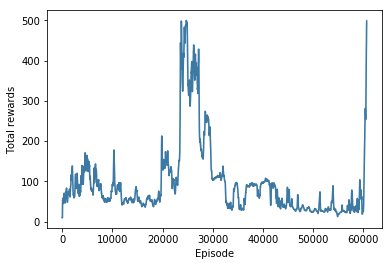

In [49]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

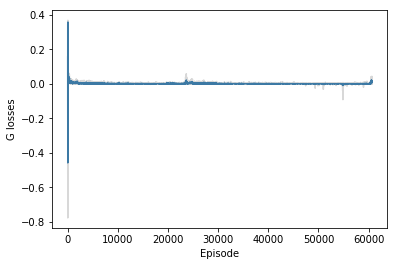

In [50]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

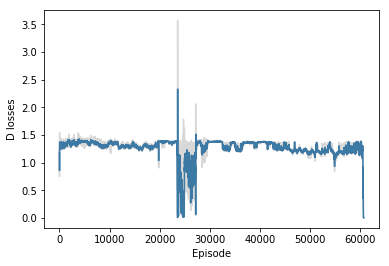

In [51]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 487.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.